# Overview
This notebook implements the LSTM network. The network is trained and tested using the available data from Kaggel. The data is slightly adjusted. To generate the data we are using here simply download the Kaggle data and run the 'create_data_sets.ipynb' notebook.

### Outline:
- First the data is loaded and standardized
- Then the data structures for the LSTM is defined
- Followed by the definition of the LSTM network
- The LSTM is trained and tested
- Then evaluated and used for making future predictions
- Last we predict the future sales for all stores and products.

In [60]:
%matplotlib widget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn
import sklearn
from torch.utils.data import DataLoader
from sklearn import preprocessing
import torch
from torch.utils.data import Dataset, DataLoader


### Load data

In [61]:
#load training data
train_big = pd.read_csv('datasets/train_big.csv')
train_big.index = train_big['date']
train_big = train_big.drop('date',axis=1)
# permute columns (thats just my prefered order without any reason)
col_lst = ['store_nbr','family_id','onpromotion','day','weekday','month','year','holiday','oilprice','sales']
train_big = train_big[col_lst]

# do the same for the test frame
test_big = pd.read_csv('datasets/test_big.csv')
test_big.index = test_big['date']
test_big = test_big.drop('date',axis=1)
# permute columns (thats just my prefered order without any reason)
col_lst = ['store_nbr','family_id','onpromotion','day','weekday','month','year','holiday','oilprice']
test_big = test_big[col_lst]

In [53]:
#define features and targets
features = ['onpromotion','day','weekday','month','year','holiday','oilprice']
target = 'sales'

In [54]:
train_big

store_nbr  family_id  onpromotion  day  weekday  month  year  \
date                                                                       
2013-01-01          1          0            0    1        1      1  2013   
2013-01-01          1          1            0    1        1      1  2013   
2013-01-01          1          2            0    1        1      1  2013   
2013-01-01          1          3            0    1        1      1  2013   
2013-01-01          1          4            0    1        1      1  2013   
...               ...        ...          ...  ...      ...    ...   ...   
2017-08-15          9         28            0   15        1      8  2017   
2017-08-15          9         29            1   15        1      8  2017   
2017-08-15          9         30          148   15        1      8  2017   
2017-08-15          9         31            8   15        1      8  2017   
2017-08-15          9         32            0   15        1      8  2017   

            holiday  oilprice     sales  
date                                     
2013-01-01        2     93.14     0.000  
2013-01-01        2     93.14     0.000  
2013-01-01        2     93.14     0.000  
2013-01-01        2     93.14     0.000  
2013-01-01        2     93.14     0.000  
...             ...       ...       ...  
2017-08-15        0     47.57   438.133  
2017-08-15        0     47.57   154.553  
2017-08-15        0     47.57  2419.729  
2017-08-15        0     47.57   121.000  
2017-08-15        0     47.57    16.000  

[3000888 rows x 10 columns]

In [55]:
test_big

store_nbr  family_id  onpromotion  day  weekday  month  year  \
date                                                                       
2017-08-16          1          0            0   16        2      8  2017   
2017-08-16          1          1            0   16        2      8  2017   
2017-08-16          1          2            2   16        2      8  2017   
2017-08-16          1          3           20   16        2      8  2017   
2017-08-16          1          4            0   16        2      8  2017   
...               ...        ...          ...  ...      ...    ...   ...   
2017-08-31          9         28            1   31        3      8  2017   
2017-08-31          9         29            0   31        3      8  2017   
2017-08-31          9         30            1   31        3      8  2017   
2017-08-31          9         31            9   31        3      8  2017   
2017-08-31          9         32            0   31        3      8  2017   

            holiday  oilprice  
date                           
2017-08-16        0     46.80  
2017-08-16        0     46.80  
2017-08-16        0     46.80  
2017-08-16        0     46.80  
2017-08-16        0     46.80  
...             ...       ...  
2017-08-31        0     47.26  
2017-08-31        0     47.26  
2017-08-31        0     47.26  
2017-08-31        0     47.26  
2017-08-31        0     47.26  

[28512 rows x 9 columns]

### Split in train and test set

In [62]:
#split train_big in train and test set
test_start = '2016-08-15' #"2017-08-01" 

df_train = train_big.loc[:test_start].copy()
df_test = train_big.loc[test_start:].copy()

#compte percentage of training test split
p = len(df_train)/len(train_big)
print('Size of training set is %s percent of total data.'%np.round(p,2))

Size of training set is 0.78 percent of total data.


### Standardize data

In [63]:
#select store and product (later this is done for all stores and products)
store_nbr = 3
family_id = 12

#standardize features & targets with MinMaxScaler (prefered version so far)
X = df_train.loc[(df_train['store_nbr']==store_nbr)&(df_train['family_id']==family_id)]
scaler = preprocessing.MinMaxScaler().fit(X)
X_scaled = scaler.transform(X)
df_train_scaled = pd.DataFrame(X_scaled,index=X.index,columns = X.columns) 

#standardize test set with same scaler that was used for training data 
X_test = df_test.loc[(df_test['store_nbr']==store_nbr)&(df_test['family_id']==family_id)]
X_test_scaled = scaler.transform(X_test)
df_test_scaled  = pd.DataFrame(X_test_scaled,index=X_test.index,columns = X_test.columns)

In [64]:
df_train_scaled

store_nbr  family_id  onpromotion       day   weekday     month  \
date                                                                          
2013-01-01        0.0        0.0        0.000  0.000000  0.166667  0.000000   
2013-01-02        0.0        0.0        0.000  0.033333  0.333333  0.000000   
2013-01-03        0.0        0.0        0.000  0.066667  0.500000  0.000000   
2013-01-04        0.0        0.0        0.000  0.100000  0.666667  0.000000   
2013-01-05        0.0        0.0        0.000  0.133333  0.833333  0.000000   
...               ...        ...          ...       ...       ...       ...   
2016-08-11        0.0        0.0        0.264  0.333333  0.500000  0.636364   
2016-08-12        0.0        0.0        0.288  0.366667  0.666667  0.636364   
2016-08-13        0.0        0.0        0.248  0.400000  0.833333  0.636364   
2016-08-14        0.0        0.0        0.288  0.433333  1.000000  0.636364   
2016-08-15        0.0        0.0        0.272  0.466667  0.000000  0.636364   

            year  holiday  oilprice     sales  
date                                           
2013-01-01   0.0      1.0  0.792965  0.000000  
2013-01-02   0.0      0.0  0.792965  0.387181  
2013-01-03   0.0      0.0  0.790951  0.307073  
2013-01-04   0.0      0.0  0.792728  0.262192  
2013-01-05   0.0      0.0  0.793044  0.357901  
...          ...      ...       ...       ...  
2016-08-11   1.0      0.0  0.205140  0.282780  
2016-08-12   1.0      1.0  0.216511  0.343673  
2016-08-13   1.0      0.5  0.221446  0.297328  
2016-08-14   1.0      0.5  0.226381  0.339372  
2016-08-15   1.0      0.0  0.231316  0.314484  

[1320 rows x 10 columns]

### Data structures for LSTM

In [65]:
class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]
    
#this class is similar to the class SequenceDataset but it uses in the padding step not copies of the first row 
#of its own data but the data that is available in the training set the timesteps before.
class SequenceDataset_test(Dataset):
    def __init__(self, dataframe_test, dataframe_train, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe_test[target].values).float()
        self.X = torch.tensor(dataframe_test[features].values).float()
        self.X_train = torch.tensor(dataframe_train[features].values).float()
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X_train[-self.sequence_length+i+1:] #use available data from the time steps before that is contained in the training data
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]


### Initialize training and test set

In [66]:
torch.manual_seed(101)

batch_size = 4
sequence_length = 7 #take one week into account

train_dataset = SequenceDataset(
    df_train_scaled,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset_test(
    df_test_scaled,
    df_train_scaled,
    target=target,
    features=features,
    sequence_length=sequence_length
)

#pass the data to PyTorch DataLoader 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)


Features shape: torch.Size([4, 7, 7])
Target shape: torch.Size([4])


### Define LSTM 

In [67]:
class LSTM(nn.Module):
    def __init__(self, num_features, hidden_units):
        super().__init__()
        self.num_features = num_features  
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_features,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out



### Test and train the model

In [68]:
class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        return torch.sqrt(self.mse(torch.log(pred + 1), torch.log(actual + 1)))

In [69]:
learning_rate = 0.001 
num_hidden_units = 16
num_epoch = 100
#initialize model
model = LSTM(num_features=len(features), hidden_units=num_hidden_units)
loss_function = RMSLELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [70]:
import time
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss

def test_model(data_loader, model, loss_function):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    return avg_loss


print("Untrained test\n--------")
test_model(test_loader, model, loss_function)
print()

t0 = time.time()
train_loss_lst = []
test_loss_lst =  []
for ix_epoch in range(num_epoch):
    print(f"Epoch {ix_epoch}\n---------")
    train_loss = train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_loss = test_model(test_loader, model, loss_function)
    train_loss_lst.append(train_loss)
    test_loss_lst.append(test_loss)
    print()

t1 = time.time()


Untrained test
--------
Test loss: 0.07508129857318557

Epoch 0
---------
Train loss: 0.05168875583419294
Test loss: 0.045771853026488556

Epoch 1
---------
Train loss: 0.04127635298522584
Test loss: 0.04581375536508858

Epoch 2
---------
Train loss: 0.0400878844274716
Test loss: 0.05128348933573326

Epoch 3
---------
Train loss: 0.03962241250908736
Test loss: 0.04453513375483453

Epoch 4
---------
Train loss: 0.0389917101788645
Test loss: 0.046189073776907244

Epoch 5
---------
Train loss: 0.038693936818251104
Test loss: 0.04356993544522835

Epoch 6
---------
Train loss: 0.03799790534698828
Test loss: 0.043179049014883196

Epoch 7
---------
Train loss: 0.03687355662131626
Test loss: 0.043985301304770553

Epoch 8
---------
Train loss: 0.0366766696570046
Test loss: 0.039998542993207986

Epoch 9
---------
Train loss: 0.035543233239458814
Test loss: 0.042540459903766925

Epoch 10
---------
Train loss: 0.03537497259958675
Test loss: 0.03961004666052759

Epoch 11
---------
Train loss: 0.034

Train loss: 0.025124599189836193
Test loss: 0.045092822634615004

Epoch 99
---------
Train loss: 0.02474401365880939
Test loss: 0.048734023903860994



In [30]:
print('Min:',(t1-t0)/60)

Min: 2.3909056703249614


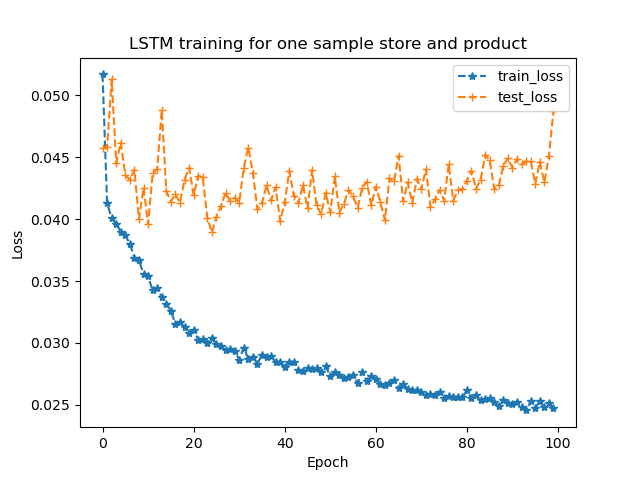

In [71]:
#plot loss
fig = plt.figure()
plt.plot(train_loss_lst,'*--',label='train_loss')
plt.plot(test_loss_lst,'+--',label='test_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSTM training for one sample store and product')
plt.legend()
#fig.savefig('plots_lstm/loss_bigger_testset.eps',format='eps')

### Prediction

In [72]:
def predict(data_loader, model):

    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)

    return output

In [74]:
df_train_copy = df_train.copy()
df_test_copy = df_test.copy()
df_train_copy = df_train_copy.loc[(df_train_copy['store_nbr']==store_nbr)&(df_train_copy['family_id']==family_id)]
df_test_copy = df_test_copy.loc[(df_test_copy['store_nbr']==store_nbr)&(df_test_copy['family_id']==family_id)]

train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_eval_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
ystar_col = "Model forecast"
df_train_copy[ystar_col] = predict(train_eval_loader, model).numpy()
df_test_copy[ystar_col] = predict(test_eval_loader, model).numpy()

df_out = pd.concat((df_train_copy, df_test_copy))[[target, ystar_col]]
df_out['sales'] = pd.concat((df_train_scaled['sales'],df_test_scaled['sales'])) #overide sales with scaled sales
df_out['date'] = df_out.index #include date column for plots

<AxesSubplot:xlabel='date'>

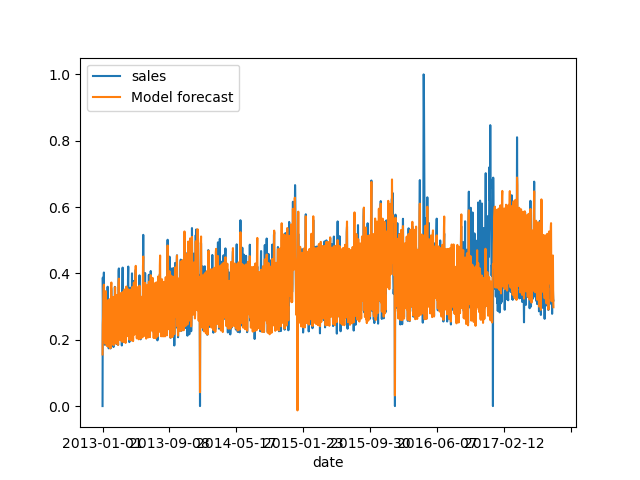

In [75]:
df_out.plot('date',['sales','Model forecast'])

### Scale back

In [76]:
df_train_predict_scale_back = df_train_scaled.copy()
df_test_predict_scale_back = df_test_scaled.copy()
df_train_predict_scale_back['sales'] = df_train_copy['Model forecast']
df_test_predict_scale_back['sales'] = df_test_copy['Model forecast']

X_train_pred_sb = scaler.inverse_transform(df_train_predict_scale_back)
X_test_pred_sb = scaler.inverse_transform(df_test_predict_scale_back)

#put rescaled values back in dataframe

df_train_predict_scale_back = pd.DataFrame(X_train_pred_sb,index=df_train_scaled.index,columns = df_train_scaled.columns)
df_test_predict_scale_back = pd.DataFrame(X_test_pred_sb,index=df_test_scaled.index,columns = df_test_scaled.columns)

# merge prediction into a single data frame
d1=df_train.loc[(df_train['store_nbr']==store_nbr)&(df_train['family_id']==family_id)]
d2=df_test.loc[(df_test['store_nbr']==store_nbr)&(df_test['family_id']==family_id)]

df_out_scaled_back = pd.DataFrame({'sales':pd.concat((d1['sales'],d2['sales'])),
                                  'predicted sales': pd.concat((df_train_predict_scale_back['sales'],
                                                               df_test_predict_scale_back['sales']))},
                                 index=df_out.index)
#include date colum
df_out_scaled_back['date']=df_out.index
df_out_scaled_back['date'] = pd.to_datetime(df_out_scaled_back['date'])
df_out_scaled_back.rename(columns={'sales':'sales_truth','predicted sales': 'sales_pred'},inplace=True)

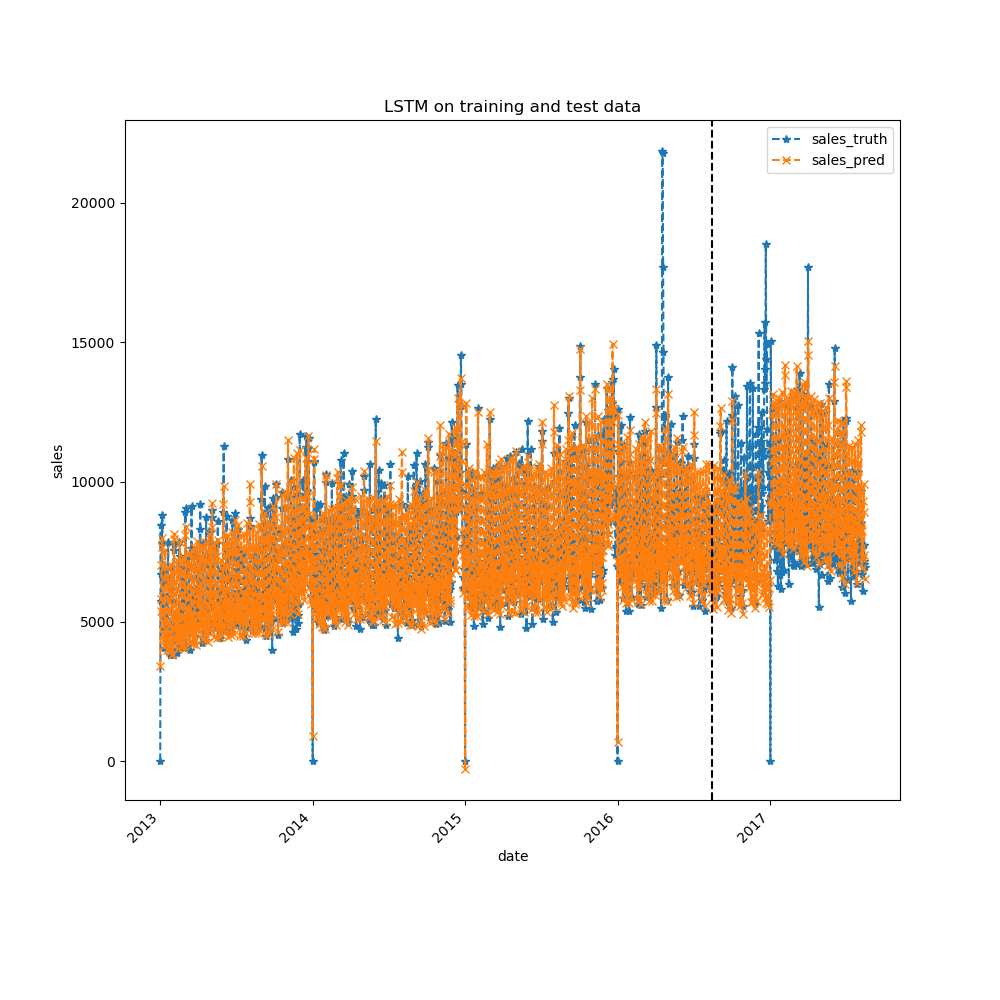

In [77]:
fig = plt.figure()
ax1=fig.add_subplot(1,1,1)
df_out_scaled_back.plot('date',['sales_truth','sales_pred'],style=['*--','x--'],rot=45,figsize=(10,10),title='LSTM on training and test data',ylabel='sales',ax=ax1)
plt.axvline(test_start,linestyle='--',color='k')
#fig.savefig('plots_lstm/lstm_overall_bigger_testset_100epoch.eps',format='eps')

### Predict future sales

In [78]:
#train model on entire training set and predict the dates 2017-08-16 to 2017-08-31

#standardize features & targets with MinMaxScaler (prefered version so far)
X = train_big.loc[(train_big['store_nbr']==store_nbr)&(train_big['family_id']==family_id)]
scaler = preprocessing.MinMaxScaler().fit(X)
X_scaled = scaler.transform(X)
df_train_scaled = pd.DataFrame(X_scaled,index=X.index,columns = X.columns) 

train_dataset = SequenceDataset(
    df_train_scaled,
    target=target,
    features=features,
    sequence_length=sequence_length)


batch_size = 4
sequence_length = 7

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#initialize network
learning_rate = 0.001 #5e-5
num_hidden_units = 16
num_epoch = 100
model = LSTM(num_features=len(features), hidden_units=num_hidden_units)
loss_function = RMSLELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#train network
for ix_epoch in range(num_epoch):
    print(f"Epoch {ix_epoch}\n---------")
    train_loss = train_model(train_loader, model, loss_function, optimizer=optimizer)
    print()

# put data into correct format for prediction

pred_feature_val = test_big.loc[(test_big['store_nbr']==store_nbr)&(test_big['family_id']==family_id)]
pred_feature_val['sales']=0 #include dummy sales that we can use same scaler 
X_pred_scaled = scaler.transform(pred_feature_val)
df_pred_scaled  = pd.DataFrame(X_pred_scaled,index=pred_feature_val.index,columns = pred_feature_val.columns)

pred_dataset = SequenceDataset_test(
    df_pred_scaled,
    df_train_scaled,
    target=target,
    features=features,
    sequence_length=sequence_length)

pred_eval_loader = DataLoader(pred_dataset, batch_size=batch_size, shuffle=False)
#make prediction
future_sales_pred = predict(pred_eval_loader, model).numpy()

#scale sales back to original unit
df_pred_scaled['sales'] = future_sales_pred
X_back_transform = scaler.inverse_transform(df_pred_scaled)
df_pred = pd.DataFrame(X_back_transform,index=df_pred_scaled.index,columns=df_pred_scaled.columns)
df_pred['dates'] = df_pred.index #include date col for plots


Epoch 0
---------
Train loss: 0.08492214794352544

Epoch 1
---------
Train loss: 0.042668891497146595

Epoch 2
---------
Train loss: 0.04236150527872906

Epoch 3
---------
Train loss: 0.0410133078185545

Epoch 4
---------
Train loss: 0.04144110160740424

Epoch 5
---------
Train loss: 0.040625444587957193

Epoch 6
---------
Train loss: 0.040345967211926494

Epoch 7
---------
Train loss: 0.039766101022815054

Epoch 8
---------
Train loss: 0.03978862682901624

Epoch 9
---------
Train loss: 0.039303137200736304

Epoch 10
---------
Train loss: 0.0387637909621248

Epoch 11
---------
Train loss: 0.03852524228102026

Epoch 12
---------
Train loss: 0.038319817173456214

Epoch 13
---------
Train loss: 0.03800727631299449

Epoch 14
---------
Train loss: 0.03736006782441057

Epoch 15
---------
Train loss: 0.036105042627643164

Epoch 16
---------
Train loss: 0.03613773188299351

Epoch 17
---------
Train loss: 0.03618001459042526

Epoch 18
---------
Train loss: 0.0357462718326271

Epoch 19
---------

C:\Users\Julian\AppData\Local\Temp\ipykernel_13460\1269351242.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


<AxesSubplot:title={'center':'Sales prediction of store 3 and product 12'}, xlabel='dates', ylabel='sales'>

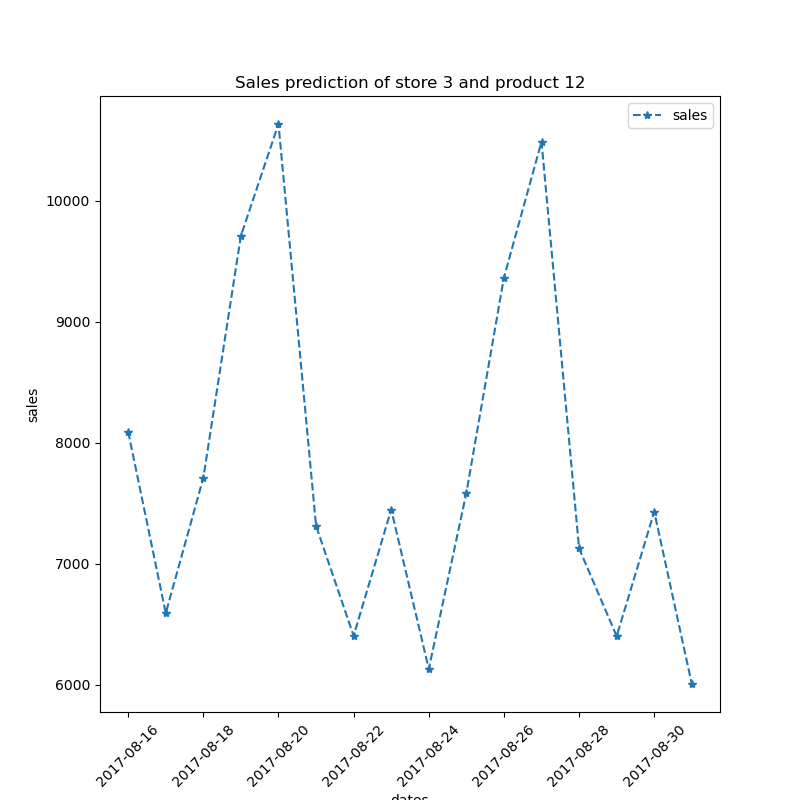

In [79]:
#plot prediction
df_pred.plot('dates','sales',style=['*--'],rot=45,figsize=(8,8),title='Sales prediction of store %s and product %s'%(store_nbr,family_id),ylabel='sales')

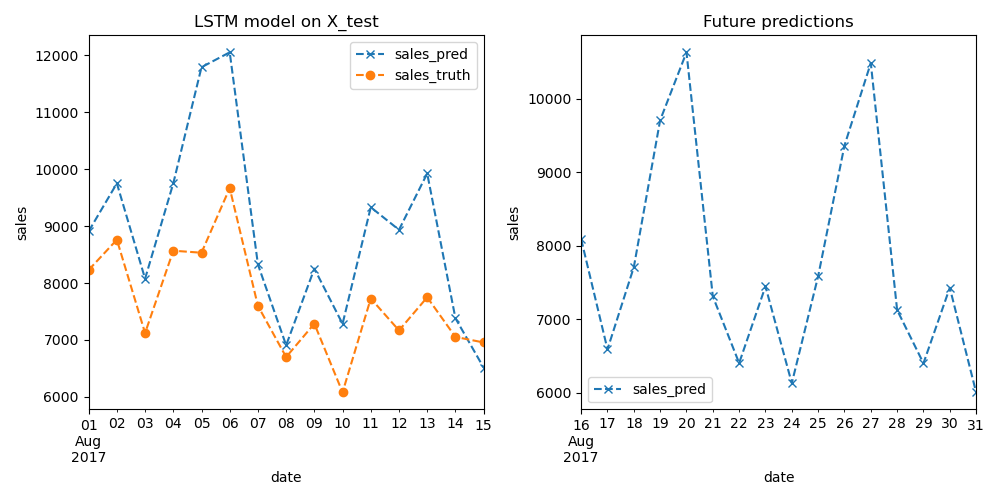

In [80]:
#plot both lstm on test set and future prediction
#rename column just for plotting convertion

#read this one just for index
test = pd.read_csv('datasets/test.csv',index_col='date',parse_dates=True)
test = test.loc[(test['store_nbr']==store_nbr) & (test['family']=='AUTOMOTIVE')]

df_plot = pd.DataFrame({'sales_pred':df_out_scaled_back[-15:]['sales_pred'].values,'sales_truth':df_out_scaled_back[-15:]['sales_truth'].values},index= df_out_scaled_back.index[-15:])
df_plot.index = pd.DatetimeIndex(df_plot.index)
df_pred_plot = pd.DataFrame(df_pred['sales'].values,index=test.index,columns=['sales_pred'])
fig=plt.figure(figsize=(10,5))
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)
df_plot.plot(style=['x--','o--'],title='LSTM model on X_test',ylabel='sales',ax=ax1)
df_pred_plot.plot(title='Future predictions',ylabel='sales',style=['x--'],ax=ax2)
fig.tight_layout()
#fig.savefig('plots_lstm/lstm_test_pred.eps',format='eps')

### Predict all stores & products

In [225]:
#this function trains the LSTM on the whole training set for a store and family and returns the prediction for the future
# sales of this store and family, with this function we will be training #stores*#families many lstm models later on.

def get_predictions(store_nbr,family_id):
    
    #scaling data
    X = train_big.loc[(train_big['store_nbr']==store_nbr)&(train_big['family_id']==family_id)]
    scaler = preprocessing.MinMaxScaler().fit(X)
    X_scaled = scaler.transform(X)
    df_train_scaled = pd.DataFrame(X_scaled,index=X.index,columns = X.columns) 
    
    #put data into correct format
    torch.manual_seed(101)

    batch_size = 4
    sequence_length = 7

    train_dataset = SequenceDataset(df_train_scaled, target=target, features=features, sequence_length=sequence_length) 
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    #define hyperparameters (those seemed to be very good)
    learning_rate = 0.001 
    num_hidden_units = 16
    num_epoch = 10
    #define model
    model = LSTM(num_features=len(features), hidden_units=num_hidden_units)
    loss_function = RMSLELoss() #nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for ix_epoch in range(num_epoch):
        print(f"Epoch {ix_epoch}\n---------")
        train_loss = train_model(train_loader, model, loss_function, optimizer=optimizer)
        train_loss_lst.append(train_loss)
        test_loss_lst.append(test_loss)
        print()
        
    #evaluate the trained model on the test (more precise the prediction) set. 
    #For this to work we first must scale the test features
    pred_feature_val = test_big.loc[(test_big['store_nbr']==store_nbr)&(test_big['family_id']==family_id)]
    pred_feature_val['sales']=0 #include dummy sales that we can use same scaler 
    X_pred_scaled = scaler.transform(pred_feature_val)
    df_pred_scaled  = pd.DataFrame(X_pred_scaled,index=pred_feature_val.index,columns = pred_feature_val.columns)
    
    # put data into correct format
    pred_dataset = SequenceDataset(df_pred_scaled, target=target, features=features, sequence_length=sequence_length)
    pred_eval_loader = DataLoader(pred_dataset, batch_size=batch_size, shuffle=False)
    
    #make prediction and scale back
    future_sales_pred = predict(pred_eval_loader, model).numpy()
    df_pred_scaled['sales'] = future_sales_pred
    X_back_transform = scaler.inverse_transform(df_pred_scaled)
    df_pred = pd.DataFrame(X_back_transform,index=df_pred_scaled.index,columns=df_pred_scaled.columns)
    return df_pred['sales'].values



In [243]:
#iterate over all combinations of stores&families and write the results row wise in a matrix
import time
t0 = time.time()
num_all_combinations = len(train_big['store_nbr'].unique())*len(train_big['family_id'].unique())
num_pred_days = 16
result_mat = np.zeros((num_all_combinations,num_pred_days))
stores = list(train_big['store_nbr'].unique())
families = list(train_big['family_id'].unique())

ctr = 0
# run two for loops to train lstm model and return prediction for each pair of possible combinations (store_nbr,family_id)
for store in stores:
    for family in families:
        result_mat[ctr,:] = get_predictions(store,family)
        ctr=ctr+1
        print('---------------------')
        print('finished store_%s & family_%s'%(store,family))
        print('---------------------')
        
pred = np.reshape(result_mat.T,(result_mat.size,1)).flatten()    
t1 = time.time()
total = t1-t0
print('Execution time = %s sec.'%total)
df_for_id = pd.read_csv('datasets/test_big.csv')
submission_1782_lstm_models = pd.DataFrame({'id':df_for_id['id'],'sales':pred})
# store submission
submission_1782_lstm_models.to_csv('predicted_data/submission_1782_lstm_models.csv',index=False)

Epoch 0
---------
Train loss: 0.10381356194049049

Epoch 1
---------
Train loss: 0.09981035889787798

Epoch 2
---------
Train loss: 0.09991572082104634

Epoch 3
---------
Train loss: 0.09958350436315118

Epoch 4
---------
Train loss: 0.09871940211682734

Epoch 5
---------
Train loss: 0.09922007968175864

Epoch 6
---------
Train loss: 0.09865852999954425

Epoch 7
---------
Train loss: 0.09880370265337464

Epoch 8
---------
Train loss: 0.10001914174851216

Epoch 9
---------
Train loss: 0.09890950567392089

---------------------
finished store_1 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.021368190459381663

Epoch 1
---------
Train loss: 0.0014831193866160634

Epoch 2
---------
Train loss: 0.0011683241700623053

Epoch 3
---------
Train loss: 0.000972678929936769

Epoch 4
---------
Train loss: 0.0008320428725943686

Epoch 5
---------
Train loss: 0.0008710555304264906

Epoch 6
---------
Train loss: 0.0007851359074706635

Epoch 7
---------
Train loss: 0.0008632014939703065

Epoch 8
---------
Train loss: 0.0007413258255034079

Epoch 9
---------
Train loss: 0.0005997182591762969

---------------------
finished store_1 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11607935222755064

Epoch 1
---------
Train loss: 0.11189610976947033

Epoch 2
---------
Train loss: 0.11176715657610509

Epoch 3
---------
Train loss: 0.11116401115189044

Epoch 4
---------
Train loss: 0.1111769164733217

Epoch 5
---------
Train loss: 0.11116028293489419

Epoch 6
---------
Train loss: 0.11059803165486547

Epoch 7
---------
Train loss: 0.111001099975262

Epoch 8
---------
Train loss: 0.11053875841713574

Epoch 9
---------
Train loss: 0.11027335765331346

---------------------
finished store_1 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07702962632540994

Epoch 1
---------
Train loss: 0.06745861717577219

Epoch 2
---------
Train loss: 0.06547530452254054

Epoch 3
---------
Train loss: 0.06488498069584865

Epoch 4
---------
Train loss: 0.0633853258666828

Epoch 5
---------
Train loss: 0.06213654295901929

Epoch 6
---------
Train loss: 0.06054981413901277

Epoch 7
---------
Train loss: 0.058193691040559575

Epoch 8
---------
Train loss: 0.056079957439539835

Epoch 9
---------
Train loss: 0.05337238443612769

---------------------
finished store_1 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.043981918830075024

Epoch 1
---------
Train loss: 0.027163684336955807

Epoch 2
---------
Train loss: 0.027854421518625792

Epoch 3
---------
Train loss: 0.027771233407697018

Epoch 4
---------
Train loss: 0.02761049321388069

Epoch 5
---------
Train loss: 0.027879021643206638

Epoch 6
---------
Train loss: 0.028002742590822916

Epoch 7
---------
Train loss: 0.027459910662550005

Epoch 8
---------
Train loss: 0.027286587088517326

Epoch 9
---------
Train loss: 0.027330300816740715

---------------------
finished store_1 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08207842524024059

Epoch 1
---------
Train loss: 0.06375250897885713

Epoch 2
---------
Train loss: 0.06137993868944764

Epoch 3
---------
Train loss: 0.05966557246564297

Epoch 4
---------
Train loss: 0.05753777930601511

Epoch 5
---------
Train loss: 0.05563671278353612

Epoch 6
---------
Train loss: 0.05345419587704603

Epoch 7
---------
Train loss: 0.052336380554854234

Epoch 8
---------
Train loss: 0.04918703569139126

Epoch 9
---------
Train loss: 0.047608344723866484

---------------------
finished store_1 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02458556344613185

Epoch 1
---------
Train loss: 0.006935353144768829

Epoch 2
---------
Train loss: 0.006558110768245334

Epoch 3
---------
Train loss: 0.0065092629622535295

Epoch 4
---------
Train loss: 0.006429960063162023

Epoch 5
---------
Train loss: 0.00644240546291318

Epoch 6
---------
Train loss: 0.006294774442121404

Epoch 7
---------
Train loss: 0.006246312113253139

Epoch 8
---------
Train loss: 0.006268895733349397

Epoch 9
---------
Train loss: 0.006260097287722472

---------------------
finished store_1 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07138282023901187

Epoch 1
---------
Train loss: 0.05406232657145505

Epoch 2
---------
Train loss: 0.05180002278438161

Epoch 3
---------
Train loss: 0.05023700243742548

Epoch 4
---------
Train loss: 0.04895780746760887

Epoch 5
---------
Train loss: 0.04784610126866581

Epoch 6
---------
Train loss: 0.047085871029592115

Epoch 7
---------
Train loss: 0.04727331411055866

Epoch 8
---------
Train loss: 0.0455328601516447

Epoch 9
---------
Train loss: 0.045473262068158514

---------------------
finished store_1 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0920350513644428

Epoch 1
---------
Train loss: 0.07342812627323875

Epoch 2
---------
Train loss: 0.06987418959054414

Epoch 3
---------
Train loss: 0.0675992720059148

Epoch 4
---------
Train loss: 0.06586917903884856

Epoch 5
---------
Train loss: 0.06408030150630765

Epoch 6
---------
Train loss: 0.062466656397629945

Epoch 7
---------
Train loss: 0.06207002941386292

Epoch 8
---------
Train loss: 0.05905692318383596

Epoch 9
---------
Train loss: 0.05717166289775644

---------------------
finished store_1 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09110270450311998

Epoch 1
---------
Train loss: 0.07704526705406341

Epoch 2
---------
Train loss: 0.07411651621238637

Epoch 3
---------
Train loss: 0.07192705075462258

Epoch 4
---------
Train loss: 0.06993333732315522

Epoch 5
---------
Train loss: 0.06776216870390604

Epoch 6
---------
Train loss: 0.06538288981262197

Epoch 7
---------
Train loss: 0.06156765436200589

Epoch 8
---------
Train loss: 0.05896302104447559

Epoch 9
---------
Train loss: 0.05803427990357836

---------------------
finished store_1 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09490011179390542

Epoch 1
---------
Train loss: 0.08311008443865668

Epoch 2
---------
Train loss: 0.08035770378511337

Epoch 3
---------
Train loss: 0.0792124616314

Epoch 4
---------
Train loss: 0.07730267997255942

Epoch 5
---------
Train loss: 0.07529188930156537

Epoch 6
---------
Train loss: 0.07357182968717572

Epoch 7
---------
Train loss: 0.06982322721222234

Epoch 8
---------
Train loss: 0.06440843257504447

Epoch 9
---------
Train loss: 0.060814612761865464

---------------------
finished store_1 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.026807703101573925

Epoch 1
---------
Train loss: 0.011484854684582957

Epoch 2
---------
Train loss: 0.011141723182247045

Epoch 3
---------
Train loss: 0.011152250246911348

Epoch 4
---------
Train loss: 0.011035680198475648

Epoch 5
---------
Train loss: 0.011080716920224618

Epoch 6
---------
Train loss: 0.01067532283295999

Epoch 7
---------
Train loss: 0.01065398764109677

Epoch 8
---------
Train loss: 0.010502155940988567

Epoch 9
---------
Train loss: 0.010446140643280009

---------------------
finished store_1 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.048673162104079674

Epoch 1
---------
Train loss: 0.040956880653945114

Epoch 2
---------
Train loss: 0.04003030365120593

Epoch 3
---------
Train loss: 0.03980398563460188

Epoch 4
---------
Train loss: 0.03876065669333531

Epoch 5
---------
Train loss: 0.03746718235176738

Epoch 6
---------
Train loss: 0.03436311864628149

Epoch 7
---------
Train loss: 0.03253258374628042

Epoch 8
---------
Train loss: 0.031144450836197744

Epoch 9
---------
Train loss: 0.030249534390486263

---------------------
finished store_1 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06545646171884129

Epoch 1
---------
Train loss: 0.059825065706119895

Epoch 2
---------
Train loss: 0.0595251286353677

Epoch 3
---------
Train loss: 0.05891623514905713

Epoch 4
---------
Train loss: 0.05900937611250441

Epoch 5
---------
Train loss: 0.05899331505872716

Epoch 6
---------
Train loss: 0.059221419943784166

Epoch 7
---------
Train loss: 0.05908198509533445

Epoch 8
---------
Train loss: 0.05898211070838563

Epoch 9
---------
Train loss: 0.05879008519571637

---------------------
finished store_1 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10337624286308071

Epoch 1
---------
Train loss: 0.09824725331167852

Epoch 2
---------
Train loss: 0.09713241080985782

Epoch 3
---------
Train loss: 0.09786766394087934

Epoch 4
---------
Train loss: 0.09698906576707782

Epoch 5
---------
Train loss: 0.09694293669188249

Epoch 6
---------
Train loss: 0.09681871568346108

Epoch 7
---------
Train loss: 0.0968474438391856

Epoch 8
---------
Train loss: 0.09721739966236498

Epoch 9
---------
Train loss: 0.09616959850235252

---------------------
finished store_1 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.031928163260717006

Epoch 1
---------
Train loss: 0.016920636989831074

Epoch 2
---------
Train loss: 0.01685651604472184

Epoch 3
---------
Train loss: 0.01661009094406875

Epoch 4
---------
Train loss: 0.01653373681839485

Epoch 5
---------
Train loss: 0.01630661700190777

Epoch 6
---------
Train loss: 0.0162905484444579

Epoch 7
---------
Train loss: 0.0165903908029119

Epoch 8
---------
Train loss: 0.01634156191832167

Epoch 9
---------
Train loss: 0.01629990637811197

---------------------
finished store_1 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04549736164249214

Epoch 1
---------
Train loss: 0.030869321825730475

Epoch 2
---------
Train loss: 0.029730846338591268

Epoch 3
---------
Train loss: 0.02941613811546065

Epoch 4
---------
Train loss: 0.0289130279406653

Epoch 5
---------
Train loss: 0.02871422972828769

Epoch 6
---------
Train loss: 0.02881758859173136

Epoch 7
---------
Train loss: 0.028823828126133516

Epoch 8
---------
Train loss: 0.028394965310039048

Epoch 9
---------
Train loss: 0.02864643059352373

---------------------
finished store_1 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09112874464399565

Epoch 1
---------
Train loss: 0.08190203244817795

Epoch 2
---------
Train loss: 0.08184036282234053

Epoch 3
---------
Train loss: 0.08191278851049069

Epoch 4
---------
Train loss: 0.08144361280942349

Epoch 5
---------
Train loss: 0.08215938631949543

Epoch 6
---------
Train loss: 0.08139495197971154

Epoch 7
---------
Train loss: 0.08073797082913389

Epoch 8
---------
Train loss: 0.08198633012273338

Epoch 9
---------
Train loss: 0.08090636822574213

---------------------
finished store_1 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07319653272460659

Epoch 1
---------
Train loss: 0.06043254732731686

Epoch 2
---------
Train loss: 0.058584856387059646

Epoch 3
---------
Train loss: 0.05677582603390384

Epoch 4
---------
Train loss: 0.053065961577449514

Epoch 5
---------
Train loss: 0.04950970754186643

Epoch 6
---------
Train loss: 0.04742424276429549

Epoch 7
---------
Train loss: 0.046848058720471035

Epoch 8
---------
Train loss: 0.04579730167699593

Epoch 9
---------
Train loss: 0.04544293617104089

---------------------
finished store_1 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.12736337223574695

Epoch 1
---------
Train loss: 0.11509199921404523

Epoch 2
---------
Train loss: 0.11051748282300428

Epoch 3
---------
Train loss: 0.10320908428256062

Epoch 4
---------
Train loss: 0.10192585514853941

Epoch 5
---------
Train loss: 0.09857537217367432

Epoch 6
---------
Train loss: 0.09823020653812449

Epoch 7
---------
Train loss: 0.0949003923664449

Epoch 8
---------
Train loss: 0.0935374707151691

Epoch 9
---------
Train loss: 0.09386028963165477

---------------------
finished store_1 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0562920189526755

Epoch 1
---------
Train loss: 0.0466945966918048

Epoch 2
---------
Train loss: 0.04486431487816034

Epoch 3
---------
Train loss: 0.045304478922606646

Epoch 4
---------
Train loss: 0.044658652723561135

Epoch 5
---------
Train loss: 0.04496371839361402

Epoch 6
---------
Train loss: 0.04475809421363749

Epoch 7
---------
Train loss: 0.04444385530104122

Epoch 8
---------
Train loss: 0.04422547384176288

Epoch 9
---------
Train loss: 0.044442644155851946

---------------------
finished store_1 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08667968961713292

Epoch 1
---------
Train loss: 0.08167342625275219

Epoch 2
---------
Train loss: 0.08157852033458456

Epoch 3
---------
Train loss: 0.08158322447256103

Epoch 4
---------
Train loss: 0.08135690609094932

Epoch 5
---------
Train loss: 0.08047946144311276

Epoch 6
---------
Train loss: 0.08081585221045658

Epoch 7
---------
Train loss: 0.0805023651428503

Epoch 8
---------
Train loss: 0.07956400293980741

Epoch 9
---------
Train loss: 0.08013005777662553

---------------------
finished store_1 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07743345374449415

Epoch 1
---------
Train loss: 0.0677136277532174

Epoch 2
---------
Train loss: 0.06408263520158455

Epoch 3
---------
Train loss: 0.05994040815429563

Epoch 4
---------
Train loss: 0.053858446632014174

Epoch 5
---------
Train loss: 0.05078636070231148

Epoch 6
---------
Train loss: 0.049519247377640845

Epoch 7
---------
Train loss: 0.048263670997185336

Epoch 8
---------
Train loss: 0.04747887529906177

Epoch 9
---------
Train loss: 0.04724006253712747

---------------------
finished store_1 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09622357052146964

Epoch 1
---------
Train loss: 0.07941123050462782

Epoch 2
---------
Train loss: 0.07568956485168561

Epoch 3
---------
Train loss: 0.07377997736807143

Epoch 4
---------
Train loss: 0.07317445573956659

Epoch 5
---------
Train loss: 0.07243699693915184

Epoch 6
---------
Train loss: 0.0724338867807774

Epoch 7
---------
Train loss: 0.0716615476614559

Epoch 8
---------
Train loss: 0.07032247900856646

Epoch 9
---------
Train loss: 0.07128254030421907

---------------------
finished store_1 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08891801915469971

Epoch 1
---------
Train loss: 0.08087969098390564

Epoch 2
---------
Train loss: 0.07740837362132559

Epoch 3
---------
Train loss: 0.07478840058257985

Epoch 4
---------
Train loss: 0.06799186819682071

Epoch 5
---------
Train loss: 0.0614893317892882

Epoch 6
---------
Train loss: 0.05620551104447196

Epoch 7
---------
Train loss: 0.053088678571344694

Epoch 8
---------
Train loss: 0.04914290212413336

Epoch 9
---------
Train loss: 0.04632513422293327

---------------------
finished store_1 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04330114965966401

Epoch 1
---------
Train loss: 0.03610784253946145

Epoch 2
---------
Train loss: 0.03488556217101365

Epoch 3
---------
Train loss: 0.03437944383674573

Epoch 4
---------
Train loss: 0.033768932786360915

Epoch 5
---------
Train loss: 0.0331061455662276

Epoch 6
---------
Train loss: 0.03255646256951177

Epoch 7
---------
Train loss: 0.03201595405691841

Epoch 8
---------
Train loss: 0.03103480145673659

Epoch 9
---------
Train loss: 0.03080968630739052

---------------------
finished store_1 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11496519893098119

Epoch 1
---------
Train loss: 0.1051252452621232

Epoch 2
---------
Train loss: 0.10178151526300329

Epoch 3
---------
Train loss: 0.09934032192086523

Epoch 4
---------
Train loss: 0.09587636616549979

Epoch 5
---------
Train loss: 0.09529621916604085

Epoch 6
---------
Train loss: 0.0928432863280885

Epoch 7
---------
Train loss: 0.09319632351531199

Epoch 8
---------
Train loss: 0.09193470913279722

Epoch 9
---------
Train loss: 0.09236117282599175

---------------------
finished store_1 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08278936738338578

Epoch 1
---------
Train loss: 0.0703370984634849

Epoch 2
---------
Train loss: 0.06757947837053455

Epoch 3
---------
Train loss: 0.06555123614908291

Epoch 4
---------
Train loss: 0.06218541401710512

Epoch 5
---------
Train loss: 0.06126563282099479

Epoch 6
---------
Train loss: 0.06103027037581575

Epoch 7
---------
Train loss: 0.061354534749180574

Epoch 8
---------
Train loss: 0.06013523412850683

Epoch 9
---------
Train loss: 0.05938909279244494

---------------------
finished store_1 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08758580522288761

Epoch 1
---------
Train loss: 0.07741123444075539

Epoch 2
---------
Train loss: 0.07215410747041046

Epoch 3
---------
Train loss: 0.06894352210070628

Epoch 4
---------
Train loss: 0.06676291442540366

Epoch 5
---------
Train loss: 0.06552737210313136

Epoch 6
---------
Train loss: 0.06290279384680322

Epoch 7
---------
Train loss: 0.060739332073392466

Epoch 8
---------
Train loss: 0.05754630930274902

Epoch 9
---------
Train loss: 0.055731316183355244

---------------------
finished store_1 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07572772721107386

Epoch 1
---------
Train loss: 0.0690461239178008

Epoch 2
---------
Train loss: 0.06641089575555433

Epoch 3
---------
Train loss: 0.06475034364081052

Epoch 4
---------
Train loss: 0.06335322909950857

Epoch 5
---------
Train loss: 0.06260697698915231

Epoch 6
---------
Train loss: 0.06153290789970363

Epoch 7
---------
Train loss: 0.06107521099381308

Epoch 8
---------
Train loss: 0.05916638579662013

Epoch 9
---------
Train loss: 0.05890740137193308

---------------------
finished store_1 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.14961890256001378

Epoch 1
---------
Train loss: 0.12074906332086498

Epoch 2
---------
Train loss: 0.11071582990665334

Epoch 3
---------
Train loss: 0.109310325427587

Epoch 4
---------
Train loss: 0.10882740819963876

Epoch 5
---------
Train loss: 0.10472484215133936

Epoch 6
---------
Train loss: 0.10317081543937714

Epoch 7
---------
Train loss: 0.09944945380905745

Epoch 8
---------
Train loss: 0.09782222870985077

Epoch 9
---------
Train loss: 0.09687658459735667

---------------------
finished store_1 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06928361956936566

Epoch 1
---------
Train loss: 0.055976061157482916

Epoch 2
---------
Train loss: 0.05629702900958606

Epoch 3
---------
Train loss: 0.05504222584939772

Epoch 4
---------
Train loss: 0.055133236785274944

Epoch 5
---------
Train loss: 0.0550274979063219

Epoch 6
---------
Train loss: 0.05507096580994004

Epoch 7
---------
Train loss: 0.05518685037865676

Epoch 8
---------
Train loss: 0.05520737064069617

Epoch 9
---------
Train loss: 0.0554006801670801

---------------------
finished store_1 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08305352098018709

Epoch 1
---------
Train loss: 0.07693209363736053

Epoch 2
---------
Train loss: 0.07547968205268055

Epoch 3
---------
Train loss: 0.07476410344508509

Epoch 4
---------
Train loss: 0.07344175619902775

Epoch 5
---------
Train loss: 0.07281067871406781

Epoch 6
---------
Train loss: 0.07176752298663319

Epoch 7
---------
Train loss: 0.07088622046001875

Epoch 8
---------
Train loss: 0.0690755969192169

Epoch 9
---------
Train loss: 0.06828195175638249

---------------------
finished store_1 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0741333972105221

Epoch 1
---------
Train loss: 0.06869360260585779

Epoch 2
---------
Train loss: 0.06817625650821912

Epoch 3
---------
Train loss: 0.06823018264476732

Epoch 4
---------
Train loss: 0.06786087549329158

Epoch 5
---------
Train loss: 0.06799773136574129

Epoch 6
---------
Train loss: 0.06745454575202811

Epoch 7
---------
Train loss: 0.06820407346545801

Epoch 8
---------
Train loss: 0.06753499245363997

Epoch 9
---------
Train loss: 0.06740156240814373

---------------------
finished store_10 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.040572684433536864

Epoch 1
---------
Train loss: 0.02432934701223714

Epoch 2
---------
Train loss: 0.023962231070528275

Epoch 3
---------
Train loss: 0.02330190037201104

Epoch 4
---------
Train loss: 0.023184121874137008

Epoch 5
---------
Train loss: 0.023641495836216785

Epoch 6
---------
Train loss: 0.02348524153514211

Epoch 7
---------
Train loss: 0.02366714502934747

Epoch 8
---------
Train loss: 0.02378406331116348

Epoch 9
---------
Train loss: 0.022997497195233325

---------------------
finished store_10 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10187788886812266

Epoch 1
---------
Train loss: 0.09699051663934335

Epoch 2
---------
Train loss: 0.0957401793078473

Epoch 3
---------
Train loss: 0.09608917572312145

Epoch 4
---------
Train loss: 0.09564202917284043

Epoch 5
---------
Train loss: 0.09572207114289817

Epoch 6
---------
Train loss: 0.09504514268982156

Epoch 7
---------
Train loss: 0.09510304439467801

Epoch 8
---------
Train loss: 0.09429840748408487

Epoch 9
---------
Train loss: 0.09434780825345364

---------------------
finished store_10 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08166862750368419

Epoch 1
---------
Train loss: 0.07124737539105205

Epoch 2
---------
Train loss: 0.06989078546902984

Epoch 3
---------
Train loss: 0.0688073570528145

Epoch 4
---------
Train loss: 0.06769968151179034

Epoch 5
---------
Train loss: 0.06746828348559467

Epoch 6
---------
Train loss: 0.06641222796714787

Epoch 7
---------
Train loss: 0.06451743332151491

Epoch 8
---------
Train loss: 0.0632983753214327

Epoch 9
---------
Train loss: 0.061466293672714695

---------------------
finished store_10 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.021368190459381663

Epoch 1
---------
Train loss: 0.0014831193866160634

Epoch 2
---------
Train loss: 0.0011683241700623053

Epoch 3
---------
Train loss: 0.000972678929936769

Epoch 4
---------
Train loss: 0.0008320428725943686

Epoch 5
---------
Train loss: 0.0008710555304264906

Epoch 6
---------
Train loss: 0.0007851359074706635

Epoch 7
---------
Train loss: 0.0008632014939703065

Epoch 8
---------
Train loss: 0.0007413258255034079

Epoch 9
---------
Train loss: 0.0005997182591762969

---------------------
finished store_10 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05826340963944545

Epoch 1
---------
Train loss: 0.05407519680016504

Epoch 2
---------
Train loss: 0.05255875849516757

Epoch 3
---------
Train loss: 0.05136712082172799

Epoch 4
---------
Train loss: 0.05132379201229777

Epoch 5
---------
Train loss: 0.050273202645045985

Epoch 6
---------
Train loss: 0.05039043563712309

Epoch 7
---------
Train loss: 0.04922416166904561

Epoch 8
---------
Train loss: 0.04911376941382814

Epoch 9
---------
Train loss: 0.0487909843844324

---------------------
finished store_10 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06836049871036956

Epoch 1
---------
Train loss: 0.05824496631119002

Epoch 2
---------
Train loss: 0.056815040735815454

Epoch 3
---------
Train loss: 0.05696150269071768

Epoch 4
---------
Train loss: 0.056488084190938787

Epoch 5
---------
Train loss: 0.056211896341364836

Epoch 6
---------
Train loss: 0.05629501211060976

Epoch 7
---------
Train loss: 0.05615969527194237

Epoch 8
---------
Train loss: 0.055838142572006214

Epoch 9
---------
Train loss: 0.055372449870258925

---------------------
finished store_10 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.026104494401158636

Epoch 1
---------
Train loss: 0.01444831355629741

Epoch 2
---------
Train loss: 0.013936966888257026

Epoch 3
---------
Train loss: 0.013499368970988057

Epoch 4
---------
Train loss: 0.013619543665980217

Epoch 5
---------
Train loss: 0.013073616439638098

Epoch 6
---------
Train loss: 0.013208785503571787

Epoch 7
---------
Train loss: 0.012746260033017843

Epoch 8
---------
Train loss: 0.012527756030160288

Epoch 9
---------
Train loss: 0.012611616683256704

---------------------
finished store_10 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09810272671476962

Epoch 1
---------
Train loss: 0.07818809418436892

Epoch 2
---------
Train loss: 0.069271397252618

Epoch 3
---------
Train loss: 0.06438107820196771

Epoch 4
---------
Train loss: 0.0625917855550639

Epoch 5
---------
Train loss: 0.06132345296323052

Epoch 6
---------
Train loss: 0.06116793260659642

Epoch 7
---------
Train loss: 0.06057950381340012

Epoch 8
---------
Train loss: 0.058853291700684825

Epoch 9
---------
Train loss: 0.05854989942871123

---------------------
finished store_10 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0783804693788007

Epoch 1
---------
Train loss: 0.07126747707077556

Epoch 2
---------
Train loss: 0.06908996716902686

Epoch 3
---------
Train loss: 0.06718787724028326

Epoch 4
---------
Train loss: 0.06643089265153343

Epoch 5
---------
Train loss: 0.0666951150135657

Epoch 6
---------
Train loss: 0.06634669755795648

Epoch 7
---------
Train loss: 0.06578563355050998

Epoch 8
---------
Train loss: 0.06605101293151991

Epoch 9
---------
Train loss: 0.06578614757641832

---------------------
finished store_10 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0666222631059711

Epoch 1
---------
Train loss: 0.05954816806707487

Epoch 2
---------
Train loss: 0.058631340613601965

Epoch 3
---------
Train loss: 0.057298561082511364

Epoch 4
---------
Train loss: 0.057271060597974446

Epoch 5
---------
Train loss: 0.056404491017114665

Epoch 6
---------
Train loss: 0.05558516191331904

Epoch 7
---------
Train loss: 0.05579684838440243

Epoch 8
---------
Train loss: 0.05474006452414068

Epoch 9
---------
Train loss: 0.055404823629579325

---------------------
finished store_10 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03707679695916537

Epoch 1
---------
Train loss: 0.022840612100364283

Epoch 2
---------
Train loss: 0.022430003918773735

Epoch 3
---------
Train loss: 0.022548174828450215

Epoch 4
---------
Train loss: 0.022827842083954275

Epoch 5
---------
Train loss: 0.02219314226214807

Epoch 6
---------
Train loss: 0.022040636253802023

Epoch 7
---------
Train loss: 0.021801772569704385

Epoch 8
---------
Train loss: 0.021681361260432352

Epoch 9
---------
Train loss: 0.021469425892284816

---------------------
finished store_10 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.051379059012227134

Epoch 1
---------
Train loss: 0.0436967976254161

Epoch 2
---------
Train loss: 0.04232595455467772

Epoch 3
---------
Train loss: 0.04102477867868585

Epoch 4
---------
Train loss: 0.040134348455294434

Epoch 5
---------
Train loss: 0.03927270997638622

Epoch 6
---------
Train loss: 0.03879393154042917

Epoch 7
---------
Train loss: 0.038287619215097816

Epoch 8
---------
Train loss: 0.03764024845461611

Epoch 9
---------
Train loss: 0.03730017157833395

---------------------
finished store_10 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05821556508355285

Epoch 1
---------
Train loss: 0.04890962631271316

Epoch 2
---------
Train loss: 0.04830384704299855

Epoch 3
---------
Train loss: 0.04823184645161776

Epoch 4
---------
Train loss: 0.04787133721692262

Epoch 5
---------
Train loss: 0.04786187925568457

Epoch 6
---------
Train loss: 0.04790639530009017

Epoch 7
---------
Train loss: 0.04714957449470167

Epoch 8
---------
Train loss: 0.04725546532890133

Epoch 9
---------
Train loss: 0.046695745283529835

---------------------
finished store_10 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11178169441973512

Epoch 1
---------
Train loss: 0.10770911381816638

Epoch 2
---------
Train loss: 0.10783544965884748

Epoch 3
---------
Train loss: 0.10699348479969485

Epoch 4
---------
Train loss: 0.10637219507698492

Epoch 5
---------
Train loss: 0.10667798507542763

Epoch 6
---------
Train loss: 0.10647477414414747

Epoch 7
---------
Train loss: 0.10580777020731193

Epoch 8
---------
Train loss: 0.10537949350447949

Epoch 9
---------
Train loss: 0.10425771944968122

---------------------
finished store_10 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07964230391623855

Epoch 1
---------
Train loss: 0.06904734123825602

Epoch 2
---------
Train loss: 0.06853508494679336

Epoch 3
---------
Train loss: 0.06749635477021619

Epoch 4
---------
Train loss: 0.06761186579275531

Epoch 5
---------
Train loss: 0.0661061538334697

Epoch 6
---------
Train loss: 0.06599753716133198

Epoch 7
---------
Train loss: 0.06505662231925087

Epoch 8
---------
Train loss: 0.06451527414635497

Epoch 9
---------
Train loss: 0.06402372967146532

---------------------
finished store_10 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08061050733821268

Epoch 1
---------
Train loss: 0.06996905812197265

Epoch 2
---------
Train loss: 0.06826552667051129

Epoch 3
---------
Train loss: 0.06744095577356227

Epoch 4
---------
Train loss: 0.06527233421868886

Epoch 5
---------
Train loss: 0.06438721327615499

Epoch 6
---------
Train loss: 0.06399365349516777

Epoch 7
---------
Train loss: 0.06360153860197958

Epoch 8
---------
Train loss: 0.06278174648983868

Epoch 9
---------
Train loss: 0.06308902050821982

---------------------
finished store_10 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10022712747550917

Epoch 1
---------
Train loss: 0.09109210149819726

Epoch 2
---------
Train loss: 0.09109481738428442

Epoch 3
---------
Train loss: 0.08937532066714877

Epoch 4
---------
Train loss: 0.09084582055165076

Epoch 5
---------
Train loss: 0.08773373608399158

Epoch 6
---------
Train loss: 0.08978177383575243

Epoch 7
---------
Train loss: 0.09042646023229145

Epoch 8
---------
Train loss: 0.09051327031153318

Epoch 9
---------
Train loss: 0.0894420833237076

---------------------
finished store_10 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.14719585752260655

Epoch 1
---------
Train loss: 0.12583586380036102

Epoch 2
---------
Train loss: 0.11269643405262124

Epoch 3
---------
Train loss: 0.10623255749332615

Epoch 4
---------
Train loss: 0.10667332154289419

Epoch 5
---------
Train loss: 0.10277312616496889

Epoch 6
---------
Train loss: 0.10314533409094018

Epoch 7
---------
Train loss: 0.09642267321189976

Epoch 8
---------
Train loss: 0.0978354303677281

Epoch 9
---------
Train loss: 0.09928613548297567

---------------------
finished store_10 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11545590216608059

Epoch 1
---------
Train loss: 0.10609686392582865

Epoch 2
---------
Train loss: 0.10498624766630402

Epoch 3
---------
Train loss: 0.10408687421879477

Epoch 4
---------
Train loss: 0.10361551817488854

Epoch 5
---------
Train loss: 0.10333958758381936

Epoch 6
---------
Train loss: 0.10144800316506992

Epoch 7
---------
Train loss: 0.10182979196363136

Epoch 8
---------
Train loss: 0.09834004302383036

Epoch 9
---------
Train loss: 0.09497960502250814

---------------------
finished store_10 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0254584884684701

Epoch 1
---------
Train loss: 0.005321240235706836

Epoch 2
---------
Train loss: 0.00490096250934429

Epoch 3
---------
Train loss: 0.004741063305533368

Epoch 4
---------
Train loss: 0.004703934614136931

Epoch 5
---------
Train loss: 0.004665486065118083

Epoch 6
---------
Train loss: 0.004487450158877067

Epoch 7
---------
Train loss: 0.0044544670948796885

Epoch 8
---------
Train loss: 0.004503904431422682

Epoch 9
---------
Train loss: 0.004540098276270101

---------------------
finished store_10 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06288221145973423

Epoch 1
---------
Train loss: 0.054184627228122284

Epoch 2
---------
Train loss: 0.053815074958517756

Epoch 3
---------
Train loss: 0.053412584941878456

Epoch 4
---------
Train loss: 0.05353107044557353

Epoch 5
---------
Train loss: 0.05308824523425088

Epoch 6
---------
Train loss: 0.052540539558136264

Epoch 7
---------
Train loss: 0.05308228802387193

Epoch 8
---------
Train loss: 0.052498847246170044

Epoch 9
---------
Train loss: 0.051877579976961616

---------------------
finished store_10 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04114762460923534

Epoch 1
---------
Train loss: 0.028404268116475638

Epoch 2
---------
Train loss: 0.027416260623773493

Epoch 3
---------
Train loss: 0.02750216036395672

Epoch 4
---------
Train loss: 0.02628204313874457

Epoch 5
---------
Train loss: 0.025330193303724543

Epoch 6
---------
Train loss: 0.024751448349567072

Epoch 7
---------
Train loss: 0.024068039739084144

Epoch 8
---------
Train loss: 0.023857719490565626

Epoch 9
---------
Train loss: 0.023725922599948074

---------------------
finished store_10 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07719952831566865

Epoch 1
---------
Train loss: 0.06409292796022766

Epoch 2
---------
Train loss: 0.0633394983890212

Epoch 3
---------
Train loss: 0.06390655242380047

Epoch 4
---------
Train loss: 0.06378763782539607

Epoch 5
---------
Train loss: 0.06378458793172193

Epoch 6
---------
Train loss: 0.06453938602172325

Epoch 7
---------
Train loss: 0.06368835954351744

Epoch 8
---------
Train loss: 0.06322191096676376

Epoch 9
---------
Train loss: 0.06248907171988378

---------------------
finished store_10 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07094666804905954

Epoch 1
---------
Train loss: 0.06688751448874944

Epoch 2
---------
Train loss: 0.06564668927014299

Epoch 3
---------
Train loss: 0.0643521905954122

Epoch 4
---------
Train loss: 0.0643595082457498

Epoch 5
---------
Train loss: 0.06369214286616254

Epoch 6
---------
Train loss: 0.06348305740205663

Epoch 7
---------
Train loss: 0.06286754444984811

Epoch 8
---------
Train loss: 0.06279334804206874

Epoch 9
---------
Train loss: 0.06257254547149721

---------------------
finished store_10 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07813011419532417

Epoch 1
---------
Train loss: 0.06674567495877556

Epoch 2
---------
Train loss: 0.06326991637544861

Epoch 3
---------
Train loss: 0.06234255631514018

Epoch 4
---------
Train loss: 0.0610620422098529

Epoch 5
---------
Train loss: 0.06040706834147492

Epoch 6
---------
Train loss: 0.05937209354178215

Epoch 7
---------
Train loss: 0.058824965544487406

Epoch 8
---------
Train loss: 0.05827188505979162

Epoch 9
---------
Train loss: 0.0568102781689613

---------------------
finished store_10 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10369915811836082

Epoch 1
---------
Train loss: 0.09089689577139931

Epoch 2
---------
Train loss: 0.089449770045699

Epoch 3
---------
Train loss: 0.0903109120920681

Epoch 4
---------
Train loss: 0.0888867292878375

Epoch 5
---------
Train loss: 0.0879311989926492

Epoch 6
---------
Train loss: 0.08817935384303384

Epoch 7
---------
Train loss: 0.08793083526804654

Epoch 8
---------
Train loss: 0.08698215748895748

Epoch 9
---------
Train loss: 0.08721510377588666

---------------------
finished store_10 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10355171816525295

Epoch 1
---------
Train loss: 0.09135523013164447

Epoch 2
---------
Train loss: 0.09069576380761106

Epoch 3
---------
Train loss: 0.08704069828074823

Epoch 4
---------
Train loss: 0.08580568926010697

Epoch 5
---------
Train loss: 0.08313165509613173

Epoch 6
---------
Train loss: 0.0837463932609597

Epoch 7
---------
Train loss: 0.08269660626737194

Epoch 8
---------
Train loss: 0.08221615354072595

Epoch 9
---------
Train loss: 0.08199209515823852

---------------------
finished store_10 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.049080399690182644

Epoch 1
---------
Train loss: 0.04291736476362247

Epoch 2
---------
Train loss: 0.03874949512299761

Epoch 3
---------
Train loss: 0.03390288813760827

Epoch 4
---------
Train loss: 0.03288326952540074

Epoch 5
---------
Train loss: 0.03237562878455551

Epoch 6
---------
Train loss: 0.03166453009183715

Epoch 7
---------
Train loss: 0.03189003948263842

Epoch 8
---------
Train loss: 0.03124039483559705

Epoch 9
---------
Train loss: 0.03110161707670187

---------------------
finished store_10 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09132706865252409

Epoch 1
---------
Train loss: 0.08360458416709424

Epoch 2
---------
Train loss: 0.08002492417349102

Epoch 3
---------
Train loss: 0.07817360030535847

Epoch 4
---------
Train loss: 0.076144431020861

Epoch 5
---------
Train loss: 0.07707782175984773

Epoch 6
---------
Train loss: 0.07421350160131404

Epoch 7
---------
Train loss: 0.07463080826438875

Epoch 8
---------
Train loss: 0.0749877039453727

Epoch 9
---------
Train loss: 0.07371839151370412

---------------------
finished store_10 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09283288175819747

Epoch 1
---------
Train loss: 0.08004947702871577

Epoch 2
---------
Train loss: 0.07449817784227909

Epoch 3
---------
Train loss: 0.06961542078583655

Epoch 4
---------
Train loss: 0.06619921238814212

Epoch 5
---------
Train loss: 0.06457044836797368

Epoch 6
---------
Train loss: 0.06407145934728042

Epoch 7
---------
Train loss: 0.06068133737785728

Epoch 8
---------
Train loss: 0.05971659173317378

Epoch 9
---------
Train loss: 0.05963133002693307

---------------------
finished store_10 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03853758537880258

Epoch 1
---------
Train loss: 0.02083680553764388

Epoch 2
---------
Train loss: 0.01995035048499272

Epoch 3
---------
Train loss: 0.02029271972489559

Epoch 4
---------
Train loss: 0.020444290410169243

Epoch 5
---------
Train loss: 0.019762938773824866

Epoch 6
---------
Train loss: 0.0199116639198883

Epoch 7
---------
Train loss: 0.019938533479974697

Epoch 8
---------
Train loss: 0.019700659027729196

Epoch 9
---------
Train loss: 0.02024431120781734

---------------------
finished store_10 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11972088905188505

Epoch 1
---------
Train loss: 0.1114404280747413

Epoch 2
---------
Train loss: 0.1109808771616631

Epoch 3
---------
Train loss: 0.10866979624624773

Epoch 4
---------
Train loss: 0.10795916323583228

Epoch 5
---------
Train loss: 0.1073146459830133

Epoch 6
---------
Train loss: 0.10732246235216528

Epoch 7
---------
Train loss: 0.10642479457217767

Epoch 8
---------
Train loss: 0.10542314143236417

Epoch 9
---------
Train loss: 0.10581060448957877

---------------------
finished store_10 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.1034382041012802

Epoch 1
---------
Train loss: 0.10017783432367154

Epoch 2
---------
Train loss: 0.09849620811561578

Epoch 3
---------
Train loss: 0.09872675630664386

Epoch 4
---------
Train loss: 0.09891977662003805

Epoch 5
---------
Train loss: 0.09863055518644723

Epoch 6
---------
Train loss: 0.09816856369942498

Epoch 7
---------
Train loss: 0.09827337832125943

Epoch 8
---------
Train loss: 0.09806404096426137

Epoch 9
---------
Train loss: 0.09797922879758328

---------------------
finished store_11 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05957615949659256

Epoch 1
---------
Train loss: 0.04530733525354831

Epoch 2
---------
Train loss: 0.04580738698104684

Epoch 3
---------
Train loss: 0.04576137279221985

Epoch 4
---------
Train loss: 0.04426986635209121

Epoch 5
---------
Train loss: 0.04579689722908318

Epoch 6
---------
Train loss: 0.04389917443725148

Epoch 7
---------
Train loss: 0.044792118712702784

Epoch 8
---------
Train loss: 0.04421830032672844

Epoch 9
---------
Train loss: 0.04351148170484296

---------------------
finished store_11 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10379120711493804

Epoch 1
---------
Train loss: 0.09564264769712352

Epoch 2
---------
Train loss: 0.09327364865814351

Epoch 3
---------
Train loss: 0.09214673330011885

Epoch 4
---------
Train loss: 0.09152220685981798

Epoch 5
---------
Train loss: 0.09169065605875573

Epoch 6
---------
Train loss: 0.09151527175409918

Epoch 7
---------
Train loss: 0.09008203796166352

Epoch 8
---------
Train loss: 0.0899239309472773

Epoch 9
---------
Train loss: 0.08961053399231966

---------------------
finished store_11 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07060124195068013

Epoch 1
---------
Train loss: 0.0591425595964325

Epoch 2
---------
Train loss: 0.0570050083684808

Epoch 3
---------
Train loss: 0.056719030572141296

Epoch 4
---------
Train loss: 0.055832878294934

Epoch 5
---------
Train loss: 0.05524615847866212

Epoch 6
---------
Train loss: 0.05506672736283861

Epoch 7
---------
Train loss: 0.05509879869672153

Epoch 8
---------
Train loss: 0.05538589148749011

Epoch 9
---------
Train loss: 0.054614582658698896

---------------------
finished store_11 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.021368899212175683

Epoch 1
---------
Train loss: 0.0014133320626984692

Epoch 2
---------
Train loss: 0.0012873026675510391

Epoch 3
---------
Train loss: 0.0011517648611617587

Epoch 4
---------
Train loss: 0.0008555503876013195

Epoch 5
---------
Train loss: 0.0008881189095650273

Epoch 6
---------
Train loss: 0.00076481333966331

Epoch 7
---------
Train loss: 0.0008022969892568446

Epoch 8
---------
Train loss: 0.0006843719554802618

Epoch 9
---------
Train loss: 0.0006271718425274995

---------------------
finished store_11 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.038050301626298105

Epoch 1
---------
Train loss: 0.035531028038921664

Epoch 2
---------
Train loss: 0.034695159262289554

Epoch 3
---------
Train loss: 0.03395702279860822

Epoch 4
---------
Train loss: 0.03333273511866634

Epoch 5
---------
Train loss: 0.03301462789692179

Epoch 6
---------
Train loss: 0.03294355423253852

Epoch 7
---------
Train loss: 0.03220678546804395

Epoch 8
---------
Train loss: 0.03223313191781736

Epoch 9
---------
Train loss: 0.03177787197616633

---------------------
finished store_11 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09275097208597527

Epoch 1
---------
Train loss: 0.08271037415776074

Epoch 2
---------
Train loss: 0.08157474692742785

Epoch 3
---------
Train loss: 0.08033310243253754

Epoch 4
---------
Train loss: 0.07900447648399092

Epoch 5
---------
Train loss: 0.0777161158156756

Epoch 6
---------
Train loss: 0.07598643385829523

Epoch 7
---------
Train loss: 0.07271334967595877

Epoch 8
---------
Train loss: 0.06927806581647053

Epoch 9
---------
Train loss: 0.06768796866927783

---------------------
finished store_11 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.065829965221804

Epoch 1
---------
Train loss: 0.04752428008070893

Epoch 2
---------
Train loss: 0.04630261036897003

Epoch 3
---------
Train loss: 0.04500793851469588

Epoch 4
---------
Train loss: 0.0450298336274798

Epoch 5
---------
Train loss: 0.04446978823474283

Epoch 6
---------
Train loss: 0.0443960284292167

Epoch 7
---------
Train loss: 0.04393810599007049

Epoch 8
---------
Train loss: 0.044079248885228135

Epoch 9
---------
Train loss: 0.04342274630172377

---------------------
finished store_11 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07511646249231986

Epoch 1
---------
Train loss: 0.0551757183182551

Epoch 2
---------
Train loss: 0.04926449260862451

Epoch 3
---------
Train loss: 0.04706609510593205

Epoch 4
---------
Train loss: 0.04562452341255128

Epoch 5
---------
Train loss: 0.0442479683679137

Epoch 6
---------
Train loss: 0.042476640086214004

Epoch 7
---------
Train loss: 0.04150632729105687

Epoch 8
---------
Train loss: 0.03984292374587576

Epoch 9
---------
Train loss: 0.0391440065455957

---------------------
finished store_11 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0700301906014317

Epoch 1
---------
Train loss: 0.056456172270280026

Epoch 2
---------
Train loss: 0.05413997520619645

Epoch 3
---------
Train loss: 0.05349086861694652

Epoch 4
---------
Train loss: 0.052422808545183684

Epoch 5
---------
Train loss: 0.05227601298987158

Epoch 6
---------
Train loss: 0.052227631881567614

Epoch 7
---------
Train loss: 0.05197996169443722

Epoch 8
---------
Train loss: 0.05178716651334332

Epoch 9
---------
Train loss: 0.05085513098475097

---------------------
finished store_11 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07286895945393912

Epoch 1
---------
Train loss: 0.06380444198112377

Epoch 2
---------
Train loss: 0.06166920645910176

Epoch 3
---------
Train loss: 0.05926370514211667

Epoch 4
---------
Train loss: 0.05822700961114675

Epoch 5
---------
Train loss: 0.057757612474864425

Epoch 6
---------
Train loss: 0.05778978604296855

Epoch 7
---------
Train loss: 0.05767002336530462

Epoch 8
---------
Train loss: 0.05723881101204777

Epoch 9
---------
Train loss: 0.05723660836115727

---------------------
finished store_11 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04358956623809178

Epoch 1
---------
Train loss: 0.0321775114765466

Epoch 2
---------
Train loss: 0.031215591848642078

Epoch 3
---------
Train loss: 0.03106832993603942

Epoch 4
---------
Train loss: 0.030719142591341835

Epoch 5
---------
Train loss: 0.030450067495608663

Epoch 6
---------
Train loss: 0.03016318800038439

Epoch 7
---------
Train loss: 0.029661944859402337

Epoch 8
---------
Train loss: 0.029957240098709075

Epoch 9
---------
Train loss: 0.029692789226673066

---------------------
finished store_11 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05185653145409536

Epoch 1
---------
Train loss: 0.03860253651765775

Epoch 2
---------
Train loss: 0.037737139245172226

Epoch 3
---------
Train loss: 0.037115340439642555

Epoch 4
---------
Train loss: 0.03617956502155142

Epoch 5
---------
Train loss: 0.036079064609965135

Epoch 6
---------
Train loss: 0.03594519148277663

Epoch 7
---------
Train loss: 0.035732864043863395

Epoch 8
---------
Train loss: 0.034703158843165126

Epoch 9
---------
Train loss: 0.03433273506025627

---------------------
finished store_11 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07031824373398994

Epoch 1
---------
Train loss: 0.0629551362339186

Epoch 2
---------
Train loss: 0.06287706459290625

Epoch 3
---------
Train loss: 0.06241681978256926

Epoch 4
---------
Train loss: 0.06271931562006403

Epoch 5
---------
Train loss: 0.06201151719277021

Epoch 6
---------
Train loss: 0.0619679975573354

Epoch 7
---------
Train loss: 0.06147220416211317

Epoch 8
---------
Train loss: 0.06123861849458441

Epoch 9
---------
Train loss: 0.06107556003183481

---------------------
finished store_11 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07779545944644196

Epoch 1
---------
Train loss: 0.06976357578673796

Epoch 2
---------
Train loss: 0.06966678722100134

Epoch 3
---------
Train loss: 0.06930198127098576

Epoch 4
---------
Train loss: 0.06938941455988165

Epoch 5
---------
Train loss: 0.06964440430091991

Epoch 6
---------
Train loss: 0.06922777775329961

Epoch 7
---------
Train loss: 0.06977256994048518

Epoch 8
---------
Train loss: 0.06880909703548051

Epoch 9
---------
Train loss: 0.06913818707446305

---------------------
finished store_11 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0664104831221374

Epoch 1
---------
Train loss: 0.05328348308752983

Epoch 2
---------
Train loss: 0.05168664769541623

Epoch 3
---------
Train loss: 0.0503626160695264

Epoch 4
---------
Train loss: 0.05015705727348259

Epoch 5
---------
Train loss: 0.04999709238503969

Epoch 6
---------
Train loss: 0.04896327637074042

Epoch 7
---------
Train loss: 0.04873374936717281

Epoch 8
---------
Train loss: 0.048325072327460604

Epoch 9
---------
Train loss: 0.04812522710803144

---------------------
finished store_11 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06124959480583739

Epoch 1
---------
Train loss: 0.04891818079371846

Epoch 2
---------
Train loss: 0.047124703776427586

Epoch 3
---------
Train loss: 0.045843611245713865

Epoch 4
---------
Train loss: 0.04492855681916102

Epoch 5
---------
Train loss: 0.04485043924248771

Epoch 6
---------
Train loss: 0.04413165715954437

Epoch 7
---------
Train loss: 0.043894455016030974

Epoch 8
---------
Train loss: 0.043297758356904754

Epoch 9
---------
Train loss: 0.04329617943884606

---------------------
finished store_11 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11224350492268659

Epoch 1
---------
Train loss: 0.10611814815073214

Epoch 2
---------
Train loss: 0.10532966940586329

Epoch 3
---------
Train loss: 0.1069277244710724

Epoch 4
---------
Train loss: 0.10625360709683629

Epoch 5
---------
Train loss: 0.10648765116753034

Epoch 6
---------
Train loss: 0.10588031118589668

Epoch 7
---------
Train loss: 0.10563670777695833

Epoch 8
---------
Train loss: 0.10503558417220298

Epoch 9
---------
Train loss: 0.10633331195466804

---------------------
finished store_11 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.13387063451801512

Epoch 1
---------
Train loss: 0.1154018793998379

Epoch 2
---------
Train loss: 0.10400670560877638

Epoch 3
---------
Train loss: 0.09465634108536529

Epoch 4
---------
Train loss: 0.09134942997853114

Epoch 5
---------
Train loss: 0.0878252728395341

Epoch 6
---------
Train loss: 0.08571643046946253

Epoch 7
---------
Train loss: 0.0822837467143874

Epoch 8
---------
Train loss: 0.08209610634401547

Epoch 9
---------
Train loss: 0.0828830104104449

---------------------
finished store_11 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.1041328929123555

Epoch 1
---------
Train loss: 0.09322632258678311

Epoch 2
---------
Train loss: 0.09234808177870837

Epoch 3
---------
Train loss: 0.08998347544542684

Epoch 4
---------
Train loss: 0.08785581925547639

Epoch 5
---------
Train loss: 0.08499557176392498

Epoch 6
---------
Train loss: 0.08374881630015699

Epoch 7
---------
Train loss: 0.08098114112219519

Epoch 8
---------
Train loss: 0.08082928067635116

Epoch 9
---------
Train loss: 0.079484622675545

---------------------
finished store_11 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.036929145973007636

Epoch 1
---------
Train loss: 0.022445486521131566

Epoch 2
---------
Train loss: 0.022187654196667416

Epoch 3
---------
Train loss: 0.02221885676669386

Epoch 4
---------
Train loss: 0.022081877679548573

Epoch 5
---------
Train loss: 0.021873789178561462

Epoch 6
---------
Train loss: 0.021935698846709026

Epoch 7
---------
Train loss: 0.021841940623785496

Epoch 8
---------
Train loss: 0.021678153906601553

Epoch 9
---------
Train loss: 0.021708144435234316

---------------------
finished store_11 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08369979105066871

Epoch 1
---------
Train loss: 0.08040446010716878

Epoch 2
---------
Train loss: 0.08040403509667396

Epoch 3
---------
Train loss: 0.0800971387754993

Epoch 4
---------
Train loss: 0.07940162333157666

Epoch 5
---------
Train loss: 0.07981474483009614

Epoch 6
---------
Train loss: 0.07887812257874889

Epoch 7
---------
Train loss: 0.07863773154692101

Epoch 8
---------
Train loss: 0.07853269615960518

Epoch 9
---------
Train loss: 0.0787851543081681

---------------------
finished store_11 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.044144962575826396

Epoch 1
---------
Train loss: 0.030501839708129825

Epoch 2
---------
Train loss: 0.029768670566220748

Epoch 3
---------
Train loss: 0.029502905806805275

Epoch 4
---------
Train loss: 0.028326852396993306

Epoch 5
---------
Train loss: 0.027841342871924617

Epoch 6
---------
Train loss: 0.027210528320232474

Epoch 7
---------
Train loss: 0.026738970256200385

Epoch 8
---------
Train loss: 0.02658192548323467

Epoch 9
---------
Train loss: 0.02678091194803634

---------------------
finished store_11 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09059298546838788

Epoch 1
---------
Train loss: 0.07524086531714012

Epoch 2
---------
Train loss: 0.06940081194480062

Epoch 3
---------
Train loss: 0.06834998094054236

Epoch 4
---------
Train loss: 0.06723297842736234

Epoch 5
---------
Train loss: 0.06722784612655215

Epoch 6
---------
Train loss: 0.06581485854387681

Epoch 7
---------
Train loss: 0.06648007768589004

Epoch 8
---------
Train loss: 0.06622555951649796

Epoch 9
---------
Train loss: 0.06548230903667802

---------------------
finished store_11 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07938000102994207

Epoch 1
---------
Train loss: 0.07454531561946076

Epoch 2
---------
Train loss: 0.07279265295015094

Epoch 3
---------
Train loss: 0.07102381347760452

Epoch 4
---------
Train loss: 0.06957555097702563

Epoch 5
---------
Train loss: 0.06953125916788633

Epoch 6
---------
Train loss: 0.06889530729652867

Epoch 7
---------
Train loss: 0.06829047589750868

Epoch 8
---------
Train loss: 0.06860536639523336

Epoch 9
---------
Train loss: 0.06850052608792048

---------------------
finished store_11 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06726354088926259

Epoch 1
---------
Train loss: 0.049347677070098864

Epoch 2
---------
Train loss: 0.04839869333993015

Epoch 3
---------
Train loss: 0.04671271833880957

Epoch 4
---------
Train loss: 0.04577554884032654

Epoch 5
---------
Train loss: 0.045514931468704535

Epoch 6
---------
Train loss: 0.044680725238916426

Epoch 7
---------
Train loss: 0.04393761643073621

Epoch 8
---------
Train loss: 0.04335097785521467

Epoch 9
---------
Train loss: 0.04264774681964885

---------------------
finished store_11 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09007035958804102

Epoch 1
---------
Train loss: 0.07518832109240271

Epoch 2
---------
Train loss: 0.0738236919977877

Epoch 3
---------
Train loss: 0.07356564700161052

Epoch 4
---------
Train loss: 0.07272571667635065

Epoch 5
---------
Train loss: 0.07271946941650607

Epoch 6
---------
Train loss: 0.07177982278358448

Epoch 7
---------
Train loss: 0.07163443803596985

Epoch 8
---------
Train loss: 0.07113259953320593

Epoch 9
---------
Train loss: 0.07151931283620547

---------------------
finished store_11 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05932487325849025

Epoch 1
---------
Train loss: 0.044904908513752055

Epoch 2
---------
Train loss: 0.043150273941439575

Epoch 3
---------
Train loss: 0.04290601973379841

Epoch 4
---------
Train loss: 0.04118720068421542

Epoch 5
---------
Train loss: 0.04069672130278341

Epoch 6
---------
Train loss: 0.039351387386323086

Epoch 7
---------
Train loss: 0.03920055364840387

Epoch 8
---------
Train loss: 0.03891715079307061

Epoch 9
---------
Train loss: 0.03837345995234587

---------------------
finished store_11 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.049166214373626366

Epoch 1
---------
Train loss: 0.0421945573297504

Epoch 2
---------
Train loss: 0.038779066098000047

Epoch 3
---------
Train loss: 0.0351697557302736

Epoch 4
---------
Train loss: 0.03408585405397514

Epoch 5
---------
Train loss: 0.033291611684411054

Epoch 6
---------
Train loss: 0.03352254810864703

Epoch 7
---------
Train loss: 0.03265643155427911

Epoch 8
---------
Train loss: 0.03283157730983867

Epoch 9
---------
Train loss: 0.0322249715350294

---------------------
finished store_11 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08731549636033892

Epoch 1
---------
Train loss: 0.07322636141824468

Epoch 2
---------
Train loss: 0.06934781459927772

Epoch 3
---------
Train loss: 0.06846824812651955

Epoch 4
---------
Train loss: 0.06746438813712138

Epoch 5
---------
Train loss: 0.06793323166517988

Epoch 6
---------
Train loss: 0.06726448282581751

Epoch 7
---------
Train loss: 0.06630047997946446

Epoch 8
---------
Train loss: 0.06486912394460123

Epoch 9
---------
Train loss: 0.06514814505773882

---------------------
finished store_11 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05058109958937077

Epoch 1
---------
Train loss: 0.03693007759754314

Epoch 2
---------
Train loss: 0.03595032067991563

Epoch 3
---------
Train loss: 0.03546586104739466

Epoch 4
---------
Train loss: 0.03437986270460409

Epoch 5
---------
Train loss: 0.033901706855575996

Epoch 6
---------
Train loss: 0.031904890201985836

Epoch 7
---------
Train loss: 0.02947988576917177

Epoch 8
---------
Train loss: 0.02832369237138299

Epoch 9
---------
Train loss: 0.027746271842818557

---------------------
finished store_11 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.043091126510789377

Epoch 1
---------
Train loss: 0.02795542200480869

Epoch 2
---------
Train loss: 0.027030443870562026

Epoch 3
---------
Train loss: 0.027108688878045902

Epoch 4
---------
Train loss: 0.027502211057160695

Epoch 5
---------
Train loss: 0.027147425751748215

Epoch 6
---------
Train loss: 0.02718151511592379

Epoch 7
---------
Train loss: 0.027560490239942514

Epoch 8
---------
Train loss: 0.027320225989653987

Epoch 9
---------
Train loss: 0.027364048238284002

---------------------
finished store_11 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11912425457015456

Epoch 1
---------
Train loss: 0.11292082964798829

Epoch 2
---------
Train loss: 0.11127201576591104

Epoch 3
---------
Train loss: 0.10927489165420204

Epoch 4
---------
Train loss: 0.1071475366232231

Epoch 5
---------
Train loss: 0.10689723482820031

Epoch 6
---------
Train loss: 0.1060784576447446

Epoch 7
---------
Train loss: 0.10574156875476559

Epoch 8
---------
Train loss: 0.10521013504933929

Epoch 9
---------
Train loss: 0.10527153234406775

---------------------
finished store_11 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10760979764075007

Epoch 1
---------
Train loss: 0.10218940498727659

Epoch 2
---------
Train loss: 0.10194764637571899

Epoch 3
---------
Train loss: 0.10190310403970103

Epoch 4
---------
Train loss: 0.1018345062344417

Epoch 5
---------
Train loss: 0.1008261994562707

Epoch 6
---------
Train loss: 0.10041594000714621

Epoch 7
---------
Train loss: 0.10080775696863896

Epoch 8
---------
Train loss: 0.10079100046687342

Epoch 9
---------
Train loss: 0.10026771176579871

---------------------
finished store_12 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05327088486363408

Epoch 1
---------
Train loss: 0.03720117744524032

Epoch 2
---------
Train loss: 0.036190401585024644

Epoch 3
---------
Train loss: 0.035997094720673375

Epoch 4
---------
Train loss: 0.03563465095782429

Epoch 5
---------
Train loss: 0.034873462635048334

Epoch 6
---------
Train loss: 0.03660771829206629

Epoch 7
---------
Train loss: 0.03606668377402012

Epoch 8
---------
Train loss: 0.03626408296115442

Epoch 9
---------
Train loss: 0.03477169353586943

---------------------
finished store_12 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07106587464197797

Epoch 1
---------
Train loss: 0.0629936645665779

Epoch 2
---------
Train loss: 0.06249685660491293

Epoch 3
---------
Train loss: 0.062472915748076736

Epoch 4
---------
Train loss: 0.062129797069953134

Epoch 5
---------
Train loss: 0.06250926231492018

Epoch 6
---------
Train loss: 0.06209341517589862

Epoch 7
---------
Train loss: 0.062102662397199034

Epoch 8
---------
Train loss: 0.062436111576660513

Epoch 9
---------
Train loss: 0.062082586122008655

---------------------
finished store_12 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07270325196690132

Epoch 1
---------
Train loss: 0.06588191243061119

Epoch 2
---------
Train loss: 0.06412369928117001

Epoch 3
---------
Train loss: 0.06263353959646191

Epoch 4
---------
Train loss: 0.062203956577670264

Epoch 5
---------
Train loss: 0.06089476445322577

Epoch 6
---------
Train loss: 0.058567471867493594

Epoch 7
---------
Train loss: 0.05591526150044204

Epoch 8
---------
Train loss: 0.055189083500670144

Epoch 9
---------
Train loss: 0.05373556565962325

---------------------
finished store_12 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.021401114007480213

Epoch 1
---------
Train loss: 0.0014932040271895103

Epoch 2
---------
Train loss: 0.0013110018461099837

Epoch 3
---------
Train loss: 0.0009299037533407398

Epoch 4
---------
Train loss: 0.0009562585799708174

Epoch 5
---------
Train loss: 0.0009737271264259319

Epoch 6
---------
Train loss: 0.000743877258426355

Epoch 7
---------
Train loss: 0.0007693902119295118

Epoch 8
---------
Train loss: 0.0006836375748278793

Epoch 9
---------
Train loss: 0.0006942318887661339

---------------------
finished store_12 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04701668505541396

Epoch 1
---------
Train loss: 0.04205343635606794

Epoch 2
---------
Train loss: 0.042317478728398784

Epoch 3
---------
Train loss: 0.041126339996096425

Epoch 4
---------
Train loss: 0.040945314036819405

Epoch 5
---------
Train loss: 0.040106945016339525

Epoch 6
---------
Train loss: 0.04025932058422094

Epoch 7
---------
Train loss: 0.04002915444118004

Epoch 8
---------
Train loss: 0.04007753668875033

Epoch 9
---------
Train loss: 0.0404701568396439

---------------------
finished store_12 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04939642765132308

Epoch 1
---------
Train loss: 0.03608813820043999

Epoch 2
---------
Train loss: 0.03555235893060752

Epoch 3
---------
Train loss: 0.03531516512641307

Epoch 4
---------
Train loss: 0.035282134036411866

Epoch 5
---------
Train loss: 0.03515169783683401

Epoch 6
---------
Train loss: 0.034829185501342716

Epoch 7
---------
Train loss: 0.03431696445690004

Epoch 8
---------
Train loss: 0.03408314194032511

Epoch 9
---------
Train loss: 0.03366243427966648

---------------------
finished store_12 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0392772001037352

Epoch 1
---------
Train loss: 0.03271915652676355

Epoch 2
---------
Train loss: 0.03241224171407963

Epoch 3
---------
Train loss: 0.03160534971122654

Epoch 4
---------
Train loss: 0.031804595679053575

Epoch 5
---------
Train loss: 0.031049671444064116

Epoch 6
---------
Train loss: 0.031261808912528596

Epoch 7
---------
Train loss: 0.03075866501738545

Epoch 8
---------
Train loss: 0.030983101307235285

Epoch 9
---------
Train loss: 0.03080945984281228

---------------------
finished store_12 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09559991305601073

Epoch 1
---------
Train loss: 0.08425785740063196

Epoch 2
---------
Train loss: 0.07831136228388393

Epoch 3
---------
Train loss: 0.07651530310396557

Epoch 4
---------
Train loss: 0.07443639997065492

Epoch 5
---------
Train loss: 0.07303312608436847

Epoch 6
---------
Train loss: 0.07226338612707664

Epoch 7
---------
Train loss: 0.07116826974970428

Epoch 8
---------
Train loss: 0.07010332879006438

Epoch 9
---------
Train loss: 0.07012836511895025

---------------------
finished store_12 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06927799672826311

Epoch 1
---------
Train loss: 0.06396312778926236

Epoch 2
---------
Train loss: 0.06314810426273071

Epoch 3
---------
Train loss: 0.06265421634243531

Epoch 4
---------
Train loss: 0.062236837449875126

Epoch 5
---------
Train loss: 0.062022884918328136

Epoch 6
---------
Train loss: 0.062165130815754095

Epoch 7
---------
Train loss: 0.06190760308465171

Epoch 8
---------
Train loss: 0.06251182768608923

Epoch 9
---------
Train loss: 0.061975825075812264

---------------------
finished store_12 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10289699904125121

Epoch 1
---------
Train loss: 0.09845587635753486

Epoch 2
---------
Train loss: 0.09329440989564759

Epoch 3
---------
Train loss: 0.08831851608219453

Epoch 4
---------
Train loss: 0.0869301067147572

Epoch 5
---------
Train loss: 0.08647757473527819

Epoch 6
---------
Train loss: 0.085717246903111

Epoch 7
---------
Train loss: 0.08544406884586585

Epoch 8
---------
Train loss: 0.08539749565147164

Epoch 9
---------
Train loss: 0.08552269057554332

---------------------
finished store_12 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04623270536454355

Epoch 1
---------
Train loss: 0.0345022677805611

Epoch 2
---------
Train loss: 0.03326149680209291

Epoch 3
---------
Train loss: 0.03317721295192608

Epoch 4
---------
Train loss: 0.03299554043024725

Epoch 5
---------
Train loss: 0.03254800865254111

Epoch 6
---------
Train loss: 0.03205075987997396

Epoch 7
---------
Train loss: 0.0314131972386619

Epoch 8
---------
Train loss: 0.03132590117550183

Epoch 9
---------
Train loss: 0.030703124506155696

---------------------
finished store_12 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04988806887204602

Epoch 1
---------
Train loss: 0.04527392492777803

Epoch 2
---------
Train loss: 0.044267600366841305

Epoch 3
---------
Train loss: 0.04377874903349901

Epoch 4
---------
Train loss: 0.04361807583386605

Epoch 5
---------
Train loss: 0.04337208391213679

Epoch 6
---------
Train loss: 0.04358993423107189

Epoch 7
---------
Train loss: 0.042976563504394896

Epoch 8
---------
Train loss: 0.04321969557672987

Epoch 9
---------
Train loss: 0.04316047664218518

---------------------
finished store_12 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.058489623736156564

Epoch 1
---------
Train loss: 0.04949320524249606

Epoch 2
---------
Train loss: 0.04881856969453731

Epoch 3
---------
Train loss: 0.049000145637401495

Epoch 4
---------
Train loss: 0.04863629619770124

Epoch 5
---------
Train loss: 0.048497051728398244

Epoch 6
---------
Train loss: 0.048609185200671264

Epoch 7
---------
Train loss: 0.04837762327276329

Epoch 8
---------
Train loss: 0.04824711171569493

Epoch 9
---------
Train loss: 0.048527219489818516

---------------------
finished store_12 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05475004159927262

Epoch 1
---------
Train loss: 0.044539198576364306

Epoch 2
---------
Train loss: 0.04382297531049035

Epoch 3
---------
Train loss: 0.043865427436227435

Epoch 4
---------
Train loss: 0.0434205827531084

Epoch 5
---------
Train loss: 0.04386190718787583

Epoch 6
---------
Train loss: 0.04367837934774699

Epoch 7
---------
Train loss: 0.043375320526861945

Epoch 8
---------
Train loss: 0.04337922827232266

Epoch 9
---------
Train loss: 0.043339470554045856

---------------------
finished store_12 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0650634726801458

Epoch 1
---------
Train loss: 0.055828210521675206

Epoch 2
---------
Train loss: 0.054398252838899576

Epoch 3
---------
Train loss: 0.05459635588174549

Epoch 4
---------
Train loss: 0.05512448133029168

Epoch 5
---------
Train loss: 0.053707760529738635

Epoch 6
---------
Train loss: 0.0534586898878553

Epoch 7
---------
Train loss: 0.05323002292750284

Epoch 8
---------
Train loss: 0.053309683420312656

Epoch 9
---------
Train loss: 0.05257151070971157

---------------------
finished store_12 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10429250426820508

Epoch 1
---------
Train loss: 0.0889318096949199

Epoch 2
---------
Train loss: 0.08824458498189186

Epoch 3
---------
Train loss: 0.08701100025874631

Epoch 4
---------
Train loss: 0.08630554071647467

Epoch 5
---------
Train loss: 0.08642318867801771

Epoch 6
---------
Train loss: 0.08657548022002973

Epoch 7
---------
Train loss: 0.08616388638696308

Epoch 8
---------
Train loss: 0.08629772270810647

Epoch 9
---------
Train loss: 0.08588043069179367

---------------------
finished store_12 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09617959701338885

Epoch 1
---------
Train loss: 0.08481185173219283

Epoch 2
---------
Train loss: 0.0843769418686239

Epoch 3
---------
Train loss: 0.0858389415016128

Epoch 4
---------
Train loss: 0.08371849084215464

Epoch 5
---------
Train loss: 0.08318513068575147

Epoch 6
---------
Train loss: 0.08295604716718193

Epoch 7
---------
Train loss: 0.08234282720664234

Epoch 8
---------
Train loss: 0.0833607739770305

Epoch 9
---------
Train loss: 0.08491367049282417

---------------------
finished store_12 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11390567807405479

Epoch 1
---------
Train loss: 0.0965014394403672

Epoch 2
---------
Train loss: 0.0864075909727065

Epoch 3
---------
Train loss: 0.08399263752796941

Epoch 4
---------
Train loss: 0.08060496869539033

Epoch 5
---------
Train loss: 0.07902581062203277

Epoch 6
---------
Train loss: 0.07691376011115178

Epoch 7
---------
Train loss: 0.0739699416360298

Epoch 8
---------
Train loss: 0.07287640887757237

Epoch 9
---------
Train loss: 0.07334181436861814

---------------------
finished store_12 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08609732459152711

Epoch 1
---------
Train loss: 0.07458931695965214

Epoch 2
---------
Train loss: 0.07469697569020207

Epoch 3
---------
Train loss: 0.07114394258313995

Epoch 4
---------
Train loss: 0.07373541296844652

Epoch 5
---------
Train loss: 0.07357504245736073

Epoch 6
---------
Train loss: 0.07407990390226918

Epoch 7
---------
Train loss: 0.07348058345885793

Epoch 8
---------
Train loss: 0.07274869062236539

Epoch 9
---------
Train loss: 0.0716025402751196

---------------------
finished store_12 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.023826477890574283

Epoch 1
---------
Train loss: 0.004005320285374494

Epoch 2
---------
Train loss: 0.0037171536159393047

Epoch 3
---------
Train loss: 0.0036310632987931754

Epoch 4
---------
Train loss: 0.0034339364471230346

Epoch 5
---------
Train loss: 0.0033519794535933774

Epoch 6
---------
Train loss: 0.0031284474454722822

Epoch 7
---------
Train loss: 0.0031752995989148395

Epoch 8
---------
Train loss: 0.0031781547395288478

Epoch 9
---------
Train loss: 0.0032230404843450436

---------------------
finished store_12 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07757083822546124

Epoch 1
---------
Train loss: 0.07297560898034065

Epoch 2
---------
Train loss: 0.0730925224314393

Epoch 3
---------
Train loss: 0.07180859329236446

Epoch 4
---------
Train loss: 0.07267332929374558

Epoch 5
---------
Train loss: 0.07225931144259747

Epoch 6
---------
Train loss: 0.07247508163486481

Epoch 7
---------
Train loss: 0.07214781633111474

Epoch 8
---------
Train loss: 0.07183159132999083

Epoch 9
---------
Train loss: 0.07199093154155939

---------------------
finished store_12 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06009051055954924

Epoch 1
---------
Train loss: 0.05034954585533173

Epoch 2
---------
Train loss: 0.048442270184232195

Epoch 3
---------
Train loss: 0.047305867235196176

Epoch 4
---------
Train loss: 0.04547099425233989

Epoch 5
---------
Train loss: 0.04241358522589002

Epoch 6
---------
Train loss: 0.041834497848645104

Epoch 7
---------
Train loss: 0.04146331451134203

Epoch 8
---------
Train loss: 0.041010171390689396

Epoch 9
---------
Train loss: 0.04062087283383462

---------------------
finished store_12 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06135819777580876

Epoch 1
---------
Train loss: 0.047076232600271384

Epoch 2
---------
Train loss: 0.046374988272087095

Epoch 3
---------
Train loss: 0.045053468095780196

Epoch 4
---------
Train loss: 0.04500454360665643

Epoch 5
---------
Train loss: 0.044607841922689205

Epoch 6
---------
Train loss: 0.04498898543056871

Epoch 7
---------
Train loss: 0.04447760862644514

Epoch 8
---------
Train loss: 0.044019056978038755

Epoch 9
---------
Train loss: 0.043576268031264076

---------------------
finished store_12 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02257499059926577

Epoch 1
---------
Train loss: 0.005170414670018784

Epoch 2
---------
Train loss: 0.005080777503170666

Epoch 3
---------
Train loss: 0.004732024504730119

Epoch 4
---------
Train loss: 0.0047231420857036565

Epoch 5
---------
Train loss: 0.004734358100597736

Epoch 6
---------
Train loss: 0.004784134732179936

Epoch 7
---------
Train loss: 0.00471869928298038

Epoch 8
---------
Train loss: 0.004489820526311099

Epoch 9
---------
Train loss: 0.004555910716365332

---------------------
finished store_12 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.066590932596059

Epoch 1
---------
Train loss: 0.059498205787619475

Epoch 2
---------
Train loss: 0.057779853382632314

Epoch 3
---------
Train loss: 0.056348739685203146

Epoch 4
---------
Train loss: 0.0562753509774344

Epoch 5
---------
Train loss: 0.05583914719088415

Epoch 6
---------
Train loss: 0.055946722988375504

Epoch 7
---------
Train loss: 0.055324099076394156

Epoch 8
---------
Train loss: 0.05601038751491034

Epoch 9
---------
Train loss: 0.05576572657149117

---------------------
finished store_12 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0790709110072011

Epoch 1
---------
Train loss: 0.065952899640165

Epoch 2
---------
Train loss: 0.06467020278464729

Epoch 3
---------
Train loss: 0.06495605892614592

Epoch 4
---------
Train loss: 0.06402733115614292

Epoch 5
---------
Train loss: 0.064059347648178

Epoch 6
---------
Train loss: 0.06401978819929682

Epoch 7
---------
Train loss: 0.06311388718375754

Epoch 8
---------
Train loss: 0.06327975776561949

Epoch 9
---------
Train loss: 0.06278165189202016

---------------------
finished store_12 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06231027841899818

Epoch 1
---------
Train loss: 0.05005825886993963

Epoch 2
---------
Train loss: 0.04914936788973007

Epoch 3
---------
Train loss: 0.04912536833634392

Epoch 4
---------
Train loss: 0.04884126299279886

Epoch 5
---------
Train loss: 0.04771482501059523

Epoch 6
---------
Train loss: 0.046994044210965306

Epoch 7
---------
Train loss: 0.046510482144999955

Epoch 8
---------
Train loss: 0.04628934241795908

Epoch 9
---------
Train loss: 0.04616852709249264

---------------------
finished store_12 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06070487844069752

Epoch 1
---------
Train loss: 0.051594377516364046

Epoch 2
---------
Train loss: 0.04191676294762915

Epoch 3
---------
Train loss: 0.040822792531714516

Epoch 4
---------
Train loss: 0.039687283080504794

Epoch 5
---------
Train loss: 0.03927146355597183

Epoch 6
---------
Train loss: 0.03865267482482233

Epoch 7
---------
Train loss: 0.03870979794953682

Epoch 8
---------
Train loss: 0.03891863868374935

Epoch 9
---------
Train loss: 0.03899262133972485

---------------------
finished store_12 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07880082811536422

Epoch 1
---------
Train loss: 0.07148642278101623

Epoch 2
---------
Train loss: 0.07037558362348063

Epoch 3
---------
Train loss: 0.0680152901587676

Epoch 4
---------
Train loss: 0.06572627386126906

Epoch 5
---------
Train loss: 0.06559427948270409

Epoch 6
---------
Train loss: 0.06418833715261586

Epoch 7
---------
Train loss: 0.06363428926489133

Epoch 8
---------
Train loss: 0.0638346681050567

Epoch 9
---------
Train loss: 0.06426002175686549

---------------------
finished store_12 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.13463185744851192

Epoch 1
---------
Train loss: 0.10403335348408749

Epoch 2
---------
Train loss: 0.09701372663968302

Epoch 3
---------
Train loss: 0.09352100805010018

Epoch 4
---------
Train loss: 0.0959062076388303

Epoch 5
---------
Train loss: 0.09570311245479733

Epoch 6
---------
Train loss: 0.0906982897535285

Epoch 7
---------
Train loss: 0.08813649230922026

Epoch 8
---------
Train loss: 0.08557619774357954

Epoch 9
---------
Train loss: 0.08194053398982805

---------------------
finished store_12 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03405843655780099

Epoch 1
---------
Train loss: 0.016342090913691865

Epoch 2
---------
Train loss: 0.01573802742393933

Epoch 3
---------
Train loss: 0.01568080874398708

Epoch 4
---------
Train loss: 0.015609238203144865

Epoch 5
---------
Train loss: 0.015725688366750323

Epoch 6
---------
Train loss: 0.015394362070490695

Epoch 7
---------
Train loss: 0.015977385302242655

Epoch 8
---------
Train loss: 0.015400409007944375

Epoch 9
---------
Train loss: 0.0158120999632239

---------------------
finished store_12 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.1293473134476541

Epoch 1
---------
Train loss: 0.1182959468022095

Epoch 2
---------
Train loss: 0.1136354891154163

Epoch 3
---------
Train loss: 0.11196356902071529

Epoch 4
---------
Train loss: 0.11024375985024802

Epoch 5
---------
Train loss: 0.11026821671730691

Epoch 6
---------
Train loss: 0.10794445090747998

Epoch 7
---------
Train loss: 0.10815944643846034

Epoch 8
---------
Train loss: 0.10748539196057444

Epoch 9
---------
Train loss: 0.10645756636903292

---------------------
finished store_12 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09809495346297703

Epoch 1
---------
Train loss: 0.09446482796602465

Epoch 2
---------
Train loss: 0.09278455823040489

Epoch 3
---------
Train loss: 0.0933891199042494

Epoch 4
---------
Train loss: 0.09287088033864872

Epoch 5
---------
Train loss: 0.09217701514744843

Epoch 6
---------
Train loss: 0.09253448533057954

Epoch 7
---------
Train loss: 0.09215891500603134

Epoch 8
---------
Train loss: 0.09160117245104492

Epoch 9
---------
Train loss: 0.09172116114698227

---------------------
finished store_13 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.021401114007480213

Epoch 1
---------
Train loss: 0.0014932040271895103

Epoch 2
---------
Train loss: 0.0013110018461099837

Epoch 3
---------
Train loss: 0.0009299037533407398

Epoch 4
---------
Train loss: 0.0009562585799708174

Epoch 5
---------
Train loss: 0.0009737271264259319

Epoch 6
---------
Train loss: 0.000743877258426355

Epoch 7
---------
Train loss: 0.0007693902119295118

Epoch 8
---------
Train loss: 0.0006836375748278793

Epoch 9
---------
Train loss: 0.0006942318887661339

---------------------
finished store_13 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09096920921195148

Epoch 1
---------
Train loss: 0.08384964505051243

Epoch 2
---------
Train loss: 0.08332735575036523

Epoch 3
---------
Train loss: 0.08300175879044445

Epoch 4
---------
Train loss: 0.08195653283026184

Epoch 5
---------
Train loss: 0.08072650026432691

Epoch 6
---------
Train loss: 0.08051642153916477

Epoch 7
---------
Train loss: 0.07966653900685546

Epoch 8
---------
Train loss: 0.0792019717359911

Epoch 9
---------
Train loss: 0.07921063547816809

---------------------
finished store_13 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06177528072458265

Epoch 1
---------
Train loss: 0.05551967177221512

Epoch 2
---------
Train loss: 0.05461250774611027

Epoch 3
---------
Train loss: 0.05382090444386784

Epoch 4
---------
Train loss: 0.0531340778745587

Epoch 5
---------
Train loss: 0.05264564982069006

Epoch 6
---------
Train loss: 0.05173931205910664

Epoch 7
---------
Train loss: 0.05138348862794261

Epoch 8
---------
Train loss: 0.05089651757404385

Epoch 9
---------
Train loss: 0.050612158157515415

---------------------
finished store_13 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.021401114007480213

Epoch 1
---------
Train loss: 0.0014932040271895103

Epoch 2
---------
Train loss: 0.0013110018461099837

Epoch 3
---------
Train loss: 0.0009299037533407398

Epoch 4
---------
Train loss: 0.0009562585799708174

Epoch 5
---------
Train loss: 0.0009737271264259319

Epoch 6
---------
Train loss: 0.000743877258426355

Epoch 7
---------
Train loss: 0.0007693902119295118

Epoch 8
---------
Train loss: 0.0006836375748278793

Epoch 9
---------
Train loss: 0.0006942318887661339

---------------------
finished store_13 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03315438182400694

Epoch 1
---------
Train loss: 0.022774390702638023

Epoch 2
---------
Train loss: 0.022683212886433917

Epoch 3
---------
Train loss: 0.0222153434272183

Epoch 4
---------
Train loss: 0.02232992106378344

Epoch 5
---------
Train loss: 0.022320125660153366

Epoch 6
---------
Train loss: 0.022220447077692405

Epoch 7
---------
Train loss: 0.021979141570052527

Epoch 8
---------
Train loss: 0.021698827207123864

Epoch 9
---------
Train loss: 0.021389289176193312

---------------------
finished store_13 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.046299597811431684

Epoch 1
---------
Train loss: 0.0318604418554403

Epoch 2
---------
Train loss: 0.0315704583671528

Epoch 3
---------
Train loss: 0.030821712254579765

Epoch 4
---------
Train loss: 0.03051166313660559

Epoch 5
---------
Train loss: 0.030291920784427266

Epoch 6
---------
Train loss: 0.029893059268009777

Epoch 7
---------
Train loss: 0.030098368721237657

Epoch 8
---------
Train loss: 0.029585709327758863

Epoch 9
---------
Train loss: 0.029473112789900738

---------------------
finished store_13 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.036559375282266396

Epoch 1
---------
Train loss: 0.027508571325312425

Epoch 2
---------
Train loss: 0.02671408317673447

Epoch 3
---------
Train loss: 0.025842146447477

Epoch 4
---------
Train loss: 0.025722539274690058

Epoch 5
---------
Train loss: 0.024961962331431494

Epoch 6
---------
Train loss: 0.024465398882867462

Epoch 7
---------
Train loss: 0.023586071889422782

Epoch 8
---------
Train loss: 0.02284636491060151

Epoch 9
---------
Train loss: 0.022398129567357927

---------------------
finished store_13 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09330043701273599

Epoch 1
---------
Train loss: 0.07430864514610476

Epoch 2
---------
Train loss: 0.06880421129070806

Epoch 3
---------
Train loss: 0.06606456725205563

Epoch 4
---------
Train loss: 0.06533925360480142

Epoch 5
---------
Train loss: 0.06624033711319723

Epoch 6
---------
Train loss: 0.0643304438261656

Epoch 7
---------
Train loss: 0.06475513162104647

Epoch 8
---------
Train loss: 0.06357446397851595

Epoch 9
---------
Train loss: 0.0627070248697723

---------------------
finished store_13 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06908988182470556

Epoch 1
---------
Train loss: 0.061706324594621845

Epoch 2
---------
Train loss: 0.05947770380399537

Epoch 3
---------
Train loss: 0.058020271250818836

Epoch 4
---------
Train loss: 0.05756626065351476

Epoch 5
---------
Train loss: 0.05677112982654833

Epoch 6
---------
Train loss: 0.05627686834082255

Epoch 7
---------
Train loss: 0.05544684437875616

Epoch 8
---------
Train loss: 0.054822782885212445

Epoch 9
---------
Train loss: 0.05477358872677043

---------------------
finished store_13 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09539463000721575

Epoch 1
---------
Train loss: 0.08902511301488038

Epoch 2
---------
Train loss: 0.08774817591165845

Epoch 3
---------
Train loss: 0.08507440601212289

Epoch 4
---------
Train loss: 0.08454416626997982

Epoch 5
---------
Train loss: 0.08364125031915952

Epoch 6
---------
Train loss: 0.083251762491454

Epoch 7
---------
Train loss: 0.08340912312269211

Epoch 8
---------
Train loss: 0.08255558666903658

Epoch 9
---------
Train loss: 0.08207439631666112

---------------------
finished store_13 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.026924026157345286

Epoch 1
---------
Train loss: 0.01057602947419111

Epoch 2
---------
Train loss: 0.010273389867783441

Epoch 3
---------
Train loss: 0.009842390806199607

Epoch 4
---------
Train loss: 0.010161714793145303

Epoch 5
---------
Train loss: 0.010102286214238993

Epoch 6
---------
Train loss: 0.009967891270440789

Epoch 7
---------
Train loss: 0.0097121765080512

Epoch 8
---------
Train loss: 0.009719450291242857

Epoch 9
---------
Train loss: 0.009605132867117587

---------------------
finished store_13 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06721122502935542

Epoch 1
---------
Train loss: 0.062189194528638185

Epoch 2
---------
Train loss: 0.06010322817855663

Epoch 3
---------
Train loss: 0.059545040768825594

Epoch 4
---------
Train loss: 0.05841390312717887

Epoch 5
---------
Train loss: 0.05726284445031168

Epoch 6
---------
Train loss: 0.05671474726366282

Epoch 7
---------
Train loss: 0.054988940124733994

Epoch 8
---------
Train loss: 0.05281210634768929

Epoch 9
---------
Train loss: 0.05182612357072691

---------------------
finished store_13 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07079975532186428

Epoch 1
---------
Train loss: 0.06224392858641377

Epoch 2
---------
Train loss: 0.06254551761215132

Epoch 3
---------
Train loss: 0.0617905544723227

Epoch 4
---------
Train loss: 0.06189942823152219

Epoch 5
---------
Train loss: 0.061363007598987954

Epoch 6
---------
Train loss: 0.06212857478428765

Epoch 7
---------
Train loss: 0.06136559652753015

Epoch 8
---------
Train loss: 0.06042063641063249

Epoch 9
---------
Train loss: 0.06099044148657568

---------------------
finished store_13 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0324348514101019

Epoch 1
---------
Train loss: 0.017175418496211535

Epoch 2
---------
Train loss: 0.0168814794257208

Epoch 3
---------
Train loss: 0.01705543449006957

Epoch 4
---------
Train loss: 0.01684099876387111

Epoch 5
---------
Train loss: 0.01649871642572469

Epoch 6
---------
Train loss: 0.016684946223027172

Epoch 7
---------
Train loss: 0.01670265266331103

Epoch 8
---------
Train loss: 0.01663434508504377

Epoch 9
---------
Train loss: 0.016575057166540053

---------------------
finished store_13 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.043238843295108215

Epoch 1
---------
Train loss: 0.03066065036216109

Epoch 2
---------
Train loss: 0.029711429876963343

Epoch 3
---------
Train loss: 0.029598437753758193

Epoch 4
---------
Train loss: 0.029796024594752387

Epoch 5
---------
Train loss: 0.029398996039512713

Epoch 6
---------
Train loss: 0.029165544476351234

Epoch 7
---------
Train loss: 0.029121887453139324

Epoch 8
---------
Train loss: 0.028804313258717008

Epoch 9
---------
Train loss: 0.02879528924513104

---------------------
finished store_13 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.047366997735871275

Epoch 1
---------
Train loss: 0.035004145800934625

Epoch 2
---------
Train loss: 0.035041633331949096

Epoch 3
---------
Train loss: 0.03433502388392484

Epoch 4
---------
Train loss: 0.03418532483149187

Epoch 5
---------
Train loss: 0.034274778379162776

Epoch 6
---------
Train loss: 0.033822653608865626

Epoch 7
---------
Train loss: 0.0339027996542211

Epoch 8
---------
Train loss: 0.03359349435881099

Epoch 9
---------
Train loss: 0.033498806483499406

---------------------
finished store_13 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07704680745773053

Epoch 1
---------
Train loss: 0.06149678606199291

Epoch 2
---------
Train loss: 0.06207937914853243

Epoch 3
---------
Train loss: 0.06149511333772605

Epoch 4
---------
Train loss: 0.06246949211911922

Epoch 5
---------
Train loss: 0.06198080212358693

Epoch 6
---------
Train loss: 0.06134756085068273

Epoch 7
---------
Train loss: 0.06134579716602311

Epoch 8
---------
Train loss: 0.06138538547823064

Epoch 9
---------
Train loss: 0.0627420305277123

---------------------
finished store_13 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.13683190232257839

Epoch 1
---------
Train loss: 0.11966824716934824

Epoch 2
---------
Train loss: 0.11035395849212969

Epoch 3
---------
Train loss: 0.10397719530136526

Epoch 4
---------
Train loss: 0.10086510856270861

Epoch 5
---------
Train loss: 0.09655815073938248

Epoch 6
---------
Train loss: 0.09372644944474845

Epoch 7
---------
Train loss: 0.0896565563967916

Epoch 8
---------
Train loss: 0.09165418765677975

Epoch 9
---------
Train loss: 0.08968122710082282

---------------------
finished store_13 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0954501964439441

Epoch 1
---------
Train loss: 0.0855849948258199

Epoch 2
---------
Train loss: 0.08475584912638129

Epoch 3
---------
Train loss: 0.08438963199702408

Epoch 4
---------
Train loss: 0.08389996136748841

Epoch 5
---------
Train loss: 0.08323545004584054

Epoch 6
---------
Train loss: 0.08255214918174753

Epoch 7
---------
Train loss: 0.08128833724324085

Epoch 8
---------
Train loss: 0.08132229578148158

Epoch 9
---------
Train loss: 0.07939279040281888

---------------------
finished store_13 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02344375482960571

Epoch 1
---------
Train loss: 0.004017125297851546

Epoch 2
---------
Train loss: 0.0038510414086413047

Epoch 3
---------
Train loss: 0.0036184276039230986

Epoch 4
---------
Train loss: 0.0036473646800082417

Epoch 5
---------
Train loss: 0.0034499711669283817

Epoch 6
---------
Train loss: 0.0032965013040778574

Epoch 7
---------
Train loss: 0.003394224451292243

Epoch 8
---------
Train loss: 0.00347320037317785

Epoch 9
---------
Train loss: 0.003244977866018367

---------------------
finished store_13 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11176489720966074

Epoch 1
---------
Train loss: 0.10767003074907776

Epoch 2
---------
Train loss: 0.10700804494197465

Epoch 3
---------
Train loss: 0.10595399388189554

Epoch 4
---------
Train loss: 0.10542277856829473

Epoch 5
---------
Train loss: 0.10526764053506268

Epoch 6
---------
Train loss: 0.10534308772896928

Epoch 7
---------
Train loss: 0.10446279347739282

Epoch 8
---------
Train loss: 0.10434019018734436

Epoch 9
---------
Train loss: 0.1042542324186858

---------------------
finished store_13 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05516395133072754

Epoch 1
---------
Train loss: 0.04514606771968535

Epoch 2
---------
Train loss: 0.04391952028891819

Epoch 3
---------
Train loss: 0.04363360857223813

Epoch 4
---------
Train loss: 0.04158754002594891

Epoch 5
---------
Train loss: 0.03989866720744787

Epoch 6
---------
Train loss: 0.03803982039705591

Epoch 7
---------
Train loss: 0.03801954288318789

Epoch 8
---------
Train loss: 0.03770280341150996

Epoch 9
---------
Train loss: 0.037143287617235385

---------------------
finished store_13 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06169378189502766

Epoch 1
---------
Train loss: 0.04828428277179528

Epoch 2
---------
Train loss: 0.04825069259734926

Epoch 3
---------
Train loss: 0.048378808812112185

Epoch 4
---------
Train loss: 0.0480826460433385

Epoch 5
---------
Train loss: 0.04783812242354357

Epoch 6
---------
Train loss: 0.04754367044373612

Epoch 7
---------
Train loss: 0.04680631539094175

Epoch 8
---------
Train loss: 0.04657461651202154

Epoch 9
---------
Train loss: 0.04676865741462312

---------------------
finished store_13 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08156108350499651

Epoch 1
---------
Train loss: 0.0779361124692436

Epoch 2
---------
Train loss: 0.07671279472579866

Epoch 3
---------
Train loss: 0.07535433114203237

Epoch 4
---------
Train loss: 0.07411514592606955

Epoch 5
---------
Train loss: 0.07050202863242239

Epoch 6
---------
Train loss: 0.06767787150773187

Epoch 7
---------
Train loss: 0.06532405757714692

Epoch 8
---------
Train loss: 0.0640531413018208

Epoch 9
---------
Train loss: 0.06345625096520591

---------------------
finished store_13 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08037474780230652

Epoch 1
---------
Train loss: 0.07312290504742901

Epoch 2
---------
Train loss: 0.06987794034067993

Epoch 3
---------
Train loss: 0.06939454244631132

Epoch 4
---------
Train loss: 0.06870672850031184

Epoch 5
---------
Train loss: 0.0682905650755165

Epoch 6
---------
Train loss: 0.06705780597868201

Epoch 7
---------
Train loss: 0.06580030524576716

Epoch 8
---------
Train loss: 0.06384693527695968

Epoch 9
---------
Train loss: 0.06224537253017026

---------------------
finished store_13 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08624564467723572

Epoch 1
---------
Train loss: 0.07358529307075384

Epoch 2
---------
Train loss: 0.07262312751976804

Epoch 3
---------
Train loss: 0.07268064296937099

Epoch 4
---------
Train loss: 0.0711935086665518

Epoch 5
---------
Train loss: 0.07165018626325045

Epoch 6
---------
Train loss: 0.07155521693108537

Epoch 7
---------
Train loss: 0.07194606082944195

Epoch 8
---------
Train loss: 0.07100412881719678

Epoch 9
---------
Train loss: 0.06999853430116756

---------------------
finished store_13 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05563925463936321

Epoch 1
---------
Train loss: 0.04194948139806187

Epoch 2
---------
Train loss: 0.04078195858060995

Epoch 3
---------
Train loss: 0.0408315139467609

Epoch 4
---------
Train loss: 0.04088810080830495

Epoch 5
---------
Train loss: 0.03985684958503376

Epoch 6
---------
Train loss: 0.04018982396861472

Epoch 7
---------
Train loss: 0.039769043936891894

Epoch 8
---------
Train loss: 0.03995956553117485

Epoch 9
---------
Train loss: 0.039887029708599815

---------------------
finished store_13 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09522035441443218

Epoch 1
---------
Train loss: 0.09039145513855788

Epoch 2
---------
Train loss: 0.08241488475290586

Epoch 3
---------
Train loss: 0.07848169476085845

Epoch 4
---------
Train loss: 0.07713003514551352

Epoch 5
---------
Train loss: 0.07387118600308895

Epoch 6
---------
Train loss: 0.07086998528873906

Epoch 7
---------
Train loss: 0.06755377227471447

Epoch 8
---------
Train loss: 0.06513013330126743

Epoch 9
---------
Train loss: 0.06356367721021033

---------------------
finished store_13 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09287464343046774

Epoch 1
---------
Train loss: 0.08621436676492741

Epoch 2
---------
Train loss: 0.08544674113109672

Epoch 3
---------
Train loss: 0.08550200223338718

Epoch 4
---------
Train loss: 0.08411888389974266

Epoch 5
---------
Train loss: 0.0844914380664497

Epoch 6
---------
Train loss: 0.08269304995405136

Epoch 7
---------
Train loss: 0.08346265307550192

Epoch 8
---------
Train loss: 0.082577333765684

Epoch 9
---------
Train loss: 0.0821656041962234

---------------------
finished store_13 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11496907835737791

Epoch 1
---------
Train loss: 0.09677492586271992

Epoch 2
---------
Train loss: 0.0877883279421798

Epoch 3
---------
Train loss: 0.08542060257862555

Epoch 4
---------
Train loss: 0.0819650134868088

Epoch 5
---------
Train loss: 0.08241187298400526

Epoch 6
---------
Train loss: 0.08259926272905709

Epoch 7
---------
Train loss: 0.07831839524926242

Epoch 8
---------
Train loss: 0.07672377030482413

Epoch 9
---------
Train loss: 0.0764149952593598

---------------------
finished store_13 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03482505487778054

Epoch 1
---------
Train loss: 0.01690200954103138

Epoch 2
---------
Train loss: 0.016666032816304143

Epoch 3
---------
Train loss: 0.01621760575807567

Epoch 4
---------
Train loss: 0.016415012337271825

Epoch 5
---------
Train loss: 0.01605416620434334

Epoch 6
---------
Train loss: 0.016305350354918823

Epoch 7
---------
Train loss: 0.01631240293926893

Epoch 8
---------
Train loss: 0.01633105960017432

Epoch 9
---------
Train loss: 0.016238911870545974

---------------------
finished store_13 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.12464055778224224

Epoch 1
---------
Train loss: 0.11896508414023987

Epoch 2
---------
Train loss: 0.1187077280257844

Epoch 3
---------
Train loss: 0.11526564832537871

Epoch 4
---------
Train loss: 0.11269246903192827

Epoch 5
---------
Train loss: 0.11104886201066529

Epoch 6
---------
Train loss: 0.10930400257244388

Epoch 7
---------
Train loss: 0.1076773461750808

Epoch 8
---------
Train loss: 0.10711516893409069

Epoch 9
---------
Train loss: 0.1063132919172033

---------------------
finished store_13 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0695585943603636

Epoch 1
---------
Train loss: 0.05982442188016946

Epoch 2
---------
Train loss: 0.05912236356775934

Epoch 3
---------
Train loss: 0.058361246362284284

Epoch 4
---------
Train loss: 0.05852585445620526

Epoch 5
---------
Train loss: 0.05873905755844932

Epoch 6
---------
Train loss: 0.05730913586764112

Epoch 7
---------
Train loss: 0.05797975414350735

Epoch 8
---------
Train loss: 0.05786418344940539

Epoch 9
---------
Train loss: 0.05696324433803983

---------------------
finished store_14 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.024166173113188142

Epoch 1
---------
Train loss: 0.00422810857355536

Epoch 2
---------
Train loss: 0.004000837194446846

Epoch 3
---------
Train loss: 0.0037308686737160834

Epoch 4
---------
Train loss: 0.0036534610389633107

Epoch 5
---------
Train loss: 0.003463418851599635

Epoch 6
---------
Train loss: 0.0035358123804319257

Epoch 7
---------
Train loss: 0.0034476387947005543

Epoch 8
---------
Train loss: 0.003320933227460348

Epoch 9
---------
Train loss: 0.0034404594273766283

---------------------
finished store_14 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.12470117779426507

Epoch 1
---------
Train loss: 0.11883507275206176

Epoch 2
---------
Train loss: 0.11578816410835452

Epoch 3
---------
Train loss: 0.11453603203640697

Epoch 4
---------
Train loss: 0.11425323223345636

Epoch 5
---------
Train loss: 0.11425176659275971

Epoch 6
---------
Train loss: 0.1128968189906267

Epoch 7
---------
Train loss: 0.11306590264809104

Epoch 8
---------
Train loss: 0.1110430051641198

Epoch 9
---------
Train loss: 0.11062673865120655

---------------------
finished store_14 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06820722283118552

Epoch 1
---------
Train loss: 0.05966788475709191

Epoch 2
---------
Train loss: 0.05883609145357674

Epoch 3
---------
Train loss: 0.05781895220014233

Epoch 4
---------
Train loss: 0.05512551387944513

Epoch 5
---------
Train loss: 0.053116353223157824

Epoch 6
---------
Train loss: 0.05207011944032551

Epoch 7
---------
Train loss: 0.0493086151106199

Epoch 8
---------
Train loss: 0.048958610040921

Epoch 9
---------
Train loss: 0.048835826568712534

---------------------
finished store_14 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.021447678102053714

Epoch 1
---------
Train loss: 0.001371331260844594

Epoch 2
---------
Train loss: 0.0012565498014789234

Epoch 3
---------
Train loss: 0.00099938084922909

Epoch 4
---------
Train loss: 0.0009201824043208518

Epoch 5
---------
Train loss: 0.0007809977102674231

Epoch 6
---------
Train loss: 0.0008807522260305757

Epoch 7
---------
Train loss: 0.0008014165364966823

Epoch 8
---------
Train loss: 0.0007283434078524291

Epoch 9
---------
Train loss: 0.0007348162867865086

---------------------
finished store_14 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07790243223468793

Epoch 1
---------
Train loss: 0.07446362015143072

Epoch 2
---------
Train loss: 0.07266500709034202

Epoch 3
---------
Train loss: 0.0716877832783125

Epoch 4
---------
Train loss: 0.07082820097935738

Epoch 5
---------
Train loss: 0.0703325455835766

Epoch 6
---------
Train loss: 0.06915033195884522

Epoch 7
---------
Train loss: 0.06870315741137059

Epoch 8
---------
Train loss: 0.06774797723484789

Epoch 9
---------
Train loss: 0.06694163555266101

---------------------
finished store_14 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07818507495161474

Epoch 1
---------
Train loss: 0.06829880886531994

Epoch 2
---------
Train loss: 0.06753418796182546

Epoch 3
---------
Train loss: 0.06764953265148005

Epoch 4
---------
Train loss: 0.06745641895142912

Epoch 5
---------
Train loss: 0.06730695362612074

Epoch 6
---------
Train loss: 0.06627198607901956

Epoch 7
---------
Train loss: 0.06478959034504524

Epoch 8
---------
Train loss: 0.06402703546509678

Epoch 9
---------
Train loss: 0.061795162805466694

---------------------
finished store_14 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05895957283259783

Epoch 1
---------
Train loss: 0.05560391122638967

Epoch 2
---------
Train loss: 0.0545916118948873

Epoch 3
---------
Train loss: 0.0534801405839038

Epoch 4
---------
Train loss: 0.05251779568972256

Epoch 5
---------
Train loss: 0.05011448283920909

Epoch 6
---------
Train loss: 0.046727211785894285

Epoch 7
---------
Train loss: 0.045159488835652975

Epoch 8
---------
Train loss: 0.04398105458429442

Epoch 9
---------
Train loss: 0.04355376444518071

---------------------
finished store_14 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10326278407011633

Epoch 1
---------
Train loss: 0.08912666608090568

Epoch 2
---------
Train loss: 0.08110006988455593

Epoch 3
---------
Train loss: 0.0776709458202283

Epoch 4
---------
Train loss: 0.07600544619146124

Epoch 5
---------
Train loss: 0.07582422769174971

Epoch 6
---------
Train loss: 0.07556949175602254

Epoch 7
---------
Train loss: 0.07367646561010859

Epoch 8
---------
Train loss: 0.0722638588861038

Epoch 9
---------
Train loss: 0.07306210628562472

---------------------
finished store_14 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09816347409898057

Epoch 1
---------
Train loss: 0.08584945835394346

Epoch 2
---------
Train loss: 0.08582959613473001

Epoch 3
---------
Train loss: 0.08431993610714507

Epoch 4
---------
Train loss: 0.08364548947166589

Epoch 5
---------
Train loss: 0.08206218838328916

Epoch 6
---------
Train loss: 0.08210611435741788

Epoch 7
---------
Train loss: 0.08080721160312872

Epoch 8
---------
Train loss: 0.08122910226688602

Epoch 9
---------
Train loss: 0.08130604977500482

---------------------
finished store_14 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.088586843612376

Epoch 1
---------
Train loss: 0.08480163523816722

Epoch 2
---------
Train loss: 0.08492980449241443

Epoch 3
---------
Train loss: 0.08419259245819334

Epoch 4
---------
Train loss: 0.08388676185098935

Epoch 5
---------
Train loss: 0.0832434692519613

Epoch 6
---------
Train loss: 0.08370493658577179

Epoch 7
---------
Train loss: 0.08337442503441257

Epoch 8
---------
Train loss: 0.0827950564370161

Epoch 9
---------
Train loss: 0.08323241984847747

---------------------
finished store_14 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03335008910948946

Epoch 1
---------
Train loss: 0.017787871406150367

Epoch 2
---------
Train loss: 0.017433586937702767

Epoch 3
---------
Train loss: 0.01739963242947843

Epoch 4
---------
Train loss: 0.01758043248482345

Epoch 5
---------
Train loss: 0.01704990023950606

Epoch 6
---------
Train loss: 0.017113771105009282

Epoch 7
---------
Train loss: 0.016977832593176416

Epoch 8
---------
Train loss: 0.016731712518502116

Epoch 9
---------
Train loss: 0.016439267000594927

---------------------
finished store_14 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06556918159140508

Epoch 1
---------
Train loss: 0.06233754400340862

Epoch 2
---------
Train loss: 0.06018278686519969

Epoch 3
---------
Train loss: 0.05753188562577241

Epoch 4
---------
Train loss: 0.05374081953784845

Epoch 5
---------
Train loss: 0.05120961451869803

Epoch 6
---------
Train loss: 0.048462373358274934

Epoch 7
---------
Train loss: 0.04800474723566527

Epoch 8
---------
Train loss: 0.04677590991607082

Epoch 9
---------
Train loss: 0.04630298363243953

---------------------
finished store_14 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08446232795454296

Epoch 1
---------
Train loss: 0.07833926072189332

Epoch 2
---------
Train loss: 0.07845605627772997

Epoch 3
---------
Train loss: 0.07788603096943782

Epoch 4
---------
Train loss: 0.0783549111221437

Epoch 5
---------
Train loss: 0.0772953376819926

Epoch 6
---------
Train loss: 0.07692954941230191

Epoch 7
---------
Train loss: 0.07717224351968838

Epoch 8
---------
Train loss: 0.0768927746450179

Epoch 9
---------
Train loss: 0.07673150681030014

---------------------
finished store_14 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09191533410258043

Epoch 1
---------
Train loss: 0.0822773423895346

Epoch 2
---------
Train loss: 0.08189335859916007

Epoch 3
---------
Train loss: 0.08117184424806041

Epoch 4
---------
Train loss: 0.0823036903645976

Epoch 5
---------
Train loss: 0.08235686573403447

Epoch 6
---------
Train loss: 0.0823284378496492

Epoch 7
---------
Train loss: 0.08220795530609061

Epoch 8
---------
Train loss: 0.08196091396908879

Epoch 9
---------
Train loss: 0.08113592538834415

---------------------
finished store_14 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.035657404549751706

Epoch 1
---------
Train loss: 0.02113696155907042

Epoch 2
---------
Train loss: 0.020844971926190455

Epoch 3
---------
Train loss: 0.020446054729790098

Epoch 4
---------
Train loss: 0.020469770674989726

Epoch 5
---------
Train loss: 0.02021019548153385

Epoch 6
---------
Train loss: 0.020084836321159524

Epoch 7
---------
Train loss: 0.01990213482408406

Epoch 8
---------
Train loss: 0.01988028373067088

Epoch 9
---------
Train loss: 0.019919168591751517

---------------------
finished store_14 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09693573054474847

Epoch 1
---------
Train loss: 0.07982268240612504

Epoch 2
---------
Train loss: 0.07883913999405687

Epoch 3
---------
Train loss: 0.07832480700921064

Epoch 4
---------
Train loss: 0.07845861878248281

Epoch 5
---------
Train loss: 0.07784590842932321

Epoch 6
---------
Train loss: 0.07813237231742423

Epoch 7
---------
Train loss: 0.07837148507583594

Epoch 8
---------
Train loss: 0.07662668317388256

Epoch 9
---------
Train loss: 0.07622007462096504

---------------------
finished store_14 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.1063213134068341

Epoch 1
---------
Train loss: 0.09826237242364694

Epoch 2
---------
Train loss: 0.09740608394939028

Epoch 3
---------
Train loss: 0.0952990786930117

Epoch 4
---------
Train loss: 0.09490814645422928

Epoch 5
---------
Train loss: 0.0967170478669775

Epoch 6
---------
Train loss: 0.09617581223085138

Epoch 7
---------
Train loss: 0.09461271929811253

Epoch 8
---------
Train loss: 0.09418358679458769

Epoch 9
---------
Train loss: 0.0946751690209476

---------------------
finished store_14 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.13557238008322597

Epoch 1
---------
Train loss: 0.11768950245535607

Epoch 2
---------
Train loss: 0.10958803725824857

Epoch 3
---------
Train loss: 0.10389819709615088

Epoch 4
---------
Train loss: 0.10073538215149574

Epoch 5
---------
Train loss: 0.10293794253447276

Epoch 6
---------
Train loss: 0.0989824859801494

Epoch 7
---------
Train loss: 0.09247571029512304

Epoch 8
---------
Train loss: 0.09464351309025372

Epoch 9
---------
Train loss: 0.0956467357165492

---------------------
finished store_14 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05695147784935607

Epoch 1
---------
Train loss: 0.03995804652172658

Epoch 2
---------
Train loss: 0.040631668910284906

Epoch 3
---------
Train loss: 0.03985294773658979

Epoch 4
---------
Train loss: 0.039997709131623496

Epoch 5
---------
Train loss: 0.0398955547312748

Epoch 6
---------
Train loss: 0.039933901360563184

Epoch 7
---------
Train loss: 0.038698056886056126

Epoch 8
---------
Train loss: 0.03954458704858138

Epoch 9
---------
Train loss: 0.038694696896875415

---------------------
finished store_14 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.021447678102053714

Epoch 1
---------
Train loss: 0.001371331260844594

Epoch 2
---------
Train loss: 0.0012565498014789234

Epoch 3
---------
Train loss: 0.00099938084922909

Epoch 4
---------
Train loss: 0.0009201824043208518

Epoch 5
---------
Train loss: 0.0007809977102674231

Epoch 6
---------
Train loss: 0.0008807522260305757

Epoch 7
---------
Train loss: 0.0008014165364966823

Epoch 8
---------
Train loss: 0.0007283434078524291

Epoch 9
---------
Train loss: 0.0007348162867865086

---------------------
finished store_14 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0831724903734308

Epoch 1
---------
Train loss: 0.07798534415600349

Epoch 2
---------
Train loss: 0.07603776075538787

Epoch 3
---------
Train loss: 0.07439372280608164

Epoch 4
---------
Train loss: 0.07382364597861742

Epoch 5
---------
Train loss: 0.0726285148633206

Epoch 6
---------
Train loss: 0.07312658249739018

Epoch 7
---------
Train loss: 0.07298639149022357

Epoch 8
---------
Train loss: 0.07269239544673799

Epoch 9
---------
Train loss: 0.07234541285393711

---------------------
finished store_14 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06654953523904014

Epoch 1
---------
Train loss: 0.05768277584364961

Epoch 2
---------
Train loss: 0.056836531238714474

Epoch 3
---------
Train loss: 0.05566384547418802

Epoch 4
---------
Train loss: 0.05357162378321351

Epoch 5
---------
Train loss: 0.052335281804372115

Epoch 6
---------
Train loss: 0.05062583061665155

Epoch 7
---------
Train loss: 0.050563193389796375

Epoch 8
---------
Train loss: 0.04998421456859471

Epoch 9
---------
Train loss: 0.04997482042839295

---------------------
finished store_14 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08590176168634532

Epoch 1
---------
Train loss: 0.07070636308106047

Epoch 2
---------
Train loss: 0.06865993745552018

Epoch 3
---------
Train loss: 0.06730782373469862

Epoch 4
---------
Train loss: 0.06690636827447839

Epoch 5
---------
Train loss: 0.06629713369459311

Epoch 6
---------
Train loss: 0.06608492783862531

Epoch 7
---------
Train loss: 0.06710467248908387

Epoch 8
---------
Train loss: 0.06601744951573013

Epoch 9
---------
Train loss: 0.06574187069664535

---------------------
finished store_14 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11422897725766458

Epoch 1
---------
Train loss: 0.11037384510712782

Epoch 2
---------
Train loss: 0.10985114201106963

Epoch 3
---------
Train loss: 0.10888715763963458

Epoch 4
---------
Train loss: 0.10736919231181898

Epoch 5
---------
Train loss: 0.10659608498410346

Epoch 6
---------
Train loss: 0.1059434068944491

Epoch 7
---------
Train loss: 0.10531043219700845

Epoch 8
---------
Train loss: 0.10383850134325141

Epoch 9
---------
Train loss: 0.10314599624138122

---------------------
finished store_14 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07983155720679182

Epoch 1
---------
Train loss: 0.0769371413747446

Epoch 2
---------
Train loss: 0.07478256637314577

Epoch 3
---------
Train loss: 0.07382835737139765

Epoch 4
---------
Train loss: 0.0727959043366255

Epoch 5
---------
Train loss: 0.07247285260608742

Epoch 6
---------
Train loss: 0.07093815235620157

Epoch 7
---------
Train loss: 0.06851741276911488

Epoch 8
---------
Train loss: 0.06461745498352407

Epoch 9
---------
Train loss: 0.06219579398658596

---------------------
finished store_14 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10108783388302403

Epoch 1
---------
Train loss: 0.09031625865292768

Epoch 2
---------
Train loss: 0.09013411382129173

Epoch 3
---------
Train loss: 0.08839898394982633

Epoch 4
---------
Train loss: 0.08940634560426189

Epoch 5
---------
Train loss: 0.08788811107721366

Epoch 6
---------
Train loss: 0.08810038110152807

Epoch 7
---------
Train loss: 0.0866368119582764

Epoch 8
---------
Train loss: 0.08750416431686622

Epoch 9
---------
Train loss: 0.08699339255303445

---------------------
finished store_14 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08690497924124649

Epoch 1
---------
Train loss: 0.07341826025002819

Epoch 2
---------
Train loss: 0.07149493490785998

Epoch 3
---------
Train loss: 0.07066701012420205

Epoch 4
---------
Train loss: 0.0693448814297993

Epoch 5
---------
Train loss: 0.06785390624940182

Epoch 6
---------
Train loss: 0.0671708472349599

Epoch 7
---------
Train loss: 0.06551059439663295

Epoch 8
---------
Train loss: 0.06577336792159393

Epoch 9
---------
Train loss: 0.06546892865058787

---------------------
finished store_14 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08888628260141809

Epoch 1
---------
Train loss: 0.08521511485344441

Epoch 2
---------
Train loss: 0.08324843123687914

Epoch 3
---------
Train loss: 0.08008528683077977

Epoch 4
---------
Train loss: 0.07843960665891969

Epoch 5
---------
Train loss: 0.07547576347644709

Epoch 6
---------
Train loss: 0.07461806982888392

Epoch 7
---------
Train loss: 0.07394096286051559

Epoch 8
---------
Train loss: 0.07385046700692588

Epoch 9
---------
Train loss: 0.07343112397496533

---------------------
finished store_14 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0905597075474871

Epoch 1
---------
Train loss: 0.07940367180101945

Epoch 2
---------
Train loss: 0.07895190633320186

Epoch 3
---------
Train loss: 0.07861835244963401

Epoch 4
---------
Train loss: 0.0779251409517579

Epoch 5
---------
Train loss: 0.07755786886177692

Epoch 6
---------
Train loss: 0.07749884856108248

Epoch 7
---------
Train loss: 0.07633473986047463

Epoch 8
---------
Train loss: 0.076268256175157

Epoch 9
---------
Train loss: 0.07586308429128272

---------------------
finished store_14 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09598261050685285

Epoch 1
---------
Train loss: 0.08016736174086352

Epoch 2
---------
Train loss: 0.07063830130503485

Epoch 3
---------
Train loss: 0.06754988105801728

Epoch 4
---------
Train loss: 0.06448001121369915

Epoch 5
---------
Train loss: 0.06962334493732615

Epoch 6
---------
Train loss: 0.06545373376662403

Epoch 7
---------
Train loss: 0.062107825005258875

Epoch 8
---------
Train loss: 0.0625323344225555

Epoch 9
---------
Train loss: 0.06002859191719062

---------------------
finished store_14 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04038234248399544

Epoch 1
---------
Train loss: 0.02341728240974367

Epoch 2
---------
Train loss: 0.02323024461012402

Epoch 3
---------
Train loss: 0.022818827114677424

Epoch 4
---------
Train loss: 0.022729195291493056

Epoch 5
---------
Train loss: 0.023259439651691603

Epoch 6
---------
Train loss: 0.022554850761655323

Epoch 7
---------
Train loss: 0.023215346185865453

Epoch 8
---------
Train loss: 0.0225396875171154

Epoch 9
---------
Train loss: 0.02324236749557058

---------------------
finished store_14 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09668185877792909

Epoch 1
---------
Train loss: 0.09124141011272077

Epoch 2
---------
Train loss: 0.08749440892415913

Epoch 3
---------
Train loss: 0.0827582022706113

Epoch 4
---------
Train loss: 0.08056269347614602

Epoch 5
---------
Train loss: 0.07924638501857352

Epoch 6
---------
Train loss: 0.07680138876559899

Epoch 7
---------
Train loss: 0.07884110390007354

Epoch 8
---------
Train loss: 0.07657595130564057

Epoch 9
---------
Train loss: 0.07588597906049951

---------------------
finished store_14 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07011205924679292

Epoch 1
---------
Train loss: 0.06239025606475151

Epoch 2
---------
Train loss: 0.06266041488260597

Epoch 3
---------
Train loss: 0.06235252097116301

Epoch 4
---------
Train loss: 0.06187992521302858

Epoch 5
---------
Train loss: 0.0626476797034119

Epoch 6
---------
Train loss: 0.06218215042499564

Epoch 7
---------
Train loss: 0.06214847962312276

Epoch 8
---------
Train loss: 0.062028781402493315

Epoch 9
---------
Train loss: 0.06183992412312934

---------------------
finished store_15 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02913481813928471

Epoch 1
---------
Train loss: 0.01252321581567213

Epoch 2
---------
Train loss: 0.011711738534817016

Epoch 3
---------
Train loss: 0.011756938878024294

Epoch 4
---------
Train loss: 0.011929027041704603

Epoch 5
---------
Train loss: 0.011778816341858294

Epoch 6
---------
Train loss: 0.011612139858478003

Epoch 7
---------
Train loss: 0.011439057971536671

Epoch 8
---------
Train loss: 0.011402311029035439

Epoch 9
---------
Train loss: 0.011661298863778905

---------------------
finished store_15 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10797216832159959

Epoch 1
---------
Train loss: 0.10492765061964332

Epoch 2
---------
Train loss: 0.10369330196864815

Epoch 3
---------
Train loss: 0.10179434185781275

Epoch 4
---------
Train loss: 0.1004122632230475

Epoch 5
---------
Train loss: 0.0992149572682317

Epoch 6
---------
Train loss: 0.10031729336659868

Epoch 7
---------
Train loss: 0.09901836029565815

Epoch 8
---------
Train loss: 0.0985755306223934

Epoch 9
---------
Train loss: 0.09900798668947752

---------------------
finished store_15 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07417279903748185

Epoch 1
---------
Train loss: 0.06488708563529469

Epoch 2
---------
Train loss: 0.06292328619201294

Epoch 3
---------
Train loss: 0.060618640593918936

Epoch 4
---------
Train loss: 0.05660999433144113

Epoch 5
---------
Train loss: 0.05640066285880897

Epoch 6
---------
Train loss: 0.05517894698798019

Epoch 7
---------
Train loss: 0.053438666741188946

Epoch 8
---------
Train loss: 0.05264359071956961

Epoch 9
---------
Train loss: 0.052118479252091635

---------------------
finished store_15 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.021343111176076377

Epoch 1
---------
Train loss: 0.0014262528925655176

Epoch 2
---------
Train loss: 0.0012178702196001237

Epoch 3
---------
Train loss: 0.0010734268438846377

Epoch 4
---------
Train loss: 0.0008254767788181163

Epoch 5
---------
Train loss: 0.0009065414845598906

Epoch 6
---------
Train loss: 0.0008483200869495337

Epoch 7
---------
Train loss: 0.0006872063798097409

Epoch 8
---------
Train loss: 0.0007587854818098364

Epoch 9
---------
Train loss: 0.0007367122938346025

---------------------
finished store_15 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06423745693908806

Epoch 1
---------
Train loss: 0.06062591337154215

Epoch 2
---------
Train loss: 0.059714794610217746

Epoch 3
---------
Train loss: 0.05988468923063998

Epoch 4
---------
Train loss: 0.05907733488226234

Epoch 5
---------
Train loss: 0.05834844694506032

Epoch 6
---------
Train loss: 0.05741286012089663

Epoch 7
---------
Train loss: 0.057637451588222643

Epoch 8
---------
Train loss: 0.05660273556568773

Epoch 9
---------
Train loss: 0.05651174653808182

---------------------
finished store_15 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09036527784218273

Epoch 1
---------
Train loss: 0.0824456067751394

Epoch 2
---------
Train loss: 0.08130640027526934

Epoch 3
---------
Train loss: 0.08103182865859777

Epoch 4
---------
Train loss: 0.07944621867776766

Epoch 5
---------
Train loss: 0.07800013013405287

Epoch 6
---------
Train loss: 0.07824201439673219

Epoch 7
---------
Train loss: 0.07669628665820118

Epoch 8
---------
Train loss: 0.07603596149105357

Epoch 9
---------
Train loss: 0.07532926007879637

---------------------
finished store_15 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.037536721359142

Epoch 1
---------
Train loss: 0.03137564324307081

Epoch 2
---------
Train loss: 0.030529485818556114

Epoch 3
---------
Train loss: 0.03026744586801612

Epoch 4
---------
Train loss: 0.030041177626566478

Epoch 5
---------
Train loss: 0.029254157737676152

Epoch 6
---------
Train loss: 0.029463708415105407

Epoch 7
---------
Train loss: 0.029196524356586987

Epoch 8
---------
Train loss: 0.028929732707295912

Epoch 9
---------
Train loss: 0.02867611090380548

---------------------
finished store_15 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08021265391764759

Epoch 1
---------
Train loss: 0.05615320657722811

Epoch 2
---------
Train loss: 0.051967576294341025

Epoch 3
---------
Train loss: 0.04966268355509094

Epoch 4
---------
Train loss: 0.04924521040649213

Epoch 5
---------
Train loss: 0.04821382984607492

Epoch 6
---------
Train loss: 0.04904200178582106

Epoch 7
---------
Train loss: 0.04932876879729844

Epoch 8
---------
Train loss: 0.048117942878016386

Epoch 9
---------
Train loss: 0.047638757393259616

---------------------
finished store_15 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07448143899582343

Epoch 1
---------
Train loss: 0.0676248556195433

Epoch 2
---------
Train loss: 0.06343450791682526

Epoch 3
---------
Train loss: 0.0607113296966867

Epoch 4
---------
Train loss: 0.0604578400331587

Epoch 5
---------
Train loss: 0.0587908113795618

Epoch 6
---------
Train loss: 0.05868185874994959

Epoch 7
---------
Train loss: 0.05813163511163053

Epoch 8
---------
Train loss: 0.05761457418894612

Epoch 9
---------
Train loss: 0.05709783124323766

---------------------
finished store_15 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09468109171169493

Epoch 1
---------
Train loss: 0.08663346658011725

Epoch 2
---------
Train loss: 0.08407313328771686

Epoch 3
---------
Train loss: 0.08332020416855812

Epoch 4
---------
Train loss: 0.08283308616036332

Epoch 5
---------
Train loss: 0.08187539065632783

Epoch 6
---------
Train loss: 0.0819088450838721

Epoch 7
---------
Train loss: 0.08189637250667371

Epoch 8
---------
Train loss: 0.08189613367663143

Epoch 9
---------
Train loss: 0.08152674549124303

---------------------
finished store_15 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.047318687677414394

Epoch 1
---------
Train loss: 0.03721774149367546

Epoch 2
---------
Train loss: 0.036253622838134505

Epoch 3
---------
Train loss: 0.03595226136480863

Epoch 4
---------
Train loss: 0.03557200070952824

Epoch 5
---------
Train loss: 0.035706884300694616

Epoch 6
---------
Train loss: 0.035589481841091446

Epoch 7
---------
Train loss: 0.0356235873809133

Epoch 8
---------
Train loss: 0.03552448621678947

Epoch 9
---------
Train loss: 0.03481879387042018

---------------------
finished store_15 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.035571050688606685

Epoch 1
---------
Train loss: 0.030430470636410908

Epoch 2
---------
Train loss: 0.029673404456282172

Epoch 3
---------
Train loss: 0.029463331489392387

Epoch 4
---------
Train loss: 0.029146882291162062

Epoch 5
---------
Train loss: 0.028961172455704978

Epoch 6
---------
Train loss: 0.028677428976329588

Epoch 7
---------
Train loss: 0.028464824894792677

Epoch 8
---------
Train loss: 0.02792306083161605

Epoch 9
---------
Train loss: 0.028017156714277073

---------------------
finished store_15 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05581820298278275

Epoch 1
---------
Train loss: 0.049578979860265646

Epoch 2
---------
Train loss: 0.04987958402012314

Epoch 3
---------
Train loss: 0.0494903330680098

Epoch 4
---------
Train loss: 0.049981594218423415

Epoch 5
---------
Train loss: 0.04953738898171594

Epoch 6
---------
Train loss: 0.04932959661586763

Epoch 7
---------
Train loss: 0.048710343773054256

Epoch 8
---------
Train loss: 0.04901697516282069

Epoch 9
---------
Train loss: 0.049151284491860105

---------------------
finished store_15 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08933844018700995

Epoch 1
---------
Train loss: 0.08293764139669384

Epoch 2
---------
Train loss: 0.08260649631149412

Epoch 3
---------
Train loss: 0.08318769908565453

Epoch 4
---------
Train loss: 0.08232458162778489

Epoch 5
---------
Train loss: 0.08248934486655257

Epoch 6
---------
Train loss: 0.08241286703701753

Epoch 7
---------
Train loss: 0.08207238280610347

Epoch 8
---------
Train loss: 0.08263849512167327

Epoch 9
---------
Train loss: 0.08208486882443242

---------------------
finished store_15 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.044885272053988415

Epoch 1
---------
Train loss: 0.030233567444048492

Epoch 2
---------
Train loss: 0.029971284930778982

Epoch 3
---------
Train loss: 0.029908322102297318

Epoch 4
---------
Train loss: 0.030688194375382317

Epoch 5
---------
Train loss: 0.029580143364389692

Epoch 6
---------
Train loss: 0.030094739887669832

Epoch 7
---------
Train loss: 0.02985041624547874

Epoch 8
---------
Train loss: 0.029756086347973075

Epoch 9
---------
Train loss: 0.02949060039882904

---------------------
finished store_15 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0445255259988772

Epoch 1
---------
Train loss: 0.030575631038703893

Epoch 2
---------
Train loss: 0.030016586664542023

Epoch 3
---------
Train loss: 0.03020738068339802

Epoch 4
---------
Train loss: 0.029922006897862796

Epoch 5
---------
Train loss: 0.02968317386196515

Epoch 6
---------
Train loss: 0.02965927998769825

Epoch 7
---------
Train loss: 0.02931503918754145

Epoch 8
---------
Train loss: 0.029461222983379085

Epoch 9
---------
Train loss: 0.029437553993926214

---------------------
finished store_15 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07424588414985298

Epoch 1
---------
Train loss: 0.06260194263821678

Epoch 2
---------
Train loss: 0.06064982748610596

Epoch 3
---------
Train loss: 0.06185649432740484

Epoch 4
---------
Train loss: 0.060988603237038315

Epoch 5
---------
Train loss: 0.05975146521490984

Epoch 6
---------
Train loss: 0.05919430519194528

Epoch 7
---------
Train loss: 0.060907979945308194

Epoch 8
---------
Train loss: 0.06028074252917188

Epoch 9
---------
Train loss: 0.06005835881254319

---------------------
finished store_15 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.12495474454077433

Epoch 1
---------
Train loss: 0.10524146778911635

Epoch 2
---------
Train loss: 0.09476428660796402

Epoch 3
---------
Train loss: 0.09125171220781737

Epoch 4
---------
Train loss: 0.09179262222054098

Epoch 5
---------
Train loss: 0.08656823442089692

Epoch 6
---------
Train loss: 0.08473271446528174

Epoch 7
---------
Train loss: 0.07995001966025317

Epoch 8
---------
Train loss: 0.08010699457407104

Epoch 9
---------
Train loss: 0.08139930118976997

---------------------
finished store_15 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10591594548895955

Epoch 1
---------
Train loss: 0.09618264383408562

Epoch 2
---------
Train loss: 0.09452835815093721

Epoch 3
---------
Train loss: 0.09339252929479733

Epoch 4
---------
Train loss: 0.09216111055586372

Epoch 5
---------
Train loss: 0.08755554431151254

Epoch 6
---------
Train loss: 0.08632641867900405

Epoch 7
---------
Train loss: 0.08340335873258688

Epoch 8
---------
Train loss: 0.08358740328308947

Epoch 9
---------
Train loss: 0.08190876604035727

---------------------
finished store_15 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.023312327653933384

Epoch 1
---------
Train loss: 0.0033097241838150734

Epoch 2
---------
Train loss: 0.003187603754830113

Epoch 3
---------
Train loss: 0.0029416937269591183

Epoch 4
---------
Train loss: 0.0028575898379947706

Epoch 5
---------
Train loss: 0.0027264368135268874

Epoch 6
---------
Train loss: 0.0025646619783131507

Epoch 7
---------
Train loss: 0.0027734794202497097

Epoch 8
---------
Train loss: 0.002632520838371437

Epoch 9
---------
Train loss: 0.0024804760169098486

---------------------
finished store_15 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10093161080368837

Epoch 1
---------
Train loss: 0.09742842482805535

Epoch 2
---------
Train loss: 0.0962679299466188

Epoch 3
---------
Train loss: 0.09613585857245319

Epoch 4
---------
Train loss: 0.09643155331292019

Epoch 5
---------
Train loss: 0.0959823120854388

Epoch 6
---------
Train loss: 0.09582016894907963

Epoch 7
---------
Train loss: 0.0952909066653733

Epoch 8
---------
Train loss: 0.09597899613463963

Epoch 9
---------
Train loss: 0.09520312056007336

---------------------
finished store_15 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0659743732620128

Epoch 1
---------
Train loss: 0.05669517880372013

Epoch 2
---------
Train loss: 0.05551057081722661

Epoch 3
---------
Train loss: 0.054709263540795534

Epoch 4
---------
Train loss: 0.05188851809735253

Epoch 5
---------
Train loss: 0.04963572667756797

Epoch 6
---------
Train loss: 0.04905272812987379

Epoch 7
---------
Train loss: 0.048597919158504796

Epoch 8
---------
Train loss: 0.04836772111379442

Epoch 9
---------
Train loss: 0.048621577083524714

---------------------
finished store_15 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08018519436595453

Epoch 1
---------
Train loss: 0.06451369065049187

Epoch 2
---------
Train loss: 0.06268912567004933

Epoch 3
---------
Train loss: 0.06206724308115914

Epoch 4
---------
Train loss: 0.060524039818836715

Epoch 5
---------
Train loss: 0.061080353400081555

Epoch 6
---------
Train loss: 0.06055552260330801

Epoch 7
---------
Train loss: 0.059986836744268864

Epoch 8
---------
Train loss: 0.06051413025601928

Epoch 9
---------
Train loss: 0.05979646008996505

---------------------
finished store_15 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.057554414489189264

Epoch 1
---------
Train loss: 0.053570168895863725

Epoch 2
---------
Train loss: 0.053372049083681046

Epoch 3
---------
Train loss: 0.05256900636616413

Epoch 4
---------
Train loss: 0.05287433615078234

Epoch 5
---------
Train loss: 0.05245177141189434

Epoch 6
---------
Train loss: 0.052357031241492887

Epoch 7
---------
Train loss: 0.05262910990562122

Epoch 8
---------
Train loss: 0.05242210084842319

Epoch 9
---------
Train loss: 0.05209231712676213

---------------------
finished store_15 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.054715286374021316

Epoch 1
---------
Train loss: 0.04738628775248583

Epoch 2
---------
Train loss: 0.0464189551149068

Epoch 3
---------
Train loss: 0.04574350253490824

Epoch 4
---------
Train loss: 0.04521155017129457

Epoch 5
---------
Train loss: 0.04500935423451159

Epoch 6
---------
Train loss: 0.044869340396532675

Epoch 7
---------
Train loss: 0.04447847112986721

Epoch 8
---------
Train loss: 0.044400833186532

Epoch 9
---------
Train loss: 0.04374766697213408

---------------------
finished store_15 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07297554025824697

Epoch 1
---------
Train loss: 0.05902919847785878

Epoch 2
---------
Train loss: 0.05775900324087616

Epoch 3
---------
Train loss: 0.05636873232690737

Epoch 4
---------
Train loss: 0.055672184092428474

Epoch 5
---------
Train loss: 0.05646109068766236

Epoch 6
---------
Train loss: 0.05617416305843555

Epoch 7
---------
Train loss: 0.05533665933894025

Epoch 8
---------
Train loss: 0.055079577207529914

Epoch 9
---------
Train loss: 0.055427854703717166

---------------------
finished store_15 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07300698921093253

Epoch 1
---------
Train loss: 0.05911597684291225

Epoch 2
---------
Train loss: 0.05797393761592919

Epoch 3
---------
Train loss: 0.05635262447057597

Epoch 4
---------
Train loss: 0.055092569730397216

Epoch 5
---------
Train loss: 0.05501243346558791

Epoch 6
---------
Train loss: 0.05494912371101331

Epoch 7
---------
Train loss: 0.05427144403788405

Epoch 8
---------
Train loss: 0.05406558234465802

Epoch 9
---------
Train loss: 0.053888911290665

---------------------
finished store_15 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07960439557674166

Epoch 1
---------
Train loss: 0.0630510590479415

Epoch 2
---------
Train loss: 0.06049845710113609

Epoch 3
---------
Train loss: 0.05942146964548178

Epoch 4
---------
Train loss: 0.0581085555888093

Epoch 5
---------
Train loss: 0.05831054859128814

Epoch 6
---------
Train loss: 0.05787765426946154

Epoch 7
---------
Train loss: 0.05711893547622757

Epoch 8
---------
Train loss: 0.057587466459287744

Epoch 9
---------
Train loss: 0.05722307148135119

---------------------
finished store_15 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08351765888479855

Epoch 1
---------
Train loss: 0.07548404279034453

Epoch 2
---------
Train loss: 0.07584008187798875

Epoch 3
---------
Train loss: 0.07477466438646979

Epoch 4
---------
Train loss: 0.07441784992522057

Epoch 5
---------
Train loss: 0.07384124616130018

Epoch 6
---------
Train loss: 0.07358574302260922

Epoch 7
---------
Train loss: 0.07405074962775385

Epoch 8
---------
Train loss: 0.07381828065581106

Epoch 9
---------
Train loss: 0.07425033030566934

---------------------
finished store_15 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.13256696055282677

Epoch 1
---------
Train loss: 0.10563080285669187

Epoch 2
---------
Train loss: 0.09874189183538483

Epoch 3
---------
Train loss: 0.09432211474486739

Epoch 4
---------
Train loss: 0.09358870602409729

Epoch 5
---------
Train loss: 0.09304122496042357

Epoch 6
---------
Train loss: 0.08579808528614706

Epoch 7
---------
Train loss: 0.0822963987348818

Epoch 8
---------
Train loss: 0.08019553264381803

Epoch 9
---------
Train loss: 0.0782896083013117

---------------------
finished store_15 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03754516425274308

Epoch 1
---------
Train loss: 0.0195665230158196

Epoch 2
---------
Train loss: 0.019507182815948373

Epoch 3
---------
Train loss: 0.01881738240535276

Epoch 4
---------
Train loss: 0.018844763139759704

Epoch 5
---------
Train loss: 0.019011062128865327

Epoch 6
---------
Train loss: 0.01871516472301081

Epoch 7
---------
Train loss: 0.018965838380129465

Epoch 8
---------
Train loss: 0.018469299588213074

Epoch 9
---------
Train loss: 0.018970057195763994

---------------------
finished store_15 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09498427817575864

Epoch 1
---------
Train loss: 0.0903994499787582

Epoch 2
---------
Train loss: 0.08869041682103751

Epoch 3
---------
Train loss: 0.08779622199381049

Epoch 4
---------
Train loss: 0.08758692444919336

Epoch 5
---------
Train loss: 0.08680158757965242

Epoch 6
---------
Train loss: 0.08732860688686442

Epoch 7
---------
Train loss: 0.08667153200563796

Epoch 8
---------
Train loss: 0.08621162665463683

Epoch 9
---------
Train loss: 0.08559322206307901

---------------------
finished store_15 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11302776588237626

Epoch 1
---------
Train loss: 0.107358888311493

Epoch 2
---------
Train loss: 0.10756719154869859

Epoch 3
---------
Train loss: 0.10664321070718369

Epoch 4
---------
Train loss: 0.10604624142273021

Epoch 5
---------
Train loss: 0.10497959585962131

Epoch 6
---------
Train loss: 0.1062002482817391

Epoch 7
---------
Train loss: 0.10538261896552355

Epoch 8
---------
Train loss: 0.10495484064193775

Epoch 9
---------
Train loss: 0.1041736407714261

---------------------
finished store_16 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05611781932351637

Epoch 1
---------
Train loss: 0.039149114308800526

Epoch 2
---------
Train loss: 0.03857616761929108

Epoch 3
---------
Train loss: 0.037501585454129197

Epoch 4
---------
Train loss: 0.038248077436873466

Epoch 5
---------
Train loss: 0.038861572788848546

Epoch 6
---------
Train loss: 0.038183638322225995

Epoch 7
---------
Train loss: 0.03861931745917481

Epoch 8
---------
Train loss: 0.0382755139899731

Epoch 9
---------
Train loss: 0.03722692927223411

---------------------
finished store_16 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11785186608178173

Epoch 1
---------
Train loss: 0.11342813991753477

Epoch 2
---------
Train loss: 0.11247116265345072

Epoch 3
---------
Train loss: 0.11157721004973115

Epoch 4
---------
Train loss: 0.111717706382487

Epoch 5
---------
Train loss: 0.11078367590231737

Epoch 6
---------
Train loss: 0.11176638067600421

Epoch 7
---------
Train loss: 0.11034630860628963

Epoch 8
---------
Train loss: 0.11063643079472267

Epoch 9
---------
Train loss: 0.11018057397153061

---------------------
finished store_16 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06031795735017456

Epoch 1
---------
Train loss: 0.05181903502242441

Epoch 2
---------
Train loss: 0.05131759316242364

Epoch 3
---------
Train loss: 0.049346762809973216

Epoch 4
---------
Train loss: 0.048365568377148366

Epoch 5
---------
Train loss: 0.0471368690547832

Epoch 6
---------
Train loss: 0.04576531414887171

Epoch 7
---------
Train loss: 0.043789020829088546

Epoch 8
---------
Train loss: 0.042261149776289836

Epoch 9
---------
Train loss: 0.04116180496657546

---------------------
finished store_16 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02137536032606777

Epoch 1
---------
Train loss: 0.0015767053717920432

Epoch 2
---------
Train loss: 0.0012370899152422696

Epoch 3
---------
Train loss: 0.001011085041993322

Epoch 4
---------
Train loss: 0.0008458425511408048

Epoch 5
---------
Train loss: 0.0007681434775774275

Epoch 6
---------
Train loss: 0.0006885483676633762

Epoch 7
---------
Train loss: 0.0008611684587865408

Epoch 8
---------
Train loss: 0.0007109402247551511

Epoch 9
---------
Train loss: 0.0007512960142784779

---------------------
finished store_16 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06982072686993311

Epoch 1
---------
Train loss: 0.060960522422018396

Epoch 2
---------
Train loss: 0.05789518021401062

Epoch 3
---------
Train loss: 0.05401658184932558

Epoch 4
---------
Train loss: 0.0519261189394646

Epoch 5
---------
Train loss: 0.05004203622837743

Epoch 6
---------
Train loss: 0.04897693527150112

Epoch 7
---------
Train loss: 0.04689771712662524

Epoch 8
---------
Train loss: 0.04627915854939656

Epoch 9
---------
Train loss: 0.04543540424682784

---------------------
finished store_16 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0618757996000261

Epoch 1
---------
Train loss: 0.0488956906825012

Epoch 2
---------
Train loss: 0.048356945843230095

Epoch 3
---------
Train loss: 0.048011913192137684

Epoch 4
---------
Train loss: 0.04739057890752291

Epoch 5
---------
Train loss: 0.0470462709619949

Epoch 6
---------
Train loss: 0.04690247656658044

Epoch 7
---------
Train loss: 0.046180306105363465

Epoch 8
---------
Train loss: 0.04634278287089069

Epoch 9
---------
Train loss: 0.045678762851765205

---------------------
finished store_16 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0316176980517079

Epoch 1
---------
Train loss: 0.021722563889182908

Epoch 2
---------
Train loss: 0.020799308693403656

Epoch 3
---------
Train loss: 0.019585380028720917

Epoch 4
---------
Train loss: 0.01923917000449645

Epoch 5
---------
Train loss: 0.018979766975752037

Epoch 6
---------
Train loss: 0.01885090630519206

Epoch 7
---------
Train loss: 0.018226565169878393

Epoch 8
---------
Train loss: 0.017894138974157515

Epoch 9
---------
Train loss: 0.018002704427424916

---------------------
finished store_16 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09550286076892159

Epoch 1
---------
Train loss: 0.06473001259248572

Epoch 2
---------
Train loss: 0.056387218549369775

Epoch 3
---------
Train loss: 0.05403973107423076

Epoch 4
---------
Train loss: 0.051693215775978255

Epoch 5
---------
Train loss: 0.04985843274981279

Epoch 6
---------
Train loss: 0.048557866745210315

Epoch 7
---------
Train loss: 0.047439741079127

Epoch 8
---------
Train loss: 0.04718924185146098

Epoch 9
---------
Train loss: 0.04583040456068558

---------------------
finished store_16 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07350765020009174

Epoch 1
---------
Train loss: 0.06044214655758012

Epoch 2
---------
Train loss: 0.053830876884508584

Epoch 3
---------
Train loss: 0.05121541446110238

Epoch 4
---------
Train loss: 0.05002334104870798

Epoch 5
---------
Train loss: 0.04911118888267429

Epoch 6
---------
Train loss: 0.04905423572432967

Epoch 7
---------
Train loss: 0.04812085747745357

Epoch 8
---------
Train loss: 0.04769141425991391

Epoch 9
---------
Train loss: 0.04719711977307134

---------------------
finished store_16 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09510069280296493

Epoch 1
---------
Train loss: 0.0865519864223632

Epoch 2
---------
Train loss: 0.07601799820759943

Epoch 3
---------
Train loss: 0.07239131420195952

Epoch 4
---------
Train loss: 0.07055120658784256

Epoch 5
---------
Train loss: 0.07128144294076606

Epoch 6
---------
Train loss: 0.06997399676299151

Epoch 7
---------
Train loss: 0.06879219238042407

Epoch 8
---------
Train loss: 0.06885882483622736

Epoch 9
---------
Train loss: 0.06817559191775718

---------------------
finished store_16 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04330296979801212

Epoch 1
---------
Train loss: 0.029824516526921134

Epoch 2
---------
Train loss: 0.029300540498725523

Epoch 3
---------
Train loss: 0.02940716212195059

Epoch 4
---------
Train loss: 0.02963432872605968

Epoch 5
---------
Train loss: 0.02915339431484316

Epoch 6
---------
Train loss: 0.02920715887964462

Epoch 7
---------
Train loss: 0.028935053869705834

Epoch 8
---------
Train loss: 0.028886496930022564

Epoch 9
---------
Train loss: 0.028281019181521906

---------------------
finished store_16 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.050326225265966744

Epoch 1
---------
Train loss: 0.04367848274556836

Epoch 2
---------
Train loss: 0.04202466824748985

Epoch 3
---------
Train loss: 0.04068459283932158

Epoch 4
---------
Train loss: 0.03913405908032756

Epoch 5
---------
Train loss: 0.03858651458495905

Epoch 6
---------
Train loss: 0.038653813269334425

Epoch 7
---------
Train loss: 0.037853700243768384

Epoch 8
---------
Train loss: 0.03678215476031683

Epoch 9
---------
Train loss: 0.036177868558859315

---------------------
finished store_16 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04651300439770353

Epoch 1
---------
Train loss: 0.03468981823793252

Epoch 2
---------
Train loss: 0.03511304454214322

Epoch 3
---------
Train loss: 0.03500432822291436

Epoch 4
---------
Train loss: 0.034973806395215336

Epoch 5
---------
Train loss: 0.03471288216497192

Epoch 6
---------
Train loss: 0.03491163779837644

Epoch 7
---------
Train loss: 0.03447260337299944

Epoch 8
---------
Train loss: 0.03463828883348409

Epoch 9
---------
Train loss: 0.03463497393567672

---------------------
finished store_16 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09792951908130686

Epoch 1
---------
Train loss: 0.09131035555569973

Epoch 2
---------
Train loss: 0.09094179926922372

Epoch 3
---------
Train loss: 0.09032511981889924

Epoch 4
---------
Train loss: 0.0897904398791368

Epoch 5
---------
Train loss: 0.08980365859393269

Epoch 6
---------
Train loss: 0.08893993922073457

Epoch 7
---------
Train loss: 0.08892730543403189

Epoch 8
---------
Train loss: 0.08938744892045467

Epoch 9
---------
Train loss: 0.08859921082624206

---------------------
finished store_16 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09241220942143165

Epoch 1
---------
Train loss: 0.0791704816314571

Epoch 2
---------
Train loss: 0.07591899078684436

Epoch 3
---------
Train loss: 0.07203443493968376

Epoch 4
---------
Train loss: 0.07150784064517876

Epoch 5
---------
Train loss: 0.07116280213516038

Epoch 6
---------
Train loss: 0.07093262579070843

Epoch 7
---------
Train loss: 0.07017670665378738

Epoch 8
---------
Train loss: 0.07071869939370988

Epoch 9
---------
Train loss: 0.0701263810346465

---------------------
finished store_16 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.038676770344805725

Epoch 1
---------
Train loss: 0.024064970424790333

Epoch 2
---------
Train loss: 0.02329502457082537

Epoch 3
---------
Train loss: 0.023358948240631797

Epoch 4
---------
Train loss: 0.022749719288500996

Epoch 5
---------
Train loss: 0.02273399644750314

Epoch 6
---------
Train loss: 0.022653259137853307

Epoch 7
---------
Train loss: 0.022633624852097408

Epoch 8
---------
Train loss: 0.022756054607549606

Epoch 9
---------
Train loss: 0.02261118629765907

---------------------
finished store_16 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10474849782935

Epoch 1
---------
Train loss: 0.09136914988595886

Epoch 2
---------
Train loss: 0.0900996936872439

Epoch 3
---------
Train loss: 0.09255298033548572

Epoch 4
---------
Train loss: 0.09180659288028918

Epoch 5
---------
Train loss: 0.09129029045472112

Epoch 6
---------
Train loss: 0.09319477760355484

Epoch 7
---------
Train loss: 0.0886607272877104

Epoch 8
---------
Train loss: 0.09108549018406792

Epoch 9
---------
Train loss: 0.08988677285340778

---------------------
finished store_16 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11186737665849032

Epoch 1
---------
Train loss: 0.09968395963435077

Epoch 2
---------
Train loss: 0.09692054395862543

Epoch 3
---------
Train loss: 0.09242255488662779

Epoch 4
---------
Train loss: 0.08774831464056218

Epoch 5
---------
Train loss: 0.08101316827245393

Epoch 6
---------
Train loss: 0.0757861525747226

Epoch 7
---------
Train loss: 0.07397094876074062

Epoch 8
---------
Train loss: 0.07279548435549378

Epoch 9
---------
Train loss: 0.07288583967560402

---------------------
finished store_16 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02137536032606777

Epoch 1
---------
Train loss: 0.0015767053717920432

Epoch 2
---------
Train loss: 0.0012370899152422696

Epoch 3
---------
Train loss: 0.001011085041993322

Epoch 4
---------
Train loss: 0.0008458425511408048

Epoch 5
---------
Train loss: 0.0007681434775774275

Epoch 6
---------
Train loss: 0.0006885483676633762

Epoch 7
---------
Train loss: 0.0008611684587865408

Epoch 8
---------
Train loss: 0.0007109402247551511

Epoch 9
---------
Train loss: 0.0007512960142784779

---------------------
finished store_16 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02648439114988558

Epoch 1
---------
Train loss: 0.0065272199894556545

Epoch 2
---------
Train loss: 0.00634235298941841

Epoch 3
---------
Train loss: 0.006025676916823076

Epoch 4
---------
Train loss: 0.005767326477293291

Epoch 5
---------
Train loss: 0.006001351282513212

Epoch 6
---------
Train loss: 0.0059710109439504834

Epoch 7
---------
Train loss: 0.005847366766207337

Epoch 8
---------
Train loss: 0.005804517323013247

Epoch 9
---------
Train loss: 0.005640914314875828

---------------------
finished store_16 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07686330872696256

Epoch 1
---------
Train loss: 0.07179315679323928

Epoch 2
---------
Train loss: 0.07140949317818229

Epoch 3
---------
Train loss: 0.07132334935074039

Epoch 4
---------
Train loss: 0.07130343033191074

Epoch 5
---------
Train loss: 0.07053061133591268

Epoch 6
---------
Train loss: 0.07091066105879684

Epoch 7
---------
Train loss: 0.07100742360280557

Epoch 8
---------
Train loss: 0.07058279335967789

Epoch 9
---------
Train loss: 0.06982054497666143

---------------------
finished store_16 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05384101934239906

Epoch 1
---------
Train loss: 0.040427921254701044

Epoch 2
---------
Train loss: 0.03961062218746139

Epoch 3
---------
Train loss: 0.038172305502979675

Epoch 4
---------
Train loss: 0.03569514060950442

Epoch 5
---------
Train loss: 0.03445913741418167

Epoch 6
---------
Train loss: 0.03309540777531344

Epoch 7
---------
Train loss: 0.03356808399109086

Epoch 8
---------
Train loss: 0.032719106684967594

Epoch 9
---------
Train loss: 0.03299164616407698

---------------------
finished store_16 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09353594878586695

Epoch 1
---------
Train loss: 0.08124571537981673

Epoch 2
---------
Train loss: 0.07931585230857947

Epoch 3
---------
Train loss: 0.07905221216584116

Epoch 4
---------
Train loss: 0.07724936874561242

Epoch 5
---------
Train loss: 0.07669976436933436

Epoch 6
---------
Train loss: 0.0758312448597626

Epoch 7
---------
Train loss: 0.07582277325955342

Epoch 8
---------
Train loss: 0.07473528576680767

Epoch 9
---------
Train loss: 0.07493948286264857

---------------------
finished store_16 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.077161651531637

Epoch 1
---------
Train loss: 0.07117205965078288

Epoch 2
---------
Train loss: 0.06983172579838799

Epoch 3
---------
Train loss: 0.06740600825010881

Epoch 4
---------
Train loss: 0.065936732979717

Epoch 5
---------
Train loss: 0.06422710529309554

Epoch 6
---------
Train loss: 0.06368928888011856

Epoch 7
---------
Train loss: 0.0620792563164036

Epoch 8
---------
Train loss: 0.06179933379362216

Epoch 9
---------
Train loss: 0.06137720322028475

---------------------
finished store_16 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06903531667920197

Epoch 1
---------
Train loss: 0.06019091815189978

Epoch 2
---------
Train loss: 0.056912550614204374

Epoch 3
---------
Train loss: 0.05258361287105324

Epoch 4
---------
Train loss: 0.05067522394207623

Epoch 5
---------
Train loss: 0.04998937257147458

Epoch 6
---------
Train loss: 0.0491654287228436

Epoch 7
---------
Train loss: 0.04897076629695091

Epoch 8
---------
Train loss: 0.04816287188987622

Epoch 9
---------
Train loss: 0.04758616282124594

---------------------
finished store_16 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07122974630529304

Epoch 1
---------
Train loss: 0.05691083889557469

Epoch 2
---------
Train loss: 0.05656358259707919

Epoch 3
---------
Train loss: 0.05440303987868776

Epoch 4
---------
Train loss: 0.05343002129778611

Epoch 5
---------
Train loss: 0.0524860198960436

Epoch 6
---------
Train loss: 0.05314427284433146

Epoch 7
---------
Train loss: 0.05182076072471876

Epoch 8
---------
Train loss: 0.05068247463950122

Epoch 9
---------
Train loss: 0.04993516998877085

---------------------
finished store_16 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.1097943919341383

Epoch 1
---------
Train loss: 0.09956704681593208

Epoch 2
---------
Train loss: 0.09882715214132343

Epoch 3
---------
Train loss: 0.09914157959917945

Epoch 4
---------
Train loss: 0.0976506694952234

Epoch 5
---------
Train loss: 0.09741771233549028

Epoch 6
---------
Train loss: 0.09494252649695566

Epoch 7
---------
Train loss: 0.0918458830299754

Epoch 8
---------
Train loss: 0.09194476250116658

Epoch 9
---------
Train loss: 0.09105992952617208

---------------------
finished store_16 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06491670818145513

Epoch 1
---------
Train loss: 0.05911654750141813

Epoch 2
---------
Train loss: 0.05490943872217186

Epoch 3
---------
Train loss: 0.05374428430227054

Epoch 4
---------
Train loss: 0.05299823487624349

Epoch 5
---------
Train loss: 0.05287525422800324

Epoch 6
---------
Train loss: 0.05233861687604223

Epoch 7
---------
Train loss: 0.052277315632526425

Epoch 8
---------
Train loss: 0.052465036763608315

Epoch 9
---------
Train loss: 0.05170109918265827

---------------------
finished store_16 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0829657163701049

Epoch 1
---------
Train loss: 0.08153755463341211

Epoch 2
---------
Train loss: 0.07949877137012974

Epoch 3
---------
Train loss: 0.0790552135884337

Epoch 4
---------
Train loss: 0.07789442816089989

Epoch 5
---------
Train loss: 0.07800842729350663

Epoch 6
---------
Train loss: 0.07760429278573557

Epoch 7
---------
Train loss: 0.07823723293575426

Epoch 8
---------
Train loss: 0.07755280478089835

Epoch 9
---------
Train loss: 0.0770329109430667

---------------------
finished store_16 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.15441950823837391

Epoch 1
---------
Train loss: 0.13189652446998093

Epoch 2
---------
Train loss: 0.12236436765371089

Epoch 3
---------
Train loss: 0.11808710062827676

Epoch 4
---------
Train loss: 0.11995510694365108

Epoch 5
---------
Train loss: 0.11544675679740246

Epoch 6
---------
Train loss: 0.11262165919839982

Epoch 7
---------
Train loss: 0.10844131081858362

Epoch 8
---------
Train loss: 0.10517272796711913

Epoch 9
---------
Train loss: 0.10267949980327466

---------------------
finished store_16 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0432485273599264

Epoch 1
---------
Train loss: 0.026978457907826978

Epoch 2
---------
Train loss: 0.02726544994645754

Epoch 3
---------
Train loss: 0.026818942523137233

Epoch 4
---------
Train loss: 0.027262618675227376

Epoch 5
---------
Train loss: 0.02761752991491902

Epoch 6
---------
Train loss: 0.026263843238711962

Epoch 7
---------
Train loss: 0.027597764723832196

Epoch 8
---------
Train loss: 0.02679773991868191

Epoch 9
---------
Train loss: 0.0265841101549401

---------------------
finished store_16 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09663875373146738

Epoch 1
---------
Train loss: 0.09008628993368134

Epoch 2
---------
Train loss: 0.08822144340555628

Epoch 3
---------
Train loss: 0.08653355262191378

Epoch 4
---------
Train loss: 0.08586237668513261

Epoch 5
---------
Train loss: 0.08631997823609026

Epoch 6
---------
Train loss: 0.08455784372640265

Epoch 7
---------
Train loss: 0.08513115402178356

Epoch 8
---------
Train loss: 0.08443490114514307

Epoch 9
---------
Train loss: 0.08411317735450284

---------------------
finished store_16 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0942193824629744

Epoch 1
---------
Train loss: 0.0869304928906492

Epoch 2
---------
Train loss: 0.08632147159082307

Epoch 3
---------
Train loss: 0.08534129343112828

Epoch 4
---------
Train loss: 0.0849172355144809

Epoch 5
---------
Train loss: 0.08517873596461963

Epoch 6
---------
Train loss: 0.08502248794751821

Epoch 7
---------
Train loss: 0.0844473460437

Epoch 8
---------
Train loss: 0.0837750749445726

Epoch 9
---------
Train loss: 0.08420778364562508

---------------------
finished store_17 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.052407481286421996

Epoch 1
---------
Train loss: 0.03866986716930719

Epoch 2
---------
Train loss: 0.03822404950663045

Epoch 3
---------
Train loss: 0.037177392421718886

Epoch 4
---------
Train loss: 0.03698778302143156

Epoch 5
---------
Train loss: 0.035940932229754675

Epoch 6
---------
Train loss: 0.03712433139701493

Epoch 7
---------
Train loss: 0.03760259335280192

Epoch 8
---------
Train loss: 0.03624016360942199

Epoch 9
---------
Train loss: 0.037125106171813776

---------------------
finished store_17 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10046191355589591

Epoch 1
---------
Train loss: 0.09061977209306528

Epoch 2
---------
Train loss: 0.08933978036240699

Epoch 3
---------
Train loss: 0.08841496239573365

Epoch 4
---------
Train loss: 0.08706598850564408

Epoch 5
---------
Train loss: 0.08692647387094424

Epoch 6
---------
Train loss: 0.08645841703836468

Epoch 7
---------
Train loss: 0.08689625324092964

Epoch 8
---------
Train loss: 0.08617626547353284

Epoch 9
---------
Train loss: 0.08533658564860563

---------------------
finished store_17 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07238353420969214

Epoch 1
---------
Train loss: 0.06122089124278048

Epoch 2
---------
Train loss: 0.05884372089456351

Epoch 3
---------
Train loss: 0.053251649739747234

Epoch 4
---------
Train loss: 0.05057975416781819

Epoch 5
---------
Train loss: 0.04974723983259602

Epoch 6
---------
Train loss: 0.04829647818319234

Epoch 7
---------
Train loss: 0.04789389037989487

Epoch 8
---------
Train loss: 0.047495604116655446

Epoch 9
---------
Train loss: 0.0465762101361559

---------------------
finished store_17 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.021368190459381663

Epoch 1
---------
Train loss: 0.0014831193866160634

Epoch 2
---------
Train loss: 0.0011683241700623053

Epoch 3
---------
Train loss: 0.000972678929936769

Epoch 4
---------
Train loss: 0.0008320428725943686

Epoch 5
---------
Train loss: 0.0008710555304264906

Epoch 6
---------
Train loss: 0.0007851359074706635

Epoch 7
---------
Train loss: 0.0008632014939703065

Epoch 8
---------
Train loss: 0.0007413258255034079

Epoch 9
---------
Train loss: 0.0005997182591762969

---------------------
finished store_17 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0624239833521128

Epoch 1
---------
Train loss: 0.049625452731751486

Epoch 2
---------
Train loss: 0.04732018771787083

Epoch 3
---------
Train loss: 0.04506009971090281

Epoch 4
---------
Train loss: 0.043172086794769964

Epoch 5
---------
Train loss: 0.0425214303531319

Epoch 6
---------
Train loss: 0.04229803241661035

Epoch 7
---------
Train loss: 0.04092135687962599

Epoch 8
---------
Train loss: 0.04043409501306376

Epoch 9
---------
Train loss: 0.040438925106335

---------------------
finished store_17 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06988288318149904

Epoch 1
---------
Train loss: 0.05700146492057416

Epoch 2
---------
Train loss: 0.05608359417898001

Epoch 3
---------
Train loss: 0.05593047721694155

Epoch 4
---------
Train loss: 0.05571150363062347

Epoch 5
---------
Train loss: 0.05448334680587018

Epoch 6
---------
Train loss: 0.05423461355162771

Epoch 7
---------
Train loss: 0.05279037572837251

Epoch 8
---------
Train loss: 0.053208293269372896

Epoch 9
---------
Train loss: 0.05270748850590861

---------------------
finished store_17 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0585793257755119

Epoch 1
---------
Train loss: 0.04794149355179765

Epoch 2
---------
Train loss: 0.045090852659239906

Epoch 3
---------
Train loss: 0.04359252227474703

Epoch 4
---------
Train loss: 0.04244036243171066

Epoch 5
---------
Train loss: 0.04190796836126693

Epoch 6
---------
Train loss: 0.041225012636250176

Epoch 7
---------
Train loss: 0.041325014691817576

Epoch 8
---------
Train loss: 0.04071051598749966

Epoch 9
---------
Train loss: 0.04054806992796531

---------------------
finished store_17 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0795036935802735

Epoch 1
---------
Train loss: 0.0607189768527119

Epoch 2
---------
Train loss: 0.05480126205681339

Epoch 3
---------
Train loss: 0.05235561155857885

Epoch 4
---------
Train loss: 0.04985771089296726

Epoch 5
---------
Train loss: 0.04907582429704431

Epoch 6
---------
Train loss: 0.04674177100293497

Epoch 7
---------
Train loss: 0.045385874703862746

Epoch 8
---------
Train loss: 0.04441903143094724

Epoch 9
---------
Train loss: 0.043796298076396456

---------------------
finished store_17 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06860453789863478

Epoch 1
---------
Train loss: 0.05590705872643872

Epoch 2
---------
Train loss: 0.0538226826859731

Epoch 3
---------
Train loss: 0.05205334237646179

Epoch 4
---------
Train loss: 0.05114001180919113

Epoch 5
---------
Train loss: 0.05060626872352849

Epoch 6
---------
Train loss: 0.05061337592704067

Epoch 7
---------
Train loss: 0.050155898910060066

Epoch 8
---------
Train loss: 0.050233799192143026

Epoch 9
---------
Train loss: 0.05008211941734806

---------------------
finished store_17 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05756017597914273

Epoch 1
---------
Train loss: 0.04651449274961923

Epoch 2
---------
Train loss: 0.043796722755066145

Epoch 3
---------
Train loss: 0.04339722018343819

Epoch 4
---------
Train loss: 0.042844024991213994

Epoch 5
---------
Train loss: 0.04200728316935146

Epoch 6
---------
Train loss: 0.04156441509119742

Epoch 7
---------
Train loss: 0.04155361546522046

Epoch 8
---------
Train loss: 0.04136326244861914

Epoch 9
---------
Train loss: 0.04089906178149361

---------------------
finished store_17 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0419227936362622

Epoch 1
---------
Train loss: 0.02876492640149565

Epoch 2
---------
Train loss: 0.02828200089008572

Epoch 3
---------
Train loss: 0.02778109967555948

Epoch 4
---------
Train loss: 0.027425808925513454

Epoch 5
---------
Train loss: 0.027173312967134343

Epoch 6
---------
Train loss: 0.02678697339575428

Epoch 7
---------
Train loss: 0.026344984843928783

Epoch 8
---------
Train loss: 0.026292193281428886

Epoch 9
---------
Train loss: 0.02570065691615864

---------------------
finished store_17 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05536145376563603

Epoch 1
---------
Train loss: 0.04394896998293609

Epoch 2
---------
Train loss: 0.04185332775872528

Epoch 3
---------
Train loss: 0.040401669684797525

Epoch 4
---------
Train loss: 0.039490218487769506

Epoch 5
---------
Train loss: 0.03995053391713392

Epoch 6
---------
Train loss: 0.03905825840083621

Epoch 7
---------
Train loss: 0.0394003111714245

Epoch 8
---------
Train loss: 0.038248231388947035

Epoch 9
---------
Train loss: 0.03826414360753272

---------------------
finished store_17 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05047207273932223

Epoch 1
---------
Train loss: 0.03928994396789942

Epoch 2
---------
Train loss: 0.038726836340081595

Epoch 3
---------
Train loss: 0.038268587492282485

Epoch 4
---------
Train loss: 0.03815788010383056

Epoch 5
---------
Train loss: 0.03754099728340491

Epoch 6
---------
Train loss: 0.0376615655949149

Epoch 7
---------
Train loss: 0.03755508078540943

Epoch 8
---------
Train loss: 0.037127451858352735

Epoch 9
---------
Train loss: 0.036904807262246514

---------------------
finished store_17 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06482855968548963

Epoch 1
---------
Train loss: 0.053181675997741894

Epoch 2
---------
Train loss: 0.05200442406536918

Epoch 3
---------
Train loss: 0.05132010505886443

Epoch 4
---------
Train loss: 0.051054954699145505

Epoch 5
---------
Train loss: 0.05133377894153044

Epoch 6
---------
Train loss: 0.05113517608705934

Epoch 7
---------
Train loss: 0.05107206770942287

Epoch 8
---------
Train loss: 0.05051494392427016

Epoch 9
---------
Train loss: 0.05058494086970183

---------------------
finished store_17 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07245992969349911

Epoch 1
---------
Train loss: 0.06146980491809706

Epoch 2
---------
Train loss: 0.06014079001849416

Epoch 3
---------
Train loss: 0.05881228897003833

Epoch 4
---------
Train loss: 0.057770828318266715

Epoch 5
---------
Train loss: 0.057972201438191526

Epoch 6
---------
Train loss: 0.05624833038505919

Epoch 7
---------
Train loss: 0.056131281088064304

Epoch 8
---------
Train loss: 0.05560729818666385

Epoch 9
---------
Train loss: 0.05577579720804109

---------------------
finished store_17 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05534511778808936

Epoch 1
---------
Train loss: 0.03975812955748405

Epoch 2
---------
Train loss: 0.03927109254504202

Epoch 3
---------
Train loss: 0.03731844431417607

Epoch 4
---------
Train loss: 0.03697328506515421

Epoch 5
---------
Train loss: 0.036522330834603295

Epoch 6
---------
Train loss: 0.0360028059365595

Epoch 7
---------
Train loss: 0.03561470493997255

Epoch 8
---------
Train loss: 0.03429454978944783

Epoch 9
---------
Train loss: 0.034161678218667675

---------------------
finished store_17 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.1011775198180755

Epoch 1
---------
Train loss: 0.08670091007658083

Epoch 2
---------
Train loss: 0.08433562685885398

Epoch 3
---------
Train loss: 0.0860725389203143

Epoch 4
---------
Train loss: 0.08721075275406294

Epoch 5
---------
Train loss: 0.08627587860617997

Epoch 6
---------
Train loss: 0.0864503588527441

Epoch 7
---------
Train loss: 0.08499606757235631

Epoch 8
---------
Train loss: 0.08724302687555564

Epoch 9
---------
Train loss: 0.08593461676246339

---------------------
finished store_17 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0740227647205359

Epoch 1
---------
Train loss: 0.05986318203914831

Epoch 2
---------
Train loss: 0.0576807268078919

Epoch 3
---------
Train loss: 0.05444892679148679

Epoch 4
---------
Train loss: 0.04938378121544587

Epoch 5
---------
Train loss: 0.04700151720303255

Epoch 6
---------
Train loss: 0.044747921119437435

Epoch 7
---------
Train loss: 0.04260404981261301

Epoch 8
---------
Train loss: 0.04260756298258122

Epoch 9
---------
Train loss: 0.04216434378199049

---------------------
finished store_17 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07961180812243435

Epoch 1
---------
Train loss: 0.06992069686123673

Epoch 2
---------
Train loss: 0.0693037352633094

Epoch 3
---------
Train loss: 0.06859832786625326

Epoch 4
---------
Train loss: 0.06848576738921629

Epoch 5
---------
Train loss: 0.06831963359369429

Epoch 6
---------
Train loss: 0.06784199598641301

Epoch 7
---------
Train loss: 0.06744759249934515

Epoch 8
---------
Train loss: 0.06730408657390863

Epoch 9
---------
Train loss: 0.06733345042890924

---------------------
finished store_17 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.033167001074417814

Epoch 1
---------
Train loss: 0.015738285995918633

Epoch 2
---------
Train loss: 0.014927474525674177

Epoch 3
---------
Train loss: 0.014331463515756994

Epoch 4
---------
Train loss: 0.014516556055185212

Epoch 5
---------
Train loss: 0.01418656117645465

Epoch 6
---------
Train loss: 0.01444282399570252

Epoch 7
---------
Train loss: 0.014433630195312476

Epoch 8
---------
Train loss: 0.014308185970421489

Epoch 9
---------
Train loss: 0.014342261089464554

---------------------
finished store_17 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05285709018701789

Epoch 1
---------
Train loss: 0.04194395276972241

Epoch 2
---------
Train loss: 0.04190606602651206

Epoch 3
---------
Train loss: 0.04185753817296191

Epoch 4
---------
Train loss: 0.0408518647458714

Epoch 5
---------
Train loss: 0.04130493902718547

Epoch 6
---------
Train loss: 0.04104643306891808

Epoch 7
---------
Train loss: 0.040548839000210765

Epoch 8
---------
Train loss: 0.04050184549728404

Epoch 9
---------
Train loss: 0.040566571599929956

---------------------
finished store_17 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07740100739510496

Epoch 1
---------
Train loss: 0.06522107720950225

Epoch 2
---------
Train loss: 0.06295199615929514

Epoch 3
---------
Train loss: 0.05745447199181111

Epoch 4
---------
Train loss: 0.053182488362661026

Epoch 5
---------
Train loss: 0.05232408037962228

Epoch 6
---------
Train loss: 0.051023808390902016

Epoch 7
---------
Train loss: 0.051061238035019885

Epoch 8
---------
Train loss: 0.049757432532131746

Epoch 9
---------
Train loss: 0.049776472086020505

---------------------
finished store_17 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.1063917415900125

Epoch 1
---------
Train loss: 0.08593435888455167

Epoch 2
---------
Train loss: 0.08162595719738361

Epoch 3
---------
Train loss: 0.08111857304033201

Epoch 4
---------
Train loss: 0.07985024687899343

Epoch 5
---------
Train loss: 0.0778104770846218

Epoch 6
---------
Train loss: 0.07984519083740858

Epoch 7
---------
Train loss: 0.07918232079593115

Epoch 8
---------
Train loss: 0.07840570541637376

Epoch 9
---------
Train loss: 0.07863704224709961

---------------------
finished store_17 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02364821931084003

Epoch 1
---------
Train loss: 0.010105136865716773

Epoch 2
---------
Train loss: 0.010004275929428319

Epoch 3
---------
Train loss: 0.009807070742931986

Epoch 4
---------
Train loss: 0.009783472581832911

Epoch 5
---------
Train loss: 0.009750821865484509

Epoch 6
---------
Train loss: 0.009462850395647582

Epoch 7
---------
Train loss: 0.009662873766190348

Epoch 8
---------
Train loss: 0.009242183600182948

Epoch 9
---------
Train loss: 0.009336225711408729

---------------------
finished store_17 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05083158904478626

Epoch 1
---------
Train loss: 0.038594004733492386

Epoch 2
---------
Train loss: 0.03729704992000606

Epoch 3
---------
Train loss: 0.036511537168758997

Epoch 4
---------
Train loss: 0.035398330925488206

Epoch 5
---------
Train loss: 0.03555502002171712

Epoch 6
---------
Train loss: 0.03509891021005685

Epoch 7
---------
Train loss: 0.03471733505932743

Epoch 8
---------
Train loss: 0.033868471682879125

Epoch 9
---------
Train loss: 0.03387110094449122

---------------------
finished store_17 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08788699304990276

Epoch 1
---------
Train loss: 0.07180997860925427

Epoch 2
---------
Train loss: 0.07042157372035034

Epoch 3
---------
Train loss: 0.06839766493620188

Epoch 4
---------
Train loss: 0.06796934335623069

Epoch 5
---------
Train loss: 0.06832780597749169

Epoch 6
---------
Train loss: 0.06814104735280549

Epoch 7
---------
Train loss: 0.06654142161705166

Epoch 8
---------
Train loss: 0.06668563030334963

Epoch 9
---------
Train loss: 0.06638059844074863

---------------------
finished store_17 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06752724224710373

Epoch 1
---------
Train loss: 0.053447774476471255

Epoch 2
---------
Train loss: 0.05197320957258875

Epoch 3
---------
Train loss: 0.050967900309769214

Epoch 4
---------
Train loss: 0.049158110408302653

Epoch 5
---------
Train loss: 0.048246704840550374

Epoch 6
---------
Train loss: 0.046618144954787014

Epoch 7
---------
Train loss: 0.04717826291049373

Epoch 8
---------
Train loss: 0.04565578430665396

Epoch 9
---------
Train loss: 0.04621861735580051

---------------------
finished store_17 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06726222581533171

Epoch 1
---------
Train loss: 0.054369719652569634

Epoch 2
---------
Train loss: 0.05234716809631244

Epoch 3
---------
Train loss: 0.05091382637221782

Epoch 4
---------
Train loss: 0.0491197548868608

Epoch 5
---------
Train loss: 0.04868107608955292

Epoch 6
---------
Train loss: 0.04792695375703576

Epoch 7
---------
Train loss: 0.04753665379834784

Epoch 8
---------
Train loss: 0.04750580188647939

Epoch 9
---------
Train loss: 0.046623241828838605

---------------------
finished store_17 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07326517673983568

Epoch 1
---------
Train loss: 0.06415169544057862

Epoch 2
---------
Train loss: 0.063256308664247

Epoch 3
---------
Train loss: 0.06289172273642447

Epoch 4
---------
Train loss: 0.061790826068992

Epoch 5
---------
Train loss: 0.06140969001473483

Epoch 6
---------
Train loss: 0.06037978729069445

Epoch 7
---------
Train loss: 0.06037239774490868

Epoch 8
---------
Train loss: 0.0584887849308568

Epoch 9
---------
Train loss: 0.058406640998930656

---------------------
finished store_17 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.12091388134396416

Epoch 1
---------
Train loss: 0.09044367405574884

Epoch 2
---------
Train loss: 0.08375291999389645

Epoch 3
---------
Train loss: 0.07954853776490621

Epoch 4
---------
Train loss: 0.07590931301578135

Epoch 5
---------
Train loss: 0.07749253321182416

Epoch 6
---------
Train loss: 0.07372313065812736

Epoch 7
---------
Train loss: 0.07002142142955736

Epoch 8
---------
Train loss: 0.06871470477157704

Epoch 9
---------
Train loss: 0.06986588921681082

---------------------
finished store_17 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.035489749215928186

Epoch 1
---------
Train loss: 0.019046991569863305

Epoch 2
---------
Train loss: 0.019097407668388744

Epoch 3
---------
Train loss: 0.018843836690694084

Epoch 4
---------
Train loss: 0.018408778753610563

Epoch 5
---------
Train loss: 0.018345884483781418

Epoch 6
---------
Train loss: 0.018148035206375732

Epoch 7
---------
Train loss: 0.018639161894465697

Epoch 8
---------
Train loss: 0.018110494718453052

Epoch 9
---------
Train loss: 0.01833762052628508

---------------------
finished store_17 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.1150841808384572

Epoch 1
---------
Train loss: 0.10919794709711489

Epoch 2
---------
Train loss: 0.1068779873770093

Epoch 3
---------
Train loss: 0.1038606328062377

Epoch 4
---------
Train loss: 0.1037008908097223

Epoch 5
---------
Train loss: 0.10188930585644165

Epoch 6
---------
Train loss: 0.10049017178306174

Epoch 7
---------
Train loss: 0.09952186608594132

Epoch 8
---------
Train loss: 0.09990353049210443

Epoch 9
---------
Train loss: 0.10007065036853957

---------------------
finished store_17 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11226269230246544

Epoch 1
---------
Train loss: 0.1071869829302375

Epoch 2
---------
Train loss: 0.1065462879358731

Epoch 3
---------
Train loss: 0.10519149097793176

Epoch 4
---------
Train loss: 0.10480817154297636

Epoch 5
---------
Train loss: 0.1025477492619934

Epoch 6
---------
Train loss: 0.10098261363149538

Epoch 7
---------
Train loss: 0.1007479756999752

Epoch 8
---------
Train loss: 0.10073116885812294

Epoch 9
---------
Train loss: 0.0991296587233164

---------------------
finished store_18 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.050961095796186795

Epoch 1
---------
Train loss: 0.03385550577549934

Epoch 2
---------
Train loss: 0.03337620879666418

Epoch 3
---------
Train loss: 0.03314369198009803

Epoch 4
---------
Train loss: 0.03361177059298883

Epoch 5
---------
Train loss: 0.03264377595885268

Epoch 6
---------
Train loss: 0.03363612368653806

Epoch 7
---------
Train loss: 0.033107677894480464

Epoch 8
---------
Train loss: 0.03251587410721233

Epoch 9
---------
Train loss: 0.03326547622569088

---------------------
finished store_18 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07739633281943067

Epoch 1
---------
Train loss: 0.06916898814297665

Epoch 2
---------
Train loss: 0.06667178150956606

Epoch 3
---------
Train loss: 0.06617083649577976

Epoch 4
---------
Train loss: 0.06562299884395616

Epoch 5
---------
Train loss: 0.06522644456750282

Epoch 6
---------
Train loss: 0.06478125280136521

Epoch 7
---------
Train loss: 0.06455461871799197

Epoch 8
---------
Train loss: 0.0644695453219682

Epoch 9
---------
Train loss: 0.06399665473166172

---------------------
finished store_18 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06392087107480032

Epoch 1
---------
Train loss: 0.05513030824620905

Epoch 2
---------
Train loss: 0.05452559384154576

Epoch 3
---------
Train loss: 0.05352196133874729

Epoch 4
---------
Train loss: 0.05222514505175135

Epoch 5
---------
Train loss: 0.05274409298108108

Epoch 6
---------
Train loss: 0.05109271132486769

Epoch 7
---------
Train loss: 0.048749847389589505

Epoch 8
---------
Train loss: 0.04569620987059739

Epoch 9
---------
Train loss: 0.04354442159297949

---------------------
finished store_18 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.021368190459381663

Epoch 1
---------
Train loss: 0.0014831193866160634

Epoch 2
---------
Train loss: 0.0011683241700623053

Epoch 3
---------
Train loss: 0.000972678929936769

Epoch 4
---------
Train loss: 0.0008320428725943686

Epoch 5
---------
Train loss: 0.0008710555304264906

Epoch 6
---------
Train loss: 0.0007851359074706635

Epoch 7
---------
Train loss: 0.0008632014939703065

Epoch 8
---------
Train loss: 0.0007413258255034079

Epoch 9
---------
Train loss: 0.0005997182591762969

---------------------
finished store_18 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08821350187859597

Epoch 1
---------
Train loss: 0.0807404124715549

Epoch 2
---------
Train loss: 0.07439639770498857

Epoch 3
---------
Train loss: 0.06840030947421409

Epoch 4
---------
Train loss: 0.0631146017802689

Epoch 5
---------
Train loss: 0.06109967572291574

Epoch 6
---------
Train loss: 0.06001284204958772

Epoch 7
---------
Train loss: 0.056087401965433936

Epoch 8
---------
Train loss: 0.05504561513618095

Epoch 9
---------
Train loss: 0.05392878334703822

---------------------
finished store_18 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02318931839095911

Epoch 1
---------
Train loss: 0.0040662990981295945

Epoch 2
---------
Train loss: 0.003624559686222775

Epoch 3
---------
Train loss: 0.0037729466959475727

Epoch 4
---------
Train loss: 0.003560036280798845

Epoch 5
---------
Train loss: 0.003609018129113544

Epoch 6
---------
Train loss: 0.0036542857246365038

Epoch 7
---------
Train loss: 0.00351943948322458

Epoch 8
---------
Train loss: 0.003412959526108817

Epoch 9
---------
Train loss: 0.0034683771582011734

---------------------
finished store_18 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.035745279412194554

Epoch 1
---------
Train loss: 0.0253633275642469

Epoch 2
---------
Train loss: 0.025530610431534307

Epoch 3
---------
Train loss: 0.024781863700107376

Epoch 4
---------
Train loss: 0.02396028407079537

Epoch 5
---------
Train loss: 0.0245282387315581

Epoch 6
---------
Train loss: 0.02411113784818815

Epoch 7
---------
Train loss: 0.023821610659847562

Epoch 8
---------
Train loss: 0.023103061148171223

Epoch 9
---------
Train loss: 0.02285266557908584

---------------------
finished store_18 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09030751621620531

Epoch 1
---------
Train loss: 0.08085815378436

Epoch 2
---------
Train loss: 0.07426291461724284

Epoch 3
---------
Train loss: 0.07081469799880814

Epoch 4
---------
Train loss: 0.0675471801987701

Epoch 5
---------
Train loss: 0.06527967504590679

Epoch 6
---------
Train loss: 0.060554218325861275

Epoch 7
---------
Train loss: 0.05747358029544566

Epoch 8
---------
Train loss: 0.05609524969095608

Epoch 9
---------
Train loss: 0.05358749679721131

---------------------
finished store_18 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10164233900588934

Epoch 1
---------
Train loss: 0.09133987091127739

Epoch 2
---------
Train loss: 0.08840038031428132

Epoch 3
---------
Train loss: 0.08203740805086643

Epoch 4
---------
Train loss: 0.07690011485614714

Epoch 5
---------
Train loss: 0.07168918824146309

Epoch 6
---------
Train loss: 0.07006147743873033

Epoch 7
---------
Train loss: 0.06775232604007965

Epoch 8
---------
Train loss: 0.06588369739881214

Epoch 9
---------
Train loss: 0.0654972686615912

---------------------
finished store_18 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10161871125041164

Epoch 1
---------
Train loss: 0.09097920790659772

Epoch 2
---------
Train loss: 0.09036782048554148

Epoch 3
---------
Train loss: 0.08855342363049398

Epoch 4
---------
Train loss: 0.08712879065291473

Epoch 5
---------
Train loss: 0.08601695203140484

Epoch 6
---------
Train loss: 0.08542998074918914

Epoch 7
---------
Train loss: 0.08050591790730094

Epoch 8
---------
Train loss: 0.07837695871743057

Epoch 9
---------
Train loss: 0.07561929714412488

---------------------
finished store_18 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04845124903309763

Epoch 1
---------
Train loss: 0.036466098771565494

Epoch 2
---------
Train loss: 0.036513591538605915

Epoch 3
---------
Train loss: 0.03651959579515397

Epoch 4
---------
Train loss: 0.036082579476665926

Epoch 5
---------
Train loss: 0.03520479133781798

Epoch 6
---------
Train loss: 0.034504887534829734

Epoch 7
---------
Train loss: 0.03447863709451432

Epoch 8
---------
Train loss: 0.0335138273633344

Epoch 9
---------
Train loss: 0.032943110773671694

---------------------
finished store_18 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06485478043657973

Epoch 1
---------
Train loss: 0.05784122537348128

Epoch 2
---------
Train loss: 0.05697044819558035

Epoch 3
---------
Train loss: 0.056112869324675824

Epoch 4
---------
Train loss: 0.05494644919481137

Epoch 5
---------
Train loss: 0.05458178633443498

Epoch 6
---------
Train loss: 0.052877073793399926

Epoch 7
---------
Train loss: 0.049587262068784436

Epoch 8
---------
Train loss: 0.04723967703815877

Epoch 9
---------
Train loss: 0.0453023368552451

---------------------
finished store_18 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10997713916003704

Epoch 1
---------
Train loss: 0.10085271684244948

Epoch 2
---------
Train loss: 0.09439501220541796

Epoch 3
---------
Train loss: 0.09283186714640529

Epoch 4
---------
Train loss: 0.0917425031957356

Epoch 5
---------
Train loss: 0.09101001114856602

Epoch 6
---------
Train loss: 0.09049545381120859

Epoch 7
---------
Train loss: 0.08948688225426894

Epoch 8
---------
Train loss: 0.08905798018270675

Epoch 9
---------
Train loss: 0.08844904577018883

---------------------
finished store_18 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.12523044710824013

Epoch 1
---------
Train loss: 0.11893998273601866

Epoch 2
---------
Train loss: 0.11757112055521396

Epoch 3
---------
Train loss: 0.11637473164343069

Epoch 4
---------
Train loss: 0.11578691053489608

Epoch 5
---------
Train loss: 0.11580511144939766

Epoch 6
---------
Train loss: 0.11642884170180828

Epoch 7
---------
Train loss: 0.11552699815012922

Epoch 8
---------
Train loss: 0.11517812255902699

Epoch 9
---------
Train loss: 0.11603959291872532

---------------------
finished store_18 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.045879450757742246

Epoch 1
---------
Train loss: 0.031137137969119603

Epoch 2
---------
Train loss: 0.030868152017658686

Epoch 3
---------
Train loss: 0.030457529181840158

Epoch 4
---------
Train loss: 0.030076755778178255

Epoch 5
---------
Train loss: 0.02995368408430766

Epoch 6
---------
Train loss: 0.030216098054601962

Epoch 7
---------
Train loss: 0.02990262471073066

Epoch 8
---------
Train loss: 0.029565448382749906

Epoch 9
---------
Train loss: 0.02961358179132545

---------------------
finished store_18 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07173584485669883

Epoch 1
---------
Train loss: 0.05870087170196949

Epoch 2
---------
Train loss: 0.05816832229145526

Epoch 3
---------
Train loss: 0.05726997004799775

Epoch 4
---------
Train loss: 0.056371416587984266

Epoch 5
---------
Train loss: 0.055919641631073595

Epoch 6
---------
Train loss: 0.05605748965738965

Epoch 7
---------
Train loss: 0.05529459901353136

Epoch 8
---------
Train loss: 0.055147698034052325

Epoch 9
---------
Train loss: 0.0549654734880617

---------------------
finished store_18 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08166948392502786

Epoch 1
---------
Train loss: 0.06792653296635023

Epoch 2
---------
Train loss: 0.06780707787262218

Epoch 3
---------
Train loss: 0.06856907010224986

Epoch 4
---------
Train loss: 0.06614037587848269

Epoch 5
---------
Train loss: 0.06683996357170272

Epoch 6
---------
Train loss: 0.06507584767952847

Epoch 7
---------
Train loss: 0.06714529764384745

Epoch 8
---------
Train loss: 0.06691832429767562

Epoch 9
---------
Train loss: 0.06695353759855315

---------------------
finished store_18 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07569291088907071

Epoch 1
---------
Train loss: 0.0645590063622509

Epoch 2
---------
Train loss: 0.0636856133226668

Epoch 3
---------
Train loss: 0.06288581138870496

Epoch 4
---------
Train loss: 0.06148956281590915

Epoch 5
---------
Train loss: 0.060663414366914935

Epoch 6
---------
Train loss: 0.05707817881272977

Epoch 7
---------
Train loss: 0.052982643882648894

Epoch 8
---------
Train loss: 0.05045306623853619

Epoch 9
---------
Train loss: 0.049691647000283425

---------------------
finished store_18 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.1259687596516166

Epoch 1
---------
Train loss: 0.11519920529085355

Epoch 2
---------
Train loss: 0.11273742249708915

Epoch 3
---------
Train loss: 0.11162809191399968

Epoch 4
---------
Train loss: 0.10634432768674829

Epoch 5
---------
Train loss: 0.1037092700914752

Epoch 6
---------
Train loss: 0.09925189622038547

Epoch 7
---------
Train loss: 0.09689314057939905

Epoch 8
---------
Train loss: 0.09526892989484545

Epoch 9
---------
Train loss: 0.09469867257662383

---------------------
finished store_18 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.035921875655655515

Epoch 1
---------
Train loss: 0.019301516150739353

Epoch 2
---------
Train loss: 0.01915743805146212

Epoch 3
---------
Train loss: 0.019253562499864155

Epoch 4
---------
Train loss: 0.018774355386191374

Epoch 5
---------
Train loss: 0.01896300037129342

Epoch 6
---------
Train loss: 0.01913547104848394

Epoch 7
---------
Train loss: 0.018856668681671705

Epoch 8
---------
Train loss: 0.018322581497757673

Epoch 9
---------
Train loss: 0.018587694035493492

---------------------
finished store_18 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05275405574625362

Epoch 1
---------
Train loss: 0.04338894892072487

Epoch 2
---------
Train loss: 0.042496596743969904

Epoch 3
---------
Train loss: 0.04255171829608939

Epoch 4
---------
Train loss: 0.042120771035729

Epoch 5
---------
Train loss: 0.04235111371748981

Epoch 6
---------
Train loss: 0.04220884238013604

Epoch 7
---------
Train loss: 0.04146159134778656

Epoch 8
---------
Train loss: 0.041507696535995765

Epoch 9
---------
Train loss: 0.041201358025057366

---------------------
finished store_18 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05164079043700088

Epoch 1
---------
Train loss: 0.039615987982565534

Epoch 2
---------
Train loss: 0.03878127963496748

Epoch 3
---------
Train loss: 0.03766543659074077

Epoch 4
---------
Train loss: 0.036339730941281255

Epoch 5
---------
Train loss: 0.03508605630714402

Epoch 6
---------
Train loss: 0.03468376801254099

Epoch 7
---------
Train loss: 0.03434679848020299

Epoch 8
---------
Train loss: 0.033726204056160045

Epoch 9
---------
Train loss: 0.03320155949431368

---------------------
finished store_18 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09873564751717016

Epoch 1
---------
Train loss: 0.08615932134123887

Epoch 2
---------
Train loss: 0.08509382414421389

Epoch 3
---------
Train loss: 0.08272658903240238

Epoch 4
---------
Train loss: 0.08198643482186237

Epoch 5
---------
Train loss: 0.08216702970543394

Epoch 6
---------
Train loss: 0.07944036955224028

Epoch 7
---------
Train loss: 0.07945065675253567

Epoch 8
---------
Train loss: 0.07975693848293779

Epoch 9
---------
Train loss: 0.07871601595366351

---------------------
finished store_18 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10841941036673311

Epoch 1
---------
Train loss: 0.10575561576264063

Epoch 2
---------
Train loss: 0.10661627571242298

Epoch 3
---------
Train loss: 0.10490922544222334

Epoch 4
---------
Train loss: 0.10400219245055013

Epoch 5
---------
Train loss: 0.10145901428035631

Epoch 6
---------
Train loss: 0.09810686690595682

Epoch 7
---------
Train loss: 0.09567700945849657

Epoch 8
---------
Train loss: 0.0951544858732055

Epoch 9
---------
Train loss: 0.09386190759226007

---------------------
finished store_18 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.026755608756243388

Epoch 1
---------
Train loss: 0.011419330212572975

Epoch 2
---------
Train loss: 0.011021412609282199

Epoch 3
---------
Train loss: 0.010588480546493128

Epoch 4
---------
Train loss: 0.010490230810574108

Epoch 5
---------
Train loss: 0.010542242570432908

Epoch 6
---------
Train loss: 0.010656878544070764

Epoch 7
---------
Train loss: 0.010457456118544461

Epoch 8
---------
Train loss: 0.010044190186770488

Epoch 9
---------
Train loss: 0.010290648909468169

---------------------
finished store_18 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10404860714313324

Epoch 1
---------
Train loss: 0.09068316268356354

Epoch 2
---------
Train loss: 0.08830148769396572

Epoch 3
---------
Train loss: 0.08563150722984747

Epoch 4
---------
Train loss: 0.08284806760775718

Epoch 5
---------
Train loss: 0.08045525396145402

Epoch 6
---------
Train loss: 0.0786043142506105

Epoch 7
---------
Train loss: 0.07675671911048493

Epoch 8
---------
Train loss: 0.07591724014374253

Epoch 9
---------
Train loss: 0.07583428864232364

---------------------
finished store_18 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09744680484849738

Epoch 1
---------
Train loss: 0.08713349667012762

Epoch 2
---------
Train loss: 0.08565735218564222

Epoch 3
---------
Train loss: 0.08496228909903071

Epoch 4
---------
Train loss: 0.08281635799535911

Epoch 5
---------
Train loss: 0.07979656463918097

Epoch 6
---------
Train loss: 0.07530443422991845

Epoch 7
---------
Train loss: 0.07182726078288466

Epoch 8
---------
Train loss: 0.07148691780661673

Epoch 9
---------
Train loss: 0.0704246941630921

---------------------
finished store_18 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03641969331865356

Epoch 1
---------
Train loss: 0.025015957532959356

Epoch 2
---------
Train loss: 0.023768833458463434

Epoch 3
---------
Train loss: 0.02280788638296088

Epoch 4
---------
Train loss: 0.021618936347472095

Epoch 5
---------
Train loss: 0.02185463264248292

Epoch 6
---------
Train loss: 0.021623533335237845

Epoch 7
---------
Train loss: 0.021579794162351222

Epoch 8
---------
Train loss: 0.021214797106491858

Epoch 9
---------
Train loss: 0.02122035995236379

---------------------
finished store_18 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06499087318087841

Epoch 1
---------
Train loss: 0.058969675459303934

Epoch 2
---------
Train loss: 0.057572236034638666

Epoch 3
---------
Train loss: 0.05678460482207089

Epoch 4
---------
Train loss: 0.05549679594357761

Epoch 5
---------
Train loss: 0.05333058290612705

Epoch 6
---------
Train loss: 0.05104275008844933

Epoch 7
---------
Train loss: 0.0496579264213205

Epoch 8
---------
Train loss: 0.049492830276763565

Epoch 9
---------
Train loss: 0.0485965781734544

---------------------
finished store_18 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.1431139429562201

Epoch 1
---------
Train loss: 0.13094701791390104

Epoch 2
---------
Train loss: 0.12693914508716936

Epoch 3
---------
Train loss: 0.11847500019483356

Epoch 4
---------
Train loss: 0.11115413300931949

Epoch 5
---------
Train loss: 0.10925489446842897

Epoch 6
---------
Train loss: 0.10317729946420552

Epoch 7
---------
Train loss: 0.09947268148516958

Epoch 8
---------
Train loss: 0.09692129365117633

Epoch 9
---------
Train loss: 0.09498607754959523

---------------------
finished store_18 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.037716036611026474

Epoch 1
---------
Train loss: 0.020870666861348298

Epoch 2
---------
Train loss: 0.020334402638052827

Epoch 3
---------
Train loss: 0.019621825868799184

Epoch 4
---------
Train loss: 0.019947311904966045

Epoch 5
---------
Train loss: 0.019953337772317992

Epoch 6
---------
Train loss: 0.01991827683904896

Epoch 7
---------
Train loss: 0.01993596462495271

Epoch 8
---------
Train loss: 0.019985579571276328

Epoch 9
---------
Train loss: 0.020033513460443256

---------------------
finished store_18 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08763075462429654

Epoch 1
---------
Train loss: 0.0813355902408973

Epoch 2
---------
Train loss: 0.07931562896481673

Epoch 3
---------
Train loss: 0.07866732910222367

Epoch 4
---------
Train loss: 0.07765487618213453

Epoch 5
---------
Train loss: 0.07694841302807427

Epoch 6
---------
Train loss: 0.07650220690564985

Epoch 7
---------
Train loss: 0.0748539735583009

Epoch 8
---------
Train loss: 0.07453992273525784

Epoch 9
---------
Train loss: 0.07385476267146668

---------------------
finished store_18 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10253610352669221

Epoch 1
---------
Train loss: 0.09685174875722362

Epoch 2
---------
Train loss: 0.09608237770100671

Epoch 3
---------
Train loss: 0.0957252364207475

Epoch 4
---------
Train loss: 0.09529273766325233

Epoch 5
---------
Train loss: 0.09532727300567716

Epoch 6
---------
Train loss: 0.09443209853660395

Epoch 7
---------
Train loss: 0.09483627990914636

Epoch 8
---------
Train loss: 0.09493049285031696

Epoch 9
---------
Train loss: 0.09430637261929818

---------------------
finished store_19 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.062236667737351495

Epoch 1
---------
Train loss: 0.0484778198167862

Epoch 2
---------
Train loss: 0.0491415630005529

Epoch 3
---------
Train loss: 0.04820710010417337

Epoch 4
---------
Train loss: 0.04738307797346256

Epoch 5
---------
Train loss: 0.04729963008274552

Epoch 6
---------
Train loss: 0.04754929269011124

Epoch 7
---------
Train loss: 0.04649824767135418

Epoch 8
---------
Train loss: 0.04699917756773989

Epoch 9
---------
Train loss: 0.04813233492597318

---------------------
finished store_19 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10656072764774682

Epoch 1
---------
Train loss: 0.09947027469544965

Epoch 2
---------
Train loss: 0.0977714126022652

Epoch 3
---------
Train loss: 0.09745832929507146

Epoch 4
---------
Train loss: 0.09731630189897329

Epoch 5
---------
Train loss: 0.09667653077217858

Epoch 6
---------
Train loss: 0.09625820343044195

Epoch 7
---------
Train loss: 0.09623881623219707

Epoch 8
---------
Train loss: 0.09580623892947783

Epoch 9
---------
Train loss: 0.09491104695441605

---------------------
finished store_19 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0748318759304186

Epoch 1
---------
Train loss: 0.06624909065168288

Epoch 2
---------
Train loss: 0.06312645144424359

Epoch 3
---------
Train loss: 0.06274775885080923

Epoch 4
---------
Train loss: 0.061047591052223835

Epoch 5
---------
Train loss: 0.05968336950027497

Epoch 6
---------
Train loss: 0.05908933075503258

Epoch 7
---------
Train loss: 0.05879026221779492

Epoch 8
---------
Train loss: 0.058222913205393564

Epoch 9
---------
Train loss: 0.05704960212191111

---------------------
finished store_19 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02139489732933233

Epoch 1
---------
Train loss: 0.0014877298250523421

Epoch 2
---------
Train loss: 0.0011179844857867687

Epoch 3
---------
Train loss: 0.0009784397592643916

Epoch 4
---------
Train loss: 0.0008433906580015935

Epoch 5
---------
Train loss: 0.0008587645211555959

Epoch 6
---------
Train loss: 0.0008431258200747437

Epoch 7
---------
Train loss: 0.0008355957030816691

Epoch 8
---------
Train loss: 0.0006708882534362137

Epoch 9
---------
Train loss: 0.000682838963266023

---------------------
finished store_19 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0608548238638992

Epoch 1
---------
Train loss: 0.055148829681679355

Epoch 2
---------
Train loss: 0.054472140380515406

Epoch 3
---------
Train loss: 0.05445400936719287

Epoch 4
---------
Train loss: 0.05370990345320906

Epoch 5
---------
Train loss: 0.05299017511777173

Epoch 6
---------
Train loss: 0.052977391396983216

Epoch 7
---------
Train loss: 0.05266363035794569

Epoch 8
---------
Train loss: 0.052026206780127704

Epoch 9
---------
Train loss: 0.05198274881329007

---------------------
finished store_19 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05505720022020556

Epoch 1
---------
Train loss: 0.04330589441525044

Epoch 2
---------
Train loss: 0.04232131036755025

Epoch 3
---------
Train loss: 0.04182810168835

Epoch 4
---------
Train loss: 0.04192481219388031

Epoch 5
---------
Train loss: 0.04215158980932626

Epoch 6
---------
Train loss: 0.04222146215386282

Epoch 7
---------
Train loss: 0.04148844486398892

Epoch 8
---------
Train loss: 0.041592682736666955

Epoch 9
---------
Train loss: 0.04140823299724458

---------------------
finished store_19 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.083075687725035

Epoch 1
---------
Train loss: 0.07905337447853596

Epoch 2
---------
Train loss: 0.07710123147744677

Epoch 3
---------
Train loss: 0.07507074846401633

Epoch 4
---------
Train loss: 0.07321671288540131

Epoch 5
---------
Train loss: 0.07011993810746846

Epoch 6
---------
Train loss: 0.06423517550405938

Epoch 7
---------
Train loss: 0.059583573633110294

Epoch 8
---------
Train loss: 0.05664398398520226

Epoch 9
---------
Train loss: 0.05520047838722229

---------------------
finished store_19 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09089437199451224

Epoch 1
---------
Train loss: 0.06666669232722133

Epoch 2
---------
Train loss: 0.059767020311020755

Epoch 3
---------
Train loss: 0.05662978723680605

Epoch 4
---------
Train loss: 0.05553047727315627

Epoch 5
---------
Train loss: 0.05466454773212201

Epoch 6
---------
Train loss: 0.05440666775646091

Epoch 7
---------
Train loss: 0.054341372810392655

Epoch 8
---------
Train loss: 0.053253308978294535

Epoch 9
---------
Train loss: 0.05201679983147533

---------------------
finished store_19 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07567268956647279

Epoch 1
---------
Train loss: 0.06384748044355182

Epoch 2
---------
Train loss: 0.06223222871052185

Epoch 3
---------
Train loss: 0.06020069268206909

Epoch 4
---------
Train loss: 0.06004115594263385

Epoch 5
---------
Train loss: 0.05945978323749826

Epoch 6
---------
Train loss: 0.059268595648579954

Epoch 7
---------
Train loss: 0.058653322942201006

Epoch 8
---------
Train loss: 0.05876801695205678

Epoch 9
---------
Train loss: 0.05758554188837684

---------------------
finished store_19 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0846515207356749

Epoch 1
---------
Train loss: 0.07875624813046528

Epoch 2
---------
Train loss: 0.07504685878346623

Epoch 3
---------
Train loss: 0.07393248184117314

Epoch 4
---------
Train loss: 0.07207998104012989

Epoch 5
---------
Train loss: 0.07186605814278055

Epoch 6
---------
Train loss: 0.0715408216754855

Epoch 7
---------
Train loss: 0.07137551683613991

Epoch 8
---------
Train loss: 0.07177731578930717

Epoch 9
---------
Train loss: 0.07053154958035983

---------------------
finished store_19 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0386347365156347

Epoch 1
---------
Train loss: 0.024535193232733163

Epoch 2
---------
Train loss: 0.023935918796878317

Epoch 3
---------
Train loss: 0.024107229043375658

Epoch 4
---------
Train loss: 0.024036842763076608

Epoch 5
---------
Train loss: 0.023890072087184338

Epoch 6
---------
Train loss: 0.023568245202342752

Epoch 7
---------
Train loss: 0.023147234994024393

Epoch 8
---------
Train loss: 0.022863247348581864

Epoch 9
---------
Train loss: 0.021689280165213376

---------------------
finished store_19 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06513061041439355

Epoch 1
---------
Train loss: 0.060061738180381526

Epoch 2
---------
Train loss: 0.058415151754230475

Epoch 3
---------
Train loss: 0.057757139648366145

Epoch 4
---------
Train loss: 0.056854613673941824

Epoch 5
---------
Train loss: 0.054540525957048294

Epoch 6
---------
Train loss: 0.05081912136532703

Epoch 7
---------
Train loss: 0.047561014700468605

Epoch 8
---------
Train loss: 0.045206031263219704

Epoch 9
---------
Train loss: 0.04440425932318892

---------------------
finished store_19 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05438844222717005

Epoch 1
---------
Train loss: 0.04500185203077073

Epoch 2
---------
Train loss: 0.04521446970607776

Epoch 3
---------
Train loss: 0.04464616878909411

Epoch 4
---------
Train loss: 0.04457561064162015

Epoch 5
---------
Train loss: 0.044805200906545634

Epoch 6
---------
Train loss: 0.04422406761767674

Epoch 7
---------
Train loss: 0.04454072481662814

Epoch 8
---------
Train loss: 0.0446075704302683

Epoch 9
---------
Train loss: 0.04347364669179017

---------------------
finished store_19 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.1133383615384865

Epoch 1
---------
Train loss: 0.10866293144542856

Epoch 2
---------
Train loss: 0.10871607560726355

Epoch 3
---------
Train loss: 0.10874385832235961

Epoch 4
---------
Train loss: 0.10821306438245003

Epoch 5
---------
Train loss: 0.10731014316003425

Epoch 6
---------
Train loss: 0.10749203087474417

Epoch 7
---------
Train loss: 0.10813567387670137

Epoch 8
---------
Train loss: 0.10768506853374478

Epoch 9
---------
Train loss: 0.10760543957317244

---------------------
finished store_19 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04715185108287105

Epoch 1
---------
Train loss: 0.03366488327146143

Epoch 2
---------
Train loss: 0.03362240176316077

Epoch 3
---------
Train loss: 0.03267986518872853

Epoch 4
---------
Train loss: 0.03274875051937024

Epoch 5
---------
Train loss: 0.032519018872599

Epoch 6
---------
Train loss: 0.032781470147782224

Epoch 7
---------
Train loss: 0.032580733265519815

Epoch 8
---------
Train loss: 0.03204712742992683

Epoch 9
---------
Train loss: 0.032266849098890805

---------------------
finished store_19 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05290189794222703

Epoch 1
---------
Train loss: 0.04077570128747906

Epoch 2
---------
Train loss: 0.04006876127745717

Epoch 3
---------
Train loss: 0.040223951200399365

Epoch 4
---------
Train loss: 0.039733046621544345

Epoch 5
---------
Train loss: 0.03924120787416105

Epoch 6
---------
Train loss: 0.03934588707483544

Epoch 7
---------
Train loss: 0.038784301897285246

Epoch 8
---------
Train loss: 0.03884075372977594

Epoch 9
---------
Train loss: 0.03904820839053732

---------------------
finished store_19 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07738461352955558

Epoch 1
---------
Train loss: 0.0651419877393764

Epoch 2
---------
Train loss: 0.06493297168576312

Epoch 3
---------
Train loss: 0.06441700581094524

Epoch 4
---------
Train loss: 0.06445401660424536

Epoch 5
---------
Train loss: 0.06552316211072745

Epoch 6
---------
Train loss: 0.06384673076339252

Epoch 7
---------
Train loss: 0.06570896583922028

Epoch 8
---------
Train loss: 0.06261137791160182

Epoch 9
---------
Train loss: 0.06439334286202349

---------------------
finished store_19 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.12292332091255914

Epoch 1
---------
Train loss: 0.10767536218368809

Epoch 2
---------
Train loss: 0.10185973499757801

Epoch 3
---------
Train loss: 0.0965110638074913

Epoch 4
---------
Train loss: 0.09154150328176393

Epoch 5
---------
Train loss: 0.08859175339013763

Epoch 6
---------
Train loss: 0.08784547633316696

Epoch 7
---------
Train loss: 0.08370693455917004

Epoch 8
---------
Train loss: 0.0818746285955477

Epoch 9
---------
Train loss: 0.08248437153985126

---------------------
finished store_19 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09548170445155078

Epoch 1
---------
Train loss: 0.08607503529770782

Epoch 2
---------
Train loss: 0.08569095764671963

Epoch 3
---------
Train loss: 0.08545601947095927

Epoch 4
---------
Train loss: 0.08402073080264333

Epoch 5
---------
Train loss: 0.08305094774144385

Epoch 6
---------
Train loss: 0.0822119965658229

Epoch 7
---------
Train loss: 0.07998240323551442

Epoch 8
---------
Train loss: 0.07844231515954693

Epoch 9
---------
Train loss: 0.07655654512257304

---------------------
finished store_19 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02284430148427855

Epoch 1
---------
Train loss: 0.0031074647383607873

Epoch 2
---------
Train loss: 0.0024565515172559407

Epoch 3
---------
Train loss: 0.0022757812432177152

Epoch 4
---------
Train loss: 0.0023245325847190135

Epoch 5
---------
Train loss: 0.0022960762403477614

Epoch 6
---------
Train loss: 0.0020941594160736247

Epoch 7
---------
Train loss: 0.002115666411028021

Epoch 8
---------
Train loss: 0.002150872904633674

Epoch 9
---------
Train loss: 0.0021699120845624096

---------------------
finished store_19 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09756354417766924

Epoch 1
---------
Train loss: 0.09224215264469739

Epoch 2
---------
Train loss: 0.09201834240215974

Epoch 3
---------
Train loss: 0.09190900639504761

Epoch 4
---------
Train loss: 0.09146040787747807

Epoch 5
---------
Train loss: 0.09054133991518383

Epoch 6
---------
Train loss: 0.0914240446065568

Epoch 7
---------
Train loss: 0.09117347341818367

Epoch 8
---------
Train loss: 0.09058759600862047

Epoch 9
---------
Train loss: 0.09039477774798162

---------------------
finished store_19 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05816073204454857

Epoch 1
---------
Train loss: 0.04723789192174258

Epoch 2
---------
Train loss: 0.046550187801017544

Epoch 3
---------
Train loss: 0.04594178463723909

Epoch 4
---------
Train loss: 0.04526852511949041

Epoch 5
---------
Train loss: 0.04422398644329144

Epoch 6
---------
Train loss: 0.0438087695353441

Epoch 7
---------
Train loss: 0.04310315715330443

Epoch 8
---------
Train loss: 0.04206286486671826

Epoch 9
---------
Train loss: 0.0425326718269646

---------------------
finished store_19 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09277110124082082

Epoch 1
---------
Train loss: 0.07827477968096591

Epoch 2
---------
Train loss: 0.07575998232797267

Epoch 3
---------
Train loss: 0.07485262803554163

Epoch 4
---------
Train loss: 0.07403247939442636

Epoch 5
---------
Train loss: 0.07396563587709155

Epoch 6
---------
Train loss: 0.07402741005135403

Epoch 7
---------
Train loss: 0.07332218576039048

Epoch 8
---------
Train loss: 0.07413298262569681

Epoch 9
---------
Train loss: 0.07303921701170885

---------------------
finished store_19 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06886372338502608

Epoch 1
---------
Train loss: 0.06717299129769666

Epoch 2
---------
Train loss: 0.06697317425630579

Epoch 3
---------
Train loss: 0.0662368654611912

Epoch 4
---------
Train loss: 0.0653061847403787

Epoch 5
---------
Train loss: 0.06525534448477123

Epoch 6
---------
Train loss: 0.06433478820263773

Epoch 7
---------
Train loss: 0.06422215762532664

Epoch 8
---------
Train loss: 0.06294288285045647

Epoch 9
---------
Train loss: 0.0618814145548893

---------------------
finished store_19 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0705620314607357

Epoch 1
---------
Train loss: 0.06419425375865785

Epoch 2
---------
Train loss: 0.062140392221404224

Epoch 3
---------
Train loss: 0.06085251915465483

Epoch 4
---------
Train loss: 0.060258664054720884

Epoch 5
---------
Train loss: 0.05868875576988429

Epoch 6
---------
Train loss: 0.05800524643111328

Epoch 7
---------
Train loss: 0.05640802865808126

Epoch 8
---------
Train loss: 0.05368722026897793

Epoch 9
---------
Train loss: 0.05208572849737494

---------------------
finished store_19 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10159670232934545

Epoch 1
---------
Train loss: 0.08772515393616609

Epoch 2
---------
Train loss: 0.08695937879715389

Epoch 3
---------
Train loss: 0.0862357099994026

Epoch 4
---------
Train loss: 0.08562674667606586

Epoch 5
---------
Train loss: 0.08548584872980618

Epoch 6
---------
Train loss: 0.08401751873247112

Epoch 7
---------
Train loss: 0.08500796897478419

Epoch 8
---------
Train loss: 0.0840551739828462

Epoch 9
---------
Train loss: 0.08461035460769033

---------------------
finished store_19 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08712758930652201

Epoch 1
---------
Train loss: 0.07169868894067379

Epoch 2
---------
Train loss: 0.06836852416199259

Epoch 3
---------
Train loss: 0.06835334224575543

Epoch 4
---------
Train loss: 0.0672241836098286

Epoch 5
---------
Train loss: 0.06630993334049992

Epoch 6
---------
Train loss: 0.06584485684302492

Epoch 7
---------
Train loss: 0.06431392665992264

Epoch 8
---------
Train loss: 0.06515285878103766

Epoch 9
---------
Train loss: 0.0641477710518747

---------------------
finished store_19 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09908333733996416

Epoch 1
---------
Train loss: 0.09330243165792805

Epoch 2
---------
Train loss: 0.09026157427490678

Epoch 3
---------
Train loss: 0.08585087338688113

Epoch 4
---------
Train loss: 0.08120664816809876

Epoch 5
---------
Train loss: 0.0765330385916696

Epoch 6
---------
Train loss: 0.07341583178217154

Epoch 7
---------
Train loss: 0.07103925611107055

Epoch 8
---------
Train loss: 0.06977192380392566

Epoch 9
---------
Train loss: 0.06746221951600562

---------------------
finished store_19 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09598518911563303

Epoch 1
---------
Train loss: 0.09059206346125119

Epoch 2
---------
Train loss: 0.09139669288365689

Epoch 3
---------
Train loss: 0.08961503446818884

Epoch 4
---------
Train loss: 0.08883089989627271

Epoch 5
---------
Train loss: 0.08898390647722962

Epoch 6
---------
Train loss: 0.0887554273310155

Epoch 7
---------
Train loss: 0.08923817797167992

Epoch 8
---------
Train loss: 0.08810831775840133

Epoch 9
---------
Train loss: 0.08779211896261523

---------------------
finished store_19 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09611134414921677

Epoch 1
---------
Train loss: 0.08039753240115073

Epoch 2
---------
Train loss: 0.07211704502289235

Epoch 3
---------
Train loss: 0.0686579113737669

Epoch 4
---------
Train loss: 0.06701194824243845

Epoch 5
---------
Train loss: 0.06851993846063305

Epoch 6
---------
Train loss: 0.06442142273974107

Epoch 7
---------
Train loss: 0.06308882558472773

Epoch 8
---------
Train loss: 0.06198687699231852

Epoch 9
---------
Train loss: 0.061461231388669296

---------------------
finished store_19 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.032018232261629295

Epoch 1
---------
Train loss: 0.014182964746960309

Epoch 2
---------
Train loss: 0.013848562667786748

Epoch 3
---------
Train loss: 0.01376491009771095

Epoch 4
---------
Train loss: 0.01349926499897092

Epoch 5
---------
Train loss: 0.013691200202730796

Epoch 6
---------
Train loss: 0.013472379093246995

Epoch 7
---------
Train loss: 0.013588473194438053

Epoch 8
---------
Train loss: 0.013377860834575402

Epoch 9
---------
Train loss: 0.013403545096439184

---------------------
finished store_19 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09082908081134113

Epoch 1
---------
Train loss: 0.08620556723105229

Epoch 2
---------
Train loss: 0.08554568192025651

Epoch 3
---------
Train loss: 0.08502269069931853

Epoch 4
---------
Train loss: 0.08397168257536981

Epoch 5
---------
Train loss: 0.08297118754734478

Epoch 6
---------
Train loss: 0.08236935875221485

Epoch 7
---------
Train loss: 0.08233229620404311

Epoch 8
---------
Train loss: 0.08224570431974396

Epoch 9
---------
Train loss: 0.0812722401861588

---------------------
finished store_19 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.1051283366668465

Epoch 1
---------
Train loss: 0.1005732168193526

Epoch 2
---------
Train loss: 0.10106174208029149

Epoch 3
---------
Train loss: 0.10021629682000983

Epoch 4
---------
Train loss: 0.10028451552388928

Epoch 5
---------
Train loss: 0.09998365181040311

Epoch 6
---------
Train loss: 0.09993157013056185

Epoch 7
---------
Train loss: 0.09921019265512247

Epoch 8
---------
Train loss: 0.09979330683724331

Epoch 9
---------
Train loss: 0.0995829131171072

---------------------
finished store_2 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.035915788842739556

Epoch 1
---------
Train loss: 0.018872167322936197

Epoch 2
---------
Train loss: 0.017584471300870926

Epoch 3
---------
Train loss: 0.017436096305255736

Epoch 4
---------
Train loss: 0.0177132685706719

Epoch 5
---------
Train loss: 0.017751777232840278

Epoch 6
---------
Train loss: 0.016590020770589752

Epoch 7
---------
Train loss: 0.0176108520197134

Epoch 8
---------
Train loss: 0.017342104038089928

Epoch 9
---------
Train loss: 0.017046465276784183

---------------------
finished store_2 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.036545246095681945

Epoch 1
---------
Train loss: 0.02341882333451453

Epoch 2
---------
Train loss: 0.02258761452329555

Epoch 3
---------
Train loss: 0.022457223742837505

Epoch 4
---------
Train loss: 0.022301407614413144

Epoch 5
---------
Train loss: 0.022089845532962872

Epoch 6
---------
Train loss: 0.022105452682017714

Epoch 7
---------
Train loss: 0.021991501760286348

Epoch 8
---------
Train loss: 0.02194300235853024

Epoch 9
---------
Train loss: 0.02172245488738787

---------------------
finished store_2 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06547913999869676

Epoch 1
---------
Train loss: 0.056573631724170154

Epoch 2
---------
Train loss: 0.05478456556341321

Epoch 3
---------
Train loss: 0.0531935670784721

Epoch 4
---------
Train loss: 0.051543714598069

Epoch 5
---------
Train loss: 0.049900842382574806

Epoch 6
---------
Train loss: 0.04774923444196865

Epoch 7
---------
Train loss: 0.04516066986439205

Epoch 8
---------
Train loss: 0.04432051827591311

Epoch 9
---------
Train loss: 0.04395362021591771

---------------------
finished store_2 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0457805515360419

Epoch 1
---------
Train loss: 0.027976351007644968

Epoch 2
---------
Train loss: 0.028080808500385447

Epoch 3
---------
Train loss: 0.02778867869851519

Epoch 4
---------
Train loss: 0.02731116359934931

Epoch 5
---------
Train loss: 0.02718697616039895

Epoch 6
---------
Train loss: 0.02724515797766401

Epoch 7
---------
Train loss: 0.02747091261908216

Epoch 8
---------
Train loss: 0.027000030957968716

Epoch 9
---------
Train loss: 0.026892401675414127

---------------------
finished store_2 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.060893876728050925

Epoch 1
---------
Train loss: 0.04900426333084384

Epoch 2
---------
Train loss: 0.048214138301881364

Epoch 3
---------
Train loss: 0.04749452877754341

Epoch 4
---------
Train loss: 0.04650410236635925

Epoch 5
---------
Train loss: 0.04550328148825364

Epoch 6
---------
Train loss: 0.04497923267974282

Epoch 7
---------
Train loss: 0.043910585359322914

Epoch 8
---------
Train loss: 0.04396079924630085

Epoch 9
---------
Train loss: 0.043238113431874975

---------------------
finished store_2 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0848925913841134

Epoch 1
---------
Train loss: 0.07331019341658067

Epoch 2
---------
Train loss: 0.07224147109593533

Epoch 3
---------
Train loss: 0.07216184427231692

Epoch 4
---------
Train loss: 0.07072113382999483

Epoch 5
---------
Train loss: 0.06972812149273298

Epoch 6
---------
Train loss: 0.06782656109774587

Epoch 7
---------
Train loss: 0.06497645069515408

Epoch 8
---------
Train loss: 0.06441191315093474

Epoch 9
---------
Train loss: 0.06249255199104795

---------------------
finished store_2 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05841302842061055

Epoch 1
---------
Train loss: 0.052466759849737914

Epoch 2
---------
Train loss: 0.05096924644751107

Epoch 3
---------
Train loss: 0.049125534280993026

Epoch 4
---------
Train loss: 0.047975683489686095

Epoch 5
---------
Train loss: 0.0477953114659656

Epoch 6
---------
Train loss: 0.04756565813656516

Epoch 7
---------
Train loss: 0.047260760500000665

Epoch 8
---------
Train loss: 0.0460185370255359

Epoch 9
---------
Train loss: 0.04589539472425175

---------------------
finished store_2 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05502047904517121

Epoch 1
---------
Train loss: 0.04296687485389146

Epoch 2
---------
Train loss: 0.03815870973858938

Epoch 3
---------
Train loss: 0.03668896419675291

Epoch 4
---------
Train loss: 0.036080894808145574

Epoch 5
---------
Train loss: 0.03580219278249208

Epoch 6
---------
Train loss: 0.03508251355053976

Epoch 7
---------
Train loss: 0.035443901690497395

Epoch 8
---------
Train loss: 0.034883839413390946

Epoch 9
---------
Train loss: 0.034284303729110475

---------------------
finished store_2 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06831974930609985

Epoch 1
---------
Train loss: 0.0590945858211918

Epoch 2
---------
Train loss: 0.055861408359895406

Epoch 3
---------
Train loss: 0.05365022906984895

Epoch 4
---------
Train loss: 0.0528940916782568

Epoch 5
---------
Train loss: 0.05216462629783076

Epoch 6
---------
Train loss: 0.05178917994315685

Epoch 7
---------
Train loss: 0.05119261147693295

Epoch 8
---------
Train loss: 0.05101725576786134

Epoch 9
---------
Train loss: 0.05109971642025222

---------------------
finished store_2 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.062104968705840605

Epoch 1
---------
Train loss: 0.05176016079115896

Epoch 2
---------
Train loss: 0.05099437997461852

Epoch 3
---------
Train loss: 0.04980358303106454

Epoch 4
---------
Train loss: 0.04846774747776589

Epoch 5
---------
Train loss: 0.04760977152664206

Epoch 6
---------
Train loss: 0.046306101306653503

Epoch 7
---------
Train loss: 0.0463473609794648

Epoch 8
---------
Train loss: 0.045658924327079305

Epoch 9
---------
Train loss: 0.04518954743102476

---------------------
finished store_2 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.033255206492913095

Epoch 1
---------
Train loss: 0.01954577227218205

Epoch 2
---------
Train loss: 0.01897376346304535

Epoch 3
---------
Train loss: 0.019336227403075442

Epoch 4
---------
Train loss: 0.019271764659263068

Epoch 5
---------
Train loss: 0.018804912571518763

Epoch 6
---------
Train loss: 0.018858957774395172

Epoch 7
---------
Train loss: 0.018437276007148555

Epoch 8
---------
Train loss: 0.017969571095459925

Epoch 9
---------
Train loss: 0.01734708387691156

---------------------
finished store_2 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02331943140335319

Epoch 1
---------
Train loss: 0.007567515990789759

Epoch 2
---------
Train loss: 0.007163310116140345

Epoch 3
---------
Train loss: 0.006959677823750643

Epoch 4
---------
Train loss: 0.006990026298251154

Epoch 5
---------
Train loss: 0.0070267701871314855

Epoch 6
---------
Train loss: 0.00662441422688308

Epoch 7
---------
Train loss: 0.0065852534955017925

Epoch 8
---------
Train loss: 0.006419597564828129

Epoch 9
---------
Train loss: 0.006622687317574764

---------------------
finished store_2 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06928294472122065

Epoch 1
---------
Train loss: 0.06473922099466844

Epoch 2
---------
Train loss: 0.06426205715903406

Epoch 3
---------
Train loss: 0.06412303742826551

Epoch 4
---------
Train loss: 0.06382990886640874

Epoch 5
---------
Train loss: 0.06347751296003683

Epoch 6
---------
Train loss: 0.06346060370145953

Epoch 7
---------
Train loss: 0.06308582362070715

Epoch 8
---------
Train loss: 0.06250246583689845

Epoch 9
---------
Train loss: 0.06288261092190504

---------------------
finished store_2 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10089357318290268

Epoch 1
---------
Train loss: 0.09396310107264835

Epoch 2
---------
Train loss: 0.0931948548682795

Epoch 3
---------
Train loss: 0.09320892688249749

Epoch 4
---------
Train loss: 0.09358569913745068

Epoch 5
---------
Train loss: 0.09318052954538206

Epoch 6
---------
Train loss: 0.09298468639547638

Epoch 7
---------
Train loss: 0.09288072179020726

Epoch 8
---------
Train loss: 0.09287174315924032

Epoch 9
---------
Train loss: 0.09344632771848357

---------------------
finished store_2 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04260427406668274

Epoch 1
---------
Train loss: 0.029474232617916093

Epoch 2
---------
Train loss: 0.02862928734402086

Epoch 3
---------
Train loss: 0.028326980282957367

Epoch 4
---------
Train loss: 0.028021842772207463

Epoch 5
---------
Train loss: 0.028043628227288644

Epoch 6
---------
Train loss: 0.027963507311051433

Epoch 7
---------
Train loss: 0.027468466766249398

Epoch 8
---------
Train loss: 0.02714318357963301

Epoch 9
---------
Train loss: 0.02772363261518792

---------------------
finished store_2 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04672639921192531

Epoch 1
---------
Train loss: 0.032456368882642646

Epoch 2
---------
Train loss: 0.032712260672088156

Epoch 3
---------
Train loss: 0.032355045147611804

Epoch 4
---------
Train loss: 0.03219888843171522

Epoch 5
---------
Train loss: 0.03227602744435188

Epoch 6
---------
Train loss: 0.03191175365504187

Epoch 7
---------
Train loss: 0.031064646549449876

Epoch 8
---------
Train loss: 0.03200620896019254

Epoch 9
---------
Train loss: 0.0316608974554149

---------------------
finished store_2 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.14588744144647817

Epoch 1
---------
Train loss: 0.14141424010881617

Epoch 2
---------
Train loss: 0.14031611205987862

Epoch 3
---------
Train loss: 0.14152325841104899

Epoch 4
---------
Train loss: 0.14088337900307285

Epoch 5
---------
Train loss: 0.14164344381514468

Epoch 6
---------
Train loss: 0.1399503634919605

Epoch 7
---------
Train loss: 0.1401044764863482

Epoch 8
---------
Train loss: 0.14114329101177123

Epoch 9
---------
Train loss: 0.14005932167632562

---------------------
finished store_2 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05019439874336371

Epoch 1
---------
Train loss: 0.03707710084684565

Epoch 2
---------
Train loss: 0.03650228946852429

Epoch 3
---------
Train loss: 0.03527523134447935

Epoch 4
---------
Train loss: 0.034374935588978604

Epoch 5
---------
Train loss: 0.03384296658875823

Epoch 6
---------
Train loss: 0.03417085650910108

Epoch 7
---------
Train loss: 0.03307533984663155

Epoch 8
---------
Train loss: 0.03154248252816304

Epoch 9
---------
Train loss: 0.029773659869196722

---------------------
finished store_2 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.1293819084157393

Epoch 1
---------
Train loss: 0.11514726113041336

Epoch 2
---------
Train loss: 0.11067433901918684

Epoch 3
---------
Train loss: 0.10092475124791866

Epoch 4
---------
Train loss: 0.0990768623020668

Epoch 5
---------
Train loss: 0.0955385349042749

Epoch 6
---------
Train loss: 0.09349842301974706

Epoch 7
---------
Train loss: 0.0900851175500934

Epoch 8
---------
Train loss: 0.0892383906096574

Epoch 9
---------
Train loss: 0.08808767217855167

---------------------
finished store_2 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03852553284702703

Epoch 1
---------
Train loss: 0.025212538854446874

Epoch 2
---------
Train loss: 0.025225371474094885

Epoch 3
---------
Train loss: 0.0244007833288748

Epoch 4
---------
Train loss: 0.02466858540177168

Epoch 5
---------
Train loss: 0.02454355939494937

Epoch 6
---------
Train loss: 0.024469657692695455

Epoch 7
---------
Train loss: 0.02415686505879862

Epoch 8
---------
Train loss: 0.024240637312017185

Epoch 9
---------
Train loss: 0.024033486963672267

---------------------
finished store_2 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07692180504256997

Epoch 1
---------
Train loss: 0.07200465248256144

Epoch 2
---------
Train loss: 0.07165329583484742

Epoch 3
---------
Train loss: 0.07110832280516978

Epoch 4
---------
Train loss: 0.07047388517472565

Epoch 5
---------
Train loss: 0.07087898791508833

Epoch 6
---------
Train loss: 0.06962118773431364

Epoch 7
---------
Train loss: 0.07028249889886506

Epoch 8
---------
Train loss: 0.07022121918527077

Epoch 9
---------
Train loss: 0.06908532918924178

---------------------
finished store_2 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06210287949048213

Epoch 1
---------
Train loss: 0.05051980247818411

Epoch 2
---------
Train loss: 0.04848716705661453

Epoch 3
---------
Train loss: 0.04516406456504079

Epoch 4
---------
Train loss: 0.04001307544561718

Epoch 5
---------
Train loss: 0.038640191024191445

Epoch 6
---------
Train loss: 0.03759027809798363

Epoch 7
---------
Train loss: 0.03691332691709672

Epoch 8
---------
Train loss: 0.036263198434151794

Epoch 9
---------
Train loss: 0.036125971375458

---------------------
finished store_2 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09201524987476137

Epoch 1
---------
Train loss: 0.06936710400892877

Epoch 2
---------
Train loss: 0.06600467802352779

Epoch 3
---------
Train loss: 0.06454562523508457

Epoch 4
---------
Train loss: 0.0636077744818808

Epoch 5
---------
Train loss: 0.06396585402151928

Epoch 6
---------
Train loss: 0.0629352992295449

Epoch 7
---------
Train loss: 0.06423798726037623

Epoch 8
---------
Train loss: 0.06364283904172215

Epoch 9
---------
Train loss: 0.06254678052925282

---------------------
finished store_2 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06505423398011512

Epoch 1
---------
Train loss: 0.06244401966449484

Epoch 2
---------
Train loss: 0.061049811480093454

Epoch 3
---------
Train loss: 0.06032038205070974

Epoch 4
---------
Train loss: 0.06001460589822426

Epoch 5
---------
Train loss: 0.058686931846517354

Epoch 6
---------
Train loss: 0.0575032564711861

Epoch 7
---------
Train loss: 0.05702291226518869

Epoch 8
---------
Train loss: 0.0564546550484706

Epoch 9
---------
Train loss: 0.05470259651771776

---------------------
finished store_2 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02713068432203381

Epoch 1
---------
Train loss: 0.013813626721850873

Epoch 2
---------
Train loss: 0.013215672651708409

Epoch 3
---------
Train loss: 0.012559497880753829

Epoch 4
---------
Train loss: 0.012444649853703794

Epoch 5
---------
Train loss: 0.012203696208747188

Epoch 6
---------
Train loss: 0.011988437195051896

Epoch 7
---------
Train loss: 0.011907262479855442

Epoch 8
---------
Train loss: 0.011429994738154167

Epoch 9
---------
Train loss: 0.011335647597493087

---------------------
finished store_2 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.13792442897170995

Epoch 1
---------
Train loss: 0.12145817355471807

Epoch 2
---------
Train loss: 0.1137179998335851

Epoch 3
---------
Train loss: 0.11203347817793347

Epoch 4
---------
Train loss: 0.10838385740618028

Epoch 5
---------
Train loss: 0.1096078778590538

Epoch 6
---------
Train loss: 0.10798836616697476

Epoch 7
---------
Train loss: 0.10538864873500094

Epoch 8
---------
Train loss: 0.10364310767926328

Epoch 9
---------
Train loss: 0.10243272057661429

---------------------
finished store_2 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11595162251995182

Epoch 1
---------
Train loss: 0.10510862387734468

Epoch 2
---------
Train loss: 0.10160348211766847

Epoch 3
---------
Train loss: 0.09776417082153491

Epoch 4
---------
Train loss: 0.0957733079328726

Epoch 5
---------
Train loss: 0.09325244975875789

Epoch 6
---------
Train loss: 0.09361817714074658

Epoch 7
---------
Train loss: 0.09166900028260049

Epoch 8
---------
Train loss: 0.0912823403263

Epoch 9
---------
Train loss: 0.09057362303314753

---------------------
finished store_2 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08987815440975289

Epoch 1
---------
Train loss: 0.07131139871237396

Epoch 2
---------
Train loss: 0.06141000698959884

Epoch 3
---------
Train loss: 0.05852481371097072

Epoch 4
---------
Train loss: 0.05725024993400888

Epoch 5
---------
Train loss: 0.057073260082325716

Epoch 6
---------
Train loss: 0.056167953930830586

Epoch 7
---------
Train loss: 0.055855770015783804

Epoch 8
---------
Train loss: 0.05586977246617832

Epoch 9
---------
Train loss: 0.05452094917493096

---------------------
finished store_2 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07536399528835491

Epoch 1
---------
Train loss: 0.06845778967043707

Epoch 2
---------
Train loss: 0.06857027161441691

Epoch 3
---------
Train loss: 0.06737454034467703

Epoch 4
---------
Train loss: 0.066732033888086

Epoch 5
---------
Train loss: 0.06593464521554049

Epoch 6
---------
Train loss: 0.0654575947756191

Epoch 7
---------
Train loss: 0.06487489529750409

Epoch 8
---------
Train loss: 0.06426006607764408

Epoch 9
---------
Train loss: 0.06414208481433378

---------------------
finished store_2 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.15225233097346125

Epoch 1
---------
Train loss: 0.12274324178425794

Epoch 2
---------
Train loss: 0.11508147617483472

Epoch 3
---------
Train loss: 0.11175294136827604

Epoch 4
---------
Train loss: 0.11526263097407309

Epoch 5
---------
Train loss: 0.11178006812921258

Epoch 6
---------
Train loss: 0.10867838769257422

Epoch 7
---------
Train loss: 0.10516336107418614

Epoch 8
---------
Train loss: 0.10770038825475263

Epoch 9
---------
Train loss: 0.10145517349112647

---------------------
finished store_2 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06695743047824736

Epoch 1
---------
Train loss: 0.0551586778858796

Epoch 2
---------
Train loss: 0.054267925190387596

Epoch 3
---------
Train loss: 0.054590821522785764

Epoch 4
---------
Train loss: 0.05431491841126295

Epoch 5
---------
Train loss: 0.05471239714261649

Epoch 6
---------
Train loss: 0.05422209686491276

Epoch 7
---------
Train loss: 0.05318594142416328

Epoch 8
---------
Train loss: 0.053433369186478986

Epoch 9
---------
Train loss: 0.052562318402154466

---------------------
finished store_2 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0866437962283148

Epoch 1
---------
Train loss: 0.08026017049093002

Epoch 2
---------
Train loss: 0.07955570916275796

Epoch 3
---------
Train loss: 0.0780864754678447

Epoch 4
---------
Train loss: 0.07822782124642663

Epoch 5
---------
Train loss: 0.07782488768685812

Epoch 6
---------
Train loss: 0.07744373486215811

Epoch 7
---------
Train loss: 0.07712700513950295

Epoch 8
---------
Train loss: 0.07668969545716911

Epoch 9
---------
Train loss: 0.07631147907706168

---------------------
finished store_2 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0770839053723793

Epoch 1
---------
Train loss: 0.061438295072179086

Epoch 2
---------
Train loss: 0.05871866811940672

Epoch 3
---------
Train loss: 0.05667845539819458

Epoch 4
---------
Train loss: 0.05379934553963944

Epoch 5
---------
Train loss: 0.05330571988370765

Epoch 6
---------
Train loss: 0.052183657428752986

Epoch 7
---------
Train loss: 0.052967048982089725

Epoch 8
---------
Train loss: 0.051787108417949916

Epoch 9
---------
Train loss: 0.0504203230190155

---------------------
finished store_20 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08102028170764233

Epoch 1
---------
Train loss: 0.06858016337730398

Epoch 2
---------
Train loss: 0.06906292816339782

Epoch 3
---------
Train loss: 0.06847887561004498

Epoch 4
---------
Train loss: 0.0675203401131905

Epoch 5
---------
Train loss: 0.06688138866280549

Epoch 6
---------
Train loss: 0.06788974795921876

Epoch 7
---------
Train loss: 0.0671285715648482

Epoch 8
---------
Train loss: 0.06856098933454555

Epoch 9
---------
Train loss: 0.06693039194546914

---------------------
finished store_20 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08771319690905954

Epoch 1
---------
Train loss: 0.06778726725111275

Epoch 2
---------
Train loss: 0.06411580836086261

Epoch 3
---------
Train loss: 0.06069368946104976

Epoch 4
---------
Train loss: 0.059301363167656045

Epoch 5
---------
Train loss: 0.0594174455278365

Epoch 6
---------
Train loss: 0.057907342675170746

Epoch 7
---------
Train loss: 0.05804973200733404

Epoch 8
---------
Train loss: 0.05702645542579006

Epoch 9
---------
Train loss: 0.05665652656616895

---------------------
finished store_20 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.050452330482088366

Epoch 1
---------
Train loss: 0.0309207299193301

Epoch 2
---------
Train loss: 0.027475914859263813

Epoch 3
---------
Train loss: 0.02626023651874954

Epoch 4
---------
Train loss: 0.024600677496937243

Epoch 5
---------
Train loss: 0.0247355776096776

Epoch 6
---------
Train loss: 0.02326377056015881

Epoch 7
---------
Train loss: 0.022307889387254868

Epoch 8
---------
Train loss: 0.021682291476093588

Epoch 9
---------
Train loss: 0.021224447007837426

---------------------
finished store_20 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.021368190459381663

Epoch 1
---------
Train loss: 0.0014831193866160634

Epoch 2
---------
Train loss: 0.0011683241700623053

Epoch 3
---------
Train loss: 0.000972678929936769

Epoch 4
---------
Train loss: 0.0008320428725943686

Epoch 5
---------
Train loss: 0.0008710555304264906

Epoch 6
---------
Train loss: 0.0007851359074706635

Epoch 7
---------
Train loss: 0.0008632014939703065

Epoch 8
---------
Train loss: 0.0007413258255034079

Epoch 9
---------
Train loss: 0.0005997182591762969

---------------------
finished store_20 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09757370797744698

Epoch 1
---------
Train loss: 0.0701775168557596

Epoch 2
---------
Train loss: 0.05388571607776323

Epoch 3
---------
Train loss: 0.05132101839375096

Epoch 4
---------
Train loss: 0.04835876199082779

Epoch 5
---------
Train loss: 0.048827581266615974

Epoch 6
---------
Train loss: 0.047184642581567786

Epoch 7
---------
Train loss: 0.04706142211582892

Epoch 8
---------
Train loss: 0.04552709675424969

Epoch 9
---------
Train loss: 0.046658032226449236

---------------------
finished store_20 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09400635317295365

Epoch 1
---------
Train loss: 0.07699755723024065

Epoch 2
---------
Train loss: 0.07187052100903472

Epoch 3
---------
Train loss: 0.06883736749980467

Epoch 4
---------
Train loss: 0.0668808301726042

Epoch 5
---------
Train loss: 0.0673691480646724

Epoch 6
---------
Train loss: 0.0654993751196903

Epoch 7
---------
Train loss: 0.06717617728751851

Epoch 8
---------
Train loss: 0.06359335630836248

Epoch 9
---------
Train loss: 0.0631317751639193

---------------------
finished store_20 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07108674138660527

Epoch 1
---------
Train loss: 0.049742664613112844

Epoch 2
---------
Train loss: 0.038556713044572616

Epoch 3
---------
Train loss: 0.03643864830883967

Epoch 4
---------
Train loss: 0.03441688325504978

Epoch 5
---------
Train loss: 0.034643674734703346

Epoch 6
---------
Train loss: 0.03421791263158055

Epoch 7
---------
Train loss: 0.033983129764920336

Epoch 8
---------
Train loss: 0.03355227473687995

Epoch 9
---------
Train loss: 0.033443016449715104

---------------------
finished store_20 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08626502498568449

Epoch 1
---------
Train loss: 0.05955750172329522

Epoch 2
---------
Train loss: 0.049394357857690356

Epoch 3
---------
Train loss: 0.04695597368916342

Epoch 4
---------
Train loss: 0.04476126902758845

Epoch 5
---------
Train loss: 0.04518906865656075

Epoch 6
---------
Train loss: 0.04491310625396793

Epoch 7
---------
Train loss: 0.04418028476415755

Epoch 8
---------
Train loss: 0.043289259825213734

Epoch 9
---------
Train loss: 0.041541784717906004

---------------------
finished store_20 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09840624962409078

Epoch 1
---------
Train loss: 0.06416477795608448

Epoch 2
---------
Train loss: 0.05114873305168843

Epoch 3
---------
Train loss: 0.049015404557258405

Epoch 4
---------
Train loss: 0.047083574041089316

Epoch 5
---------
Train loss: 0.04715538239206084

Epoch 6
---------
Train loss: 0.045693099864586

Epoch 7
---------
Train loss: 0.04675750862923174

Epoch 8
---------
Train loss: 0.04550176938567665

Epoch 9
---------
Train loss: 0.043939802181080755

---------------------
finished store_20 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08688703134231217

Epoch 1
---------
Train loss: 0.06869490827254579

Epoch 2
---------
Train loss: 0.06061786011352498

Epoch 3
---------
Train loss: 0.05614138399405657

Epoch 4
---------
Train loss: 0.05509449217900979

Epoch 5
---------
Train loss: 0.0548183244994273

Epoch 6
---------
Train loss: 0.05426280151564858

Epoch 7
---------
Train loss: 0.05427821634603872

Epoch 8
---------
Train loss: 0.05378118419252124

Epoch 9
---------
Train loss: 0.053291810394957166

---------------------
finished store_20 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04204915585123542

Epoch 1
---------
Train loss: 0.026812619850152302

Epoch 2
---------
Train loss: 0.025260497271160722

Epoch 3
---------
Train loss: 0.02481221820470034

Epoch 4
---------
Train loss: 0.02449196764912828

Epoch 5
---------
Train loss: 0.024116415425365228

Epoch 6
---------
Train loss: 0.023949611788524887

Epoch 7
---------
Train loss: 0.023263958666787203

Epoch 8
---------
Train loss: 0.023079733490515855

Epoch 9
---------
Train loss: 0.022470937373316815

---------------------
finished store_20 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03444981175218211

Epoch 1
---------
Train loss: 0.016415225642770884

Epoch 2
---------
Train loss: 0.015069041911605524

Epoch 3
---------
Train loss: 0.014507428337841997

Epoch 4
---------
Train loss: 0.013754229141496599

Epoch 5
---------
Train loss: 0.0135703842388466

Epoch 6
---------
Train loss: 0.012819878479925974

Epoch 7
---------
Train loss: 0.012711388227983872

Epoch 8
---------
Train loss: 0.01184722133513956

Epoch 9
---------
Train loss: 0.011649620789490339

---------------------
finished store_20 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04412374538070834

Epoch 1
---------
Train loss: 0.029742043308311997

Epoch 2
---------
Train loss: 0.02919419131389954

Epoch 3
---------
Train loss: 0.028245124671687848

Epoch 4
---------
Train loss: 0.027913453272541636

Epoch 5
---------
Train loss: 0.027861469804647772

Epoch 6
---------
Train loss: 0.027822717795294494

Epoch 7
---------
Train loss: 0.027769736732154944

Epoch 8
---------
Train loss: 0.027322752458334296

Epoch 9
---------
Train loss: 0.027169574009787707

---------------------
finished store_20 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07561511544714242

Epoch 1
---------
Train loss: 0.06349991187740851

Epoch 2
---------
Train loss: 0.06295046038956618

Epoch 3
---------
Train loss: 0.06281227364499042

Epoch 4
---------
Train loss: 0.06212656659122796

Epoch 5
---------
Train loss: 0.062187173659304894

Epoch 6
---------
Train loss: 0.06204007885218631

Epoch 7
---------
Train loss: 0.0620031579598926

Epoch 8
---------
Train loss: 0.0611292665703731

Epoch 9
---------
Train loss: 0.06201630745319796

---------------------
finished store_20 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03886818134717006

Epoch 1
---------
Train loss: 0.022903053760263106

Epoch 2
---------
Train loss: 0.0221426885916836

Epoch 3
---------
Train loss: 0.021658752427155467

Epoch 4
---------
Train loss: 0.021369535933058452

Epoch 5
---------
Train loss: 0.021094572941900945

Epoch 6
---------
Train loss: 0.020677873412934696

Epoch 7
---------
Train loss: 0.020510216146367968

Epoch 8
---------
Train loss: 0.020247555595563807

Epoch 9
---------
Train loss: 0.019803459753311128

---------------------
finished store_20 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07288232728210665

Epoch 1
---------
Train loss: 0.056122995217302

Epoch 2
---------
Train loss: 0.05184509941971819

Epoch 3
---------
Train loss: 0.04915813701680802

Epoch 4
---------
Train loss: 0.048230842448552

Epoch 5
---------
Train loss: 0.047175189501754144

Epoch 6
---------
Train loss: 0.04739179468471468

Epoch 7
---------
Train loss: 0.04672729218090528

Epoch 8
---------
Train loss: 0.04652897743956184

Epoch 9
---------
Train loss: 0.045674993610949725

---------------------
finished store_20 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.051452884090524564

Epoch 1
---------
Train loss: 0.03468249713993164

Epoch 2
---------
Train loss: 0.03394624401650429

Epoch 3
---------
Train loss: 0.03401291465549619

Epoch 4
---------
Train loss: 0.03341649516974106

Epoch 5
---------
Train loss: 0.033599568490475976

Epoch 6
---------
Train loss: 0.033385014608532805

Epoch 7
---------
Train loss: 0.03348388318939554

Epoch 8
---------
Train loss: 0.0342794898625382

Epoch 9
---------
Train loss: 0.033225807648713725

---------------------
finished store_20 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0946827841781062

Epoch 1
---------
Train loss: 0.06602541519873145

Epoch 2
---------
Train loss: 0.0579192840976468

Epoch 3
---------
Train loss: 0.05499099390393216

Epoch 4
---------
Train loss: 0.05191306359601382

Epoch 5
---------
Train loss: 0.050085048930666405

Epoch 6
---------
Train loss: 0.04414892711592595

Epoch 7
---------
Train loss: 0.043428616083919507

Epoch 8
---------
Train loss: 0.04172344062800327

Epoch 9
---------
Train loss: 0.04125577267181933

---------------------
finished store_20 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07397376840675333

Epoch 1
---------
Train loss: 0.059491931262808787

Epoch 2
---------
Train loss: 0.055791156161012406

Epoch 3
---------
Train loss: 0.05197957115891586

Epoch 4
---------
Train loss: 0.050882000823985266

Epoch 5
---------
Train loss: 0.050114790313919196

Epoch 6
---------
Train loss: 0.04963306242084648

Epoch 7
---------
Train loss: 0.04963704046899466

Epoch 8
---------
Train loss: 0.04795280157454586

Epoch 9
---------
Train loss: 0.04793757070455979

---------------------
finished store_20 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05625617592274754

Epoch 1
---------
Train loss: 0.043830839360703554

Epoch 2
---------
Train loss: 0.04320644170229462

Epoch 3
---------
Train loss: 0.042661416405179224

Epoch 4
---------
Train loss: 0.04164488155023149

Epoch 5
---------
Train loss: 0.04171443346947556

Epoch 6
---------
Train loss: 0.04169825232375387

Epoch 7
---------
Train loss: 0.04146550260174515

Epoch 8
---------
Train loss: 0.04027781875100597

Epoch 9
---------
Train loss: 0.039356623471254425

---------------------
finished store_20 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08640618828587641

Epoch 1
---------
Train loss: 0.07298596266429261

Epoch 2
---------
Train loss: 0.06939592709678563

Epoch 3
---------
Train loss: 0.06846532245297117

Epoch 4
---------
Train loss: 0.06707503497124939

Epoch 5
---------
Train loss: 0.06752747834899027

Epoch 6
---------
Train loss: 0.06647796052698303

Epoch 7
---------
Train loss: 0.06635658198336002

Epoch 8
---------
Train loss: 0.06521486230025891

Epoch 9
---------
Train loss: 0.06408906399273488

---------------------
finished store_20 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.055239878483713915

Epoch 1
---------
Train loss: 0.04166363154299062

Epoch 2
---------
Train loss: 0.03999747096056521

Epoch 3
---------
Train loss: 0.0382852819869892

Epoch 4
---------
Train loss: 0.0368000012462972

Epoch 5
---------
Train loss: 0.0357228797681258

Epoch 6
---------
Train loss: 0.03500261381014102

Epoch 7
---------
Train loss: 0.03434360763771491

Epoch 8
---------
Train loss: 0.03243270224970135

Epoch 9
---------
Train loss: 0.03181219946276706

---------------------
finished store_20 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08461182564496994

Epoch 1
---------
Train loss: 0.07071064027787281

Epoch 2
---------
Train loss: 0.06766697532893325

Epoch 3
---------
Train loss: 0.06666481981691053

Epoch 4
---------
Train loss: 0.0642929496915542

Epoch 5
---------
Train loss: 0.06357144435061332

Epoch 6
---------
Train loss: 0.06456192990257836

Epoch 7
---------
Train loss: 0.06309628503473427

Epoch 8
---------
Train loss: 0.06203582503217894

Epoch 9
---------
Train loss: 0.06187236760098669

---------------------
finished store_20 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09611351513956405

Epoch 1
---------
Train loss: 0.07416149674065305

Epoch 2
---------
Train loss: 0.06474762157848958

Epoch 3
---------
Train loss: 0.06235737270772935

Epoch 4
---------
Train loss: 0.062301024581933935

Epoch 5
---------
Train loss: 0.06094863269734694

Epoch 6
---------
Train loss: 0.06230110310365373

Epoch 7
---------
Train loss: 0.06122094585622203

Epoch 8
---------
Train loss: 0.060095707909701805

Epoch 9
---------
Train loss: 0.059047316875051034

---------------------
finished store_20 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0743993662381788

Epoch 1
---------
Train loss: 0.05254243110967999

Epoch 2
---------
Train loss: 0.04245018833892026

Epoch 3
---------
Train loss: 0.03886518198797687

Epoch 4
---------
Train loss: 0.03750153797216307

Epoch 5
---------
Train loss: 0.03724608988962368

Epoch 6
---------
Train loss: 0.03706635642896856

Epoch 7
---------
Train loss: 0.036718406041723516

Epoch 8
---------
Train loss: 0.03655266350537822

Epoch 9
---------
Train loss: 0.03509292881239002

---------------------
finished store_20 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08555143005092962

Epoch 1
---------
Train loss: 0.06325392220434765

Epoch 2
---------
Train loss: 0.061038621572994424

Epoch 3
---------
Train loss: 0.06004874272971036

Epoch 4
---------
Train loss: 0.057731528048051824

Epoch 5
---------
Train loss: 0.0583718631492879

Epoch 6
---------
Train loss: 0.05858668478757736

Epoch 7
---------
Train loss: 0.057607124404729544

Epoch 8
---------
Train loss: 0.05702196536010525

Epoch 9
---------
Train loss: 0.057536515699823404

---------------------
finished store_20 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07441796422792231

Epoch 1
---------
Train loss: 0.056520348402058745

Epoch 2
---------
Train loss: 0.052855173073324095

Epoch 3
---------
Train loss: 0.051249439585312424

Epoch 4
---------
Train loss: 0.050257190527735085

Epoch 5
---------
Train loss: 0.04969477119513803

Epoch 6
---------
Train loss: 0.049917028083149656

Epoch 7
---------
Train loss: 0.04931274396666014

Epoch 8
---------
Train loss: 0.04874548006298423

Epoch 9
---------
Train loss: 0.04893344161355085

---------------------
finished store_20 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03861326204044324

Epoch 1
---------
Train loss: 0.021531182423127803

Epoch 2
---------
Train loss: 0.02001470941475055

Epoch 3
---------
Train loss: 0.018803933676279142

Epoch 4
---------
Train loss: 0.01829413943835523

Epoch 5
---------
Train loss: 0.018053106142643778

Epoch 6
---------
Train loss: 0.017017274486501602

Epoch 7
---------
Train loss: 0.016785925275794367

Epoch 8
---------
Train loss: 0.016645401628575158

Epoch 9
---------
Train loss: 0.016407833074472817

---------------------
finished store_20 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08842057229689988

Epoch 1
---------
Train loss: 0.06173455936617424

Epoch 2
---------
Train loss: 0.05199804301611469

Epoch 3
---------
Train loss: 0.04947740674425899

Epoch 4
---------
Train loss: 0.04832788389975276

Epoch 5
---------
Train loss: 0.04887295169081105

Epoch 6
---------
Train loss: 0.04727459232092806

Epoch 7
---------
Train loss: 0.04643314702114457

Epoch 8
---------
Train loss: 0.045033825733400264

Epoch 9
---------
Train loss: 0.04437090716802575

---------------------
finished store_20 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09691718054355748

Epoch 1
---------
Train loss: 0.06551137736350333

Epoch 2
---------
Train loss: 0.059706126283046806

Epoch 3
---------
Train loss: 0.05504116994846444

Epoch 4
---------
Train loss: 0.05274922375452778

Epoch 5
---------
Train loss: 0.05551161832256893

Epoch 6
---------
Train loss: 0.05190729225997873

Epoch 7
---------
Train loss: 0.048882589355827864

Epoch 8
---------
Train loss: 0.04940204024718601

Epoch 9
---------
Train loss: 0.04692416670627122

---------------------
finished store_20 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03183415436117872

Epoch 1
---------
Train loss: 0.014298920477618797

Epoch 2
---------
Train loss: 0.013353473388516918

Epoch 3
---------
Train loss: 0.013484360426752839

Epoch 4
---------
Train loss: 0.013092301743707317

Epoch 5
---------
Train loss: 0.013178564592197121

Epoch 6
---------
Train loss: 0.013482511637446465

Epoch 7
---------
Train loss: 0.013402256317300647

Epoch 8
---------
Train loss: 0.013125299529455637

Epoch 9
---------
Train loss: 0.013128708308062686

---------------------
finished store_20 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09748993470220696

Epoch 1
---------
Train loss: 0.07732457592486096

Epoch 2
---------
Train loss: 0.07030003580912912

Epoch 3
---------
Train loss: 0.06586474927104656

Epoch 4
---------
Train loss: 0.06424881325705052

Epoch 5
---------
Train loss: 0.0645631506719412

Epoch 6
---------
Train loss: 0.06339900190178792

Epoch 7
---------
Train loss: 0.06329759220413492

Epoch 8
---------
Train loss: 0.06186925013734342

Epoch 9
---------
Train loss: 0.061576821814753525

---------------------
finished store_20 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09918345585067241

Epoch 1
---------
Train loss: 0.06516762858427035

Epoch 2
---------
Train loss: 0.060309414437423395

Epoch 3
---------
Train loss: 0.058976583792816964

Epoch 4
---------
Train loss: 0.05833569261651362

Epoch 5
---------
Train loss: 0.05709093749039804

Epoch 6
---------
Train loss: 0.05798257834865931

Epoch 7
---------
Train loss: 0.05697174930326738

Epoch 8
---------
Train loss: 0.05840352328973678

Epoch 9
---------
Train loss: 0.0571341516225789

---------------------
finished store_21 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07179867464942845

Epoch 1
---------
Train loss: 0.05736361771417978

Epoch 2
---------
Train loss: 0.056680576243402434

Epoch 3
---------
Train loss: 0.05698701194039548

Epoch 4
---------
Train loss: 0.05692669477992893

Epoch 5
---------
Train loss: 0.05581893980853711

Epoch 6
---------
Train loss: 0.056338204466350676

Epoch 7
---------
Train loss: 0.05581544402565347

Epoch 8
---------
Train loss: 0.05514725396559505

Epoch 9
---------
Train loss: 0.054042509390730326

---------------------
finished store_21 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10381344209741492

Epoch 1
---------
Train loss: 0.07970765529691536

Epoch 2
---------
Train loss: 0.07338262646101779

Epoch 3
---------
Train loss: 0.0702458911007403

Epoch 4
---------
Train loss: 0.06942128953471395

Epoch 5
---------
Train loss: 0.0674941003634517

Epoch 6
---------
Train loss: 0.06777029024351902

Epoch 7
---------
Train loss: 0.06879004857208659

Epoch 8
---------
Train loss: 0.06830496026419829

Epoch 9
---------
Train loss: 0.06725411860074852

---------------------
finished store_21 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08423375718366363

Epoch 1
---------
Train loss: 0.0468513046439976

Epoch 2
---------
Train loss: 0.042118878838508844

Epoch 3
---------
Train loss: 0.03920208862092293

Epoch 4
---------
Train loss: 0.03894898948503543

Epoch 5
---------
Train loss: 0.03702600837910256

Epoch 6
---------
Train loss: 0.03830039309851511

Epoch 7
---------
Train loss: 0.037326994422279

Epoch 8
---------
Train loss: 0.03523693641126731

Epoch 9
---------
Train loss: 0.03635914604297912

---------------------
finished store_21 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02137536032606777

Epoch 1
---------
Train loss: 0.0015767053717920432

Epoch 2
---------
Train loss: 0.0012370899152422696

Epoch 3
---------
Train loss: 0.001011085041993322

Epoch 4
---------
Train loss: 0.0008458425511408048

Epoch 5
---------
Train loss: 0.0007681434775774275

Epoch 6
---------
Train loss: 0.0006885483676633762

Epoch 7
---------
Train loss: 0.0008611684587865408

Epoch 8
---------
Train loss: 0.0007109402247551511

Epoch 9
---------
Train loss: 0.0007512960142784779

---------------------
finished store_21 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08648399607059402

Epoch 1
---------
Train loss: 0.04593313636972775

Epoch 2
---------
Train loss: 0.03810320978634714

Epoch 3
---------
Train loss: 0.03725306186166917

Epoch 4
---------
Train loss: 0.035158359371247366

Epoch 5
---------
Train loss: 0.036620281875075995

Epoch 6
---------
Train loss: 0.033868290976158864

Epoch 7
---------
Train loss: 0.03374703590246028

Epoch 8
---------
Train loss: 0.033516493832361785

Epoch 9
---------
Train loss: 0.031148191579869748

---------------------
finished store_21 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07365661891920584

Epoch 1
---------
Train loss: 0.060605354088351944

Epoch 2
---------
Train loss: 0.058305989724148126

Epoch 3
---------
Train loss: 0.05280370524207312

Epoch 4
---------
Train loss: 0.05032153615165024

Epoch 5
---------
Train loss: 0.054275635482783205

Epoch 6
---------
Train loss: 0.049145170841133776

Epoch 7
---------
Train loss: 0.04962339792223625

Epoch 8
---------
Train loss: 0.048365457073039866

Epoch 9
---------
Train loss: 0.0479063125492589

---------------------
finished store_21 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06620967928806847

Epoch 1
---------
Train loss: 0.03925793208491562

Epoch 2
---------
Train loss: 0.033072090458020904

Epoch 3
---------
Train loss: 0.030815086633878407

Epoch 4
---------
Train loss: 0.028829518051496143

Epoch 5
---------
Train loss: 0.028828229898124526

Epoch 6
---------
Train loss: 0.02925120152466966

Epoch 7
---------
Train loss: 0.028936150964242218

Epoch 8
---------
Train loss: 0.026548573441168562

Epoch 9
---------
Train loss: 0.028429401847932072

---------------------
finished store_21 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09532586115162439

Epoch 1
---------
Train loss: 0.054478563978878736

Epoch 2
---------
Train loss: 0.04804145756167649

Epoch 3
---------
Train loss: 0.04427349220075359

Epoch 4
---------
Train loss: 0.04301883860432041

Epoch 5
---------
Train loss: 0.04030862815552026

Epoch 6
---------
Train loss: 0.041470980346634226

Epoch 7
---------
Train loss: 0.04025033748301626

Epoch 8
---------
Train loss: 0.03888000266138694

Epoch 9
---------
Train loss: 0.03751460987534772

---------------------
finished store_21 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0875264735297342

Epoch 1
---------
Train loss: 0.046646287063614525

Epoch 2
---------
Train loss: 0.041994337022366476

Epoch 3
---------
Train loss: 0.03801117355771022

Epoch 4
---------
Train loss: 0.03726598111865047

Epoch 5
---------
Train loss: 0.03666602498287614

Epoch 6
---------
Train loss: 0.03704355456056117

Epoch 7
---------
Train loss: 0.0367214069698966

Epoch 8
---------
Train loss: 0.034790651822427285

Epoch 9
---------
Train loss: 0.034238681896764454

---------------------
finished store_21 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0838262373824867

Epoch 1
---------
Train loss: 0.055914428137074666

Epoch 2
---------
Train loss: 0.05029935581164961

Epoch 3
---------
Train loss: 0.04598222659057949

Epoch 4
---------
Train loss: 0.04512715463486728

Epoch 5
---------
Train loss: 0.04350942772516711

Epoch 6
---------
Train loss: 0.04330551164913834

Epoch 7
---------
Train loss: 0.04314538852628011

Epoch 8
---------
Train loss: 0.04188603393342501

Epoch 9
---------
Train loss: 0.041578056016022165

---------------------
finished store_21 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.039856785501855604

Epoch 1
---------
Train loss: 0.02279612685458606

Epoch 2
---------
Train loss: 0.021314629681813232

Epoch 3
---------
Train loss: 0.020714928267463916

Epoch 4
---------
Train loss: 0.020272029603880137

Epoch 5
---------
Train loss: 0.019805098608116266

Epoch 6
---------
Train loss: 0.019831146228330702

Epoch 7
---------
Train loss: 0.01949813311854311

Epoch 8
---------
Train loss: 0.019300239202826374

Epoch 9
---------
Train loss: 0.019157348516880536

---------------------
finished store_21 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08410067548156847

Epoch 1
---------
Train loss: 0.045290788709166106

Epoch 2
---------
Train loss: 0.0392719679821787

Epoch 3
---------
Train loss: 0.03602385756005522

Epoch 4
---------
Train loss: 0.035455160256090294

Epoch 5
---------
Train loss: 0.033971737820136357

Epoch 6
---------
Train loss: 0.03422695833339628

Epoch 7
---------
Train loss: 0.03763865944243649

Epoch 8
---------
Train loss: 0.033046239450979856

Epoch 9
---------
Train loss: 0.03179866068976026

---------------------
finished store_21 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05032335917383539

Epoch 1
---------
Train loss: 0.03525114991545075

Epoch 2
---------
Train loss: 0.03293231249269266

Epoch 3
---------
Train loss: 0.0317122298785023

Epoch 4
---------
Train loss: 0.030432539026699783

Epoch 5
---------
Train loss: 0.0306887850361697

Epoch 6
---------
Train loss: 0.030070514753881197

Epoch 7
---------
Train loss: 0.03014928236025255

Epoch 8
---------
Train loss: 0.02952104444394879

Epoch 9
---------
Train loss: 0.02985079909592973

---------------------
finished store_21 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07603104162359535

Epoch 1
---------
Train loss: 0.06267432493739485

Epoch 2
---------
Train loss: 0.06240931463664544

Epoch 3
---------
Train loss: 0.06159640595675258

Epoch 4
---------
Train loss: 0.0599816845715568

Epoch 5
---------
Train loss: 0.05963253224879114

Epoch 6
---------
Train loss: 0.059058081250551495

Epoch 7
---------
Train loss: 0.05891420705782608

Epoch 8
---------
Train loss: 0.058713905496695334

Epoch 9
---------
Train loss: 0.05811410296333383

---------------------
finished store_21 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.047450904078524994

Epoch 1
---------
Train loss: 0.030587077473186293

Epoch 2
---------
Train loss: 0.02817620223691143

Epoch 3
---------
Train loss: 0.026603033844682426

Epoch 4
---------
Train loss: 0.025640078937256543

Epoch 5
---------
Train loss: 0.02373006252761081

Epoch 6
---------
Train loss: 0.023374620512168803

Epoch 7
---------
Train loss: 0.02296301912206099

Epoch 8
---------
Train loss: 0.022608289223013892

Epoch 9
---------
Train loss: 0.0225810573115279

---------------------
finished store_21 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03608894241960485

Epoch 1
---------
Train loss: 0.01879105177893792

Epoch 2
---------
Train loss: 0.017088550012425967

Epoch 3
---------
Train loss: 0.015888694523349227

Epoch 4
---------
Train loss: 0.015487230286630415

Epoch 5
---------
Train loss: 0.015276718937522

Epoch 6
---------
Train loss: 0.014230894339060733

Epoch 7
---------
Train loss: 0.014338749050657152

Epoch 8
---------
Train loss: 0.01359402707218239

Epoch 9
---------
Train loss: 0.013628812617679831

---------------------
finished store_21 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06947713600130942

Epoch 1
---------
Train loss: 0.05804986444213693

Epoch 2
---------
Train loss: 0.05774717435074556

Epoch 3
---------
Train loss: 0.05610218983675318

Epoch 4
---------
Train loss: 0.05672414683107223

Epoch 5
---------
Train loss: 0.05710002432235532

Epoch 6
---------
Train loss: 0.05802343719729583

Epoch 7
---------
Train loss: 0.05604816839629021

Epoch 8
---------
Train loss: 0.05704749226412512

Epoch 9
---------
Train loss: 0.05538694641185508

---------------------
finished store_21 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07824544111187094

Epoch 1
---------
Train loss: 0.04442806635051966

Epoch 2
---------
Train loss: 0.03700202595300955

Epoch 3
---------
Train loss: 0.035084321270331814

Epoch 4
---------
Train loss: 0.034424123551000815

Epoch 5
---------
Train loss: 0.03365699265698621

Epoch 6
---------
Train loss: 0.03294652160295814

Epoch 7
---------
Train loss: 0.03326789022704272

Epoch 8
---------
Train loss: 0.030501320359193125

Epoch 9
---------
Train loss: 0.030812742984814973

---------------------
finished store_21 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07482617198226359

Epoch 1
---------
Train loss: 0.05957665652005697

Epoch 2
---------
Train loss: 0.05468840207605934

Epoch 3
---------
Train loss: 0.050767871527434845

Epoch 4
---------
Train loss: 0.04907115577856154

Epoch 5
---------
Train loss: 0.04731711343726068

Epoch 6
---------
Train loss: 0.04744825934888375

Epoch 7
---------
Train loss: 0.04778882334835057

Epoch 8
---------
Train loss: 0.045913141213756746

Epoch 9
---------
Train loss: 0.04601959185826873

---------------------
finished store_21 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03517856084544769

Epoch 1
---------
Train loss: 0.019034603532655896

Epoch 2
---------
Train loss: 0.018100151025929052

Epoch 3
---------
Train loss: 0.01811509877564983

Epoch 4
---------
Train loss: 0.01789985273327599

Epoch 5
---------
Train loss: 0.0177253662042249

Epoch 6
---------
Train loss: 0.017540262804107823

Epoch 7
---------
Train loss: 0.017404669351021886

Epoch 8
---------
Train loss: 0.017286846418217965

Epoch 9
---------
Train loss: 0.017521865198868735

---------------------
finished store_21 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08337075235720308

Epoch 1
---------
Train loss: 0.06404282743522716

Epoch 2
---------
Train loss: 0.06037054668432831

Epoch 3
---------
Train loss: 0.0580182358425668

Epoch 4
---------
Train loss: 0.05706285672359646

Epoch 5
---------
Train loss: 0.05715958724288389

Epoch 6
---------
Train loss: 0.055789469415543164

Epoch 7
---------
Train loss: 0.056009042589021556

Epoch 8
---------
Train loss: 0.05538826426914219

Epoch 9
---------
Train loss: 0.05499340103971805

---------------------
finished store_21 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.079035841422974

Epoch 1
---------
Train loss: 0.05850232471966333

Epoch 2
---------
Train loss: 0.05607943857893914

Epoch 3
---------
Train loss: 0.05479991506462178

Epoch 4
---------
Train loss: 0.05334771452847682

Epoch 5
---------
Train loss: 0.051986394460023226

Epoch 6
---------
Train loss: 0.051942007165433145

Epoch 7
---------
Train loss: 0.05106474048454721

Epoch 8
---------
Train loss: 0.05068491375396767

Epoch 9
---------
Train loss: 0.05048208760961474

---------------------
finished store_21 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0868874238914591

Epoch 1
---------
Train loss: 0.07054597646940385

Epoch 2
---------
Train loss: 0.06546128009287795

Epoch 3
---------
Train loss: 0.06358875721032707

Epoch 4
---------
Train loss: 0.061488521424859915

Epoch 5
---------
Train loss: 0.062488988341349944

Epoch 6
---------
Train loss: 0.06122353924076115

Epoch 7
---------
Train loss: 0.06064385462208317

Epoch 8
---------
Train loss: 0.060565215779491643

Epoch 9
---------
Train loss: 0.06117879152391991

---------------------
finished store_21 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08490258774492279

Epoch 1
---------
Train loss: 0.0445188178836795

Epoch 2
---------
Train loss: 0.04208208629645788

Epoch 3
---------
Train loss: 0.03916332411448164

Epoch 4
---------
Train loss: 0.04008039470453417

Epoch 5
---------
Train loss: 0.03715029801255879

Epoch 6
---------
Train loss: 0.03891055698444593

Epoch 7
---------
Train loss: 0.036474803000834555

Epoch 8
---------
Train loss: 0.03856365974536807

Epoch 9
---------
Train loss: 0.03824772545846617

---------------------
finished store_21 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07520007986283359

Epoch 1
---------
Train loss: 0.04285523584588141

Epoch 2
---------
Train loss: 0.03472917673986564

Epoch 3
---------
Train loss: 0.03102009932868926

Epoch 4
---------
Train loss: 0.031084438475654095

Epoch 5
---------
Train loss: 0.028742744889046174

Epoch 6
---------
Train loss: 0.03255112743138716

Epoch 7
---------
Train loss: 0.028146594165931644

Epoch 8
---------
Train loss: 0.02798010047520743

Epoch 9
---------
Train loss: 0.02737971422733405

---------------------
finished store_21 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09687636198471533

Epoch 1
---------
Train loss: 0.07598509302588441

Epoch 2
---------
Train loss: 0.07260891895867318

Epoch 3
---------
Train loss: 0.07164469203245859

Epoch 4
---------
Train loss: 0.07119387739742808

Epoch 5
---------
Train loss: 0.06956454932041502

Epoch 6
---------
Train loss: 0.07011240733745386

Epoch 7
---------
Train loss: 0.06978508402624405

Epoch 8
---------
Train loss: 0.06996551011755373

Epoch 9
---------
Train loss: 0.06956770390381643

---------------------
finished store_21 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07862386762688817

Epoch 1
---------
Train loss: 0.05744785860826808

Epoch 2
---------
Train loss: 0.05160889546652358

Epoch 3
---------
Train loss: 0.050135313014216684

Epoch 4
---------
Train loss: 0.048822918410729305

Epoch 5
---------
Train loss: 0.048985497438544606

Epoch 6
---------
Train loss: 0.04932236378280238

Epoch 7
---------
Train loss: 0.048193700498494266

Epoch 8
---------
Train loss: 0.0493154962614318

Epoch 9
---------
Train loss: 0.04795175670887257

---------------------
finished store_21 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08874589167955617

Epoch 1
---------
Train loss: 0.046017744653081775

Epoch 2
---------
Train loss: 0.04217203194745584

Epoch 3
---------
Train loss: 0.04081017356874718

Epoch 4
---------
Train loss: 0.04013065832325273

Epoch 5
---------
Train loss: 0.040187702966619485

Epoch 6
---------
Train loss: 0.04036355768485247

Epoch 7
---------
Train loss: 0.03831571094277525

Epoch 8
---------
Train loss: 0.03648107490021704

Epoch 9
---------
Train loss: 0.038647079646737796

---------------------
finished store_21 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08386803992012971

Epoch 1
---------
Train loss: 0.05192766198556596

Epoch 2
---------
Train loss: 0.04708489222394528

Epoch 3
---------
Train loss: 0.04322862079435619

Epoch 4
---------
Train loss: 0.04147614890183023

Epoch 5
---------
Train loss: 0.040171418498290125

Epoch 6
---------
Train loss: 0.03865002544686384

Epoch 7
---------
Train loss: 0.036835589344229445

Epoch 8
---------
Train loss: 0.035409786602683506

Epoch 9
---------
Train loss: 0.035277827921314626

---------------------
finished store_21 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.1047453358891086

Epoch 1
---------
Train loss: 0.06060803349123219

Epoch 2
---------
Train loss: 0.056068937807131534

Epoch 3
---------
Train loss: 0.05254790734199944

Epoch 4
---------
Train loss: 0.05284630712354003

Epoch 5
---------
Train loss: 0.050841659159679406

Epoch 6
---------
Train loss: 0.04933495491960433

Epoch 7
---------
Train loss: 0.04888885612021623

Epoch 8
---------
Train loss: 0.04570662836000022

Epoch 9
---------
Train loss: 0.04608343249643686

---------------------
finished store_21 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03803237718989024

Epoch 1
---------
Train loss: 0.02225223610912076

Epoch 2
---------
Train loss: 0.021985495093581654

Epoch 3
---------
Train loss: 0.022393433659198093

Epoch 4
---------
Train loss: 0.021895186075522627

Epoch 5
---------
Train loss: 0.022566024403307905

Epoch 6
---------
Train loss: 0.02169128977737861

Epoch 7
---------
Train loss: 0.022172050309453753

Epoch 8
---------
Train loss: 0.0222415505715418

Epoch 9
---------
Train loss: 0.021715602312804446

---------------------
finished store_21 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07907738618446501

Epoch 1
---------
Train loss: 0.06263930901593026

Epoch 2
---------
Train loss: 0.05618078482554088

Epoch 3
---------
Train loss: 0.05462444220247044

Epoch 4
---------
Train loss: 0.05485217528491814

Epoch 5
---------
Train loss: 0.05334946944230654

Epoch 6
---------
Train loss: 0.05364709992748143

Epoch 7
---------
Train loss: 0.052331908986485626

Epoch 8
---------
Train loss: 0.05218884249238824

Epoch 9
---------
Train loss: 0.05239752637714064

---------------------
finished store_21 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06870365453189385

Epoch 1
---------
Train loss: 0.04928815633837231

Epoch 2
---------
Train loss: 0.04475196468811969

Epoch 3
---------
Train loss: 0.04341011209747447

Epoch 4
---------
Train loss: 0.04233115537903955

Epoch 5
---------
Train loss: 0.042676778969099424

Epoch 6
---------
Train loss: 0.04117801496172833

Epoch 7
---------
Train loss: 0.0413615638289599

Epoch 8
---------
Train loss: 0.04193794745451388

Epoch 9
---------
Train loss: 0.040732448096713385

---------------------
finished store_22 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05687207687063244

Epoch 1
---------
Train loss: 0.03946934704795466

Epoch 2
---------
Train loss: 0.03849294856310968

Epoch 3
---------
Train loss: 0.038875166770784765

Epoch 4
---------
Train loss: 0.038853649794633696

Epoch 5
---------
Train loss: 0.03935129324934401

Epoch 6
---------
Train loss: 0.0386855795280524

Epoch 7
---------
Train loss: 0.03862900051766412

Epoch 8
---------
Train loss: 0.039330540662054846

Epoch 9
---------
Train loss: 0.038956488183389294

---------------------
finished store_22 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0704592464651001

Epoch 1
---------
Train loss: 0.05562552290132398

Epoch 2
---------
Train loss: 0.05387980017021316

Epoch 3
---------
Train loss: 0.05321376289864847

Epoch 4
---------
Train loss: 0.05306794616723358

Epoch 5
---------
Train loss: 0.052145493787275336

Epoch 6
---------
Train loss: 0.05186564280350655

Epoch 7
---------
Train loss: 0.052558717827230796

Epoch 8
---------
Train loss: 0.051502803458905205

Epoch 9
---------
Train loss: 0.05205212476510652

---------------------
finished store_22 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0760509476492584

Epoch 1
---------
Train loss: 0.04066939200435028

Epoch 2
---------
Train loss: 0.038859330749829384

Epoch 3
---------
Train loss: 0.037580402461522104

Epoch 4
---------
Train loss: 0.03667957580334788

Epoch 5
---------
Train loss: 0.03569028832238486

Epoch 6
---------
Train loss: 0.03546084925303382

Epoch 7
---------
Train loss: 0.03440031046661683

Epoch 8
---------
Train loss: 0.03486644692919184

Epoch 9
---------
Train loss: 0.03355246926964794

---------------------
finished store_22 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.021385372667023117

Epoch 1
---------
Train loss: 0.0015352936477122181

Epoch 2
---------
Train loss: 0.0014559415028138239

Epoch 3
---------
Train loss: 0.0010344334858325322

Epoch 4
---------
Train loss: 0.0009040279244826255

Epoch 5
---------
Train loss: 0.0009007244740897345

Epoch 6
---------
Train loss: 0.0008775809652529018

Epoch 7
---------
Train loss: 0.0007218666575990635

Epoch 8
---------
Train loss: 0.0005896393249843203

Epoch 9
---------
Train loss: 0.0007109416715387086

---------------------
finished store_22 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08649962703473954

Epoch 1
---------
Train loss: 0.04816595677838322

Epoch 2
---------
Train loss: 0.0480513668034531

Epoch 3
---------
Train loss: 0.04365982615149463

Epoch 4
---------
Train loss: 0.044097070683832465

Epoch 5
---------
Train loss: 0.043159495597548184

Epoch 6
---------
Train loss: 0.039736339404864894

Epoch 7
---------
Train loss: 0.046056883479164354

Epoch 8
---------
Train loss: 0.039920760927121254

Epoch 9
---------
Train loss: 0.038779126449942705

---------------------
finished store_22 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.058486634623170816

Epoch 1
---------
Train loss: 0.04221081858469868

Epoch 2
---------
Train loss: 0.04013588137796365

Epoch 3
---------
Train loss: 0.03864940162125926

Epoch 4
---------
Train loss: 0.03853868355674806

Epoch 5
---------
Train loss: 0.03780460606922004

Epoch 6
---------
Train loss: 0.03651673150386533

Epoch 7
---------
Train loss: 0.03693914390141432

Epoch 8
---------
Train loss: 0.036593514858222966

Epoch 9
---------
Train loss: 0.036589918382860714

---------------------
finished store_22 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06677726042211374

Epoch 1
---------
Train loss: 0.03485762240805369

Epoch 2
---------
Train loss: 0.031866862971060235

Epoch 3
---------
Train loss: 0.03193538147826721

Epoch 4
---------
Train loss: 0.03152061527127051

Epoch 5
---------
Train loss: 0.029403925698716193

Epoch 6
---------
Train loss: 0.02851256133278947

Epoch 7
---------
Train loss: 0.028112845377268762

Epoch 8
---------
Train loss: 0.028225440810702194

Epoch 9
---------
Train loss: 0.026969876190682876

---------------------
finished store_22 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0788075577903477

Epoch 1
---------
Train loss: 0.04091101123607383

Epoch 2
---------
Train loss: 0.04042298809349794

Epoch 3
---------
Train loss: 0.03853657085204059

Epoch 4
---------
Train loss: 0.03802984880892927

Epoch 5
---------
Train loss: 0.03734402008553206

Epoch 6
---------
Train loss: 0.03522078686919464

Epoch 7
---------
Train loss: 0.03400055810794203

Epoch 8
---------
Train loss: 0.03476217110615584

Epoch 9
---------
Train loss: 0.034436146620574745

---------------------
finished store_22 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07402310772321127

Epoch 1
---------
Train loss: 0.03808405948249787

Epoch 2
---------
Train loss: 0.03476886031126068

Epoch 3
---------
Train loss: 0.033827189493796074

Epoch 4
---------
Train loss: 0.03386681842561833

Epoch 5
---------
Train loss: 0.03077056761244821

Epoch 6
---------
Train loss: 0.03135060250063398

Epoch 7
---------
Train loss: 0.03125956930419775

Epoch 8
---------
Train loss: 0.030699035945025464

Epoch 9
---------
Train loss: 0.02988813482302367

---------------------
finished store_22 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0679876777805795

Epoch 1
---------
Train loss: 0.04515999026713791

Epoch 2
---------
Train loss: 0.04169518367670512

Epoch 3
---------
Train loss: 0.040066472321611576

Epoch 4
---------
Train loss: 0.039153699219479025

Epoch 5
---------
Train loss: 0.03829908586740981

Epoch 6
---------
Train loss: 0.03833346527980667

Epoch 7
---------
Train loss: 0.038138926319137546

Epoch 8
---------
Train loss: 0.03698280229796755

Epoch 9
---------
Train loss: 0.03849054181272487

---------------------
finished store_22 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.033586758212684135

Epoch 1
---------
Train loss: 0.016686288149216636

Epoch 2
---------
Train loss: 0.016233925120169496

Epoch 3
---------
Train loss: 0.015652239023604943

Epoch 4
---------
Train loss: 0.015468874949554862

Epoch 5
---------
Train loss: 0.015378441087815317

Epoch 6
---------
Train loss: 0.015114588232853643

Epoch 7
---------
Train loss: 0.014530837364829944

Epoch 8
---------
Train loss: 0.014871379193399686

Epoch 9
---------
Train loss: 0.014716827717660584

---------------------
finished store_22 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06950989810334

Epoch 1
---------
Train loss: 0.03455360346521315

Epoch 2
---------
Train loss: 0.03251399917858752

Epoch 3
---------
Train loss: 0.03123186933744429

Epoch 4
---------
Train loss: 0.03078111904234163

Epoch 5
---------
Train loss: 0.02957981885253228

Epoch 6
---------
Train loss: 0.029264873977653205

Epoch 7
---------
Train loss: 0.029824483537418223

Epoch 8
---------
Train loss: 0.028986465280727347

Epoch 9
---------
Train loss: 0.027160204630585678

---------------------
finished store_22 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06065617238017653

Epoch 1
---------
Train loss: 0.04675491410031065

Epoch 2
---------
Train loss: 0.0442581156151471

Epoch 3
---------
Train loss: 0.04299152936927992

Epoch 4
---------
Train loss: 0.043199256707631015

Epoch 5
---------
Train loss: 0.04304095168958579

Epoch 6
---------
Train loss: 0.04162843788353474

Epoch 7
---------
Train loss: 0.04223788302831989

Epoch 8
---------
Train loss: 0.041458808784063404

Epoch 9
---------
Train loss: 0.041545161618762635

---------------------
finished store_22 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06779738194629939

Epoch 1
---------
Train loss: 0.05488225093969717

Epoch 2
---------
Train loss: 0.054518988341615136

Epoch 3
---------
Train loss: 0.054086000091703765

Epoch 4
---------
Train loss: 0.053176498596640545

Epoch 5
---------
Train loss: 0.05414908584328965

Epoch 6
---------
Train loss: 0.05143316478093515

Epoch 7
---------
Train loss: 0.052418337019675826

Epoch 8
---------
Train loss: 0.05194821223232789

Epoch 9
---------
Train loss: 0.0515006702440855

---------------------
finished store_22 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.043388314176275616

Epoch 1
---------
Train loss: 0.026787663876873192

Epoch 2
---------
Train loss: 0.025185585647186533

Epoch 3
---------
Train loss: 0.023880794411801652

Epoch 4
---------
Train loss: 0.023583416861449887

Epoch 5
---------
Train loss: 0.022617626182000528

Epoch 6
---------
Train loss: 0.022351433501154132

Epoch 7
---------
Train loss: 0.021673449422973882

Epoch 8
---------
Train loss: 0.021443092135652774

Epoch 9
---------
Train loss: 0.021011682433123763

---------------------
finished store_22 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07848267935574799

Epoch 1
---------
Train loss: 0.050143747029144696

Epoch 2
---------
Train loss: 0.047238209250829936

Epoch 3
---------
Train loss: 0.04826468898529837

Epoch 4
---------
Train loss: 0.04592175637770028

Epoch 5
---------
Train loss: 0.045774715014339606

Epoch 6
---------
Train loss: 0.045494172858426045

Epoch 7
---------
Train loss: 0.04496801918264116

Epoch 8
---------
Train loss: 0.045071408037824064

Epoch 9
---------
Train loss: 0.04345449272918846

---------------------
finished store_22 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06847486433997803

Epoch 1
---------
Train loss: 0.055273398070241106

Epoch 2
---------
Train loss: 0.0541316151387786

Epoch 3
---------
Train loss: 0.0542885037982447

Epoch 4
---------
Train loss: 0.05422585933386832

Epoch 5
---------
Train loss: 0.055049703709685496

Epoch 6
---------
Train loss: 0.05472442243659411

Epoch 7
---------
Train loss: 0.054050831199676734

Epoch 8
---------
Train loss: 0.05474854655395983

Epoch 9
---------
Train loss: 0.05446307675834444

---------------------
finished store_22 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06786656404005899

Epoch 1
---------
Train loss: 0.034250630883471224

Epoch 2
---------
Train loss: 0.03252125721902646

Epoch 3
---------
Train loss: 0.03174755933491022

Epoch 4
---------
Train loss: 0.03009251658177012

Epoch 5
---------
Train loss: 0.02895137023970467

Epoch 6
---------
Train loss: 0.028515588731622223

Epoch 7
---------
Train loss: 0.027785735796155925

Epoch 8
---------
Train loss: 0.027828253456114872

Epoch 9
---------
Train loss: 0.026352967769809006

---------------------
finished store_22 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03207036593141954

Epoch 1
---------
Train loss: 0.015256642300642213

Epoch 2
---------
Train loss: 0.014765062079906067

Epoch 3
---------
Train loss: 0.014542763154124708

Epoch 4
---------
Train loss: 0.014737121960078531

Epoch 5
---------
Train loss: 0.014573196768251882

Epoch 6
---------
Train loss: 0.014059399743578253

Epoch 7
---------
Train loss: 0.014551992833419678

Epoch 8
---------
Train loss: 0.013383266682806535

Epoch 9
---------
Train loss: 0.014144508579659544

---------------------
finished store_22 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.022154530166452552

Epoch 1
---------
Train loss: 0.003347049411892285

Epoch 2
---------
Train loss: 0.003026960282323129

Epoch 3
---------
Train loss: 0.0028239031760378757

Epoch 4
---------
Train loss: 0.0027580900910367688

Epoch 5
---------
Train loss: 0.0028299687572601725

Epoch 6
---------
Train loss: 0.0026175604751991714

Epoch 7
---------
Train loss: 0.002701016354554741

Epoch 8
---------
Train loss: 0.0027762267935878405

Epoch 9
---------
Train loss: 0.0025514259574360505

---------------------
finished store_22 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05104806913049657

Epoch 1
---------
Train loss: 0.035622835419231454

Epoch 2
---------
Train loss: 0.033529498653636795

Epoch 3
---------
Train loss: 0.03317269021971483

Epoch 4
---------
Train loss: 0.03237179787514284

Epoch 5
---------
Train loss: 0.03152151946548036

Epoch 6
---------
Train loss: 0.030895515594182365

Epoch 7
---------
Train loss: 0.030176754863910606

Epoch 8
---------
Train loss: 0.02969147753984736

Epoch 9
---------
Train loss: 0.029425476616466387

---------------------
finished store_22 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04113374889834901

Epoch 1
---------
Train loss: 0.024706947376106528

Epoch 2
---------
Train loss: 0.022982179641009102

Epoch 3
---------
Train loss: 0.022553430920778696

Epoch 4
---------
Train loss: 0.02190730037060378

Epoch 5
---------
Train loss: 0.02212177384896381

Epoch 6
---------
Train loss: 0.021776886062913368

Epoch 7
---------
Train loss: 0.02112913242889117

Epoch 8
---------
Train loss: 0.021360479069750915

Epoch 9
---------
Train loss: 0.021287718447530312

---------------------
finished store_22 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06675731477099792

Epoch 1
---------
Train loss: 0.05104565776435486

Epoch 2
---------
Train loss: 0.04792384965281111

Epoch 3
---------
Train loss: 0.04701169218863593

Epoch 4
---------
Train loss: 0.0464238150616568

Epoch 5
---------
Train loss: 0.04503665386279934

Epoch 6
---------
Train loss: 0.04524810229579646

Epoch 7
---------
Train loss: 0.04542764169252489

Epoch 8
---------
Train loss: 0.04492059197222079

Epoch 9
---------
Train loss: 0.044454889215618555

---------------------
finished store_22 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02587699479392493

Epoch 1
---------
Train loss: 0.007338047411398975

Epoch 2
---------
Train loss: 0.006453689860125822

Epoch 3
---------
Train loss: 0.006187669482113099

Epoch 4
---------
Train loss: 0.0060649525877165735

Epoch 5
---------
Train loss: 0.006203936748765188

Epoch 6
---------
Train loss: 0.005881969170200234

Epoch 7
---------
Train loss: 0.005631906948991965

Epoch 8
---------
Train loss: 0.0057644635712536555

Epoch 9
---------
Train loss: 0.005569858375451176

---------------------
finished store_22 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06341487268702682

Epoch 1
---------
Train loss: 0.03472957349351371

Epoch 2
---------
Train loss: 0.031215250578923527

Epoch 3
---------
Train loss: 0.030225783835094413

Epoch 4
---------
Train loss: 0.028914812451500595

Epoch 5
---------
Train loss: 0.028285149768306796

Epoch 6
---------
Train loss: 0.026521245641479018

Epoch 7
---------
Train loss: 0.026759382981487334

Epoch 8
---------
Train loss: 0.02662364001068698

Epoch 9
---------
Train loss: 0.026045406502981244

---------------------
finished store_22 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08644332553010053

Epoch 1
---------
Train loss: 0.07229289417144026

Epoch 2
---------
Train loss: 0.06889414719904324

Epoch 3
---------
Train loss: 0.0682187384415325

Epoch 4
---------
Train loss: 0.06703491436927016

Epoch 5
---------
Train loss: 0.06741596442080963

Epoch 6
---------
Train loss: 0.06683230427986414

Epoch 7
---------
Train loss: 0.06640743261624588

Epoch 8
---------
Train loss: 0.06646497052902856

Epoch 9
---------
Train loss: 0.06562337368276554

---------------------
finished store_22 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09552947883527381

Epoch 1
---------
Train loss: 0.06835693391283305

Epoch 2
---------
Train loss: 0.06575485638363814

Epoch 3
---------
Train loss: 0.06456394118423886

Epoch 4
---------
Train loss: 0.06469527001627068

Epoch 5
---------
Train loss: 0.06435853490000923

Epoch 6
---------
Train loss: 0.06298292179261787

Epoch 7
---------
Train loss: 0.06275891803670675

Epoch 8
---------
Train loss: 0.06251646430400862

Epoch 9
---------
Train loss: 0.06175875361824094

---------------------
finished store_22 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07870577300252778

Epoch 1
---------
Train loss: 0.049069547143072385

Epoch 2
---------
Train loss: 0.0479301583467631

Epoch 3
---------
Train loss: 0.04737217756233791

Epoch 4
---------
Train loss: 0.04614913742933997

Epoch 5
---------
Train loss: 0.04632016382375931

Epoch 6
---------
Train loss: 0.04530450331756177

Epoch 7
---------
Train loss: 0.044833364078803804

Epoch 8
---------
Train loss: 0.04563949025244919

Epoch 9
---------
Train loss: 0.04467001767105129

---------------------
finished store_22 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0896227198084396

Epoch 1
---------
Train loss: 0.05302870250279371

Epoch 2
---------
Train loss: 0.05478784774215516

Epoch 3
---------
Train loss: 0.05095478537135189

Epoch 4
---------
Train loss: 0.05560036013323168

Epoch 5
---------
Train loss: 0.05022718269068797

Epoch 6
---------
Train loss: 0.04882692881680653

Epoch 7
---------
Train loss: 0.04901369472021556

Epoch 8
---------
Train loss: 0.048957290514726234

Epoch 9
---------
Train loss: 0.049128430075207924

---------------------
finished store_22 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.086985136794298

Epoch 1
---------
Train loss: 0.0453312664058816

Epoch 2
---------
Train loss: 0.04629481260165917

Epoch 3
---------
Train loss: 0.04355070324677691

Epoch 4
---------
Train loss: 0.04329927753620602

Epoch 5
---------
Train loss: 0.04204824799077249

Epoch 6
---------
Train loss: 0.04141094529381323

Epoch 7
---------
Train loss: 0.03973695307662003

Epoch 8
---------
Train loss: 0.042116355779539295

Epoch 9
---------
Train loss: 0.04021530135340033

---------------------
finished store_22 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.033200627060124825

Epoch 1
---------
Train loss: 0.01611966365161479

Epoch 2
---------
Train loss: 0.01615095869595165

Epoch 3
---------
Train loss: 0.01564425902908879

Epoch 4
---------
Train loss: 0.015634900861878208

Epoch 5
---------
Train loss: 0.015839296624717312

Epoch 6
---------
Train loss: 0.015284694371084243

Epoch 7
---------
Train loss: 0.01556488442842488

Epoch 8
---------
Train loss: 0.014986936405134904

Epoch 9
---------
Train loss: 0.015454192175554785

---------------------
finished store_22 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06271135549209216

Epoch 1
---------
Train loss: 0.04758296728564422

Epoch 2
---------
Train loss: 0.046425446976339026

Epoch 3
---------
Train loss: 0.04596563686855633

Epoch 4
---------
Train loss: 0.04449411835703963

Epoch 5
---------
Train loss: 0.04418830581356698

Epoch 6
---------
Train loss: 0.044610948479931245

Epoch 7
---------
Train loss: 0.043871239537534676

Epoch 8
---------
Train loss: 0.04357783368433606

Epoch 9
---------
Train loss: 0.04418595013044987

---------------------
finished store_22 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10287580009098574

Epoch 1
---------
Train loss: 0.09897565155902838

Epoch 2
---------
Train loss: 0.09862682566648424

Epoch 3
---------
Train loss: 0.09868197835928753

Epoch 4
---------
Train loss: 0.09857086080287952

Epoch 5
---------
Train loss: 0.09883168230669445

Epoch 6
---------
Train loss: 0.09848600072065046

Epoch 7
---------
Train loss: 0.09853523441827071

Epoch 8
---------
Train loss: 0.0982409254813704

Epoch 9
---------
Train loss: 0.09816971638034189

---------------------
finished store_23 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.021386547467196825

Epoch 1
---------
Train loss: 0.0015734466219792637

Epoch 2
---------
Train loss: 0.0011852489184447721

Epoch 3
---------
Train loss: 0.0010141164577422849

Epoch 4
---------
Train loss: 0.0009451141186585846

Epoch 5
---------
Train loss: 0.000983850136321152

Epoch 6
---------
Train loss: 0.0007988028347186938

Epoch 7
---------
Train loss: 0.000791518770166863

Epoch 8
---------
Train loss: 0.0007336412687747764

Epoch 9
---------
Train loss: 0.0007981608782227388

---------------------
finished store_23 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11432317812924855

Epoch 1
---------
Train loss: 0.10559246902555369

Epoch 2
---------
Train loss: 0.10523976816081236

Epoch 3
---------
Train loss: 0.10463843734452674

Epoch 4
---------
Train loss: 0.10336719312198513

Epoch 5
---------
Train loss: 0.10438239828831651

Epoch 6
---------
Train loss: 0.10251918470491422

Epoch 7
---------
Train loss: 0.10269966693661417

Epoch 8
---------
Train loss: 0.10325365206293072

Epoch 9
---------
Train loss: 0.10319681282458283

---------------------
finished store_23 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08990982066034704

Epoch 1
---------
Train loss: 0.07827503682996839

Epoch 2
---------
Train loss: 0.07473911732798022

Epoch 3
---------
Train loss: 0.07129829401933453

Epoch 4
---------
Train loss: 0.06969080564196524

Epoch 5
---------
Train loss: 0.06799995114323362

Epoch 6
---------
Train loss: 0.06639365793920328

Epoch 7
---------
Train loss: 0.063941095073015

Epoch 8
---------
Train loss: 0.06278361884806297

Epoch 9
---------
Train loss: 0.062222049385751654

---------------------
finished store_23 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04078579571685973

Epoch 1
---------
Train loss: 0.022297801818220817

Epoch 2
---------
Train loss: 0.022697938305530154

Epoch 3
---------
Train loss: 0.021409727479011813

Epoch 4
---------
Train loss: 0.02178967684020555

Epoch 5
---------
Train loss: 0.021806087069711957

Epoch 6
---------
Train loss: 0.021632716163060384

Epoch 7
---------
Train loss: 0.022086451889592004

Epoch 8
---------
Train loss: 0.021562307214498106

Epoch 9
---------
Train loss: 0.021937900042926478

---------------------
finished store_23 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.047665774954965164

Epoch 1
---------
Train loss: 0.045653815288317884

Epoch 2
---------
Train loss: 0.0451563182231614

Epoch 3
---------
Train loss: 0.044509466135799175

Epoch 4
---------
Train loss: 0.044356737249351665

Epoch 5
---------
Train loss: 0.044469817430931285

Epoch 6
---------
Train loss: 0.04393555629542739

Epoch 7
---------
Train loss: 0.04376031969720387

Epoch 8
---------
Train loss: 0.043736702508144876

Epoch 9
---------
Train loss: 0.043618989387204134

---------------------
finished store_23 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03934661791308157

Epoch 1
---------
Train loss: 0.024541717329595654

Epoch 2
---------
Train loss: 0.02422374375540577

Epoch 3
---------
Train loss: 0.02395752076537408

Epoch 4
---------
Train loss: 0.024163444216237038

Epoch 5
---------
Train loss: 0.023363144256422327

Epoch 6
---------
Train loss: 0.023591798769460545

Epoch 7
---------
Train loss: 0.023115360991024986

Epoch 8
---------
Train loss: 0.023164778713340432

Epoch 9
---------
Train loss: 0.022970622128335817

---------------------
finished store_23 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06202555394282392

Epoch 1
---------
Train loss: 0.05711279810912854

Epoch 2
---------
Train loss: 0.055535054135173914

Epoch 3
---------
Train loss: 0.053952550269981886

Epoch 4
---------
Train loss: 0.053884402086688404

Epoch 5
---------
Train loss: 0.0528715439804447

Epoch 6
---------
Train loss: 0.05257798239119758

Epoch 7
---------
Train loss: 0.05184092717532803

Epoch 8
---------
Train loss: 0.05120066015576311

Epoch 9
---------
Train loss: 0.05112833637222117

---------------------
finished store_23 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0626192229518981

Epoch 1
---------
Train loss: 0.05495856247063629

Epoch 2
---------
Train loss: 0.04937222887565008

Epoch 3
---------
Train loss: 0.047268662311915406

Epoch 4
---------
Train loss: 0.047133394439578626

Epoch 5
---------
Train loss: 0.046104345497212894

Epoch 6
---------
Train loss: 0.045151157432950305

Epoch 7
---------
Train loss: 0.045118310820585615

Epoch 8
---------
Train loss: 0.04428331400079746

Epoch 9
---------
Train loss: 0.043323118336976565

---------------------
finished store_23 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0703045450208483

Epoch 1
---------
Train loss: 0.06608411759102713

Epoch 2
---------
Train loss: 0.06484129381279799

Epoch 3
---------
Train loss: 0.06398806011972334

Epoch 4
---------
Train loss: 0.06311486727688594

Epoch 5
---------
Train loss: 0.062435017489427765

Epoch 6
---------
Train loss: 0.06301674508819281

Epoch 7
---------
Train loss: 0.062280816598983386

Epoch 8
---------
Train loss: 0.06213595010251727

Epoch 9
---------
Train loss: 0.061770465090039084

---------------------
finished store_23 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06239363455352973

Epoch 1
---------
Train loss: 0.058885390651268514

Epoch 2
---------
Train loss: 0.05831039618178671

Epoch 3
---------
Train loss: 0.05737731763716973

Epoch 4
---------
Train loss: 0.056992564589280696

Epoch 5
---------
Train loss: 0.056468462337011964

Epoch 6
---------
Train loss: 0.056182075825004424

Epoch 7
---------
Train loss: 0.05647048901217921

Epoch 8
---------
Train loss: 0.05586764656423177

Epoch 9
---------
Train loss: 0.05537411668990471

---------------------
finished store_23 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03451907227309133

Epoch 1
---------
Train loss: 0.020695517274867434

Epoch 2
---------
Train loss: 0.020128596436360634

Epoch 3
---------
Train loss: 0.020258166139553835

Epoch 4
---------
Train loss: 0.019700730500705185

Epoch 5
---------
Train loss: 0.01788652808551462

Epoch 6
---------
Train loss: 0.017680895896938203

Epoch 7
---------
Train loss: 0.016574756158548993

Epoch 8
---------
Train loss: 0.01694677943405817

Epoch 9
---------
Train loss: 0.016455947992506915

---------------------
finished store_23 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04966792861561594

Epoch 1
---------
Train loss: 0.04615093683359388

Epoch 2
---------
Train loss: 0.044950889894681274

Epoch 3
---------
Train loss: 0.04380919452592943

Epoch 4
---------
Train loss: 0.04334966357434589

Epoch 5
---------
Train loss: 0.04259250574521809

Epoch 6
---------
Train loss: 0.04212618127659919

Epoch 7
---------
Train loss: 0.04162951266822226

Epoch 8
---------
Train loss: 0.0408707434032776

Epoch 9
---------
Train loss: 0.04061340996132823

---------------------
finished store_23 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04941368803842051

Epoch 1
---------
Train loss: 0.04284549701180212

Epoch 2
---------
Train loss: 0.04199738738142538

Epoch 3
---------
Train loss: 0.0420721161053151

Epoch 4
---------
Train loss: 0.04187647233033584

Epoch 5
---------
Train loss: 0.04138757688968914

Epoch 6
---------
Train loss: 0.0417461946380995

Epoch 7
---------
Train loss: 0.04093753222946848

Epoch 8
---------
Train loss: 0.0415415685621672

Epoch 9
---------
Train loss: 0.04113070631616543

---------------------
finished store_23 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08145764651525801

Epoch 1
---------
Train loss: 0.06880712513773174

Epoch 2
---------
Train loss: 0.06743326197439725

Epoch 3
---------
Train loss: 0.0678323004477726

Epoch 4
---------
Train loss: 0.06937938827148588

Epoch 5
---------
Train loss: 0.06796236560666008

Epoch 6
---------
Train loss: 0.06830124235051106

Epoch 7
---------
Train loss: 0.06664766076461533

Epoch 8
---------
Train loss: 0.06742419045395827

Epoch 9
---------
Train loss: 0.06633038161829337

---------------------
finished store_23 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07760205370210324

Epoch 1
---------
Train loss: 0.06649055782176837

Epoch 2
---------
Train loss: 0.06636133071172301

Epoch 3
---------
Train loss: 0.06629853599512343

Epoch 4
---------
Train loss: 0.06640910305250923

Epoch 5
---------
Train loss: 0.06531335347754584

Epoch 6
---------
Train loss: 0.06567449497353206

Epoch 7
---------
Train loss: 0.06608585491909197

Epoch 8
---------
Train loss: 0.06604291507952145

Epoch 9
---------
Train loss: 0.06532707114398674

---------------------
finished store_23 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04803192633095766

Epoch 1
---------
Train loss: 0.034364654053768005

Epoch 2
---------
Train loss: 0.03391312584037629

Epoch 3
---------
Train loss: 0.033407462705778414

Epoch 4
---------
Train loss: 0.03309923509299543

Epoch 5
---------
Train loss: 0.03293679417896299

Epoch 6
---------
Train loss: 0.03253352307413667

Epoch 7
---------
Train loss: 0.03229031485069605

Epoch 8
---------
Train loss: 0.03249398876930589

Epoch 9
---------
Train loss: 0.032009917683567576

---------------------
finished store_23 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11392175521471509

Epoch 1
---------
Train loss: 0.10402373272334967

Epoch 2
---------
Train loss: 0.10293883776622371

Epoch 3
---------
Train loss: 0.1031705973213074

Epoch 4
---------
Train loss: 0.10269478346429092

Epoch 5
---------
Train loss: 0.10412418540700442

Epoch 6
---------
Train loss: 0.10191194692666967

Epoch 7
---------
Train loss: 0.10228413246080363

Epoch 8
---------
Train loss: 0.10252885465879898

Epoch 9
---------
Train loss: 0.10310347701050673

---------------------
finished store_23 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.13046756365077655

Epoch 1
---------
Train loss: 0.1111816409864682

Epoch 2
---------
Train loss: 0.0985451087293673

Epoch 3
---------
Train loss: 0.09221051076776625

Epoch 4
---------
Train loss: 0.09171608881361235

Epoch 5
---------
Train loss: 0.0949382317040089

Epoch 6
---------
Train loss: 0.08966678351544358

Epoch 7
---------
Train loss: 0.08383829178589433

Epoch 8
---------
Train loss: 0.08403571813440308

Epoch 9
---------
Train loss: 0.08662282402523198

---------------------
finished store_23 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11245821576317741

Epoch 1
---------
Train loss: 0.09840407212112197

Epoch 2
---------
Train loss: 0.09273615622596545

Epoch 3
---------
Train loss: 0.09106154368323166

Epoch 4
---------
Train loss: 0.08976243813677012

Epoch 5
---------
Train loss: 0.08816126961650375

Epoch 6
---------
Train loss: 0.08821335110831077

Epoch 7
---------
Train loss: 0.08658448433737999

Epoch 8
---------
Train loss: 0.08585848046727744

Epoch 9
---------
Train loss: 0.08404637052458568

---------------------
finished store_23 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.029959710994281866

Epoch 1
---------
Train loss: 0.013219012507191038

Epoch 2
---------
Train loss: 0.013156896543903653

Epoch 3
---------
Train loss: 0.012778553170718323

Epoch 4
---------
Train loss: 0.012643140425182206

Epoch 5
---------
Train loss: 0.01268063669287624

Epoch 6
---------
Train loss: 0.012703484085896175

Epoch 7
---------
Train loss: 0.01261191373858811

Epoch 8
---------
Train loss: 0.012560757890375742

Epoch 9
---------
Train loss: 0.01250560297351441

---------------------
finished store_23 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09828375691366592

Epoch 1
---------
Train loss: 0.09640633662600699

Epoch 2
---------
Train loss: 0.09580284711017745

Epoch 3
---------
Train loss: 0.09596397827054216

Epoch 4
---------
Train loss: 0.09633133210454163

Epoch 5
---------
Train loss: 0.09581342627097479

Epoch 6
---------
Train loss: 0.09546120155540753

Epoch 7
---------
Train loss: 0.09503993691960592

Epoch 8
---------
Train loss: 0.09508965632296444

Epoch 9
---------
Train loss: 0.09523175401068923

---------------------
finished store_23 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.060066476743004665

Epoch 1
---------
Train loss: 0.04843548634874849

Epoch 2
---------
Train loss: 0.04611058669571816

Epoch 3
---------
Train loss: 0.04333164487166812

Epoch 4
---------
Train loss: 0.0397814820905497

Epoch 5
---------
Train loss: 0.03856211001686132

Epoch 6
---------
Train loss: 0.03757096475184919

Epoch 7
---------
Train loss: 0.03689780114041619

Epoch 8
---------
Train loss: 0.036690118815528666

Epoch 9
---------
Train loss: 0.036389796140176775

---------------------
finished store_23 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10464157578767655

Epoch 1
---------
Train loss: 0.0851012950878139

Epoch 2
---------
Train loss: 0.08233237454215299

Epoch 3
---------
Train loss: 0.08220022062122857

Epoch 4
---------
Train loss: 0.08242961662797138

Epoch 5
---------
Train loss: 0.08084295510321042

Epoch 6
---------
Train loss: 0.0808480120255145

Epoch 7
---------
Train loss: 0.07951908653287876

Epoch 8
---------
Train loss: 0.07981165154724251

Epoch 9
---------
Train loss: 0.08045856955609419

---------------------
finished store_23 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.058150002336894956

Epoch 1
---------
Train loss: 0.05190557591294131

Epoch 2
---------
Train loss: 0.05106663513893257

Epoch 3
---------
Train loss: 0.05014978145578801

Epoch 4
---------
Train loss: 0.04787039411676751

Epoch 5
---------
Train loss: 0.04744811756912433

Epoch 6
---------
Train loss: 0.04645448725564392

Epoch 7
---------
Train loss: 0.04635800573103254

Epoch 8
---------
Train loss: 0.04646851872967782

Epoch 9
---------
Train loss: 0.0459947333452148

---------------------
finished store_23 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06456429287879739

Epoch 1
---------
Train loss: 0.05839009262232061

Epoch 2
---------
Train loss: 0.0557318846905281

Epoch 3
---------
Train loss: 0.054652083891879706

Epoch 4
---------
Train loss: 0.05350666967244938

Epoch 5
---------
Train loss: 0.0530454509553108

Epoch 6
---------
Train loss: 0.05229148891314227

Epoch 7
---------
Train loss: 0.05201737232497426

Epoch 8
---------
Train loss: 0.05136468581359772

Epoch 9
---------
Train loss: 0.05135635486328333

---------------------
finished store_23 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09010902285628959

Epoch 1
---------
Train loss: 0.0768337262011268

Epoch 2
---------
Train loss: 0.07637084087671053

Epoch 3
---------
Train loss: 0.07627549429585595

Epoch 4
---------
Train loss: 0.07552124578461511

Epoch 5
---------
Train loss: 0.07391466647762619

Epoch 6
---------
Train loss: 0.07431056576331904

Epoch 7
---------
Train loss: 0.07350961384507264

Epoch 8
---------
Train loss: 0.07333836997604781

Epoch 9
---------
Train loss: 0.07316227657101039

---------------------
finished store_23 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.129915533065265

Epoch 1
---------
Train loss: 0.11681800023508822

Epoch 2
---------
Train loss: 0.1154248777228339

Epoch 3
---------
Train loss: 0.11338672287664829

Epoch 4
---------
Train loss: 0.11163353684055231

Epoch 5
---------
Train loss: 0.11044377500009933

Epoch 6
---------
Train loss: 0.10939597921731335

Epoch 7
---------
Train loss: 0.10797668092789

Epoch 8
---------
Train loss: 0.10759143458542164

Epoch 9
---------
Train loss: 0.10784751345069456

---------------------
finished store_23 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09348152703528166

Epoch 1
---------
Train loss: 0.08378691342161557

Epoch 2
---------
Train loss: 0.07121893765090692

Epoch 3
---------
Train loss: 0.06848569187798013

Epoch 4
---------
Train loss: 0.06858943539921575

Epoch 5
---------
Train loss: 0.06960153406720405

Epoch 6
---------
Train loss: 0.07010620961191394

Epoch 7
---------
Train loss: 0.06809342032267475

Epoch 8
---------
Train loss: 0.06852731769218723

Epoch 9
---------
Train loss: 0.06867673389410109

---------------------
finished store_23 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09016000438313444

Epoch 1
---------
Train loss: 0.08652339537236442

Epoch 2
---------
Train loss: 0.08299769278429892

Epoch 3
---------
Train loss: 0.080205499347202

Epoch 4
---------
Train loss: 0.07954856722378957

Epoch 5
---------
Train loss: 0.07950391863736007

Epoch 6
---------
Train loss: 0.07873416603974237

Epoch 7
---------
Train loss: 0.07907301312834555

Epoch 8
---------
Train loss: 0.07844488682654507

Epoch 9
---------
Train loss: 0.07882564281049292

---------------------
finished store_23 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.1445881503716005

Epoch 1
---------
Train loss: 0.11300701395146141

Epoch 2
---------
Train loss: 0.10321046625188775

Epoch 3
---------
Train loss: 0.10378638204771166

Epoch 4
---------
Train loss: 0.10033471892408655

Epoch 5
---------
Train loss: 0.10113235903492379

Epoch 6
---------
Train loss: 0.10287922255544439

Epoch 7
---------
Train loss: 0.09787782381018822

Epoch 8
---------
Train loss: 0.09436078319345953

Epoch 9
---------
Train loss: 0.09161890391149777

---------------------
finished store_23 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03960190412744375

Epoch 1
---------
Train loss: 0.023061684078250454

Epoch 2
---------
Train loss: 0.02227323924871123

Epoch 3
---------
Train loss: 0.02189567160338878

Epoch 4
---------
Train loss: 0.022263538233469618

Epoch 5
---------
Train loss: 0.021838432688981124

Epoch 6
---------
Train loss: 0.022118027528590024

Epoch 7
---------
Train loss: 0.021825807011324576

Epoch 8
---------
Train loss: 0.022907564519531805

Epoch 9
---------
Train loss: 0.021880968203552446

---------------------
finished store_23 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08210037596028236

Epoch 1
---------
Train loss: 0.07724278054538575

Epoch 2
---------
Train loss: 0.07634085767864827

Epoch 3
---------
Train loss: 0.07551633118654019

Epoch 4
---------
Train loss: 0.07544665890270202

Epoch 5
---------
Train loss: 0.07560472270018131

Epoch 6
---------
Train loss: 0.0749157048173408

Epoch 7
---------
Train loss: 0.07427737890187465

Epoch 8
---------
Train loss: 0.0741790069904258

Epoch 9
---------
Train loss: 0.07361352610271292

---------------------
finished store_23 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.062187778473679074

Epoch 1
---------
Train loss: 0.053592994391051016

Epoch 2
---------
Train loss: 0.05349265534105554

Epoch 3
---------
Train loss: 0.054103850486584344

Epoch 4
---------
Train loss: 0.05346075534563945

Epoch 5
---------
Train loss: 0.05317263360048983

Epoch 6
---------
Train loss: 0.05330731375076567

Epoch 7
---------
Train loss: 0.05295686742109457

Epoch 8
---------
Train loss: 0.05311464850133785

Epoch 9
---------
Train loss: 0.053316826363605165

---------------------
finished store_24 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04171497642134223

Epoch 1
---------
Train loss: 0.02409204640438185

Epoch 2
---------
Train loss: 0.023973569145642946

Epoch 3
---------
Train loss: 0.02408628635098931

Epoch 4
---------
Train loss: 0.02381604145888464

Epoch 5
---------
Train loss: 0.022831119195933645

Epoch 6
---------
Train loss: 0.0236990433196835

Epoch 7
---------
Train loss: 0.023562502813713672

Epoch 8
---------
Train loss: 0.02242030511521585

Epoch 9
---------
Train loss: 0.023346315938673833

---------------------
finished store_24 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11705027706036233

Epoch 1
---------
Train loss: 0.11078392266076846

Epoch 2
---------
Train loss: 0.10949530413776919

Epoch 3
---------
Train loss: 0.10950543032848495

Epoch 4
---------
Train loss: 0.10923811477429793

Epoch 5
---------
Train loss: 0.10762125956261809

Epoch 6
---------
Train loss: 0.10792041134593605

Epoch 7
---------
Train loss: 0.10796811136985618

Epoch 8
---------
Train loss: 0.10721176888820252

Epoch 9
---------
Train loss: 0.10701282175961271

---------------------
finished store_24 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.054990214950486914

Epoch 1
---------
Train loss: 0.04882316120331687

Epoch 2
---------
Train loss: 0.048433467282331825

Epoch 3
---------
Train loss: 0.04731094155398655

Epoch 4
---------
Train loss: 0.04455381862027239

Epoch 5
---------
Train loss: 0.04145974405065639

Epoch 6
---------
Train loss: 0.038704939711962844

Epoch 7
---------
Train loss: 0.037333206487089536

Epoch 8
---------
Train loss: 0.03654613256047429

Epoch 9
---------
Train loss: 0.035589569946751

---------------------
finished store_24 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05041004607267014

Epoch 1
---------
Train loss: 0.03394251360593645

Epoch 2
---------
Train loss: 0.03425360749411505

Epoch 3
---------
Train loss: 0.0332690366920451

Epoch 4
---------
Train loss: 0.03353501743437377

Epoch 5
---------
Train loss: 0.032776353554883106

Epoch 6
---------
Train loss: 0.03287255404544154

Epoch 7
---------
Train loss: 0.031404959913918354

Epoch 8
---------
Train loss: 0.03270477815421968

Epoch 9
---------
Train loss: 0.0326674224265725

---------------------
finished store_24 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09335783429691599

Epoch 1
---------
Train loss: 0.08867062554604013

Epoch 2
---------
Train loss: 0.0888606808867279

Epoch 3
---------
Train loss: 0.08826345336488547

Epoch 4
---------
Train loss: 0.08726678829365841

Epoch 5
---------
Train loss: 0.08547170089464856

Epoch 6
---------
Train loss: 0.08333344482805695

Epoch 7
---------
Train loss: 0.07325898138739859

Epoch 8
---------
Train loss: 0.06426113129608917

Epoch 9
---------
Train loss: 0.05984621026471364

---------------------
finished store_24 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.12127797848228675

Epoch 1
---------
Train loss: 0.10565871697786372

Epoch 2
---------
Train loss: 0.09739856342862487

Epoch 3
---------
Train loss: 0.09472561357410142

Epoch 4
---------
Train loss: 0.09308769583874636

Epoch 5
---------
Train loss: 0.09019638787879831

Epoch 6
---------
Train loss: 0.08957472895415867

Epoch 7
---------
Train loss: 0.08915754083229888

Epoch 8
---------
Train loss: 0.08660780723403581

Epoch 9
---------
Train loss: 0.08717229851851165

---------------------
finished store_24 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10322242634339952

Epoch 1
---------
Train loss: 0.09778328405387894

Epoch 2
---------
Train loss: 0.09758053037211865

Epoch 3
---------
Train loss: 0.09570707624110077

Epoch 4
---------
Train loss: 0.0947239757659281

Epoch 5
---------
Train loss: 0.08853854019982373

Epoch 6
---------
Train loss: 0.07639902806453708

Epoch 7
---------
Train loss: 0.06717427788112056

Epoch 8
---------
Train loss: 0.0647141899130442

Epoch 9
---------
Train loss: 0.06288321971486271

---------------------
finished store_24 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08336992376879955

Epoch 1
---------
Train loss: 0.07666794430340625

Epoch 2
---------
Train loss: 0.0755045516383248

Epoch 3
---------
Train loss: 0.07491638785728083

Epoch 4
---------
Train loss: 0.0738477679411936

Epoch 5
---------
Train loss: 0.0722405415032758

Epoch 6
---------
Train loss: 0.07109962445141796

Epoch 7
---------
Train loss: 0.06916268899895234

Epoch 8
---------
Train loss: 0.06215201488158482

Epoch 9
---------
Train loss: 0.05686258427210311

---------------------
finished store_24 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08986650977168684

Epoch 1
---------
Train loss: 0.08505303494747277

Epoch 2
---------
Train loss: 0.08177626939963842

Epoch 3
---------
Train loss: 0.07801647662160799

Epoch 4
---------
Train loss: 0.0740800232155306

Epoch 5
---------
Train loss: 0.07063068364771202

Epoch 6
---------
Train loss: 0.06784938259665232

Epoch 7
---------
Train loss: 0.06464887032564066

Epoch 8
---------
Train loss: 0.06407699737512018

Epoch 9
---------
Train loss: 0.06109264867176742

---------------------
finished store_24 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10103401163429235

Epoch 1
---------
Train loss: 0.09727317838312399

Epoch 2
---------
Train loss: 0.09744619192984708

Epoch 3
---------
Train loss: 0.0954712504728956

Epoch 4
---------
Train loss: 0.09391647656481368

Epoch 5
---------
Train loss: 0.0900053382251686

Epoch 6
---------
Train loss: 0.08372208271219866

Epoch 7
---------
Train loss: 0.07608873334728765

Epoch 8
---------
Train loss: 0.06572802655726247

Epoch 9
---------
Train loss: 0.06702543704409922

---------------------
finished store_24 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.031771011469441064

Epoch 1
---------
Train loss: 0.018716005651300195

Epoch 2
---------
Train loss: 0.018083080957143737

Epoch 3
---------
Train loss: 0.018410614346023518

Epoch 4
---------
Train loss: 0.017873093226179037

Epoch 5
---------
Train loss: 0.01699279150217683

Epoch 6
---------
Train loss: 0.016742590294416437

Epoch 7
---------
Train loss: 0.01584639777114168

Epoch 8
---------
Train loss: 0.015931353042391072

Epoch 9
---------
Train loss: 0.01454242214564933

---------------------
finished store_24 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.033474926708482934

Epoch 1
---------
Train loss: 0.025773433043738726

Epoch 2
---------
Train loss: 0.02552120579127886

Epoch 3
---------
Train loss: 0.02516495908838376

Epoch 4
---------
Train loss: 0.025383307828043638

Epoch 5
---------
Train loss: 0.0247746473792144

Epoch 6
---------
Train loss: 0.024346150893656063

Epoch 7
---------
Train loss: 0.02446944157995567

Epoch 8
---------
Train loss: 0.023769144438906195

Epoch 9
---------
Train loss: 0.02285169754863104

---------------------
finished store_24 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.024681196863002047

Epoch 1
---------
Train loss: 0.006868853310350939

Epoch 2
---------
Train loss: 0.006563457091849943

Epoch 3
---------
Train loss: 0.006649730173481579

Epoch 4
---------
Train loss: 0.0064164974122261735

Epoch 5
---------
Train loss: 0.006523575784606448

Epoch 6
---------
Train loss: 0.006450828687993549

Epoch 7
---------
Train loss: 0.006351403942090546

Epoch 8
---------
Train loss: 0.006400024011645979

Epoch 9
---------
Train loss: 0.006328624035115631

---------------------
finished store_24 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09410005814734307

Epoch 1
---------
Train loss: 0.08704834735361669

Epoch 2
---------
Train loss: 0.08797364672668048

Epoch 3
---------
Train loss: 0.08789851101040132

Epoch 4
---------
Train loss: 0.08754706609498647

Epoch 5
---------
Train loss: 0.0869786409846996

Epoch 6
---------
Train loss: 0.08656037803031416

Epoch 7
---------
Train loss: 0.08702417571460408

Epoch 8
---------
Train loss: 0.08740268786594874

Epoch 9
---------
Train loss: 0.08739449818410652

---------------------
finished store_24 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08223880338316646

Epoch 1
---------
Train loss: 0.07064298127895119

Epoch 2
---------
Train loss: 0.07061645622208113

Epoch 3
---------
Train loss: 0.06918563143374518

Epoch 4
---------
Train loss: 0.06936312400273571

Epoch 5
---------
Train loss: 0.06789726403159158

Epoch 6
---------
Train loss: 0.06830895895629484

Epoch 7
---------
Train loss: 0.06722737442604719

Epoch 8
---------
Train loss: 0.06714244570689289

Epoch 9
---------
Train loss: 0.06668733446106687

---------------------
finished store_24 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05372614766727699

Epoch 1
---------
Train loss: 0.04071913186113423

Epoch 2
---------
Train loss: 0.04036534133294239

Epoch 3
---------
Train loss: 0.03985060451357601

Epoch 4
---------
Train loss: 0.04012467743189576

Epoch 5
---------
Train loss: 0.03988552188960893

Epoch 6
---------
Train loss: 0.03963602913074602

Epoch 7
---------
Train loss: 0.039184383173072775

Epoch 8
---------
Train loss: 0.03955552457486702

Epoch 9
---------
Train loss: 0.038891048938801374

---------------------
finished store_24 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08533210638410582

Epoch 1
---------
Train loss: 0.07337424581297486

Epoch 2
---------
Train loss: 0.07431604885971815

Epoch 3
---------
Train loss: 0.07518650557195454

Epoch 4
---------
Train loss: 0.07433097099530292

Epoch 5
---------
Train loss: 0.07333065837957939

Epoch 6
---------
Train loss: 0.07504819921713385

Epoch 7
---------
Train loss: 0.0725206154132607

Epoch 8
---------
Train loss: 0.07404337060414343

Epoch 9
---------
Train loss: 0.07414648627349112

---------------------
finished store_24 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.1052715720591133

Epoch 1
---------
Train loss: 0.08752935223785757

Epoch 2
---------
Train loss: 0.07531578269413276

Epoch 3
---------
Train loss: 0.07341280396620692

Epoch 4
---------
Train loss: 0.07011858428852752

Epoch 5
---------
Train loss: 0.06752324793288692

Epoch 6
---------
Train loss: 0.06666162175860814

Epoch 7
---------
Train loss: 0.062432654266690306

Epoch 8
---------
Train loss: 0.0622963478214676

Epoch 9
---------
Train loss: 0.06190293653803986

---------------------
finished store_24 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.12119243173658706

Epoch 1
---------
Train loss: 0.10826405596249071

Epoch 2
---------
Train loss: 0.10377845430587399

Epoch 3
---------
Train loss: 0.0971317293217534

Epoch 4
---------
Train loss: 0.09406450350941413

Epoch 5
---------
Train loss: 0.09454973431131548

Epoch 6
---------
Train loss: 0.09308839741775726

Epoch 7
---------
Train loss: 0.09170461537851786

Epoch 8
---------
Train loss: 0.09099186318340288

Epoch 9
---------
Train loss: 0.0911866035588935

---------------------
finished store_24 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.054801022302085035

Epoch 1
---------
Train loss: 0.038802862717082054

Epoch 2
---------
Train loss: 0.035852867125526884

Epoch 3
---------
Train loss: 0.035071147298285484

Epoch 4
---------
Train loss: 0.03463555490177771

Epoch 5
---------
Train loss: 0.03398943174466703

Epoch 6
---------
Train loss: 0.03425627019512965

Epoch 7
---------
Train loss: 0.033672291096388376

Epoch 8
---------
Train loss: 0.03354653103648731

Epoch 9
---------
Train loss: 0.03356343931618043

---------------------
finished store_24 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.12379528654655199

Epoch 1
---------
Train loss: 0.12069057594683916

Epoch 2
---------
Train loss: 0.11817706638234811

Epoch 3
---------
Train loss: 0.11521021584646153

Epoch 4
---------
Train loss: 0.11519421189757963

Epoch 5
---------
Train loss: 0.10968125520844782

Epoch 6
---------
Train loss: 0.10977869734362723

Epoch 7
---------
Train loss: 0.10588536396702296

Epoch 8
---------
Train loss: 0.10724233835050725

Epoch 9
---------
Train loss: 0.10681383517037661

---------------------
finished store_24 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0362137625781452

Epoch 1
---------
Train loss: 0.02212016648477974

Epoch 2
---------
Train loss: 0.02152608131388127

Epoch 3
---------
Train loss: 0.021190684829891667

Epoch 4
---------
Train loss: 0.020515276831430947

Epoch 5
---------
Train loss: 0.01940835220905158

Epoch 6
---------
Train loss: 0.01854190547594407

Epoch 7
---------
Train loss: 0.018414002496443885

Epoch 8
---------
Train loss: 0.017869869285238787

Epoch 9
---------
Train loss: 0.017664520854723247

---------------------
finished store_24 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09850609706020129

Epoch 1
---------
Train loss: 0.08331043158399025

Epoch 2
---------
Train loss: 0.08195319645120065

Epoch 3
---------
Train loss: 0.07909132793076744

Epoch 4
---------
Train loss: 0.07833633227428674

Epoch 5
---------
Train loss: 0.07665751223184716

Epoch 6
---------
Train loss: 0.07462875041093084

Epoch 7
---------
Train loss: 0.07502808448728042

Epoch 8
---------
Train loss: 0.07411182929392275

Epoch 9
---------
Train loss: 0.07380018129363002

---------------------
finished store_24 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09551658174200006

Epoch 1
---------
Train loss: 0.09204873562438719

Epoch 2
---------
Train loss: 0.08957680500933188

Epoch 3
---------
Train loss: 0.08760693894960252

Epoch 4
---------
Train loss: 0.08539898223697148

Epoch 5
---------
Train loss: 0.08361702704815428

Epoch 6
---------
Train loss: 0.08185983915324378

Epoch 7
---------
Train loss: 0.07880955419974343

Epoch 8
---------
Train loss: 0.07686366554517786

Epoch 9
---------
Train loss: 0.07212878676295068

---------------------
finished store_24 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08178988300184244

Epoch 1
---------
Train loss: 0.07583168810211352

Epoch 2
---------
Train loss: 0.07315093218271494

Epoch 3
---------
Train loss: 0.07160143714150383

Epoch 4
---------
Train loss: 0.06761203871292201

Epoch 5
---------
Train loss: 0.06340713068984466

Epoch 6
---------
Train loss: 0.062414794144908636

Epoch 7
---------
Train loss: 0.05870127782110576

Epoch 8
---------
Train loss: 0.05728271051427248

Epoch 9
---------
Train loss: 0.05550427750779444

---------------------
finished store_24 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.1125890967279071

Epoch 1
---------
Train loss: 0.09417264069587594

Epoch 2
---------
Train loss: 0.08740297113069623

Epoch 3
---------
Train loss: 0.08512614698275357

Epoch 4
---------
Train loss: 0.08348952764158542

Epoch 5
---------
Train loss: 0.08375227305653224

Epoch 6
---------
Train loss: 0.08266984381670942

Epoch 7
---------
Train loss: 0.08165634875661404

Epoch 8
---------
Train loss: 0.07987194568263875

Epoch 9
---------
Train loss: 0.07961697464879611

---------------------
finished store_24 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09965465559829867

Epoch 1
---------
Train loss: 0.08733856641618876

Epoch 2
---------
Train loss: 0.08411940064219285

Epoch 3
---------
Train loss: 0.07872777569357686

Epoch 4
---------
Train loss: 0.0773172500247972

Epoch 5
---------
Train loss: 0.07753022864124695

Epoch 6
---------
Train loss: 0.07676896293738286

Epoch 7
---------
Train loss: 0.07543584353549322

Epoch 8
---------
Train loss: 0.07558970581939237

Epoch 9
---------
Train loss: 0.07476606857166526

---------------------
finished store_24 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09712718374974087

Epoch 1
---------
Train loss: 0.09153988885288425

Epoch 2
---------
Train loss: 0.08807120246109232

Epoch 3
---------
Train loss: 0.08513902461337647

Epoch 4
---------
Train loss: 0.08213340760498461

Epoch 5
---------
Train loss: 0.0796233520360836

Epoch 6
---------
Train loss: 0.07865755289854955

Epoch 7
---------
Train loss: 0.07395367214849967

Epoch 8
---------
Train loss: 0.07051436496885259

Epoch 9
---------
Train loss: 0.06673253502811785

---------------------
finished store_24 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10933862566160406

Epoch 1
---------
Train loss: 0.1029692508474948

Epoch 2
---------
Train loss: 0.10188698444754381

Epoch 3
---------
Train loss: 0.09958878710131534

Epoch 4
---------
Train loss: 0.09820816907898972

Epoch 5
---------
Train loss: 0.09462416323008029

Epoch 6
---------
Train loss: 0.08997276373375694

Epoch 7
---------
Train loss: 0.08707491248058523

Epoch 8
---------
Train loss: 0.07664666577925874

Epoch 9
---------
Train loss: 0.07279993115975178

---------------------
finished store_24 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.14985666862930086

Epoch 1
---------
Train loss: 0.11855237963089538

Epoch 2
---------
Train loss: 0.10657821178564585

Epoch 3
---------
Train loss: 0.11044436133734334

Epoch 4
---------
Train loss: 0.10403960105861292

Epoch 5
---------
Train loss: 0.10498592805453619

Epoch 6
---------
Train loss: 0.10551082301937982

Epoch 7
---------
Train loss: 0.10183792309105538

Epoch 8
---------
Train loss: 0.10006314433885477

Epoch 9
---------
Train loss: 0.0958268058977384

---------------------
finished store_24 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.029205379708152433

Epoch 1
---------
Train loss: 0.012486567126527305

Epoch 2
---------
Train loss: 0.012445123378832265

Epoch 3
---------
Train loss: 0.012313926531841997

Epoch 4
---------
Train loss: 0.012039663763221844

Epoch 5
---------
Train loss: 0.01244214369880584

Epoch 6
---------
Train loss: 0.012250622009666031

Epoch 7
---------
Train loss: 0.012176110474735657

Epoch 8
---------
Train loss: 0.011899642157216275

Epoch 9
---------
Train loss: 0.011945191217542709

---------------------
finished store_24 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.12253976665490314

Epoch 1
---------
Train loss: 0.11213310064655019

Epoch 2
---------
Train loss: 0.10921641826771217

Epoch 3
---------
Train loss: 0.10560273367141743

Epoch 4
---------
Train loss: 0.10465852974199484

Epoch 5
---------
Train loss: 0.10241549155473567

Epoch 6
---------
Train loss: 0.09995223645058919

Epoch 7
---------
Train loss: 0.10005310082237398

Epoch 8
---------
Train loss: 0.09573013244325078

Epoch 9
---------
Train loss: 0.09260776073997067

---------------------
finished store_24 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09203577978700186

Epoch 1
---------
Train loss: 0.08387244306615335

Epoch 2
---------
Train loss: 0.08285821080119338

Epoch 3
---------
Train loss: 0.08229050478254248

Epoch 4
---------
Train loss: 0.08150671451460934

Epoch 5
---------
Train loss: 0.08176291181159487

Epoch 6
---------
Train loss: 0.08127521900371637

Epoch 7
---------
Train loss: 0.08054961710770099

Epoch 8
---------
Train loss: 0.08074312483130859

Epoch 9
---------
Train loss: 0.0804844741309128

---------------------
finished store_25 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.029005058615240588

Epoch 1
---------
Train loss: 0.009417296237726486

Epoch 2
---------
Train loss: 0.009200742542189949

Epoch 3
---------
Train loss: 0.008836976865474069

Epoch 4
---------
Train loss: 0.00884522745987061

Epoch 5
---------
Train loss: 0.008817618519874929

Epoch 6
---------
Train loss: 0.00868702506234636

Epoch 7
---------
Train loss: 0.008690931427967513

Epoch 8
---------
Train loss: 0.008813630902961079

Epoch 9
---------
Train loss: 0.008581318131293642

---------------------
finished store_25 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06737507669467506

Epoch 1
---------
Train loss: 0.0574339626339262

Epoch 2
---------
Train loss: 0.0567357635430797

Epoch 3
---------
Train loss: 0.056309203369511986

Epoch 4
---------
Train loss: 0.05610762763494126

Epoch 5
---------
Train loss: 0.05573320213147835

Epoch 6
---------
Train loss: 0.0558682426261647

Epoch 7
---------
Train loss: 0.055623418233421526

Epoch 8
---------
Train loss: 0.0547034757747149

Epoch 9
---------
Train loss: 0.05507102747936678

---------------------
finished store_25 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07910697866947945

Epoch 1
---------
Train loss: 0.07100806737677007

Epoch 2
---------
Train loss: 0.06986738202071388

Epoch 3
---------
Train loss: 0.06785997106625108

Epoch 4
---------
Train loss: 0.06695377933759587

Epoch 5
---------
Train loss: 0.06602203611598623

Epoch 6
---------
Train loss: 0.06581390014409381

Epoch 7
---------
Train loss: 0.06389000150651589

Epoch 8
---------
Train loss: 0.06299418710711946

Epoch 9
---------
Train loss: 0.06296093819216071

---------------------
finished store_25 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.040699107438738454

Epoch 1
---------
Train loss: 0.022249489180169085

Epoch 2
---------
Train loss: 0.021179987658073766

Epoch 3
---------
Train loss: 0.021180161811800446

Epoch 4
---------
Train loss: 0.02162478544479435

Epoch 5
---------
Train loss: 0.021340268128371805

Epoch 6
---------
Train loss: 0.021442905215126453

Epoch 7
---------
Train loss: 0.021336595242872895

Epoch 8
---------
Train loss: 0.021541318825555017

Epoch 9
---------
Train loss: 0.021234238305235017

---------------------
finished store_25 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0724882358251551

Epoch 1
---------
Train loss: 0.06687333167922149

Epoch 2
---------
Train loss: 0.06641960782142724

Epoch 3
---------
Train loss: 0.06606140536656536

Epoch 4
---------
Train loss: 0.0651054709094561

Epoch 5
---------
Train loss: 0.06522425047880716

Epoch 6
---------
Train loss: 0.06512147002806998

Epoch 7
---------
Train loss: 0.06380589203709944

Epoch 8
---------
Train loss: 0.06273937004788684

Epoch 9
---------
Train loss: 0.06250018140880696

---------------------
finished store_25 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08994255859112796

Epoch 1
---------
Train loss: 0.08048182758425236

Epoch 2
---------
Train loss: 0.07969507939379104

Epoch 3
---------
Train loss: 0.07856958277850919

Epoch 4
---------
Train loss: 0.07839614761033208

Epoch 5
---------
Train loss: 0.07801740009983617

Epoch 6
---------
Train loss: 0.07708727154933855

Epoch 7
---------
Train loss: 0.07482489379844019

Epoch 8
---------
Train loss: 0.07537204203485665

Epoch 9
---------
Train loss: 0.07307736630022808

---------------------
finished store_25 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07054058823849554

Epoch 1
---------
Train loss: 0.06485776561411925

Epoch 2
---------
Train loss: 0.06397542601225636

Epoch 3
---------
Train loss: 0.06244962430512643

Epoch 4
---------
Train loss: 0.060738205630995884

Epoch 5
---------
Train loss: 0.06013495389995942

Epoch 6
---------
Train loss: 0.06021711014038629

Epoch 7
---------
Train loss: 0.05917629059581108

Epoch 8
---------
Train loss: 0.05874571506810018

Epoch 9
---------
Train loss: 0.058281502272765594

---------------------
finished store_25 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07143485492577603

Epoch 1
---------
Train loss: 0.0643191208759867

Epoch 2
---------
Train loss: 0.0634625308213406

Epoch 3
---------
Train loss: 0.06236216584950544

Epoch 4
---------
Train loss: 0.061222903992352466

Epoch 5
---------
Train loss: 0.060281299068725216

Epoch 6
---------
Train loss: 0.060234866580636086

Epoch 7
---------
Train loss: 0.058836175049179526

Epoch 8
---------
Train loss: 0.05818027851886322

Epoch 9
---------
Train loss: 0.05728944449413417

---------------------
finished store_25 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0802701167372938

Epoch 1
---------
Train loss: 0.07519900273629011

Epoch 2
---------
Train loss: 0.0748516773603715

Epoch 3
---------
Train loss: 0.07353835086605895

Epoch 4
---------
Train loss: 0.07287070968115344

Epoch 5
---------
Train loss: 0.07175483769845581

Epoch 6
---------
Train loss: 0.07125468393278943

Epoch 7
---------
Train loss: 0.06951968190580995

Epoch 8
---------
Train loss: 0.068360914465155

Epoch 9
---------
Train loss: 0.0675569425354714

---------------------
finished store_25 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07334992190438042

Epoch 1
---------
Train loss: 0.06735008884765509

Epoch 2
---------
Train loss: 0.06622299481616875

Epoch 3
---------
Train loss: 0.0656384881408863

Epoch 4
---------
Train loss: 0.06443142314660506

Epoch 5
---------
Train loss: 0.06364846435948462

Epoch 6
---------
Train loss: 0.06287620440258196

Epoch 7
---------
Train loss: 0.061183405154099306

Epoch 8
---------
Train loss: 0.05980439088915667

Epoch 9
---------
Train loss: 0.059205370304791914

---------------------
finished store_25 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06451068448252321

Epoch 1
---------
Train loss: 0.053028910011584

Epoch 2
---------
Train loss: 0.051528151995433834

Epoch 3
---------
Train loss: 0.050293508136751146

Epoch 4
---------
Train loss: 0.04926844651981162

Epoch 5
---------
Train loss: 0.04802740085648811

Epoch 6
---------
Train loss: 0.0477482045241886

Epoch 7
---------
Train loss: 0.04577263886431971

Epoch 8
---------
Train loss: 0.0448629786194061

Epoch 9
---------
Train loss: 0.043748784309248674

---------------------
finished store_25 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07340443971170878

Epoch 1
---------
Train loss: 0.06816809065639973

Epoch 2
---------
Train loss: 0.06756307901161991

Epoch 3
---------
Train loss: 0.06608812860047307

Epoch 4
---------
Train loss: 0.06418530602558933

Epoch 5
---------
Train loss: 0.06339599471207434

Epoch 6
---------
Train loss: 0.06392466291594993

Epoch 7
---------
Train loss: 0.06264691542825195

Epoch 8
---------
Train loss: 0.06164934260067209

Epoch 9
---------
Train loss: 0.061435249729210294

---------------------
finished store_25 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07458118398866291

Epoch 1
---------
Train loss: 0.0671700203056821

Epoch 2
---------
Train loss: 0.0673278521219901

Epoch 3
---------
Train loss: 0.06643497116748695

Epoch 4
---------
Train loss: 0.06633663726550242

Epoch 5
---------
Train loss: 0.06567663459810749

Epoch 6
---------
Train loss: 0.06557760353370475

Epoch 7
---------
Train loss: 0.0648847446177429

Epoch 8
---------
Train loss: 0.06512842287758538

Epoch 9
---------
Train loss: 0.06531724729298696

---------------------
finished store_25 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07892361167827157

Epoch 1
---------
Train loss: 0.06841181253355147

Epoch 2
---------
Train loss: 0.0679511338441396

Epoch 3
---------
Train loss: 0.06735015809182034

Epoch 4
---------
Train loss: 0.06662208935790065

Epoch 5
---------
Train loss: 0.06686899800189813

Epoch 6
---------
Train loss: 0.06691791598116559

Epoch 7
---------
Train loss: 0.06638707903892935

Epoch 8
---------
Train loss: 0.06610495074831321

Epoch 9
---------
Train loss: 0.06567429971489658

---------------------
finished store_25 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.030956405050988418

Epoch 1
---------
Train loss: 0.014228149331584042

Epoch 2
---------
Train loss: 0.014030305768259206

Epoch 3
---------
Train loss: 0.014032997087809985

Epoch 4
---------
Train loss: 0.01416402921327246

Epoch 5
---------
Train loss: 0.013743333607406583

Epoch 6
---------
Train loss: 0.01389212801420924

Epoch 7
---------
Train loss: 0.0137807978336498

Epoch 8
---------
Train loss: 0.013604062524759111

Epoch 9
---------
Train loss: 0.013514695023496209

---------------------
finished store_25 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05585125883855368

Epoch 1
---------
Train loss: 0.043536228811337375

Epoch 2
---------
Train loss: 0.042622030176766516

Epoch 3
---------
Train loss: 0.04234160439856793

Epoch 4
---------
Train loss: 0.04186168824839063

Epoch 5
---------
Train loss: 0.04054732415869372

Epoch 6
---------
Train loss: 0.04064270142341948

Epoch 7
---------
Train loss: 0.0398087091478486

Epoch 8
---------
Train loss: 0.03936768077024106

Epoch 9
---------
Train loss: 0.039491644772344806

---------------------
finished store_25 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06861825939157265

Epoch 1
---------
Train loss: 0.05501891618897041

Epoch 2
---------
Train loss: 0.05311541426189923

Epoch 3
---------
Train loss: 0.05357627867045757

Epoch 4
---------
Train loss: 0.05392274237576609

Epoch 5
---------
Train loss: 0.054472540054570404

Epoch 6
---------
Train loss: 0.053620967227749075

Epoch 7
---------
Train loss: 0.05408907764639115

Epoch 8
---------
Train loss: 0.053819838433155645

Epoch 9
---------
Train loss: 0.0537444680365496

---------------------
finished store_25 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08901108571520681

Epoch 1
---------
Train loss: 0.07770264973629469

Epoch 2
---------
Train loss: 0.07666914228066767

Epoch 3
---------
Train loss: 0.07574065240330091

Epoch 4
---------
Train loss: 0.07572003609042907

Epoch 5
---------
Train loss: 0.07523804597087612

Epoch 6
---------
Train loss: 0.07367067747127769

Epoch 7
---------
Train loss: 0.07168692119216055

Epoch 8
---------
Train loss: 0.06797985418206369

Epoch 9
---------
Train loss: 0.06574437003737568

---------------------
finished store_25 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02136886852747493

Epoch 1
---------
Train loss: 0.0014418560004740015

Epoch 2
---------
Train loss: 0.001141333705664755

Epoch 3
---------
Train loss: 0.0009312934002376133

Epoch 4
---------
Train loss: 0.0009036951565995703

Epoch 5
---------
Train loss: 0.0007764672747440692

Epoch 6
---------
Train loss: 0.0008037101365981188

Epoch 7
---------
Train loss: 0.0007478676145222157

Epoch 8
---------
Train loss: 0.0007021193453720483

Epoch 9
---------
Train loss: 0.0006726580272946338

---------------------
finished store_25 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.050824688949385514

Epoch 1
---------
Train loss: 0.03595705097873038

Epoch 2
---------
Train loss: 0.03524470337690905

Epoch 3
---------
Train loss: 0.03504712241336774

Epoch 4
---------
Train loss: 0.03411518246811458

Epoch 5
---------
Train loss: 0.03377451703191299

Epoch 6
---------
Train loss: 0.03389178019685056

Epoch 7
---------
Train loss: 0.03316745698350236

Epoch 8
---------
Train loss: 0.03310139102954196

Epoch 9
---------
Train loss: 0.032429736869679565

---------------------
finished store_25 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05602561040049211

Epoch 1
---------
Train loss: 0.0461037198245866

Epoch 2
---------
Train loss: 0.04551883703186188

Epoch 3
---------
Train loss: 0.044875586423093805

Epoch 4
---------
Train loss: 0.04440907308070825

Epoch 5
---------
Train loss: 0.04370805067994638

Epoch 6
---------
Train loss: 0.04383689454909317

Epoch 7
---------
Train loss: 0.043275907425532854

Epoch 8
---------
Train loss: 0.04311484708218457

Epoch 9
---------
Train loss: 0.042701923319375286

---------------------
finished store_25 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06312530022778165

Epoch 1
---------
Train loss: 0.0508213769699803

Epoch 2
---------
Train loss: 0.04930710371344786

Epoch 3
---------
Train loss: 0.0470477128722163

Epoch 4
---------
Train loss: 0.04371016194563881

Epoch 5
---------
Train loss: 0.042614405616927635

Epoch 6
---------
Train loss: 0.042147634761638034

Epoch 7
---------
Train loss: 0.04192521301045076

Epoch 8
---------
Train loss: 0.04147592812971236

Epoch 9
---------
Train loss: 0.04119544006627487

---------------------
finished store_25 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07568792913843504

Epoch 1
---------
Train loss: 0.06336354862925134

Epoch 2
---------
Train loss: 0.06208573431528733

Epoch 3
---------
Train loss: 0.06180362678365229

Epoch 4
---------
Train loss: 0.06164945806586792

Epoch 5
---------
Train loss: 0.06078074284665499

Epoch 6
---------
Train loss: 0.06093684082348652

Epoch 7
---------
Train loss: 0.05907430855342742

Epoch 8
---------
Train loss: 0.059393411394398916

Epoch 9
---------
Train loss: 0.05857569941003185

---------------------
finished store_25 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07290767314633677

Epoch 1
---------
Train loss: 0.06837774129394185

Epoch 2
---------
Train loss: 0.06724914564859485

Epoch 3
---------
Train loss: 0.06539098525556986

Epoch 4
---------
Train loss: 0.06418468487048588

Epoch 5
---------
Train loss: 0.0628267644667852

Epoch 6
---------
Train loss: 0.06108634308812312

Epoch 7
---------
Train loss: 0.0593520898610849

Epoch 8
---------
Train loss: 0.05840027117504431

Epoch 9
---------
Train loss: 0.05623533460256287

---------------------
finished store_25 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07378930816395902

Epoch 1
---------
Train loss: 0.0677770580056692

Epoch 2
---------
Train loss: 0.06665919868788746

Epoch 3
---------
Train loss: 0.06401346063997924

Epoch 4
---------
Train loss: 0.06348996537332721

Epoch 5
---------
Train loss: 0.06194244339097636

Epoch 6
---------
Train loss: 0.06207282837223695

Epoch 7
---------
Train loss: 0.0612916999989833

Epoch 8
---------
Train loss: 0.061011936011195464

Epoch 9
---------
Train loss: 0.060932157747005056

---------------------
finished store_25 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10595811304421719

Epoch 1
---------
Train loss: 0.09657422320656213

Epoch 2
---------
Train loss: 0.09451188587953034

Epoch 3
---------
Train loss: 0.09358026557369711

Epoch 4
---------
Train loss: 0.09376791954005133

Epoch 5
---------
Train loss: 0.0923612424594985

Epoch 6
---------
Train loss: 0.09159872285809341

Epoch 7
---------
Train loss: 0.09023521922201343

Epoch 8
---------
Train loss: 0.09102130063417901

Epoch 9
---------
Train loss: 0.0892710635115585

---------------------
finished store_25 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06445953081695986

Epoch 1
---------
Train loss: 0.05089199758353787

Epoch 2
---------
Train loss: 0.04971191013506182

Epoch 3
---------
Train loss: 0.04938214310420558

Epoch 4
---------
Train loss: 0.048944066760889

Epoch 5
---------
Train loss: 0.04874664705773183

Epoch 6
---------
Train loss: 0.0483476003784589

Epoch 7
---------
Train loss: 0.04744151934335393

Epoch 8
---------
Train loss: 0.04772384140105153

Epoch 9
---------
Train loss: 0.04725703420427201

---------------------
finished store_25 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08167248277210425

Epoch 1
---------
Train loss: 0.07680137703668619

Epoch 2
---------
Train loss: 0.07567849304668622

Epoch 3
---------
Train loss: 0.07282372500477557

Epoch 4
---------
Train loss: 0.07162430021257057

Epoch 5
---------
Train loss: 0.0706609985846451

Epoch 6
---------
Train loss: 0.06984427295660604

Epoch 7
---------
Train loss: 0.06814472552061505

Epoch 8
---------
Train loss: 0.06758724500130942

Epoch 9
---------
Train loss: 0.06650819775655052

---------------------
finished store_25 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07228654885173481

Epoch 1
---------
Train loss: 0.0678176789006966

Epoch 2
---------
Train loss: 0.06635155627004041

Epoch 3
---------
Train loss: 0.06506612491207706

Epoch 4
---------
Train loss: 0.06438543932676102

Epoch 5
---------
Train loss: 0.06379476882243029

Epoch 6
---------
Train loss: 0.06332179694270577

Epoch 7
---------
Train loss: 0.06317235822424364

Epoch 8
---------
Train loss: 0.061841303951631246

Epoch 9
---------
Train loss: 0.06152280815600499

---------------------
finished store_25 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09227061455056178

Epoch 1
---------
Train loss: 0.08073429721285923

Epoch 2
---------
Train loss: 0.07920026004031265

Epoch 3
---------
Train loss: 0.07850745892165463

Epoch 4
---------
Train loss: 0.0770625048195346

Epoch 5
---------
Train loss: 0.07401048331665243

Epoch 6
---------
Train loss: 0.07110413853211811

Epoch 7
---------
Train loss: 0.0696098966603643

Epoch 8
---------
Train loss: 0.06914074322974172

Epoch 9
---------
Train loss: 0.06815809648010587

---------------------
finished store_25 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03220741855585616

Epoch 1
---------
Train loss: 0.015132902442276336

Epoch 2
---------
Train loss: 0.01478319426752669

Epoch 3
---------
Train loss: 0.014708911050832775

Epoch 4
---------
Train loss: 0.014756941601701497

Epoch 5
---------
Train loss: 0.014445967886142318

Epoch 6
---------
Train loss: 0.014308431956031074

Epoch 7
---------
Train loss: 0.014566939957995706

Epoch 8
---------
Train loss: 0.014448648542768571

Epoch 9
---------
Train loss: 0.014313103560591393

---------------------
finished store_25 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08189142175956747

Epoch 1
---------
Train loss: 0.07346032430681083

Epoch 2
---------
Train loss: 0.07319229583072337

Epoch 3
---------
Train loss: 0.07263978479115951

Epoch 4
---------
Train loss: 0.07157335874586944

Epoch 5
---------
Train loss: 0.07128356748665385

Epoch 6
---------
Train loss: 0.07042608875338864

Epoch 7
---------
Train loss: 0.06962366664954715

Epoch 8
---------
Train loss: 0.06893604848701994

Epoch 9
---------
Train loss: 0.06919214024812408

---------------------
finished store_25 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11574773711203254

Epoch 1
---------
Train loss: 0.10974192732586713

Epoch 2
---------
Train loss: 0.10802480076702926

Epoch 3
---------
Train loss: 0.10696439264948322

Epoch 4
---------
Train loss: 0.10712131254392679

Epoch 5
---------
Train loss: 0.10598395328145838

Epoch 6
---------
Train loss: 0.10560119176402936

Epoch 7
---------
Train loss: 0.10569190868395524

Epoch 8
---------
Train loss: 0.10534972866506022

Epoch 9
---------
Train loss: 0.10428391975481195

---------------------
finished store_26 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02928702931462913

Epoch 1
---------
Train loss: 0.010027201770164123

Epoch 2
---------
Train loss: 0.009970245657158538

Epoch 3
---------
Train loss: 0.01001359897865051

Epoch 4
---------
Train loss: 0.009941259011097535

Epoch 5
---------
Train loss: 0.009758622353796122

Epoch 6
---------
Train loss: 0.009851406120643742

Epoch 7
---------
Train loss: 0.009952393660478481

Epoch 8
---------
Train loss: 0.009456154719969693

Epoch 9
---------
Train loss: 0.009614268172662423

---------------------
finished store_26 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10164117416247477

Epoch 1
---------
Train loss: 0.09534265553565462

Epoch 2
---------
Train loss: 0.09440076967475675

Epoch 3
---------
Train loss: 0.09428660490609829

Epoch 4
---------
Train loss: 0.09383530728076529

Epoch 5
---------
Train loss: 0.09393953774434087

Epoch 6
---------
Train loss: 0.09330858456992905

Epoch 7
---------
Train loss: 0.09237820503352798

Epoch 8
---------
Train loss: 0.0922210462647988

Epoch 9
---------
Train loss: 0.09248096385258393

---------------------
finished store_26 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.035428550729258185

Epoch 1
---------
Train loss: 0.022523089955757747

Epoch 2
---------
Train loss: 0.022211032303497018

Epoch 3
---------
Train loss: 0.02199967958878133

Epoch 4
---------
Train loss: 0.02160184786792163

Epoch 5
---------
Train loss: 0.021280685757704948

Epoch 6
---------
Train loss: 0.02101919303134951

Epoch 7
---------
Train loss: 0.0208401982467887

Epoch 8
---------
Train loss: 0.02082842483899762

Epoch 9
---------
Train loss: 0.020875260512612213

---------------------
finished store_26 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03226159819091544

Epoch 1
---------
Train loss: 0.013042269742258463

Epoch 2
---------
Train loss: 0.01264841895953657

Epoch 3
---------
Train loss: 0.01201673105539058

Epoch 4
---------
Train loss: 0.012582187461407178

Epoch 5
---------
Train loss: 0.012446640403568661

Epoch 6
---------
Train loss: 0.01242595954305851

Epoch 7
---------
Train loss: 0.012268466287315491

Epoch 8
---------
Train loss: 0.01198684807177998

Epoch 9
---------
Train loss: 0.012339866801661815

---------------------
finished store_26 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0601512884484458

Epoch 1
---------
Train loss: 0.05568654026676881

Epoch 2
---------
Train loss: 0.053918284610701354

Epoch 3
---------
Train loss: 0.05283944014650095

Epoch 4
---------
Train loss: 0.052411103187540366

Epoch 5
---------
Train loss: 0.05221594247586512

Epoch 6
---------
Train loss: 0.051821059149174536

Epoch 7
---------
Train loss: 0.05171110069118175

Epoch 8
---------
Train loss: 0.051303127289455464

Epoch 9
---------
Train loss: 0.051340818962617614

---------------------
finished store_26 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06703585954029069

Epoch 1
---------
Train loss: 0.05554237562251629

Epoch 2
---------
Train loss: 0.05459987542275649

Epoch 3
---------
Train loss: 0.053708652611777645

Epoch 4
---------
Train loss: 0.053895821261735116

Epoch 5
---------
Train loss: 0.053483701021257886

Epoch 6
---------
Train loss: 0.05318353490598694

Epoch 7
---------
Train loss: 0.051663525419137185

Epoch 8
---------
Train loss: 0.05161536808928691

Epoch 9
---------
Train loss: 0.05071763568524616

---------------------
finished store_26 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06414169008288347

Epoch 1
---------
Train loss: 0.056564074217600666

Epoch 2
---------
Train loss: 0.05446948391891963

Epoch 3
---------
Train loss: 0.053041152316510604

Epoch 4
---------
Train loss: 0.05269937651428768

Epoch 5
---------
Train loss: 0.05207040826867461

Epoch 6
---------
Train loss: 0.05138267800565853

Epoch 7
---------
Train loss: 0.05182608242772714

Epoch 8
---------
Train loss: 0.050401417445612634

Epoch 9
---------
Train loss: 0.050357820013772495

---------------------
finished store_26 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03658831254590188

Epoch 1
---------
Train loss: 0.024884238467505312

Epoch 2
---------
Train loss: 0.024032276597719046

Epoch 3
---------
Train loss: 0.023508840928522255

Epoch 4
---------
Train loss: 0.022965170996652965

Epoch 5
---------
Train loss: 0.02252963486386379

Epoch 6
---------
Train loss: 0.02190092955538981

Epoch 7
---------
Train loss: 0.021520396967190637

Epoch 8
---------
Train loss: 0.021503917590301316

Epoch 9
---------
Train loss: 0.021187031410430997

---------------------
finished store_26 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07151217358031989

Epoch 1
---------
Train loss: 0.06392669717774609

Epoch 2
---------
Train loss: 0.06240799545029493

Epoch 3
---------
Train loss: 0.06101585690578061

Epoch 4
---------
Train loss: 0.06126609343964598

Epoch 5
---------
Train loss: 0.06051339221246665

Epoch 6
---------
Train loss: 0.05990623230238461

Epoch 7
---------
Train loss: 0.05992514995809405

Epoch 8
---------
Train loss: 0.059696158184061564

Epoch 9
---------
Train loss: 0.05949330610619093

---------------------
finished store_26 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06921309032178796

Epoch 1
---------
Train loss: 0.06054654797747059

Epoch 2
---------
Train loss: 0.05899970902289284

Epoch 3
---------
Train loss: 0.05742208882635393

Epoch 4
---------
Train loss: 0.057902853186032124

Epoch 5
---------
Train loss: 0.05700416863185847

Epoch 6
---------
Train loss: 0.05621008930015522

Epoch 7
---------
Train loss: 0.056182491329814926

Epoch 8
---------
Train loss: 0.055862495299614526

Epoch 9
---------
Train loss: 0.05609729228598771

---------------------
finished store_26 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.037973111151660084

Epoch 1
---------
Train loss: 0.02262588260494031

Epoch 2
---------
Train loss: 0.02245060192609666

Epoch 3
---------
Train loss: 0.022714268604477075

Epoch 4
---------
Train loss: 0.022548853370776917

Epoch 5
---------
Train loss: 0.02207936163667607

Epoch 6
---------
Train loss: 0.022162281861639363

Epoch 7
---------
Train loss: 0.0213871430843458

Epoch 8
---------
Train loss: 0.021080674193086072

Epoch 9
---------
Train loss: 0.019436021106740163

---------------------
finished store_26 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02949543383344123

Epoch 1
---------
Train loss: 0.015467404108605129

Epoch 2
---------
Train loss: 0.015484236731059017

Epoch 3
---------
Train loss: 0.015291482115036094

Epoch 4
---------
Train loss: 0.014917490967093678

Epoch 5
---------
Train loss: 0.014747236079963326

Epoch 6
---------
Train loss: 0.014627869003408117

Epoch 7
---------
Train loss: 0.014473918392909181

Epoch 8
---------
Train loss: 0.01434638464133169

Epoch 9
---------
Train loss: 0.014397230072858392

---------------------
finished store_26 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05997983396336472

Epoch 1
---------
Train loss: 0.051598648416794256

Epoch 2
---------
Train loss: 0.05067304906605648

Epoch 3
---------
Train loss: 0.050471089656449274

Epoch 4
---------
Train loss: 0.0492763368118634

Epoch 5
---------
Train loss: 0.04938592804228608

Epoch 6
---------
Train loss: 0.04910936791808156

Epoch 7
---------
Train loss: 0.049145846246053726

Epoch 8
---------
Train loss: 0.048890056292086204

Epoch 9
---------
Train loss: 0.04848341885047153

---------------------
finished store_26 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07308922412931353

Epoch 1
---------
Train loss: 0.06449076589727841

Epoch 2
---------
Train loss: 0.06428745315540714

Epoch 3
---------
Train loss: 0.06359960148973731

Epoch 4
---------
Train loss: 0.06417323418864161

Epoch 5
---------
Train loss: 0.06338022853692467

Epoch 6
---------
Train loss: 0.06357802511270284

Epoch 7
---------
Train loss: 0.06320884351280126

Epoch 8
---------
Train loss: 0.06285503437640831

Epoch 9
---------
Train loss: 0.06321228392236378

---------------------
finished store_26 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06653512800068123

Epoch 1
---------
Train loss: 0.05241880337779594

Epoch 2
---------
Train loss: 0.052402351376757625

Epoch 3
---------
Train loss: 0.050731630883049085

Epoch 4
---------
Train loss: 0.05108633920585741

Epoch 5
---------
Train loss: 0.05127835504914194

Epoch 6
---------
Train loss: 0.05014159140783205

Epoch 7
---------
Train loss: 0.05042895234097017

Epoch 8
---------
Train loss: 0.05081862158246002

Epoch 9
---------
Train loss: 0.05046120050668522

---------------------
finished store_26 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06944101331302024

Epoch 1
---------
Train loss: 0.057657115162524995

Epoch 2
---------
Train loss: 0.056369013395248926

Epoch 3
---------
Train loss: 0.05667836414406744

Epoch 4
---------
Train loss: 0.05589154951225727

Epoch 5
---------
Train loss: 0.055982286107202114

Epoch 6
---------
Train loss: 0.055576789914022005

Epoch 7
---------
Train loss: 0.05522537186427701

Epoch 8
---------
Train loss: 0.055236850385144885

Epoch 9
---------
Train loss: 0.05435002953004349

---------------------
finished store_26 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07580558517853776

Epoch 1
---------
Train loss: 0.06539475255672911

Epoch 2
---------
Train loss: 0.06399848496053598

Epoch 3
---------
Train loss: 0.0639849779637964

Epoch 4
---------
Train loss: 0.06254471840693354

Epoch 5
---------
Train loss: 0.06357221757786265

Epoch 6
---------
Train loss: 0.061988753431853824

Epoch 7
---------
Train loss: 0.06385065703352774

Epoch 8
---------
Train loss: 0.06352540999220965

Epoch 9
---------
Train loss: 0.06161443627255

---------------------
finished store_26 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11778438562690999

Epoch 1
---------
Train loss: 0.10382787968228945

Epoch 2
---------
Train loss: 0.10177810547647737

Epoch 3
---------
Train loss: 0.09653153251015942

Epoch 4
---------
Train loss: 0.09088094276431373

Epoch 5
---------
Train loss: 0.08435222012324882

Epoch 6
---------
Train loss: 0.0806122670943391

Epoch 7
---------
Train loss: 0.07844659601804975

Epoch 8
---------
Train loss: 0.077300739361221

Epoch 9
---------
Train loss: 0.07650720038298615

---------------------
finished store_26 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08630039947961331

Epoch 1
---------
Train loss: 0.07500162723887879

Epoch 2
---------
Train loss: 0.0754033770443177

Epoch 3
---------
Train loss: 0.07246508330854448

Epoch 4
---------
Train loss: 0.07152127616346378

Epoch 5
---------
Train loss: 0.07078854350213873

Epoch 6
---------
Train loss: 0.06899740768656258

Epoch 7
---------
Train loss: 0.06877968294408854

Epoch 8
---------
Train loss: 0.0681175637576561

Epoch 9
---------
Train loss: 0.0691911841802423

---------------------
finished store_26 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.030141618926268328

Epoch 1
---------
Train loss: 0.012713406838210092

Epoch 2
---------
Train loss: 0.012481759817200113

Epoch 3
---------
Train loss: 0.011725132575650166

Epoch 4
---------
Train loss: 0.011730618402002393

Epoch 5
---------
Train loss: 0.011857529583933482

Epoch 6
---------
Train loss: 0.01210864714674227

Epoch 7
---------
Train loss: 0.011685827891815192

Epoch 8
---------
Train loss: 0.011757713500874874

Epoch 9
---------
Train loss: 0.01133995096300421

---------------------
finished store_26 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.098897779630298

Epoch 1
---------
Train loss: 0.09044772117993752

Epoch 2
---------
Train loss: 0.08809073865767612

Epoch 3
---------
Train loss: 0.08707019046940033

Epoch 4
---------
Train loss: 0.08664999143917317

Epoch 5
---------
Train loss: 0.08617026263277208

Epoch 6
---------
Train loss: 0.08628594473384835

Epoch 7
---------
Train loss: 0.08551557174045371

Epoch 8
---------
Train loss: 0.08485664464223626

Epoch 9
---------
Train loss: 0.08565728301116024

---------------------
finished store_26 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.026280788482430074

Epoch 1
---------
Train loss: 0.009167956880729583

Epoch 2
---------
Train loss: 0.008546073820647693

Epoch 3
---------
Train loss: 0.008490625027823759

Epoch 4
---------
Train loss: 0.008529154681423658

Epoch 5
---------
Train loss: 0.008295459660503464

Epoch 6
---------
Train loss: 0.00819907617211041

Epoch 7
---------
Train loss: 0.008173109721856949

Epoch 8
---------
Train loss: 0.008135535940362003

Epoch 9
---------
Train loss: 0.008110423934603919

---------------------
finished store_26 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09399323024944073

Epoch 1
---------
Train loss: 0.08617280943500599

Epoch 2
---------
Train loss: 0.0840888697999107

Epoch 3
---------
Train loss: 0.08270158871041607

Epoch 4
---------
Train loss: 0.08315466070794357

Epoch 5
---------
Train loss: 0.08385864122839304

Epoch 6
---------
Train loss: 0.0846514858301583

Epoch 7
---------
Train loss: 0.0830200861744315

Epoch 8
---------
Train loss: 0.08389135236456999

Epoch 9
---------
Train loss: 0.08382786584369874

---------------------
finished store_26 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09373986996232472

Epoch 1
---------
Train loss: 0.09117420176774121

Epoch 2
---------
Train loss: 0.08933320972900351

Epoch 3
---------
Train loss: 0.0872888553007163

Epoch 4
---------
Train loss: 0.08657261661105654

Epoch 5
---------
Train loss: 0.08536202055700742

Epoch 6
---------
Train loss: 0.08556387693380092

Epoch 7
---------
Train loss: 0.08550236897981082

Epoch 8
---------
Train loss: 0.08509937886838888

Epoch 9
---------
Train loss: 0.08509047768541088

---------------------
finished store_26 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0390781667205171

Epoch 1
---------
Train loss: 0.027741499362411663

Epoch 2
---------
Train loss: 0.026868675661222422

Epoch 3
---------
Train loss: 0.02607229061595069

Epoch 4
---------
Train loss: 0.026322417911319083

Epoch 5
---------
Train loss: 0.025417364132756505

Epoch 6
---------
Train loss: 0.02554183452160069

Epoch 7
---------
Train loss: 0.025223464092279557

Epoch 8
---------
Train loss: 0.024516498506281553

Epoch 9
---------
Train loss: 0.02432375664451113

---------------------
finished store_26 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09835909638496342

Epoch 1
---------
Train loss: 0.07858458176618022

Epoch 2
---------
Train loss: 0.07805395369791822

Epoch 3
---------
Train loss: 0.0769934525520866

Epoch 4
---------
Train loss: 0.07540583658538706

Epoch 5
---------
Train loss: 0.07696302417187892

Epoch 6
---------
Train loss: 0.07526985148516552

Epoch 7
---------
Train loss: 0.07453216540056443

Epoch 8
---------
Train loss: 0.0755289345957569

Epoch 9
---------
Train loss: 0.074868371931398

---------------------
finished store_26 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06743875323881057

Epoch 1
---------
Train loss: 0.05468354440535332

Epoch 2
---------
Train loss: 0.05441924455772528

Epoch 3
---------
Train loss: 0.05427441315951087

Epoch 4
---------
Train loss: 0.053514895153800444

Epoch 5
---------
Train loss: 0.053395168852468075

Epoch 6
---------
Train loss: 0.053426931762620984

Epoch 7
---------
Train loss: 0.05271816851721629

Epoch 8
---------
Train loss: 0.05262871298965536

Epoch 9
---------
Train loss: 0.05261234338052412

---------------------
finished store_26 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04581985182644282

Epoch 1
---------
Train loss: 0.038002873206789876

Epoch 2
---------
Train loss: 0.03681226082991216

Epoch 3
---------
Train loss: 0.03599531007344412

Epoch 4
---------
Train loss: 0.03585164781190862

Epoch 5
---------
Train loss: 0.035504784877467326

Epoch 6
---------
Train loss: 0.03510696349130178

Epoch 7
---------
Train loss: 0.034968885451537556

Epoch 8
---------
Train loss: 0.034559699072947196

Epoch 9
---------
Train loss: 0.034935415909910957

---------------------
finished store_26 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0923321882435375

Epoch 1
---------
Train loss: 0.08833200180341187

Epoch 2
---------
Train loss: 0.08396473946381634

Epoch 3
---------
Train loss: 0.08268344536813024

Epoch 4
---------
Train loss: 0.08270257657433633

Epoch 5
---------
Train loss: 0.08229346923760167

Epoch 6
---------
Train loss: 0.08204070956948392

Epoch 7
---------
Train loss: 0.08162456951734573

Epoch 8
---------
Train loss: 0.08121818777908198

Epoch 9
---------
Train loss: 0.08196412351628381

---------------------
finished store_26 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08218374942604124

Epoch 1
---------
Train loss: 0.07134763592734684

Epoch 2
---------
Train loss: 0.07079876884552617

Epoch 3
---------
Train loss: 0.06931071078864916

Epoch 4
---------
Train loss: 0.06733099191124393

Epoch 5
---------
Train loss: 0.0644688829292948

Epoch 6
---------
Train loss: 0.06191380274086093

Epoch 7
---------
Train loss: 0.060525819957875725

Epoch 8
---------
Train loss: 0.06006361241009962

Epoch 9
---------
Train loss: 0.05855124058741678

---------------------
finished store_26 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.039717837084182084

Epoch 1
---------
Train loss: 0.02282762781173796

Epoch 2
---------
Train loss: 0.022643648786470294

Epoch 3
---------
Train loss: 0.022390372955905066

Epoch 4
---------
Train loss: 0.022541140638982587

Epoch 5
---------
Train loss: 0.022851643414400307

Epoch 6
---------
Train loss: 0.02242046412309486

Epoch 7
---------
Train loss: 0.022978328923017866

Epoch 8
---------
Train loss: 0.022850161823560207

Epoch 9
---------
Train loss: 0.022084630674678685

---------------------
finished store_26 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10041350130912031

Epoch 1
---------
Train loss: 0.09610289469308213

Epoch 2
---------
Train loss: 0.09454318913332499

Epoch 3
---------
Train loss: 0.09491415378015992

Epoch 4
---------
Train loss: 0.09462574511908012

Epoch 5
---------
Train loss: 0.09454656567097135

Epoch 6
---------
Train loss: 0.09372742655919311

Epoch 7
---------
Train loss: 0.09361602219967548

Epoch 8
---------
Train loss: 0.09382420400878737

Epoch 9
---------
Train loss: 0.09351206436363932

---------------------
finished store_26 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09915488989992761

Epoch 1
---------
Train loss: 0.08993883715442552

Epoch 2
---------
Train loss: 0.08858442786337715

Epoch 3
---------
Train loss: 0.08858483502389133

Epoch 4
---------
Train loss: 0.0882542393260996

Epoch 5
---------
Train loss: 0.08787099135521967

Epoch 6
---------
Train loss: 0.08671604287799563

Epoch 7
---------
Train loss: 0.08775932830703088

Epoch 8
---------
Train loss: 0.08718530362529454

Epoch 9
---------
Train loss: 0.08758389370210663

---------------------
finished store_27 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.039699065308553896

Epoch 1
---------
Train loss: 0.022905745236877786

Epoch 2
---------
Train loss: 0.022971750902218827

Epoch 3
---------
Train loss: 0.023053919903396444

Epoch 4
---------
Train loss: 0.022597241980575895

Epoch 5
---------
Train loss: 0.023000030156038038

Epoch 6
---------
Train loss: 0.02241320080774219

Epoch 7
---------
Train loss: 0.02190969528991858

Epoch 8
---------
Train loss: 0.022835323030889924

Epoch 9
---------
Train loss: 0.02263016204101934

---------------------
finished store_27 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09628309666083998

Epoch 1
---------
Train loss: 0.08865818357860532

Epoch 2
---------
Train loss: 0.08787207439488724

Epoch 3
---------
Train loss: 0.08859848192585477

Epoch 4
---------
Train loss: 0.08769069859346557

Epoch 5
---------
Train loss: 0.08811606968489792

Epoch 6
---------
Train loss: 0.08689453459019615

Epoch 7
---------
Train loss: 0.08651560024887041

Epoch 8
---------
Train loss: 0.08647806288546168

Epoch 9
---------
Train loss: 0.08648869624879044

---------------------
finished store_27 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06897512757420682

Epoch 1
---------
Train loss: 0.055149826619358217

Epoch 2
---------
Train loss: 0.05401836600897927

Epoch 3
---------
Train loss: 0.05245349392286035

Epoch 4
---------
Train loss: 0.05147641878840547

Epoch 5
---------
Train loss: 0.050109226716739834

Epoch 6
---------
Train loss: 0.049296260161011206

Epoch 7
---------
Train loss: 0.04818024019757175

Epoch 8
---------
Train loss: 0.048021382505113966

Epoch 9
---------
Train loss: 0.047185409332972876

---------------------
finished store_27 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.050163910207404995

Epoch 1
---------
Train loss: 0.03301849421069486

Epoch 2
---------
Train loss: 0.03354410006279776

Epoch 3
---------
Train loss: 0.03361834274469974

Epoch 4
---------
Train loss: 0.03272383294503521

Epoch 5
---------
Train loss: 0.03162379972223301

Epoch 6
---------
Train loss: 0.03264005100421609

Epoch 7
---------
Train loss: 0.032445582896545686

Epoch 8
---------
Train loss: 0.03275010951424768

Epoch 9
---------
Train loss: 0.03182726771974947

---------------------
finished store_27 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06368279972527344

Epoch 1
---------
Train loss: 0.05426512905916381

Epoch 2
---------
Train loss: 0.054199816335010344

Epoch 3
---------
Train loss: 0.05203711235289619

Epoch 4
---------
Train loss: 0.05109194192964575

Epoch 5
---------
Train loss: 0.050116475434827834

Epoch 6
---------
Train loss: 0.049124839605051235

Epoch 7
---------
Train loss: 0.04784784753831223

Epoch 8
---------
Train loss: 0.04650271366595903

Epoch 9
---------
Train loss: 0.0461234226347237

---------------------
finished store_27 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.1119683146733357

Epoch 1
---------
Train loss: 0.09748911716911118

Epoch 2
---------
Train loss: 0.09342646118222499

Epoch 3
---------
Train loss: 0.08692724979759112

Epoch 4
---------
Train loss: 0.08485692415514744

Epoch 5
---------
Train loss: 0.08467386647032446

Epoch 6
---------
Train loss: 0.08255212561995004

Epoch 7
---------
Train loss: 0.08076889856857847

Epoch 8
---------
Train loss: 0.07828533059017038

Epoch 9
---------
Train loss: 0.07745206288190341

---------------------
finished store_27 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05721908905864151

Epoch 1
---------
Train loss: 0.04815544633387263

Epoch 2
---------
Train loss: 0.047891470767345255

Epoch 3
---------
Train loss: 0.046700608560421686

Epoch 4
---------
Train loss: 0.04554485912808613

Epoch 5
---------
Train loss: 0.04509874816647689

Epoch 6
---------
Train loss: 0.04389473523351756

Epoch 7
---------
Train loss: 0.04407339837543684

Epoch 8
---------
Train loss: 0.042967616876857156

Epoch 9
---------
Train loss: 0.04314046681719232

---------------------
finished store_27 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05911717273631175

Epoch 1
---------
Train loss: 0.044716262121434876

Epoch 2
---------
Train loss: 0.04296176024157368

Epoch 3
---------
Train loss: 0.04171937539279815

Epoch 4
---------
Train loss: 0.0407303755145051

Epoch 5
---------
Train loss: 0.04007717498053848

Epoch 6
---------
Train loss: 0.039018452250467274

Epoch 7
---------
Train loss: 0.03755607949282239

Epoch 8
---------
Train loss: 0.036663754560017955

Epoch 9
---------
Train loss: 0.03653486061624457

---------------------
finished store_27 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06509399866671998

Epoch 1
---------
Train loss: 0.05390226634798877

Epoch 2
---------
Train loss: 0.053232639463897134

Epoch 3
---------
Train loss: 0.05320755937722934

Epoch 4
---------
Train loss: 0.05240187108751183

Epoch 5
---------
Train loss: 0.052580876101135786

Epoch 6
---------
Train loss: 0.05202586721681996

Epoch 7
---------
Train loss: 0.051888886051619704

Epoch 8
---------
Train loss: 0.05111072416861946

Epoch 9
---------
Train loss: 0.05120226524376494

---------------------
finished store_27 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04669123802515468

Epoch 1
---------
Train loss: 0.03842016477735089

Epoch 2
---------
Train loss: 0.03778254354788508

Epoch 3
---------
Train loss: 0.036774666644765544

Epoch 4
---------
Train loss: 0.03633729793073835

Epoch 5
---------
Train loss: 0.03591321415495738

Epoch 6
---------
Train loss: 0.035482532352501095

Epoch 7
---------
Train loss: 0.03484806625588383

Epoch 8
---------
Train loss: 0.03478311748584542

Epoch 9
---------
Train loss: 0.03399546630569953

---------------------
finished store_27 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04265083050058885

Epoch 1
---------
Train loss: 0.029706510786529004

Epoch 2
---------
Train loss: 0.028757219356009094

Epoch 3
---------
Train loss: 0.02872682639979481

Epoch 4
---------
Train loss: 0.028268324711189702

Epoch 5
---------
Train loss: 0.02774102210272944

Epoch 6
---------
Train loss: 0.027248216900507743

Epoch 7
---------
Train loss: 0.026437372509544966

Epoch 8
---------
Train loss: 0.025114659631996463

Epoch 9
---------
Train loss: 0.024453026317767888

---------------------
finished store_27 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0394271706726464

Epoch 1
---------
Train loss: 0.0306647723029653

Epoch 2
---------
Train loss: 0.030400135835871596

Epoch 3
---------
Train loss: 0.029254934991623613

Epoch 4
---------
Train loss: 0.028638636903514345

Epoch 5
---------
Train loss: 0.028273744381424437

Epoch 6
---------
Train loss: 0.02740533448282337

Epoch 7
---------
Train loss: 0.027051684032957515

Epoch 8
---------
Train loss: 0.026738273461001997

Epoch 9
---------
Train loss: 0.026547135220566266

---------------------
finished store_27 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07451854424104272

Epoch 1
---------
Train loss: 0.06737531201068905

Epoch 2
---------
Train loss: 0.06781773971760924

Epoch 3
---------
Train loss: 0.0667250687013117

Epoch 4
---------
Train loss: 0.06745899524849412

Epoch 5
---------
Train loss: 0.06701182207698776

Epoch 6
---------
Train loss: 0.06655942002696266

Epoch 7
---------
Train loss: 0.06653225554635575

Epoch 8
---------
Train loss: 0.06588060963421069

Epoch 9
---------
Train loss: 0.06585479172437746

---------------------
finished store_27 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09283087783517435

Epoch 1
---------
Train loss: 0.08415039688915085

Epoch 2
---------
Train loss: 0.08452423447809423

Epoch 3
---------
Train loss: 0.08420291326656902

Epoch 4
---------
Train loss: 0.08405184707296857

Epoch 5
---------
Train loss: 0.08438991464125856

Epoch 6
---------
Train loss: 0.08384326125568137

Epoch 7
---------
Train loss: 0.08326171192997567

Epoch 8
---------
Train loss: 0.08397997828585377

Epoch 9
---------
Train loss: 0.08309628284865915

---------------------
finished store_27 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.058567054724019914

Epoch 1
---------
Train loss: 0.043699638567413615

Epoch 2
---------
Train loss: 0.042545341360084095

Epoch 3
---------
Train loss: 0.042415867932362045

Epoch 4
---------
Train loss: 0.04212816155155028

Epoch 5
---------
Train loss: 0.042136348289550415

Epoch 6
---------
Train loss: 0.04159656385039455

Epoch 7
---------
Train loss: 0.04157784294266245

Epoch 8
---------
Train loss: 0.04084348716140413

Epoch 9
---------
Train loss: 0.040937871775631914

---------------------
finished store_27 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03767411341180587

Epoch 1
---------
Train loss: 0.023213993681090356

Epoch 2
---------
Train loss: 0.02253680061018028

Epoch 3
---------
Train loss: 0.022508050080592305

Epoch 4
---------
Train loss: 0.022343674591673877

Epoch 5
---------
Train loss: 0.022416876047747895

Epoch 6
---------
Train loss: 0.022197892895187397

Epoch 7
---------
Train loss: 0.021975230712071945

Epoch 8
---------
Train loss: 0.021732675204177404

Epoch 9
---------
Train loss: 0.02172365950225828

---------------------
finished store_27 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11829252460542314

Epoch 1
---------
Train loss: 0.11352556182797158

Epoch 2
---------
Train loss: 0.11259285600373695

Epoch 3
---------
Train loss: 0.11269718617357916

Epoch 4
---------
Train loss: 0.11314453796490213

Epoch 5
---------
Train loss: 0.11434687090033308

Epoch 6
---------
Train loss: 0.11220040466556781

Epoch 7
---------
Train loss: 0.11177862496082085

Epoch 8
---------
Train loss: 0.11214295068906173

Epoch 9
---------
Train loss: 0.11268405962045218

---------------------
finished store_27 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09722583905977336

Epoch 1
---------
Train loss: 0.08103832918177237

Epoch 2
---------
Train loss: 0.07653398889906687

Epoch 3
---------
Train loss: 0.06580769523951688

Epoch 4
---------
Train loss: 0.0643946473810804

Epoch 5
---------
Train loss: 0.0633225779385348

Epoch 6
---------
Train loss: 0.05982291775936982

Epoch 7
---------
Train loss: 0.05951226862134178

Epoch 8
---------
Train loss: 0.058814166400209957

Epoch 9
---------
Train loss: 0.05818484548143069

---------------------
finished store_27 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10523061415030137

Epoch 1
---------
Train loss: 0.09120038594285164

Epoch 2
---------
Train loss: 0.0892262277160185

Epoch 3
---------
Train loss: 0.08519478242030265

Epoch 4
---------
Train loss: 0.08084437806234472

Epoch 5
---------
Train loss: 0.08086169007258609

Epoch 6
---------
Train loss: 0.07811658450948725

Epoch 7
---------
Train loss: 0.07691465402154735

Epoch 8
---------
Train loss: 0.07587457918385021

Epoch 9
---------
Train loss: 0.07606995128418126

---------------------
finished store_27 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04032457946255502

Epoch 1
---------
Train loss: 0.02508087575351576

Epoch 2
---------
Train loss: 0.024612713096366926

Epoch 3
---------
Train loss: 0.023571925238880933

Epoch 4
---------
Train loss: 0.023231034518845575

Epoch 5
---------
Train loss: 0.02324695949997939

Epoch 6
---------
Train loss: 0.02292415888199136

Epoch 7
---------
Train loss: 0.022507780268036202

Epoch 8
---------
Train loss: 0.022693248523173594

Epoch 9
---------
Train loss: 0.022488686673104268

---------------------
finished store_27 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08421755791807685

Epoch 1
---------
Train loss: 0.07852960447393659

Epoch 2
---------
Train loss: 0.07788321247098706

Epoch 3
---------
Train loss: 0.07755477456132619

Epoch 4
---------
Train loss: 0.0767583348998477

Epoch 5
---------
Train loss: 0.07643669250370347

Epoch 6
---------
Train loss: 0.07549120906758125

Epoch 7
---------
Train loss: 0.07513025418286723

Epoch 8
---------
Train loss: 0.0749612179609135

Epoch 9
---------
Train loss: 0.07365832614962392

---------------------
finished store_27 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07913354280788558

Epoch 1
---------
Train loss: 0.06478516492028134

Epoch 2
---------
Train loss: 0.05809885125182516

Epoch 3
---------
Train loss: 0.04827348386753802

Epoch 4
---------
Train loss: 0.04539306699287261

Epoch 5
---------
Train loss: 0.044703555579856925

Epoch 6
---------
Train loss: 0.043434524351195596

Epoch 7
---------
Train loss: 0.043613477469578985

Epoch 8
---------
Train loss: 0.04288243154404495

Epoch 9
---------
Train loss: 0.042588021756634294

---------------------
finished store_27 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09420339410766215

Epoch 1
---------
Train loss: 0.07727987994937638

Epoch 2
---------
Train loss: 0.0738188893624942

Epoch 3
---------
Train loss: 0.07139426948958366

Epoch 4
---------
Train loss: 0.07015115489316065

Epoch 5
---------
Train loss: 0.07031652325047556

Epoch 6
---------
Train loss: 0.06948849010102079

Epoch 7
---------
Train loss: 0.06859116591269819

Epoch 8
---------
Train loss: 0.06951180376408891

Epoch 9
---------
Train loss: 0.06837845654193657

---------------------
finished store_27 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06032448797542027

Epoch 1
---------
Train loss: 0.0544252602312705

Epoch 2
---------
Train loss: 0.053889979767633024

Epoch 3
---------
Train loss: 0.05274961753847905

Epoch 4
---------
Train loss: 0.05250685597878312

Epoch 5
---------
Train loss: 0.05236869747363332

Epoch 6
---------
Train loss: 0.05193493649089209

Epoch 7
---------
Train loss: 0.05167146290336114

Epoch 8
---------
Train loss: 0.05108755012872383

Epoch 9
---------
Train loss: 0.051112690027980155

---------------------
finished store_27 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05357605535227301

Epoch 1
---------
Train loss: 0.0433031656412129

Epoch 2
---------
Train loss: 0.04187964421261164

Epoch 3
---------
Train loss: 0.04093580324791213

Epoch 4
---------
Train loss: 0.03943407889942234

Epoch 5
---------
Train loss: 0.03857990394118563

Epoch 6
---------
Train loss: 0.03766960899551308

Epoch 7
---------
Train loss: 0.036715220893354925

Epoch 8
---------
Train loss: 0.03642126084736719

Epoch 9
---------
Train loss: 0.03617441298046333

---------------------
finished store_27 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09988127498845448

Epoch 1
---------
Train loss: 0.08389913782061491

Epoch 2
---------
Train loss: 0.07908777039798945

Epoch 3
---------
Train loss: 0.07556700860006367

Epoch 4
---------
Train loss: 0.07429602198665541

Epoch 5
---------
Train loss: 0.07419935680456867

Epoch 6
---------
Train loss: 0.07221179897177991

Epoch 7
---------
Train loss: 0.07069423728713195

Epoch 8
---------
Train loss: 0.0712944860415281

Epoch 9
---------
Train loss: 0.07095456444448182

---------------------
finished store_27 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.055470456338250866

Epoch 1
---------
Train loss: 0.04078232032532257

Epoch 2
---------
Train loss: 0.03994557417701319

Epoch 3
---------
Train loss: 0.039130615359150106

Epoch 4
---------
Train loss: 0.0386588982850614

Epoch 5
---------
Train loss: 0.03860067091594647

Epoch 6
---------
Train loss: 0.0372258709110939

Epoch 7
---------
Train loss: 0.03605106658238095

Epoch 8
---------
Train loss: 0.03585349006750875

Epoch 9
---------
Train loss: 0.03552195614600895

---------------------
finished store_27 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05707127477690542

Epoch 1
---------
Train loss: 0.04740319732076659

Epoch 2
---------
Train loss: 0.04388946221893622

Epoch 3
---------
Train loss: 0.04310263525760974

Epoch 4
---------
Train loss: 0.04258687568124994

Epoch 5
---------
Train loss: 0.04283833831787605

Epoch 6
---------
Train loss: 0.042177236728556014

Epoch 7
---------
Train loss: 0.04173297751053389

Epoch 8
---------
Train loss: 0.04160923484686293

Epoch 9
---------
Train loss: 0.04155813225250771

---------------------
finished store_27 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07003217255099368

Epoch 1
---------
Train loss: 0.06342518261928032

Epoch 2
---------
Train loss: 0.06290391686144606

Epoch 3
---------
Train loss: 0.06196126018400855

Epoch 4
---------
Train loss: 0.061378791262428865

Epoch 5
---------
Train loss: 0.06130188184673068

Epoch 6
---------
Train loss: 0.06135179311691865

Epoch 7
---------
Train loss: 0.06107298499902361

Epoch 8
---------
Train loss: 0.06076186926562047

Epoch 9
---------
Train loss: 0.06119887215569792

---------------------
finished store_27 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.13307332185554957

Epoch 1
---------
Train loss: 0.10569887664478776

Epoch 2
---------
Train loss: 0.097744140528461

Epoch 3
---------
Train loss: 0.09458296204919345

Epoch 4
---------
Train loss: 0.09484088748047513

Epoch 5
---------
Train loss: 0.09273396590127302

Epoch 6
---------
Train loss: 0.09233089749460195

Epoch 7
---------
Train loss: 0.08741424517206087

Epoch 8
---------
Train loss: 0.08619245253237863

Epoch 9
---------
Train loss: 0.08554791236592726

---------------------
finished store_27 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03512840927053119

Epoch 1
---------
Train loss: 0.018879840982803577

Epoch 2
---------
Train loss: 0.018400157358543837

Epoch 3
---------
Train loss: 0.018149252769408965

Epoch 4
---------
Train loss: 0.018296903075256016

Epoch 5
---------
Train loss: 0.018220948851836023

Epoch 6
---------
Train loss: 0.01815913124691591

Epoch 7
---------
Train loss: 0.0179305542499599

Epoch 8
---------
Train loss: 0.018091023844863663

Epoch 9
---------
Train loss: 0.017749031006459217

---------------------
finished store_27 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0850758080408331

Epoch 1
---------
Train loss: 0.07799647034382594

Epoch 2
---------
Train loss: 0.07573747022559693

Epoch 3
---------
Train loss: 0.07428516450641133

Epoch 4
---------
Train loss: 0.07379517931438044

Epoch 5
---------
Train loss: 0.07327097182155469

Epoch 6
---------
Train loss: 0.07310514909938651

Epoch 7
---------
Train loss: 0.07234933023338788

Epoch 8
---------
Train loss: 0.07185843804820204

Epoch 9
---------
Train loss: 0.07214780068002871

---------------------
finished store_27 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0894854374256454

Epoch 1
---------
Train loss: 0.08280730255018928

Epoch 2
---------
Train loss: 0.08282884395506561

Epoch 3
---------
Train loss: 0.08288136295169025

Epoch 4
---------
Train loss: 0.08219325280529304

Epoch 5
---------
Train loss: 0.08265808229544809

Epoch 6
---------
Train loss: 0.08209659239485187

Epoch 7
---------
Train loss: 0.08182386750014689

Epoch 8
---------
Train loss: 0.08141051956857256

Epoch 9
---------
Train loss: 0.08187709221806634

---------------------
finished store_28 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.029419651712791997

Epoch 1
---------
Train loss: 0.01019456942088464

Epoch 2
---------
Train loss: 0.010163477881349216

Epoch 3
---------
Train loss: 0.009816358655189537

Epoch 4
---------
Train loss: 0.00972196795356033

Epoch 5
---------
Train loss: 0.009674975006786372

Epoch 6
---------
Train loss: 0.009726543107196952

Epoch 7
---------
Train loss: 0.009454289109617136

Epoch 8
---------
Train loss: 0.009225144916646942

Epoch 9
---------
Train loss: 0.009475962206906713

---------------------
finished store_28 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10157017097443413

Epoch 1
---------
Train loss: 0.09335123855319769

Epoch 2
---------
Train loss: 0.09212134533833863

Epoch 3
---------
Train loss: 0.09150583553183249

Epoch 4
---------
Train loss: 0.09038803075614989

Epoch 5
---------
Train loss: 0.08992846864286695

Epoch 6
---------
Train loss: 0.08958491097887947

Epoch 7
---------
Train loss: 0.08999057480901693

Epoch 8
---------
Train loss: 0.08977008364085913

Epoch 9
---------
Train loss: 0.08900221538975517

---------------------
finished store_28 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0757504133529731

Epoch 1
---------
Train loss: 0.06078929139517973

Epoch 2
---------
Train loss: 0.05933571499141902

Epoch 3
---------
Train loss: 0.057636363948352476

Epoch 4
---------
Train loss: 0.05610724413798427

Epoch 5
---------
Train loss: 0.055054838357674676

Epoch 6
---------
Train loss: 0.05467748162148613

Epoch 7
---------
Train loss: 0.052669414493859236

Epoch 8
---------
Train loss: 0.05280397900749626

Epoch 9
---------
Train loss: 0.05193115305708557

---------------------
finished store_28 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02131023531159687

Epoch 1
---------
Train loss: 0.0014827077588712965

Epoch 2
---------
Train loss: 0.0010573790113692174

Epoch 3
---------
Train loss: 0.0009676509221672576

Epoch 4
---------
Train loss: 0.0010277359104729667

Epoch 5
---------
Train loss: 0.000881827318209396

Epoch 6
---------
Train loss: 0.0007834207922304016

Epoch 7
---------
Train loss: 0.0007388535028232556

Epoch 8
---------
Train loss: 0.000734239629763408

Epoch 9
---------
Train loss: 0.0007334258819370577

---------------------
finished store_28 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07197051851251417

Epoch 1
---------
Train loss: 0.06075494005090409

Epoch 2
---------
Train loss: 0.05905782815064536

Epoch 3
---------
Train loss: 0.056570521631054665

Epoch 4
---------
Train loss: 0.05444123018356018

Epoch 5
---------
Train loss: 0.052312146538244716

Epoch 6
---------
Train loss: 0.05149191158277264

Epoch 7
---------
Train loss: 0.04989702100511596

Epoch 8
---------
Train loss: 0.04924639421260767

Epoch 9
---------
Train loss: 0.048776464804458367

---------------------
finished store_28 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10897952107150737

Epoch 1
---------
Train loss: 0.0961045307082936

Epoch 2
---------
Train loss: 0.09276341961258734

Epoch 3
---------
Train loss: 0.08658765495208373

Epoch 4
---------
Train loss: 0.08369308007624433

Epoch 5
---------
Train loss: 0.08430681169705549

Epoch 6
---------
Train loss: 0.08247716114093105

Epoch 7
---------
Train loss: 0.08078274154933855

Epoch 8
---------
Train loss: 0.07907345116518952

Epoch 9
---------
Train loss: 0.0787909662056794

---------------------
finished store_28 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05847320977748856

Epoch 1
---------
Train loss: 0.047416793195765264

Epoch 2
---------
Train loss: 0.0461901721639687

Epoch 3
---------
Train loss: 0.044514112362545204

Epoch 4
---------
Train loss: 0.043283055315232195

Epoch 5
---------
Train loss: 0.042340891625988794

Epoch 6
---------
Train loss: 0.041202420367684546

Epoch 7
---------
Train loss: 0.041102384016882286

Epoch 8
---------
Train loss: 0.04086513246239258

Epoch 9
---------
Train loss: 0.04007139479223807

---------------------
finished store_28 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07984764983483773

Epoch 1
---------
Train loss: 0.06056876639523621

Epoch 2
---------
Train loss: 0.055928527702734473

Epoch 3
---------
Train loss: 0.053832637480152615

Epoch 4
---------
Train loss: 0.05166583607247599

Epoch 5
---------
Train loss: 0.048786270629057125

Epoch 6
---------
Train loss: 0.0464288802726765

Epoch 7
---------
Train loss: 0.04432619065422379

Epoch 8
---------
Train loss: 0.04383533071912383

Epoch 9
---------
Train loss: 0.04263343132430612

---------------------
finished store_28 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07019750763288303

Epoch 1
---------
Train loss: 0.060727026262663464

Epoch 2
---------
Train loss: 0.05952603666271103

Epoch 3
---------
Train loss: 0.057420449371221795

Epoch 4
---------
Train loss: 0.05634900477422831

Epoch 5
---------
Train loss: 0.05561605278809606

Epoch 6
---------
Train loss: 0.05450257172060338

Epoch 7
---------
Train loss: 0.05372559813663116

Epoch 8
---------
Train loss: 0.05224258511165719

Epoch 9
---------
Train loss: 0.051753477386979836

---------------------
finished store_28 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0636082981511809

Epoch 1
---------
Train loss: 0.05481011378235956

Epoch 2
---------
Train loss: 0.05202513640511985

Epoch 3
---------
Train loss: 0.051116609452579904

Epoch 4
---------
Train loss: 0.04963691079117482

Epoch 5
---------
Train loss: 0.049055921358461194

Epoch 6
---------
Train loss: 0.04864223110832433

Epoch 7
---------
Train loss: 0.047826633744401915

Epoch 8
---------
Train loss: 0.04751146828530095

Epoch 9
---------
Train loss: 0.047539511062824245

---------------------
finished store_28 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04700621142773281

Epoch 1
---------
Train loss: 0.03354212383611344

Epoch 2
---------
Train loss: 0.03283569975584666

Epoch 3
---------
Train loss: 0.032808581664118555

Epoch 4
---------
Train loss: 0.03266674911187444

Epoch 5
---------
Train loss: 0.032250998230350165

Epoch 6
---------
Train loss: 0.03164685728839176

Epoch 7
---------
Train loss: 0.030918344808853013

Epoch 8
---------
Train loss: 0.030494895916887848

Epoch 9
---------
Train loss: 0.02915670653703377

---------------------
finished store_28 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05110016688173571

Epoch 1
---------
Train loss: 0.041102758450588465

Epoch 2
---------
Train loss: 0.03934909494188913

Epoch 3
---------
Train loss: 0.03827381618940349

Epoch 4
---------
Train loss: 0.03653119172184173

Epoch 5
---------
Train loss: 0.036247720435314816

Epoch 6
---------
Train loss: 0.035053089732246696

Epoch 7
---------
Train loss: 0.03494640258351018

Epoch 8
---------
Train loss: 0.03463152158040898

Epoch 9
---------
Train loss: 0.03455781111838805

---------------------
finished store_28 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0737064912508191

Epoch 1
---------
Train loss: 0.06556535625029487

Epoch 2
---------
Train loss: 0.06516226022028654

Epoch 3
---------
Train loss: 0.06466839207234547

Epoch 4
---------
Train loss: 0.06445296459793691

Epoch 5
---------
Train loss: 0.06325499263134146

Epoch 6
---------
Train loss: 0.06333574709082089

Epoch 7
---------
Train loss: 0.06315388812544157

Epoch 8
---------
Train loss: 0.06328954702716613

Epoch 9
---------
Train loss: 0.06271460670712371

---------------------
finished store_28 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08142667853510153

Epoch 1
---------
Train loss: 0.07266477280187988

Epoch 2
---------
Train loss: 0.07294523066922916

Epoch 3
---------
Train loss: 0.07261636068562219

Epoch 4
---------
Train loss: 0.07201808180014056

Epoch 5
---------
Train loss: 0.07229879116108574

Epoch 6
---------
Train loss: 0.07235381018365966

Epoch 7
---------
Train loss: 0.07162719613467641

Epoch 8
---------
Train loss: 0.07223341322001822

Epoch 9
---------
Train loss: 0.07202268780525464

---------------------
finished store_28 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03078405582401326

Epoch 1
---------
Train loss: 0.014230194005085434

Epoch 2
---------
Train loss: 0.013861120196231895

Epoch 3
---------
Train loss: 0.013468358961029107

Epoch 4
---------
Train loss: 0.013645511514876666

Epoch 5
---------
Train loss: 0.013287759529240871

Epoch 6
---------
Train loss: 0.013532224825236088

Epoch 7
---------
Train loss: 0.013361133153759377

Epoch 8
---------
Train loss: 0.013254583631299277

Epoch 9
---------
Train loss: 0.013471689687863726

---------------------
finished store_28 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06569756923858386

Epoch 1
---------
Train loss: 0.052585803390969466

Epoch 2
---------
Train loss: 0.051593389720467946

Epoch 3
---------
Train loss: 0.05062020059029025

Epoch 4
---------
Train loss: 0.04980199592245517

Epoch 5
---------
Train loss: 0.049289161951619594

Epoch 6
---------
Train loss: 0.049506949150222496

Epoch 7
---------
Train loss: 0.04917164352963592

Epoch 8
---------
Train loss: 0.049132601234668116

Epoch 9
---------
Train loss: 0.048930833266601144

---------------------
finished store_28 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11283497911636804

Epoch 1
---------
Train loss: 0.10462821614342319

Epoch 2
---------
Train loss: 0.10452671987258977

Epoch 3
---------
Train loss: 0.10422703898965321

Epoch 4
---------
Train loss: 0.10358938081920005

Epoch 5
---------
Train loss: 0.10416045324819388

Epoch 6
---------
Train loss: 0.1040846059616487

Epoch 7
---------
Train loss: 0.10200767250036967

Epoch 8
---------
Train loss: 0.10250466769547899

Epoch 9
---------
Train loss: 0.10340355993901111

---------------------
finished store_28 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10353066149276113

Epoch 1
---------
Train loss: 0.08794284459190209

Epoch 2
---------
Train loss: 0.08434170389087813

Epoch 3
---------
Train loss: 0.07560604880840435

Epoch 4
---------
Train loss: 0.07105170397835645

Epoch 5
---------
Train loss: 0.06816977333175704

Epoch 6
---------
Train loss: 0.06543306399229692

Epoch 7
---------
Train loss: 0.06278299321387308

Epoch 8
---------
Train loss: 0.06192225402756428

Epoch 9
---------
Train loss: 0.06122045975616489

---------------------
finished store_28 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02131023531159687

Epoch 1
---------
Train loss: 0.0014827077588712965

Epoch 2
---------
Train loss: 0.0010573790113692174

Epoch 3
---------
Train loss: 0.0009676509221672576

Epoch 4
---------
Train loss: 0.0010277359104729667

Epoch 5
---------
Train loss: 0.000881827318209396

Epoch 6
---------
Train loss: 0.0007834207922304016

Epoch 7
---------
Train loss: 0.0007388535028232556

Epoch 8
---------
Train loss: 0.000734239629763408

Epoch 9
---------
Train loss: 0.0007334258819370577

---------------------
finished store_28 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03469703083021695

Epoch 1
---------
Train loss: 0.019754367084695898

Epoch 2
---------
Train loss: 0.019571823106399537

Epoch 3
---------
Train loss: 0.01950397697772893

Epoch 4
---------
Train loss: 0.018961650903409705

Epoch 5
---------
Train loss: 0.01933420883909735

Epoch 6
---------
Train loss: 0.01889380263778516

Epoch 7
---------
Train loss: 0.01879383571171633

Epoch 8
---------
Train loss: 0.018901964776481185

Epoch 9
---------
Train loss: 0.018849835176111558

---------------------
finished store_28 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09368159067805971

Epoch 1
---------
Train loss: 0.08781047940758585

Epoch 2
---------
Train loss: 0.08600475146233894

Epoch 3
---------
Train loss: 0.0843145401635143

Epoch 4
---------
Train loss: 0.08441959074620962

Epoch 5
---------
Train loss: 0.08395492125107883

Epoch 6
---------
Train loss: 0.08367946280626638

Epoch 7
---------
Train loss: 0.08272931908839105

Epoch 8
---------
Train loss: 0.0828128013950098

Epoch 9
---------
Train loss: 0.08287952181102261

---------------------
finished store_28 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04005427811252763

Epoch 1
---------
Train loss: 0.02520980827749271

Epoch 2
---------
Train loss: 0.02471998338189392

Epoch 3
---------
Train loss: 0.02394499969967329

Epoch 4
---------
Train loss: 0.02299015921642318

Epoch 5
---------
Train loss: 0.022101339577164085

Epoch 6
---------
Train loss: 0.020919414747599292

Epoch 7
---------
Train loss: 0.020553904069552195

Epoch 8
---------
Train loss: 0.02012523792428573

Epoch 9
---------
Train loss: 0.020208506561780346

---------------------
finished store_28 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08870849707838581

Epoch 1
---------
Train loss: 0.07443298130670027

Epoch 2
---------
Train loss: 0.0721632895356314

Epoch 3
---------
Train loss: 0.07047053475558952

Epoch 4
---------
Train loss: 0.06960993882566203

Epoch 5
---------
Train loss: 0.0683656064469938

Epoch 6
---------
Train loss: 0.06698802354272163

Epoch 7
---------
Train loss: 0.06895331904400503

Epoch 8
---------
Train loss: 0.06715497896025475

Epoch 9
---------
Train loss: 0.0678167663671678

---------------------
finished store_28 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07254555784033129

Epoch 1
---------
Train loss: 0.06680036583061456

Epoch 2
---------
Train loss: 0.06609210125978089

Epoch 3
---------
Train loss: 0.06506378063821452

Epoch 4
---------
Train loss: 0.0644959949638314

Epoch 5
---------
Train loss: 0.06347271046798118

Epoch 6
---------
Train loss: 0.06261932791704024

Epoch 7
---------
Train loss: 0.06170754307425291

Epoch 8
---------
Train loss: 0.06112580426090403

Epoch 9
---------
Train loss: 0.060047160575250405

---------------------
finished store_28 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05939244723827921

Epoch 1
---------
Train loss: 0.05019391989423905

Epoch 2
---------
Train loss: 0.04849232506723698

Epoch 3
---------
Train loss: 0.04769751802529264

Epoch 4
---------
Train loss: 0.04643439277541998

Epoch 5
---------
Train loss: 0.0464641953289792

Epoch 6
---------
Train loss: 0.045336877440507226

Epoch 7
---------
Train loss: 0.04497629977351236

Epoch 8
---------
Train loss: 0.04424264813793244

Epoch 9
---------
Train loss: 0.0439723458200817

---------------------
finished store_28 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0857392688925575

Epoch 1
---------
Train loss: 0.0705761563512906

Epoch 2
---------
Train loss: 0.06864968329477798

Epoch 3
---------
Train loss: 0.06774478841400451

Epoch 4
---------
Train loss: 0.06544976176101175

Epoch 5
---------
Train loss: 0.06458925117678817

Epoch 6
---------
Train loss: 0.06457325955742257

Epoch 7
---------
Train loss: 0.06300181906997733

Epoch 8
---------
Train loss: 0.06320507180680147

Epoch 9
---------
Train loss: 0.06202429390541165

---------------------
finished store_28 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0660788048912645

Epoch 1
---------
Train loss: 0.05244494529746278

Epoch 2
---------
Train loss: 0.050908566317620585

Epoch 3
---------
Train loss: 0.05065370573398974

Epoch 4
---------
Train loss: 0.04994152328043716

Epoch 5
---------
Train loss: 0.049631626705800555

Epoch 6
---------
Train loss: 0.048061109163451084

Epoch 7
---------
Train loss: 0.04721787281117608

Epoch 8
---------
Train loss: 0.04588438230544559

Epoch 9
---------
Train loss: 0.04605865097912183

---------------------
finished store_28 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07500071597070988

Epoch 1
---------
Train loss: 0.06426332716889803

Epoch 2
---------
Train loss: 0.06178599351136602

Epoch 3
---------
Train loss: 0.05952470798063094

Epoch 4
---------
Train loss: 0.058672370336011866

Epoch 5
---------
Train loss: 0.057152813734075235

Epoch 6
---------
Train loss: 0.05617194762785262

Epoch 7
---------
Train loss: 0.05527288777722741

Epoch 8
---------
Train loss: 0.05447151381832121

Epoch 9
---------
Train loss: 0.053202757092011374

---------------------
finished store_28 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06943312123630223

Epoch 1
---------
Train loss: 0.06101846067243723

Epoch 2
---------
Train loss: 0.05936633200869141

Epoch 3
---------
Train loss: 0.05955788804519028

Epoch 4
---------
Train loss: 0.05784721299563479

Epoch 5
---------
Train loss: 0.05703237930848097

Epoch 6
---------
Train loss: 0.05586584558436147

Epoch 7
---------
Train loss: 0.05563381619888608

Epoch 8
---------
Train loss: 0.055787024240843475

Epoch 9
---------
Train loss: 0.05499867986193073

---------------------
finished store_28 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.12690324403097822

Epoch 1
---------
Train loss: 0.11080608086222495

Epoch 2
---------
Train loss: 0.10034745090780448

Epoch 3
---------
Train loss: 0.09566395622766588

Epoch 4
---------
Train loss: 0.09268377520666057

Epoch 5
---------
Train loss: 0.09269945936680123

Epoch 6
---------
Train loss: 0.09080023689509642

Epoch 7
---------
Train loss: 0.08629605053612109

Epoch 8
---------
Train loss: 0.0858649834747163

Epoch 9
---------
Train loss: 0.0853385499848889

---------------------
finished store_28 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.040745070852303875

Epoch 1
---------
Train loss: 0.025129073368874322

Epoch 2
---------
Train loss: 0.02508287514297783

Epoch 3
---------
Train loss: 0.025490304459170648

Epoch 4
---------
Train loss: 0.02526547974794041

Epoch 5
---------
Train loss: 0.025618055646502436

Epoch 6
---------
Train loss: 0.02458578224140142

Epoch 7
---------
Train loss: 0.025072051470738675

Epoch 8
---------
Train loss: 0.025083223939596756

Epoch 9
---------
Train loss: 0.024907601340519014

---------------------
finished store_28 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.1356518512277592

Epoch 1
---------
Train loss: 0.12800523971435293

Epoch 2
---------
Train loss: 0.12575474842905007

Epoch 3
---------
Train loss: 0.12500776715948292

Epoch 4
---------
Train loss: 0.12352562160397086

Epoch 5
---------
Train loss: 0.12258530970034577

Epoch 6
---------
Train loss: 0.12095533448963862

Epoch 7
---------
Train loss: 0.11956356818436019

Epoch 8
---------
Train loss: 0.11957161467425047

Epoch 9
---------
Train loss: 0.11891658550389377

---------------------
finished store_28 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0970571521191798

Epoch 1
---------
Train loss: 0.07985463240814358

Epoch 2
---------
Train loss: 0.07796250377735234

Epoch 3
---------
Train loss: 0.07676402264719302

Epoch 4
---------
Train loss: 0.07642952137739528

Epoch 5
---------
Train loss: 0.07486324117080952

Epoch 6
---------
Train loss: 0.07428789405802579

Epoch 7
---------
Train loss: 0.07477288542319788

Epoch 8
---------
Train loss: 0.07287214228727427

Epoch 9
---------
Train loss: 0.0725056389877639

---------------------
finished store_29 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05647876617170189

Epoch 1
---------
Train loss: 0.042499836209349585

Epoch 2
---------
Train loss: 0.04201326189568762

Epoch 3
---------
Train loss: 0.041738614077583586

Epoch 4
---------
Train loss: 0.040728260827349774

Epoch 5
---------
Train loss: 0.04213783469289207

Epoch 6
---------
Train loss: 0.04216652775444356

Epoch 7
---------
Train loss: 0.0407189217999864

Epoch 8
---------
Train loss: 0.0409624939164655

Epoch 9
---------
Train loss: 0.040983013444963946

---------------------
finished store_29 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08555162442193284

Epoch 1
---------
Train loss: 0.06948004294996483

Epoch 2
---------
Train loss: 0.06685827762212587

Epoch 3
---------
Train loss: 0.06498048954417668

Epoch 4
---------
Train loss: 0.06340623475918701

Epoch 5
---------
Train loss: 0.06305810736355122

Epoch 6
---------
Train loss: 0.06310234537830403

Epoch 7
---------
Train loss: 0.0625555733019141

Epoch 8
---------
Train loss: 0.06247332321276397

Epoch 9
---------
Train loss: 0.06182161834856358

---------------------
finished store_29 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08010245318305535

Epoch 1
---------
Train loss: 0.05279967876819279

Epoch 2
---------
Train loss: 0.04616473620036294

Epoch 3
---------
Train loss: 0.044162891158112935

Epoch 4
---------
Train loss: 0.040098145190458255

Epoch 5
---------
Train loss: 0.03806767385174253

Epoch 6
---------
Train loss: 0.03766702353316105

Epoch 7
---------
Train loss: 0.03766227968373378

Epoch 8
---------
Train loss: 0.03570374995945663

Epoch 9
---------
Train loss: 0.03654949710872511

---------------------
finished store_29 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02131023531159687

Epoch 1
---------
Train loss: 0.0014827077588712965

Epoch 2
---------
Train loss: 0.0010573790113692174

Epoch 3
---------
Train loss: 0.0009676509221672576

Epoch 4
---------
Train loss: 0.0010277359104729667

Epoch 5
---------
Train loss: 0.000881827318209396

Epoch 6
---------
Train loss: 0.0007834207922304016

Epoch 7
---------
Train loss: 0.0007388535028232556

Epoch 8
---------
Train loss: 0.000734239629763408

Epoch 9
---------
Train loss: 0.0007334258819370577

---------------------
finished store_29 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0995893853555064

Epoch 1
---------
Train loss: 0.06939061433784752

Epoch 2
---------
Train loss: 0.059802668299658704

Epoch 3
---------
Train loss: 0.05826573891923575

Epoch 4
---------
Train loss: 0.055380544207123

Epoch 5
---------
Train loss: 0.04627817471272748

Epoch 6
---------
Train loss: 0.0410976130218077

Epoch 7
---------
Train loss: 0.041771776265478

Epoch 8
---------
Train loss: 0.04120506160403657

Epoch 9
---------
Train loss: 0.04097727046573796

---------------------
finished store_29 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08689349729483704

Epoch 1
---------
Train loss: 0.06873584424771563

Epoch 2
---------
Train loss: 0.06297723281986994

Epoch 3
---------
Train loss: 0.06077811927446153

Epoch 4
---------
Train loss: 0.059942178978449764

Epoch 5
---------
Train loss: 0.059373435837541864

Epoch 6
---------
Train loss: 0.05874378705560949

Epoch 7
---------
Train loss: 0.05793506566146411

Epoch 8
---------
Train loss: 0.0571045940957583

Epoch 9
---------
Train loss: 0.05671276361487956

---------------------
finished store_29 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08418789193821703

Epoch 1
---------
Train loss: 0.058815163895908094

Epoch 2
---------
Train loss: 0.05214574065052787

Epoch 3
---------
Train loss: 0.05017686181319015

Epoch 4
---------
Train loss: 0.04775017253239362

Epoch 5
---------
Train loss: 0.04769290793292233

Epoch 6
---------
Train loss: 0.047131957571440314

Epoch 7
---------
Train loss: 0.0441326074862981

Epoch 8
---------
Train loss: 0.03966382128682049

Epoch 9
---------
Train loss: 0.03901417026099375

---------------------
finished store_29 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10103397692316997

Epoch 1
---------
Train loss: 0.07041427680576605

Epoch 2
---------
Train loss: 0.06273579830635613

Epoch 3
---------
Train loss: 0.05516307156493184

Epoch 4
---------
Train loss: 0.050539212205144186

Epoch 5
---------
Train loss: 0.04778392825412814

Epoch 6
---------
Train loss: 0.04750797522836088

Epoch 7
---------
Train loss: 0.047914925367613444

Epoch 8
---------
Train loss: 0.04413764033883571

Epoch 9
---------
Train loss: 0.045493369809774385

---------------------
finished store_29 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0756005510646903

Epoch 1
---------
Train loss: 0.05442687552731989

Epoch 2
---------
Train loss: 0.04850267170045764

Epoch 3
---------
Train loss: 0.045859997895725445

Epoch 4
---------
Train loss: 0.04493533139893533

Epoch 5
---------
Train loss: 0.04392298210452083

Epoch 6
---------
Train loss: 0.04460206721116282

Epoch 7
---------
Train loss: 0.035951864639089184

Epoch 8
---------
Train loss: 0.034635600252873364

Epoch 9
---------
Train loss: 0.03557378490651225

---------------------
finished store_29 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07401664913443941

Epoch 1
---------
Train loss: 0.05591445281933506

Epoch 2
---------
Train loss: 0.049243087447281585

Epoch 3
---------
Train loss: 0.044731980932416336

Epoch 4
---------
Train loss: 0.04190118684717664

Epoch 5
---------
Train loss: 0.03993694000488098

Epoch 6
---------
Train loss: 0.03777183594199831

Epoch 7
---------
Train loss: 0.036707497306799654

Epoch 8
---------
Train loss: 0.036173652916441

Epoch 9
---------
Train loss: 0.036178332670799715

---------------------
finished store_29 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04450650495585417

Epoch 1
---------
Train loss: 0.029221423199254304

Epoch 2
---------
Train loss: 0.027578134004263354

Epoch 3
---------
Train loss: 0.027459109570906273

Epoch 4
---------
Train loss: 0.02702112684624752

Epoch 5
---------
Train loss: 0.026736262885990802

Epoch 6
---------
Train loss: 0.026670492035469524

Epoch 7
---------
Train loss: 0.02573056368770038

Epoch 8
---------
Train loss: 0.025540138343033866

Epoch 9
---------
Train loss: 0.02502071460658649

---------------------
finished store_29 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0676465216048522

Epoch 1
---------
Train loss: 0.04600439248872023

Epoch 2
---------
Train loss: 0.04088411487820348

Epoch 3
---------
Train loss: 0.03907475426611701

Epoch 4
---------
Train loss: 0.03663552859787013

Epoch 5
---------
Train loss: 0.036013636396282

Epoch 6
---------
Train loss: 0.03391692690674886

Epoch 7
---------
Train loss: 0.03148549159512039

Epoch 8
---------
Train loss: 0.03138330352195094

Epoch 9
---------
Train loss: 0.03123955132639934

---------------------
finished store_29 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08698290663344382

Epoch 1
---------
Train loss: 0.07090330322443412

Epoch 2
---------
Train loss: 0.06766793730551479

Epoch 3
---------
Train loss: 0.06791894262625599

Epoch 4
---------
Train loss: 0.06551256636821282

Epoch 5
---------
Train loss: 0.06464891587472532

Epoch 6
---------
Train loss: 0.06358743343566436

Epoch 7
---------
Train loss: 0.06274791393869263

Epoch 8
---------
Train loss: 0.06179030180876663

Epoch 9
---------
Train loss: 0.06072343975394597

---------------------
finished store_29 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09520646471600988

Epoch 1
---------
Train loss: 0.08107374529763525

Epoch 2
---------
Train loss: 0.08175285671109825

Epoch 3
---------
Train loss: 0.080921362460571

Epoch 4
---------
Train loss: 0.07981126305078667

Epoch 5
---------
Train loss: 0.08028848025828351

Epoch 6
---------
Train loss: 0.07991521949509287

Epoch 7
---------
Train loss: 0.079275976738731

Epoch 8
---------
Train loss: 0.07742992228045263

Epoch 9
---------
Train loss: 0.0789868618298605

---------------------
finished store_29 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08660574273301416

Epoch 1
---------
Train loss: 0.07010146226698528

Epoch 2
---------
Train loss: 0.06641419321788594

Epoch 3
---------
Train loss: 0.06490193657198758

Epoch 4
---------
Train loss: 0.06473935167902457

Epoch 5
---------
Train loss: 0.06371954592877242

Epoch 6
---------
Train loss: 0.06295559549540494

Epoch 7
---------
Train loss: 0.06133147840600487

Epoch 8
---------
Train loss: 0.05993547043630371

Epoch 9
---------
Train loss: 0.0593615592614418

---------------------
finished store_29 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06854473495294038

Epoch 1
---------
Train loss: 0.05331559486979189

Epoch 2
---------
Train loss: 0.051307223262176835

Epoch 3
---------
Train loss: 0.05024827265671748

Epoch 4
---------
Train loss: 0.048873909677471745

Epoch 5
---------
Train loss: 0.04840684665318339

Epoch 6
---------
Train loss: 0.048287550153347916

Epoch 7
---------
Train loss: 0.04832680177053043

Epoch 8
---------
Train loss: 0.04677176833951364

Epoch 9
---------
Train loss: 0.04723687562496996

---------------------
finished store_29 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05688204523950213

Epoch 1
---------
Train loss: 0.04193170513153616

Epoch 2
---------
Train loss: 0.03992951962790749

Epoch 3
---------
Train loss: 0.0408045018836054

Epoch 4
---------
Train loss: 0.040938280062139426

Epoch 5
---------
Train loss: 0.0396308499093418

Epoch 6
---------
Train loss: 0.03961360832349167

Epoch 7
---------
Train loss: 0.03920109134554286

Epoch 8
---------
Train loss: 0.04105038386018838

Epoch 9
---------
Train loss: 0.04028531473264515

---------------------
finished store_29 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0715612659558229

Epoch 1
---------
Train loss: 0.04845505484297978

Epoch 2
---------
Train loss: 0.042445223780145376

Epoch 3
---------
Train loss: 0.04083359941111263

Epoch 4
---------
Train loss: 0.03827936727732792

Epoch 5
---------
Train loss: 0.03577950901411044

Epoch 6
---------
Train loss: 0.032976568734047675

Epoch 7
---------
Train loss: 0.032301654603947266

Epoch 8
---------
Train loss: 0.031026112206607632

Epoch 9
---------
Train loss: 0.03125201782207237

---------------------
finished store_29 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02131023531159687

Epoch 1
---------
Train loss: 0.0014827077588712965

Epoch 2
---------
Train loss: 0.0010573790113692174

Epoch 3
---------
Train loss: 0.0009676509221672576

Epoch 4
---------
Train loss: 0.0010277359104729667

Epoch 5
---------
Train loss: 0.000881827318209396

Epoch 6
---------
Train loss: 0.0007834207922304016

Epoch 7
---------
Train loss: 0.0007388535028232556

Epoch 8
---------
Train loss: 0.000734239629763408

Epoch 9
---------
Train loss: 0.0007334258819370577

---------------------
finished store_29 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03629859843603258

Epoch 1
---------
Train loss: 0.020408953118332684

Epoch 2
---------
Train loss: 0.020362875658123933

Epoch 3
---------
Train loss: 0.019684728766064825

Epoch 4
---------
Train loss: 0.019276826087614374

Epoch 5
---------
Train loss: 0.019115370571073542

Epoch 6
---------
Train loss: 0.018783965256151405

Epoch 7
---------
Train loss: 0.018959572986144386

Epoch 8
---------
Train loss: 0.018651363824775127

Epoch 9
---------
Train loss: 0.018524941958701614

---------------------
finished store_29 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06962676128624737

Epoch 1
---------
Train loss: 0.05585902688843408

Epoch 2
---------
Train loss: 0.054831358589201

Epoch 3
---------
Train loss: 0.0539132771248135

Epoch 4
---------
Train loss: 0.053662173626413505

Epoch 5
---------
Train loss: 0.05331521512909556

Epoch 6
---------
Train loss: 0.05172127726401541

Epoch 7
---------
Train loss: 0.05147964163819403

Epoch 8
---------
Train loss: 0.05043056831449589

Epoch 9
---------
Train loss: 0.051319047072271855

---------------------
finished store_29 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0374983535446846

Epoch 1
---------
Train loss: 0.02147287286866695

Epoch 2
---------
Train loss: 0.020687854244327283

Epoch 3
---------
Train loss: 0.019826777674801947

Epoch 4
---------
Train loss: 0.01970103119180323

Epoch 5
---------
Train loss: 0.01916015568032259

Epoch 6
---------
Train loss: 0.018697784123267544

Epoch 7
---------
Train loss: 0.018841990240409334

Epoch 8
---------
Train loss: 0.018661985948771425

Epoch 9
---------
Train loss: 0.01811609587758213

---------------------
finished store_29 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09393193137460341

Epoch 1
---------
Train loss: 0.0792981926119508

Epoch 2
---------
Train loss: 0.07622751962966473

Epoch 3
---------
Train loss: 0.07634621039099301

Epoch 4
---------
Train loss: 0.07410604696783886

Epoch 5
---------
Train loss: 0.07413077222862482

Epoch 6
---------
Train loss: 0.07354261659319687

Epoch 7
---------
Train loss: 0.07348153698302345

Epoch 8
---------
Train loss: 0.07436264576080683

Epoch 9
---------
Train loss: 0.07363314586503523

---------------------
finished store_29 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10096020163025822

Epoch 1
---------
Train loss: 0.07094387656670603

Epoch 2
---------
Train loss: 0.06661203905338346

Epoch 3
---------
Train loss: 0.06566688632747411

Epoch 4
---------
Train loss: 0.061022365040747525

Epoch 5
---------
Train loss: 0.05689552088927327

Epoch 6
---------
Train loss: 0.05159655078635009

Epoch 7
---------
Train loss: 0.052034170074817546

Epoch 8
---------
Train loss: 0.050508610877117714

Epoch 9
---------
Train loss: 0.05125728411535841

---------------------
finished store_29 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06499899575827453

Epoch 1
---------
Train loss: 0.047063614606786514

Epoch 2
---------
Train loss: 0.04345136609607578

Epoch 3
---------
Train loss: 0.04018904143643528

Epoch 4
---------
Train loss: 0.03773773564141898

Epoch 5
---------
Train loss: 0.03743969940280679

Epoch 6
---------
Train loss: 0.03733472490651121

Epoch 7
---------
Train loss: 0.03588661288863575

Epoch 8
---------
Train loss: 0.0324003094922853

Epoch 9
---------
Train loss: 0.032137667703013115

---------------------
finished store_29 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0975877452938156

Epoch 1
---------
Train loss: 0.07252302775026748

Epoch 2
---------
Train loss: 0.07059544079545488

Epoch 3
---------
Train loss: 0.07011915129142639

Epoch 4
---------
Train loss: 0.06945015505346692

Epoch 5
---------
Train loss: 0.06908692651039217

Epoch 6
---------
Train loss: 0.0685469910083228

Epoch 7
---------
Train loss: 0.06942531595384313

Epoch 8
---------
Train loss: 0.06910688851156986

Epoch 9
---------
Train loss: 0.06790379157252256

---------------------
finished store_29 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07305256208081923

Epoch 1
---------
Train loss: 0.05663578407263777

Epoch 2
---------
Train loss: 0.053953853962310276

Epoch 3
---------
Train loss: 0.05116810125626199

Epoch 4
---------
Train loss: 0.050521630499591595

Epoch 5
---------
Train loss: 0.050148364726670815

Epoch 6
---------
Train loss: 0.04931399556817852

Epoch 7
---------
Train loss: 0.04869396783491141

Epoch 8
---------
Train loss: 0.04948742661695383

Epoch 9
---------
Train loss: 0.04846184916635024

---------------------
finished store_29 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10550429611831832

Epoch 1
---------
Train loss: 0.0689751213414245

Epoch 2
---------
Train loss: 0.0627968425875211

Epoch 3
---------
Train loss: 0.05736163837352387

Epoch 4
---------
Train loss: 0.05545233317757039

Epoch 5
---------
Train loss: 0.05285974840756347

Epoch 6
---------
Train loss: 0.046899566089932426

Epoch 7
---------
Train loss: 0.04589851805000099

Epoch 8
---------
Train loss: 0.044430542959291885

Epoch 9
---------
Train loss: 0.044537781826784556

---------------------
finished store_29 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09712418032734878

Epoch 1
---------
Train loss: 0.06671950080810278

Epoch 2
---------
Train loss: 0.05863883134504148

Epoch 3
---------
Train loss: 0.05441404904533098

Epoch 4
---------
Train loss: 0.04857744926734962

Epoch 5
---------
Train loss: 0.047478587304146835

Epoch 6
---------
Train loss: 0.047228373525190805

Epoch 7
---------
Train loss: 0.047103362482023424

Epoch 8
---------
Train loss: 0.045981711567121816

Epoch 9
---------
Train loss: 0.04612269223282764

---------------------
finished store_29 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10966755436277659

Epoch 1
---------
Train loss: 0.07735354250192979

Epoch 2
---------
Train loss: 0.07401089043209369

Epoch 3
---------
Train loss: 0.07225137467442452

Epoch 4
---------
Train loss: 0.06903180960181994

Epoch 5
---------
Train loss: 0.06892605849116988

Epoch 6
---------
Train loss: 0.06732056455326105

Epoch 7
---------
Train loss: 0.06461759581122184

Epoch 8
---------
Train loss: 0.06549639211007506

Epoch 9
---------
Train loss: 0.06158290492180478

---------------------
finished store_29 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.042845537308094726

Epoch 1
---------
Train loss: 0.027691916493210067

Epoch 2
---------
Train loss: 0.027693378422442478

Epoch 3
---------
Train loss: 0.02784773701776456

Epoch 4
---------
Train loss: 0.027666393303557912

Epoch 5
---------
Train loss: 0.027983630322154406

Epoch 6
---------
Train loss: 0.02730586634345481

Epoch 7
---------
Train loss: 0.02730692639911543

Epoch 8
---------
Train loss: 0.027135305975883484

Epoch 9
---------
Train loss: 0.026839894637318368

---------------------
finished store_29 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10513448384933333

Epoch 1
---------
Train loss: 0.08949810578189171

Epoch 2
---------
Train loss: 0.08669620884788132

Epoch 3
---------
Train loss: 0.08572524375638386

Epoch 4
---------
Train loss: 0.08406586060023949

Epoch 5
---------
Train loss: 0.08289925074105255

Epoch 6
---------
Train loss: 0.08169249255257723

Epoch 7
---------
Train loss: 0.08197522178157332

Epoch 8
---------
Train loss: 0.081186537135607

Epoch 9
---------
Train loss: 0.0816527971032246

---------------------
finished store_29 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07831544442336803

Epoch 1
---------
Train loss: 0.07111197397457944

Epoch 2
---------
Train loss: 0.07061310119555285

Epoch 3
---------
Train loss: 0.07044311794684646

Epoch 4
---------
Train loss: 0.07061008170839939

Epoch 5
---------
Train loss: 0.07021987362103338

Epoch 6
---------
Train loss: 0.07021887818099201

Epoch 7
---------
Train loss: 0.0703998545733349

Epoch 8
---------
Train loss: 0.06932162455860481

Epoch 9
---------
Train loss: 0.06891225026522248

---------------------
finished store_3 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06747230863023877

Epoch 1
---------
Train loss: 0.04840119729634826

Epoch 2
---------
Train loss: 0.04690487633764549

Epoch 3
---------
Train loss: 0.04580692613315979

Epoch 4
---------
Train loss: 0.04400673682119525

Epoch 5
---------
Train loss: 0.04302553960532525

Epoch 6
---------
Train loss: 0.04401604026155612

Epoch 7
---------
Train loss: 0.04247011460508762

Epoch 8
---------
Train loss: 0.04286190722983291

Epoch 9
---------
Train loss: 0.040705593679674884

---------------------
finished store_3 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.051729293991402324

Epoch 1
---------
Train loss: 0.0388513643177328

Epoch 2
---------
Train loss: 0.03761384405877061

Epoch 3
---------
Train loss: 0.03753763238286639

Epoch 4
---------
Train loss: 0.03653996501056004

Epoch 5
---------
Train loss: 0.036740512847059766

Epoch 6
---------
Train loss: 0.03666949013774582

Epoch 7
---------
Train loss: 0.036668277504873815

Epoch 8
---------
Train loss: 0.03633120587215075

Epoch 9
---------
Train loss: 0.03629546963129714

---------------------
finished store_3 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07511243478322044

Epoch 1
---------
Train loss: 0.062392077822406335

Epoch 2
---------
Train loss: 0.06074147289198538

Epoch 3
---------
Train loss: 0.058418209107057355

Epoch 4
---------
Train loss: 0.05542168950312494

Epoch 5
---------
Train loss: 0.0529546780078152

Epoch 6
---------
Train loss: 0.05153189825929365

Epoch 7
---------
Train loss: 0.05042295735506363

Epoch 8
---------
Train loss: 0.049654916519489396

Epoch 9
---------
Train loss: 0.04951851248891577

---------------------
finished store_3 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06330468872218611

Epoch 1
---------
Train loss: 0.046981222740365654

Epoch 2
---------
Train loss: 0.04839079311884046

Epoch 3
---------
Train loss: 0.046243702699131646

Epoch 4
---------
Train loss: 0.047052124733627375

Epoch 5
---------
Train loss: 0.04464978457764764

Epoch 6
---------
Train loss: 0.04539746880661829

Epoch 7
---------
Train loss: 0.04432768354440139

Epoch 8
---------
Train loss: 0.04361464359079689

Epoch 9
---------
Train loss: 0.04431741540490278

---------------------
finished store_3 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.056561134507848644

Epoch 1
---------
Train loss: 0.046907113062001037

Epoch 2
---------
Train loss: 0.04642779039188052

Epoch 3
---------
Train loss: 0.04591639779260351

Epoch 4
---------
Train loss: 0.04518548183966065

Epoch 5
---------
Train loss: 0.045304174913257146

Epoch 6
---------
Train loss: 0.04436452882010446

Epoch 7
---------
Train loss: 0.04435407400193166

Epoch 8
---------
Train loss: 0.0431453596619168

Epoch 9
---------
Train loss: 0.04294847338869637

---------------------
finished store_3 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05720319746796599

Epoch 1
---------
Train loss: 0.04431548694285814

Epoch 2
---------
Train loss: 0.043880276018067876

Epoch 3
---------
Train loss: 0.04334303922508788

Epoch 4
---------
Train loss: 0.042321943008504594

Epoch 5
---------
Train loss: 0.042112402630098286

Epoch 6
---------
Train loss: 0.041589788615818614

Epoch 7
---------
Train loss: 0.04112029982943114

Epoch 8
---------
Train loss: 0.04124494858535179

Epoch 9
---------
Train loss: 0.04048915675204168

---------------------
finished store_3 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0601102151994255

Epoch 1
---------
Train loss: 0.051916846594023305

Epoch 2
---------
Train loss: 0.05117035984734157

Epoch 3
---------
Train loss: 0.04911391256430193

Epoch 4
---------
Train loss: 0.04767859999572686

Epoch 5
---------
Train loss: 0.04739253699885695

Epoch 6
---------
Train loss: 0.046216473371595714

Epoch 7
---------
Train loss: 0.04609758334871461

Epoch 8
---------
Train loss: 0.04528321341042918

Epoch 9
---------
Train loss: 0.04486166326618906

---------------------
finished store_3 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06413636154400057

Epoch 1
---------
Train loss: 0.0519861798432618

Epoch 2
---------
Train loss: 0.04802335615130473

Epoch 3
---------
Train loss: 0.046279949149351365

Epoch 4
---------
Train loss: 0.04532616967092005

Epoch 5
---------
Train loss: 0.04480840796228684

Epoch 6
---------
Train loss: 0.04430992639183361

Epoch 7
---------
Train loss: 0.04504381403362383

Epoch 8
---------
Train loss: 0.04376861903121841

Epoch 9
---------
Train loss: 0.04345198734851461

---------------------
finished store_3 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0644321828846092

Epoch 1
---------
Train loss: 0.05430449306579957

Epoch 2
---------
Train loss: 0.053295110867772416

Epoch 3
---------
Train loss: 0.05239665497430642

Epoch 4
---------
Train loss: 0.05130261502222041

Epoch 5
---------
Train loss: 0.0514007482385692

Epoch 6
---------
Train loss: 0.05059722325302254

Epoch 7
---------
Train loss: 0.05017842994914379

Epoch 8
---------
Train loss: 0.04929789933409197

Epoch 9
---------
Train loss: 0.04891228178768217

---------------------
finished store_3 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.059190081888168274

Epoch 1
---------
Train loss: 0.0486281227166687

Epoch 2
---------
Train loss: 0.04832204093497397

Epoch 3
---------
Train loss: 0.04750843511367849

Epoch 4
---------
Train loss: 0.04678280046209693

Epoch 5
---------
Train loss: 0.04660055741243011

Epoch 6
---------
Train loss: 0.04553363931248066

Epoch 7
---------
Train loss: 0.04542250861579689

Epoch 8
---------
Train loss: 0.04485882530674657

Epoch 9
---------
Train loss: 0.044531692571566396

---------------------
finished store_3 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.042221088854445595

Epoch 1
---------
Train loss: 0.031116396046327672

Epoch 2
---------
Train loss: 0.03022695707064343

Epoch 3
---------
Train loss: 0.03034102140467906

Epoch 4
---------
Train loss: 0.029648443145042554

Epoch 5
---------
Train loss: 0.028061674430528368

Epoch 6
---------
Train loss: 0.027072283632349835

Epoch 7
---------
Train loss: 0.026260561013600907

Epoch 8
---------
Train loss: 0.026653819907436725

Epoch 9
---------
Train loss: 0.02464114247617752

---------------------
finished store_3 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04902808257155209

Epoch 1
---------
Train loss: 0.04156555561127579

Epoch 2
---------
Train loss: 0.04062166707612344

Epoch 3
---------
Train loss: 0.039773561085315504

Epoch 4
---------
Train loss: 0.038632054546639996

Epoch 5
---------
Train loss: 0.038584945373891934

Epoch 6
---------
Train loss: 0.037332267436307284

Epoch 7
---------
Train loss: 0.037879495366062804

Epoch 8
---------
Train loss: 0.03664792024015035

Epoch 9
---------
Train loss: 0.0362914382732272

---------------------
finished store_3 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.051052672150290426

Epoch 1
---------
Train loss: 0.04614042821439811

Epoch 2
---------
Train loss: 0.04639872149155075

Epoch 3
---------
Train loss: 0.046019918809593996

Epoch 4
---------
Train loss: 0.04571836975551345

Epoch 5
---------
Train loss: 0.04606901290284519

Epoch 6
---------
Train loss: 0.045738086935061956

Epoch 7
---------
Train loss: 0.04570587230249001

Epoch 8
---------
Train loss: 0.045360362093072745

Epoch 9
---------
Train loss: 0.04527745459830464

---------------------
finished store_3 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10979173486640859

Epoch 1
---------
Train loss: 0.10644853476771196

Epoch 2
---------
Train loss: 0.10596102869443401

Epoch 3
---------
Train loss: 0.10604493287248169

Epoch 4
---------
Train loss: 0.10587719239896239

Epoch 5
---------
Train loss: 0.10496101297455843

Epoch 6
---------
Train loss: 0.10517118649774025

Epoch 7
---------
Train loss: 0.10525980572749345

Epoch 8
---------
Train loss: 0.10543032768547464

Epoch 9
---------
Train loss: 0.10485877720484257

---------------------
finished store_3 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06175777293971769

Epoch 1
---------
Train loss: 0.048144524566377925

Epoch 2
---------
Train loss: 0.04642746299991911

Epoch 3
---------
Train loss: 0.04555101647437716

Epoch 4
---------
Train loss: 0.044646716464284336

Epoch 5
---------
Train loss: 0.04397054639425916

Epoch 6
---------
Train loss: 0.04386877296315484

Epoch 7
---------
Train loss: 0.04367485949371426

Epoch 8
---------
Train loss: 0.042836384502109005

Epoch 9
---------
Train loss: 0.04355819027366519

---------------------
finished store_3 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0511578320372947

Epoch 1
---------
Train loss: 0.03742912258165324

Epoch 2
---------
Train loss: 0.036479244587142155

Epoch 3
---------
Train loss: 0.03639654244236524

Epoch 4
---------
Train loss: 0.036101433800228136

Epoch 5
---------
Train loss: 0.03593492114721773

Epoch 6
---------
Train loss: 0.03555029245135496

Epoch 7
---------
Train loss: 0.03557221077807301

Epoch 8
---------
Train loss: 0.03495852686348648

Epoch 9
---------
Train loss: 0.03525761106370057

---------------------
finished store_3 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.14621329771668923

Epoch 1
---------
Train loss: 0.14279835065937382

Epoch 2
---------
Train loss: 0.14241433880267546

Epoch 3
---------
Train loss: 0.14226271613830627

Epoch 4
---------
Train loss: 0.14207617465557085

Epoch 5
---------
Train loss: 0.14154635401632892

Epoch 6
---------
Train loss: 0.14237558723133137

Epoch 7
---------
Train loss: 0.14180669109746283

Epoch 8
---------
Train loss: 0.1413916957934084

Epoch 9
---------
Train loss: 0.14231797650173272

---------------------
finished store_3 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11514639403370172

Epoch 1
---------
Train loss: 0.09703306234364271

Epoch 2
---------
Train loss: 0.08617851147516642

Epoch 3
---------
Train loss: 0.07837902043886359

Epoch 4
---------
Train loss: 0.08082617975045836

Epoch 5
---------
Train loss: 0.07894631557392218

Epoch 6
---------
Train loss: 0.07373403053401113

Epoch 7
---------
Train loss: 0.07363070696791427

Epoch 8
---------
Train loss: 0.07321708398924216

Epoch 9
---------
Train loss: 0.07115805998606045

---------------------
finished store_3 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.13294542055010725

Epoch 1
---------
Train loss: 0.11515576348168834

Epoch 2
---------
Train loss: 0.10479222367918052

Epoch 3
---------
Train loss: 0.09455461243129913

Epoch 4
---------
Train loss: 0.09283429329591027

Epoch 5
---------
Train loss: 0.08985384799995749

Epoch 6
---------
Train loss: 0.08877417543845477

Epoch 7
---------
Train loss: 0.08443360724497471

Epoch 8
---------
Train loss: 0.0840201402501139

Epoch 9
---------
Train loss: 0.08656723237421692

---------------------
finished store_3 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.059436468484937575

Epoch 1
---------
Train loss: 0.04369747948848295

Epoch 2
---------
Train loss: 0.04180450324464651

Epoch 3
---------
Train loss: 0.04135708947889418

Epoch 4
---------
Train loss: 0.0406086393543508

Epoch 5
---------
Train loss: 0.03975588192216468

Epoch 6
---------
Train loss: 0.03949494234500829

Epoch 7
---------
Train loss: 0.039563661635877684

Epoch 8
---------
Train loss: 0.038925468275708426

Epoch 9
---------
Train loss: 0.03913963787952292

---------------------
finished store_3 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.062493488647158736

Epoch 1
---------
Train loss: 0.06037044307247972

Epoch 2
---------
Train loss: 0.05978103693256115

Epoch 3
---------
Train loss: 0.06019643008169185

Epoch 4
---------
Train loss: 0.059833758765048484

Epoch 5
---------
Train loss: 0.059486807434600636

Epoch 6
---------
Train loss: 0.059542429175519884

Epoch 7
---------
Train loss: 0.05937246207342507

Epoch 8
---------
Train loss: 0.05956918763045461

Epoch 9
---------
Train loss: 0.0590405346219585

---------------------
finished store_3 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08271501766354059

Epoch 1
---------
Train loss: 0.07156501861727153

Epoch 2
---------
Train loss: 0.06586547661130261

Epoch 3
---------
Train loss: 0.055721273209961605

Epoch 4
---------
Train loss: 0.05025948455884628

Epoch 5
---------
Train loss: 0.0487453946047363

Epoch 6
---------
Train loss: 0.04660900956409101

Epoch 7
---------
Train loss: 0.04684296115732922

Epoch 8
---------
Train loss: 0.044627691444336946

Epoch 9
---------
Train loss: 0.044179270469811426

---------------------
finished store_3 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10140653195041022

Epoch 1
---------
Train loss: 0.07599054003851112

Epoch 2
---------
Train loss: 0.07125384491733375

Epoch 3
---------
Train loss: 0.06851241950193451

Epoch 4
---------
Train loss: 0.06740394772214023

Epoch 5
---------
Train loss: 0.06661993320787994

Epoch 6
---------
Train loss: 0.06568219286894023

Epoch 7
---------
Train loss: 0.06469507779563266

Epoch 8
---------
Train loss: 0.06516007863033801

Epoch 9
---------
Train loss: 0.06497522368816981

---------------------
finished store_3 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07243363657466306

Epoch 1
---------
Train loss: 0.06547007333451878

Epoch 2
---------
Train loss: 0.06388388001061357

Epoch 3
---------
Train loss: 0.06230038855304486

Epoch 4
---------
Train loss: 0.06079848518599524

Epoch 5
---------
Train loss: 0.06032045188552375

Epoch 6
---------
Train loss: 0.05818651454642663

Epoch 7
---------
Train loss: 0.05610594315334907

Epoch 8
---------
Train loss: 0.05366874019883024

Epoch 9
---------
Train loss: 0.04795497259669307

---------------------
finished store_3 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0667206615678559

Epoch 1
---------
Train loss: 0.053033413480516

Epoch 2
---------
Train loss: 0.051190852356804734

Epoch 3
---------
Train loss: 0.049261798780199116

Epoch 4
---------
Train loss: 0.0482671236311862

Epoch 5
---------
Train loss: 0.04799052916307914

Epoch 6
---------
Train loss: 0.04655549418172332

Epoch 7
---------
Train loss: 0.04512730692214644

Epoch 8
---------
Train loss: 0.04413124698495178

Epoch 9
---------
Train loss: 0.04399617529759568

---------------------
finished store_3 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.1300560081213925

Epoch 1
---------
Train loss: 0.11209115967809305

Epoch 2
---------
Train loss: 0.1028367721358416

Epoch 3
---------
Train loss: 0.098278040826241

Epoch 4
---------
Train loss: 0.09564036700095883

Epoch 5
---------
Train loss: 0.09441287840789542

Epoch 6
---------
Train loss: 0.09504598487531346

Epoch 7
---------
Train loss: 0.08879742987515878

Epoch 8
---------
Train loss: 0.08863413873440508

Epoch 9
---------
Train loss: 0.0892311517755344

---------------------
finished store_3 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.1089706280204576

Epoch 1
---------
Train loss: 0.0947606082864088

Epoch 2
---------
Train loss: 0.09047815434838205

Epoch 3
---------
Train loss: 0.08467246103045174

Epoch 4
---------
Train loss: 0.08108863805259209

Epoch 5
---------
Train loss: 0.08131465265823798

Epoch 6
---------
Train loss: 0.07851328450916534

Epoch 7
---------
Train loss: 0.07533213433825063

Epoch 8
---------
Train loss: 0.07507453952537686

Epoch 9
---------
Train loss: 0.07450278852833989

---------------------
finished store_3 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09678690564639494

Epoch 1
---------
Train loss: 0.06686033923046181

Epoch 2
---------
Train loss: 0.05909953981354797

Epoch 3
---------
Train loss: 0.055958988212464894

Epoch 4
---------
Train loss: 0.05501373127908081

Epoch 5
---------
Train loss: 0.054467294417153554

Epoch 6
---------
Train loss: 0.05352793081670185

Epoch 7
---------
Train loss: 0.05410169731524735

Epoch 8
---------
Train loss: 0.054217057647692336

Epoch 9
---------
Train loss: 0.05295757858542783

---------------------
finished store_3 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.057455663938703556

Epoch 1
---------
Train loss: 0.05263587404396429

Epoch 2
---------
Train loss: 0.051762417261875866

Epoch 3
---------
Train loss: 0.0510541756843126

Epoch 4
---------
Train loss: 0.049800628751976474

Epoch 5
---------
Train loss: 0.049057792631064204

Epoch 6
---------
Train loss: 0.04864695489477375

Epoch 7
---------
Train loss: 0.047908596225489916

Epoch 8
---------
Train loss: 0.04725123447147054

Epoch 9
---------
Train loss: 0.04742606497433859

---------------------
finished store_3 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.1657386160679073

Epoch 1
---------
Train loss: 0.1278358645219524

Epoch 2
---------
Train loss: 0.12368283234979081

Epoch 3
---------
Train loss: 0.12042793651684375

Epoch 4
---------
Train loss: 0.11442282120310071

Epoch 5
---------
Train loss: 0.11372093309044413

Epoch 6
---------
Train loss: 0.11444850818579243

Epoch 7
---------
Train loss: 0.11000878191851698

Epoch 8
---------
Train loss: 0.10765424811540088

Epoch 9
---------
Train loss: 0.10432559521061384

---------------------
finished store_3 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.1027807969900817

Epoch 1
---------
Train loss: 0.08612319360091185

Epoch 2
---------
Train loss: 0.08497504975354728

Epoch 3
---------
Train loss: 0.08325664257528946

Epoch 4
---------
Train loss: 0.08207747213721647

Epoch 5
---------
Train loss: 0.0812787239908765

Epoch 6
---------
Train loss: 0.08219998723159781

Epoch 7
---------
Train loss: 0.08205414792763914

Epoch 8
---------
Train loss: 0.08064460363172685

Epoch 9
---------
Train loss: 0.08140934774853431

---------------------
finished store_3 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08022107637427624

Epoch 1
---------
Train loss: 0.07415046640660729

Epoch 2
---------
Train loss: 0.07101801037124741

Epoch 3
---------
Train loss: 0.07072014706441579

Epoch 4
---------
Train loss: 0.06974977296013872

Epoch 5
---------
Train loss: 0.06957266613787964

Epoch 6
---------
Train loss: 0.06843454960729228

Epoch 7
---------
Train loss: 0.06859693663402719

Epoch 8
---------
Train loss: 0.06842637215375971

Epoch 9
---------
Train loss: 0.06768420520692073

---------------------
finished store_3 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11915883620108109

Epoch 1
---------
Train loss: 0.11713543818763628

Epoch 2
---------
Train loss: 0.11645916721511482

Epoch 3
---------
Train loss: 0.11679725191443097

Epoch 4
---------
Train loss: 0.11674657254756346

Epoch 5
---------
Train loss: 0.1164647875366967

Epoch 6
---------
Train loss: 0.11579218130523335

Epoch 7
---------
Train loss: 0.11565338145065478

Epoch 8
---------
Train loss: 0.11615662582023976

Epoch 9
---------
Train loss: 0.11572067761205296

---------------------
finished store_30 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04521361408318833

Epoch 1
---------
Train loss: 0.028316936302612672

Epoch 2
---------
Train loss: 0.028063206833234496

Epoch 3
---------
Train loss: 0.028069606915806507

Epoch 4
---------
Train loss: 0.02744976643850292

Epoch 5
---------
Train loss: 0.02747407874733712

Epoch 6
---------
Train loss: 0.027584588464923013

Epoch 7
---------
Train loss: 0.0283889220721765

Epoch 8
---------
Train loss: 0.027900613372788197

Epoch 9
---------
Train loss: 0.028492200746323477

---------------------
finished store_30 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09497412252560647

Epoch 1
---------
Train loss: 0.08938033808898756

Epoch 2
---------
Train loss: 0.08895895763736156

Epoch 3
---------
Train loss: 0.08857484992743954

Epoch 4
---------
Train loss: 0.08955865160887287

Epoch 5
---------
Train loss: 0.08879617706489817

Epoch 6
---------
Train loss: 0.0885980198372182

Epoch 7
---------
Train loss: 0.08786069111336652

Epoch 8
---------
Train loss: 0.088398189489639

Epoch 9
---------
Train loss: 0.08783952099206965

---------------------
finished store_30 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06060942715352441

Epoch 1
---------
Train loss: 0.05274262160036244

Epoch 2
---------
Train loss: 0.05219625772780024

Epoch 3
---------
Train loss: 0.05164781167236048

Epoch 4
---------
Train loss: 0.05029669510877543

Epoch 5
---------
Train loss: 0.049869152834537196

Epoch 6
---------
Train loss: 0.049021444772314855

Epoch 7
---------
Train loss: 0.0479639132369991

Epoch 8
---------
Train loss: 0.048240037316416615

Epoch 9
---------
Train loss: 0.04667355944933436

---------------------
finished store_30 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02131023531159687

Epoch 1
---------
Train loss: 0.0014827077588712965

Epoch 2
---------
Train loss: 0.0010573790113692174

Epoch 3
---------
Train loss: 0.0009676509221672576

Epoch 4
---------
Train loss: 0.0010277359104729667

Epoch 5
---------
Train loss: 0.000881827318209396

Epoch 6
---------
Train loss: 0.0007834207922304016

Epoch 7
---------
Train loss: 0.0007388535028232556

Epoch 8
---------
Train loss: 0.000734239629763408

Epoch 9
---------
Train loss: 0.0007334258819370577

---------------------
finished store_30 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08015330352172291

Epoch 1
---------
Train loss: 0.07584669931201074

Epoch 2
---------
Train loss: 0.07469499989516697

Epoch 3
---------
Train loss: 0.07350381203615185

Epoch 4
---------
Train loss: 0.07238955859585959

Epoch 5
---------
Train loss: 0.07089683741127581

Epoch 6
---------
Train loss: 0.07046733974897239

Epoch 7
---------
Train loss: 0.07017699051692622

Epoch 8
---------
Train loss: 0.07019974731103541

Epoch 9
---------
Train loss: 0.06984465045527048

---------------------
finished store_30 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10996485784464027

Epoch 1
---------
Train loss: 0.10113375318057463

Epoch 2
---------
Train loss: 0.1006961888799581

Epoch 3
---------
Train loss: 0.1002674813375691

Epoch 4
---------
Train loss: 0.09761078826941533

Epoch 5
---------
Train loss: 0.09523506872267451

Epoch 6
---------
Train loss: 0.09421942101884412

Epoch 7
---------
Train loss: 0.09156883136875875

Epoch 8
---------
Train loss: 0.09061846381933772

Epoch 9
---------
Train loss: 0.08928550838331323

---------------------
finished store_30 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.026471604783897623

Epoch 1
---------
Train loss: 0.01336659763863912

Epoch 2
---------
Train loss: 0.013317779200970065

Epoch 3
---------
Train loss: 0.013232806162419784

Epoch 4
---------
Train loss: 0.012702572611788279

Epoch 5
---------
Train loss: 0.012812976626404992

Epoch 6
---------
Train loss: 0.013022469421638498

Epoch 7
---------
Train loss: 0.012576572416458641

Epoch 8
---------
Train loss: 0.012513020623092608

Epoch 9
---------
Train loss: 0.012556804021911125

---------------------
finished store_30 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08145884061873737

Epoch 1
---------
Train loss: 0.06995311468804251

Epoch 2
---------
Train loss: 0.06666161799294577

Epoch 3
---------
Train loss: 0.06434473582718193

Epoch 4
---------
Train loss: 0.06253004484453777

Epoch 5
---------
Train loss: 0.06099508292840312

Epoch 6
---------
Train loss: 0.05899278586730361

Epoch 7
---------
Train loss: 0.059210112948864344

Epoch 8
---------
Train loss: 0.058066571195501474

Epoch 9
---------
Train loss: 0.057096089202149675

---------------------
finished store_30 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07623252889690058

Epoch 1
---------
Train loss: 0.07297491947202246

Epoch 2
---------
Train loss: 0.07257853533780631

Epoch 3
---------
Train loss: 0.07156430105203121

Epoch 4
---------
Train loss: 0.07173043576615581

Epoch 5
---------
Train loss: 0.07135191061390196

Epoch 6
---------
Train loss: 0.07065712024331659

Epoch 7
---------
Train loss: 0.07088958079796152

Epoch 8
---------
Train loss: 0.07069797582278413

Epoch 9
---------
Train loss: 0.07024905472250563

---------------------
finished store_30 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08317676524138366

Epoch 1
---------
Train loss: 0.07607805093577809

Epoch 2
---------
Train loss: 0.0718526378419967

Epoch 3
---------
Train loss: 0.07159357360672569

Epoch 4
---------
Train loss: 0.07164345534779397

Epoch 5
---------
Train loss: 0.07119452217571667

Epoch 6
---------
Train loss: 0.07113912759565542

Epoch 7
---------
Train loss: 0.07160010536349513

Epoch 8
---------
Train loss: 0.07082849066270927

Epoch 9
---------
Train loss: 0.07051183916008953

---------------------
finished store_30 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.028723073620963047

Epoch 1
---------
Train loss: 0.011730811094938204

Epoch 2
---------
Train loss: 0.011255778964733894

Epoch 3
---------
Train loss: 0.011296313200168082

Epoch 4
---------
Train loss: 0.011260595081668268

Epoch 5
---------
Train loss: 0.011308845102586817

Epoch 6
---------
Train loss: 0.01128599114703333

Epoch 7
---------
Train loss: 0.011037194277347903

Epoch 8
---------
Train loss: 0.011184377990239422

Epoch 9
---------
Train loss: 0.010834164728605213

---------------------
finished store_30 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04023321789817668

Epoch 1
---------
Train loss: 0.0353044187274016

Epoch 2
---------
Train loss: 0.03501029522987768

Epoch 3
---------
Train loss: 0.03505395848144757

Epoch 4
---------
Train loss: 0.03426713079784836

Epoch 5
---------
Train loss: 0.034343410865680234

Epoch 6
---------
Train loss: 0.03367071156224099

Epoch 7
---------
Train loss: 0.03395350329741623

Epoch 8
---------
Train loss: 0.033352869052347016

Epoch 9
---------
Train loss: 0.03303909639666419

---------------------
finished store_30 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.028443915570915773

Epoch 1
---------
Train loss: 0.013517559192977369

Epoch 2
---------
Train loss: 0.013742605253009927

Epoch 3
---------
Train loss: 0.013173502875987503

Epoch 4
---------
Train loss: 0.01294762358863588

Epoch 5
---------
Train loss: 0.013462067189883006

Epoch 6
---------
Train loss: 0.013061632710285574

Epoch 7
---------
Train loss: 0.013100453209454932

Epoch 8
---------
Train loss: 0.012912349994991178

Epoch 9
---------
Train loss: 0.013101931446787157

---------------------
finished store_30 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09985287652977005

Epoch 1
---------
Train loss: 0.09489520409115702

Epoch 2
---------
Train loss: 0.09501213660892852

Epoch 3
---------
Train loss: 0.09434897651245504

Epoch 4
---------
Train loss: 0.0938839084178988

Epoch 5
---------
Train loss: 0.09402907326941394

Epoch 6
---------
Train loss: 0.09403108559867407

Epoch 7
---------
Train loss: 0.0940105201203084

Epoch 8
---------
Train loss: 0.09400347395492563

Epoch 9
---------
Train loss: 0.09425032474189077

---------------------
finished store_30 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05319695831431328

Epoch 1
---------
Train loss: 0.040544040444707434

Epoch 2
---------
Train loss: 0.04033858217343228

Epoch 3
---------
Train loss: 0.040067204296358835

Epoch 4
---------
Train loss: 0.040104631397590004

Epoch 5
---------
Train loss: 0.03967815639579452

Epoch 6
---------
Train loss: 0.03964859156066335

Epoch 7
---------
Train loss: 0.039151350442196226

Epoch 8
---------
Train loss: 0.039373586466148795

Epoch 9
---------
Train loss: 0.03914561831489683

---------------------
finished store_30 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0666608612391558

Epoch 1
---------
Train loss: 0.05612416573050222

Epoch 2
---------
Train loss: 0.05499487442148057

Epoch 3
---------
Train loss: 0.05508655138234132

Epoch 4
---------
Train loss: 0.055113044904761745

Epoch 5
---------
Train loss: 0.05493591713880558

Epoch 6
---------
Train loss: 0.05458113593060408

Epoch 7
---------
Train loss: 0.054583143340003394

Epoch 8
---------
Train loss: 0.05453339778550518

Epoch 9
---------
Train loss: 0.054584755722628

---------------------
finished store_30 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.093085299059085

Epoch 1
---------
Train loss: 0.0854420049664633

Epoch 2
---------
Train loss: 0.08532274665859596

Epoch 3
---------
Train loss: 0.08561999395250779

Epoch 4
---------
Train loss: 0.08627834164862679

Epoch 5
---------
Train loss: 0.08469887489990514

Epoch 6
---------
Train loss: 0.08457057483963261

Epoch 7
---------
Train loss: 0.0853174377958381

Epoch 8
---------
Train loss: 0.0850835459001557

Epoch 9
---------
Train loss: 0.08521080352122633

---------------------
finished store_30 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08040660764079656

Epoch 1
---------
Train loss: 0.06979396472620886

Epoch 2
---------
Train loss: 0.0689145204193023

Epoch 3
---------
Train loss: 0.06763719534059

Epoch 4
---------
Train loss: 0.06413807597059995

Epoch 5
---------
Train loss: 0.0594090537384878

Epoch 6
---------
Train loss: 0.05726297243748241

Epoch 7
---------
Train loss: 0.054715447118417346

Epoch 8
---------
Train loss: 0.0538156354355221

Epoch 9
---------
Train loss: 0.05299745586583492

---------------------
finished store_30 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07917641893841078

Epoch 1
---------
Train loss: 0.06624484420870154

Epoch 2
---------
Train loss: 0.06593849992483518

Epoch 3
---------
Train loss: 0.06638099943263337

Epoch 4
---------
Train loss: 0.06598613124435895

Epoch 5
---------
Train loss: 0.06732020640000258

Epoch 6
---------
Train loss: 0.06614973575469646

Epoch 7
---------
Train loss: 0.0655921089397677

Epoch 8
---------
Train loss: 0.06674161782839962

Epoch 9
---------
Train loss: 0.06642470354293949

---------------------
finished store_30 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02131023531159687

Epoch 1
---------
Train loss: 0.0014827077588712965

Epoch 2
---------
Train loss: 0.0010573790113692174

Epoch 3
---------
Train loss: 0.0009676509221672576

Epoch 4
---------
Train loss: 0.0010277359104729667

Epoch 5
---------
Train loss: 0.000881827318209396

Epoch 6
---------
Train loss: 0.0007834207922304016

Epoch 7
---------
Train loss: 0.0007388535028232556

Epoch 8
---------
Train loss: 0.000734239629763408

Epoch 9
---------
Train loss: 0.0007334258819370577

---------------------
finished store_30 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11236064985500661

Epoch 1
---------
Train loss: 0.10956457229839935

Epoch 2
---------
Train loss: 0.10810746927247902

Epoch 3
---------
Train loss: 0.10793314733478349

Epoch 4
---------
Train loss: 0.10773389992213447

Epoch 5
---------
Train loss: 0.10856606749786758

Epoch 6
---------
Train loss: 0.10738409854772538

Epoch 7
---------
Train loss: 0.10777384432523805

Epoch 8
---------
Train loss: 0.10744554331335913

Epoch 9
---------
Train loss: 0.10651273768607554

---------------------
finished store_30 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06709781203489759

Epoch 1
---------
Train loss: 0.055299061225536954

Epoch 2
---------
Train loss: 0.05422712051953386

Epoch 3
---------
Train loss: 0.05361259915155852

Epoch 4
---------
Train loss: 0.05059090445499487

Epoch 5
---------
Train loss: 0.04941619030750775

Epoch 6
---------
Train loss: 0.048708688940038804

Epoch 7
---------
Train loss: 0.048653192528370866

Epoch 8
---------
Train loss: 0.04805884201238883

Epoch 9
---------
Train loss: 0.048318534631574095

---------------------
finished store_30 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09130331665839371

Epoch 1
---------
Train loss: 0.08032371219681164

Epoch 2
---------
Train loss: 0.07949535492829748

Epoch 3
---------
Train loss: 0.08047329947228528

Epoch 4
---------
Train loss: 0.07878914838070558

Epoch 5
---------
Train loss: 0.07864312371825291

Epoch 6
---------
Train loss: 0.07782235864722424

Epoch 7
---------
Train loss: 0.07744211781185979

Epoch 8
---------
Train loss: 0.07808586873275597

Epoch 9
---------
Train loss: 0.07776999115532446

---------------------
finished store_30 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08552031824033433

Epoch 1
---------
Train loss: 0.08458020053626947

Epoch 2
---------
Train loss: 0.08407047024824062

Epoch 3
---------
Train loss: 0.08426711264325222

Epoch 4
---------
Train loss: 0.0831174671388897

Epoch 5
---------
Train loss: 0.08323169697403483

Epoch 6
---------
Train loss: 0.08352309678661285

Epoch 7
---------
Train loss: 0.08318055871732516

Epoch 8
---------
Train loss: 0.08208524885049838

Epoch 9
---------
Train loss: 0.08295178508514321

---------------------
finished store_30 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04206837790093502

Epoch 1
---------
Train loss: 0.03313205948468926

Epoch 2
---------
Train loss: 0.03300013085229946

Epoch 3
---------
Train loss: 0.03310424119904372

Epoch 4
---------
Train loss: 0.03280167096248007

Epoch 5
---------
Train loss: 0.03262675402745729

Epoch 6
---------
Train loss: 0.03218628169145798

Epoch 7
---------
Train loss: 0.032137758434239126

Epoch 8
---------
Train loss: 0.032270191660407496

Epoch 9
---------
Train loss: 0.03225239248163202

---------------------
finished store_30 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.1027053433853133

Epoch 1
---------
Train loss: 0.08794447909730914

Epoch 2
---------
Train loss: 0.08808062760482349

Epoch 3
---------
Train loss: 0.08584517518814981

Epoch 4
---------
Train loss: 0.08665738945424274

Epoch 5
---------
Train loss: 0.08591839098736573

Epoch 6
---------
Train loss: 0.08542273945624182

Epoch 7
---------
Train loss: 0.08514066603070129

Epoch 8
---------
Train loss: 0.08371455412614658

Epoch 9
---------
Train loss: 0.0840032896067894

---------------------
finished store_30 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10484221201133416

Epoch 1
---------
Train loss: 0.09247781024170672

Epoch 2
---------
Train loss: 0.09195685907180759

Epoch 3
---------
Train loss: 0.0898555472577234

Epoch 4
---------
Train loss: 0.08795409448856306

Epoch 5
---------
Train loss: 0.08763334268345685

Epoch 6
---------
Train loss: 0.08552417022368546

Epoch 7
---------
Train loss: 0.08577421508594515

Epoch 8
---------
Train loss: 0.08570606942839407

Epoch 9
---------
Train loss: 0.0838485412247647

---------------------
finished store_30 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05198212155094481

Epoch 1
---------
Train loss: 0.04946111703475145

Epoch 2
---------
Train loss: 0.04889174874633055

Epoch 3
---------
Train loss: 0.04846308379701721

Epoch 4
---------
Train loss: 0.04813357932612548

Epoch 5
---------
Train loss: 0.04736490834132722

Epoch 6
---------
Train loss: 0.04708738576492511

Epoch 7
---------
Train loss: 0.046751544132802164

Epoch 8
---------
Train loss: 0.046780772457416936

Epoch 9
---------
Train loss: 0.04632061976948289

---------------------
finished store_30 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08902887941167785

Epoch 1
---------
Train loss: 0.08789283071031834

Epoch 2
---------
Train loss: 0.08749265747140395

Epoch 3
---------
Train loss: 0.08777424399331743

Epoch 4
---------
Train loss: 0.08640696032242651

Epoch 5
---------
Train loss: 0.08552464327361267

Epoch 6
---------
Train loss: 0.08545924099759507

Epoch 7
---------
Train loss: 0.08530877610212834

Epoch 8
---------
Train loss: 0.08472439436786178

Epoch 9
---------
Train loss: 0.08454001329910019

---------------------
finished store_30 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11544907089729844

Epoch 1
---------
Train loss: 0.10130448200941228

Epoch 2
---------
Train loss: 0.09237685823102974

Epoch 3
---------
Train loss: 0.08995833512143434

Epoch 4
---------
Train loss: 0.0877957010205897

Epoch 5
---------
Train loss: 0.08912074165429805

Epoch 6
---------
Train loss: 0.08735954924431273

Epoch 7
---------
Train loss: 0.08341325664308781

Epoch 8
---------
Train loss: 0.08188023412657676

Epoch 9
---------
Train loss: 0.08207611864069897

---------------------
finished store_30 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.041141009387242744

Epoch 1
---------
Train loss: 0.02515738510713092

Epoch 2
---------
Train loss: 0.02489109264933222

Epoch 3
---------
Train loss: 0.025093935617600233

Epoch 4
---------
Train loss: 0.024687427082018137

Epoch 5
---------
Train loss: 0.025233107268393555

Epoch 6
---------
Train loss: 0.024911952915661163

Epoch 7
---------
Train loss: 0.025003454136083427

Epoch 8
---------
Train loss: 0.024697315642395058

Epoch 9
---------
Train loss: 0.024348535515192254

---------------------
finished store_30 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.1342551856436667

Epoch 1
---------
Train loss: 0.13030280583845608

Epoch 2
---------
Train loss: 0.12758438983786136

Epoch 3
---------
Train loss: 0.12365179739432351

Epoch 4
---------
Train loss: 0.11868294717350227

Epoch 5
---------
Train loss: 0.11818922885788732

Epoch 6
---------
Train loss: 0.11555528364668549

Epoch 7
---------
Train loss: 0.11392780208424831

Epoch 8
---------
Train loss: 0.11312766881513624

Epoch 9
---------
Train loss: 0.11232400996579552

---------------------
finished store_30 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09463499731996988

Epoch 1
---------
Train loss: 0.09049427484531584

Epoch 2
---------
Train loss: 0.0903732290230426

Epoch 3
---------
Train loss: 0.08986819331089561

Epoch 4
---------
Train loss: 0.08980015914161599

Epoch 5
---------
Train loss: 0.0892288437458264

Epoch 6
---------
Train loss: 0.08934653527379885

Epoch 7
---------
Train loss: 0.08860256181777657

Epoch 8
---------
Train loss: 0.08921439233601022

Epoch 9
---------
Train loss: 0.08823644098186437

---------------------
finished store_31 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09068719787476695

Epoch 1
---------
Train loss: 0.08002909859133588

Epoch 2
---------
Train loss: 0.07907142506518584

Epoch 3
---------
Train loss: 0.0773934625280521

Epoch 4
---------
Train loss: 0.07951921814689833

Epoch 5
---------
Train loss: 0.07770210340167805

Epoch 6
---------
Train loss: 0.07737522091049559

Epoch 7
---------
Train loss: 0.07933736571958046

Epoch 8
---------
Train loss: 0.07871740468116278

Epoch 9
---------
Train loss: 0.07910089061049094

---------------------
finished store_31 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07765165790738515

Epoch 1
---------
Train loss: 0.066980631544195

Epoch 2
---------
Train loss: 0.0663696374045132

Epoch 3
---------
Train loss: 0.06605531840038767

Epoch 4
---------
Train loss: 0.06549366167248746

Epoch 5
---------
Train loss: 0.06505650831187351

Epoch 6
---------
Train loss: 0.06399763081523627

Epoch 7
---------
Train loss: 0.06491524643196134

Epoch 8
---------
Train loss: 0.06440490358365332

Epoch 9
---------
Train loss: 0.0652672619008041

---------------------
finished store_31 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0673709517220951

Epoch 1
---------
Train loss: 0.05677880589007411

Epoch 2
---------
Train loss: 0.05467108080070687

Epoch 3
---------
Train loss: 0.053232326839260775

Epoch 4
---------
Train loss: 0.05189621680352014

Epoch 5
---------
Train loss: 0.049757420472499876

Epoch 6
---------
Train loss: 0.048908518702499654

Epoch 7
---------
Train loss: 0.047316062341570285

Epoch 8
---------
Train loss: 0.04656661284043323

Epoch 9
---------
Train loss: 0.045759778091520285

---------------------
finished store_31 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.021381547660848918

Epoch 1
---------
Train loss: 0.0014036072811894086

Epoch 2
---------
Train loss: 0.0011068508368932018

Epoch 3
---------
Train loss: 0.0011889879095269647

Epoch 4
---------
Train loss: 0.0010824034157555578

Epoch 5
---------
Train loss: 0.0009138603150370894

Epoch 6
---------
Train loss: 0.0007379919312595148

Epoch 7
---------
Train loss: 0.0007442365113395264

Epoch 8
---------
Train loss: 0.0006227458799821977

Epoch 9
---------
Train loss: 0.0007092636749332255

---------------------
finished store_31 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06191681085636667

Epoch 1
---------
Train loss: 0.05464574296443309

Epoch 2
---------
Train loss: 0.05317288718347807

Epoch 3
---------
Train loss: 0.0518643205472204

Epoch 4
---------
Train loss: 0.050819963505469495

Epoch 5
---------
Train loss: 0.04946335127152449

Epoch 6
---------
Train loss: 0.049280357945294534

Epoch 7
---------
Train loss: 0.04928617161917644

Epoch 8
---------
Train loss: 0.047749530549455355

Epoch 9
---------
Train loss: 0.04772811994673308

---------------------
finished store_31 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.1098359988276756

Epoch 1
---------
Train loss: 0.09379290223050854

Epoch 2
---------
Train loss: 0.08972877892942085

Epoch 3
---------
Train loss: 0.08637528981340965

Epoch 4
---------
Train loss: 0.08599917210346517

Epoch 5
---------
Train loss: 0.08484864128850879

Epoch 6
---------
Train loss: 0.08419933466953082

Epoch 7
---------
Train loss: 0.08358339775097058

Epoch 8
---------
Train loss: 0.08321645713108204

Epoch 9
---------
Train loss: 0.08293425455919495

---------------------
finished store_31 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06420241125401402

Epoch 1
---------
Train loss: 0.052982685349731225

Epoch 2
---------
Train loss: 0.051148189178661325

Epoch 3
---------
Train loss: 0.04955374354478901

Epoch 4
---------
Train loss: 0.04912732372551519

Epoch 5
---------
Train loss: 0.04848794743082444

Epoch 6
---------
Train loss: 0.04789409797744839

Epoch 7
---------
Train loss: 0.04695726163694171

Epoch 8
---------
Train loss: 0.04594758509010112

Epoch 9
---------
Train loss: 0.04562914862370477

---------------------
finished store_31 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0745412393754034

Epoch 1
---------
Train loss: 0.058743304250023005

Epoch 2
---------
Train loss: 0.053918893251019465

Epoch 3
---------
Train loss: 0.05238774180912242

Epoch 4
---------
Train loss: 0.049741128709547736

Epoch 5
---------
Train loss: 0.0491666067457999

Epoch 6
---------
Train loss: 0.04742880164139026

Epoch 7
---------
Train loss: 0.04634386199723372

Epoch 8
---------
Train loss: 0.04459955234018612

Epoch 9
---------
Train loss: 0.04314776670714208

---------------------
finished store_31 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05806879455338712

Epoch 1
---------
Train loss: 0.049111477942194906

Epoch 2
---------
Train loss: 0.047146987237452115

Epoch 3
---------
Train loss: 0.045164752649276066

Epoch 4
---------
Train loss: 0.044687491380377295

Epoch 5
---------
Train loss: 0.0444956420469507

Epoch 6
---------
Train loss: 0.04466064388680133

Epoch 7
---------
Train loss: 0.04440912024965266

Epoch 8
---------
Train loss: 0.04424711268488096

Epoch 9
---------
Train loss: 0.04399392146599477

---------------------
finished store_31 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06221852827631379

Epoch 1
---------
Train loss: 0.05305283665966747

Epoch 2
---------
Train loss: 0.04935529959253135

Epoch 3
---------
Train loss: 0.0476753783706496

Epoch 4
---------
Train loss: 0.04742005274513838

Epoch 5
---------
Train loss: 0.04661625816382804

Epoch 6
---------
Train loss: 0.04670768411389846

Epoch 7
---------
Train loss: 0.04608133751146867

Epoch 8
---------
Train loss: 0.04545221462483007

Epoch 9
---------
Train loss: 0.045837957856650166

---------------------
finished store_31 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.037660224013132286

Epoch 1
---------
Train loss: 0.022612103232848426

Epoch 2
---------
Train loss: 0.022183911595880686

Epoch 3
---------
Train loss: 0.022244951935792498

Epoch 4
---------
Train loss: 0.02223096362073439

Epoch 5
---------
Train loss: 0.021794923771429373

Epoch 6
---------
Train loss: 0.02182926043907884

Epoch 7
---------
Train loss: 0.021374612032090737

Epoch 8
---------
Train loss: 0.02156855989493111

Epoch 9
---------
Train loss: 0.020648357454264833

---------------------
finished store_31 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03208808281631463

Epoch 1
---------
Train loss: 0.02171252366274843

Epoch 2
---------
Train loss: 0.021258834620601456

Epoch 3
---------
Train loss: 0.020983235003546128

Epoch 4
---------
Train loss: 0.020747965537984976

Epoch 5
---------
Train loss: 0.020412953203818328

Epoch 6
---------
Train loss: 0.020180384367991973

Epoch 7
---------
Train loss: 0.019722731212140757

Epoch 8
---------
Train loss: 0.019393652207450388

Epoch 9
---------
Train loss: 0.0193202391520116

---------------------
finished store_31 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06535862558333295

Epoch 1
---------
Train loss: 0.058274110148698446

Epoch 2
---------
Train loss: 0.05830836538977549

Epoch 3
---------
Train loss: 0.057691946796046445

Epoch 4
---------
Train loss: 0.05731160982319479

Epoch 5
---------
Train loss: 0.057544161232670595

Epoch 6
---------
Train loss: 0.05765533091880894

Epoch 7
---------
Train loss: 0.05709380457385702

Epoch 8
---------
Train loss: 0.05683404607631956

Epoch 9
---------
Train loss: 0.05598304076496326

---------------------
finished store_31 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07626112525499561

Epoch 1
---------
Train loss: 0.0678130818791953

Epoch 2
---------
Train loss: 0.06736177126843827

Epoch 3
---------
Train loss: 0.0673205655448652

Epoch 4
---------
Train loss: 0.06715745111648656

Epoch 5
---------
Train loss: 0.06707607967571097

Epoch 6
---------
Train loss: 0.06613712956257288

Epoch 7
---------
Train loss: 0.06651502922000341

Epoch 8
---------
Train loss: 0.06649091004918278

Epoch 9
---------
Train loss: 0.0659419948682012

---------------------
finished store_31 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06328271920494116

Epoch 1
---------
Train loss: 0.04998077024902591

Epoch 2
---------
Train loss: 0.04832225552187113

Epoch 3
---------
Train loss: 0.047901327759381426

Epoch 4
---------
Train loss: 0.04722535758746031

Epoch 5
---------
Train loss: 0.04680380604789546

Epoch 6
---------
Train loss: 0.04736524082238027

Epoch 7
---------
Train loss: 0.04664086105883776

Epoch 8
---------
Train loss: 0.04670336362828374

Epoch 9
---------
Train loss: 0.046827097890695064

---------------------
finished store_31 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04707764961033387

Epoch 1
---------
Train loss: 0.03317929729664446

Epoch 2
---------
Train loss: 0.032523023720051995

Epoch 3
---------
Train loss: 0.03190397084613204

Epoch 4
---------
Train loss: 0.031466522603572265

Epoch 5
---------
Train loss: 0.031189652416421514

Epoch 6
---------
Train loss: 0.03094634140737691

Epoch 7
---------
Train loss: 0.03114151892157143

Epoch 8
---------
Train loss: 0.030771729684569774

Epoch 9
---------
Train loss: 0.03082947680315184

---------------------
finished store_31 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09695232593213295

Epoch 1
---------
Train loss: 0.08874656791486855

Epoch 2
---------
Train loss: 0.08877581528956491

Epoch 3
---------
Train loss: 0.08927079397441727

Epoch 4
---------
Train loss: 0.08961452603021597

Epoch 5
---------
Train loss: 0.08867418780622036

Epoch 6
---------
Train loss: 0.0892823208698609

Epoch 7
---------
Train loss: 0.08830924626360172

Epoch 8
---------
Train loss: 0.08803356770921561

Epoch 9
---------
Train loss: 0.08828004012481618

---------------------
finished store_31 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11025687560412564

Epoch 1
---------
Train loss: 0.09473367879773333

Epoch 2
---------
Train loss: 0.09068054029156151

Epoch 3
---------
Train loss: 0.08309686632888864

Epoch 4
---------
Train loss: 0.07893373257416408

Epoch 5
---------
Train loss: 0.07532154200178286

Epoch 6
---------
Train loss: 0.0707077829050002

Epoch 7
---------
Train loss: 0.0711562436952249

Epoch 8
---------
Train loss: 0.06912077716474295

Epoch 9
---------
Train loss: 0.06768971018386992

---------------------
finished store_31 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09838782935768295

Epoch 1
---------
Train loss: 0.08815300172402782

Epoch 2
---------
Train loss: 0.0881643666301781

Epoch 3
---------
Train loss: 0.08723008208366159

Epoch 4
---------
Train loss: 0.08563406199809703

Epoch 5
---------
Train loss: 0.08460929421287676

Epoch 6
---------
Train loss: 0.08355258620231282

Epoch 7
---------
Train loss: 0.08341326112936377

Epoch 8
---------
Train loss: 0.08423060928902759

Epoch 9
---------
Train loss: 0.08423914598420511

---------------------
finished store_31 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03446596938643313

Epoch 1
---------
Train loss: 0.01926994497551541

Epoch 2
---------
Train loss: 0.018843276958498936

Epoch 3
---------
Train loss: 0.01875729781006974

Epoch 4
---------
Train loss: 0.018912955611997292

Epoch 5
---------
Train loss: 0.018564675892028523

Epoch 6
---------
Train loss: 0.018495608582946688

Epoch 7
---------
Train loss: 0.018393340002360474

Epoch 8
---------
Train loss: 0.018582556512308553

Epoch 9
---------
Train loss: 0.018406202975160612

---------------------
finished store_31 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09845596002613918

Epoch 1
---------
Train loss: 0.0924468259028471

Epoch 2
---------
Train loss: 0.08517036635225148

Epoch 3
---------
Train loss: 0.08234687985281622

Epoch 4
---------
Train loss: 0.08150340603430027

Epoch 5
---------
Train loss: 0.07958080029367268

Epoch 6
---------
Train loss: 0.07962103489335104

Epoch 7
---------
Train loss: 0.07951234076216357

Epoch 8
---------
Train loss: 0.07915640390099794

Epoch 9
---------
Train loss: 0.07872400130864206

---------------------
finished store_31 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06569046133602671

Epoch 1
---------
Train loss: 0.054308185656389084

Epoch 2
---------
Train loss: 0.055109068404024825

Epoch 3
---------
Train loss: 0.05422619600932948

Epoch 4
---------
Train loss: 0.05323935334732194

Epoch 5
---------
Train loss: 0.05211383383057463

Epoch 6
---------
Train loss: 0.05083733803267434

Epoch 7
---------
Train loss: 0.05018707754581529

Epoch 8
---------
Train loss: 0.04934597022293883

Epoch 9
---------
Train loss: 0.04981587152494529

---------------------
finished store_31 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09099184018017772

Epoch 1
---------
Train loss: 0.07750099894840651

Epoch 2
---------
Train loss: 0.07626322361987943

Epoch 3
---------
Train loss: 0.07500938492032949

Epoch 4
---------
Train loss: 0.07343924900012494

Epoch 5
---------
Train loss: 0.0730655492878477

Epoch 6
---------
Train loss: 0.07287104832475248

Epoch 7
---------
Train loss: 0.07270352915427128

Epoch 8
---------
Train loss: 0.07257954878544527

Epoch 9
---------
Train loss: 0.07239284574755439

---------------------
finished store_31 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07915934421688389

Epoch 1
---------
Train loss: 0.07515480052547047

Epoch 2
---------
Train loss: 0.07460297182901385

Epoch 3
---------
Train loss: 0.073453423339263

Epoch 4
---------
Train loss: 0.07231029354903024

Epoch 5
---------
Train loss: 0.07195436764915525

Epoch 6
---------
Train loss: 0.07250107749367482

Epoch 7
---------
Train loss: 0.0714863468505743

Epoch 8
---------
Train loss: 0.07146525268405322

Epoch 9
---------
Train loss: 0.07197215631294492

---------------------
finished store_31 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.057549254231004494

Epoch 1
---------
Train loss: 0.047633801996177

Epoch 2
---------
Train loss: 0.045937743907873994

Epoch 3
---------
Train loss: 0.04498369298928424

Epoch 4
---------
Train loss: 0.04431552724191596

Epoch 5
---------
Train loss: 0.043803118599574316

Epoch 6
---------
Train loss: 0.043548063807534565

Epoch 7
---------
Train loss: 0.04242914952912905

Epoch 8
---------
Train loss: 0.04232494595555717

Epoch 9
---------
Train loss: 0.04143716345791154

---------------------
finished store_31 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09920650554462523

Epoch 1
---------
Train loss: 0.08011538586623507

Epoch 2
---------
Train loss: 0.0787210412049166

Epoch 3
---------
Train loss: 0.07784042113422994

Epoch 4
---------
Train loss: 0.07692498175068946

Epoch 5
---------
Train loss: 0.07561610158612496

Epoch 6
---------
Train loss: 0.0750759601440378

Epoch 7
---------
Train loss: 0.07432573386180412

Epoch 8
---------
Train loss: 0.0746675085933379

Epoch 9
---------
Train loss: 0.07483324366942437

---------------------
finished store_31 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09014590449781641

Epoch 1
---------
Train loss: 0.07605435221617479

Epoch 2
---------
Train loss: 0.07474390905784031

Epoch 3
---------
Train loss: 0.07243493697528601

Epoch 4
---------
Train loss: 0.06866418113467458

Epoch 5
---------
Train loss: 0.06763051852535218

Epoch 6
---------
Train loss: 0.06645314983643077

Epoch 7
---------
Train loss: 0.06509071080160113

Epoch 8
---------
Train loss: 0.06507901562545935

Epoch 9
---------
Train loss: 0.06406894697301142

---------------------
finished store_31 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05368452523381509

Epoch 1
---------
Train loss: 0.04663799844699914

Epoch 2
---------
Train loss: 0.04266266848210626

Epoch 3
---------
Train loss: 0.04089071596098838

Epoch 4
---------
Train loss: 0.03993787002061757

Epoch 5
---------
Train loss: 0.03989398044660121

Epoch 6
---------
Train loss: 0.03924013098100125

Epoch 7
---------
Train loss: 0.03897436556457199

Epoch 8
---------
Train loss: 0.03866699478431934

Epoch 9
---------
Train loss: 0.03839959926801488

---------------------
finished store_31 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06349166593074161

Epoch 1
---------
Train loss: 0.05818409841029845

Epoch 2
---------
Train loss: 0.05606214683768373

Epoch 3
---------
Train loss: 0.054434476377146046

Epoch 4
---------
Train loss: 0.05364680995682427

Epoch 5
---------
Train loss: 0.05263615639619264

Epoch 6
---------
Train loss: 0.05239835675947386

Epoch 7
---------
Train loss: 0.051814546463502274

Epoch 8
---------
Train loss: 0.05200403604010505

Epoch 9
---------
Train loss: 0.05151723184116238

---------------------
finished store_31 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.1014108548002791

Epoch 1
---------
Train loss: 0.0894109549934394

Epoch 2
---------
Train loss: 0.08427987601431064

Epoch 3
---------
Train loss: 0.07916131872858524

Epoch 4
---------
Train loss: 0.0765941154771438

Epoch 5
---------
Train loss: 0.0772881749995283

Epoch 6
---------
Train loss: 0.07413490484369091

Epoch 7
---------
Train loss: 0.0732167024218484

Epoch 8
---------
Train loss: 0.07228346422951748

Epoch 9
---------
Train loss: 0.07284924313824208

---------------------
finished store_31 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0330113018531078

Epoch 1
---------
Train loss: 0.016804736820873616

Epoch 2
---------
Train loss: 0.01665631048572128

Epoch 3
---------
Train loss: 0.01597097160419363

Epoch 4
---------
Train loss: 0.016125208660606252

Epoch 5
---------
Train loss: 0.016263933796181195

Epoch 6
---------
Train loss: 0.015753274933919488

Epoch 7
---------
Train loss: 0.016270971108054314

Epoch 8
---------
Train loss: 0.01636437613491053

Epoch 9
---------
Train loss: 0.016140490775870386

---------------------
finished store_31 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10289998166263103

Epoch 1
---------
Train loss: 0.09925215209517937

Epoch 2
---------
Train loss: 0.09866825804875327

Epoch 3
---------
Train loss: 0.09844222252485021

Epoch 4
---------
Train loss: 0.09704038145954139

Epoch 5
---------
Train loss: 0.09569352276340092

Epoch 6
---------
Train loss: 0.09518057606105566

Epoch 7
---------
Train loss: 0.09343011543429025

Epoch 8
---------
Train loss: 0.0927590628723103

Epoch 9
---------
Train loss: 0.0926716645312387

---------------------
finished store_31 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11774324419556491

Epoch 1
---------
Train loss: 0.11243839001818394

Epoch 2
---------
Train loss: 0.11256529924386754

Epoch 3
---------
Train loss: 0.11227490114946263

Epoch 4
---------
Train loss: 0.11175381912099919

Epoch 5
---------
Train loss: 0.1113911903554003

Epoch 6
---------
Train loss: 0.11110640235130195

Epoch 7
---------
Train loss: 0.1113102174543216

Epoch 8
---------
Train loss: 0.11124873183437595

Epoch 9
---------
Train loss: 0.11112680465354631

---------------------
finished store_32 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03200858003391294

Epoch 1
---------
Train loss: 0.01281026608332485

Epoch 2
---------
Train loss: 0.012043052085016073

Epoch 3
---------
Train loss: 0.011940397467731604

Epoch 4
---------
Train loss: 0.011508950785744267

Epoch 5
---------
Train loss: 0.011983307292870874

Epoch 6
---------
Train loss: 0.011698450737240428

Epoch 7
---------
Train loss: 0.011608051277714783

Epoch 8
---------
Train loss: 0.011148255147841664

Epoch 9
---------
Train loss: 0.011985842562435447

---------------------
finished store_32 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.12895075503002296

Epoch 1
---------
Train loss: 0.12117649785424373

Epoch 2
---------
Train loss: 0.12188095145586728

Epoch 3
---------
Train loss: 0.12359149903479318

Epoch 4
---------
Train loss: 0.12002828300846498

Epoch 5
---------
Train loss: 0.12001660123474082

Epoch 6
---------
Train loss: 0.11955080276870582

Epoch 7
---------
Train loss: 0.12224304197398136

Epoch 8
---------
Train loss: 0.11929271808071085

Epoch 9
---------
Train loss: 0.12049718899154624

---------------------
finished store_32 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0582964980362023

Epoch 1
---------
Train loss: 0.04727434064759353

Epoch 2
---------
Train loss: 0.04660751995234584

Epoch 3
---------
Train loss: 0.04619855302742145

Epoch 4
---------
Train loss: 0.045798969452851175

Epoch 5
---------
Train loss: 0.0453373259198885

Epoch 6
---------
Train loss: 0.044786175188106306

Epoch 7
---------
Train loss: 0.044107192893890826

Epoch 8
---------
Train loss: 0.04463026279278294

Epoch 9
---------
Train loss: 0.043815201189315874

---------------------
finished store_32 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02131023531159687

Epoch 1
---------
Train loss: 0.0014827077588712965

Epoch 2
---------
Train loss: 0.0010573790113692174

Epoch 3
---------
Train loss: 0.0009676509221672576

Epoch 4
---------
Train loss: 0.0010277359104729667

Epoch 5
---------
Train loss: 0.000881827318209396

Epoch 6
---------
Train loss: 0.0007834207922304016

Epoch 7
---------
Train loss: 0.0007388535028232556

Epoch 8
---------
Train loss: 0.000734239629763408

Epoch 9
---------
Train loss: 0.0007334258819370577

---------------------
finished store_32 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.053467191909517285

Epoch 1
---------
Train loss: 0.04828542862706895

Epoch 2
---------
Train loss: 0.04768403019587954

Epoch 3
---------
Train loss: 0.0478056108030422

Epoch 4
---------
Train loss: 0.04720508882603354

Epoch 5
---------
Train loss: 0.04706879059016492

Epoch 6
---------
Train loss: 0.04700544288696062

Epoch 7
---------
Train loss: 0.046273379837718044

Epoch 8
---------
Train loss: 0.046255414097651736

Epoch 9
---------
Train loss: 0.04615586466596168

---------------------
finished store_32 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0368422453196038

Epoch 1
---------
Train loss: 0.021735975494488826

Epoch 2
---------
Train loss: 0.02133414357891771

Epoch 3
---------
Train loss: 0.021219908698924293

Epoch 4
---------
Train loss: 0.020977584229264577

Epoch 5
---------
Train loss: 0.020843192122571366

Epoch 6
---------
Train loss: 0.020730228276399015

Epoch 7
---------
Train loss: 0.020569955912969493

Epoch 8
---------
Train loss: 0.020546631337278423

Epoch 9
---------
Train loss: 0.020706597373283283

---------------------
finished store_32 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.030713956976185536

Epoch 1
---------
Train loss: 0.01837040671017994

Epoch 2
---------
Train loss: 0.01803542429032667

Epoch 3
---------
Train loss: 0.01781056464413035

Epoch 4
---------
Train loss: 0.0175409153506996

Epoch 5
---------
Train loss: 0.017340260036864855

Epoch 6
---------
Train loss: 0.017262928604287697

Epoch 7
---------
Train loss: 0.017263228505641895

Epoch 8
---------
Train loss: 0.017108378491658638

Epoch 9
---------
Train loss: 0.017006168578311165

---------------------
finished store_32 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0644479197750837

Epoch 1
---------
Train loss: 0.05446235426964853

Epoch 2
---------
Train loss: 0.05130640500293704

Epoch 3
---------
Train loss: 0.04968029044285381

Epoch 4
---------
Train loss: 0.04802713746696073

Epoch 5
---------
Train loss: 0.047502691616390494

Epoch 6
---------
Train loss: 0.046729300542781016

Epoch 7
---------
Train loss: 0.04657573085123421

Epoch 8
---------
Train loss: 0.04573896872830929

Epoch 9
---------
Train loss: 0.04467127214002284

---------------------
finished store_32 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07039625587432939

Epoch 1
---------
Train loss: 0.06733027508707978

Epoch 2
---------
Train loss: 0.06668336309200582

Epoch 3
---------
Train loss: 0.06632700394905414

Epoch 4
---------
Train loss: 0.06602348195225213

Epoch 5
---------
Train loss: 0.06577712791195392

Epoch 6
---------
Train loss: 0.0656392784200768

Epoch 7
---------
Train loss: 0.06520219232705632

Epoch 8
---------
Train loss: 0.06555524667517024

Epoch 9
---------
Train loss: 0.06518551259967466

---------------------
finished store_32 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06681056307173044

Epoch 1
---------
Train loss: 0.0543943223567799

Epoch 2
---------
Train loss: 0.05055513018808569

Epoch 3
---------
Train loss: 0.04899725925195033

Epoch 4
---------
Train loss: 0.0476203981782542

Epoch 5
---------
Train loss: 0.04605350252727573

Epoch 6
---------
Train loss: 0.044499240200656896

Epoch 7
---------
Train loss: 0.0427756281713391

Epoch 8
---------
Train loss: 0.04158323417216398

Epoch 9
---------
Train loss: 0.04125366200230609

---------------------
finished store_32 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.031567157149113574

Epoch 1
---------
Train loss: 0.01580100651053964

Epoch 2
---------
Train loss: 0.015280707993692853

Epoch 3
---------
Train loss: 0.015070001370740297

Epoch 4
---------
Train loss: 0.01525717828148476

Epoch 5
---------
Train loss: 0.014988649793432675

Epoch 6
---------
Train loss: 0.01485810805396387

Epoch 7
---------
Train loss: 0.01483205643415035

Epoch 8
---------
Train loss: 0.014720100817943076

Epoch 9
---------
Train loss: 0.014591782473275468

---------------------
finished store_32 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02992574443693346

Epoch 1
---------
Train loss: 0.018141608201896423

Epoch 2
---------
Train loss: 0.017653572563891634

Epoch 3
---------
Train loss: 0.01775865713488355

Epoch 4
---------
Train loss: 0.01755670552095509

Epoch 5
---------
Train loss: 0.01748578618236346

Epoch 6
---------
Train loss: 0.017438166268222973

Epoch 7
---------
Train loss: 0.01725802877630304

Epoch 8
---------
Train loss: 0.017036744311558095

Epoch 9
---------
Train loss: 0.017060848160352637

---------------------
finished store_32 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11294417945787559

Epoch 1
---------
Train loss: 0.10799998484746577

Epoch 2
---------
Train loss: 0.10736491185150633

Epoch 3
---------
Train loss: 0.10630151511760619

Epoch 4
---------
Train loss: 0.10711522080942175

Epoch 5
---------
Train loss: 0.10651421406684607

Epoch 6
---------
Train loss: 0.10569198596381943

Epoch 7
---------
Train loss: 0.10580052980476207

Epoch 8
---------
Train loss: 0.10631706253260445

Epoch 9
---------
Train loss: 0.10612815358917142

---------------------
finished store_32 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08631863476898778

Epoch 1
---------
Train loss: 0.07823300632845052

Epoch 2
---------
Train loss: 0.07816712627952781

Epoch 3
---------
Train loss: 0.07858221524012343

Epoch 4
---------
Train loss: 0.07864238070921349

Epoch 5
---------
Train loss: 0.07845741221482141

Epoch 6
---------
Train loss: 0.07764738363229322

Epoch 7
---------
Train loss: 0.0779551109896349

Epoch 8
---------
Train loss: 0.07845356144595032

Epoch 9
---------
Train loss: 0.0783893203898167

---------------------
finished store_32 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.051919085319284485

Epoch 1
---------
Train loss: 0.039703413428774106

Epoch 2
---------
Train loss: 0.03897247470488369

Epoch 3
---------
Train loss: 0.038480963033674875

Epoch 4
---------
Train loss: 0.038322486937369026

Epoch 5
---------
Train loss: 0.03846534057199566

Epoch 6
---------
Train loss: 0.038164807080939375

Epoch 7
---------
Train loss: 0.03778868333675463

Epoch 8
---------
Train loss: 0.037591476825722926

Epoch 9
---------
Train loss: 0.03738502131370195

---------------------
finished store_32 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08691050707652387

Epoch 1
---------
Train loss: 0.07685331990964481

Epoch 2
---------
Train loss: 0.07565489976065158

Epoch 3
---------
Train loss: 0.07566327745904548

Epoch 4
---------
Train loss: 0.0759413378897196

Epoch 5
---------
Train loss: 0.07483073531577006

Epoch 6
---------
Train loss: 0.07515131741222392

Epoch 7
---------
Train loss: 0.07544142835842105

Epoch 8
---------
Train loss: 0.07481898612291896

Epoch 9
---------
Train loss: 0.07504622821227123

---------------------
finished store_32 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0989757699232699

Epoch 1
---------
Train loss: 0.0881322949456666

Epoch 2
---------
Train loss: 0.08676142879441544

Epoch 3
---------
Train loss: 0.08711263756314735

Epoch 4
---------
Train loss: 0.08627810540101369

Epoch 5
---------
Train loss: 0.08622249739005113

Epoch 6
---------
Train loss: 0.08747638050384372

Epoch 7
---------
Train loss: 0.0853069074862004

Epoch 8
---------
Train loss: 0.08854465100286814

Epoch 9
---------
Train loss: 0.08714577942896377

---------------------
finished store_32 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.1087668510264498

Epoch 1
---------
Train loss: 0.09697169563876833

Epoch 2
---------
Train loss: 0.0950299179238973

Epoch 3
---------
Train loss: 0.09255382483227802

Epoch 4
---------
Train loss: 0.08875592705526006

Epoch 5
---------
Train loss: 0.08208937079517388

Epoch 6
---------
Train loss: 0.07990139835091604

Epoch 7
---------
Train loss: 0.07446422985275973

Epoch 8
---------
Train loss: 0.07285726399242771

Epoch 9
---------
Train loss: 0.07478124301685928

---------------------
finished store_32 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02131023531159687

Epoch 1
---------
Train loss: 0.0014827077588712965

Epoch 2
---------
Train loss: 0.0010573790113692174

Epoch 3
---------
Train loss: 0.0009676509221672576

Epoch 4
---------
Train loss: 0.0010277359104729667

Epoch 5
---------
Train loss: 0.000881827318209396

Epoch 6
---------
Train loss: 0.0007834207922304016

Epoch 7
---------
Train loss: 0.0007388535028232556

Epoch 8
---------
Train loss: 0.000734239629763408

Epoch 9
---------
Train loss: 0.0007334258819370577

---------------------
finished store_32 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.024026554391714975

Epoch 1
---------
Train loss: 0.0043186625271010816

Epoch 2
---------
Train loss: 0.003853721280069026

Epoch 3
---------
Train loss: 0.003820190281729433

Epoch 4
---------
Train loss: 0.0036168738908876584

Epoch 5
---------
Train loss: 0.0035054268321794437

Epoch 6
---------
Train loss: 0.003594256437640342

Epoch 7
---------
Train loss: 0.0035122275561113086

Epoch 8
---------
Train loss: 0.0034427442145478554

Epoch 9
---------
Train loss: 0.0034492534177584244

---------------------
finished store_32 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09567265158116535

Epoch 1
---------
Train loss: 0.09023750376956197

Epoch 2
---------
Train loss: 0.09062302630226572

Epoch 3
---------
Train loss: 0.0896722129269585

Epoch 4
---------
Train loss: 0.08969565379630216

Epoch 5
---------
Train loss: 0.08909846425959021

Epoch 6
---------
Train loss: 0.08925409109780738

Epoch 7
---------
Train loss: 0.08897779949646523

Epoch 8
---------
Train loss: 0.08870564411104503

Epoch 9
---------
Train loss: 0.08910825534894036

---------------------
finished store_32 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0782105983024786

Epoch 1
---------
Train loss: 0.06507323201272344

Epoch 2
---------
Train loss: 0.0640071989899842

Epoch 3
---------
Train loss: 0.06185166448168899

Epoch 4
---------
Train loss: 0.05898763372888014

Epoch 5
---------
Train loss: 0.057357999556996546

Epoch 6
---------
Train loss: 0.05568821534664854

Epoch 7
---------
Train loss: 0.055034655178377224

Epoch 8
---------
Train loss: 0.05406440353417004

Epoch 9
---------
Train loss: 0.05352474779671505

---------------------
finished store_32 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05637748123988876

Epoch 1
---------
Train loss: 0.04113612552958755

Epoch 2
---------
Train loss: 0.04168023158214885

Epoch 3
---------
Train loss: 0.04023218781192623

Epoch 4
---------
Train loss: 0.04059308745148658

Epoch 5
---------
Train loss: 0.04066409828522792

Epoch 6
---------
Train loss: 0.04019290890278225

Epoch 7
---------
Train loss: 0.04167834256495423

Epoch 8
---------
Train loss: 0.04109417797263846

Epoch 9
---------
Train loss: 0.04162447434295474

---------------------
finished store_32 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08735803106795298

Epoch 1
---------
Train loss: 0.08552862505811198

Epoch 2
---------
Train loss: 0.08489492921614378

Epoch 3
---------
Train loss: 0.08265380042487858

Epoch 4
---------
Train loss: 0.08179825869103509

Epoch 5
---------
Train loss: 0.08090953711384903

Epoch 6
---------
Train loss: 0.08172086071922066

Epoch 7
---------
Train loss: 0.08030070303419423

Epoch 8
---------
Train loss: 0.07975532324661694

Epoch 9
---------
Train loss: 0.07904665511889016

---------------------
finished store_32 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04710591231935133

Epoch 1
---------
Train loss: 0.04081404101736224

Epoch 2
---------
Train loss: 0.03984621126479038

Epoch 3
---------
Train loss: 0.03916467077512462

Epoch 4
---------
Train loss: 0.03838140205889409

Epoch 5
---------
Train loss: 0.0384636455206665

Epoch 6
---------
Train loss: 0.037945211890447805

Epoch 7
---------
Train loss: 0.03768295138154064

Epoch 8
---------
Train loss: 0.03729012719468344

Epoch 9
---------
Train loss: 0.037119281836597344

---------------------
finished store_32 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06727900224222941

Epoch 1
---------
Train loss: 0.05152591557691046

Epoch 2
---------
Train loss: 0.051598842833216044

Epoch 3
---------
Train loss: 0.05174946598743195

Epoch 4
---------
Train loss: 0.05111250784961538

Epoch 5
---------
Train loss: 0.05287538261837608

Epoch 6
---------
Train loss: 0.05064864233725858

Epoch 7
---------
Train loss: 0.051817644853421406

Epoch 8
---------
Train loss: 0.051553924012086645

Epoch 9
---------
Train loss: 0.051948610664838364

---------------------
finished store_32 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06727013965922622

Epoch 1
---------
Train loss: 0.05534531620514718

Epoch 2
---------
Train loss: 0.05513185993359024

Epoch 3
---------
Train loss: 0.054155991515565015

Epoch 4
---------
Train loss: 0.05449385831083863

Epoch 5
---------
Train loss: 0.05346553454799423

Epoch 6
---------
Train loss: 0.05412747282888784

Epoch 7
---------
Train loss: 0.053560758062091936

Epoch 8
---------
Train loss: 0.053273864083806154

Epoch 9
---------
Train loss: 0.05330482746680176

---------------------
finished store_32 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05290652619068668

Epoch 1
---------
Train loss: 0.04818144434678087

Epoch 2
---------
Train loss: 0.04814396389359674

Epoch 3
---------
Train loss: 0.04803396111040104

Epoch 4
---------
Train loss: 0.047104251845308406

Epoch 5
---------
Train loss: 0.04735811056476308

Epoch 6
---------
Train loss: 0.047009250135857814

Epoch 7
---------
Train loss: 0.046561406867804266

Epoch 8
---------
Train loss: 0.04668129115938397

Epoch 9
---------
Train loss: 0.04672104336936336

---------------------
finished store_32 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10409802974880875

Epoch 1
---------
Train loss: 0.10126994890238285

Epoch 2
---------
Train loss: 0.10033582569920677

Epoch 3
---------
Train loss: 0.09922059829791481

Epoch 4
---------
Train loss: 0.09700250232508163

Epoch 5
---------
Train loss: 0.09559613496569513

Epoch 6
---------
Train loss: 0.09562063292819219

Epoch 7
---------
Train loss: 0.09586883907487302

Epoch 8
---------
Train loss: 0.09439950648721776

Epoch 9
---------
Train loss: 0.09523713002490176

---------------------
finished store_32 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08945509415969359

Epoch 1
---------
Train loss: 0.07782199408974047

Epoch 2
---------
Train loss: 0.07494804860732016

Epoch 3
---------
Train loss: 0.07123734476155383

Epoch 4
---------
Train loss: 0.06790153544192642

Epoch 5
---------
Train loss: 0.06670979868328628

Epoch 6
---------
Train loss: 0.066511253032152

Epoch 7
---------
Train loss: 0.06431948017182974

Epoch 8
---------
Train loss: 0.06255213161731346

Epoch 9
---------
Train loss: 0.06328589048329519

---------------------
finished store_32 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03565599309997257

Epoch 1
---------
Train loss: 0.019204089435128795

Epoch 2
---------
Train loss: 0.018744896262325016

Epoch 3
---------
Train loss: 0.018797615191584283

Epoch 4
---------
Train loss: 0.018792611704085735

Epoch 5
---------
Train loss: 0.019222524051729816

Epoch 6
---------
Train loss: 0.0189334472410523

Epoch 7
---------
Train loss: 0.018840640895439183

Epoch 8
---------
Train loss: 0.01890088535533226

Epoch 9
---------
Train loss: 0.018480839080741628

---------------------
finished store_32 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07423378351960783

Epoch 1
---------
Train loss: 0.06472870471252398

Epoch 2
---------
Train loss: 0.06135590597677471

Epoch 3
---------
Train loss: 0.059546071471925165

Epoch 4
---------
Train loss: 0.05842949157125027

Epoch 5
---------
Train loss: 0.05870666200042904

Epoch 6
---------
Train loss: 0.0583762936283018

Epoch 7
---------
Train loss: 0.05827429468772261

Epoch 8
---------
Train loss: 0.057355394635588426

Epoch 9
---------
Train loss: 0.05693774358446836

---------------------
finished store_32 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0820211508043659

Epoch 1
---------
Train loss: 0.07540533749161027

Epoch 2
---------
Train loss: 0.0752935845519896

Epoch 3
---------
Train loss: 0.07523173580030222

Epoch 4
---------
Train loss: 0.07473933823061599

Epoch 5
---------
Train loss: 0.07370993640326902

Epoch 6
---------
Train loss: 0.07389932937893548

Epoch 7
---------
Train loss: 0.07377260558820393

Epoch 8
---------
Train loss: 0.07409699185974808

Epoch 9
---------
Train loss: 0.0738018951699527

---------------------
finished store_33 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05276481922513489

Epoch 1
---------
Train loss: 0.03630392654050106

Epoch 2
---------
Train loss: 0.036726468953709374

Epoch 3
---------
Train loss: 0.03579066616315461

Epoch 4
---------
Train loss: 0.03660377810205634

Epoch 5
---------
Train loss: 0.03403620704414816

Epoch 6
---------
Train loss: 0.03510790372013243

Epoch 7
---------
Train loss: 0.03483552104133157

Epoch 8
---------
Train loss: 0.03500907404746168

Epoch 9
---------
Train loss: 0.03511530281705566

---------------------
finished store_33 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09909463715861218

Epoch 1
---------
Train loss: 0.09176989332629

Epoch 2
---------
Train loss: 0.09128270172591448

Epoch 3
---------
Train loss: 0.08991103762685544

Epoch 4
---------
Train loss: 0.09049027444100154

Epoch 5
---------
Train loss: 0.09116481489229797

Epoch 6
---------
Train loss: 0.09027599579612602

Epoch 7
---------
Train loss: 0.08914272804830817

Epoch 8
---------
Train loss: 0.08919733966702945

Epoch 9
---------
Train loss: 0.09020478064260687

---------------------
finished store_33 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0583667808279811

Epoch 1
---------
Train loss: 0.04910697214606256

Epoch 2
---------
Train loss: 0.048644618831371396

Epoch 3
---------
Train loss: 0.04693955294964857

Epoch 4
---------
Train loss: 0.046178529339880106

Epoch 5
---------
Train loss: 0.04521421276723121

Epoch 6
---------
Train loss: 0.044205686198038684

Epoch 7
---------
Train loss: 0.042712190947241005

Epoch 8
---------
Train loss: 0.042135219288228914

Epoch 9
---------
Train loss: 0.040984890200286186

---------------------
finished store_33 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.021403394550590548

Epoch 1
---------
Train loss: 0.0014984007113067889

Epoch 2
---------
Train loss: 0.0010962008641777791

Epoch 3
---------
Train loss: 0.0009793157277879307

Epoch 4
---------
Train loss: 0.0009222826262675513

Epoch 5
---------
Train loss: 0.0009025243699201244

Epoch 6
---------
Train loss: 0.0007723337451540511

Epoch 7
---------
Train loss: 0.0007600131621053376

Epoch 8
---------
Train loss: 0.0007940218978171014

Epoch 9
---------
Train loss: 0.0007429741791144208

---------------------
finished store_33 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05065189403948549

Epoch 1
---------
Train loss: 0.043978546212942754

Epoch 2
---------
Train loss: 0.04175302997727009

Epoch 3
---------
Train loss: 0.04043604416724055

Epoch 4
---------
Train loss: 0.03913230869494325

Epoch 5
---------
Train loss: 0.03792066913487439

Epoch 6
---------
Train loss: 0.038208199082044196

Epoch 7
---------
Train loss: 0.037750388115131234

Epoch 8
---------
Train loss: 0.03714056261107237

Epoch 9
---------
Train loss: 0.036799963069261185

---------------------
finished store_33 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06327642042260626

Epoch 1
---------
Train loss: 0.050892180979977455

Epoch 2
---------
Train loss: 0.05034062990502868

Epoch 3
---------
Train loss: 0.049121543509562694

Epoch 4
---------
Train loss: 0.049872083258162524

Epoch 5
---------
Train loss: 0.04901834542701583

Epoch 6
---------
Train loss: 0.04897319473494331

Epoch 7
---------
Train loss: 0.04813075068433307

Epoch 8
---------
Train loss: 0.04856160164184674

Epoch 9
---------
Train loss: 0.048141074252387867

---------------------
finished store_33 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07086228343908124

Epoch 1
---------
Train loss: 0.05990577401978245

Epoch 2
---------
Train loss: 0.056640346713735766

Epoch 3
---------
Train loss: 0.054678092819070025

Epoch 4
---------
Train loss: 0.0530981219289581

Epoch 5
---------
Train loss: 0.05172644215558529

Epoch 6
---------
Train loss: 0.051237526341980755

Epoch 7
---------
Train loss: 0.0509692762913116

Epoch 8
---------
Train loss: 0.050199277128254435

Epoch 9
---------
Train loss: 0.04924126076368248

---------------------
finished store_33 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09240052685353932

Epoch 1
---------
Train loss: 0.06649067233849733

Epoch 2
---------
Train loss: 0.057657818823185644

Epoch 3
---------
Train loss: 0.054431568152069905

Epoch 4
---------
Train loss: 0.05285921666080977

Epoch 5
---------
Train loss: 0.05219997971422634

Epoch 6
---------
Train loss: 0.05148966187575828

Epoch 7
---------
Train loss: 0.049691255011920975

Epoch 8
---------
Train loss: 0.048938301034634514

Epoch 9
---------
Train loss: 0.04818661691678462

---------------------
finished store_33 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07655089513803534

Epoch 1
---------
Train loss: 0.0691996598571999

Epoch 2
---------
Train loss: 0.06483622697224031

Epoch 3
---------
Train loss: 0.062381999839247686

Epoch 4
---------
Train loss: 0.06168679970663899

Epoch 5
---------
Train loss: 0.06081510568590671

Epoch 6
---------
Train loss: 0.06113822939153097

Epoch 7
---------
Train loss: 0.06074427285247135

Epoch 8
---------
Train loss: 0.06060831727694516

Epoch 9
---------
Train loss: 0.06046568895878177

---------------------
finished store_33 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03584959128685738

Epoch 1
---------
Train loss: 0.023165562541850107

Epoch 2
---------
Train loss: 0.022115855139288654

Epoch 3
---------
Train loss: 0.021736360637851573

Epoch 4
---------
Train loss: 0.02081247657535248

Epoch 5
---------
Train loss: 0.020460569197721247

Epoch 6
---------
Train loss: 0.020303179284849707

Epoch 7
---------
Train loss: 0.020303525635640793

Epoch 8
---------
Train loss: 0.020081151786731498

Epoch 9
---------
Train loss: 0.02008514002301772

---------------------
finished store_33 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.035520910400445985

Epoch 1
---------
Train loss: 0.02130479463088523

Epoch 2
---------
Train loss: 0.02054252392101387

Epoch 3
---------
Train loss: 0.02083794714002527

Epoch 4
---------
Train loss: 0.02099279153344361

Epoch 5
---------
Train loss: 0.020306148864395225

Epoch 6
---------
Train loss: 0.02027712480940429

Epoch 7
---------
Train loss: 0.01994097623791581

Epoch 8
---------
Train loss: 0.019887842465526117

Epoch 9
---------
Train loss: 0.019764898214909534

---------------------
finished store_33 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05824548460990014

Epoch 1
---------
Train loss: 0.049432407684110974

Epoch 2
---------
Train loss: 0.04837151374579396

Epoch 3
---------
Train loss: 0.04751857000153131

Epoch 4
---------
Train loss: 0.046212193612540205

Epoch 5
---------
Train loss: 0.04558375305794799

Epoch 6
---------
Train loss: 0.04432874128793205

Epoch 7
---------
Train loss: 0.04434422130481895

Epoch 8
---------
Train loss: 0.04385873512420228

Epoch 9
---------
Train loss: 0.042989238235002246

---------------------
finished store_33 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0728615078955641

Epoch 1
---------
Train loss: 0.06745663037050223

Epoch 2
---------
Train loss: 0.06733692720457203

Epoch 3
---------
Train loss: 0.06709346098874003

Epoch 4
---------
Train loss: 0.06683478958356126

Epoch 5
---------
Train loss: 0.06616599057555517

Epoch 6
---------
Train loss: 0.0663272527592907

Epoch 7
---------
Train loss: 0.06595515597593968

Epoch 8
---------
Train loss: 0.06566747422650845

Epoch 9
---------
Train loss: 0.06551431532177163

---------------------
finished store_33 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10496918565533932

Epoch 1
---------
Train loss: 0.09973585930367547

Epoch 2
---------
Train loss: 0.09842617624835277

Epoch 3
---------
Train loss: 0.098648160700454

Epoch 4
---------
Train loss: 0.09854123515304788

Epoch 5
---------
Train loss: 0.09822209707667029

Epoch 6
---------
Train loss: 0.09755894624475488

Epoch 7
---------
Train loss: 0.0991128961557872

Epoch 8
---------
Train loss: 0.09853364550674472

Epoch 9
---------
Train loss: 0.0978031383778661

---------------------
finished store_33 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0729635537860831

Epoch 1
---------
Train loss: 0.06291151343294002

Epoch 2
---------
Train loss: 0.06039416975388193

Epoch 3
---------
Train loss: 0.05776779292120362

Epoch 4
---------
Train loss: 0.057016927529913934

Epoch 5
---------
Train loss: 0.05675075607896382

Epoch 6
---------
Train loss: 0.05614219563117255

Epoch 7
---------
Train loss: 0.05585025382203862

Epoch 8
---------
Train loss: 0.05589894415266511

Epoch 9
---------
Train loss: 0.05599606054947842

---------------------
finished store_33 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04345097402309791

Epoch 1
---------
Train loss: 0.031013187125541995

Epoch 2
---------
Train loss: 0.030273329671206852

Epoch 3
---------
Train loss: 0.03026165385485014

Epoch 4
---------
Train loss: 0.029828066553814325

Epoch 5
---------
Train loss: 0.029701057578726823

Epoch 6
---------
Train loss: 0.029408143786271046

Epoch 7
---------
Train loss: 0.02948717554287892

Epoch 8
---------
Train loss: 0.028994700421784914

Epoch 9
---------
Train loss: 0.028933696185555

---------------------
finished store_33 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09740417287104283

Epoch 1
---------
Train loss: 0.08981277759716738

Epoch 2
---------
Train loss: 0.08700869448102497

Epoch 3
---------
Train loss: 0.08799468574676587

Epoch 4
---------
Train loss: 0.08598993709139446

Epoch 5
---------
Train loss: 0.08834882649718043

Epoch 6
---------
Train loss: 0.0867303822955809

Epoch 7
---------
Train loss: 0.08854671116956209

Epoch 8
---------
Train loss: 0.08777277626274452

Epoch 9
---------
Train loss: 0.08780069471941929

---------------------
finished store_33 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07618553826757961

Epoch 1
---------
Train loss: 0.06407691475950765

Epoch 2
---------
Train loss: 0.06260668726155708

Epoch 3
---------
Train loss: 0.060019547230345055

Epoch 4
---------
Train loss: 0.05744948187254528

Epoch 5
---------
Train loss: 0.054179706151161404

Epoch 6
---------
Train loss: 0.05204550501936936

Epoch 7
---------
Train loss: 0.04835425254683101

Epoch 8
---------
Train loss: 0.048178135459432975

Epoch 9
---------
Train loss: 0.04700209941900824

---------------------
finished store_33 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.021403394550590548

Epoch 1
---------
Train loss: 0.0014984007113067889

Epoch 2
---------
Train loss: 0.0010962008641777791

Epoch 3
---------
Train loss: 0.0009793157277879307

Epoch 4
---------
Train loss: 0.0009222826262675513

Epoch 5
---------
Train loss: 0.0009025243699201244

Epoch 6
---------
Train loss: 0.0007723337451540511

Epoch 7
---------
Train loss: 0.0007600131621053376

Epoch 8
---------
Train loss: 0.0007940218978171014

Epoch 9
---------
Train loss: 0.0007429741791144208

---------------------
finished store_33 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.025223339442716746

Epoch 1
---------
Train loss: 0.0050242952337938435

Epoch 2
---------
Train loss: 0.004744323564165453

Epoch 3
---------
Train loss: 0.004731132310181646

Epoch 4
---------
Train loss: 0.004718295881768574

Epoch 5
---------
Train loss: 0.004528216090130193

Epoch 6
---------
Train loss: 0.004494771917538348

Epoch 7
---------
Train loss: 0.004389430549434158

Epoch 8
---------
Train loss: 0.004513421154625184

Epoch 9
---------
Train loss: 0.004351244793538831

---------------------
finished store_33 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09723161550287396

Epoch 1
---------
Train loss: 0.09386005842806042

Epoch 2
---------
Train loss: 0.09153981664773263

Epoch 3
---------
Train loss: 0.09076527123739876

Epoch 4
---------
Train loss: 0.09143819129028116

Epoch 5
---------
Train loss: 0.08996345524868603

Epoch 6
---------
Train loss: 0.08885302048645506

Epoch 7
---------
Train loss: 0.08884693160564627

Epoch 8
---------
Train loss: 0.08828511408965972

Epoch 9
---------
Train loss: 0.08688448226154559

---------------------
finished store_33 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06515009655460113

Epoch 1
---------
Train loss: 0.053856010573104275

Epoch 2
---------
Train loss: 0.05269213758338234

Epoch 3
---------
Train loss: 0.05202694505125709

Epoch 4
---------
Train loss: 0.050689850526810964

Epoch 5
---------
Train loss: 0.04886469636289425

Epoch 6
---------
Train loss: 0.04843238752773319

Epoch 7
---------
Train loss: 0.047842209507222344

Epoch 8
---------
Train loss: 0.0477997826449927

Epoch 9
---------
Train loss: 0.04759151869809649

---------------------
finished store_33 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0716993603202782

Epoch 1
---------
Train loss: 0.05992361033864036

Epoch 2
---------
Train loss: 0.05923279796864156

Epoch 3
---------
Train loss: 0.057976029046773556

Epoch 4
---------
Train loss: 0.05784307644456944

Epoch 5
---------
Train loss: 0.05671705533761416

Epoch 6
---------
Train loss: 0.056237538658732864

Epoch 7
---------
Train loss: 0.055433321610367424

Epoch 8
---------
Train loss: 0.05509171298939531

Epoch 9
---------
Train loss: 0.05464756830192819

---------------------
finished store_33 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08503477351912551

Epoch 1
---------
Train loss: 0.08216389891030068

Epoch 2
---------
Train loss: 0.08132194661404805

Epoch 3
---------
Train loss: 0.08032453583106576

Epoch 4
---------
Train loss: 0.07548892882491093

Epoch 5
---------
Train loss: 0.0680226538100251

Epoch 6
---------
Train loss: 0.06434842254170117

Epoch 7
---------
Train loss: 0.06057144820716701

Epoch 8
---------
Train loss: 0.05699955341970269

Epoch 9
---------
Train loss: 0.05462874327907936

---------------------
finished store_33 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06892612138254271

Epoch 1
---------
Train loss: 0.058949330363714636

Epoch 2
---------
Train loss: 0.05740716926656186

Epoch 3
---------
Train loss: 0.05598550067214636

Epoch 4
---------
Train loss: 0.05515578689469542

Epoch 5
---------
Train loss: 0.05427746519428676

Epoch 6
---------
Train loss: 0.053652733628529695

Epoch 7
---------
Train loss: 0.053239163715887876

Epoch 8
---------
Train loss: 0.05253952822809477

Epoch 9
---------
Train loss: 0.051836562511066504

---------------------
finished store_33 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07240353289033749

Epoch 1
---------
Train loss: 0.055975254046323655

Epoch 2
---------
Train loss: 0.05527995260943373

Epoch 3
---------
Train loss: 0.05548334368692618

Epoch 4
---------
Train loss: 0.053873896815884864

Epoch 5
---------
Train loss: 0.054960654020384664

Epoch 6
---------
Train loss: 0.05409926137800667

Epoch 7
---------
Train loss: 0.05410296270278705

Epoch 8
---------
Train loss: 0.05434320118685304

Epoch 9
---------
Train loss: 0.0532385620250944

---------------------
finished store_33 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08787509119868137

Epoch 1
---------
Train loss: 0.07522897615878359

Epoch 2
---------
Train loss: 0.07488190316796445

Epoch 3
---------
Train loss: 0.07411295740761199

Epoch 4
---------
Train loss: 0.0728289888676194

Epoch 5
---------
Train loss: 0.07199319165129206

Epoch 6
---------
Train loss: 0.07052253737090036

Epoch 7
---------
Train loss: 0.06896633156873905

Epoch 8
---------
Train loss: 0.06864755472385119

Epoch 9
---------
Train loss: 0.06849694155121218

---------------------
finished store_33 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06459651082519645

Epoch 1
---------
Train loss: 0.058011481062798916

Epoch 2
---------
Train loss: 0.052635448307878474

Epoch 3
---------
Train loss: 0.05064502277028816

Epoch 4
---------
Train loss: 0.05001609031810047

Epoch 5
---------
Train loss: 0.04983450792787371

Epoch 6
---------
Train loss: 0.049092006150659645

Epoch 7
---------
Train loss: 0.048979105091611734

Epoch 8
---------
Train loss: 0.04906256019962938

Epoch 9
---------
Train loss: 0.04885954768983138

---------------------
finished store_33 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08421298937712776

Epoch 1
---------
Train loss: 0.081205586028991

Epoch 2
---------
Train loss: 0.08098437430031792

Epoch 3
---------
Train loss: 0.08001511532264693

Epoch 4
---------
Train loss: 0.08046610195039287

Epoch 5
---------
Train loss: 0.07961968911232122

Epoch 6
---------
Train loss: 0.07915123227780194

Epoch 7
---------
Train loss: 0.07939015527315561

Epoch 8
---------
Train loss: 0.07864107512769393

Epoch 9
---------
Train loss: 0.0784717404201733

---------------------
finished store_33 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09306339873111588

Epoch 1
---------
Train loss: 0.08057538556120847

Epoch 2
---------
Train loss: 0.07608774192675488

Epoch 3
---------
Train loss: 0.07051923121502646

Epoch 4
---------
Train loss: 0.06740544285877406

Epoch 5
---------
Train loss: 0.06762745430153261

Epoch 6
---------
Train loss: 0.06500003968515917

Epoch 7
---------
Train loss: 0.06362321962560405

Epoch 8
---------
Train loss: 0.06206179774231377

Epoch 9
---------
Train loss: 0.06272396201825305

---------------------
finished store_33 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03570795435397034

Epoch 1
---------
Train loss: 0.019923926674265353

Epoch 2
---------
Train loss: 0.019942311234887652

Epoch 3
---------
Train loss: 0.019735672574621933

Epoch 4
---------
Train loss: 0.019179480619528917

Epoch 5
---------
Train loss: 0.019970446226981773

Epoch 6
---------
Train loss: 0.019345901867742828

Epoch 7
---------
Train loss: 0.019779639566659256

Epoch 8
---------
Train loss: 0.019556730507778706

Epoch 9
---------
Train loss: 0.01902646185765115

---------------------
finished store_33 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06925239395173244

Epoch 1
---------
Train loss: 0.060064697941221

Epoch 2
---------
Train loss: 0.05974952721937323

Epoch 3
---------
Train loss: 0.0599477736881078

Epoch 4
---------
Train loss: 0.058590137367656635

Epoch 5
---------
Train loss: 0.05859388795298593

Epoch 6
---------
Train loss: 0.057769377337604975

Epoch 7
---------
Train loss: 0.057093824209056954

Epoch 8
---------
Train loss: 0.05658099631338674

Epoch 9
---------
Train loss: 0.05628210890622292

---------------------
finished store_33 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05982312462524889

Epoch 1
---------
Train loss: 0.051804141444541214

Epoch 2
---------
Train loss: 0.05187340215459077

Epoch 3
---------
Train loss: 0.051598937927597066

Epoch 4
---------
Train loss: 0.05163862775997956

Epoch 5
---------
Train loss: 0.051191485595320864

Epoch 6
---------
Train loss: 0.05107951819047225

Epoch 7
---------
Train loss: 0.05098184867653633

Epoch 8
---------
Train loss: 0.05107075703328126

Epoch 9
---------
Train loss: 0.05089250514217411

---------------------
finished store_34 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04977388764790208

Epoch 1
---------
Train loss: 0.03509493519285486

Epoch 2
---------
Train loss: 0.036221217774015116

Epoch 3
---------
Train loss: 0.035353803469062806

Epoch 4
---------
Train loss: 0.035469134580708966

Epoch 5
---------
Train loss: 0.03568762820117251

Epoch 6
---------
Train loss: 0.03519351446646876

Epoch 7
---------
Train loss: 0.0344542369983826

Epoch 8
---------
Train loss: 0.034632820123018514

Epoch 9
---------
Train loss: 0.03522880420720895

---------------------
finished store_34 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05482511582171584

Epoch 1
---------
Train loss: 0.0443374141099511

Epoch 2
---------
Train loss: 0.044340733109117264

Epoch 3
---------
Train loss: 0.044050728739626406

Epoch 4
---------
Train loss: 0.04428490478713552

Epoch 5
---------
Train loss: 0.043796278752006076

Epoch 6
---------
Train loss: 0.043970549753435714

Epoch 7
---------
Train loss: 0.0436014918457814

Epoch 8
---------
Train loss: 0.043669624992971466

Epoch 9
---------
Train loss: 0.043424062855594796

---------------------
finished store_34 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0797104482536786

Epoch 1
---------
Train loss: 0.07052807117903034

Epoch 2
---------
Train loss: 0.06735150224911912

Epoch 3
---------
Train loss: 0.06597152619120486

Epoch 4
---------
Train loss: 0.06423185986738802

Epoch 5
---------
Train loss: 0.06375934076971085

Epoch 6
---------
Train loss: 0.06292576188854254

Epoch 7
---------
Train loss: 0.06256707823855223

Epoch 8
---------
Train loss: 0.062311063794919117

Epoch 9
---------
Train loss: 0.062077073948878146

---------------------
finished store_34 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02131023531159687

Epoch 1
---------
Train loss: 0.0014827077588712965

Epoch 2
---------
Train loss: 0.0010573790113692174

Epoch 3
---------
Train loss: 0.0009676509221672576

Epoch 4
---------
Train loss: 0.0010277359104729667

Epoch 5
---------
Train loss: 0.000881827318209396

Epoch 6
---------
Train loss: 0.0007834207922304016

Epoch 7
---------
Train loss: 0.0007388535028232556

Epoch 8
---------
Train loss: 0.000734239629763408

Epoch 9
---------
Train loss: 0.0007334258819370577

---------------------
finished store_34 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05506676006641885

Epoch 1
---------
Train loss: 0.052846979772375624

Epoch 2
---------
Train loss: 0.051989295851713545

Epoch 3
---------
Train loss: 0.051775400245876325

Epoch 4
---------
Train loss: 0.051567954840824326

Epoch 5
---------
Train loss: 0.05073730483863529

Epoch 6
---------
Train loss: 0.05074544431809823

Epoch 7
---------
Train loss: 0.050021818520461434

Epoch 8
---------
Train loss: 0.05018152558021336

Epoch 9
---------
Train loss: 0.04968072159653817

---------------------
finished store_34 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0732726931987848

Epoch 1
---------
Train loss: 0.06372861284320187

Epoch 2
---------
Train loss: 0.06252369845414317

Epoch 3
---------
Train loss: 0.06211814503108025

Epoch 4
---------
Train loss: 0.06068055762637256

Epoch 5
---------
Train loss: 0.059426003960879284

Epoch 6
---------
Train loss: 0.058620945897811666

Epoch 7
---------
Train loss: 0.05723668998129436

Epoch 8
---------
Train loss: 0.056438672739012506

Epoch 9
---------
Train loss: 0.05535630300207475

---------------------
finished store_34 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.055893283631572956

Epoch 1
---------
Train loss: 0.05310209109193497

Epoch 2
---------
Train loss: 0.05124556069481331

Epoch 3
---------
Train loss: 0.04948125204133343

Epoch 4
---------
Train loss: 0.048847815687734976

Epoch 5
---------
Train loss: 0.04696696348966159

Epoch 6
---------
Train loss: 0.04645302554596915

Epoch 7
---------
Train loss: 0.04660328608802619

Epoch 8
---------
Train loss: 0.046086948905295015

Epoch 9
---------
Train loss: 0.04589025335797858

---------------------
finished store_34 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07940749347988614

Epoch 1
---------
Train loss: 0.059870779954534104

Epoch 2
---------
Train loss: 0.054150443838250045

Epoch 3
---------
Train loss: 0.05125111597203019

Epoch 4
---------
Train loss: 0.04934444132973296

Epoch 5
---------
Train loss: 0.0474696941375113

Epoch 6
---------
Train loss: 0.04740634550740876

Epoch 7
---------
Train loss: 0.04715673951653326

Epoch 8
---------
Train loss: 0.04597234084976576

Epoch 9
---------
Train loss: 0.046495207814353734

---------------------
finished store_34 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05316061958352064

Epoch 1
---------
Train loss: 0.05019983983291158

Epoch 2
---------
Train loss: 0.047914226619071035

Epoch 3
---------
Train loss: 0.04636343870524343

Epoch 4
---------
Train loss: 0.04556732735377592

Epoch 5
---------
Train loss: 0.044812795979296015

Epoch 6
---------
Train loss: 0.04496319517670221

Epoch 7
---------
Train loss: 0.04478391726897264

Epoch 8
---------
Train loss: 0.04455457947652725

Epoch 9
---------
Train loss: 0.04430340336317157

---------------------
finished store_34 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03997521443765902

Epoch 1
---------
Train loss: 0.027956446378896646

Epoch 2
---------
Train loss: 0.02736929743196771

Epoch 3
---------
Train loss: 0.027533396926427575

Epoch 4
---------
Train loss: 0.027121430506814724

Epoch 5
---------
Train loss: 0.0274480948835222

Epoch 6
---------
Train loss: 0.027117961250586246

Epoch 7
---------
Train loss: 0.026880791028098795

Epoch 8
---------
Train loss: 0.026682702828897717

Epoch 9
---------
Train loss: 0.026757347391975817

---------------------
finished store_34 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04069643141923034

Epoch 1
---------
Train loss: 0.029415983336174643

Epoch 2
---------
Train loss: 0.027888344045542624

Epoch 3
---------
Train loss: 0.02713167252220355

Epoch 4
---------
Train loss: 0.026692987947819883

Epoch 5
---------
Train loss: 0.025825851650536944

Epoch 6
---------
Train loss: 0.02588392364252757

Epoch 7
---------
Train loss: 0.02584687656535758

Epoch 8
---------
Train loss: 0.025025638678407566

Epoch 9
---------
Train loss: 0.02476756769285544

---------------------
finished store_34 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03214712811948072

Epoch 1
---------
Train loss: 0.02590555596638763

Epoch 2
---------
Train loss: 0.025224059942950475

Epoch 3
---------
Train loss: 0.025101105044341498

Epoch 4
---------
Train loss: 0.02428536064316676

Epoch 5
---------
Train loss: 0.02421031172570912

Epoch 6
---------
Train loss: 0.023970610034074677

Epoch 7
---------
Train loss: 0.023621305893562435

Epoch 8
---------
Train loss: 0.02294571525715911

Epoch 9
---------
Train loss: 0.022852341821439335

---------------------
finished store_34 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05238175732935303

Epoch 1
---------
Train loss: 0.04288820125551943

Epoch 2
---------
Train loss: 0.04193035484515042

Epoch 3
---------
Train loss: 0.041904628734743654

Epoch 4
---------
Train loss: 0.0412330006461064

Epoch 5
---------
Train loss: 0.04082275826523784

Epoch 6
---------
Train loss: 0.0407360858337029

Epoch 7
---------
Train loss: 0.04081212938154855

Epoch 8
---------
Train loss: 0.04043171292330158

Epoch 9
---------
Train loss: 0.04057560186510167

---------------------
finished store_34 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09500725276662024

Epoch 1
---------
Train loss: 0.08977030938814201

Epoch 2
---------
Train loss: 0.0886301416372814

Epoch 3
---------
Train loss: 0.08790384592253918

Epoch 4
---------
Train loss: 0.08764860030891918

Epoch 5
---------
Train loss: 0.08779400563190498

Epoch 6
---------
Train loss: 0.08708323571928324

Epoch 7
---------
Train loss: 0.08698706000804406

Epoch 8
---------
Train loss: 0.0862820072634911

Epoch 9
---------
Train loss: 0.0862347120529753

---------------------
finished store_34 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.047893677354788056

Epoch 1
---------
Train loss: 0.03442277091238957

Epoch 2
---------
Train loss: 0.03430989270171509

Epoch 3
---------
Train loss: 0.032630019208456165

Epoch 4
---------
Train loss: 0.03249318327980377

Epoch 5
---------
Train loss: 0.03258259381076892

Epoch 6
---------
Train loss: 0.03224625582132055

Epoch 7
---------
Train loss: 0.03195348745344689

Epoch 8
---------
Train loss: 0.03165982732540461

Epoch 9
---------
Train loss: 0.03165770376393142

---------------------
finished store_34 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10736643883561153

Epoch 1
---------
Train loss: 0.09359985853007811

Epoch 2
---------
Train loss: 0.0907142242226493

Epoch 3
---------
Train loss: 0.0871038538693603

Epoch 4
---------
Train loss: 0.08358908132616776

Epoch 5
---------
Train loss: 0.08197457758563785

Epoch 6
---------
Train loss: 0.07995618267909506

Epoch 7
---------
Train loss: 0.07930533608284529

Epoch 8
---------
Train loss: 0.07960145642666805

Epoch 9
---------
Train loss: 0.07903094055139927

---------------------
finished store_34 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11085468693912878

Epoch 1
---------
Train loss: 0.10512939796311839

Epoch 2
---------
Train loss: 0.10390139797662612

Epoch 3
---------
Train loss: 0.10423405656055713

Epoch 4
---------
Train loss: 0.10411480854922406

Epoch 5
---------
Train loss: 0.10329048544380841

Epoch 6
---------
Train loss: 0.10300419379618558

Epoch 7
---------
Train loss: 0.10292572496268641

Epoch 8
---------
Train loss: 0.1028286718062154

Epoch 9
---------
Train loss: 0.10291079637061389

---------------------
finished store_34 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.13930635638933214

Epoch 1
---------
Train loss: 0.11951269489224124

Epoch 2
---------
Train loss: 0.10960879944698473

Epoch 3
---------
Train loss: 0.10364509082228972

Epoch 4
---------
Train loss: 0.10397394978377145

Epoch 5
---------
Train loss: 0.09904445684349027

Epoch 6
---------
Train loss: 0.10026752755306927

Epoch 7
---------
Train loss: 0.09434144246456105

Epoch 8
---------
Train loss: 0.09511448343167184

Epoch 9
---------
Train loss: 0.09356836868547382

---------------------
finished store_34 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11065555442867893

Epoch 1
---------
Train loss: 0.0997319392176376

Epoch 2
---------
Train loss: 0.09776100935082609

Epoch 3
---------
Train loss: 0.09279726548319475

Epoch 4
---------
Train loss: 0.09085223869522348

Epoch 5
---------
Train loss: 0.08962994045965073

Epoch 6
---------
Train loss: 0.0881272858426842

Epoch 7
---------
Train loss: 0.08696573633355512

Epoch 8
---------
Train loss: 0.08628485245838088

Epoch 9
---------
Train loss: 0.08487636021464497

---------------------
finished store_34 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03833148416990056

Epoch 1
---------
Train loss: 0.020534621155654874

Epoch 2
---------
Train loss: 0.01996534848983915

Epoch 3
---------
Train loss: 0.01996564390408782

Epoch 4
---------
Train loss: 0.019696295176767645

Epoch 5
---------
Train loss: 0.019726266591718992

Epoch 6
---------
Train loss: 0.01972408836315919

Epoch 7
---------
Train loss: 0.019508543501457646

Epoch 8
---------
Train loss: 0.019466504824044727

Epoch 9
---------
Train loss: 0.01896963633885585

---------------------
finished store_34 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.048786187107561954

Epoch 1
---------
Train loss: 0.04123761127492736

Epoch 2
---------
Train loss: 0.0406722500488923

Epoch 3
---------
Train loss: 0.040316139996016395

Epoch 4
---------
Train loss: 0.040462547272771175

Epoch 5
---------
Train loss: 0.039852389356789496

Epoch 6
---------
Train loss: 0.040175587938757806

Epoch 7
---------
Train loss: 0.04004025896856309

Epoch 8
---------
Train loss: 0.03948265549366201

Epoch 9
---------
Train loss: 0.03901954126851788

---------------------
finished store_34 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06549540968200374

Epoch 1
---------
Train loss: 0.05556765507802704

Epoch 2
---------
Train loss: 0.053337449460089066

Epoch 3
---------
Train loss: 0.051466535706064194

Epoch 4
---------
Train loss: 0.04850002864459773

Epoch 5
---------
Train loss: 0.046893193514800834

Epoch 6
---------
Train loss: 0.04582888384807563

Epoch 7
---------
Train loss: 0.04591834605638283

Epoch 8
---------
Train loss: 0.04500682197949205

Epoch 9
---------
Train loss: 0.044993282653028564

---------------------
finished store_34 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08422490588727799

Epoch 1
---------
Train loss: 0.06895242667714943

Epoch 2
---------
Train loss: 0.06561810211190011

Epoch 3
---------
Train loss: 0.06424031677908063

Epoch 4
---------
Train loss: 0.06311526398601414

Epoch 5
---------
Train loss: 0.06371557170518556

Epoch 6
---------
Train loss: 0.0625596708242589

Epoch 7
---------
Train loss: 0.062193790724724446

Epoch 8
---------
Train loss: 0.062224207416391376

Epoch 9
---------
Train loss: 0.06161586549675043

---------------------
finished store_34 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07593307879503436

Epoch 1
---------
Train loss: 0.07296538644640611

Epoch 2
---------
Train loss: 0.07263743456214171

Epoch 3
---------
Train loss: 0.07216668278509818

Epoch 4
---------
Train loss: 0.07074959260674808

Epoch 5
---------
Train loss: 0.07058480087304908

Epoch 6
---------
Train loss: 0.07036851920107835

Epoch 7
---------
Train loss: 0.06995803529436473

Epoch 8
---------
Train loss: 0.06883099233629868

Epoch 9
---------
Train loss: 0.06927498452798983

---------------------
finished store_34 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06482709279270608

Epoch 1
---------
Train loss: 0.0622048645906345

Epoch 2
---------
Train loss: 0.060078014679376984

Epoch 3
---------
Train loss: 0.058786167967799084

Epoch 4
---------
Train loss: 0.057009835313837486

Epoch 5
---------
Train loss: 0.05654560745917172

Epoch 6
---------
Train loss: 0.055465635724117945

Epoch 7
---------
Train loss: 0.056002862267019206

Epoch 8
---------
Train loss: 0.05611999937269014

Epoch 9
---------
Train loss: 0.05518283193041692

---------------------
finished store_34 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08972546683442989

Epoch 1
---------
Train loss: 0.07961566665490775

Epoch 2
---------
Train loss: 0.07813554799356752

Epoch 3
---------
Train loss: 0.07738795207764715

Epoch 4
---------
Train loss: 0.07654665923409712

Epoch 5
---------
Train loss: 0.07573939322752794

Epoch 6
---------
Train loss: 0.07586110359159544

Epoch 7
---------
Train loss: 0.07393917373012122

Epoch 8
---------
Train loss: 0.07263074574810663

Epoch 9
---------
Train loss: 0.07231734315212153

---------------------
finished store_34 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08183914966739697

Epoch 1
---------
Train loss: 0.0698743221148707

Epoch 2
---------
Train loss: 0.06761364009333089

Epoch 3
---------
Train loss: 0.06678067345057134

Epoch 4
---------
Train loss: 0.06713168982265964

Epoch 5
---------
Train loss: 0.06598166792571651

Epoch 6
---------
Train loss: 0.06493011222501903

Epoch 7
---------
Train loss: 0.06431212896512127

Epoch 8
---------
Train loss: 0.06425360390239543

Epoch 9
---------
Train loss: 0.0641749139273464

---------------------
finished store_34 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05144052641276013

Epoch 1
---------
Train loss: 0.04821158139004136

Epoch 2
---------
Train loss: 0.04658986648794644

Epoch 3
---------
Train loss: 0.04551130405908136

Epoch 4
---------
Train loss: 0.044518742166158705

Epoch 5
---------
Train loss: 0.04280156546411704

Epoch 6
---------
Train loss: 0.04232872616125806

Epoch 7
---------
Train loss: 0.0423526814950723

Epoch 8
---------
Train loss: 0.04176182273638185

Epoch 9
---------
Train loss: 0.04150182024670893

---------------------
finished store_34 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09695247646571621

Epoch 1
---------
Train loss: 0.09550378448163953

Epoch 2
---------
Train loss: 0.09557434754565607

Epoch 3
---------
Train loss: 0.09494630024810444

Epoch 4
---------
Train loss: 0.09520856902498814

Epoch 5
---------
Train loss: 0.09428611950121484

Epoch 6
---------
Train loss: 0.094653411797135

Epoch 7
---------
Train loss: 0.0937583299791728

Epoch 8
---------
Train loss: 0.09383492477043508

Epoch 9
---------
Train loss: 0.09327799216744594

---------------------
finished store_34 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.13970696368650698

Epoch 1
---------
Train loss: 0.11543471991325642

Epoch 2
---------
Train loss: 0.10822922708090581

Epoch 3
---------
Train loss: 0.10685311215918626

Epoch 4
---------
Train loss: 0.10753258231434432

Epoch 5
---------
Train loss: 0.10287459377634102

Epoch 6
---------
Train loss: 0.09853649483921754

Epoch 7
---------
Train loss: 0.09555293546631188

Epoch 8
---------
Train loss: 0.09563726639583034

Epoch 9
---------
Train loss: 0.0911272455298844

---------------------
finished store_34 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03987323232213557

Epoch 1
---------
Train loss: 0.02412997702393247

Epoch 2
---------
Train loss: 0.024321994041601493

Epoch 3
---------
Train loss: 0.02418793151470348

Epoch 4
---------
Train loss: 0.023871067652009834

Epoch 5
---------
Train loss: 0.024576788707890696

Epoch 6
---------
Train loss: 0.023549180244197384

Epoch 7
---------
Train loss: 0.023979129356270182

Epoch 8
---------
Train loss: 0.024108797447831145

Epoch 9
---------
Train loss: 0.02360533664612467

---------------------
finished store_34 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10620556242383503

Epoch 1
---------
Train loss: 0.10169962585202447

Epoch 2
---------
Train loss: 0.10125985323736829

Epoch 3
---------
Train loss: 0.10095278635806892

Epoch 4
---------
Train loss: 0.09967782076740209

Epoch 5
---------
Train loss: 0.09871188384832509

Epoch 6
---------
Train loss: 0.09868071193313514

Epoch 7
---------
Train loss: 0.09921031033801636

Epoch 8
---------
Train loss: 0.09785956555796066

Epoch 9
---------
Train loss: 0.09810727059557998

---------------------
finished store_34 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07914768030641339

Epoch 1
---------
Train loss: 0.07413198668598209

Epoch 2
---------
Train loss: 0.07417579613749885

Epoch 3
---------
Train loss: 0.07322883272804585

Epoch 4
---------
Train loss: 0.07421979101290684

Epoch 5
---------
Train loss: 0.07354565367828214

Epoch 6
---------
Train loss: 0.07317036822340904

Epoch 7
---------
Train loss: 0.07300289028994474

Epoch 8
---------
Train loss: 0.07334835024997415

Epoch 9
---------
Train loss: 0.07307489789057868

---------------------
finished store_35 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.035218390763069186

Epoch 1
---------
Train loss: 0.01657620436211079

Epoch 2
---------
Train loss: 0.01656589033593

Epoch 3
---------
Train loss: 0.016176467234244728

Epoch 4
---------
Train loss: 0.016172264466037162

Epoch 5
---------
Train loss: 0.01557922654323011

Epoch 6
---------
Train loss: 0.015701288184516892

Epoch 7
---------
Train loss: 0.015727015568181676

Epoch 8
---------
Train loss: 0.016154366242104805

Epoch 9
---------
Train loss: 0.01574033813536482

---------------------
finished store_35 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.13004787481387728

Epoch 1
---------
Train loss: 0.1229115814488213

Epoch 2
---------
Train loss: 0.12340550993197551

Epoch 3
---------
Train loss: 0.12263017912359904

Epoch 4
---------
Train loss: 0.12462112586198688

Epoch 5
---------
Train loss: 0.1220417727568052

Epoch 6
---------
Train loss: 0.12280981608300366

Epoch 7
---------
Train loss: 0.12323014955716584

Epoch 8
---------
Train loss: 0.12187169580344297

Epoch 9
---------
Train loss: 0.12307905469497891

---------------------
finished store_35 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07031238721484526

Epoch 1
---------
Train loss: 0.060778462595689045

Epoch 2
---------
Train loss: 0.05967165598968783

Epoch 3
---------
Train loss: 0.05810099848127988

Epoch 4
---------
Train loss: 0.05707371819348488

Epoch 5
---------
Train loss: 0.05607701082782479

Epoch 6
---------
Train loss: 0.05585422559647938

Epoch 7
---------
Train loss: 0.054854718647507905

Epoch 8
---------
Train loss: 0.05511513502821503

Epoch 9
---------
Train loss: 0.05475807077452682

---------------------
finished store_35 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.021381547660848918

Epoch 1
---------
Train loss: 0.0014036072811894086

Epoch 2
---------
Train loss: 0.0011068508368932018

Epoch 3
---------
Train loss: 0.0011889879095269647

Epoch 4
---------
Train loss: 0.0010824034157555578

Epoch 5
---------
Train loss: 0.0009138603150370894

Epoch 6
---------
Train loss: 0.0007379919312595148

Epoch 7
---------
Train loss: 0.0007442365113395264

Epoch 8
---------
Train loss: 0.0006227458799821977

Epoch 9
---------
Train loss: 0.0007092636749332255

---------------------
finished store_35 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07046297999351084

Epoch 1
---------
Train loss: 0.06551013048074592

Epoch 2
---------
Train loss: 0.06447674866739192

Epoch 3
---------
Train loss: 0.06444499680591026

Epoch 4
---------
Train loss: 0.0636621522507022

Epoch 5
---------
Train loss: 0.06378300667401943

Epoch 6
---------
Train loss: 0.06386543691352965

Epoch 7
---------
Train loss: 0.06295754278914875

Epoch 8
---------
Train loss: 0.06303759839279564

Epoch 9
---------
Train loss: 0.06298572851252032

---------------------
finished store_35 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08449238520491682

Epoch 1
---------
Train loss: 0.07336883987753592

Epoch 2
---------
Train loss: 0.07161224816180323

Epoch 3
---------
Train loss: 0.0708700673358245

Epoch 4
---------
Train loss: 0.07052280810814253

Epoch 5
---------
Train loss: 0.06971180201297948

Epoch 6
---------
Train loss: 0.0699816645563286

Epoch 7
---------
Train loss: 0.06882859731641666

Epoch 8
---------
Train loss: 0.06836602088913428

Epoch 9
---------
Train loss: 0.06814145146827091

---------------------
finished store_35 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06690668355399243

Epoch 1
---------
Train loss: 0.06156437611539191

Epoch 2
---------
Train loss: 0.06061619099211877

Epoch 3
---------
Train loss: 0.05843733143583471

Epoch 4
---------
Train loss: 0.0576596588489208

Epoch 5
---------
Train loss: 0.0567653739532885

Epoch 6
---------
Train loss: 0.056549460638199454

Epoch 7
---------
Train loss: 0.05614881271235379

Epoch 8
---------
Train loss: 0.05552265863653246

Epoch 9
---------
Train loss: 0.05496330962089419

---------------------
finished store_35 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08987809156870687

Epoch 1
---------
Train loss: 0.07312462618463891

Epoch 2
---------
Train loss: 0.06715673624566644

Epoch 3
---------
Train loss: 0.06449865841587692

Epoch 4
---------
Train loss: 0.06193176366061397

Epoch 5
---------
Train loss: 0.06055935670460205

Epoch 6
---------
Train loss: 0.059451959033954595

Epoch 7
---------
Train loss: 0.0597903815390113

Epoch 8
---------
Train loss: 0.05877613440386049

Epoch 9
---------
Train loss: 0.058443290378340916

---------------------
finished store_35 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07936912399192392

Epoch 1
---------
Train loss: 0.07374832599983504

Epoch 2
---------
Train loss: 0.07206797670139412

Epoch 3
---------
Train loss: 0.07203697134915411

Epoch 4
---------
Train loss: 0.07113268871010765

Epoch 5
---------
Train loss: 0.07151047027760546

Epoch 6
---------
Train loss: 0.07049660730195584

Epoch 7
---------
Train loss: 0.07087071533502919

Epoch 8
---------
Train loss: 0.07103704629939342

Epoch 9
---------
Train loss: 0.0704541542056302

---------------------
finished store_35 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07109740983048839

Epoch 1
---------
Train loss: 0.06097952784603183

Epoch 2
---------
Train loss: 0.05855841881478307

Epoch 3
---------
Train loss: 0.057344850253384566

Epoch 4
---------
Train loss: 0.0545586811692726

Epoch 5
---------
Train loss: 0.05355515636087809

Epoch 6
---------
Train loss: 0.05254760508219802

Epoch 7
---------
Train loss: 0.052273941933091136

Epoch 8
---------
Train loss: 0.0526690086838734

Epoch 9
---------
Train loss: 0.052072792565074

---------------------
finished store_35 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05613502312557785

Epoch 1
---------
Train loss: 0.0441173069956635

Epoch 2
---------
Train loss: 0.042893806811435384

Epoch 3
---------
Train loss: 0.04271068991518042

Epoch 4
---------
Train loss: 0.041738227934459325

Epoch 5
---------
Train loss: 0.04147144779673558

Epoch 6
---------
Train loss: 0.041098184332211726

Epoch 7
---------
Train loss: 0.0399649281092342

Epoch 8
---------
Train loss: 0.040051986919074474

Epoch 9
---------
Train loss: 0.04026550889311628

---------------------
finished store_35 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02485306708572428

Epoch 1
---------
Train loss: 0.009870856728530854

Epoch 2
---------
Train loss: 0.009487992702295335

Epoch 3
---------
Train loss: 0.009279328233046974

Epoch 4
---------
Train loss: 0.009335184461799961

Epoch 5
---------
Train loss: 0.009262388877929

Epoch 6
---------
Train loss: 0.009107304587927061

Epoch 7
---------
Train loss: 0.00900642235593034

Epoch 8
---------
Train loss: 0.008966384892741267

Epoch 9
---------
Train loss: 0.00899729787177382

---------------------
finished store_35 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08019431943246418

Epoch 1
---------
Train loss: 0.0727297562636842

Epoch 2
---------
Train loss: 0.07240771554684766

Epoch 3
---------
Train loss: 0.07368769669228381

Epoch 4
---------
Train loss: 0.07244803731477954

Epoch 5
---------
Train loss: 0.07295088113823157

Epoch 6
---------
Train loss: 0.07212327414296231

Epoch 7
---------
Train loss: 0.07277792038267696

Epoch 8
---------
Train loss: 0.0724219396343176

Epoch 9
---------
Train loss: 0.07263128607447597

---------------------
finished store_35 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09217158911170133

Epoch 1
---------
Train loss: 0.08554720963216486

Epoch 2
---------
Train loss: 0.08536008935235884

Epoch 3
---------
Train loss: 0.08549192271719636

Epoch 4
---------
Train loss: 0.08549798699870104

Epoch 5
---------
Train loss: 0.08455090794154839

Epoch 6
---------
Train loss: 0.08475276235836135

Epoch 7
---------
Train loss: 0.08415619633437052

Epoch 8
---------
Train loss: 0.08469088808600204

Epoch 9
---------
Train loss: 0.08452113411630417

---------------------
finished store_35 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06325700632882728

Epoch 1
---------
Train loss: 0.0519590229426473

Epoch 2
---------
Train loss: 0.0513589999521253

Epoch 3
---------
Train loss: 0.05100469989038455

Epoch 4
---------
Train loss: 0.05068484033986643

Epoch 5
---------
Train loss: 0.05165947358192535

Epoch 6
---------
Train loss: 0.051418014680369446

Epoch 7
---------
Train loss: 0.050784362017701326

Epoch 8
---------
Train loss: 0.049981172797723614

Epoch 9
---------
Train loss: 0.05040681582760517

---------------------
finished store_35 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06585062739954743

Epoch 1
---------
Train loss: 0.05552243356285462

Epoch 2
---------
Train loss: 0.05481830857264988

Epoch 3
---------
Train loss: 0.053211653370613725

Epoch 4
---------
Train loss: 0.05388594417713335

Epoch 5
---------
Train loss: 0.05332771069182176

Epoch 6
---------
Train loss: 0.052890632820322296

Epoch 7
---------
Train loss: 0.05264012796490181

Epoch 8
---------
Train loss: 0.052024787544071534

Epoch 9
---------
Train loss: 0.05217594395650467

---------------------
finished store_35 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10672863147159566

Epoch 1
---------
Train loss: 0.09860983548930354

Epoch 2
---------
Train loss: 0.09818322175500954

Epoch 3
---------
Train loss: 0.09772999029199542

Epoch 4
---------
Train loss: 0.09884498221371124

Epoch 5
---------
Train loss: 0.09731055803398155

Epoch 6
---------
Train loss: 0.09744751102715783

Epoch 7
---------
Train loss: 0.09740376701612233

Epoch 8
---------
Train loss: 0.09830519173036036

Epoch 9
---------
Train loss: 0.09690638912181898

---------------------
finished store_35 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11258099553332335

Epoch 1
---------
Train loss: 0.09756085671475621

Epoch 2
---------
Train loss: 0.09337418158748796

Epoch 3
---------
Train loss: 0.0854807578142281

Epoch 4
---------
Train loss: 0.08321775184311592

Epoch 5
---------
Train loss: 0.08057556141747467

Epoch 6
---------
Train loss: 0.07780840214244543

Epoch 7
---------
Train loss: 0.07590792595017304

Epoch 8
---------
Train loss: 0.07423148409523193

Epoch 9
---------
Train loss: 0.0750749478942876

---------------------
finished store_35 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.021381547660848918

Epoch 1
---------
Train loss: 0.0014036072811894086

Epoch 2
---------
Train loss: 0.0011068508368932018

Epoch 3
---------
Train loss: 0.0011889879095269647

Epoch 4
---------
Train loss: 0.0010824034157555578

Epoch 5
---------
Train loss: 0.0009138603150370894

Epoch 6
---------
Train loss: 0.0007379919312595148

Epoch 7
---------
Train loss: 0.0007442365113395264

Epoch 8
---------
Train loss: 0.0006227458799821977

Epoch 9
---------
Train loss: 0.0007092636749332255

---------------------
finished store_35 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02455385762697911

Epoch 1
---------
Train loss: 0.004581009893452211

Epoch 2
---------
Train loss: 0.004218608321340792

Epoch 3
---------
Train loss: 0.0041511078698562255

Epoch 4
---------
Train loss: 0.0039867562727457645

Epoch 5
---------
Train loss: 0.003920910748760404

Epoch 6
---------
Train loss: 0.0038145025832073336

Epoch 7
---------
Train loss: 0.003787299888648868

Epoch 8
---------
Train loss: 0.003771703790339189

Epoch 9
---------
Train loss: 0.0036873084041751086

---------------------
finished store_35 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08578320570520154

Epoch 1
---------
Train loss: 0.07831595039698616

Epoch 2
---------
Train loss: 0.07750471486464461

Epoch 3
---------
Train loss: 0.07759209904563115

Epoch 4
---------
Train loss: 0.0770290801887823

Epoch 5
---------
Train loss: 0.07609468550950006

Epoch 6
---------
Train loss: 0.07698538820004874

Epoch 7
---------
Train loss: 0.0769131881806495

Epoch 8
---------
Train loss: 0.07693168999861723

Epoch 9
---------
Train loss: 0.07654353653605045

---------------------
finished store_35 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06783756404792152

Epoch 1
---------
Train loss: 0.05464148208678141

Epoch 2
---------
Train loss: 0.05412628227676709

Epoch 3
---------
Train loss: 0.052521819207870406

Epoch 4
---------
Train loss: 0.050063990766620554

Epoch 5
---------
Train loss: 0.049194214615590356

Epoch 6
---------
Train loss: 0.04840247469761734

Epoch 7
---------
Train loss: 0.04771546031527593

Epoch 8
---------
Train loss: 0.04757325351127643

Epoch 9
---------
Train loss: 0.04706135116552938

---------------------
finished store_35 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09095421157591488

Epoch 1
---------
Train loss: 0.08076111491793886

Epoch 2
---------
Train loss: 0.07927882083804477

Epoch 3
---------
Train loss: 0.07968481645848594

Epoch 4
---------
Train loss: 0.07969734560965944

Epoch 5
---------
Train loss: 0.07893757389099591

Epoch 6
---------
Train loss: 0.07947980016586094

Epoch 7
---------
Train loss: 0.0781945103869028

Epoch 8
---------
Train loss: 0.07772607683828223

Epoch 9
---------
Train loss: 0.07739110558897681

---------------------
finished store_35 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0842816326302651

Epoch 1
---------
Train loss: 0.08182411359273552

Epoch 2
---------
Train loss: 0.0810133690111817

Epoch 3
---------
Train loss: 0.07993012287094305

Epoch 4
---------
Train loss: 0.08015453191628932

Epoch 5
---------
Train loss: 0.07977208142078121

Epoch 6
---------
Train loss: 0.07968873520450326

Epoch 7
---------
Train loss: 0.07988574100998971

Epoch 8
---------
Train loss: 0.07924470573778744

Epoch 9
---------
Train loss: 0.07916506099782336

---------------------
finished store_35 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08561384608867333

Epoch 1
---------
Train loss: 0.07759586861246484

Epoch 2
---------
Train loss: 0.07445972867646297

Epoch 3
---------
Train loss: 0.07251434629194597

Epoch 4
---------
Train loss: 0.0724881843966819

Epoch 5
---------
Train loss: 0.0715250062961972

Epoch 6
---------
Train loss: 0.07083557426902928

Epoch 7
---------
Train loss: 0.07053064522410869

Epoch 8
---------
Train loss: 0.07037892579289061

Epoch 9
---------
Train loss: 0.069832278656687

---------------------
finished store_35 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07476637828564205

Epoch 1
---------
Train loss: 0.05824866263730111

Epoch 2
---------
Train loss: 0.05806047794151379

Epoch 3
---------
Train loss: 0.05736415319030246

Epoch 4
---------
Train loss: 0.05590842363414644

Epoch 5
---------
Train loss: 0.05560448871441009

Epoch 6
---------
Train loss: 0.055372000239444386

Epoch 7
---------
Train loss: 0.05483118727098931

Epoch 8
---------
Train loss: 0.05413853216223914

Epoch 9
---------
Train loss: 0.05405483518134263

---------------------
finished store_35 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07066784865463997

Epoch 1
---------
Train loss: 0.05859286379347823

Epoch 2
---------
Train loss: 0.058867351065728275

Epoch 3
---------
Train loss: 0.05855442784315157

Epoch 4
---------
Train loss: 0.05797150278587841

Epoch 5
---------
Train loss: 0.05784457567260731

Epoch 6
---------
Train loss: 0.05847054037249994

Epoch 7
---------
Train loss: 0.05722437979821603

Epoch 8
---------
Train loss: 0.05734024901438566

Epoch 9
---------
Train loss: 0.05792706404179954

---------------------
finished store_35 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07489374627728644

Epoch 1
---------
Train loss: 0.07144950753223868

Epoch 2
---------
Train loss: 0.06691452094316129

Epoch 3
---------
Train loss: 0.06271049969181454

Epoch 4
---------
Train loss: 0.06237916366447144

Epoch 5
---------
Train loss: 0.061783582615862975

Epoch 6
---------
Train loss: 0.06082912286712552

Epoch 7
---------
Train loss: 0.06115493575894139

Epoch 8
---------
Train loss: 0.06097368976641048

Epoch 9
---------
Train loss: 0.060325673133170235

---------------------
finished store_35 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10118681354771175

Epoch 1
---------
Train loss: 0.09694820490716613

Epoch 2
---------
Train loss: 0.0964303423745686

Epoch 3
---------
Train loss: 0.09643489604864508

Epoch 4
---------
Train loss: 0.09587453814962273

Epoch 5
---------
Train loss: 0.09541425620141547

Epoch 6
---------
Train loss: 0.09618961054946776

Epoch 7
---------
Train loss: 0.09577411688607619

Epoch 8
---------
Train loss: 0.09519508152518802

Epoch 9
---------
Train loss: 0.09506663199151355

---------------------
finished store_35 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10338967123163992

Epoch 1
---------
Train loss: 0.09079655273120647

Epoch 2
---------
Train loss: 0.08613852802398582

Epoch 3
---------
Train loss: 0.08111117941282044

Epoch 4
---------
Train loss: 0.07744491338008692

Epoch 5
---------
Train loss: 0.07904253982122536

Epoch 6
---------
Train loss: 0.07513041306461811

Epoch 7
---------
Train loss: 0.07378461383362776

Epoch 8
---------
Train loss: 0.07287538953174144

Epoch 9
---------
Train loss: 0.07419648518201823

---------------------
finished store_35 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.042480035407790544

Epoch 1
---------
Train loss: 0.02651246155129918

Epoch 2
---------
Train loss: 0.025618554223081343

Epoch 3
---------
Train loss: 0.02601168954741064

Epoch 4
---------
Train loss: 0.025899613304329137

Epoch 5
---------
Train loss: 0.026029227930667254

Epoch 6
---------
Train loss: 0.025158068055024033

Epoch 7
---------
Train loss: 0.02626666585772244

Epoch 8
---------
Train loss: 0.025748963766834186

Epoch 9
---------
Train loss: 0.025544082911234656

---------------------
finished store_35 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0763464382431534

Epoch 1
---------
Train loss: 0.06419331612200377

Epoch 2
---------
Train loss: 0.0643045532963993

Epoch 3
---------
Train loss: 0.06359275611783345

Epoch 4
---------
Train loss: 0.06311797207877297

Epoch 5
---------
Train loss: 0.06365410293587384

Epoch 6
---------
Train loss: 0.0626263290194622

Epoch 7
---------
Train loss: 0.0634483432827513

Epoch 8
---------
Train loss: 0.0641199986830867

Epoch 9
---------
Train loss: 0.0624855881575672

---------------------
finished store_35 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11326394044747687

Epoch 1
---------
Train loss: 0.10559101806258929

Epoch 2
---------
Train loss: 0.1048603513435131

Epoch 3
---------
Train loss: 0.10417745323882675

Epoch 4
---------
Train loss: 0.10303117877266187

Epoch 5
---------
Train loss: 0.10399529435218371

Epoch 6
---------
Train loss: 0.10371309842232995

Epoch 7
---------
Train loss: 0.10329139348553082

Epoch 8
---------
Train loss: 0.10299468549707298

Epoch 9
---------
Train loss: 0.10248729186641349

---------------------
finished store_36 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03119255468578934

Epoch 1
---------
Train loss: 0.013052211479740682

Epoch 2
---------
Train loss: 0.012459816339518653

Epoch 3
---------
Train loss: 0.012405021885729886

Epoch 4
---------
Train loss: 0.012483216544209245

Epoch 5
---------
Train loss: 0.012105432454874903

Epoch 6
---------
Train loss: 0.011983104552390638

Epoch 7
---------
Train loss: 0.012027923192916274

Epoch 8
---------
Train loss: 0.01214447872566099

Epoch 9
---------
Train loss: 0.011679362064537027

---------------------
finished store_36 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.1091915912873105

Epoch 1
---------
Train loss: 0.10011689538786502

Epoch 2
---------
Train loss: 0.09995886758235316

Epoch 3
---------
Train loss: 0.09846957410174707

Epoch 4
---------
Train loss: 0.09844916223187769

Epoch 5
---------
Train loss: 0.0992474796785807

Epoch 6
---------
Train loss: 0.09769831472375118

Epoch 7
---------
Train loss: 0.09765611930071175

Epoch 8
---------
Train loss: 0.09798988726016603

Epoch 9
---------
Train loss: 0.09737573306113835

---------------------
finished store_36 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07930717188334026

Epoch 1
---------
Train loss: 0.06592112400451777

Epoch 2
---------
Train loss: 0.06348976284938017

Epoch 3
---------
Train loss: 0.06318098353111404

Epoch 4
---------
Train loss: 0.06285266093732766

Epoch 5
---------
Train loss: 0.061180026115597426

Epoch 6
---------
Train loss: 0.060743931397760284

Epoch 7
---------
Train loss: 0.059737296252911846

Epoch 8
---------
Train loss: 0.05959819441975366

Epoch 9
---------
Train loss: 0.05886440451374176

---------------------
finished store_36 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02143224309565778

Epoch 1
---------
Train loss: 0.0014089319127448116

Epoch 2
---------
Train loss: 0.001313927210058581

Epoch 3
---------
Train loss: 0.001163377721681682

Epoch 4
---------
Train loss: 0.000855232396332692

Epoch 5
---------
Train loss: 0.0008020633542310168

Epoch 6
---------
Train loss: 0.0008140656080160837

Epoch 7
---------
Train loss: 0.0007998557785196029

Epoch 8
---------
Train loss: 0.0008470859683475196

Epoch 9
---------
Train loss: 0.0007698846267470747

---------------------
finished store_36 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07550666337244372

Epoch 1
---------
Train loss: 0.06117055532157492

Epoch 2
---------
Train loss: 0.051186493314767254

Epoch 3
---------
Train loss: 0.04876796687751867

Epoch 4
---------
Train loss: 0.04748958205215792

Epoch 5
---------
Train loss: 0.0460781414645797

Epoch 6
---------
Train loss: 0.04606523122771194

Epoch 7
---------
Train loss: 0.04509475995894884

Epoch 8
---------
Train loss: 0.044291882960439934

Epoch 9
---------
Train loss: 0.04472190748033005

---------------------
finished store_36 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07049173286799651

Epoch 1
---------
Train loss: 0.05980604218712824

Epoch 2
---------
Train loss: 0.05858917043692567

Epoch 3
---------
Train loss: 0.05834747236575975

Epoch 4
---------
Train loss: 0.05862893317129259

Epoch 5
---------
Train loss: 0.057366717175410226

Epoch 6
---------
Train loss: 0.05679297162498615

Epoch 7
---------
Train loss: 0.05461746567280658

Epoch 8
---------
Train loss: 0.054324963409896065

Epoch 9
---------
Train loss: 0.05375731350177116

---------------------
finished store_36 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08657197594961191

Epoch 1
---------
Train loss: 0.07078869820233974

Epoch 2
---------
Train loss: 0.06186607431823879

Epoch 3
---------
Train loss: 0.05871218041408444

Epoch 4
---------
Train loss: 0.05856351072583657

Epoch 5
---------
Train loss: 0.05558387778761339

Epoch 6
---------
Train loss: 0.05541861605346026

Epoch 7
---------
Train loss: 0.05626735784723966

Epoch 8
---------
Train loss: 0.054642303324704926

Epoch 9
---------
Train loss: 0.05280566406978245

---------------------
finished store_36 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09113947661359066

Epoch 1
---------
Train loss: 0.0635080595352552

Epoch 2
---------
Train loss: 0.060894681620820824

Epoch 3
---------
Train loss: 0.05827576183490544

Epoch 4
---------
Train loss: 0.056548654798621804

Epoch 5
---------
Train loss: 0.0551942087159074

Epoch 6
---------
Train loss: 0.053942497310863535

Epoch 7
---------
Train loss: 0.053663704378393226

Epoch 8
---------
Train loss: 0.05251124068307126

Epoch 9
---------
Train loss: 0.05107357475194293

---------------------
finished store_36 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09739150305117111

Epoch 1
---------
Train loss: 0.07825626771357308

Epoch 2
---------
Train loss: 0.07243945590726979

Epoch 3
---------
Train loss: 0.0699119739822884

Epoch 4
---------
Train loss: 0.06801618748917432

Epoch 5
---------
Train loss: 0.06558987070007732

Epoch 6
---------
Train loss: 0.06524509041528095

Epoch 7
---------
Train loss: 0.06508202210174886

Epoch 8
---------
Train loss: 0.06456062881576866

Epoch 9
---------
Train loss: 0.06389223848139942

---------------------
finished store_36 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09797845649004265

Epoch 1
---------
Train loss: 0.08753492742015885

Epoch 2
---------
Train loss: 0.08371033532779461

Epoch 3
---------
Train loss: 0.08314342558552067

Epoch 4
---------
Train loss: 0.08301157656074845

Epoch 5
---------
Train loss: 0.0820198167854314

Epoch 6
---------
Train loss: 0.082077472869997

Epoch 7
---------
Train loss: 0.08123587461237103

Epoch 8
---------
Train loss: 0.08084480608470579

Epoch 9
---------
Train loss: 0.08059400491053659

---------------------
finished store_36 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.031945587394675

Epoch 1
---------
Train loss: 0.015585820867531798

Epoch 2
---------
Train loss: 0.015093965151993172

Epoch 3
---------
Train loss: 0.015378716119427916

Epoch 4
---------
Train loss: 0.015136165047759045

Epoch 5
---------
Train loss: 0.014794238864315891

Epoch 6
---------
Train loss: 0.014662126471861454

Epoch 7
---------
Train loss: 0.014463708276148098

Epoch 8
---------
Train loss: 0.014194895871450368

Epoch 9
---------
Train loss: 0.01431466404496827

---------------------
finished store_36 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06334307702864363

Epoch 1
---------
Train loss: 0.054370155626567274

Epoch 2
---------
Train loss: 0.04863497123980536

Epoch 3
---------
Train loss: 0.04650894376491318

Epoch 4
---------
Train loss: 0.04491260150036025

Epoch 5
---------
Train loss: 0.04317814268220455

Epoch 6
---------
Train loss: 0.04306603480581716

Epoch 7
---------
Train loss: 0.042195690855507756

Epoch 8
---------
Train loss: 0.04066379252940664

Epoch 9
---------
Train loss: 0.041181761772546586

---------------------
finished store_36 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06556845811414676

Epoch 1
---------
Train loss: 0.056840326681273

Epoch 2
---------
Train loss: 0.05648331907566752

Epoch 3
---------
Train loss: 0.05685845015663432

Epoch 4
---------
Train loss: 0.05635204576973465

Epoch 5
---------
Train loss: 0.05634217023696848

Epoch 6
---------
Train loss: 0.0562376724379115

Epoch 7
---------
Train loss: 0.056239339673444806

Epoch 8
---------
Train loss: 0.05582843253039478

Epoch 9
---------
Train loss: 0.055727622883212966

---------------------
finished store_36 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08823511158193588

Epoch 1
---------
Train loss: 0.08051309939429624

Epoch 2
---------
Train loss: 0.08056221013963931

Epoch 3
---------
Train loss: 0.07934710109106435

Epoch 4
---------
Train loss: 0.07919463892566868

Epoch 5
---------
Train loss: 0.07909394800939515

Epoch 6
---------
Train loss: 0.08024244815622171

Epoch 7
---------
Train loss: 0.08035449531026663

Epoch 8
---------
Train loss: 0.0794471534778698

Epoch 9
---------
Train loss: 0.08012057318752565

---------------------
finished store_36 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03163951705873561

Epoch 1
---------
Train loss: 0.016608151686300397

Epoch 2
---------
Train loss: 0.016014670163134195

Epoch 3
---------
Train loss: 0.016058654134214864

Epoch 4
---------
Train loss: 0.0158138214134901

Epoch 5
---------
Train loss: 0.01584061066622264

Epoch 6
---------
Train loss: 0.015938508280081733

Epoch 7
---------
Train loss: 0.015551773006939319

Epoch 8
---------
Train loss: 0.015602220744646714

Epoch 9
---------
Train loss: 0.015742938887856616

---------------------
finished store_36 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.055734509127679105

Epoch 1
---------
Train loss: 0.04320968060937849

Epoch 2
---------
Train loss: 0.0424221487341984

Epoch 3
---------
Train loss: 0.042077808812340266

Epoch 4
---------
Train loss: 0.04152479894556583

Epoch 5
---------
Train loss: 0.040716511508197724

Epoch 6
---------
Train loss: 0.03915925026592531

Epoch 7
---------
Train loss: 0.038401118254028

Epoch 8
---------
Train loss: 0.03792187754416533

Epoch 9
---------
Train loss: 0.03787634452647859

---------------------
finished store_36 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08328894660819207

Epoch 1
---------
Train loss: 0.07236904177467411

Epoch 2
---------
Train loss: 0.07168030287465413

Epoch 3
---------
Train loss: 0.07222767367611574

Epoch 4
---------
Train loss: 0.07089380173077874

Epoch 5
---------
Train loss: 0.07265366165983908

Epoch 6
---------
Train loss: 0.0723254625119198

Epoch 7
---------
Train loss: 0.0732502919561484

Epoch 8
---------
Train loss: 0.07180516524093819

Epoch 9
---------
Train loss: 0.0708334239661824

---------------------
finished store_36 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08839839105461138

Epoch 1
---------
Train loss: 0.07419266379626376

Epoch 2
---------
Train loss: 0.0716055491397206

Epoch 3
---------
Train loss: 0.06739381060608156

Epoch 4
---------
Train loss: 0.063177809600371

Epoch 5
---------
Train loss: 0.0601541236012006

Epoch 6
---------
Train loss: 0.05695123700292299

Epoch 7
---------
Train loss: 0.05563533694301942

Epoch 8
---------
Train loss: 0.05477113808746363

Epoch 9
---------
Train loss: 0.05576270971349894

---------------------
finished store_36 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03450908286602351

Epoch 1
---------
Train loss: 0.014994664149977723

Epoch 2
---------
Train loss: 0.01482567988859264

Epoch 3
---------
Train loss: 0.014602920394435065

Epoch 4
---------
Train loss: 0.014365046050412953

Epoch 5
---------
Train loss: 0.014522187465447473

Epoch 6
---------
Train loss: 0.014336384488642299

Epoch 7
---------
Train loss: 0.014248873227525606

Epoch 8
---------
Train loss: 0.014456388672622006

Epoch 9
---------
Train loss: 0.014584220069436514

---------------------
finished store_36 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.049004454759664105

Epoch 1
---------
Train loss: 0.033228560014585844

Epoch 2
---------
Train loss: 0.033417337476729356

Epoch 3
---------
Train loss: 0.03263155798175574

Epoch 4
---------
Train loss: 0.032403254478610165

Epoch 5
---------
Train loss: 0.031811086899510226

Epoch 6
---------
Train loss: 0.03130170789153499

Epoch 7
---------
Train loss: 0.030562988487946096

Epoch 8
---------
Train loss: 0.03046514498038912

Epoch 9
---------
Train loss: 0.029903995020275232

---------------------
finished store_36 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06163455401226489

Epoch 1
---------
Train loss: 0.05162886761553639

Epoch 2
---------
Train loss: 0.051244836776227536

Epoch 3
---------
Train loss: 0.05148283634976331

Epoch 4
---------
Train loss: 0.05115863319813781

Epoch 5
---------
Train loss: 0.050544800650496526

Epoch 6
---------
Train loss: 0.050327860128638865

Epoch 7
---------
Train loss: 0.05004955865022441

Epoch 8
---------
Train loss: 0.04960382770251421

Epoch 9
---------
Train loss: 0.049937860682969494

---------------------
finished store_36 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.049658301492684

Epoch 1
---------
Train loss: 0.03555961826654713

Epoch 2
---------
Train loss: 0.03490820819469979

Epoch 3
---------
Train loss: 0.03425566338150897

Epoch 4
---------
Train loss: 0.032948470569377206

Epoch 5
---------
Train loss: 0.03244000833067875

Epoch 6
---------
Train loss: 0.032288267055411345

Epoch 7
---------
Train loss: 0.031105857830264576

Epoch 8
---------
Train loss: 0.03032287845284083

Epoch 9
---------
Train loss: 0.02920220878733999

---------------------
finished store_36 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09416602203188876

Epoch 1
---------
Train loss: 0.08263940333483868

Epoch 2
---------
Train loss: 0.08092585788053104

Epoch 3
---------
Train loss: 0.07949039671401938

Epoch 4
---------
Train loss: 0.08017301352002222

Epoch 5
---------
Train loss: 0.07856599002940505

Epoch 6
---------
Train loss: 0.07812030174694247

Epoch 7
---------
Train loss: 0.07691085488356278

Epoch 8
---------
Train loss: 0.07593573733606772

Epoch 9
---------
Train loss: 0.07674795576131233

---------------------
finished store_36 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07552222389232305

Epoch 1
---------
Train loss: 0.06672182392036971

Epoch 2
---------
Train loss: 0.06360777272376057

Epoch 3
---------
Train loss: 0.06222823038564513

Epoch 4
---------
Train loss: 0.05993314483590123

Epoch 5
---------
Train loss: 0.058742751671563204

Epoch 6
---------
Train loss: 0.05865535289801285

Epoch 7
---------
Train loss: 0.0572220832540824

Epoch 8
---------
Train loss: 0.05691549594065002

Epoch 9
---------
Train loss: 0.056192046936132424

---------------------
finished store_36 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07054482681583835

Epoch 1
---------
Train loss: 0.061517566141634825

Epoch 2
---------
Train loss: 0.05297961274069024

Epoch 3
---------
Train loss: 0.049205973350626556

Epoch 4
---------
Train loss: 0.04768475711858895

Epoch 5
---------
Train loss: 0.04634972027505166

Epoch 6
---------
Train loss: 0.04557035579467789

Epoch 7
---------
Train loss: 0.04516492120483603

Epoch 8
---------
Train loss: 0.04458971266721037

Epoch 9
---------
Train loss: 0.04325519374963294

---------------------
finished store_36 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06459542455023372

Epoch 1
---------
Train loss: 0.04846246174543282

Epoch 2
---------
Train loss: 0.04813078661325372

Epoch 3
---------
Train loss: 0.04685186225624485

Epoch 4
---------
Train loss: 0.04676815206428322

Epoch 5
---------
Train loss: 0.04646799183393123

Epoch 6
---------
Train loss: 0.046595317825913925

Epoch 7
---------
Train loss: 0.046063891521847485

Epoch 8
---------
Train loss: 0.04648374142611926

Epoch 9
---------
Train loss: 0.045897208630923635

---------------------
finished store_36 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06992978101370595

Epoch 1
---------
Train loss: 0.05499752592394956

Epoch 2
---------
Train loss: 0.05474542864518696

Epoch 3
---------
Train loss: 0.05300576534319112

Epoch 4
---------
Train loss: 0.051813374595349376

Epoch 5
---------
Train loss: 0.051375047194233914

Epoch 6
---------
Train loss: 0.0507804257087321

Epoch 7
---------
Train loss: 0.04986235425163795

Epoch 8
---------
Train loss: 0.04988866705102337

Epoch 9
---------
Train loss: 0.0496023482302394

---------------------
finished store_36 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04149834248027156

Epoch 1
---------
Train loss: 0.03119129243786856

Epoch 2
---------
Train loss: 0.02876787870511802

Epoch 3
---------
Train loss: 0.027519663880997275

Epoch 4
---------
Train loss: 0.026826941039891042

Epoch 5
---------
Train loss: 0.026443673536676975

Epoch 6
---------
Train loss: 0.026212893485040748

Epoch 7
---------
Train loss: 0.026252978309909338

Epoch 8
---------
Train loss: 0.025961275313120345

Epoch 9
---------
Train loss: 0.025798479624362464

---------------------
finished store_36 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0672042424062758

Epoch 1
---------
Train loss: 0.06207079310279844

Epoch 2
---------
Train loss: 0.05742885101577731

Epoch 3
---------
Train loss: 0.05456016245663095

Epoch 4
---------
Train loss: 0.05309921110628478

Epoch 5
---------
Train loss: 0.051949216316137775

Epoch 6
---------
Train loss: 0.05199002379920962

Epoch 7
---------
Train loss: 0.05061214443986391

Epoch 8
---------
Train loss: 0.05020714998289483

Epoch 9
---------
Train loss: 0.051929317870467125

---------------------
finished store_36 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.12345428127273386

Epoch 1
---------
Train loss: 0.10791012752057892

Epoch 2
---------
Train loss: 0.09953525537213492

Epoch 3
---------
Train loss: 0.09635582856608294

Epoch 4
---------
Train loss: 0.09428761293226742

Epoch 5
---------
Train loss: 0.09639652180894678

Epoch 6
---------
Train loss: 0.09218610991057972

Epoch 7
---------
Train loss: 0.09045292822104345

Epoch 8
---------
Train loss: 0.08778853655290611

Epoch 9
---------
Train loss: 0.08524069028758309

---------------------
finished store_36 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03896933190348711

Epoch 1
---------
Train loss: 0.02351937680397373

Epoch 2
---------
Train loss: 0.023426158209688047

Epoch 3
---------
Train loss: 0.023132124424064777

Epoch 4
---------
Train loss: 0.023201811324247555

Epoch 5
---------
Train loss: 0.02384158294165956

Epoch 6
---------
Train loss: 0.02310296557921111

Epoch 7
---------
Train loss: 0.023455606129893152

Epoch 8
---------
Train loss: 0.0234665204443877

Epoch 9
---------
Train loss: 0.02294323984281914

---------------------
finished store_36 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10045950803817238

Epoch 1
---------
Train loss: 0.09332098546625954

Epoch 2
---------
Train loss: 0.09344190072418675

Epoch 3
---------
Train loss: 0.09309952566289562

Epoch 4
---------
Train loss: 0.09272582411230708

Epoch 5
---------
Train loss: 0.09302435457626813

Epoch 6
---------
Train loss: 0.0925663577375

Epoch 7
---------
Train loss: 0.09176706366468831

Epoch 8
---------
Train loss: 0.09270545505341186

Epoch 9
---------
Train loss: 0.09345067652813967

---------------------
finished store_36 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05497339487102352

Epoch 1
---------
Train loss: 0.045993617034545985

Epoch 2
---------
Train loss: 0.046144981379676035

Epoch 3
---------
Train loss: 0.046182324908532184

Epoch 4
---------
Train loss: 0.045808102566120605

Epoch 5
---------
Train loss: 0.04602559261032847

Epoch 6
---------
Train loss: 0.04574252729859389

Epoch 7
---------
Train loss: 0.045540249729506904

Epoch 8
---------
Train loss: 0.04538749781550039

Epoch 9
---------
Train loss: 0.04574239715345363

---------------------
finished store_37 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02912986445234593

Epoch 1
---------
Train loss: 0.010186243552230398

Epoch 2
---------
Train loss: 0.010208106602893561

Epoch 3
---------
Train loss: 0.009750061542552153

Epoch 4
---------
Train loss: 0.009627210908467635

Epoch 5
---------
Train loss: 0.009700026871345333

Epoch 6
---------
Train loss: 0.009797243645498426

Epoch 7
---------
Train loss: 0.009459681539323304

Epoch 8
---------
Train loss: 0.009587212742829332

Epoch 9
---------
Train loss: 0.009524372499958073

---------------------
finished store_37 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10599900878780033

Epoch 1
---------
Train loss: 0.10288884440290956

Epoch 2
---------
Train loss: 0.10206561453525428

Epoch 3
---------
Train loss: 0.10195550485348191

Epoch 4
---------
Train loss: 0.10102667599792577

Epoch 5
---------
Train loss: 0.1010452770271876

Epoch 6
---------
Train loss: 0.10051253937945796

Epoch 7
---------
Train loss: 0.10106572409264407

Epoch 8
---------
Train loss: 0.10034630194111703

Epoch 9
---------
Train loss: 0.09925072346404726

---------------------
finished store_37 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09983227265259857

Epoch 1
---------
Train loss: 0.08777366240117301

Epoch 2
---------
Train loss: 0.08332715001213863

Epoch 3
---------
Train loss: 0.08132631190103476

Epoch 4
---------
Train loss: 0.0774416275689657

Epoch 5
---------
Train loss: 0.07460263457742128

Epoch 6
---------
Train loss: 0.07493120673911163

Epoch 7
---------
Train loss: 0.07138394107577566

Epoch 8
---------
Train loss: 0.0706932502809797

Epoch 9
---------
Train loss: 0.07004529476661298

---------------------
finished store_37 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03885262927307024

Epoch 1
---------
Train loss: 0.021213435482263072

Epoch 2
---------
Train loss: 0.021244727490019637

Epoch 3
---------
Train loss: 0.020607607917748988

Epoch 4
---------
Train loss: 0.020528249457716884

Epoch 5
---------
Train loss: 0.020113126758523087

Epoch 6
---------
Train loss: 0.02057836923251623

Epoch 7
---------
Train loss: 0.020395846392069237

Epoch 8
---------
Train loss: 0.019672582433162195

Epoch 9
---------
Train loss: 0.020060043690640163

---------------------
finished store_37 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06284167769314133

Epoch 1
---------
Train loss: 0.05632734400023332

Epoch 2
---------
Train loss: 0.05105981915180445

Epoch 3
---------
Train loss: 0.049928284652814306

Epoch 4
---------
Train loss: 0.04916352899899958

Epoch 5
---------
Train loss: 0.04843342775753268

Epoch 6
---------
Train loss: 0.04711150004132485

Epoch 7
---------
Train loss: 0.04737023448000823

Epoch 8
---------
Train loss: 0.047256170061910234

Epoch 9
---------
Train loss: 0.04708384815382278

---------------------
finished store_37 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08143294310626395

Epoch 1
---------
Train loss: 0.07138070624073936

Epoch 2
---------
Train loss: 0.07080666854482082

Epoch 3
---------
Train loss: 0.0697576971746751

Epoch 4
---------
Train loss: 0.06887166051862147

Epoch 5
---------
Train loss: 0.0682544007370881

Epoch 6
---------
Train loss: 0.06638439073760478

Epoch 7
---------
Train loss: 0.06417024927545613

Epoch 8
---------
Train loss: 0.06306822652842256

Epoch 9
---------
Train loss: 0.06163576646152698

---------------------
finished store_37 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06958867877836819

Epoch 1
---------
Train loss: 0.06468275065075899

Epoch 2
---------
Train loss: 0.061119196381787116

Epoch 3
---------
Train loss: 0.05858063054516593

Epoch 4
---------
Train loss: 0.057730908501194236

Epoch 5
---------
Train loss: 0.0569322462129515

Epoch 6
---------
Train loss: 0.056117862049322086

Epoch 7
---------
Train loss: 0.056883449900691836

Epoch 8
---------
Train loss: 0.05589178732138419

Epoch 9
---------
Train loss: 0.055511712654097774

---------------------
finished store_37 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.058561527684569854

Epoch 1
---------
Train loss: 0.04513192130142111

Epoch 2
---------
Train loss: 0.04264000518747435

Epoch 3
---------
Train loss: 0.04159030281095777

Epoch 4
---------
Train loss: 0.04163252462515709

Epoch 5
---------
Train loss: 0.04122392008094351

Epoch 6
---------
Train loss: 0.0410033889422348

Epoch 7
---------
Train loss: 0.04071646051330939

Epoch 8
---------
Train loss: 0.0402820788980893

Epoch 9
---------
Train loss: 0.03982735565264052

---------------------
finished store_37 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05856060557235519

Epoch 1
---------
Train loss: 0.05530681044655252

Epoch 2
---------
Train loss: 0.05403530766696375

Epoch 3
---------
Train loss: 0.05338579947305865

Epoch 4
---------
Train loss: 0.052350452824577585

Epoch 5
---------
Train loss: 0.051350285529187766

Epoch 6
---------
Train loss: 0.050617528734219895

Epoch 7
---------
Train loss: 0.050231192586169246

Epoch 8
---------
Train loss: 0.049097999099712825

Epoch 9
---------
Train loss: 0.048865304708994056

---------------------
finished store_37 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07127725387394711

Epoch 1
---------
Train loss: 0.06422124913895852

Epoch 2
---------
Train loss: 0.06062693422496531

Epoch 3
---------
Train loss: 0.057447390812239

Epoch 4
---------
Train loss: 0.05654004673891637

Epoch 5
---------
Train loss: 0.055680974938568266

Epoch 6
---------
Train loss: 0.05522798424732657

Epoch 7
---------
Train loss: 0.05532205331575064

Epoch 8
---------
Train loss: 0.05514547137450648

Epoch 9
---------
Train loss: 0.054834228508935406

---------------------
finished store_37 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02654478459280524

Epoch 1
---------
Train loss: 0.011605486587616847

Epoch 2
---------
Train loss: 0.011446669062178122

Epoch 3
---------
Train loss: 0.011372718208462813

Epoch 4
---------
Train loss: 0.011391476649628408

Epoch 5
---------
Train loss: 0.011301862183768045

Epoch 6
---------
Train loss: 0.011011068181592679

Epoch 7
---------
Train loss: 0.011140893370929592

Epoch 8
---------
Train loss: 0.010774052606214219

Epoch 9
---------
Train loss: 0.01071624235015566

---------------------
finished store_37 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04362689586789867

Epoch 1
---------
Train loss: 0.04105341722834811

Epoch 2
---------
Train loss: 0.039979074963295474

Epoch 3
---------
Train loss: 0.03887492728877521

Epoch 4
---------
Train loss: 0.03843020727734066

Epoch 5
---------
Train loss: 0.038049510402512025

Epoch 6
---------
Train loss: 0.03729592412688068

Epoch 7
---------
Train loss: 0.03733239400769073

Epoch 8
---------
Train loss: 0.036711867696289285

Epoch 9
---------
Train loss: 0.0367858466192319

---------------------
finished store_37 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0766749363082888

Epoch 1
---------
Train loss: 0.07544545767576635

Epoch 2
---------
Train loss: 0.07451561105276089

Epoch 3
---------
Train loss: 0.07506767662591578

Epoch 4
---------
Train loss: 0.07474698693294636

Epoch 5
---------
Train loss: 0.07447319357454635

Epoch 6
---------
Train loss: 0.07372074772884755

Epoch 7
---------
Train loss: 0.07395066385933877

Epoch 8
---------
Train loss: 0.07402260424325911

Epoch 9
---------
Train loss: 0.07342755128220255

---------------------
finished store_37 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10689304875665634

Epoch 1
---------
Train loss: 0.10374111646339475

Epoch 2
---------
Train loss: 0.10322024897979727

Epoch 3
---------
Train loss: 0.10364248137257445

Epoch 4
---------
Train loss: 0.10339543345492697

Epoch 5
---------
Train loss: 0.10371238768383896

Epoch 6
---------
Train loss: 0.10331139957527863

Epoch 7
---------
Train loss: 0.10239016522615794

Epoch 8
---------
Train loss: 0.1028862601884966

Epoch 9
---------
Train loss: 0.10358632247532207

---------------------
finished store_37 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0794972625567695

Epoch 1
---------
Train loss: 0.06883707364485765

Epoch 2
---------
Train loss: 0.06835793198314175

Epoch 3
---------
Train loss: 0.06826870184117428

Epoch 4
---------
Train loss: 0.06782032675032378

Epoch 5
---------
Train loss: 0.0675833487392109

Epoch 6
---------
Train loss: 0.06753871340919596

Epoch 7
---------
Train loss: 0.0669165480784594

Epoch 8
---------
Train loss: 0.06700694238138773

Epoch 9
---------
Train loss: 0.06638104910409241

---------------------
finished store_37 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03259887794727313

Epoch 1
---------
Train loss: 0.01787181518891176

Epoch 2
---------
Train loss: 0.01740772314115279

Epoch 3
---------
Train loss: 0.017578687293193968

Epoch 4
---------
Train loss: 0.017299646129383707

Epoch 5
---------
Train loss: 0.01718987477058434

Epoch 6
---------
Train loss: 0.017221356009580017

Epoch 7
---------
Train loss: 0.016959317980584136

Epoch 8
---------
Train loss: 0.01691282935265779

Epoch 9
---------
Train loss: 0.017296928729067806

---------------------
finished store_37 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08671315507675718

Epoch 1
---------
Train loss: 0.08057372831914246

Epoch 2
---------
Train loss: 0.08016444698270331

Epoch 3
---------
Train loss: 0.08017865915156706

Epoch 4
---------
Train loss: 0.0801154181843451

Epoch 5
---------
Train loss: 0.07958255934577674

Epoch 6
---------
Train loss: 0.07894469632251706

Epoch 7
---------
Train loss: 0.07910591348781164

Epoch 8
---------
Train loss: 0.0803755409816488

Epoch 9
---------
Train loss: 0.07973329005088224

---------------------
finished store_37 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.13295060414776666

Epoch 1
---------
Train loss: 0.11294891752939751

Epoch 2
---------
Train loss: 0.10078552687726472

Epoch 3
---------
Train loss: 0.09696497960511657

Epoch 4
---------
Train loss: 0.09501248392477774

Epoch 5
---------
Train loss: 0.09275564939810091

Epoch 6
---------
Train loss: 0.09242505176245033

Epoch 7
---------
Train loss: 0.08997815439694355

Epoch 8
---------
Train loss: 0.08758044897107466

Epoch 9
---------
Train loss: 0.08864727641833003

---------------------
finished store_37 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.12865546624665095

Epoch 1
---------
Train loss: 0.11547639270284325

Epoch 2
---------
Train loss: 0.10934855900218184

Epoch 3
---------
Train loss: 0.10389435426674942

Epoch 4
---------
Train loss: 0.10176324827990312

Epoch 5
---------
Train loss: 0.09846854464077964

Epoch 6
---------
Train loss: 0.09588969336278436

Epoch 7
---------
Train loss: 0.09431814801195668

Epoch 8
---------
Train loss: 0.09207156062073067

Epoch 9
---------
Train loss: 0.09091646872093623

---------------------
finished store_37 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05598899777403495

Epoch 1
---------
Train loss: 0.04424664725034084

Epoch 2
---------
Train loss: 0.04400085863455989

Epoch 3
---------
Train loss: 0.04255495379920031

Epoch 4
---------
Train loss: 0.04251397522100006

Epoch 5
---------
Train loss: 0.04127011228034233

Epoch 6
---------
Train loss: 0.04060658200858537

Epoch 7
---------
Train loss: 0.04109922886080598

Epoch 8
---------
Train loss: 0.040569081629301264

Epoch 9
---------
Train loss: 0.0403886046968489

---------------------
finished store_37 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05477896786788191

Epoch 1
---------
Train loss: 0.04765115079476615

Epoch 2
---------
Train loss: 0.047301608290425956

Epoch 3
---------
Train loss: 0.04701698117949193

Epoch 4
---------
Train loss: 0.046314526348200026

Epoch 5
---------
Train loss: 0.045982635865372885

Epoch 6
---------
Train loss: 0.04552871458931448

Epoch 7
---------
Train loss: 0.04583369771509725

Epoch 8
---------
Train loss: 0.04566935254504236

Epoch 9
---------
Train loss: 0.045668643349538296

---------------------
finished store_37 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04988334054622861

Epoch 1
---------
Train loss: 0.04050798199942552

Epoch 2
---------
Train loss: 0.03842660820613794

Epoch 3
---------
Train loss: 0.036383571336598905

Epoch 4
---------
Train loss: 0.03246104241638597

Epoch 5
---------
Train loss: 0.030502875851502645

Epoch 6
---------
Train loss: 0.028660928108231683

Epoch 7
---------
Train loss: 0.028359910286852377

Epoch 8
---------
Train loss: 0.028111588295035933

Epoch 9
---------
Train loss: 0.027602773116605087

---------------------
finished store_37 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11576037956158368

Epoch 1
---------
Train loss: 0.09363532322956661

Epoch 2
---------
Train loss: 0.08983193757897354

Epoch 3
---------
Train loss: 0.08836169354728204

Epoch 4
---------
Train loss: 0.08809740035385424

Epoch 5
---------
Train loss: 0.08730821468482444

Epoch 6
---------
Train loss: 0.08619514532882783

Epoch 7
---------
Train loss: 0.08594166929335853

Epoch 8
---------
Train loss: 0.08639494045869825

Epoch 9
---------
Train loss: 0.08469425178533353

---------------------
finished store_37 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06474636981015994

Epoch 1
---------
Train loss: 0.06047099415487178

Epoch 2
---------
Train loss: 0.05799630970302571

Epoch 3
---------
Train loss: 0.056413415142483214

Epoch 4
---------
Train loss: 0.054487596502673596

Epoch 5
---------
Train loss: 0.05290180475024104

Epoch 6
---------
Train loss: 0.05100321020674394

Epoch 7
---------
Train loss: 0.04911311549486287

Epoch 8
---------
Train loss: 0.04798441127079789

Epoch 9
---------
Train loss: 0.0462739762878864

---------------------
finished store_37 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0743382432013573

Epoch 1
---------
Train loss: 0.06731750305538506

Epoch 2
---------
Train loss: 0.06375054250340777

Epoch 3
---------
Train loss: 0.06221793423851425

Epoch 4
---------
Train loss: 0.060904544065850226

Epoch 5
---------
Train loss: 0.060027295031149

Epoch 6
---------
Train loss: 0.05950594031320544

Epoch 7
---------
Train loss: 0.05965506468596481

Epoch 8
---------
Train loss: 0.0585973176611875

Epoch 9
---------
Train loss: 0.058781905690398324

---------------------
finished store_37 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11394920212718837

Epoch 1
---------
Train loss: 0.09977813858556564

Epoch 2
---------
Train loss: 0.09519696376239992

Epoch 3
---------
Train loss: 0.09237699490482974

Epoch 4
---------
Train loss: 0.08968668288801246

Epoch 5
---------
Train loss: 0.08962781374805083

Epoch 6
---------
Train loss: 0.0883059417043598

Epoch 7
---------
Train loss: 0.08655042568500422

Epoch 8
---------
Train loss: 0.08480674765933296

Epoch 9
---------
Train loss: 0.08445327952968713

---------------------
finished store_37 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.12823668606313843

Epoch 1
---------
Train loss: 0.11247983616456

Epoch 2
---------
Train loss: 0.10727094122011772

Epoch 3
---------
Train loss: 0.1049627898694536

Epoch 4
---------
Train loss: 0.10392860657670436

Epoch 5
---------
Train loss: 0.10204769548187984

Epoch 6
---------
Train loss: 0.10231646640788135

Epoch 7
---------
Train loss: 0.09923960629080791

Epoch 8
---------
Train loss: 0.09795225588184496

Epoch 9
---------
Train loss: 0.09832712886036504

---------------------
finished store_37 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09932585517187865

Epoch 1
---------
Train loss: 0.06816374367178195

Epoch 2
---------
Train loss: 0.0637976850876297

Epoch 3
---------
Train loss: 0.06231982796729461

Epoch 4
---------
Train loss: 0.06210151238305021

Epoch 5
---------
Train loss: 0.061704397491332046

Epoch 6
---------
Train loss: 0.06074699055571596

Epoch 7
---------
Train loss: 0.061438774457754405

Epoch 8
---------
Train loss: 0.06070938161319905

Epoch 9
---------
Train loss: 0.060152042195899966

---------------------
finished store_37 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0727107199528332

Epoch 1
---------
Train loss: 0.06608681628069091

Epoch 2
---------
Train loss: 0.06373939377138493

Epoch 3
---------
Train loss: 0.06354475612895931

Epoch 4
---------
Train loss: 0.06229022245703712

Epoch 5
---------
Train loss: 0.06246678952366609

Epoch 6
---------
Train loss: 0.06112078545646047

Epoch 7
---------
Train loss: 0.060948275790644935

Epoch 8
---------
Train loss: 0.060397482804529314

Epoch 9
---------
Train loss: 0.06020898866354357

---------------------
finished store_37 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.15195358693245753

Epoch 1
---------
Train loss: 0.1250493694008317

Epoch 2
---------
Train loss: 0.11483890963430714

Epoch 3
---------
Train loss: 0.11146820489219843

Epoch 4
---------
Train loss: 0.10698517358855227

Epoch 5
---------
Train loss: 0.10520412992119718

Epoch 6
---------
Train loss: 0.10232286267823179

Epoch 7
---------
Train loss: 0.09594714751847602

Epoch 8
---------
Train loss: 0.09855386442029207

Epoch 9
---------
Train loss: 0.09482030200134883

---------------------
finished store_37 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06797050709217885

Epoch 1
---------
Train loss: 0.057040755339453526

Epoch 2
---------
Train loss: 0.05600294726790148

Epoch 3
---------
Train loss: 0.056482955645283155

Epoch 4
---------
Train loss: 0.056200509247726224

Epoch 5
---------
Train loss: 0.05609769243614266

Epoch 6
---------
Train loss: 0.056099522133267125

Epoch 7
---------
Train loss: 0.057033133047086466

Epoch 8
---------
Train loss: 0.05651280652834523

Epoch 9
---------
Train loss: 0.05619740432499954

---------------------
finished store_37 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0494156639930082

Epoch 1
---------
Train loss: 0.04436536584792752

Epoch 2
---------
Train loss: 0.04351502844528461

Epoch 3
---------
Train loss: 0.04178356979874066

Epoch 4
---------
Train loss: 0.041403295407005346

Epoch 5
---------
Train loss: 0.04051538792299438

Epoch 6
---------
Train loss: 0.04066048957619842

Epoch 7
---------
Train loss: 0.040508408785184885

Epoch 8
---------
Train loss: 0.04020033119414489

Epoch 9
---------
Train loss: 0.04013300839935445

---------------------
finished store_37 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07708812539295389

Epoch 1
---------
Train loss: 0.06987661373029483

Epoch 2
---------
Train loss: 0.06969848731333597

Epoch 3
---------
Train loss: 0.06923858962749571

Epoch 4
---------
Train loss: 0.0688906628019099

Epoch 5
---------
Train loss: 0.06914605617284279

Epoch 6
---------
Train loss: 0.06886255531184676

Epoch 7
---------
Train loss: 0.06889517755289684

Epoch 8
---------
Train loss: 0.06861375096627907

Epoch 9
---------
Train loss: 0.06803439974767153

---------------------
finished store_38 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02318141329508151

Epoch 1
---------
Train loss: 0.003413351223916877

Epoch 2
---------
Train loss: 0.0033030091031582254

Epoch 3
---------
Train loss: 0.0029736752590720904

Epoch 4
---------
Train loss: 0.0029786461292649344

Epoch 5
---------
Train loss: 0.002797251979727381

Epoch 6
---------
Train loss: 0.0027208617428363846

Epoch 7
---------
Train loss: 0.002724892132996577

Epoch 8
---------
Train loss: 0.002802466774308051

Epoch 9
---------
Train loss: 0.002786988071500569

---------------------
finished store_38 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09658860806773932

Epoch 1
---------
Train loss: 0.08625196156063229

Epoch 2
---------
Train loss: 0.08486645417442798

Epoch 3
---------
Train loss: 0.08378102331844793

Epoch 4
---------
Train loss: 0.08322616893302587

Epoch 5
---------
Train loss: 0.08340433336608555

Epoch 6
---------
Train loss: 0.0827378346263973

Epoch 7
---------
Train loss: 0.08268923493159709

Epoch 8
---------
Train loss: 0.08138626593556653

Epoch 9
---------
Train loss: 0.08174430497539298

---------------------
finished store_38 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05949148222540822

Epoch 1
---------
Train loss: 0.04928826266178538

Epoch 2
---------
Train loss: 0.04815912145386824

Epoch 3
---------
Train loss: 0.0462179252924287

Epoch 4
---------
Train loss: 0.045064556021951224

Epoch 5
---------
Train loss: 0.04414464364540619

Epoch 6
---------
Train loss: 0.043615003044533404

Epoch 7
---------
Train loss: 0.04211216289417336

Epoch 8
---------
Train loss: 0.041767803058382166

Epoch 9
---------
Train loss: 0.04070929246523247

---------------------
finished store_38 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.042459120851998926

Epoch 1
---------
Train loss: 0.024385049268523133

Epoch 2
---------
Train loss: 0.024640316085424274

Epoch 3
---------
Train loss: 0.02452401304804176

Epoch 4
---------
Train loss: 0.02404168400394447

Epoch 5
---------
Train loss: 0.024037155246652713

Epoch 6
---------
Train loss: 0.023614205085219497

Epoch 7
---------
Train loss: 0.023607419212761466

Epoch 8
---------
Train loss: 0.02397370523093722

Epoch 9
---------
Train loss: 0.02394315756764346

---------------------
finished store_38 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06293592471939084

Epoch 1
---------
Train loss: 0.0509471758921363

Epoch 2
---------
Train loss: 0.04710096261528212

Epoch 3
---------
Train loss: 0.045696919076056206

Epoch 4
---------
Train loss: 0.04499238560135496

Epoch 5
---------
Train loss: 0.04473980776456819

Epoch 6
---------
Train loss: 0.045087936425010834

Epoch 7
---------
Train loss: 0.04446409761821608

Epoch 8
---------
Train loss: 0.043879148324690496

Epoch 9
---------
Train loss: 0.043200845162067875

---------------------
finished store_38 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06968222288392714

Epoch 1
---------
Train loss: 0.05882242354265726

Epoch 2
---------
Train loss: 0.058495650516995484

Epoch 3
---------
Train loss: 0.05775365996508552

Epoch 4
---------
Train loss: 0.057516611869183686

Epoch 5
---------
Train loss: 0.0566037858918203

Epoch 6
---------
Train loss: 0.05608609042765303

Epoch 7
---------
Train loss: 0.055199905704583024

Epoch 8
---------
Train loss: 0.05422791806127071

Epoch 9
---------
Train loss: 0.051906956858034835

---------------------
finished store_38 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04556753878999333

Epoch 1
---------
Train loss: 0.03880172058931085

Epoch 2
---------
Train loss: 0.03786417355510957

Epoch 3
---------
Train loss: 0.036875506625189985

Epoch 4
---------
Train loss: 0.03661464339712825

Epoch 5
---------
Train loss: 0.03631429476751957

Epoch 6
---------
Train loss: 0.03537032072711072

Epoch 7
---------
Train loss: 0.035312611653940694

Epoch 8
---------
Train loss: 0.03503361216363566

Epoch 9
---------
Train loss: 0.03417345878475671

---------------------
finished store_38 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08376546031983477

Epoch 1
---------
Train loss: 0.06929624504509278

Epoch 2
---------
Train loss: 0.058962868117326935

Epoch 3
---------
Train loss: 0.05545324235136959

Epoch 4
---------
Train loss: 0.05476932506123447

Epoch 5
---------
Train loss: 0.05347971340216643

Epoch 6
---------
Train loss: 0.05354434477094552

Epoch 7
---------
Train loss: 0.05369024914014651

Epoch 8
---------
Train loss: 0.05276025069828837

Epoch 9
---------
Train loss: 0.051937188238631096

---------------------
finished store_38 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06821226208269454

Epoch 1
---------
Train loss: 0.0616693136662758

Epoch 2
---------
Train loss: 0.06014633950536226

Epoch 3
---------
Train loss: 0.058121030544640934

Epoch 4
---------
Train loss: 0.05619389198348811

Epoch 5
---------
Train loss: 0.05448404093430048

Epoch 6
---------
Train loss: 0.053920611871888686

Epoch 7
---------
Train loss: 0.05375601347500454

Epoch 8
---------
Train loss: 0.053394705265087924

Epoch 9
---------
Train loss: 0.05217999944158093

---------------------
finished store_38 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0713838261249088

Epoch 1
---------
Train loss: 0.0574612678791841

Epoch 2
---------
Train loss: 0.05655567586032625

Epoch 3
---------
Train loss: 0.05485483120591546

Epoch 4
---------
Train loss: 0.05415136315096657

Epoch 5
---------
Train loss: 0.05328433533949056

Epoch 6
---------
Train loss: 0.05212357425907375

Epoch 7
---------
Train loss: 0.05210755836559269

Epoch 8
---------
Train loss: 0.05160251738516848

Epoch 9
---------
Train loss: 0.05115679754917631

---------------------
finished store_38 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02769890214834194

Epoch 1
---------
Train loss: 0.011498554043124503

Epoch 2
---------
Train loss: 0.011111613661117162

Epoch 3
---------
Train loss: 0.011430922940328072

Epoch 4
---------
Train loss: 0.011606791411054203

Epoch 5
---------
Train loss: 0.011245624801434904

Epoch 6
---------
Train loss: 0.01101507264081026

Epoch 7
---------
Train loss: 0.01087480910786598

Epoch 8
---------
Train loss: 0.011002015551337042

Epoch 9
---------
Train loss: 0.01094500879859972

---------------------
finished store_38 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.047799878786904226

Epoch 1
---------
Train loss: 0.04132627334883724

Epoch 2
---------
Train loss: 0.04025596202043662

Epoch 3
---------
Train loss: 0.03942500649245717

Epoch 4
---------
Train loss: 0.03908947656692101

Epoch 5
---------
Train loss: 0.038454767679375314

Epoch 6
---------
Train loss: 0.037262581034415265

Epoch 7
---------
Train loss: 0.037509549275314934

Epoch 8
---------
Train loss: 0.036662723957572016

Epoch 9
---------
Train loss: 0.03610452425261327

---------------------
finished store_38 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05973736236132947

Epoch 1
---------
Train loss: 0.0560747620731486

Epoch 2
---------
Train loss: 0.05552024625666493

Epoch 3
---------
Train loss: 0.0562169485152511

Epoch 4
---------
Train loss: 0.05570403750180632

Epoch 5
---------
Train loss: 0.055347841356896445

Epoch 6
---------
Train loss: 0.05546266668323525

Epoch 7
---------
Train loss: 0.05536422715024611

Epoch 8
---------
Train loss: 0.055151488578871706

Epoch 9
---------
Train loss: 0.054802054273862734

---------------------
finished store_38 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.12267869902053526

Epoch 1
---------
Train loss: 0.11961520962293244

Epoch 2
---------
Train loss: 0.11915678954340359

Epoch 3
---------
Train loss: 0.11882423125472884

Epoch 4
---------
Train loss: 0.11758416726070317

Epoch 5
---------
Train loss: 0.1171251280352721

Epoch 6
---------
Train loss: 0.11769823736628415

Epoch 7
---------
Train loss: 0.11670646501921843

Epoch 8
---------
Train loss: 0.11718030519686161

Epoch 9
---------
Train loss: 0.1165296966187886

---------------------
finished store_38 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.045696068552904485

Epoch 1
---------
Train loss: 0.03272377071468571

Epoch 2
---------
Train loss: 0.03165334534489565

Epoch 3
---------
Train loss: 0.031171369501290014

Epoch 4
---------
Train loss: 0.030661194395017313

Epoch 5
---------
Train loss: 0.03043488448379548

Epoch 6
---------
Train loss: 0.030479874904322794

Epoch 7
---------
Train loss: 0.030308515440690333

Epoch 8
---------
Train loss: 0.029922353509136624

Epoch 9
---------
Train loss: 0.02997120862800159

---------------------
finished store_38 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05219524538403293

Epoch 1
---------
Train loss: 0.04008128748257642

Epoch 2
---------
Train loss: 0.039264215355531054

Epoch 3
---------
Train loss: 0.039678044416421844

Epoch 4
---------
Train loss: 0.039267709490902844

Epoch 5
---------
Train loss: 0.03940122117533961

Epoch 6
---------
Train loss: 0.038391273618054146

Epoch 7
---------
Train loss: 0.03836670684304106

Epoch 8
---------
Train loss: 0.03808253787008873

Epoch 9
---------
Train loss: 0.03901857570214131

---------------------
finished store_38 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06838264983924959

Epoch 1
---------
Train loss: 0.056813969113559834

Epoch 2
---------
Train loss: 0.05577452741386347

Epoch 3
---------
Train loss: 0.054352850616039075

Epoch 4
---------
Train loss: 0.05586926661125681

Epoch 5
---------
Train loss: 0.05528879078234227

Epoch 6
---------
Train loss: 0.05472963399166267

Epoch 7
---------
Train loss: 0.05452611305159981

Epoch 8
---------
Train loss: 0.05442610548700913

Epoch 9
---------
Train loss: 0.05398582366969593

---------------------
finished store_38 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.13648676243112942

Epoch 1
---------
Train loss: 0.1157952571495695

Epoch 2
---------
Train loss: 0.1034799094838389

Epoch 3
---------
Train loss: 0.09421001697476786

Epoch 4
---------
Train loss: 0.09318688640707215

Epoch 5
---------
Train loss: 0.09103676745659205

Epoch 6
---------
Train loss: 0.08761499745377523

Epoch 7
---------
Train loss: 0.08223823487488752

Epoch 8
---------
Train loss: 0.08503167177528373

Epoch 9
---------
Train loss: 0.08404533889790612

---------------------
finished store_38 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.12793146657166812

Epoch 1
---------
Train loss: 0.1119157519288839

Epoch 2
---------
Train loss: 0.10395857669643155

Epoch 3
---------
Train loss: 0.09514937739191033

Epoch 4
---------
Train loss: 0.09226021774150785

Epoch 5
---------
Train loss: 0.09056930409107278

Epoch 6
---------
Train loss: 0.0872080908599365

Epoch 7
---------
Train loss: 0.08338463224908625

Epoch 8
---------
Train loss: 0.08665909047068192

Epoch 9
---------
Train loss: 0.08145541315588596

---------------------
finished store_38 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0380478887387381

Epoch 1
---------
Train loss: 0.02411807575063988

Epoch 2
---------
Train loss: 0.023473452405026293

Epoch 3
---------
Train loss: 0.023137003843143867

Epoch 4
---------
Train loss: 0.022794320707092162

Epoch 5
---------
Train loss: 0.02260190232893598

Epoch 6
---------
Train loss: 0.022614280745218953

Epoch 7
---------
Train loss: 0.02234753305225184

Epoch 8
---------
Train loss: 0.022699598081392235

Epoch 9
---------
Train loss: 0.0221258959010677

---------------------
finished store_38 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07750460344218514

Epoch 1
---------
Train loss: 0.07390316330878652

Epoch 2
---------
Train loss: 0.07352449386568648

Epoch 3
---------
Train loss: 0.07188685283489578

Epoch 4
---------
Train loss: 0.0703992105272738

Epoch 5
---------
Train loss: 0.07025146169583546

Epoch 6
---------
Train loss: 0.06924026536217708

Epoch 7
---------
Train loss: 0.0693084176435111

Epoch 8
---------
Train loss: 0.0681704659868837

Epoch 9
---------
Train loss: 0.06884584809053963

---------------------
finished store_38 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05356879380582489

Epoch 1
---------
Train loss: 0.0434822178835098

Epoch 2
---------
Train loss: 0.04213872786186582

Epoch 3
---------
Train loss: 0.039574622809267525

Epoch 4
---------
Train loss: 0.03582493247765154

Epoch 5
---------
Train loss: 0.0337269193837928

Epoch 6
---------
Train loss: 0.0330102206606002

Epoch 7
---------
Train loss: 0.032507720925997845

Epoch 8
---------
Train loss: 0.03237548137565902

Epoch 9
---------
Train loss: 0.031713162075436174

---------------------
finished store_38 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09235471997724187

Epoch 1
---------
Train loss: 0.07275569499437111

Epoch 2
---------
Train loss: 0.06762340129850844

Epoch 3
---------
Train loss: 0.06408325274698348

Epoch 4
---------
Train loss: 0.06388207817242222

Epoch 5
---------
Train loss: 0.06329278488844775

Epoch 6
---------
Train loss: 0.06265442385316125

Epoch 7
---------
Train loss: 0.0623748902510188

Epoch 8
---------
Train loss: 0.06245217767749822

Epoch 9
---------
Train loss: 0.06309083441267954

---------------------
finished store_38 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05555871357774083

Epoch 1
---------
Train loss: 0.05228231389146307

Epoch 2
---------
Train loss: 0.05151115436407775

Epoch 3
---------
Train loss: 0.050131250890148825

Epoch 4
---------
Train loss: 0.048734250522689836

Epoch 5
---------
Train loss: 0.048928493928084606

Epoch 6
---------
Train loss: 0.04780365725107615

Epoch 7
---------
Train loss: 0.04764212324834847

Epoch 8
---------
Train loss: 0.047431448199111534

Epoch 9
---------
Train loss: 0.04691747736159243

---------------------
finished store_38 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06415236307608932

Epoch 1
---------
Train loss: 0.05353778830868792

Epoch 2
---------
Train loss: 0.05048683377739369

Epoch 3
---------
Train loss: 0.0482149575394523

Epoch 4
---------
Train loss: 0.04812870589649026

Epoch 5
---------
Train loss: 0.04738575032295

Epoch 6
---------
Train loss: 0.04636844473884324

Epoch 7
---------
Train loss: 0.046476346679527374

Epoch 8
---------
Train loss: 0.045596553990506786

Epoch 9
---------
Train loss: 0.04526931797806837

---------------------
finished store_38 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.1176877124168669

Epoch 1
---------
Train loss: 0.10272642301346868

Epoch 2
---------
Train loss: 0.09890422931786033

Epoch 3
---------
Train loss: 0.09629637370828424

Epoch 4
---------
Train loss: 0.09493944047996664

Epoch 5
---------
Train loss: 0.09390116977171349

Epoch 6
---------
Train loss: 0.09184437326980742

Epoch 7
---------
Train loss: 0.08933028583846225

Epoch 8
---------
Train loss: 0.0902084744935789

Epoch 9
---------
Train loss: 0.08909229262380235

---------------------
finished store_38 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0938845656230391

Epoch 1
---------
Train loss: 0.08338400241288393

Epoch 2
---------
Train loss: 0.08203656664848186

Epoch 3
---------
Train loss: 0.08038315657667833

Epoch 4
---------
Train loss: 0.0780198181118825

Epoch 5
---------
Train loss: 0.0750079428148843

Epoch 6
---------
Train loss: 0.07382075846827901

Epoch 7
---------
Train loss: 0.07181045862419128

Epoch 8
---------
Train loss: 0.07091993756477241

Epoch 9
---------
Train loss: 0.07092398522430567

---------------------
finished store_38 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07765808820529817

Epoch 1
---------
Train loss: 0.06301312553618908

Epoch 2
---------
Train loss: 0.05261294968036886

Epoch 3
---------
Train loss: 0.05090623217106149

Epoch 4
---------
Train loss: 0.04969309095841901

Epoch 5
---------
Train loss: 0.048983675527282396

Epoch 6
---------
Train loss: 0.04859416833868573

Epoch 7
---------
Train loss: 0.04836111565312977

Epoch 8
---------
Train loss: 0.0487222944169511

Epoch 9
---------
Train loss: 0.04774919258333265

---------------------
finished store_38 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07153739330343319

Epoch 1
---------
Train loss: 0.0651385653863557

Epoch 2
---------
Train loss: 0.06299501576741844

Epoch 3
---------
Train loss: 0.061240540974443855

Epoch 4
---------
Train loss: 0.060746611978619795

Epoch 5
---------
Train loss: 0.05992520557641275

Epoch 6
---------
Train loss: 0.06019777402883471

Epoch 7
---------
Train loss: 0.059607225527761244

Epoch 8
---------
Train loss: 0.059282781749813336

Epoch 9
---------
Train loss: 0.05937804923572018

---------------------
finished store_38 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.15892505123901607

Epoch 1
---------
Train loss: 0.13292948692603448

Epoch 2
---------
Train loss: 0.12491367037702272

Epoch 3
---------
Train loss: 0.12213419742147812

Epoch 4
---------
Train loss: 0.12040908016804208

Epoch 5
---------
Train loss: 0.1205906784803454

Epoch 6
---------
Train loss: 0.11551559113204975

Epoch 7
---------
Train loss: 0.10928266509734713

Epoch 8
---------
Train loss: 0.10797689441644594

Epoch 9
---------
Train loss: 0.10607354881157856

---------------------
finished store_38 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.029929936483542207

Epoch 1
---------
Train loss: 0.013262559438009266

Epoch 2
---------
Train loss: 0.013389308937585243

Epoch 3
---------
Train loss: 0.013011374752020083

Epoch 4
---------
Train loss: 0.01298083337601783

Epoch 5
---------
Train loss: 0.012845996960294112

Epoch 6
---------
Train loss: 0.01297845234671351

Epoch 7
---------
Train loss: 0.012842761568482877

Epoch 8
---------
Train loss: 0.012647917203969076

Epoch 9
---------
Train loss: 0.01274563171263428

---------------------
finished store_38 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09578915511981326

Epoch 1
---------
Train loss: 0.08954319395478859

Epoch 2
---------
Train loss: 0.0894168954466485

Epoch 3
---------
Train loss: 0.08841791274933025

Epoch 4
---------
Train loss: 0.08823513617460348

Epoch 5
---------
Train loss: 0.08816444695066669

Epoch 6
---------
Train loss: 0.08798467240909075

Epoch 7
---------
Train loss: 0.08787654150241982

Epoch 8
---------
Train loss: 0.08747806657114533

Epoch 9
---------
Train loss: 0.08653761814138243

---------------------
finished store_38 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.032511953208064596

Epoch 1
---------
Train loss: 0.018675294964664975

Epoch 2
---------
Train loss: 0.018352964478202005

Epoch 3
---------
Train loss: 0.01844417536465314

Epoch 4
---------
Train loss: 0.018221856135268853

Epoch 5
---------
Train loss: 0.017960437909188966

Epoch 6
---------
Train loss: 0.017947623190954505

Epoch 7
---------
Train loss: 0.018009209009374087

Epoch 8
---------
Train loss: 0.017932353650757297

Epoch 9
---------
Train loss: 0.017771743663261487

---------------------
finished store_39 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.060678051417138244

Epoch 1
---------
Train loss: 0.04760076597718978

Epoch 2
---------
Train loss: 0.04811686521336312

Epoch 3
---------
Train loss: 0.04742724812869425

Epoch 4
---------
Train loss: 0.047088688665988795

Epoch 5
---------
Train loss: 0.04702571309970763

Epoch 6
---------
Train loss: 0.04816189690298377

Epoch 7
---------
Train loss: 0.04652709707287594

Epoch 8
---------
Train loss: 0.046483917232749944

Epoch 9
---------
Train loss: 0.04702689324261183

---------------------
finished store_39 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08238784347676324

Epoch 1
---------
Train loss: 0.07509033919053236

Epoch 2
---------
Train loss: 0.07429156098028118

Epoch 3
---------
Train loss: 0.07405561972586461

Epoch 4
---------
Train loss: 0.07374400665625186

Epoch 5
---------
Train loss: 0.07285295933431939

Epoch 6
---------
Train loss: 0.07361384699090147

Epoch 7
---------
Train loss: 0.07355610402455806

Epoch 8
---------
Train loss: 0.07292580661848365

Epoch 9
---------
Train loss: 0.0732009610395675

---------------------
finished store_39 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08777707532897698

Epoch 1
---------
Train loss: 0.07459730956694575

Epoch 2
---------
Train loss: 0.07252013499709178

Epoch 3
---------
Train loss: 0.07058428916770461

Epoch 4
---------
Train loss: 0.0690888974499267

Epoch 5
---------
Train loss: 0.0672301105986794

Epoch 6
---------
Train loss: 0.06523851983718167

Epoch 7
---------
Train loss: 0.061739583869161625

Epoch 8
---------
Train loss: 0.061219847466876275

Epoch 9
---------
Train loss: 0.06022540958832746

---------------------
finished store_39 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.021423609775763155

Epoch 1
---------
Train loss: 0.0014192324721822936

Epoch 2
---------
Train loss: 0.000984444599669159

Epoch 3
---------
Train loss: 0.001030161203160487

Epoch 4
---------
Train loss: 0.00082768880302582

Epoch 5
---------
Train loss: 0.000713693537253548

Epoch 6
---------
Train loss: 0.0008504125025109394

Epoch 7
---------
Train loss: 0.0007535882917801891

Epoch 8
---------
Train loss: 0.0007622798789778422

Epoch 9
---------
Train loss: 0.0007455827419232962

---------------------
finished store_39 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06630530893236328

Epoch 1
---------
Train loss: 0.05663539745763051

Epoch 2
---------
Train loss: 0.055221581363700985

Epoch 3
---------
Train loss: 0.05339098142154709

Epoch 4
---------
Train loss: 0.05221788594255892

Epoch 5
---------
Train loss: 0.051962410708150504

Epoch 6
---------
Train loss: 0.05144746517629812

Epoch 7
---------
Train loss: 0.05008450618805695

Epoch 8
---------
Train loss: 0.04983892927561265

Epoch 9
---------
Train loss: 0.0495521017436531

---------------------
finished store_39 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.1033068700868309

Epoch 1
---------
Train loss: 0.09407347357099669

Epoch 2
---------
Train loss: 0.09288408365233353

Epoch 3
---------
Train loss: 0.09156180360308028

Epoch 4
---------
Train loss: 0.08955735482293184

Epoch 5
---------
Train loss: 0.08684287936981953

Epoch 6
---------
Train loss: 0.08499534274595226

Epoch 7
---------
Train loss: 0.0817365806423694

Epoch 8
---------
Train loss: 0.07978620283602075

Epoch 9
---------
Train loss: 0.07988585117483189

---------------------
finished store_39 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04660105570872047

Epoch 1
---------
Train loss: 0.03968546642300246

Epoch 2
---------
Train loss: 0.038840010559801325

Epoch 3
---------
Train loss: 0.03856479376333272

Epoch 4
---------
Train loss: 0.03770648779329842

Epoch 5
---------
Train loss: 0.03737553885879079

Epoch 6
---------
Train loss: 0.03742549967932163

Epoch 7
---------
Train loss: 0.03711424061404696

Epoch 8
---------
Train loss: 0.037052305940109484

Epoch 9
---------
Train loss: 0.03682857958020337

---------------------
finished store_39 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06878035404938417

Epoch 1
---------
Train loss: 0.05326255476389815

Epoch 2
---------
Train loss: 0.04893056710190947

Epoch 3
---------
Train loss: 0.04760866461326136

Epoch 4
---------
Train loss: 0.04531313384155303

Epoch 5
---------
Train loss: 0.04479116883633256

Epoch 6
---------
Train loss: 0.04392935064977429

Epoch 7
---------
Train loss: 0.04275311344920386

Epoch 8
---------
Train loss: 0.041603396686497464

Epoch 9
---------
Train loss: 0.04076270987180165

---------------------
finished store_39 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05864442163312945

Epoch 1
---------
Train loss: 0.05074574275389137

Epoch 2
---------
Train loss: 0.049762267745464966

Epoch 3
---------
Train loss: 0.04876185525783875

Epoch 4
---------
Train loss: 0.04768932517396724

Epoch 5
---------
Train loss: 0.047212766769901805

Epoch 6
---------
Train loss: 0.04716915416259168

Epoch 7
---------
Train loss: 0.04618944217796015

Epoch 8
---------
Train loss: 0.04597317802137972

Epoch 9
---------
Train loss: 0.04541037523468642

---------------------
finished store_39 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07243099136193971

Epoch 1
---------
Train loss: 0.06277890962652526

Epoch 2
---------
Train loss: 0.05681581250579935

Epoch 3
---------
Train loss: 0.051261719790754084

Epoch 4
---------
Train loss: 0.049172656582956005

Epoch 5
---------
Train loss: 0.047760572668271155

Epoch 6
---------
Train loss: 0.04672216515514708

Epoch 7
---------
Train loss: 0.045404320381440204

Epoch 8
---------
Train loss: 0.04528160656596625

Epoch 9
---------
Train loss: 0.043600402448344046

---------------------
finished store_39 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03818634881155738

Epoch 1
---------
Train loss: 0.024232727382553304

Epoch 2
---------
Train loss: 0.024079971387650542

Epoch 3
---------
Train loss: 0.02404049158841814

Epoch 4
---------
Train loss: 0.02389044710020192

Epoch 5
---------
Train loss: 0.023891000390703174

Epoch 6
---------
Train loss: 0.023517044182842478

Epoch 7
---------
Train loss: 0.023180370821591

Epoch 8
---------
Train loss: 0.022759419856504527

Epoch 9
---------
Train loss: 0.022229192506371512

---------------------
finished store_39 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06155285033709292

Epoch 1
---------
Train loss: 0.05328868777046507

Epoch 2
---------
Train loss: 0.05158322170651086

Epoch 3
---------
Train loss: 0.051538240746318444

Epoch 4
---------
Train loss: 0.05071328310052601

Epoch 5
---------
Train loss: 0.050422086241055555

Epoch 6
---------
Train loss: 0.04923266707034671

Epoch 7
---------
Train loss: 0.04950283481706279

Epoch 8
---------
Train loss: 0.0487028699956675

Epoch 9
---------
Train loss: 0.0480952866081228

---------------------
finished store_39 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.054862720117574634

Epoch 1
---------
Train loss: 0.04977252894255937

Epoch 2
---------
Train loss: 0.049057296164236486

Epoch 3
---------
Train loss: 0.04887536611748669

Epoch 4
---------
Train loss: 0.0489651840290767

Epoch 5
---------
Train loss: 0.04878736850573303

Epoch 6
---------
Train loss: 0.048536511086095614

Epoch 7
---------
Train loss: 0.048610405899106465

Epoch 8
---------
Train loss: 0.048246882055087495

Epoch 9
---------
Train loss: 0.04797226440763176

---------------------
finished store_39 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10175774514568957

Epoch 1
---------
Train loss: 0.09659886547760273

Epoch 2
---------
Train loss: 0.09667959028850542

Epoch 3
---------
Train loss: 0.09656691621555427

Epoch 4
---------
Train loss: 0.09584155320377928

Epoch 5
---------
Train loss: 0.09561801571266243

Epoch 6
---------
Train loss: 0.09631426399241859

Epoch 7
---------
Train loss: 0.09545333762243921

Epoch 8
---------
Train loss: 0.09575698730445106

Epoch 9
---------
Train loss: 0.09575026604012894

---------------------
finished store_39 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05041695037312505

Epoch 1
---------
Train loss: 0.03806626806566558

Epoch 2
---------
Train loss: 0.03735081784287799

Epoch 3
---------
Train loss: 0.03710839406182357

Epoch 4
---------
Train loss: 0.03671655072797435

Epoch 5
---------
Train loss: 0.03658787142972057

Epoch 6
---------
Train loss: 0.03636032549195398

Epoch 7
---------
Train loss: 0.035938824650847

Epoch 8
---------
Train loss: 0.03608021334216282

Epoch 9
---------
Train loss: 0.03589830627153913

---------------------
finished store_39 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08146814297610394

Epoch 1
---------
Train loss: 0.06831120163193437

Epoch 2
---------
Train loss: 0.06597123101061639

Epoch 3
---------
Train loss: 0.0638800345166562

Epoch 4
---------
Train loss: 0.06260882565782643

Epoch 5
---------
Train loss: 0.06230701596394288

Epoch 6
---------
Train loss: 0.06238630595628057

Epoch 7
---------
Train loss: 0.0618771276118194

Epoch 8
---------
Train loss: 0.06110980690206952

Epoch 9
---------
Train loss: 0.061545549049053225

---------------------
finished store_39 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09895838862793817

Epoch 1
---------
Train loss: 0.09213643826349614

Epoch 2
---------
Train loss: 0.09242687352121125

Epoch 3
---------
Train loss: 0.09241403934419722

Epoch 4
---------
Train loss: 0.0918779811532084

Epoch 5
---------
Train loss: 0.09186245172534518

Epoch 6
---------
Train loss: 0.09223607532467666

Epoch 7
---------
Train loss: 0.09207922744513833

Epoch 8
---------
Train loss: 0.09204746200979605

Epoch 9
---------
Train loss: 0.09213890898928506

---------------------
finished store_39 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09567676410587801

Epoch 1
---------
Train loss: 0.08114684608072538

Epoch 2
---------
Train loss: 0.07778138622438044

Epoch 3
---------
Train loss: 0.07044359810778654

Epoch 4
---------
Train loss: 0.06775013877426202

Epoch 5
---------
Train loss: 0.06525436942211205

Epoch 6
---------
Train loss: 0.06354466260736034

Epoch 7
---------
Train loss: 0.05955901109965213

Epoch 8
---------
Train loss: 0.059821750358136416

Epoch 9
---------
Train loss: 0.06006088212349246

---------------------
finished store_39 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11612514731410067

Epoch 1
---------
Train loss: 0.10519082080174653

Epoch 2
---------
Train loss: 0.10341299275232749

Epoch 3
---------
Train loss: 0.10187039429636013

Epoch 4
---------
Train loss: 0.09829572224524978

Epoch 5
---------
Train loss: 0.09543753810549893

Epoch 6
---------
Train loss: 0.09276735477565375

Epoch 7
---------
Train loss: 0.0915574076908448

Epoch 8
---------
Train loss: 0.0909777380937529

Epoch 9
---------
Train loss: 0.08928607460752908

---------------------
finished store_39 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08819385208277974

Epoch 1
---------
Train loss: 0.07783346694856529

Epoch 2
---------
Train loss: 0.07657790844353035

Epoch 3
---------
Train loss: 0.07571162594451332

Epoch 4
---------
Train loss: 0.07524859688892925

Epoch 5
---------
Train loss: 0.07579313297789199

Epoch 6
---------
Train loss: 0.07508925843382179

Epoch 7
---------
Train loss: 0.07397638778744217

Epoch 8
---------
Train loss: 0.07419307129302741

Epoch 9
---------
Train loss: 0.07341853229687362

---------------------
finished store_39 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09449672085761741

Epoch 1
---------
Train loss: 0.09028556246106953

Epoch 2
---------
Train loss: 0.09003898881446579

Epoch 3
---------
Train loss: 0.08977691639400576

Epoch 4
---------
Train loss: 0.09008058723761322

Epoch 5
---------
Train loss: 0.08978682654664238

Epoch 6
---------
Train loss: 0.08869778313132051

Epoch 7
---------
Train loss: 0.08931796517745191

Epoch 8
---------
Train loss: 0.08869953636044632

Epoch 9
---------
Train loss: 0.0887463170251944

---------------------
finished store_39 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.054925911256826686

Epoch 1
---------
Train loss: 0.04326472988887524

Epoch 2
---------
Train loss: 0.041599794069743075

Epoch 3
---------
Train loss: 0.04048144473747357

Epoch 4
---------
Train loss: 0.03801315132364843

Epoch 5
---------
Train loss: 0.035921717273854514

Epoch 6
---------
Train loss: 0.03488347324987347

Epoch 7
---------
Train loss: 0.03450970726437212

Epoch 8
---------
Train loss: 0.0337583314059988

Epoch 9
---------
Train loss: 0.033894415814296794

---------------------
finished store_39 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0937498665498813

Epoch 1
---------
Train loss: 0.07635699206854785

Epoch 2
---------
Train loss: 0.07278499999161005

Epoch 3
---------
Train loss: 0.06993108125615892

Epoch 4
---------
Train loss: 0.06898056190613559

Epoch 5
---------
Train loss: 0.06931656843765845

Epoch 6
---------
Train loss: 0.06880454856221013

Epoch 7
---------
Train loss: 0.06865663821156405

Epoch 8
---------
Train loss: 0.06631911921396745

Epoch 9
---------
Train loss: 0.06749350967929829

---------------------
finished store_39 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.023253281263556032

Epoch 1
---------
Train loss: 0.0036375688825432

Epoch 2
---------
Train loss: 0.003052876504359882

Epoch 3
---------
Train loss: 0.0030281808240746476

Epoch 4
---------
Train loss: 0.002884638441061256

Epoch 5
---------
Train loss: 0.0028435948166294985

Epoch 6
---------
Train loss: 0.002803095400143573

Epoch 7
---------
Train loss: 0.002778487365836368

Epoch 8
---------
Train loss: 0.0027569376346894383

Epoch 9
---------
Train loss: 0.0026873195869281264

---------------------
finished store_39 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.059421024893602965

Epoch 1
---------
Train loss: 0.05108391125454189

Epoch 2
---------
Train loss: 0.049240421512630944

Epoch 3
---------
Train loss: 0.04803401128678735

Epoch 4
---------
Train loss: 0.04721913987277363

Epoch 5
---------
Train loss: 0.04691122702794092

Epoch 6
---------
Train loss: 0.04659583014679405

Epoch 7
---------
Train loss: 0.04610793432995075

Epoch 8
---------
Train loss: 0.045085630373533754

Epoch 9
---------
Train loss: 0.044713700939005244

---------------------
finished store_39 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11002562326907829

Epoch 1
---------
Train loss: 0.08967689404401247

Epoch 2
---------
Train loss: 0.08726858226316948

Epoch 3
---------
Train loss: 0.08585052923553771

Epoch 4
---------
Train loss: 0.08336702450963883

Epoch 5
---------
Train loss: 0.08492883543247211

Epoch 6
---------
Train loss: 0.08340445267824088

Epoch 7
---------
Train loss: 0.0819000561484921

Epoch 8
---------
Train loss: 0.08160306618940483

Epoch 9
---------
Train loss: 0.0810632671621095

---------------------
finished store_39 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10476819071432049

Epoch 1
---------
Train loss: 0.09087926825406716

Epoch 2
---------
Train loss: 0.08835321725423574

Epoch 3
---------
Train loss: 0.08605189743670778

Epoch 4
---------
Train loss: 0.08314362468503221

Epoch 5
---------
Train loss: 0.08360103111174355

Epoch 6
---------
Train loss: 0.08084830208382882

Epoch 7
---------
Train loss: 0.07990584359006545

Epoch 8
---------
Train loss: 0.07912193899509672

Epoch 9
---------
Train loss: 0.07852145333800933

---------------------
finished store_39 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07404487942414018

Epoch 1
---------
Train loss: 0.059468721333811515

Epoch 2
---------
Train loss: 0.05456529848715578

Epoch 3
---------
Train loss: 0.0530575479230359

Epoch 4
---------
Train loss: 0.051999453647668316

Epoch 5
---------
Train loss: 0.051660459776212087

Epoch 6
---------
Train loss: 0.05111689965800336

Epoch 7
---------
Train loss: 0.05193116378720469

Epoch 8
---------
Train loss: 0.051037650548735734

Epoch 9
---------
Train loss: 0.050559078423956724

---------------------
finished store_39 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06869368669919829

Epoch 1
---------
Train loss: 0.06538298343155631

Epoch 2
---------
Train loss: 0.06438469694984851

Epoch 3
---------
Train loss: 0.06402673611678449

Epoch 4
---------
Train loss: 0.06324243198221907

Epoch 5
---------
Train loss: 0.06265110378054074

Epoch 6
---------
Train loss: 0.061574372566900175

Epoch 7
---------
Train loss: 0.0602878863544971

Epoch 8
---------
Train loss: 0.0604457125319898

Epoch 9
---------
Train loss: 0.05957725353322198

---------------------
finished store_39 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.13503683175705816

Epoch 1
---------
Train loss: 0.11165022996924552

Epoch 2
---------
Train loss: 0.10798624222611482

Epoch 3
---------
Train loss: 0.10127164414285234

Epoch 4
---------
Train loss: 0.09933101015514971

Epoch 5
---------
Train loss: 0.10036256358983114

Epoch 6
---------
Train loss: 0.09610473666110048

Epoch 7
---------
Train loss: 0.09243257667851631

Epoch 8
---------
Train loss: 0.08756593085666167

Epoch 9
---------
Train loss: 0.0849997189914644

---------------------
finished store_39 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.054577552861669

Epoch 1
---------
Train loss: 0.04159810089322599

Epoch 2
---------
Train loss: 0.040937191466612836

Epoch 3
---------
Train loss: 0.04108117258114267

Epoch 4
---------
Train loss: 0.041143137728242365

Epoch 5
---------
Train loss: 0.04122023756511846

Epoch 6
---------
Train loss: 0.04094683050427966

Epoch 7
---------
Train loss: 0.040987752377433864

Epoch 8
---------
Train loss: 0.04095435447630311

Epoch 9
---------
Train loss: 0.04063137507424502

---------------------
finished store_39 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0812635280926338

Epoch 1
---------
Train loss: 0.07556571975138011

Epoch 2
---------
Train loss: 0.07297733549533009

Epoch 3
---------
Train loss: 0.07102567961355429

Epoch 4
---------
Train loss: 0.0701347674174575

Epoch 5
---------
Train loss: 0.06890024203860208

Epoch 6
---------
Train loss: 0.06814428599166403

Epoch 7
---------
Train loss: 0.06812987229709387

Epoch 8
---------
Train loss: 0.06684571268112176

Epoch 9
---------
Train loss: 0.06683812697468913

---------------------
finished store_39 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09806206884778453

Epoch 1
---------
Train loss: 0.09334503077059064

Epoch 2
---------
Train loss: 0.09281805815338875

Epoch 3
---------
Train loss: 0.09289051270700832

Epoch 4
---------
Train loss: 0.0922008350164123

Epoch 5
---------
Train loss: 0.09166179228388216

Epoch 6
---------
Train loss: 0.0918130441358636

Epoch 7
---------
Train loss: 0.09184744588659098

Epoch 8
---------
Train loss: 0.09181011281465125

Epoch 9
---------
Train loss: 0.09151785420762672

---------------------
finished store_4 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.028883336365472904

Epoch 1
---------
Train loss: 0.009433124431410601

Epoch 2
---------
Train loss: 0.008923719283633018

Epoch 3
---------
Train loss: 0.008364678542368886

Epoch 4
---------
Train loss: 0.008368642885948453

Epoch 5
---------
Train loss: 0.008458103254959241

Epoch 6
---------
Train loss: 0.008598914464182556

Epoch 7
---------
Train loss: 0.007424887797587915

Epoch 8
---------
Train loss: 0.00775079471263769

Epoch 9
---------
Train loss: 0.008147510106142264

---------------------
finished store_4 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10482611105005277

Epoch 1
---------
Train loss: 0.09774397152549014

Epoch 2
---------
Train loss: 0.09748318589639778

Epoch 3
---------
Train loss: 0.09688782026535542

Epoch 4
---------
Train loss: 0.09582195153588212

Epoch 5
---------
Train loss: 0.0958178043542452

Epoch 6
---------
Train loss: 0.09557260178702036

Epoch 7
---------
Train loss: 0.09557515895989616

Epoch 8
---------
Train loss: 0.09492433368894239

Epoch 9
---------
Train loss: 0.09440791411789891

---------------------
finished store_4 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08934331495943092

Epoch 1
---------
Train loss: 0.0755948708846174

Epoch 2
---------
Train loss: 0.07347336819399847

Epoch 3
---------
Train loss: 0.07022144964778898

Epoch 4
---------
Train loss: 0.06579520783968924

Epoch 5
---------
Train loss: 0.062058892503663934

Epoch 6
---------
Train loss: 0.0617765118777221

Epoch 7
---------
Train loss: 0.06007256526986664

Epoch 8
---------
Train loss: 0.05847736791820396

Epoch 9
---------
Train loss: 0.058839442858786596

---------------------
finished store_4 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0475688550500708

Epoch 1
---------
Train loss: 0.03148398151425722

Epoch 2
---------
Train loss: 0.029782728429064112

Epoch 3
---------
Train loss: 0.030077806679681806

Epoch 4
---------
Train loss: 0.03021272801595846

Epoch 5
---------
Train loss: 0.030157987822563112

Epoch 6
---------
Train loss: 0.03093996485988355

Epoch 7
---------
Train loss: 0.030066685868325397

Epoch 8
---------
Train loss: 0.02983702877022087

Epoch 9
---------
Train loss: 0.029805475401494655

---------------------
finished store_4 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06466731506304688

Epoch 1
---------
Train loss: 0.05568350946216572

Epoch 2
---------
Train loss: 0.0547502472788768

Epoch 3
---------
Train loss: 0.052832410236125955

Epoch 4
---------
Train loss: 0.051539701310090384

Epoch 5
---------
Train loss: 0.050911031260803305

Epoch 6
---------
Train loss: 0.04914874131536894

Epoch 7
---------
Train loss: 0.04880917678651291

Epoch 8
---------
Train loss: 0.04792223064419139

Epoch 9
---------
Train loss: 0.047627616705784394

---------------------
finished store_4 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.048946718853453704

Epoch 1
---------
Train loss: 0.03515568555104867

Epoch 2
---------
Train loss: 0.034432245879666326

Epoch 3
---------
Train loss: 0.034281773612150956

Epoch 4
---------
Train loss: 0.03367684109937267

Epoch 5
---------
Train loss: 0.03356058513325354

Epoch 6
---------
Train loss: 0.03290819463645265

Epoch 7
---------
Train loss: 0.03273373843013638

Epoch 8
---------
Train loss: 0.03291684164607017

Epoch 9
---------
Train loss: 0.032137550460617115

---------------------
finished store_4 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.057187077469876

Epoch 1
---------
Train loss: 0.05126856466436719

Epoch 2
---------
Train loss: 0.04993502291432646

Epoch 3
---------
Train loss: 0.04896102146402603

Epoch 4
---------
Train loss: 0.04776955583418173

Epoch 5
---------
Train loss: 0.04756881698364317

Epoch 6
---------
Train loss: 0.047000026025072694

Epoch 7
---------
Train loss: 0.04705966721485743

Epoch 8
---------
Train loss: 0.04659796113064269

Epoch 9
---------
Train loss: 0.046203452415737783

---------------------
finished store_4 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07450765943831617

Epoch 1
---------
Train loss: 0.06043197949264296

Epoch 2
---------
Train loss: 0.05424954840192248

Epoch 3
---------
Train loss: 0.05252803501290338

Epoch 4
---------
Train loss: 0.051242616419147284

Epoch 5
---------
Train loss: 0.05092682163596082

Epoch 6
---------
Train loss: 0.04956720298987917

Epoch 7
---------
Train loss: 0.049801748978182

Epoch 8
---------
Train loss: 0.047882182479364856

Epoch 9
---------
Train loss: 0.04682649160357028

---------------------
finished store_4 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06481133027979993

Epoch 1
---------
Train loss: 0.05474005525626437

Epoch 2
---------
Train loss: 0.05384546029879192

Epoch 3
---------
Train loss: 0.053071605734031586

Epoch 4
---------
Train loss: 0.051820777345563764

Epoch 5
---------
Train loss: 0.05204525360319932

Epoch 6
---------
Train loss: 0.051447466801135246

Epoch 7
---------
Train loss: 0.0511291745675157

Epoch 8
---------
Train loss: 0.05061624847870152

Epoch 9
---------
Train loss: 0.05006678041066275

---------------------
finished store_4 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0632645416586724

Epoch 1
---------
Train loss: 0.050591802493295236

Epoch 2
---------
Train loss: 0.048630823465307504

Epoch 3
---------
Train loss: 0.047000610059450186

Epoch 4
---------
Train loss: 0.04512845763534024

Epoch 5
---------
Train loss: 0.04488969888790309

Epoch 6
---------
Train loss: 0.04338028002419728

Epoch 7
---------
Train loss: 0.043750677355111636

Epoch 8
---------
Train loss: 0.042763010616416464

Epoch 9
---------
Train loss: 0.04240146130234923

---------------------
finished store_4 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03203360293991864

Epoch 1
---------
Train loss: 0.01714362703444051

Epoch 2
---------
Train loss: 0.01681409937920239

Epoch 3
---------
Train loss: 0.017182989116213916

Epoch 4
---------
Train loss: 0.017296675121469197

Epoch 5
---------
Train loss: 0.016720666966816927

Epoch 6
---------
Train loss: 0.016608417214440833

Epoch 7
---------
Train loss: 0.016579393228580135

Epoch 8
---------
Train loss: 0.01640662449664235

Epoch 9
---------
Train loss: 0.01570763515923482

---------------------
finished store_4 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05344230026856171

Epoch 1
---------
Train loss: 0.045629881895335296

Epoch 2
---------
Train loss: 0.04443479460307934

Epoch 3
---------
Train loss: 0.043743163805162966

Epoch 4
---------
Train loss: 0.04255241023447373

Epoch 5
---------
Train loss: 0.04224680752035522

Epoch 6
---------
Train loss: 0.04128354209565918

Epoch 7
---------
Train loss: 0.04077476968838349

Epoch 8
---------
Train loss: 0.039781016379488617

Epoch 9
---------
Train loss: 0.03943681296164661

---------------------
finished store_4 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07298662695998322

Epoch 1
---------
Train loss: 0.0696489686099923

Epoch 2
---------
Train loss: 0.0695941395362985

Epoch 3
---------
Train loss: 0.06752166407948222

Epoch 4
---------
Train loss: 0.06740056472717654

Epoch 5
---------
Train loss: 0.06761615512330714

Epoch 6
---------
Train loss: 0.06718383469528158

Epoch 7
---------
Train loss: 0.0669390606581103

Epoch 8
---------
Train loss: 0.0672780748040829

Epoch 9
---------
Train loss: 0.06657883328011795

---------------------
finished store_4 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10157778160093515

Epoch 1
---------
Train loss: 0.09490250108980368

Epoch 2
---------
Train loss: 0.09434903944198776

Epoch 3
---------
Train loss: 0.09388403752663851

Epoch 4
---------
Train loss: 0.0940284795944099

Epoch 5
---------
Train loss: 0.0932488222816636

Epoch 6
---------
Train loss: 0.09198917068027827

Epoch 7
---------
Train loss: 0.09279715146807481

Epoch 8
---------
Train loss: 0.09237064415425275

Epoch 9
---------
Train loss: 0.09204297465429312

---------------------
finished store_4 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05382741287332957

Epoch 1
---------
Train loss: 0.04219066217705395

Epoch 2
---------
Train loss: 0.041047065506629524

Epoch 3
---------
Train loss: 0.040504253586652446

Epoch 4
---------
Train loss: 0.03983800444583853

Epoch 5
---------
Train loss: 0.03977864011325774

Epoch 6
---------
Train loss: 0.03955967704634981

Epoch 7
---------
Train loss: 0.0389001266632645

Epoch 8
---------
Train loss: 0.03866319056443268

Epoch 9
---------
Train loss: 0.03874791119908007

---------------------
finished store_4 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05865319369077647

Epoch 1
---------
Train loss: 0.04585325073300377

Epoch 2
---------
Train loss: 0.04506223453009709

Epoch 3
---------
Train loss: 0.04546432756329942

Epoch 4
---------
Train loss: 0.045480817904797625

Epoch 5
---------
Train loss: 0.04457824799561798

Epoch 6
---------
Train loss: 0.04463381121972589

Epoch 7
---------
Train loss: 0.04398072561837574

Epoch 8
---------
Train loss: 0.04441375879575266

Epoch 9
---------
Train loss: 0.04425404506631532

---------------------
finished store_4 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.13330345651723285

Epoch 1
---------
Train loss: 0.126874811792494

Epoch 2
---------
Train loss: 0.12593522375436264

Epoch 3
---------
Train loss: 0.1258678007693939

Epoch 4
---------
Train loss: 0.1252472635597486

Epoch 5
---------
Train loss: 0.12400924913018871

Epoch 6
---------
Train loss: 0.1245847204722234

Epoch 7
---------
Train loss: 0.12400840105369439

Epoch 8
---------
Train loss: 0.12471906130252994

Epoch 9
---------
Train loss: 0.12390844158899048

---------------------
finished store_4 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.13551509787821855

Epoch 1
---------
Train loss: 0.11495714677351741

Epoch 2
---------
Train loss: 0.10362809141677519

Epoch 3
---------
Train loss: 0.09464506718004896

Epoch 4
---------
Train loss: 0.09465508870868955

Epoch 5
---------
Train loss: 0.09502118281166196

Epoch 6
---------
Train loss: 0.08827431640320074

Epoch 7
---------
Train loss: 0.0866758734355028

Epoch 8
---------
Train loss: 0.08537569951991641

Epoch 9
---------
Train loss: 0.08591072752766506

---------------------
finished store_4 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10859913457043452

Epoch 1
---------
Train loss: 0.09544521338370521

Epoch 2
---------
Train loss: 0.09354740841150497

Epoch 3
---------
Train loss: 0.08725950044674927

Epoch 4
---------
Train loss: 0.08127204704180253

Epoch 5
---------
Train loss: 0.08165100215980672

Epoch 6
---------
Train loss: 0.07822700803480033

Epoch 7
---------
Train loss: 0.07505664233817341

Epoch 8
---------
Train loss: 0.07519107631954083

Epoch 9
---------
Train loss: 0.07467464292244963

---------------------
finished store_4 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05577835476915231

Epoch 1
---------
Train loss: 0.04141872113619239

Epoch 2
---------
Train loss: 0.04058407721908281

Epoch 3
---------
Train loss: 0.039625412736955204

Epoch 4
---------
Train loss: 0.03981004719514037

Epoch 5
---------
Train loss: 0.039345992921526386

Epoch 6
---------
Train loss: 0.03879089972597155

Epoch 7
---------
Train loss: 0.03863141723109891

Epoch 8
---------
Train loss: 0.038723976878922726

Epoch 9
---------
Train loss: 0.038253208336966764

---------------------
finished store_4 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.046325289186382235

Epoch 1
---------
Train loss: 0.036076789982882364

Epoch 2
---------
Train loss: 0.035613691625616686

Epoch 3
---------
Train loss: 0.03573926397203302

Epoch 4
---------
Train loss: 0.03606827470259365

Epoch 5
---------
Train loss: 0.03573047842569384

Epoch 6
---------
Train loss: 0.03553710328614131

Epoch 7
---------
Train loss: 0.03532531634780563

Epoch 8
---------
Train loss: 0.03491300291264531

Epoch 9
---------
Train loss: 0.03443643820556124

---------------------
finished store_4 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08194489581200722

Epoch 1
---------
Train loss: 0.06843745522201061

Epoch 2
---------
Train loss: 0.0635570378735166

Epoch 3
---------
Train loss: 0.05418559470747082

Epoch 4
---------
Train loss: 0.05116035114761416

Epoch 5
---------
Train loss: 0.04994219842625698

Epoch 6
---------
Train loss: 0.048671553456700115

Epoch 7
---------
Train loss: 0.048461924291563145

Epoch 8
---------
Train loss: 0.04721013556241175

Epoch 9
---------
Train loss: 0.04639877110825865

---------------------
finished store_4 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08856380822451126

Epoch 1
---------
Train loss: 0.06838873802184298

Epoch 2
---------
Train loss: 0.06336665062804545

Epoch 3
---------
Train loss: 0.06201230469734945

Epoch 4
---------
Train loss: 0.060950389384643804

Epoch 5
---------
Train loss: 0.06152240346648206

Epoch 6
---------
Train loss: 0.060024163385437285

Epoch 7
---------
Train loss: 0.0591677840215081

Epoch 8
---------
Train loss: 0.061436452364190666

Epoch 9
---------
Train loss: 0.05917678965474623

---------------------
finished store_4 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.056930996391329376

Epoch 1
---------
Train loss: 0.05236518927883012

Epoch 2
---------
Train loss: 0.051623522228784774

Epoch 3
---------
Train loss: 0.05085019434353164

Epoch 4
---------
Train loss: 0.05038299230358734

Epoch 5
---------
Train loss: 0.050694959784576984

Epoch 6
---------
Train loss: 0.050159986424005445

Epoch 7
---------
Train loss: 0.04991999458556999

Epoch 8
---------
Train loss: 0.049837474252214554

Epoch 9
---------
Train loss: 0.04947839793030199

---------------------
finished store_4 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06426689431133221

Epoch 1
---------
Train loss: 0.05489275342123384

Epoch 2
---------
Train loss: 0.05290933102236579

Epoch 3
---------
Train loss: 0.05128828923919209

Epoch 4
---------
Train loss: 0.05037057073565638

Epoch 5
---------
Train loss: 0.04957822699657245

Epoch 6
---------
Train loss: 0.04820914684536019

Epoch 7
---------
Train loss: 0.0474952437058799

Epoch 8
---------
Train loss: 0.04661656735628631

Epoch 9
---------
Train loss: 0.04585964119198982

---------------------
finished store_4 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11028717205618595

Epoch 1
---------
Train loss: 0.0941130241065014

Epoch 2
---------
Train loss: 0.08756715064921423

Epoch 3
---------
Train loss: 0.08531845931733589

Epoch 4
---------
Train loss: 0.08432042029201807

Epoch 5
---------
Train loss: 0.0831447861504668

Epoch 6
---------
Train loss: 0.08148065578599512

Epoch 7
---------
Train loss: 0.08105690240519312

Epoch 8
---------
Train loss: 0.07927166839570444

Epoch 9
---------
Train loss: 0.07846982938275095

---------------------
finished store_4 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11950446765276995

Epoch 1
---------
Train loss: 0.10571349783846998

Epoch 2
---------
Train loss: 0.10230545529480714

Epoch 3
---------
Train loss: 0.0979328435091324

Epoch 4
---------
Train loss: 0.09635099578613411

Epoch 5
---------
Train loss: 0.09591157654756038

Epoch 6
---------
Train loss: 0.09301869138508964

Epoch 7
---------
Train loss: 0.0924604286665358

Epoch 8
---------
Train loss: 0.09212606849100202

Epoch 9
---------
Train loss: 0.09133401662420985

---------------------
finished store_4 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08833363961269128

Epoch 1
---------
Train loss: 0.07023059329650677

Epoch 2
---------
Train loss: 0.06079733360452564

Epoch 3
---------
Train loss: 0.05895927905894798

Epoch 4
---------
Train loss: 0.05769446778892055

Epoch 5
---------
Train loss: 0.056764650441741574

Epoch 6
---------
Train loss: 0.055610853176555126

Epoch 7
---------
Train loss: 0.05575759250409636

Epoch 8
---------
Train loss: 0.055555150560999286

Epoch 9
---------
Train loss: 0.054421925388559736

---------------------
finished store_4 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07075738786297216

Epoch 1
---------
Train loss: 0.06253315978008821

Epoch 2
---------
Train loss: 0.059958918031190044

Epoch 3
---------
Train loss: 0.05875667755994193

Epoch 4
---------
Train loss: 0.05734383136326018

Epoch 5
---------
Train loss: 0.05770909374982402

Epoch 6
---------
Train loss: 0.05617904714408227

Epoch 7
---------
Train loss: 0.05566159352403568

Epoch 8
---------
Train loss: 0.05599130274873944

Epoch 9
---------
Train loss: 0.05495979975369226

---------------------
finished store_4 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.16193201868062632

Epoch 1
---------
Train loss: 0.12890184786936132

Epoch 2
---------
Train loss: 0.1232121415964976

Epoch 3
---------
Train loss: 0.11949284331687238

Epoch 4
---------
Train loss: 0.12035593371467793

Epoch 5
---------
Train loss: 0.12108275323504507

Epoch 6
---------
Train loss: 0.12054556861493268

Epoch 7
---------
Train loss: 0.11025419693789722

Epoch 8
---------
Train loss: 0.11027206455948022

Epoch 9
---------
Train loss: 0.11042190156323999

---------------------
finished store_4 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04000731675682098

Epoch 1
---------
Train loss: 0.024253083761441887

Epoch 2
---------
Train loss: 0.023974427325383376

Epoch 3
---------
Train loss: 0.023123059772544557

Epoch 4
---------
Train loss: 0.023623564641014616

Epoch 5
---------
Train loss: 0.023418649605662294

Epoch 6
---------
Train loss: 0.023638469807752752

Epoch 7
---------
Train loss: 0.02310417059081996

Epoch 8
---------
Train loss: 0.023115404989172743

Epoch 9
---------
Train loss: 0.022603513901630713

---------------------
finished store_4 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08432545146579697

Epoch 1
---------
Train loss: 0.07808943067825534

Epoch 2
---------
Train loss: 0.07651125138842295

Epoch 3
---------
Train loss: 0.07584235272337096

Epoch 4
---------
Train loss: 0.07511852003828647

Epoch 5
---------
Train loss: 0.07493167529170204

Epoch 6
---------
Train loss: 0.07386572061066743

Epoch 7
---------
Train loss: 0.07402123738912038

Epoch 8
---------
Train loss: 0.07381799968176316

Epoch 9
---------
Train loss: 0.07394042809774785

---------------------
finished store_4 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11296278046722792

Epoch 1
---------
Train loss: 0.10767667664263636

Epoch 2
---------
Train loss: 0.1075028907994335

Epoch 3
---------
Train loss: 0.1066348559296117

Epoch 4
---------
Train loss: 0.10567838032320673

Epoch 5
---------
Train loss: 0.10558260452984489

Epoch 6
---------
Train loss: 0.10454164626355551

Epoch 7
---------
Train loss: 0.10470699029145077

Epoch 8
---------
Train loss: 0.10385227830297449

Epoch 9
---------
Train loss: 0.10445487935476519

---------------------
finished store_40 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.054860561813179165

Epoch 1
---------
Train loss: 0.042657689072773515

Epoch 2
---------
Train loss: 0.041771913300690876

Epoch 3
---------
Train loss: 0.04077285213695702

Epoch 4
---------
Train loss: 0.042028084526866044

Epoch 5
---------
Train loss: 0.04061673983938178

Epoch 6
---------
Train loss: 0.04084319671520006

Epoch 7
---------
Train loss: 0.040637990517039604

Epoch 8
---------
Train loss: 0.04079920625527867

Epoch 9
---------
Train loss: 0.04001609043235754

---------------------
finished store_40 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.13063349745583647

Epoch 1
---------
Train loss: 0.12578763435163365

Epoch 2
---------
Train loss: 0.12453363274363469

Epoch 3
---------
Train loss: 0.12524693996386688

Epoch 4
---------
Train loss: 0.12432803835657884

Epoch 5
---------
Train loss: 0.12407543623461575

Epoch 6
---------
Train loss: 0.12316465879748453

Epoch 7
---------
Train loss: 0.12319592276318198

Epoch 8
---------
Train loss: 0.12206302567953664

Epoch 9
---------
Train loss: 0.12163754462346328

---------------------
finished store_40 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08300324206432934

Epoch 1
---------
Train loss: 0.07063502774213279

Epoch 2
---------
Train loss: 0.06825583246083058

Epoch 3
---------
Train loss: 0.06695291771157479

Epoch 4
---------
Train loss: 0.0650924408682257

Epoch 5
---------
Train loss: 0.0623384821637934

Epoch 6
---------
Train loss: 0.060315354299154175

Epoch 7
---------
Train loss: 0.058333688477527644

Epoch 8
---------
Train loss: 0.058632353477781715

Epoch 9
---------
Train loss: 0.058347786442684166

---------------------
finished store_40 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.021357992028672636

Epoch 1
---------
Train loss: 0.0014048047209805046

Epoch 2
---------
Train loss: 0.0011494091634581644

Epoch 3
---------
Train loss: 0.0009453815674098738

Epoch 4
---------
Train loss: 0.000970216895270575

Epoch 5
---------
Train loss: 0.0008659205460841291

Epoch 6
---------
Train loss: 0.0007374661012160433

Epoch 7
---------
Train loss: 0.0007143018171093051

Epoch 8
---------
Train loss: 0.0006196900212498783

Epoch 9
---------
Train loss: 0.0007725748087252123

---------------------
finished store_40 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03361406504849056

Epoch 1
---------
Train loss: 0.024730169510738725

Epoch 2
---------
Train loss: 0.023259971629288445

Epoch 3
---------
Train loss: 0.022373157134169

Epoch 4
---------
Train loss: 0.021285509928450377

Epoch 5
---------
Train loss: 0.02067836865588067

Epoch 6
---------
Train loss: 0.020686817892457663

Epoch 7
---------
Train loss: 0.02021165309261504

Epoch 8
---------
Train loss: 0.019925668084056

Epoch 9
---------
Train loss: 0.019737693016592086

---------------------
finished store_40 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06330900807199101

Epoch 1
---------
Train loss: 0.0519111659676456

Epoch 2
---------
Train loss: 0.051052229841750764

Epoch 3
---------
Train loss: 0.05043296968772335

Epoch 4
---------
Train loss: 0.05072921308171172

Epoch 5
---------
Train loss: 0.050129705694926606

Epoch 6
---------
Train loss: 0.04966707981463672

Epoch 7
---------
Train loss: 0.04941072717370939

Epoch 8
---------
Train loss: 0.04923849960793509

Epoch 9
---------
Train loss: 0.0495337480911432

---------------------
finished store_40 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.045430383574208706

Epoch 1
---------
Train loss: 0.03784937104746708

Epoch 2
---------
Train loss: 0.03653141999154876

Epoch 3
---------
Train loss: 0.03564521180567577

Epoch 4
---------
Train loss: 0.03513645325652423

Epoch 5
---------
Train loss: 0.034135524160283974

Epoch 6
---------
Train loss: 0.033855178499607605

Epoch 7
---------
Train loss: 0.03377360809094443

Epoch 8
---------
Train loss: 0.03303473524034749

Epoch 9
---------
Train loss: 0.03253590005876899

---------------------
finished store_40 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0767558874460623

Epoch 1
---------
Train loss: 0.054802027678077334

Epoch 2
---------
Train loss: 0.050762338661135234

Epoch 3
---------
Train loss: 0.04919064740679114

Epoch 4
---------
Train loss: 0.047905895897716

Epoch 5
---------
Train loss: 0.0464837121480806

Epoch 6
---------
Train loss: 0.04540050275968897

Epoch 7
---------
Train loss: 0.045600247491956326

Epoch 8
---------
Train loss: 0.044464072876227154

Epoch 9
---------
Train loss: 0.04316803239365584

---------------------
finished store_40 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.047735411673784256

Epoch 1
---------
Train loss: 0.03930159669365035

Epoch 2
---------
Train loss: 0.037667138510850434

Epoch 3
---------
Train loss: 0.03641135486909089

Epoch 4
---------
Train loss: 0.03604968038947275

Epoch 5
---------
Train loss: 0.03555856945187809

Epoch 6
---------
Train loss: 0.0355551330739911

Epoch 7
---------
Train loss: 0.035469151577622475

Epoch 8
---------
Train loss: 0.03505970400563417

Epoch 9
---------
Train loss: 0.0348176192602855

---------------------
finished store_40 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07368479440798385

Epoch 1
---------
Train loss: 0.06472933408417109

Epoch 2
---------
Train loss: 0.062144514376788695

Epoch 3
---------
Train loss: 0.06022839933288706

Epoch 4
---------
Train loss: 0.06001478182527982

Epoch 5
---------
Train loss: 0.05907277951366545

Epoch 6
---------
Train loss: 0.05855503776099648

Epoch 7
---------
Train loss: 0.05830370347212443

Epoch 8
---------
Train loss: 0.057945263658311756

Epoch 9
---------
Train loss: 0.0577733279869509

---------------------
finished store_40 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03651891339784864

Epoch 1
---------
Train loss: 0.021955764231398136

Epoch 2
---------
Train loss: 0.021017247075967117

Epoch 3
---------
Train loss: 0.021055968297753847

Epoch 4
---------
Train loss: 0.021296431120781497

Epoch 5
---------
Train loss: 0.021248748103176597

Epoch 6
---------
Train loss: 0.020684685220448588

Epoch 7
---------
Train loss: 0.020689799322308685

Epoch 8
---------
Train loss: 0.020626926718328387

Epoch 9
---------
Train loss: 0.020305668689905625

---------------------
finished store_40 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.044075111046681215

Epoch 1
---------
Train loss: 0.03583268270962772

Epoch 2
---------
Train loss: 0.03422637906748439

Epoch 3
---------
Train loss: 0.03396290523661499

Epoch 4
---------
Train loss: 0.03373863130825574

Epoch 5
---------
Train loss: 0.032805485768141913

Epoch 6
---------
Train loss: 0.03238353812890105

Epoch 7
---------
Train loss: 0.031939488234476246

Epoch 8
---------
Train loss: 0.03126422308701712

Epoch 9
---------
Train loss: 0.03110619374736701

---------------------
finished store_40 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07070097513441571

Epoch 1
---------
Train loss: 0.0658343636404254

Epoch 2
---------
Train loss: 0.06535936988483132

Epoch 3
---------
Train loss: 0.06503985899405426

Epoch 4
---------
Train loss: 0.06466049808707983

Epoch 5
---------
Train loss: 0.06480015253298639

Epoch 6
---------
Train loss: 0.06447719957020284

Epoch 7
---------
Train loss: 0.0644676279665951

Epoch 8
---------
Train loss: 0.06463458429415868

Epoch 9
---------
Train loss: 0.06424901095460082

---------------------
finished store_40 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09657333556766182

Epoch 1
---------
Train loss: 0.0874444369686825

Epoch 2
---------
Train loss: 0.08646732789072742

Epoch 3
---------
Train loss: 0.08667777646377223

Epoch 4
---------
Train loss: 0.0860307891355416

Epoch 5
---------
Train loss: 0.08543547159702364

Epoch 6
---------
Train loss: 0.08532584773159792

Epoch 7
---------
Train loss: 0.0845009269195027

Epoch 8
---------
Train loss: 0.08524259908518571

Epoch 9
---------
Train loss: 0.08466774460609622

---------------------
finished store_40 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07045532512808143

Epoch 1
---------
Train loss: 0.0593912617619771

Epoch 2
---------
Train loss: 0.0582500706911264

Epoch 3
---------
Train loss: 0.05795253780858498

Epoch 4
---------
Train loss: 0.057135244206505474

Epoch 5
---------
Train loss: 0.05668438801148159

Epoch 6
---------
Train loss: 0.056239565699460814

Epoch 7
---------
Train loss: 0.05575159721346373

Epoch 8
---------
Train loss: 0.0551212962679211

Epoch 9
---------
Train loss: 0.055331403785551105

---------------------
finished store_40 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0775768733428539

Epoch 1
---------
Train loss: 0.0654783892797001

Epoch 2
---------
Train loss: 0.06372376955877503

Epoch 3
---------
Train loss: 0.064134151423173

Epoch 4
---------
Train loss: 0.06376654669120377

Epoch 5
---------
Train loss: 0.0627042389565508

Epoch 6
---------
Train loss: 0.06184183358880658

Epoch 7
---------
Train loss: 0.06080053500486029

Epoch 8
---------
Train loss: 0.061115784736487336

Epoch 9
---------
Train loss: 0.0601546547448621

---------------------
finished store_40 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07978847703560213

Epoch 1
---------
Train loss: 0.06829236318454625

Epoch 2
---------
Train loss: 0.06827642207532776

Epoch 3
---------
Train loss: 0.06931458591791025

Epoch 4
---------
Train loss: 0.06860106202249466

Epoch 5
---------
Train loss: 0.06810919667268946

Epoch 6
---------
Train loss: 0.06771884255281001

Epoch 7
---------
Train loss: 0.06914861756916138

Epoch 8
---------
Train loss: 0.06858700830705083

Epoch 9
---------
Train loss: 0.06668774561952101

---------------------
finished store_40 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09019586174680261

Epoch 1
---------
Train loss: 0.07656517177554746

Epoch 2
---------
Train loss: 0.0732983694303418

Epoch 3
---------
Train loss: 0.06687166687154218

Epoch 4
---------
Train loss: 0.06408986361031453

Epoch 5
---------
Train loss: 0.06139314977171214

Epoch 6
---------
Train loss: 0.05974149104924496

Epoch 7
---------
Train loss: 0.057145747999857555

Epoch 8
---------
Train loss: 0.057860099926210426

Epoch 9
---------
Train loss: 0.05618242660068382

---------------------
finished store_40 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.021357992028672636

Epoch 1
---------
Train loss: 0.0014048047209805046

Epoch 2
---------
Train loss: 0.0011494091634581644

Epoch 3
---------
Train loss: 0.0009453815674098738

Epoch 4
---------
Train loss: 0.000970216895270575

Epoch 5
---------
Train loss: 0.0008659205460841291

Epoch 6
---------
Train loss: 0.0007374661012160433

Epoch 7
---------
Train loss: 0.0007143018171093051

Epoch 8
---------
Train loss: 0.0006196900212498783

Epoch 9
---------
Train loss: 0.0007725748087252123

---------------------
finished store_40 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.032950818266292634

Epoch 1
---------
Train loss: 0.015479219496424914

Epoch 2
---------
Train loss: 0.015372343884970144

Epoch 3
---------
Train loss: 0.015269078759606784

Epoch 4
---------
Train loss: 0.015248094794117557

Epoch 5
---------
Train loss: 0.015114077739154857

Epoch 6
---------
Train loss: 0.015336431643264446

Epoch 7
---------
Train loss: 0.01558321756985472

Epoch 8
---------
Train loss: 0.014752448863061443

Epoch 9
---------
Train loss: 0.014923075259818501

---------------------
finished store_40 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08363975993758001

Epoch 1
---------
Train loss: 0.07778456745859492

Epoch 2
---------
Train loss: 0.07629438685673574

Epoch 3
---------
Train loss: 0.07614672131562106

Epoch 4
---------
Train loss: 0.07482624323839529

Epoch 5
---------
Train loss: 0.07440519935480207

Epoch 6
---------
Train loss: 0.07440709028030235

Epoch 7
---------
Train loss: 0.07393603394307957

Epoch 8
---------
Train loss: 0.0737501327589933

Epoch 9
---------
Train loss: 0.07313010000320695

---------------------
finished store_40 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0533264415767796

Epoch 1
---------
Train loss: 0.03892535717401326

Epoch 2
---------
Train loss: 0.038089085702127344

Epoch 3
---------
Train loss: 0.037434713512375914

Epoch 4
---------
Train loss: 0.03658608234688781

Epoch 5
---------
Train loss: 0.03547194678526629

Epoch 6
---------
Train loss: 0.03408770727639633

Epoch 7
---------
Train loss: 0.033780684269911605

Epoch 8
---------
Train loss: 0.03328974621598288

Epoch 9
---------
Train loss: 0.03347366712456503

---------------------
finished store_40 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09207355651026702

Epoch 1
---------
Train loss: 0.07928051520913237

Epoch 2
---------
Train loss: 0.07923487683364373

Epoch 3
---------
Train loss: 0.07712632953355227

Epoch 4
---------
Train loss: 0.07546780942585275

Epoch 5
---------
Train loss: 0.07608081174532125

Epoch 6
---------
Train loss: 0.07534660987617921

Epoch 7
---------
Train loss: 0.07425003787480525

Epoch 8
---------
Train loss: 0.0751650147377834

Epoch 9
---------
Train loss: 0.07286957308435436

---------------------
finished store_40 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0835991368901135

Epoch 1
---------
Train loss: 0.07492642167230046

Epoch 2
---------
Train loss: 0.07038786138834835

Epoch 3
---------
Train loss: 0.06839579968511916

Epoch 4
---------
Train loss: 0.0671191180297428

Epoch 5
---------
Train loss: 0.06671281194540002

Epoch 6
---------
Train loss: 0.06666951387735734

Epoch 7
---------
Train loss: 0.06599726644952975

Epoch 8
---------
Train loss: 0.06598412717146149

Epoch 9
---------
Train loss: 0.06549627100938218

---------------------
finished store_40 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04439362964311929

Epoch 1
---------
Train loss: 0.036402624604820924

Epoch 2
---------
Train loss: 0.03436157415618771

Epoch 3
---------
Train loss: 0.03368430093678507

Epoch 4
---------
Train loss: 0.03323743874627451

Epoch 5
---------
Train loss: 0.032839579365023734

Epoch 6
---------
Train loss: 0.03190057172446629

Epoch 7
---------
Train loss: 0.03216754315551503

Epoch 8
---------
Train loss: 0.031741232634466716

Epoch 9
---------
Train loss: 0.031248237557195996

---------------------
finished store_40 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07976243982584859

Epoch 1
---------
Train loss: 0.06077715392598347

Epoch 2
---------
Train loss: 0.05989319976472302

Epoch 3
---------
Train loss: 0.059840693840903014

Epoch 4
---------
Train loss: 0.05833814216632785

Epoch 5
---------
Train loss: 0.05853114608838942

Epoch 6
---------
Train loss: 0.05852509267858259

Epoch 7
---------
Train loss: 0.05810028556269768

Epoch 8
---------
Train loss: 0.058322697259583056

Epoch 9
---------
Train loss: 0.05769802799676224

---------------------
finished store_40 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09552005547676191

Epoch 1
---------
Train loss: 0.08144409753240628

Epoch 2
---------
Train loss: 0.07829979916419524

Epoch 3
---------
Train loss: 0.07618343027644833

Epoch 4
---------
Train loss: 0.07664669486483881

Epoch 5
---------
Train loss: 0.07512578187452855

Epoch 6
---------
Train loss: 0.07436109780867069

Epoch 7
---------
Train loss: 0.0729569444873076

Epoch 8
---------
Train loss: 0.07319986455876938

Epoch 9
---------
Train loss: 0.07217097565124692

---------------------
finished store_40 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03529111111664928

Epoch 1
---------
Train loss: 0.02503911254489507

Epoch 2
---------
Train loss: 0.022692778505022125

Epoch 3
---------
Train loss: 0.02232481999601505

Epoch 4
---------
Train loss: 0.022089303206793982

Epoch 5
---------
Train loss: 0.022275475722642487

Epoch 6
---------
Train loss: 0.021738315714554167

Epoch 7
---------
Train loss: 0.02178387998242701

Epoch 8
---------
Train loss: 0.021666746170120644

Epoch 9
---------
Train loss: 0.021665000894843578

---------------------
finished store_40 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06638640587410564

Epoch 1
---------
Train loss: 0.06275301984447162

Epoch 2
---------
Train loss: 0.06196190961891002

Epoch 3
---------
Train loss: 0.06104283703097326

Epoch 4
---------
Train loss: 0.060904643389964895

Epoch 5
---------
Train loss: 0.060671252320186546

Epoch 6
---------
Train loss: 0.06001521605166503

Epoch 7
---------
Train loss: 0.060358671887364074

Epoch 8
---------
Train loss: 0.06001460369379921

Epoch 9
---------
Train loss: 0.05925286174785001

---------------------
finished store_40 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.12908346628916234

Epoch 1
---------
Train loss: 0.1077393476658826

Epoch 2
---------
Train loss: 0.09778133754656072

Epoch 3
---------
Train loss: 0.09455399049751266

Epoch 4
---------
Train loss: 0.09361493921199385

Epoch 5
---------
Train loss: 0.09022832924396136

Epoch 6
---------
Train loss: 0.0874191460170896

Epoch 7
---------
Train loss: 0.08622275937277815

Epoch 8
---------
Train loss: 0.08162993308258489

Epoch 9
---------
Train loss: 0.08005105716291364

---------------------
finished store_40 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.038596556554097716

Epoch 1
---------
Train loss: 0.02211200368561342

Epoch 2
---------
Train loss: 0.02250220968227362

Epoch 3
---------
Train loss: 0.022332361529331275

Epoch 4
---------
Train loss: 0.021574297457785625

Epoch 5
---------
Train loss: 0.022868799508612595

Epoch 6
---------
Train loss: 0.021216914053333216

Epoch 7
---------
Train loss: 0.022303014673871118

Epoch 8
---------
Train loss: 0.021842796169041664

Epoch 9
---------
Train loss: 0.021761107436509032

---------------------
finished store_40 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07416466035771752

Epoch 1
---------
Train loss: 0.06531078105619854

Epoch 2
---------
Train loss: 0.06410246072757343

Epoch 3
---------
Train loss: 0.06375179477611163

Epoch 4
---------
Train loss: 0.06266315396645078

Epoch 5
---------
Train loss: 0.06303716747138888

Epoch 6
---------
Train loss: 0.06310744310625234

Epoch 7
---------
Train loss: 0.06271760074992502

Epoch 8
---------
Train loss: 0.0626663322319363

Epoch 9
---------
Train loss: 0.06168405026321315

---------------------
finished store_40 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10788687000011321

Epoch 1
---------
Train loss: 0.10096189038575829

Epoch 2
---------
Train loss: 0.09942278945530962

Epoch 3
---------
Train loss: 0.09853215973089822

Epoch 4
---------
Train loss: 0.0974650418987573

Epoch 5
---------
Train loss: 0.09757197033304217

Epoch 6
---------
Train loss: 0.09749088257179549

Epoch 7
---------
Train loss: 0.09721358208928142

Epoch 8
---------
Train loss: 0.0972097653479729

Epoch 9
---------
Train loss: 0.096795292518095

---------------------
finished store_41 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.031546520764346074

Epoch 1
---------
Train loss: 0.012774768858577562

Epoch 2
---------
Train loss: 0.012432301731276489

Epoch 3
---------
Train loss: 0.012177201263522763

Epoch 4
---------
Train loss: 0.012158230014855066

Epoch 5
---------
Train loss: 0.011791441616710224

Epoch 6
---------
Train loss: 0.012044555218221129

Epoch 7
---------
Train loss: 0.011965730907667855

Epoch 8
---------
Train loss: 0.012180773849427482

Epoch 9
---------
Train loss: 0.012126739301335513

---------------------
finished store_41 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09831732853963936

Epoch 1
---------
Train loss: 0.08958226841854511

Epoch 2
---------
Train loss: 0.08891567678772568

Epoch 3
---------
Train loss: 0.08812878185312426

Epoch 4
---------
Train loss: 0.08740243857235354

Epoch 5
---------
Train loss: 0.08711203905773701

Epoch 6
---------
Train loss: 0.08667951817856548

Epoch 7
---------
Train loss: 0.08606199780368465

Epoch 8
---------
Train loss: 0.08576259352797709

Epoch 9
---------
Train loss: 0.08600344836729581

---------------------
finished store_41 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.050701456688645334

Epoch 1
---------
Train loss: 0.03722887404369204

Epoch 2
---------
Train loss: 0.036186452150331574

Epoch 3
---------
Train loss: 0.034683998066914266

Epoch 4
---------
Train loss: 0.03420718004838552

Epoch 5
---------
Train loss: 0.03367626525665193

Epoch 6
---------
Train loss: 0.033483614230355924

Epoch 7
---------
Train loss: 0.03268138287398707

Epoch 8
---------
Train loss: 0.032695338243923885

Epoch 9
---------
Train loss: 0.03223147242763599

---------------------
finished store_41 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03586298897977191

Epoch 1
---------
Train loss: 0.017699575850879994

Epoch 2
---------
Train loss: 0.017856600374423603

Epoch 3
---------
Train loss: 0.01733304903398831

Epoch 4
---------
Train loss: 0.016756738021281536

Epoch 5
---------
Train loss: 0.017623425208041395

Epoch 6
---------
Train loss: 0.017043416982317136

Epoch 7
---------
Train loss: 0.017087250040548757

Epoch 8
---------
Train loss: 0.017432187756449797

Epoch 9
---------
Train loss: 0.01660552794356264

---------------------
finished store_41 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.029862794240896818

Epoch 1
---------
Train loss: 0.01777431443101348

Epoch 2
---------
Train loss: 0.01720976733520733

Epoch 3
---------
Train loss: 0.016243862312269396

Epoch 4
---------
Train loss: 0.016166016989832218

Epoch 5
---------
Train loss: 0.01564666571072358

Epoch 6
---------
Train loss: 0.015596802512320939

Epoch 7
---------
Train loss: 0.015315895367550913

Epoch 8
---------
Train loss: 0.014993514230191672

Epoch 9
---------
Train loss: 0.01491625157556543

---------------------
finished store_41 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10060584284320934

Epoch 1
---------
Train loss: 0.08826499370937711

Epoch 2
---------
Train loss: 0.08608803215863586

Epoch 3
---------
Train loss: 0.08422250416674021

Epoch 4
---------
Train loss: 0.08114491726742999

Epoch 5
---------
Train loss: 0.08029498165637042

Epoch 6
---------
Train loss: 0.0782340482682556

Epoch 7
---------
Train loss: 0.07657789887037492

Epoch 8
---------
Train loss: 0.0758180429488686

Epoch 9
---------
Train loss: 0.07506909672803558

---------------------
finished store_41 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.034497224625682284

Epoch 1
---------
Train loss: 0.024290861210712805

Epoch 2
---------
Train loss: 0.02393855399954312

Epoch 3
---------
Train loss: 0.023694351658384336

Epoch 4
---------
Train loss: 0.02361850331663519

Epoch 5
---------
Train loss: 0.02338680050240701

Epoch 6
---------
Train loss: 0.02281854008357627

Epoch 7
---------
Train loss: 0.022907481417104143

Epoch 8
---------
Train loss: 0.022439148284510362

Epoch 9
---------
Train loss: 0.022142970059597932

---------------------
finished store_41 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0693594293310495

Epoch 1
---------
Train loss: 0.053359227657601274

Epoch 2
---------
Train loss: 0.04911631768162311

Epoch 3
---------
Train loss: 0.04828929985627851

Epoch 4
---------
Train loss: 0.04666891836090071

Epoch 5
---------
Train loss: 0.04615219705682823

Epoch 6
---------
Train loss: 0.04553783150951681

Epoch 7
---------
Train loss: 0.04480292484155389

Epoch 8
---------
Train loss: 0.044413290647988934

Epoch 9
---------
Train loss: 0.04306783534325394

---------------------
finished store_41 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06461395317303667

Epoch 1
---------
Train loss: 0.05525748311119451

Epoch 2
---------
Train loss: 0.05427678616058232

Epoch 3
---------
Train loss: 0.052974920786227016

Epoch 4
---------
Train loss: 0.05251890949621761

Epoch 5
---------
Train loss: 0.052318036051869674

Epoch 6
---------
Train loss: 0.05154062683014929

Epoch 7
---------
Train loss: 0.05170358162408699

Epoch 8
---------
Train loss: 0.05087494569434618

Epoch 9
---------
Train loss: 0.0513964609537194

---------------------
finished store_41 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06594875980292463

Epoch 1
---------
Train loss: 0.055277590519326104

Epoch 2
---------
Train loss: 0.05431504283463162

Epoch 3
---------
Train loss: 0.052719942106026936

Epoch 4
---------
Train loss: 0.05172598299696475

Epoch 5
---------
Train loss: 0.051101455987030704

Epoch 6
---------
Train loss: 0.0496376309358026

Epoch 7
---------
Train loss: 0.04845127870711429

Epoch 8
---------
Train loss: 0.04755833065756674

Epoch 9
---------
Train loss: 0.04764886376074119

---------------------
finished store_41 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03871295243034896

Epoch 1
---------
Train loss: 0.02506452969484465

Epoch 2
---------
Train loss: 0.02439406783112066

Epoch 3
---------
Train loss: 0.024948357649240423

Epoch 4
---------
Train loss: 0.02447849352271108

Epoch 5
---------
Train loss: 0.024159932971960753

Epoch 6
---------
Train loss: 0.023763338430185146

Epoch 7
---------
Train loss: 0.02260481272221293

Epoch 8
---------
Train loss: 0.022377938751934313

Epoch 9
---------
Train loss: 0.020340538990181692

---------------------
finished store_41 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05072805642165828

Epoch 1
---------
Train loss: 0.04117664722106342

Epoch 2
---------
Train loss: 0.04087440365031716

Epoch 3
---------
Train loss: 0.04029538602990733

Epoch 4
---------
Train loss: 0.0395709490746419

Epoch 5
---------
Train loss: 0.03922335547229138

Epoch 6
---------
Train loss: 0.038221220307786574

Epoch 7
---------
Train loss: 0.03802832332273808

Epoch 8
---------
Train loss: 0.03731779547766594

Epoch 9
---------
Train loss: 0.03721576506900214

---------------------
finished store_41 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05124421081463685

Epoch 1
---------
Train loss: 0.04346535737004636

Epoch 2
---------
Train loss: 0.043099880745001755

Epoch 3
---------
Train loss: 0.04255454525386919

Epoch 4
---------
Train loss: 0.0426420262780244

Epoch 5
---------
Train loss: 0.042189799322173746

Epoch 6
---------
Train loss: 0.042206120447226915

Epoch 7
---------
Train loss: 0.041854782036622885

Epoch 8
---------
Train loss: 0.04245978009924647

Epoch 9
---------
Train loss: 0.04209288427077517

---------------------
finished store_41 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10622958497380984

Epoch 1
---------
Train loss: 0.09798672339589182

Epoch 2
---------
Train loss: 0.09718522106489773

Epoch 3
---------
Train loss: 0.09646288799719262

Epoch 4
---------
Train loss: 0.09711776158801168

Epoch 5
---------
Train loss: 0.09708475931204696

Epoch 6
---------
Train loss: 0.09654305958478865

Epoch 7
---------
Train loss: 0.09553159502580444

Epoch 8
---------
Train loss: 0.09616274107911241

Epoch 9
---------
Train loss: 0.0961563042199102

---------------------
finished store_41 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04416203426170625

Epoch 1
---------
Train loss: 0.03159813170687399

Epoch 2
---------
Train loss: 0.0313435421029942

Epoch 3
---------
Train loss: 0.030998604756507873

Epoch 4
---------
Train loss: 0.030637224467809705

Epoch 5
---------
Train loss: 0.030429297939248187

Epoch 6
---------
Train loss: 0.030710201418456443

Epoch 7
---------
Train loss: 0.03072002609957213

Epoch 8
---------
Train loss: 0.02989950267467515

Epoch 9
---------
Train loss: 0.030365423553218432

---------------------
finished store_41 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.046431944077290295

Epoch 1
---------
Train loss: 0.03325480178901107

Epoch 2
---------
Train loss: 0.03220754904360588

Epoch 3
---------
Train loss: 0.03243852093054818

Epoch 4
---------
Train loss: 0.031734974527811176

Epoch 5
---------
Train loss: 0.03200033084144307

Epoch 6
---------
Train loss: 0.03115144014444795

Epoch 7
---------
Train loss: 0.030839135261991387

Epoch 8
---------
Train loss: 0.031036853396517364

Epoch 9
---------
Train loss: 0.030700495446127376

---------------------
finished store_41 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11879035375233642

Epoch 1
---------
Train loss: 0.11191892975304196

Epoch 2
---------
Train loss: 0.11098579332374053

Epoch 3
---------
Train loss: 0.10965546085156341

Epoch 4
---------
Train loss: 0.11180151861399908

Epoch 5
---------
Train loss: 0.11138608409125013

Epoch 6
---------
Train loss: 0.1104576121070013

Epoch 7
---------
Train loss: 0.11239926728437657

Epoch 8
---------
Train loss: 0.10981348875219847

Epoch 9
---------
Train loss: 0.11271041873709747

---------------------
finished store_41 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06316008512373138

Epoch 1
---------
Train loss: 0.047741145189771884

Epoch 2
---------
Train loss: 0.046040208008131474

Epoch 3
---------
Train loss: 0.044203826928657264

Epoch 4
---------
Train loss: 0.04247177970062525

Epoch 5
---------
Train loss: 0.04004678660406424

Epoch 6
---------
Train loss: 0.03794966353603468

Epoch 7
---------
Train loss: 0.03645919136716287

Epoch 8
---------
Train loss: 0.03516129947891304

Epoch 9
---------
Train loss: 0.0351992562377821

---------------------
finished store_41 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10452686884659486

Epoch 1
---------
Train loss: 0.08873518502600757

Epoch 2
---------
Train loss: 0.08406723947363802

Epoch 3
---------
Train loss: 0.08048559983112714

Epoch 4
---------
Train loss: 0.07850476635748303

Epoch 5
---------
Train loss: 0.07608025107585832

Epoch 6
---------
Train loss: 0.0749483294497441

Epoch 7
---------
Train loss: 0.07361428990668115

Epoch 8
---------
Train loss: 0.07292233631258162

Epoch 9
---------
Train loss: 0.0727223772743624

---------------------
finished store_41 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.039744868810397

Epoch 1
---------
Train loss: 0.02589713590277133

Epoch 2
---------
Train loss: 0.024282023684517647

Epoch 3
---------
Train loss: 0.02413673095644016

Epoch 4
---------
Train loss: 0.024235284243513455

Epoch 5
---------
Train loss: 0.024174027457930625

Epoch 6
---------
Train loss: 0.024004805328727053

Epoch 7
---------
Train loss: 0.023910934688974695

Epoch 8
---------
Train loss: 0.02381881803822772

Epoch 9
---------
Train loss: 0.023815896364278437

---------------------
finished store_41 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09792546828823814

Epoch 1
---------
Train loss: 0.09402381720335495

Epoch 2
---------
Train loss: 0.09415519087533344

Epoch 3
---------
Train loss: 0.09315202934247156

Epoch 4
---------
Train loss: 0.09241809131413911

Epoch 5
---------
Train loss: 0.09164770317403267

Epoch 6
---------
Train loss: 0.09115867291946593

Epoch 7
---------
Train loss: 0.09045267986872559

Epoch 8
---------
Train loss: 0.09033981265141816

Epoch 9
---------
Train loss: 0.08936248937369526

---------------------
finished store_41 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05349902258942572

Epoch 1
---------
Train loss: 0.04168498695047125

Epoch 2
---------
Train loss: 0.03966036978268425

Epoch 3
---------
Train loss: 0.03883067839900629

Epoch 4
---------
Train loss: 0.03625556377521462

Epoch 5
---------
Train loss: 0.03458028814297461

Epoch 6
---------
Train loss: 0.03372122342598728

Epoch 7
---------
Train loss: 0.03380507099245301

Epoch 8
---------
Train loss: 0.03349059222945214

Epoch 9
---------
Train loss: 0.033079785209662343

---------------------
finished store_41 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10179332322098156

Epoch 1
---------
Train loss: 0.08133543104114732

Epoch 2
---------
Train loss: 0.07695945467016795

Epoch 3
---------
Train loss: 0.07430946113842576

Epoch 4
---------
Train loss: 0.07394846208336057

Epoch 5
---------
Train loss: 0.07344128052657581

Epoch 6
---------
Train loss: 0.07217045407631653

Epoch 7
---------
Train loss: 0.07185903685101067

Epoch 8
---------
Train loss: 0.0713485567620347

Epoch 9
---------
Train loss: 0.0709364027539246

---------------------
finished store_41 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.061107677622142996

Epoch 1
---------
Train loss: 0.054057583588920974

Epoch 2
---------
Train loss: 0.05321734017668173

Epoch 3
---------
Train loss: 0.05230071447621544

Epoch 4
---------
Train loss: 0.05221934908350615

Epoch 5
---------
Train loss: 0.052459071976555215

Epoch 6
---------
Train loss: 0.05151090162613754

Epoch 7
---------
Train loss: 0.05156477569710826

Epoch 8
---------
Train loss: 0.05141682253659409

Epoch 9
---------
Train loss: 0.05092373707789636

---------------------
finished store_41 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.034666626461429824

Epoch 1
---------
Train loss: 0.021565685887110914

Epoch 2
---------
Train loss: 0.020953640277329346

Epoch 3
---------
Train loss: 0.020212756004737525

Epoch 4
---------
Train loss: 0.02014350816065494

Epoch 5
---------
Train loss: 0.019946759456056316

Epoch 6
---------
Train loss: 0.019701805982778552

Epoch 7
---------
Train loss: 0.01927397867046394

Epoch 8
---------
Train loss: 0.019322355153954935

Epoch 9
---------
Train loss: 0.019053720525131868

---------------------
finished store_41 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10036793719720528

Epoch 1
---------
Train loss: 0.08310667422739457

Epoch 2
---------
Train loss: 0.08205383837072626

Epoch 3
---------
Train loss: 0.07913947407036771

Epoch 4
---------
Train loss: 0.07803583370008442

Epoch 5
---------
Train loss: 0.07767654317176753

Epoch 6
---------
Train loss: 0.07592933936677254

Epoch 7
---------
Train loss: 0.0750253341468206

Epoch 8
---------
Train loss: 0.07481207474048587

Epoch 9
---------
Train loss: 0.07430406300364296

---------------------
finished store_41 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07159218756203271

Epoch 1
---------
Train loss: 0.05825267985768422

Epoch 2
---------
Train loss: 0.05567531586312766

Epoch 3
---------
Train loss: 0.05508671648747281

Epoch 4
---------
Train loss: 0.05478533176758333

Epoch 5
---------
Train loss: 0.053665598294744155

Epoch 6
---------
Train loss: 0.05293513948071279

Epoch 7
---------
Train loss: 0.052891673428402446

Epoch 8
---------
Train loss: 0.05172192057563687

Epoch 9
---------
Train loss: 0.051976948652434164

---------------------
finished store_41 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04727481064694157

Epoch 1
---------
Train loss: 0.039320111647469486

Epoch 2
---------
Train loss: 0.03656936580018802

Epoch 3
---------
Train loss: 0.035427726674692225

Epoch 4
---------
Train loss: 0.03475688377089993

Epoch 5
---------
Train loss: 0.03460574277285088

Epoch 6
---------
Train loss: 0.034605976726169614

Epoch 7
---------
Train loss: 0.03386833243549861

Epoch 8
---------
Train loss: 0.03376994011016682

Epoch 9
---------
Train loss: 0.0341155076313171

---------------------
finished store_41 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06976462930945276

Epoch 1
---------
Train loss: 0.06415503550179286

Epoch 2
---------
Train loss: 0.06399378318321888

Epoch 3
---------
Train loss: 0.06327076221544145

Epoch 4
---------
Train loss: 0.06293605278951786

Epoch 5
---------
Train loss: 0.06286821367037693

Epoch 6
---------
Train loss: 0.062889019022928

Epoch 7
---------
Train loss: 0.06248481637154509

Epoch 8
---------
Train loss: 0.062268081702946766

Epoch 9
---------
Train loss: 0.061990404636499574

---------------------
finished store_41 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.13804085955749357

Epoch 1
---------
Train loss: 0.10576302230340426

Epoch 2
---------
Train loss: 0.10125229535226195

Epoch 3
---------
Train loss: 0.09776303515661144

Epoch 4
---------
Train loss: 0.09525015492284242

Epoch 5
---------
Train loss: 0.09857084511861099

Epoch 6
---------
Train loss: 0.09309837343104874

Epoch 7
---------
Train loss: 0.09002615067988386

Epoch 8
---------
Train loss: 0.08947691390171399

Epoch 9
---------
Train loss: 0.08925675515819899

---------------------
finished store_41 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.025870676363531873

Epoch 1
---------
Train loss: 0.007553553366049186

Epoch 2
---------
Train loss: 0.0074080388962331

Epoch 3
---------
Train loss: 0.00724036493886156

Epoch 4
---------
Train loss: 0.007287797166616379

Epoch 5
---------
Train loss: 0.0070856972442687694

Epoch 6
---------
Train loss: 0.007176916440312845

Epoch 7
---------
Train loss: 0.007099512559798659

Epoch 8
---------
Train loss: 0.007253583085752533

Epoch 9
---------
Train loss: 0.006964949200014449

---------------------
finished store_41 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09667094858173024

Epoch 1
---------
Train loss: 0.09372734202784343

Epoch 2
---------
Train loss: 0.09323457024124343

Epoch 3
---------
Train loss: 0.09282708895169287

Epoch 4
---------
Train loss: 0.09276693656093789

Epoch 5
---------
Train loss: 0.0927802483349897

Epoch 6
---------
Train loss: 0.09284197133821999

Epoch 7
---------
Train loss: 0.09209821523209225

Epoch 8
---------
Train loss: 0.09198429129327561

Epoch 9
---------
Train loss: 0.09212610765964217

---------------------
finished store_41 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09884089188132603

Epoch 1
---------
Train loss: 0.07239216358473882

Epoch 2
---------
Train loss: 0.06689212329170253

Epoch 3
---------
Train loss: 0.06409734180512354

Epoch 4
---------
Train loss: 0.06384909608082806

Epoch 5
---------
Train loss: 0.06422105024324291

Epoch 6
---------
Train loss: 0.06405053356266414

Epoch 7
---------
Train loss: 0.0629128535188134

Epoch 8
---------
Train loss: 0.0621832187717223

Epoch 9
---------
Train loss: 0.06316667760795894

---------------------
finished store_42 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.028718372791698046

Epoch 1
---------
Train loss: 0.009018824711116253

Epoch 2
---------
Train loss: 0.008721938011659013

Epoch 3
---------
Train loss: 0.008564334812264662

Epoch 4
---------
Train loss: 0.008495589080029538

Epoch 5
---------
Train loss: 0.008031093503375214

Epoch 6
---------
Train loss: 0.00860935739387267

Epoch 7
---------
Train loss: 0.008132975708421308

Epoch 8
---------
Train loss: 0.008264966901378472

Epoch 9
---------
Train loss: 0.008317558845890036

---------------------
finished store_42 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08587410708838486

Epoch 1
---------
Train loss: 0.059806695468989236

Epoch 2
---------
Train loss: 0.05503996981987

Epoch 3
---------
Train loss: 0.05414161862055561

Epoch 4
---------
Train loss: 0.052726541196201834

Epoch 5
---------
Train loss: 0.05197506512386941

Epoch 6
---------
Train loss: 0.052310489766817375

Epoch 7
---------
Train loss: 0.052850085547754666

Epoch 8
---------
Train loss: 0.05245065016961256

Epoch 9
---------
Train loss: 0.05132142979450659

---------------------
finished store_42 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09410473995238118

Epoch 1
---------
Train loss: 0.048963334877597006

Epoch 2
---------
Train loss: 0.04439316435568831

Epoch 3
---------
Train loss: 0.043235944057239614

Epoch 4
---------
Train loss: 0.042410765316076314

Epoch 5
---------
Train loss: 0.041058683875343165

Epoch 6
---------
Train loss: 0.03733705679541498

Epoch 7
---------
Train loss: 0.039390395789914885

Epoch 8
---------
Train loss: 0.03733945037738803

Epoch 9
---------
Train loss: 0.0381772259749127

---------------------
finished store_42 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04796063385747878

Epoch 1
---------
Train loss: 0.031206945834430865

Epoch 2
---------
Train loss: 0.031222136230252225

Epoch 3
---------
Train loss: 0.031120627420299606

Epoch 4
---------
Train loss: 0.030130608618976172

Epoch 5
---------
Train loss: 0.0298206606264433

Epoch 6
---------
Train loss: 0.03027343563351812

Epoch 7
---------
Train loss: 0.030601029865338074

Epoch 8
---------
Train loss: 0.029532989360647324

Epoch 9
---------
Train loss: 0.030071004811851883

---------------------
finished store_42 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09622086740581146

Epoch 1
---------
Train loss: 0.047665621356700154

Epoch 2
---------
Train loss: 0.04471401643697084

Epoch 3
---------
Train loss: 0.043969160217665705

Epoch 4
---------
Train loss: 0.04577030381326057

Epoch 5
---------
Train loss: 0.04073281283905141

Epoch 6
---------
Train loss: 0.043183123181513766

Epoch 7
---------
Train loss: 0.04240037589870402

Epoch 8
---------
Train loss: 0.03886879094978109

Epoch 9
---------
Train loss: 0.044698714538498927

---------------------
finished store_42 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06448356870499898

Epoch 1
---------
Train loss: 0.045038952111684655

Epoch 2
---------
Train loss: 0.039442386229869834

Epoch 3
---------
Train loss: 0.03761773632956567

Epoch 4
---------
Train loss: 0.03736143191562105

Epoch 5
---------
Train loss: 0.03730030937619162

Epoch 6
---------
Train loss: 0.0366827814380479

Epoch 7
---------
Train loss: 0.03728228040214301

Epoch 8
---------
Train loss: 0.03651751576983116

Epoch 9
---------
Train loss: 0.036617985625160665

---------------------
finished store_42 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.061213278273317406

Epoch 1
---------
Train loss: 0.03007988090241978

Epoch 2
---------
Train loss: 0.024171470963222478

Epoch 3
---------
Train loss: 0.02453672715391955

Epoch 4
---------
Train loss: 0.02336981402853318

Epoch 5
---------
Train loss: 0.022075325321829757

Epoch 6
---------
Train loss: 0.021508213146998946

Epoch 7
---------
Train loss: 0.02113300830462058

Epoch 8
---------
Train loss: 0.021509000580374044

Epoch 9
---------
Train loss: 0.02222928492741708

---------------------
finished store_42 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08172653921528093

Epoch 1
---------
Train loss: 0.03747864154879791

Epoch 2
---------
Train loss: 0.034738981153931016

Epoch 3
---------
Train loss: 0.03450176529331916

Epoch 4
---------
Train loss: 0.03278430433050152

Epoch 5
---------
Train loss: 0.03209972738041133

Epoch 6
---------
Train loss: 0.03321079675671191

Epoch 7
---------
Train loss: 0.03144484193942503

Epoch 8
---------
Train loss: 0.03151121367896728

Epoch 9
---------
Train loss: 0.03298532316403689

---------------------
finished store_42 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09289109724188874

Epoch 1
---------
Train loss: 0.05252530589072596

Epoch 2
---------
Train loss: 0.04813525142455628

Epoch 3
---------
Train loss: 0.04385205320632329

Epoch 4
---------
Train loss: 0.04264105000206039

Epoch 5
---------
Train loss: 0.04400342048534066

Epoch 6
---------
Train loss: 0.04238783034596663

Epoch 7
---------
Train loss: 0.04066353151982599

Epoch 8
---------
Train loss: 0.041214094324161316

Epoch 9
---------
Train loss: 0.043244548870589046

---------------------
finished store_42 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09073940526269324

Epoch 1
---------
Train loss: 0.04689729180532085

Epoch 2
---------
Train loss: 0.04042903284100935

Epoch 3
---------
Train loss: 0.03941848365072329

Epoch 4
---------
Train loss: 0.03817135204656178

Epoch 5
---------
Train loss: 0.037353919520216494

Epoch 6
---------
Train loss: 0.037581217411497385

Epoch 7
---------
Train loss: 0.03709796690680706

Epoch 8
---------
Train loss: 0.038473015193049874

Epoch 9
---------
Train loss: 0.0368427218842506

---------------------
finished store_42 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.045645946361381126

Epoch 1
---------
Train loss: 0.028284975293262765

Epoch 2
---------
Train loss: 0.025029590498819736

Epoch 3
---------
Train loss: 0.022994179619285952

Epoch 4
---------
Train loss: 0.021515466520317217

Epoch 5
---------
Train loss: 0.020839079343874203

Epoch 6
---------
Train loss: 0.019334537418577998

Epoch 7
---------
Train loss: 0.018811086524552233

Epoch 8
---------
Train loss: 0.01878014196558234

Epoch 9
---------
Train loss: 0.018664520596803305

---------------------
finished store_42 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06588242102232972

Epoch 1
---------
Train loss: 0.030053785062757833

Epoch 2
---------
Train loss: 0.02587030174441839

Epoch 3
---------
Train loss: 0.02633582215985414

Epoch 4
---------
Train loss: 0.026046312345809033

Epoch 5
---------
Train loss: 0.024176371439233988

Epoch 6
---------
Train loss: 0.023491688098605266

Epoch 7
---------
Train loss: 0.022801525870502888

Epoch 8
---------
Train loss: 0.023178627805213604

Epoch 9
---------
Train loss: 0.023245134441079153

---------------------
finished store_42 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0382309604962655

Epoch 1
---------
Train loss: 0.02131035084716728

Epoch 2
---------
Train loss: 0.02014905572791458

Epoch 3
---------
Train loss: 0.0190610753799813

Epoch 4
---------
Train loss: 0.018986040237968047

Epoch 5
---------
Train loss: 0.01827564795591123

Epoch 6
---------
Train loss: 0.017546061027934445

Epoch 7
---------
Train loss: 0.017200387086312236

Epoch 8
---------
Train loss: 0.017088080872228534

Epoch 9
---------
Train loss: 0.016737068510385377

---------------------
finished store_42 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08765248727770146

Epoch 1
---------
Train loss: 0.07467999467028928

Epoch 2
---------
Train loss: 0.07146954302722477

Epoch 3
---------
Train loss: 0.06862914067031617

Epoch 4
---------
Train loss: 0.06704331485437331

Epoch 5
---------
Train loss: 0.06860633109056893

Epoch 6
---------
Train loss: 0.06670727026693063

Epoch 7
---------
Train loss: 0.06711999646948226

Epoch 8
---------
Train loss: 0.06612538849598133

Epoch 9
---------
Train loss: 0.0671125455493176

---------------------
finished store_42 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.055291166061739

Epoch 1
---------
Train loss: 0.03787479046046415

Epoch 2
---------
Train loss: 0.0359717969643837

Epoch 3
---------
Train loss: 0.0341466588157311

Epoch 4
---------
Train loss: 0.032650733435462334

Epoch 5
---------
Train loss: 0.03182114714288182

Epoch 6
---------
Train loss: 0.03150995221608949

Epoch 7
---------
Train loss: 0.03074085985196587

Epoch 8
---------
Train loss: 0.031052067546110885

Epoch 9
---------
Train loss: 0.030936007379087443

---------------------
finished store_42 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03623142577884741

Epoch 1
---------
Train loss: 0.019339528979485824

Epoch 2
---------
Train loss: 0.019307277346198002

Epoch 3
---------
Train loss: 0.019100267163559687

Epoch 4
---------
Train loss: 0.01882429705377482

Epoch 5
---------
Train loss: 0.01881501838900016

Epoch 6
---------
Train loss: 0.018328833324760596

Epoch 7
---------
Train loss: 0.01801430197549329

Epoch 8
---------
Train loss: 0.01798479536696472

Epoch 9
---------
Train loss: 0.01797014807039571

---------------------
finished store_42 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06292276382567959

Epoch 1
---------
Train loss: 0.045755494162390525

Epoch 2
---------
Train loss: 0.04541180308319511

Epoch 3
---------
Train loss: 0.045093862949168166

Epoch 4
---------
Train loss: 0.04475593785314977

Epoch 5
---------
Train loss: 0.0459747778140744

Epoch 6
---------
Train loss: 0.045221255136465195

Epoch 7
---------
Train loss: 0.04398534242996328

Epoch 8
---------
Train loss: 0.04504639324722447

Epoch 9
---------
Train loss: 0.046640245444834014

---------------------
finished store_42 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0901640978074387

Epoch 1
---------
Train loss: 0.05051271681233603

Epoch 2
---------
Train loss: 0.04590668209033162

Epoch 3
---------
Train loss: 0.04526389422016262

Epoch 4
---------
Train loss: 0.043467709413318144

Epoch 5
---------
Train loss: 0.04051358968455283

Epoch 6
---------
Train loss: 0.03989922844944743

Epoch 7
---------
Train loss: 0.0397313616542431

Epoch 8
---------
Train loss: 0.03855906852721203

Epoch 9
---------
Train loss: 0.0433444975234619

---------------------
finished store_42 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09305120687024787

Epoch 1
---------
Train loss: 0.06358804848518515

Epoch 2
---------
Train loss: 0.05635783124843396

Epoch 3
---------
Train loss: 0.053485193716626474

Epoch 4
---------
Train loss: 0.05099940907283113

Epoch 5
---------
Train loss: 0.05098847556398018

Epoch 6
---------
Train loss: 0.05088313800507312

Epoch 7
---------
Train loss: 0.051635977552458204

Epoch 8
---------
Train loss: 0.05049329671666973

Epoch 9
---------
Train loss: 0.05016666278236152

---------------------
finished store_42 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.054334705540658175

Epoch 1
---------
Train loss: 0.032250031925109605

Epoch 2
---------
Train loss: 0.029514764006981834

Epoch 3
---------
Train loss: 0.02883743801244895

Epoch 4
---------
Train loss: 0.028790979859620473

Epoch 5
---------
Train loss: 0.02779811904533388

Epoch 6
---------
Train loss: 0.028013986432781076

Epoch 7
---------
Train loss: 0.027807378411019826

Epoch 8
---------
Train loss: 0.027860259344953946

Epoch 9
---------
Train loss: 0.028045482948453403

---------------------
finished store_42 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07254602718377164

Epoch 1
---------
Train loss: 0.056546673871634305

Epoch 2
---------
Train loss: 0.054680965658312666

Epoch 3
---------
Train loss: 0.05482598207199685

Epoch 4
---------
Train loss: 0.054053513529531284

Epoch 5
---------
Train loss: 0.05346140935336795

Epoch 6
---------
Train loss: 0.05234862135993118

Epoch 7
---------
Train loss: 0.053150053492486214

Epoch 8
---------
Train loss: 0.052129508183623115

Epoch 9
---------
Train loss: 0.052358170049076995

---------------------
finished store_42 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07769852675908995

Epoch 1
---------
Train loss: 0.054677053329793654

Epoch 2
---------
Train loss: 0.049402591625821383

Epoch 3
---------
Train loss: 0.04676342808067436

Epoch 4
---------
Train loss: 0.044222624769911054

Epoch 5
---------
Train loss: 0.04550438853878873

Epoch 6
---------
Train loss: 0.04330502142172944

Epoch 7
---------
Train loss: 0.041651061317671066

Epoch 8
---------
Train loss: 0.04211529132311682

Epoch 9
---------
Train loss: 0.04096200646397894

---------------------
finished store_42 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08380911211016413

Epoch 1
---------
Train loss: 0.053667602795696066

Epoch 2
---------
Train loss: 0.05230663088620408

Epoch 3
---------
Train loss: 0.05151027048752154

Epoch 4
---------
Train loss: 0.05003591984092322

Epoch 5
---------
Train loss: 0.05108736559771877

Epoch 6
---------
Train loss: 0.04790297493470209

Epoch 7
---------
Train loss: 0.049388424150209935

Epoch 8
---------
Train loss: 0.04818437251302739

Epoch 9
---------
Train loss: 0.04930771671685184

---------------------
finished store_42 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10009338639592509

Epoch 1
---------
Train loss: 0.05028750419681958

Epoch 2
---------
Train loss: 0.04777477720128527

Epoch 3
---------
Train loss: 0.044722985189779706

Epoch 4
---------
Train loss: 0.04596925811591003

Epoch 5
---------
Train loss: 0.0420989015003038

Epoch 6
---------
Train loss: 0.04155194986033123

Epoch 7
---------
Train loss: 0.042801703879169484

Epoch 8
---------
Train loss: 0.040391083800531434

Epoch 9
---------
Train loss: 0.04384056428073233

---------------------
finished store_42 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08930947448430039

Epoch 1
---------
Train loss: 0.048813111522077915

Epoch 2
---------
Train loss: 0.04513939283428727

Epoch 3
---------
Train loss: 0.04260304590356437

Epoch 4
---------
Train loss: 0.03931915541671686

Epoch 5
---------
Train loss: 0.04131230016984488

Epoch 6
---------
Train loss: 0.04120733763944057

Epoch 7
---------
Train loss: 0.03984079280295221

Epoch 8
---------
Train loss: 0.03620101001546132

Epoch 9
---------
Train loss: 0.03965801378073848

---------------------
finished store_42 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10884541338597227

Epoch 1
---------
Train loss: 0.07357532150585497

Epoch 2
---------
Train loss: 0.07309839269851452

Epoch 3
---------
Train loss: 0.07212509483407581

Epoch 4
---------
Train loss: 0.07159311581550126

Epoch 5
---------
Train loss: 0.0721242621089188

Epoch 6
---------
Train loss: 0.07065362269512318

Epoch 7
---------
Train loss: 0.07157613675418639

Epoch 8
---------
Train loss: 0.07004994883715239

Epoch 9
---------
Train loss: 0.07130731927007525

---------------------
finished store_42 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09426642376420723

Epoch 1
---------
Train loss: 0.0633950501203652

Epoch 2
---------
Train loss: 0.061594168893382345

Epoch 3
---------
Train loss: 0.05999060598536087

Epoch 4
---------
Train loss: 0.058338355405185366

Epoch 5
---------
Train loss: 0.05840224348204409

Epoch 6
---------
Train loss: 0.057117048383722495

Epoch 7
---------
Train loss: 0.05689569714234704

Epoch 8
---------
Train loss: 0.05752097758104485

Epoch 9
---------
Train loss: 0.0558365050688355

---------------------
finished store_42 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09500656964427696

Epoch 1
---------
Train loss: 0.04779910755129708

Epoch 2
---------
Train loss: 0.05039786080101996

Epoch 3
---------
Train loss: 0.04435850481636548

Epoch 4
---------
Train loss: 0.041282058717525896

Epoch 5
---------
Train loss: 0.04206285140595472

Epoch 6
---------
Train loss: 0.040415194345695675

Epoch 7
---------
Train loss: 0.04159319405584992

Epoch 8
---------
Train loss: 0.03820180051200724

Epoch 9
---------
Train loss: 0.04308846020725978

---------------------
finished store_42 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10952630226009231

Epoch 1
---------
Train loss: 0.0605519727629282

Epoch 2
---------
Train loss: 0.05903211302862828

Epoch 3
---------
Train loss: 0.05184177015581768

Epoch 4
---------
Train loss: 0.05071021985807932

Epoch 5
---------
Train loss: 0.057632930160637266

Epoch 6
---------
Train loss: 0.05363622457223154

Epoch 7
---------
Train loss: 0.0518781366526324

Epoch 8
---------
Train loss: 0.04849143989766879

Epoch 9
---------
Train loss: 0.05339125369168318

---------------------
finished store_42 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09448134742462631

Epoch 1
---------
Train loss: 0.05035701756351218

Epoch 2
---------
Train loss: 0.04689078800537294

Epoch 3
---------
Train loss: 0.04334077292626321

Epoch 4
---------
Train loss: 0.045222396765599984

Epoch 5
---------
Train loss: 0.04678260967425223

Epoch 6
---------
Train loss: 0.04605794109521885

Epoch 7
---------
Train loss: 0.0416750780551754

Epoch 8
---------
Train loss: 0.042578479238330094

Epoch 9
---------
Train loss: 0.042718425126123574

---------------------
finished store_42 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06323691612140513

Epoch 1
---------
Train loss: 0.0489760006801723

Epoch 2
---------
Train loss: 0.049565933431850444

Epoch 3
---------
Train loss: 0.050237366822498436

Epoch 4
---------
Train loss: 0.049449504841442025

Epoch 5
---------
Train loss: 0.049930155791857694

Epoch 6
---------
Train loss: 0.049008280171563674

Epoch 7
---------
Train loss: 0.04827302937520858

Epoch 8
---------
Train loss: 0.04926283486536427

Epoch 9
---------
Train loss: 0.0488874012330047

---------------------
finished store_42 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09220159591303921

Epoch 1
---------
Train loss: 0.05313843604970299

Epoch 2
---------
Train loss: 0.05064665972138478

Epoch 3
---------
Train loss: 0.051720382506636166

Epoch 4
---------
Train loss: 0.04793540145809189

Epoch 5
---------
Train loss: 0.04882485107402594

Epoch 6
---------
Train loss: 0.0498452765588934

Epoch 7
---------
Train loss: 0.049560347233507385

Epoch 8
---------
Train loss: 0.04792143985675537

Epoch 9
---------
Train loss: 0.04776141822856304

---------------------
finished store_42 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10964706211379617

Epoch 1
---------
Train loss: 0.10544234727931844

Epoch 2
---------
Train loss: 0.10244058566101585

Epoch 3
---------
Train loss: 0.10044885210409725

Epoch 4
---------
Train loss: 0.0977729968859365

Epoch 5
---------
Train loss: 0.0971689963062911

Epoch 6
---------
Train loss: 0.09668677078998004

Epoch 7
---------
Train loss: 0.09642238370773346

Epoch 8
---------
Train loss: 0.09631871456399808

Epoch 9
---------
Train loss: 0.09605109244319578

---------------------
finished store_43 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.035999356907285805

Epoch 1
---------
Train loss: 0.015865526998494674

Epoch 2
---------
Train loss: 0.01635526233445217

Epoch 3
---------
Train loss: 0.01604158636528889

Epoch 4
---------
Train loss: 0.01610170542921997

Epoch 5
---------
Train loss: 0.016042795830094887

Epoch 6
---------
Train loss: 0.01627320733242541

Epoch 7
---------
Train loss: 0.01587414540720422

Epoch 8
---------
Train loss: 0.01567721723010205

Epoch 9
---------
Train loss: 0.0159504078987075

---------------------
finished store_43 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10173814331851634

Epoch 1
---------
Train loss: 0.09483055744293609

Epoch 2
---------
Train loss: 0.0926383646988175

Epoch 3
---------
Train loss: 0.09066223265988102

Epoch 4
---------
Train loss: 0.0885816036973529

Epoch 5
---------
Train loss: 0.08894018736842692

Epoch 6
---------
Train loss: 0.0877330705895135

Epoch 7
---------
Train loss: 0.08788472535685944

Epoch 8
---------
Train loss: 0.08754558598892564

Epoch 9
---------
Train loss: 0.08798492613586989

---------------------
finished store_43 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08245095054037214

Epoch 1
---------
Train loss: 0.07210132350698291

Epoch 2
---------
Train loss: 0.06922624920740406

Epoch 3
---------
Train loss: 0.06684117799408008

Epoch 4
---------
Train loss: 0.06611725465436588

Epoch 5
---------
Train loss: 0.064838656469861

Epoch 6
---------
Train loss: 0.06427722879090389

Epoch 7
---------
Train loss: 0.06330716449351463

Epoch 8
---------
Train loss: 0.062600691516324

Epoch 9
---------
Train loss: 0.06241073542121895

---------------------
finished store_43 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.021361393027500893

Epoch 1
---------
Train loss: 0.0014631504089183853

Epoch 2
---------
Train loss: 0.0011826874452187943

Epoch 3
---------
Train loss: 0.0008719685873748943

Epoch 4
---------
Train loss: 0.0009100864880870101

Epoch 5
---------
Train loss: 0.000784489589668932

Epoch 6
---------
Train loss: 0.0007666997510627091

Epoch 7
---------
Train loss: 0.0007465631503892748

Epoch 8
---------
Train loss: 0.000840667359286343

Epoch 9
---------
Train loss: 0.000791571465002333

---------------------
finished store_43 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07736354146037702

Epoch 1
---------
Train loss: 0.05980195083396593

Epoch 2
---------
Train loss: 0.05622171082549381

Epoch 3
---------
Train loss: 0.05475788164414872

Epoch 4
---------
Train loss: 0.051720060847230666

Epoch 5
---------
Train loss: 0.05342745857375216

Epoch 6
---------
Train loss: 0.05043131535244561

Epoch 7
---------
Train loss: 0.04867720918734326

Epoch 8
---------
Train loss: 0.04876608617333894

Epoch 9
---------
Train loss: 0.04887085756609955

---------------------
finished store_43 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07284387055067722

Epoch 1
---------
Train loss: 0.05934055589223524

Epoch 2
---------
Train loss: 0.058417193733173424

Epoch 3
---------
Train loss: 0.057994972228685354

Epoch 4
---------
Train loss: 0.056888894286369486

Epoch 5
---------
Train loss: 0.056045802511416394

Epoch 6
---------
Train loss: 0.05491971365793336

Epoch 7
---------
Train loss: 0.05414616361242717

Epoch 8
---------
Train loss: 0.053245426119126006

Epoch 9
---------
Train loss: 0.05300962578531824

---------------------
finished store_43 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06797586574557629

Epoch 1
---------
Train loss: 0.057114963994899015

Epoch 2
---------
Train loss: 0.054929852038798875

Epoch 3
---------
Train loss: 0.05389212082292787

Epoch 4
---------
Train loss: 0.0531136835792551

Epoch 5
---------
Train loss: 0.05283362396844528

Epoch 6
---------
Train loss: 0.05276079847302615

Epoch 7
---------
Train loss: 0.052181725954358195

Epoch 8
---------
Train loss: 0.051822953598657864

Epoch 9
---------
Train loss: 0.0516011354495769

---------------------
finished store_43 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07635719488394799

Epoch 1
---------
Train loss: 0.05617386939318191

Epoch 2
---------
Train loss: 0.05188074604234262

Epoch 3
---------
Train loss: 0.05144744164215272

Epoch 4
---------
Train loss: 0.04935927974445095

Epoch 5
---------
Train loss: 0.0483099304757915

Epoch 6
---------
Train loss: 0.04644803517894054

Epoch 7
---------
Train loss: 0.04597973802199946

Epoch 8
---------
Train loss: 0.045867790275578545

Epoch 9
---------
Train loss: 0.04481919056950513

---------------------
finished store_43 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07163114540916016

Epoch 1
---------
Train loss: 0.05950372280760927

Epoch 2
---------
Train loss: 0.0570622190928215

Epoch 3
---------
Train loss: 0.056176261686567315

Epoch 4
---------
Train loss: 0.0547345819453888

Epoch 5
---------
Train loss: 0.054096299320937194

Epoch 6
---------
Train loss: 0.053863650939987

Epoch 7
---------
Train loss: 0.05364892123191841

Epoch 8
---------
Train loss: 0.052537939551058545

Epoch 9
---------
Train loss: 0.05356722914629269

---------------------
finished store_43 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08349958088717947

Epoch 1
---------
Train loss: 0.07499476759794065

Epoch 2
---------
Train loss: 0.07116922704091477

Epoch 3
---------
Train loss: 0.06892170150589526

Epoch 4
---------
Train loss: 0.06689346227529426

Epoch 5
---------
Train loss: 0.06717317184375825

Epoch 6
---------
Train loss: 0.0667031422686584

Epoch 7
---------
Train loss: 0.0660835034844428

Epoch 8
---------
Train loss: 0.0654608738340986

Epoch 9
---------
Train loss: 0.06459230786043434

---------------------
finished store_43 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04165856163139121

Epoch 1
---------
Train loss: 0.028051091406733293

Epoch 2
---------
Train loss: 0.028306544369037956

Epoch 3
---------
Train loss: 0.02797521451640777

Epoch 4
---------
Train loss: 0.028114235300721154

Epoch 5
---------
Train loss: 0.02765172085063333

Epoch 6
---------
Train loss: 0.02804705665409211

Epoch 7
---------
Train loss: 0.02718834460418751

Epoch 8
---------
Train loss: 0.027661665994784576

Epoch 9
---------
Train loss: 0.02734213880143812

---------------------
finished store_43 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.056785922895701085

Epoch 1
---------
Train loss: 0.04619271479626662

Epoch 2
---------
Train loss: 0.04435537250230261

Epoch 3
---------
Train loss: 0.043894120565042646

Epoch 4
---------
Train loss: 0.043145970546478965

Epoch 5
---------
Train loss: 0.04320701903103897

Epoch 6
---------
Train loss: 0.04303023116795828

Epoch 7
---------
Train loss: 0.04263259576978671

Epoch 8
---------
Train loss: 0.04218634731311024

Epoch 9
---------
Train loss: 0.04222583511817731

---------------------
finished store_43 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04729230457036413

Epoch 1
---------
Train loss: 0.03541230452036808

Epoch 2
---------
Train loss: 0.03537152928627603

Epoch 3
---------
Train loss: 0.03479040960500331

Epoch 4
---------
Train loss: 0.034512959103234944

Epoch 5
---------
Train loss: 0.03403755942925882

Epoch 6
---------
Train loss: 0.03425984774691865

Epoch 7
---------
Train loss: 0.0338462321430604

Epoch 8
---------
Train loss: 0.033856171776149024

Epoch 9
---------
Train loss: 0.03327761541702508

---------------------
finished store_43 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08882546466012041

Epoch 1
---------
Train loss: 0.08350706407070302

Epoch 2
---------
Train loss: 0.08275056287708234

Epoch 3
---------
Train loss: 0.0826979385702174

Epoch 4
---------
Train loss: 0.08219269852899458

Epoch 5
---------
Train loss: 0.08215455424854634

Epoch 6
---------
Train loss: 0.08224227456508687

Epoch 7
---------
Train loss: 0.0818054135534868

Epoch 8
---------
Train loss: 0.08162213031052128

Epoch 9
---------
Train loss: 0.08110295574129903

---------------------
finished store_43 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08659743285912692

Epoch 1
---------
Train loss: 0.07481111197692569

Epoch 2
---------
Train loss: 0.0732066151807682

Epoch 3
---------
Train loss: 0.07164602402615364

Epoch 4
---------
Train loss: 0.07124572736377034

Epoch 5
---------
Train loss: 0.06988027928985496

Epoch 6
---------
Train loss: 0.06926637870921021

Epoch 7
---------
Train loss: 0.06825041270874564

Epoch 8
---------
Train loss: 0.068576408375382

Epoch 9
---------
Train loss: 0.06830587226238252

---------------------
finished store_43 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11385307047347983

Epoch 1
---------
Train loss: 0.10157957850046226

Epoch 2
---------
Train loss: 0.09942921726232187

Epoch 3
---------
Train loss: 0.09797627245675498

Epoch 4
---------
Train loss: 0.09649230675072787

Epoch 5
---------
Train loss: 0.09522549362494798

Epoch 6
---------
Train loss: 0.09490081674536588

Epoch 7
---------
Train loss: 0.09297863198245152

Epoch 8
---------
Train loss: 0.09232731691988588

Epoch 9
---------
Train loss: 0.09132889041239108

---------------------
finished store_43 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08590726104079394

Epoch 1
---------
Train loss: 0.07156647546764357

Epoch 2
---------
Train loss: 0.0729176206358005

Epoch 3
---------
Train loss: 0.07066361990969101

Epoch 4
---------
Train loss: 0.07171010510800208

Epoch 5
---------
Train loss: 0.07100466033533678

Epoch 6
---------
Train loss: 0.0715659723846718

Epoch 7
---------
Train loss: 0.070751145553302

Epoch 8
---------
Train loss: 0.07165439038196907

Epoch 9
---------
Train loss: 0.07105480003706567

---------------------
finished store_43 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.12642771897355268

Epoch 1
---------
Train loss: 0.10610546019468059

Epoch 2
---------
Train loss: 0.09690726596879776

Epoch 3
---------
Train loss: 0.09024826489331426

Epoch 4
---------
Train loss: 0.08657338834896401

Epoch 5
---------
Train loss: 0.08499866990248657

Epoch 6
---------
Train loss: 0.08193028954050179

Epoch 7
---------
Train loss: 0.07834237342094229

Epoch 8
---------
Train loss: 0.08025441252606569

Epoch 9
---------
Train loss: 0.0782561829897648

---------------------
finished store_43 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.021361393027500893

Epoch 1
---------
Train loss: 0.0014631504089183853

Epoch 2
---------
Train loss: 0.0011826874452187943

Epoch 3
---------
Train loss: 0.0008719685873748943

Epoch 4
---------
Train loss: 0.0009100864880870101

Epoch 5
---------
Train loss: 0.000784489589668932

Epoch 6
---------
Train loss: 0.0007666997510627091

Epoch 7
---------
Train loss: 0.0007465631503892748

Epoch 8
---------
Train loss: 0.000840667359286343

Epoch 9
---------
Train loss: 0.000791571465002333

---------------------
finished store_43 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04820200066317775

Epoch 1
---------
Train loss: 0.029237419594966334

Epoch 2
---------
Train loss: 0.028562586628881698

Epoch 3
---------
Train loss: 0.024807327088508357

Epoch 4
---------
Train loss: 0.02368614616742437

Epoch 5
---------
Train loss: 0.02264826825995224

Epoch 6
---------
Train loss: 0.022871266892161873

Epoch 7
---------
Train loss: 0.02296264472934904

Epoch 8
---------
Train loss: 0.02279832165394058

Epoch 9
---------
Train loss: 0.021946831789108837

---------------------
finished store_43 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09114292995548517

Epoch 1
---------
Train loss: 0.08493354325260162

Epoch 2
---------
Train loss: 0.08465686945505706

Epoch 3
---------
Train loss: 0.08435310184902504

Epoch 4
---------
Train loss: 0.08215592405150451

Epoch 5
---------
Train loss: 0.07884337056224675

Epoch 6
---------
Train loss: 0.07592576341991115

Epoch 7
---------
Train loss: 0.0755713709537161

Epoch 8
---------
Train loss: 0.07510435894892646

Epoch 9
---------
Train loss: 0.07437490584934904

---------------------
finished store_43 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.059688630456330515

Epoch 1
---------
Train loss: 0.048143832745238466

Epoch 2
---------
Train loss: 0.04777119519529674

Epoch 3
---------
Train loss: 0.045760722776693505

Epoch 4
---------
Train loss: 0.044584875607823246

Epoch 5
---------
Train loss: 0.04387295450749774

Epoch 6
---------
Train loss: 0.04299382676731025

Epoch 7
---------
Train loss: 0.04188588263927085

Epoch 8
---------
Train loss: 0.04219404677915743

Epoch 9
---------
Train loss: 0.041655686572238344

---------------------
finished store_43 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.058922489085776686

Epoch 1
---------
Train loss: 0.04574491323144429

Epoch 2
---------
Train loss: 0.04558729772586508

Epoch 3
---------
Train loss: 0.04444342753584463

Epoch 4
---------
Train loss: 0.04503176922715245

Epoch 5
---------
Train loss: 0.04409568606806154

Epoch 6
---------
Train loss: 0.04358736341161047

Epoch 7
---------
Train loss: 0.04414966109392925

Epoch 8
---------
Train loss: 0.04393550434847741

Epoch 9
---------
Train loss: 0.043527694415708126

---------------------
finished store_43 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07660998076625221

Epoch 1
---------
Train loss: 0.07294903737614529

Epoch 2
---------
Train loss: 0.07131486409509692

Epoch 3
---------
Train loss: 0.0701175964528124

Epoch 4
---------
Train loss: 0.06889839108254663

Epoch 5
---------
Train loss: 0.06769241887142532

Epoch 6
---------
Train loss: 0.06744434606204265

Epoch 7
---------
Train loss: 0.06650936400247937

Epoch 8
---------
Train loss: 0.0662736841665488

Epoch 9
---------
Train loss: 0.0658417087548242

---------------------
finished store_43 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.059261498762617625

Epoch 1
---------
Train loss: 0.04788072952987392

Epoch 2
---------
Train loss: 0.04763350547943928

Epoch 3
---------
Train loss: 0.047166279999366706

Epoch 4
---------
Train loss: 0.04589923036742664

Epoch 5
---------
Train loss: 0.04535010463896599

Epoch 6
---------
Train loss: 0.04588634306907813

Epoch 7
---------
Train loss: 0.044802327788569865

Epoch 8
---------
Train loss: 0.04498678053598718

Epoch 9
---------
Train loss: 0.04472450825281778

---------------------
finished store_43 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0745337258619555

Epoch 1
---------
Train loss: 0.052125837481879315

Epoch 2
---------
Train loss: 0.04856050672090331

Epoch 3
---------
Train loss: 0.04709668898144228

Epoch 4
---------
Train loss: 0.04749465865114009

Epoch 5
---------
Train loss: 0.045721474371025354

Epoch 6
---------
Train loss: 0.04621006143218539

Epoch 7
---------
Train loss: 0.04488259725587336

Epoch 8
---------
Train loss: 0.0436231711699081

Epoch 9
---------
Train loss: 0.04429861773419329

---------------------
finished store_43 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11622767811508367

Epoch 1
---------
Train loss: 0.10573958921204199

Epoch 2
---------
Train loss: 0.10457439960982659

Epoch 3
---------
Train loss: 0.1022024677342994

Epoch 4
---------
Train loss: 0.1002477706385657

Epoch 5
---------
Train loss: 0.09940086707092308

Epoch 6
---------
Train loss: 0.09700075446488668

Epoch 7
---------
Train loss: 0.09610323582592281

Epoch 8
---------
Train loss: 0.09469840485124789

Epoch 9
---------
Train loss: 0.09302509039299753

---------------------
finished store_43 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.022951101658604773

Epoch 1
---------
Train loss: 0.005773298141163289

Epoch 2
---------
Train loss: 0.005459643958878622

Epoch 3
---------
Train loss: 0.005338727147180163

Epoch 4
---------
Train loss: 0.005371368005003497

Epoch 5
---------
Train loss: 0.005270526633125613

Epoch 6
---------
Train loss: 0.005179530055806341

Epoch 7
---------
Train loss: 0.005082916672177825

Epoch 8
---------
Train loss: 0.005229269916461582

Epoch 9
---------
Train loss: 0.005062730748409896

---------------------
finished store_43 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07876478474047433

Epoch 1
---------
Train loss: 0.07026262542414269

Epoch 2
---------
Train loss: 0.06692557406751107

Epoch 3
---------
Train loss: 0.06519479280218234

Epoch 4
---------
Train loss: 0.06519089559327608

Epoch 5
---------
Train loss: 0.06425304094997551

Epoch 6
---------
Train loss: 0.06352446386878181

Epoch 7
---------
Train loss: 0.06312886014970068

Epoch 8
---------
Train loss: 0.06281309540553855

Epoch 9
---------
Train loss: 0.06237151987868363

---------------------
finished store_43 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09418763705770399

Epoch 1
---------
Train loss: 0.07602462394388654

Epoch 2
---------
Train loss: 0.07267396781159977

Epoch 3
---------
Train loss: 0.06949342007366077

Epoch 4
---------
Train loss: 0.06685552753357664

Epoch 5
---------
Train loss: 0.06560987682190156

Epoch 6
---------
Train loss: 0.06305516402363211

Epoch 7
---------
Train loss: 0.0595708017020692

Epoch 8
---------
Train loss: 0.057665359836089426

Epoch 9
---------
Train loss: 0.05662055588449017

---------------------
finished store_43 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04140158921506172

Epoch 1
---------
Train loss: 0.02522701676167612

Epoch 2
---------
Train loss: 0.024957642786679324

Epoch 3
---------
Train loss: 0.024625259167166326

Epoch 4
---------
Train loss: 0.025317440860359454

Epoch 5
---------
Train loss: 0.02509899429712586

Epoch 6
---------
Train loss: 0.024097708762195316

Epoch 7
---------
Train loss: 0.024491630859463973

Epoch 8
---------
Train loss: 0.0241627348614569

Epoch 9
---------
Train loss: 0.02397010696420309

---------------------
finished store_43 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09566816100474633

Epoch 1
---------
Train loss: 0.08591060065432074

Epoch 2
---------
Train loss: 0.0861158221119444

Epoch 3
---------
Train loss: 0.08632646084734351

Epoch 4
---------
Train loss: 0.08601833999847149

Epoch 5
---------
Train loss: 0.08548364717725691

Epoch 6
---------
Train loss: 0.08613217507008986

Epoch 7
---------
Train loss: 0.08521439131535147

Epoch 8
---------
Train loss: 0.08532751994229623

Epoch 9
---------
Train loss: 0.08484791397313961

---------------------
finished store_43 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07571700943142813

Epoch 1
---------
Train loss: 0.07054639182489303

Epoch 2
---------
Train loss: 0.06974108868019739

Epoch 3
---------
Train loss: 0.06961695999216792

Epoch 4
---------
Train loss: 0.06946190915373542

Epoch 5
---------
Train loss: 0.0695889026851276

Epoch 6
---------
Train loss: 0.06899482884495176

Epoch 7
---------
Train loss: 0.06891600078418673

Epoch 8
---------
Train loss: 0.0685315016378381

Epoch 9
---------
Train loss: 0.0680763476667594

---------------------
finished store_44 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.021368190459381663

Epoch 1
---------
Train loss: 0.0014831193866160634

Epoch 2
---------
Train loss: 0.0011683241700623053

Epoch 3
---------
Train loss: 0.000972678929936769

Epoch 4
---------
Train loss: 0.0008320428725943686

Epoch 5
---------
Train loss: 0.0008710555304264906

Epoch 6
---------
Train loss: 0.0007851359074706635

Epoch 7
---------
Train loss: 0.0008632014939703065

Epoch 8
---------
Train loss: 0.0007413258255034079

Epoch 9
---------
Train loss: 0.0005997182591762969

---------------------
finished store_44 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.046935933185829795

Epoch 1
---------
Train loss: 0.03433416454749726

Epoch 2
---------
Train loss: 0.03342507571433261

Epoch 3
---------
Train loss: 0.03305648674363284

Epoch 4
---------
Train loss: 0.033076434770616704

Epoch 5
---------
Train loss: 0.03268143981296985

Epoch 6
---------
Train loss: 0.03214407265805717

Epoch 7
---------
Train loss: 0.03214823358942204

Epoch 8
---------
Train loss: 0.03210156711123689

Epoch 9
---------
Train loss: 0.03221698873952881

---------------------
finished store_44 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07362472867447166

Epoch 1
---------
Train loss: 0.06009762773108879

Epoch 2
---------
Train loss: 0.05792235774198224

Epoch 3
---------
Train loss: 0.05538202764692046

Epoch 4
---------
Train loss: 0.05337017938503531

Epoch 5
---------
Train loss: 0.0519976010081533

Epoch 6
---------
Train loss: 0.05075334268234971

Epoch 7
---------
Train loss: 0.04911118454461355

Epoch 8
---------
Train loss: 0.047899063296102856

Epoch 9
---------
Train loss: 0.04785572304976595

---------------------
finished store_44 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02985645026038235

Epoch 1
---------
Train loss: 0.012302445711909778

Epoch 2
---------
Train loss: 0.012325417473685492

Epoch 3
---------
Train loss: 0.012154458710657502

Epoch 4
---------
Train loss: 0.011886333128187978

Epoch 5
---------
Train loss: 0.012189627018499447

Epoch 6
---------
Train loss: 0.011955716292707873

Epoch 7
---------
Train loss: 0.011631703517809532

Epoch 8
---------
Train loss: 0.011563740675243595

Epoch 9
---------
Train loss: 0.011474072234082918

---------------------
finished store_44 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.061291192112946244

Epoch 1
---------
Train loss: 0.04889379992789087

Epoch 2
---------
Train loss: 0.048064612352118924

Epoch 3
---------
Train loss: 0.046758594400649826

Epoch 4
---------
Train loss: 0.04630418366591077

Epoch 5
---------
Train loss: 0.046470368521027004

Epoch 6
---------
Train loss: 0.045206191488309386

Epoch 7
---------
Train loss: 0.04527267163526488

Epoch 8
---------
Train loss: 0.04424674817385271

Epoch 9
---------
Train loss: 0.044478871473586826

---------------------
finished store_44 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.034754262836163334

Epoch 1
---------
Train loss: 0.01906689085429114

Epoch 2
---------
Train loss: 0.01863324608114015

Epoch 3
---------
Train loss: 0.018429193810245683

Epoch 4
---------
Train loss: 0.0185103339586637

Epoch 5
---------
Train loss: 0.018169103939121592

Epoch 6
---------
Train loss: 0.01796531633555783

Epoch 7
---------
Train loss: 0.01767258131694084

Epoch 8
---------
Train loss: 0.017908664027587323

Epoch 9
---------
Train loss: 0.017418349241658672

---------------------
finished store_44 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05925626802809023

Epoch 1
---------
Train loss: 0.052239293527884534

Epoch 2
---------
Train loss: 0.05135190119024481

Epoch 3
---------
Train loss: 0.049930586433148724

Epoch 4
---------
Train loss: 0.04877217036545843

Epoch 5
---------
Train loss: 0.04847691276258924

Epoch 6
---------
Train loss: 0.04723612737627324

Epoch 7
---------
Train loss: 0.0477192901083735

Epoch 8
---------
Train loss: 0.0469878002472505

Epoch 9
---------
Train loss: 0.04657599707565441

---------------------
finished store_44 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07018805667315554

Epoch 1
---------
Train loss: 0.05762808169337817

Epoch 2
---------
Train loss: 0.05221312373960634

Epoch 3
---------
Train loss: 0.04871107032854384

Epoch 4
---------
Train loss: 0.04856769599666434

Epoch 5
---------
Train loss: 0.0475447847150629

Epoch 6
---------
Train loss: 0.04688024865750958

Epoch 7
---------
Train loss: 0.04779549962852035

Epoch 8
---------
Train loss: 0.046062941918472565

Epoch 9
---------
Train loss: 0.04565635295651163

---------------------
finished store_44 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06863650422755656

Epoch 1
---------
Train loss: 0.053247725425150924

Epoch 2
---------
Train loss: 0.052769786875137524

Epoch 3
---------
Train loss: 0.05093868307972818

Epoch 4
---------
Train loss: 0.05003762289864009

Epoch 5
---------
Train loss: 0.05003084660664803

Epoch 6
---------
Train loss: 0.048956894826789936

Epoch 7
---------
Train loss: 0.04890853805232997

Epoch 8
---------
Train loss: 0.04862066818237517

Epoch 9
---------
Train loss: 0.04766513254701419

---------------------
finished store_44 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06565454841598055

Epoch 1
---------
Train loss: 0.05250962230823757

Epoch 2
---------
Train loss: 0.052419316503628556

Epoch 3
---------
Train loss: 0.05092764345623747

Epoch 4
---------
Train loss: 0.05032503261007457

Epoch 5
---------
Train loss: 0.04945758885467279

Epoch 6
---------
Train loss: 0.04842605353764429

Epoch 7
---------
Train loss: 0.048398729033254956

Epoch 8
---------
Train loss: 0.04811401064828427

Epoch 9
---------
Train loss: 0.04706529865589993

---------------------
finished store_44 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0373107803860489

Epoch 1
---------
Train loss: 0.025226737679791972

Epoch 2
---------
Train loss: 0.024537998794980632

Epoch 3
---------
Train loss: 0.02465817331935936

Epoch 4
---------
Train loss: 0.02387509602254739

Epoch 5
---------
Train loss: 0.023783165909518043

Epoch 6
---------
Train loss: 0.023387948490486806

Epoch 7
---------
Train loss: 0.02294149554020453

Epoch 8
---------
Train loss: 0.022342989571567298

Epoch 9
---------
Train loss: 0.02036306770939287

---------------------
finished store_44 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.044614457506509476

Epoch 1
---------
Train loss: 0.03589323079633812

Epoch 2
---------
Train loss: 0.0355923252474437

Epoch 3
---------
Train loss: 0.03465537169744701

Epoch 4
---------
Train loss: 0.033426633845205084

Epoch 5
---------
Train loss: 0.03348995619752133

Epoch 6
---------
Train loss: 0.032813281414813565

Epoch 7
---------
Train loss: 0.03343375604887296

Epoch 8
---------
Train loss: 0.032547729841993146

Epoch 9
---------
Train loss: 0.0318253589467745

---------------------
finished store_44 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06042028844108774

Epoch 1
---------
Train loss: 0.05756471414260584

Epoch 2
---------
Train loss: 0.05758154210402252

Epoch 3
---------
Train loss: 0.05713100297787976

Epoch 4
---------
Train loss: 0.0568211732693282

Epoch 5
---------
Train loss: 0.05669890813564886

Epoch 6
---------
Train loss: 0.055995879736850634

Epoch 7
---------
Train loss: 0.055503439705712705

Epoch 8
---------
Train loss: 0.05551168669541665

Epoch 9
---------
Train loss: 0.05534773207581525

---------------------
finished store_44 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08554668533848045

Epoch 1
---------
Train loss: 0.07997270744966427

Epoch 2
---------
Train loss: 0.07942959978167773

Epoch 3
---------
Train loss: 0.07958926745820923

Epoch 4
---------
Train loss: 0.07924101249073719

Epoch 5
---------
Train loss: 0.07936258908060342

Epoch 6
---------
Train loss: 0.07839638419059988

Epoch 7
---------
Train loss: 0.07874731464652154

Epoch 8
---------
Train loss: 0.07875057514270241

Epoch 9
---------
Train loss: 0.07800440932458129

---------------------
finished store_44 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0400024069785063

Epoch 1
---------
Train loss: 0.026349168878066355

Epoch 2
---------
Train loss: 0.025369354416428225

Epoch 3
---------
Train loss: 0.02518051374601886

Epoch 4
---------
Train loss: 0.02478224360118587

Epoch 5
---------
Train loss: 0.024757710898255226

Epoch 6
---------
Train loss: 0.02492089303002434

Epoch 7
---------
Train loss: 0.024569058046408545

Epoch 8
---------
Train loss: 0.024738309036104137

Epoch 9
---------
Train loss: 0.024822151775620083

---------------------
finished store_44 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.037901433598971315

Epoch 1
---------
Train loss: 0.02228813535741789

Epoch 2
---------
Train loss: 0.021845669862803188

Epoch 3
---------
Train loss: 0.020857632599855087

Epoch 4
---------
Train loss: 0.02104241820273483

Epoch 5
---------
Train loss: 0.02087300256306124

Epoch 6
---------
Train loss: 0.0205753152441198

Epoch 7
---------
Train loss: 0.020500255524647598

Epoch 8
---------
Train loss: 0.0205914701795263

Epoch 9
---------
Train loss: 0.020255844503908802

---------------------
finished store_44 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.13643586227665888

Epoch 1
---------
Train loss: 0.13070098173997038

Epoch 2
---------
Train loss: 0.1294852527623859

Epoch 3
---------
Train loss: 0.12839928261422487

Epoch 4
---------
Train loss: 0.1291166020473222

Epoch 5
---------
Train loss: 0.12829196249132627

Epoch 6
---------
Train loss: 0.12868365490999328

Epoch 7
---------
Train loss: 0.12861725076979952

Epoch 8
---------
Train loss: 0.12895983379697007

Epoch 9
---------
Train loss: 0.12777087115627359

---------------------
finished store_44 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09915552549329619

Epoch 1
---------
Train loss: 0.0828206248641138

Epoch 2
---------
Train loss: 0.07894884602713118

Epoch 3
---------
Train loss: 0.07111205871055465

Epoch 4
---------
Train loss: 0.06812829296867808

Epoch 5
---------
Train loss: 0.06705761650652402

Epoch 6
---------
Train loss: 0.06528936959736739

Epoch 7
---------
Train loss: 0.061943294938361704

Epoch 8
---------
Train loss: 0.0602815800530044

Epoch 9
---------
Train loss: 0.06209673035409823

---------------------
finished store_44 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.128453388905281

Epoch 1
---------
Train loss: 0.11248250629956394

Epoch 2
---------
Train loss: 0.10304763266980435

Epoch 3
---------
Train loss: 0.09769477310751934

Epoch 4
---------
Train loss: 0.09512506171534471

Epoch 5
---------
Train loss: 0.09472785748357745

Epoch 6
---------
Train loss: 0.09169724124047968

Epoch 7
---------
Train loss: 0.08981001471454662

Epoch 8
---------
Train loss: 0.08920515929359828

Epoch 9
---------
Train loss: 0.08708175741503293

---------------------
finished store_44 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05889479360695831

Epoch 1
---------
Train loss: 0.04394659621203031

Epoch 2
---------
Train loss: 0.04202487445248384

Epoch 3
---------
Train loss: 0.041073961655726555

Epoch 4
---------
Train loss: 0.04070143496635372

Epoch 5
---------
Train loss: 0.040509067220290386

Epoch 6
---------
Train loss: 0.039680323687397524

Epoch 7
---------
Train loss: 0.038902451839483834

Epoch 8
---------
Train loss: 0.03887352682406751

Epoch 9
---------
Train loss: 0.039291093251479885

---------------------
finished store_44 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05375545255888493

Epoch 1
---------
Train loss: 0.046167504148571056

Epoch 2
---------
Train loss: 0.04550504245332967

Epoch 3
---------
Train loss: 0.04524851314095236

Epoch 4
---------
Train loss: 0.045031937548222635

Epoch 5
---------
Train loss: 0.044934412337299834

Epoch 6
---------
Train loss: 0.0449190657594708

Epoch 7
---------
Train loss: 0.04538404089210648

Epoch 8
---------
Train loss: 0.0450125252075865

Epoch 9
---------
Train loss: 0.04468762582375927

---------------------
finished store_44 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09948388534883422

Epoch 1
---------
Train loss: 0.0883490740721979

Epoch 2
---------
Train loss: 0.08001417870193082

Epoch 3
---------
Train loss: 0.065117179666095

Epoch 4
---------
Train loss: 0.05833119849371337

Epoch 5
---------
Train loss: 0.05589355600913743

Epoch 6
---------
Train loss: 0.05258140980206306

Epoch 7
---------
Train loss: 0.05289991119226126

Epoch 8
---------
Train loss: 0.05077919883281878

Epoch 9
---------
Train loss: 0.04973700026386459

---------------------
finished store_44 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09901302397879384

Epoch 1
---------
Train loss: 0.07504873567829329

Epoch 2
---------
Train loss: 0.07091147430360566

Epoch 3
---------
Train loss: 0.06781574926060356

Epoch 4
---------
Train loss: 0.06718024603398672

Epoch 5
---------
Train loss: 0.06529911693557212

Epoch 6
---------
Train loss: 0.06450588614160013

Epoch 7
---------
Train loss: 0.0640789319677035

Epoch 8
---------
Train loss: 0.0639806857803779

Epoch 9
---------
Train loss: 0.06292829054547142

---------------------
finished store_44 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07781831525938669

Epoch 1
---------
Train loss: 0.06679478168461003

Epoch 2
---------
Train loss: 0.06442258339994665

Epoch 3
---------
Train loss: 0.06212819311900546

Epoch 4
---------
Train loss: 0.059934059855906455

Epoch 5
---------
Train loss: 0.058220562505184044

Epoch 6
---------
Train loss: 0.054900069207820215

Epoch 7
---------
Train loss: 0.050149224871645665

Epoch 8
---------
Train loss: 0.04513345606018946

Epoch 9
---------
Train loss: 0.04309928633113372

---------------------
finished store_44 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05400178119575609

Epoch 1
---------
Train loss: 0.042464218679771286

Epoch 2
---------
Train loss: 0.04186352542236518

Epoch 3
---------
Train loss: 0.04033719028861676

Epoch 4
---------
Train loss: 0.03974330260234746

Epoch 5
---------
Train loss: 0.0399033847284855

Epoch 6
---------
Train loss: 0.03895444883201758

Epoch 7
---------
Train loss: 0.038614596378482934

Epoch 8
---------
Train loss: 0.037930083182372704

Epoch 9
---------
Train loss: 0.03773720013619248

---------------------
finished store_44 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10998371305196344

Epoch 1
---------
Train loss: 0.08782393407218175

Epoch 2
---------
Train loss: 0.08048738682567365

Epoch 3
---------
Train loss: 0.07572425372849911

Epoch 4
---------
Train loss: 0.07519928698213395

Epoch 5
---------
Train loss: 0.07294904068554807

Epoch 6
---------
Train loss: 0.07181766253814208

Epoch 7
---------
Train loss: 0.07077425785778609

Epoch 8
---------
Train loss: 0.06989578246592484

Epoch 9
---------
Train loss: 0.06954119111148026

---------------------
finished store_44 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10337046492013045

Epoch 1
---------
Train loss: 0.08921297000513154

Epoch 2
---------
Train loss: 0.08444725166377999

Epoch 3
---------
Train loss: 0.07736958711432412

Epoch 4
---------
Train loss: 0.07468837079638505

Epoch 5
---------
Train loss: 0.07543902223235142

Epoch 6
---------
Train loss: 0.07252389034632407

Epoch 7
---------
Train loss: 0.07091244057068632

Epoch 8
---------
Train loss: 0.06935290717729976

Epoch 9
---------
Train loss: 0.0691490866411964

---------------------
finished store_44 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09302876916472887

Epoch 1
---------
Train loss: 0.07069809291945359

Epoch 2
---------
Train loss: 0.05849172560179566

Epoch 3
---------
Train loss: 0.05496174724874332

Epoch 4
---------
Train loss: 0.053911872190421095

Epoch 5
---------
Train loss: 0.05313768656371325

Epoch 6
---------
Train loss: 0.05285766094285915

Epoch 7
---------
Train loss: 0.05330054078919198

Epoch 8
---------
Train loss: 0.05218096099674454

Epoch 9
---------
Train loss: 0.051545205656571794

---------------------
finished store_44 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06972168110346426

Epoch 1
---------
Train loss: 0.06204740462864521

Epoch 2
---------
Train loss: 0.060152277272999856

Epoch 3
---------
Train loss: 0.059252458502872536

Epoch 4
---------
Train loss: 0.05819999127297036

Epoch 5
---------
Train loss: 0.057007287863438456

Epoch 6
---------
Train loss: 0.05525788693797206

Epoch 7
---------
Train loss: 0.05404610438670547

Epoch 8
---------
Train loss: 0.05272179586711094

Epoch 9
---------
Train loss: 0.052442173177106505

---------------------
finished store_44 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.17122848198313328

Epoch 1
---------
Train loss: 0.13662716186320023

Epoch 2
---------
Train loss: 0.12863723120946358

Epoch 3
---------
Train loss: 0.12627919007871397

Epoch 4
---------
Train loss: 0.12408155140040039

Epoch 5
---------
Train loss: 0.1211395940152738

Epoch 6
---------
Train loss: 0.12155573964649878

Epoch 7
---------
Train loss: 0.11566797970194644

Epoch 8
---------
Train loss: 0.11342439441023629

Epoch 9
---------
Train loss: 0.11183605814405724

---------------------
finished store_44 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.046202788660922166

Epoch 1
---------
Train loss: 0.030467487070289154

Epoch 2
---------
Train loss: 0.03073434273473423

Epoch 3
---------
Train loss: 0.029320037679308738

Epoch 4
---------
Train loss: 0.030213860838868678

Epoch 5
---------
Train loss: 0.030227810019436967

Epoch 6
---------
Train loss: 0.02966810701522233

Epoch 7
---------
Train loss: 0.030690482176614665

Epoch 8
---------
Train loss: 0.03004238178075298

Epoch 9
---------
Train loss: 0.03073034526071248

---------------------
finished store_44 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07864525695630037

Epoch 1
---------
Train loss: 0.07063112127198672

Epoch 2
---------
Train loss: 0.06867145596297719

Epoch 3
---------
Train loss: 0.06779927649754243

Epoch 4
---------
Train loss: 0.06736890291197849

Epoch 5
---------
Train loss: 0.06634814589839615

Epoch 6
---------
Train loss: 0.0660262558025235

Epoch 7
---------
Train loss: 0.06586528545789722

Epoch 8
---------
Train loss: 0.06566378267176644

Epoch 9
---------
Train loss: 0.06535119685120969

---------------------
finished store_44 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08870975147145237

Epoch 1
---------
Train loss: 0.08276747789171983

Epoch 2
---------
Train loss: 0.08164549082066341

Epoch 3
---------
Train loss: 0.08192805153253596

Epoch 4
---------
Train loss: 0.08056684840700618

Epoch 5
---------
Train loss: 0.08113786758470068

Epoch 6
---------
Train loss: 0.0809230528055135

Epoch 7
---------
Train loss: 0.08080718959206074

Epoch 8
---------
Train loss: 0.08137180083243269

Epoch 9
---------
Train loss: 0.08072402277372936

---------------------
finished store_45 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.021368190459381663

Epoch 1
---------
Train loss: 0.0014831193866160634

Epoch 2
---------
Train loss: 0.0011683241700623053

Epoch 3
---------
Train loss: 0.000972678929936769

Epoch 4
---------
Train loss: 0.0008320428725943686

Epoch 5
---------
Train loss: 0.0008710555304264906

Epoch 6
---------
Train loss: 0.0007851359074706635

Epoch 7
---------
Train loss: 0.0008632014939703065

Epoch 8
---------
Train loss: 0.0007413258255034079

Epoch 9
---------
Train loss: 0.0005997182591762969

---------------------
finished store_45 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07130897945487726

Epoch 1
---------
Train loss: 0.05977978950892874

Epoch 2
---------
Train loss: 0.058856040774678674

Epoch 3
---------
Train loss: 0.058047584154048044

Epoch 4
---------
Train loss: 0.05731635590055139

Epoch 5
---------
Train loss: 0.057152365907283405

Epoch 6
---------
Train loss: 0.05627466622748879

Epoch 7
---------
Train loss: 0.05710094857235348

Epoch 8
---------
Train loss: 0.05606021136133943

Epoch 9
---------
Train loss: 0.05592334395464767

---------------------
finished store_45 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08052649549617832

Epoch 1
---------
Train loss: 0.0626261968192182

Epoch 2
---------
Train loss: 0.060807937605753364

Epoch 3
---------
Train loss: 0.05827251792776967

Epoch 4
---------
Train loss: 0.05573755587648043

Epoch 5
---------
Train loss: 0.0527231671477971

Epoch 6
---------
Train loss: 0.05203109507221118

Epoch 7
---------
Train loss: 0.04999014982210379

Epoch 8
---------
Train loss: 0.04936444848519252

Epoch 9
---------
Train loss: 0.04885229020824129

---------------------
finished store_45 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04663022603748937

Epoch 1
---------
Train loss: 0.03061735171605136

Epoch 2
---------
Train loss: 0.03047282476768433

Epoch 3
---------
Train loss: 0.029807664656120125

Epoch 4
---------
Train loss: 0.029789073720771816

Epoch 5
---------
Train loss: 0.02992230011128119

Epoch 6
---------
Train loss: 0.029802744755755905

Epoch 7
---------
Train loss: 0.029898229068932688

Epoch 8
---------
Train loss: 0.02880828848012973

Epoch 9
---------
Train loss: 0.029263773649342517

---------------------
finished store_45 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04686397194282778

Epoch 1
---------
Train loss: 0.03728694424493296

Epoch 2
---------
Train loss: 0.03643119285843222

Epoch 3
---------
Train loss: 0.035177362559588886

Epoch 4
---------
Train loss: 0.03455595485534245

Epoch 5
---------
Train loss: 0.034640573250514735

Epoch 6
---------
Train loss: 0.0341926150338065

Epoch 7
---------
Train loss: 0.03416102242959119

Epoch 8
---------
Train loss: 0.03373131750045331

Epoch 9
---------
Train loss: 0.033767492146476785

---------------------
finished store_45 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0568518311674585

Epoch 1
---------
Train loss: 0.0442763761785368

Epoch 2
---------
Train loss: 0.04354037016501867

Epoch 3
---------
Train loss: 0.04293287137297652

Epoch 4
---------
Train loss: 0.04227676762089868

Epoch 5
---------
Train loss: 0.041482097405117366

Epoch 6
---------
Train loss: 0.040980514201154214

Epoch 7
---------
Train loss: 0.040039300015185145

Epoch 8
---------
Train loss: 0.039482825411364185

Epoch 9
---------
Train loss: 0.03699442905798608

---------------------
finished store_45 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.059775191188885024

Epoch 1
---------
Train loss: 0.045277303509467286

Epoch 2
---------
Train loss: 0.04443631633881683

Epoch 3
---------
Train loss: 0.04295052679127299

Epoch 4
---------
Train loss: 0.042582732751399205

Epoch 5
---------
Train loss: 0.04252388975151644

Epoch 6
---------
Train loss: 0.041182815389278524

Epoch 7
---------
Train loss: 0.04141110811391381

Epoch 8
---------
Train loss: 0.041401239796685425

Epoch 9
---------
Train loss: 0.040423987015214644

---------------------
finished store_45 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07478969042231451

Epoch 1
---------
Train loss: 0.05513822457215565

Epoch 2
---------
Train loss: 0.04873268808749219

Epoch 3
---------
Train loss: 0.046389865447853354

Epoch 4
---------
Train loss: 0.045621614985061794

Epoch 5
---------
Train loss: 0.04467378423998305

Epoch 6
---------
Train loss: 0.043896812910209644

Epoch 7
---------
Train loss: 0.04435344367905248

Epoch 8
---------
Train loss: 0.043297006972045624

Epoch 9
---------
Train loss: 0.04251713406199461

---------------------
finished store_45 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06167651158967664

Epoch 1
---------
Train loss: 0.0471831910763458

Epoch 2
---------
Train loss: 0.04699488162923596

Epoch 3
---------
Train loss: 0.04550890870848029

Epoch 4
---------
Train loss: 0.04484064223337697

Epoch 5
---------
Train loss: 0.045070479420453946

Epoch 6
---------
Train loss: 0.04408472666689449

Epoch 7
---------
Train loss: 0.04394616481721968

Epoch 8
---------
Train loss: 0.04354847670530551

Epoch 9
---------
Train loss: 0.043177581018372276

---------------------
finished store_45 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0643382616735986

Epoch 1
---------
Train loss: 0.04824044347371278

Epoch 2
---------
Train loss: 0.0480825507265655

Epoch 3
---------
Train loss: 0.046902655924708006

Epoch 4
---------
Train loss: 0.04619566736313693

Epoch 5
---------
Train loss: 0.04586986325583874

Epoch 6
---------
Train loss: 0.044697647568086196

Epoch 7
---------
Train loss: 0.04518879976592551

Epoch 8
---------
Train loss: 0.04473777606667433

Epoch 9
---------
Train loss: 0.04394566994536482

---------------------
finished store_45 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04531840011012915

Epoch 1
---------
Train loss: 0.03353082051560407

Epoch 2
---------
Train loss: 0.03238959932277276

Epoch 3
---------
Train loss: 0.032743222148195264

Epoch 4
---------
Train loss: 0.03201782436778154

Epoch 5
---------
Train loss: 0.03029852870834058

Epoch 6
---------
Train loss: 0.030023601841051

Epoch 7
---------
Train loss: 0.028114118018782656

Epoch 8
---------
Train loss: 0.027145832831774463

Epoch 9
---------
Train loss: 0.025971929773891837

---------------------
finished store_45 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03210724398633134

Epoch 1
---------
Train loss: 0.02027455934477116

Epoch 2
---------
Train loss: 0.020487817109677488

Epoch 3
---------
Train loss: 0.019649555659996713

Epoch 4
---------
Train loss: 0.019410471210694228

Epoch 5
---------
Train loss: 0.019303735267070084

Epoch 6
---------
Train loss: 0.01918314455127932

Epoch 7
---------
Train loss: 0.01887986190437899

Epoch 8
---------
Train loss: 0.018850832223569234

Epoch 9
---------
Train loss: 0.018888741145972294

---------------------
finished store_45 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05147109277803017

Epoch 1
---------
Train loss: 0.04497362501507807

Epoch 2
---------
Train loss: 0.04434532085057534

Epoch 3
---------
Train loss: 0.044660896880246895

Epoch 4
---------
Train loss: 0.04408769509445371

Epoch 5
---------
Train loss: 0.044143948165341465

Epoch 6
---------
Train loss: 0.04368463102971467

Epoch 7
---------
Train loss: 0.043552907681504084

Epoch 8
---------
Train loss: 0.04334286909944194

Epoch 9
---------
Train loss: 0.04340042821529837

---------------------
finished store_45 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09746962657415102

Epoch 1
---------
Train loss: 0.09068516824137852

Epoch 2
---------
Train loss: 0.0898661784641887

Epoch 3
---------
Train loss: 0.08950545847185859

Epoch 4
---------
Train loss: 0.08969067224476159

Epoch 5
---------
Train loss: 0.09010905796338997

Epoch 6
---------
Train loss: 0.08999465327187842

Epoch 7
---------
Train loss: 0.0892925118704519

Epoch 8
---------
Train loss: 0.08871208312489853

Epoch 9
---------
Train loss: 0.08867558421049435

---------------------
finished store_45 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06929348016737334

Epoch 1
---------
Train loss: 0.05764657764910165

Epoch 2
---------
Train loss: 0.05703815949678138

Epoch 3
---------
Train loss: 0.055153313297512906

Epoch 4
---------
Train loss: 0.05459138847480477

Epoch 5
---------
Train loss: 0.054178202124378884

Epoch 6
---------
Train loss: 0.05303301722045784

Epoch 7
---------
Train loss: 0.052499843144130115

Epoch 8
---------
Train loss: 0.052191181685731274

Epoch 9
---------
Train loss: 0.05244816609187109

---------------------
finished store_45 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0591782165222277

Epoch 1
---------
Train loss: 0.04650385726039738

Epoch 2
---------
Train loss: 0.04501545855293223

Epoch 3
---------
Train loss: 0.04507664137579625

Epoch 4
---------
Train loss: 0.04482074779338887

Epoch 5
---------
Train loss: 0.043686020313297574

Epoch 6
---------
Train loss: 0.044289150538537964

Epoch 7
---------
Train loss: 0.04342942021238549

Epoch 8
---------
Train loss: 0.04403143137363792

Epoch 9
---------
Train loss: 0.04432421425056606

---------------------
finished store_45 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.13568522695301546

Epoch 1
---------
Train loss: 0.13266898723066986

Epoch 2
---------
Train loss: 0.1317403368970419

Epoch 3
---------
Train loss: 0.13187227931731954

Epoch 4
---------
Train loss: 0.13166419632573592

Epoch 5
---------
Train loss: 0.1313196789880334

Epoch 6
---------
Train loss: 0.13142416364294332

Epoch 7
---------
Train loss: 0.13023469019283024

Epoch 8
---------
Train loss: 0.13043363839653355

Epoch 9
---------
Train loss: 0.13006060939468

---------------------
finished store_45 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.1197021338765702

Epoch 1
---------
Train loss: 0.10069113006182634

Epoch 2
---------
Train loss: 0.09102567733595072

Epoch 3
---------
Train loss: 0.0805359754557644

Epoch 4
---------
Train loss: 0.07751751863762665

Epoch 5
---------
Train loss: 0.07469483523468118

Epoch 6
---------
Train loss: 0.07276021086471487

Epoch 7
---------
Train loss: 0.06984369600890758

Epoch 8
---------
Train loss: 0.0694272869549727

Epoch 9
---------
Train loss: 0.07180850939314166

---------------------
finished store_45 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10738848768187921

Epoch 1
---------
Train loss: 0.0911359305354167

Epoch 2
---------
Train loss: 0.08700656658812755

Epoch 3
---------
Train loss: 0.07947272992739343

Epoch 4
---------
Train loss: 0.07634594639533171

Epoch 5
---------
Train loss: 0.07489822735797587

Epoch 6
---------
Train loss: 0.07302273004459585

Epoch 7
---------
Train loss: 0.07097219280022553

Epoch 8
---------
Train loss: 0.07113116111101986

Epoch 9
---------
Train loss: 0.06842327371544941

---------------------
finished store_45 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03819946225095461

Epoch 1
---------
Train loss: 0.022240773160806956

Epoch 2
---------
Train loss: 0.02105336460879962

Epoch 3
---------
Train loss: 0.02064535307649284

Epoch 4
---------
Train loss: 0.02077184972019242

Epoch 5
---------
Train loss: 0.020049706516198973

Epoch 6
---------
Train loss: 0.020584366275462146

Epoch 7
---------
Train loss: 0.019783766349034292

Epoch 8
---------
Train loss: 0.01982631909079195

Epoch 9
---------
Train loss: 0.019536435820887887

---------------------
finished store_45 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09271431535553196

Epoch 1
---------
Train loss: 0.08743070933366119

Epoch 2
---------
Train loss: 0.08697120683829603

Epoch 3
---------
Train loss: 0.08650878666858067

Epoch 4
---------
Train loss: 0.08618212020303391

Epoch 5
---------
Train loss: 0.08633136999242522

Epoch 6
---------
Train loss: 0.08612937565379712

Epoch 7
---------
Train loss: 0.08537198252967092

Epoch 8
---------
Train loss: 0.08607735879489192

Epoch 9
---------
Train loss: 0.08583361630697432

---------------------
finished store_45 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07728717087894112

Epoch 1
---------
Train loss: 0.06577551324416014

Epoch 2
---------
Train loss: 0.06116746896446512

Epoch 3
---------
Train loss: 0.05688937714504799

Epoch 4
---------
Train loss: 0.04991525518011098

Epoch 5
---------
Train loss: 0.0482400509334145

Epoch 6
---------
Train loss: 0.04585499027766057

Epoch 7
---------
Train loss: 0.04617203275546998

Epoch 8
---------
Train loss: 0.04402093608662345

Epoch 9
---------
Train loss: 0.043728712378202486

---------------------
finished store_45 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09621983563368189

Epoch 1
---------
Train loss: 0.06771054862450361

Epoch 2
---------
Train loss: 0.06572572999874975

Epoch 3
---------
Train loss: 0.06308462485812621

Epoch 4
---------
Train loss: 0.06334832347785686

Epoch 5
---------
Train loss: 0.06322114719321283

Epoch 6
---------
Train loss: 0.06243829440431683

Epoch 7
---------
Train loss: 0.06105576243225016

Epoch 8
---------
Train loss: 0.06146701302815167

Epoch 9
---------
Train loss: 0.061041872078473204

---------------------
finished store_45 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07503655769877719

Epoch 1
---------
Train loss: 0.06250622214399933

Epoch 2
---------
Train loss: 0.06075186694523147

Epoch 3
---------
Train loss: 0.05903509563286379

Epoch 4
---------
Train loss: 0.05774552124107783

Epoch 5
---------
Train loss: 0.057134470962111855

Epoch 6
---------
Train loss: 0.05422747789079107

Epoch 7
---------
Train loss: 0.053197583827386985

Epoch 8
---------
Train loss: 0.050838087145637305

Epoch 9
---------
Train loss: 0.04822378256966552

---------------------
finished store_45 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.061817339245415784

Epoch 1
---------
Train loss: 0.04645996205641439

Epoch 2
---------
Train loss: 0.044584853454623506

Epoch 3
---------
Train loss: 0.043595364343843944

Epoch 4
---------
Train loss: 0.042938808172790784

Epoch 5
---------
Train loss: 0.04316821955188649

Epoch 6
---------
Train loss: 0.04132833785207106

Epoch 7
---------
Train loss: 0.04065263945268657

Epoch 8
---------
Train loss: 0.04086496659295717

Epoch 9
---------
Train loss: 0.0405592710407995

---------------------
finished store_45 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11163324998103241

Epoch 1
---------
Train loss: 0.09350150012170051

Epoch 2
---------
Train loss: 0.0851215728914759

Epoch 3
---------
Train loss: 0.08083301712592926

Epoch 4
---------
Train loss: 0.0787836105226497

Epoch 5
---------
Train loss: 0.07710755955662375

Epoch 6
---------
Train loss: 0.07577128563244383

Epoch 7
---------
Train loss: 0.07271200961559444

Epoch 8
---------
Train loss: 0.07088749878099652

Epoch 9
---------
Train loss: 0.0710698730210528

---------------------
finished store_45 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05768677763278085

Epoch 1
---------
Train loss: 0.04488074263522397

Epoch 2
---------
Train loss: 0.04422829056163086

Epoch 3
---------
Train loss: 0.04228319242848813

Epoch 4
---------
Train loss: 0.04097759779686475

Epoch 5
---------
Train loss: 0.03886671638837407

Epoch 6
---------
Train loss: 0.03651777084091692

Epoch 7
---------
Train loss: 0.034994431379784315

Epoch 8
---------
Train loss: 0.0340694923533432

Epoch 9
---------
Train loss: 0.034200258852500304

---------------------
finished store_45 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09143992875992474

Epoch 1
---------
Train loss: 0.06968107906495379

Epoch 2
---------
Train loss: 0.059437728721444934

Epoch 3
---------
Train loss: 0.05655631137626896

Epoch 4
---------
Train loss: 0.055484418434283374

Epoch 5
---------
Train loss: 0.05394993996083949

Epoch 6
---------
Train loss: 0.05312002829835704

Epoch 7
---------
Train loss: 0.053007099492090475

Epoch 8
---------
Train loss: 0.05281491815654512

Epoch 9
---------
Train loss: 0.052134602067377106

---------------------
finished store_45 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07070973000517934

Epoch 1
---------
Train loss: 0.05847895000629888

Epoch 2
---------
Train loss: 0.05739912323680244

Epoch 3
---------
Train loss: 0.056305260758077166

Epoch 4
---------
Train loss: 0.05515638837975731

Epoch 5
---------
Train loss: 0.05432843073711437

Epoch 6
---------
Train loss: 0.053776211835302394

Epoch 7
---------
Train loss: 0.05351871940707722

Epoch 8
---------
Train loss: 0.05239239513803265

Epoch 9
---------
Train loss: 0.052076893163990945

---------------------
finished store_45 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.1567682700492707

Epoch 1
---------
Train loss: 0.12417444002299156

Epoch 2
---------
Train loss: 0.11348705686575726

Epoch 3
---------
Train loss: 0.11971423145374747

Epoch 4
---------
Train loss: 0.11718113725947442

Epoch 5
---------
Train loss: 0.11115316378457069

Epoch 6
---------
Train loss: 0.10845646901042898

Epoch 7
---------
Train loss: 0.1084404858249525

Epoch 8
---------
Train loss: 0.10766310671968231

Epoch 9
---------
Train loss: 0.10272845710160967

---------------------
finished store_45 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04526838533372359

Epoch 1
---------
Train loss: 0.029859211994888096

Epoch 2
---------
Train loss: 0.029406945536083445

Epoch 3
---------
Train loss: 0.028659085771749172

Epoch 4
---------
Train loss: 0.029784632252607794

Epoch 5
---------
Train loss: 0.029368016466491738

Epoch 6
---------
Train loss: 0.028817226995510488

Epoch 7
---------
Train loss: 0.02965011045012088

Epoch 8
---------
Train loss: 0.02893173070647975

Epoch 9
---------
Train loss: 0.02983098970853332

---------------------
finished store_45 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08967132701354893

Epoch 1
---------
Train loss: 0.08055338726518343

Epoch 2
---------
Train loss: 0.07946637977188953

Epoch 3
---------
Train loss: 0.07852806751516751

Epoch 4
---------
Train loss: 0.07833244682083929

Epoch 5
---------
Train loss: 0.07724818147081802

Epoch 6
---------
Train loss: 0.07701425609397845

Epoch 7
---------
Train loss: 0.07694612866634781

Epoch 8
---------
Train loss: 0.07645005143010843

Epoch 9
---------
Train loss: 0.07569337253306159

---------------------
finished store_45 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08781424257904291

Epoch 1
---------
Train loss: 0.0797051427899163

Epoch 2
---------
Train loss: 0.07948343118657125

Epoch 3
---------
Train loss: 0.0792818317353513

Epoch 4
---------
Train loss: 0.07884012983620804

Epoch 5
---------
Train loss: 0.07798709390317743

Epoch 6
---------
Train loss: 0.07811267757589205

Epoch 7
---------
Train loss: 0.0780656589416349

Epoch 8
---------
Train loss: 0.07795179795226051

Epoch 9
---------
Train loss: 0.0774395267021203

---------------------
finished store_46 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.021368190459381663

Epoch 1
---------
Train loss: 0.0014831193866160634

Epoch 2
---------
Train loss: 0.0011683241700623053

Epoch 3
---------
Train loss: 0.000972678929936769

Epoch 4
---------
Train loss: 0.0008320428725943686

Epoch 5
---------
Train loss: 0.0008710555304264906

Epoch 6
---------
Train loss: 0.0007851359074706635

Epoch 7
---------
Train loss: 0.0008632014939703065

Epoch 8
---------
Train loss: 0.0007413258255034079

Epoch 9
---------
Train loss: 0.0005997182591762969

---------------------
finished store_46 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06954699536484629

Epoch 1
---------
Train loss: 0.057261127383490214

Epoch 2
---------
Train loss: 0.056213018747661575

Epoch 3
---------
Train loss: 0.05535549199044917

Epoch 4
---------
Train loss: 0.05416438212693445

Epoch 5
---------
Train loss: 0.05473108902449704

Epoch 6
---------
Train loss: 0.05434323763895134

Epoch 7
---------
Train loss: 0.054230513323248845

Epoch 8
---------
Train loss: 0.05355613961408795

Epoch 9
---------
Train loss: 0.053777102378778814

---------------------
finished store_46 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07732699909678831

Epoch 1
---------
Train loss: 0.059244182522711734

Epoch 2
---------
Train loss: 0.05686732987494975

Epoch 3
---------
Train loss: 0.05485411187204711

Epoch 4
---------
Train loss: 0.05305248034029597

Epoch 5
---------
Train loss: 0.05240327842763654

Epoch 6
---------
Train loss: 0.05223359425735799

Epoch 7
---------
Train loss: 0.05078112653449992

Epoch 8
---------
Train loss: 0.04974342065016051

Epoch 9
---------
Train loss: 0.04979127675356817

---------------------
finished store_46 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.041390797895221196

Epoch 1
---------
Train loss: 0.02431570695444384

Epoch 2
---------
Train loss: 0.024039370668836317

Epoch 3
---------
Train loss: 0.022773678444318733

Epoch 4
---------
Train loss: 0.023086997067249954

Epoch 5
---------
Train loss: 0.023069774791722203

Epoch 6
---------
Train loss: 0.0232077858500403

Epoch 7
---------
Train loss: 0.0227109929311671

Epoch 8
---------
Train loss: 0.022244324444280494

Epoch 9
---------
Train loss: 0.023250690626874765

---------------------
finished store_46 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06147966563321137

Epoch 1
---------
Train loss: 0.04654975874778636

Epoch 2
---------
Train loss: 0.04541869487418769

Epoch 3
---------
Train loss: 0.044381893687879315

Epoch 4
---------
Train loss: 0.04340709232218617

Epoch 5
---------
Train loss: 0.04309467551897937

Epoch 6
---------
Train loss: 0.04244472080124918

Epoch 7
---------
Train loss: 0.04169676948511296

Epoch 8
---------
Train loss: 0.04075706704141408

Epoch 9
---------
Train loss: 0.040634622082839814

---------------------
finished store_46 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06723130066301718

Epoch 1
---------
Train loss: 0.05617299939189416

Epoch 2
---------
Train loss: 0.054999292341465764

Epoch 3
---------
Train loss: 0.05519719807886808

Epoch 4
---------
Train loss: 0.05364750012658059

Epoch 5
---------
Train loss: 0.05293989796169332

Epoch 6
---------
Train loss: 0.052051142907774434

Epoch 7
---------
Train loss: 0.05053961557621521

Epoch 8
---------
Train loss: 0.05014942078065844

Epoch 9
---------
Train loss: 0.04732220143526616

---------------------
finished store_46 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06648911445262243

Epoch 1
---------
Train loss: 0.049267597840501616

Epoch 2
---------
Train loss: 0.04762803790913873

Epoch 3
---------
Train loss: 0.046596988352046585

Epoch 4
---------
Train loss: 0.045911511181767437

Epoch 5
---------
Train loss: 0.04507313689301034

Epoch 6
---------
Train loss: 0.044372303029765636

Epoch 7
---------
Train loss: 0.0445569215006153

Epoch 8
---------
Train loss: 0.04362080717401805

Epoch 9
---------
Train loss: 0.04284358590248433

---------------------
finished store_46 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07851231469597995

Epoch 1
---------
Train loss: 0.05778248615633705

Epoch 2
---------
Train loss: 0.050579472003624094

Epoch 3
---------
Train loss: 0.04754232706152557

Epoch 4
---------
Train loss: 0.04710841810357295

Epoch 5
---------
Train loss: 0.04658371894321716

Epoch 6
---------
Train loss: 0.04441171086054835

Epoch 7
---------
Train loss: 0.044958109642221925

Epoch 8
---------
Train loss: 0.043742242088926304

Epoch 9
---------
Train loss: 0.043021255346444257

---------------------
finished store_46 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06743071561639424

Epoch 1
---------
Train loss: 0.0498893772160099

Epoch 2
---------
Train loss: 0.049471955852596325

Epoch 3
---------
Train loss: 0.047609828085132

Epoch 4
---------
Train loss: 0.04710393194651182

Epoch 5
---------
Train loss: 0.04645002172981121

Epoch 6
---------
Train loss: 0.0457185472487837

Epoch 7
---------
Train loss: 0.04603526979793226

Epoch 8
---------
Train loss: 0.045380117412603456

Epoch 9
---------
Train loss: 0.044934442123030965

---------------------
finished store_46 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06987741370099174

Epoch 1
---------
Train loss: 0.05202521781952534

Epoch 2
---------
Train loss: 0.05022946783095917

Epoch 3
---------
Train loss: 0.04891692271628671

Epoch 4
---------
Train loss: 0.04785867002648866

Epoch 5
---------
Train loss: 0.047609377521888804

Epoch 6
---------
Train loss: 0.04640490052040286

Epoch 7
---------
Train loss: 0.046475664951402755

Epoch 8
---------
Train loss: 0.04625415272187804

Epoch 9
---------
Train loss: 0.04485972980900077

---------------------
finished store_46 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03450708696231547

Epoch 1
---------
Train loss: 0.019396426011266236

Epoch 2
---------
Train loss: 0.01910890907827862

Epoch 3
---------
Train loss: 0.019226024822982343

Epoch 4
---------
Train loss: 0.019396737712322604

Epoch 5
---------
Train loss: 0.018884735772852962

Epoch 6
---------
Train loss: 0.018936364524920344

Epoch 7
---------
Train loss: 0.01866478321317809

Epoch 8
---------
Train loss: 0.018691791275974073

Epoch 9
---------
Train loss: 0.01822457078862559

---------------------
finished store_46 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06457624672701905

Epoch 1
---------
Train loss: 0.0463443550285651

Epoch 2
---------
Train loss: 0.04578545749532568

Epoch 3
---------
Train loss: 0.044161445372726885

Epoch 4
---------
Train loss: 0.04292756883701809

Epoch 5
---------
Train loss: 0.04253414792236551

Epoch 6
---------
Train loss: 0.04154962491390081

Epoch 7
---------
Train loss: 0.04114147600432473

Epoch 8
---------
Train loss: 0.04071666633670446

Epoch 9
---------
Train loss: 0.040040960970651046

---------------------
finished store_46 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05027905512256039

Epoch 1
---------
Train loss: 0.0408935773666426

Epoch 2
---------
Train loss: 0.0405097297003444

Epoch 3
---------
Train loss: 0.04037904135458118

Epoch 4
---------
Train loss: 0.040143431326918604

Epoch 5
---------
Train loss: 0.04033501044628066

Epoch 6
---------
Train loss: 0.03983600606208318

Epoch 7
---------
Train loss: 0.039821199361553455

Epoch 8
---------
Train loss: 0.03978974124828172

Epoch 9
---------
Train loss: 0.039480725389013774

---------------------
finished store_46 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10674701126694962

Epoch 1
---------
Train loss: 0.1004806905409715

Epoch 2
---------
Train loss: 0.09980824037129833

Epoch 3
---------
Train loss: 0.09971347987439456

Epoch 4
---------
Train loss: 0.09868569752630599

Epoch 5
---------
Train loss: 0.09931587679599214

Epoch 6
---------
Train loss: 0.09862321555269374

Epoch 7
---------
Train loss: 0.09910242158185133

Epoch 8
---------
Train loss: 0.09819055335361714

Epoch 9
---------
Train loss: 0.09901993424629443

---------------------
finished store_46 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04858778011509507

Epoch 1
---------
Train loss: 0.035495924622908834

Epoch 2
---------
Train loss: 0.03414457959052167

Epoch 3
---------
Train loss: 0.03354456713821323

Epoch 4
---------
Train loss: 0.03223147364543428

Epoch 5
---------
Train loss: 0.03250947476955321

Epoch 6
---------
Train loss: 0.03150596076593847

Epoch 7
---------
Train loss: 0.031250126194761904

Epoch 8
---------
Train loss: 0.03128376242100768

Epoch 9
---------
Train loss: 0.030721543964016253

---------------------
finished store_46 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.053605830898583645

Epoch 1
---------
Train loss: 0.04046230910582614

Epoch 2
---------
Train loss: 0.03964438671777091

Epoch 3
---------
Train loss: 0.039847303133218985

Epoch 4
---------
Train loss: 0.038829117763407014

Epoch 5
---------
Train loss: 0.03860128030453028

Epoch 6
---------
Train loss: 0.037295529368607826

Epoch 7
---------
Train loss: 0.03589198903419573

Epoch 8
---------
Train loss: 0.03603816821323951

Epoch 9
---------
Train loss: 0.036306414497693264

---------------------
finished store_46 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11029608006591327

Epoch 1
---------
Train loss: 0.10414489608196069

Epoch 2
---------
Train loss: 0.1030546273956531

Epoch 3
---------
Train loss: 0.10245238205156955

Epoch 4
---------
Train loss: 0.10260933761500406

Epoch 5
---------
Train loss: 0.10255779375514622

Epoch 6
---------
Train loss: 0.10223336081128931

Epoch 7
---------
Train loss: 0.1031854218115362

Epoch 8
---------
Train loss: 0.10240627230187069

Epoch 9
---------
Train loss: 0.10185671135376156

---------------------
finished store_46 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.12327440730307136

Epoch 1
---------
Train loss: 0.1052803270178106

Epoch 2
---------
Train loss: 0.09802531738236829

Epoch 3
---------
Train loss: 0.08898256866663977

Epoch 4
---------
Train loss: 0.08125595331652148

Epoch 5
---------
Train loss: 0.07773809221234712

Epoch 6
---------
Train loss: 0.07835286923058137

Epoch 7
---------
Train loss: 0.07153725210851558

Epoch 8
---------
Train loss: 0.07382438122184234

Epoch 9
---------
Train loss: 0.07230206775631658

---------------------
finished store_46 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11605110936167687

Epoch 1
---------
Train loss: 0.09864686274870062

Epoch 2
---------
Train loss: 0.09428049431950067

Epoch 3
---------
Train loss: 0.0858947321265989

Epoch 4
---------
Train loss: 0.08233481702436815

Epoch 5
---------
Train loss: 0.07873006961961009

Epoch 6
---------
Train loss: 0.07710675124163051

Epoch 7
---------
Train loss: 0.07406181764662832

Epoch 8
---------
Train loss: 0.07239171867469003

Epoch 9
---------
Train loss: 0.07225106493735824

---------------------
finished store_46 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.035134402303923264

Epoch 1
---------
Train loss: 0.018599914790589072

Epoch 2
---------
Train loss: 0.01796181166694984

Epoch 3
---------
Train loss: 0.017561931786350817

Epoch 4
---------
Train loss: 0.01685345713757067

Epoch 5
---------
Train loss: 0.016872499638343242

Epoch 6
---------
Train loss: 0.01664033527718304

Epoch 7
---------
Train loss: 0.016341202690502776

Epoch 8
---------
Train loss: 0.016384071859059914

Epoch 9
---------
Train loss: 0.016011814464319436

---------------------
finished store_46 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04806301597452716

Epoch 1
---------
Train loss: 0.03803637691368648

Epoch 2
---------
Train loss: 0.036639891296620715

Epoch 3
---------
Train loss: 0.036858560520748554

Epoch 4
---------
Train loss: 0.03660351347461378

Epoch 5
---------
Train loss: 0.03685971482318434

Epoch 6
---------
Train loss: 0.036952565739378156

Epoch 7
---------
Train loss: 0.03628315738758466

Epoch 8
---------
Train loss: 0.036281129710305476

Epoch 9
---------
Train loss: 0.03604323658848849

---------------------
finished store_46 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07429710022370704

Epoch 1
---------
Train loss: 0.06411228522286704

Epoch 2
---------
Train loss: 0.06082618302906777

Epoch 3
---------
Train loss: 0.055642198762389655

Epoch 4
---------
Train loss: 0.049974783869004516

Epoch 5
---------
Train loss: 0.048988945464738545

Epoch 6
---------
Train loss: 0.04801839286563232

Epoch 7
---------
Train loss: 0.04741966395501729

Epoch 8
---------
Train loss: 0.04636260501889959

Epoch 9
---------
Train loss: 0.045520356499021454

---------------------
finished store_46 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08359641615177489

Epoch 1
---------
Train loss: 0.06342427916559358

Epoch 2
---------
Train loss: 0.058053534644414755

Epoch 3
---------
Train loss: 0.05536409932179841

Epoch 4
---------
Train loss: 0.053598790419577776

Epoch 5
---------
Train loss: 0.054214271780926374

Epoch 6
---------
Train loss: 0.052808511748383455

Epoch 7
---------
Train loss: 0.052250526832735206

Epoch 8
---------
Train loss: 0.05317153507730793

Epoch 9
---------
Train loss: 0.05220371878245788

---------------------
finished store_46 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0790355331894904

Epoch 1
---------
Train loss: 0.07206134902724814

Epoch 2
---------
Train loss: 0.06980731515014751

Epoch 3
---------
Train loss: 0.06885013434009499

Epoch 4
---------
Train loss: 0.06802004117368236

Epoch 5
---------
Train loss: 0.06741005052411995

Epoch 6
---------
Train loss: 0.06640991462381322

Epoch 7
---------
Train loss: 0.06608849379174288

Epoch 8
---------
Train loss: 0.06551851899387434

Epoch 9
---------
Train loss: 0.0635621266067913

---------------------
finished store_46 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06253103314148983

Epoch 1
---------
Train loss: 0.046721590910164416

Epoch 2
---------
Train loss: 0.04473052026522556

Epoch 3
---------
Train loss: 0.04298501115318857

Epoch 4
---------
Train loss: 0.0422058099318924

Epoch 5
---------
Train loss: 0.04173973991343145

Epoch 6
---------
Train loss: 0.0408239600607006

Epoch 7
---------
Train loss: 0.03995874370757995

Epoch 8
---------
Train loss: 0.03971949386722331

Epoch 9
---------
Train loss: 0.03910445901310854

---------------------
finished store_46 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10855814663255299

Epoch 1
---------
Train loss: 0.08959990133246022

Epoch 2
---------
Train loss: 0.08073897655575477

Epoch 3
---------
Train loss: 0.07468135194352998

Epoch 4
---------
Train loss: 0.07200102273799532

Epoch 5
---------
Train loss: 0.07031315692861934

Epoch 6
---------
Train loss: 0.06824794248180052

Epoch 7
---------
Train loss: 0.06826477300269516

Epoch 8
---------
Train loss: 0.06637722107906983

Epoch 9
---------
Train loss: 0.06611858165519856

---------------------
finished store_46 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10862130624399191

Epoch 1
---------
Train loss: 0.0902871165353796

Epoch 2
---------
Train loss: 0.08801783696746104

Epoch 3
---------
Train loss: 0.08464091619136002

Epoch 4
---------
Train loss: 0.0822566743860477

Epoch 5
---------
Train loss: 0.07942175889285967

Epoch 6
---------
Train loss: 0.07419984886586453

Epoch 7
---------
Train loss: 0.07110745140026166

Epoch 8
---------
Train loss: 0.07007556955712779

Epoch 9
---------
Train loss: 0.06765136847852103

---------------------
finished store_46 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07783821647247906

Epoch 1
---------
Train loss: 0.058616540432330264

Epoch 2
---------
Train loss: 0.052784834357947466

Epoch 3
---------
Train loss: 0.05041480265256911

Epoch 4
---------
Train loss: 0.04920483760827723

Epoch 5
---------
Train loss: 0.04905673728220501

Epoch 6
---------
Train loss: 0.04824635813415334

Epoch 7
---------
Train loss: 0.04843066382993924

Epoch 8
---------
Train loss: 0.0479736184721233

Epoch 9
---------
Train loss: 0.04728182335107669

---------------------
finished store_46 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0685686962856002

Epoch 1
---------
Train loss: 0.060007661930561916

Epoch 2
---------
Train loss: 0.0589338440333013

Epoch 3
---------
Train loss: 0.05690766285193505

Epoch 4
---------
Train loss: 0.05545797970172487

Epoch 5
---------
Train loss: 0.05470200771611901

Epoch 6
---------
Train loss: 0.05470060486337634

Epoch 7
---------
Train loss: 0.054616693232535894

Epoch 8
---------
Train loss: 0.05402058378667206

Epoch 9
---------
Train loss: 0.05364744685979609

---------------------
finished store_46 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.12289575246248988

Epoch 1
---------
Train loss: 0.10482422033028407

Epoch 2
---------
Train loss: 0.09475447693474662

Epoch 3
---------
Train loss: 0.0872090422855845

Epoch 4
---------
Train loss: 0.08563277000592327

Epoch 5
---------
Train loss: 0.08457136636869783

Epoch 6
---------
Train loss: 0.08381104935403037

Epoch 7
---------
Train loss: 0.07896749369441719

Epoch 8
---------
Train loss: 0.07765332015226828

Epoch 9
---------
Train loss: 0.07717539581321976

---------------------
finished store_46 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.040859065957659424

Epoch 1
---------
Train loss: 0.024683090567261406

Epoch 2
---------
Train loss: 0.02426289328609841

Epoch 3
---------
Train loss: 0.023543524755026166

Epoch 4
---------
Train loss: 0.024212914041598546

Epoch 5
---------
Train loss: 0.023924477350833934

Epoch 6
---------
Train loss: 0.02413806202019523

Epoch 7
---------
Train loss: 0.02412847622981817

Epoch 8
---------
Train loss: 0.024074212675764848

Epoch 9
---------
Train loss: 0.024603001520064196

---------------------
finished store_46 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08666236814102622

Epoch 1
---------
Train loss: 0.0725653180609194

Epoch 2
---------
Train loss: 0.07102164177715141

Epoch 3
---------
Train loss: 0.07010856825159309

Epoch 4
---------
Train loss: 0.06985979100286678

Epoch 5
---------
Train loss: 0.06876455067110529

Epoch 6
---------
Train loss: 0.0684609897191373

Epoch 7
---------
Train loss: 0.06743650402289743

Epoch 8
---------
Train loss: 0.06631211997972107

Epoch 9
---------
Train loss: 0.06598292682496854

---------------------
finished store_46 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08935863832830321

Epoch 1
---------
Train loss: 0.08325809798692298

Epoch 2
---------
Train loss: 0.08201995595953385

Epoch 3
---------
Train loss: 0.08152600183348545

Epoch 4
---------
Train loss: 0.08208810885806266

Epoch 5
---------
Train loss: 0.08148322119477101

Epoch 6
---------
Train loss: 0.08078733091673984

Epoch 7
---------
Train loss: 0.08037523338195122

Epoch 8
---------
Train loss: 0.08091231420052165

Epoch 9
---------
Train loss: 0.0812786891791005

---------------------
finished store_47 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.021368190459381663

Epoch 1
---------
Train loss: 0.0014831193866160634

Epoch 2
---------
Train loss: 0.0011683241700623053

Epoch 3
---------
Train loss: 0.000972678929936769

Epoch 4
---------
Train loss: 0.0008320428725943686

Epoch 5
---------
Train loss: 0.0008710555304264906

Epoch 6
---------
Train loss: 0.0007851359074706635

Epoch 7
---------
Train loss: 0.0008632014939703065

Epoch 8
---------
Train loss: 0.0007413258255034079

Epoch 9
---------
Train loss: 0.0005997182591762969

---------------------
finished store_47 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06216504084136594

Epoch 1
---------
Train loss: 0.04953355435281992

Epoch 2
---------
Train loss: 0.048073855123644135

Epoch 3
---------
Train loss: 0.04829249170004897

Epoch 4
---------
Train loss: 0.04730562857493776

Epoch 5
---------
Train loss: 0.04747418108486931

Epoch 6
---------
Train loss: 0.04714205940729649

Epoch 7
---------
Train loss: 0.04662792706384264

Epoch 8
---------
Train loss: 0.04669265353592055

Epoch 9
---------
Train loss: 0.04656746993925325

---------------------
finished store_47 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0759353566983374

Epoch 1
---------
Train loss: 0.06022818447223415

Epoch 2
---------
Train loss: 0.05759034691612964

Epoch 3
---------
Train loss: 0.05487072256541946

Epoch 4
---------
Train loss: 0.052962680012120414

Epoch 5
---------
Train loss: 0.05165253190938693

Epoch 6
---------
Train loss: 0.05019848421216011

Epoch 7
---------
Train loss: 0.048725030853937326

Epoch 8
---------
Train loss: 0.04787560591292778

Epoch 9
---------
Train loss: 0.04759576656543727

---------------------
finished store_47 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06640207093577354

Epoch 1
---------
Train loss: 0.050791946136627145

Epoch 2
---------
Train loss: 0.05247319597242657

Epoch 3
---------
Train loss: 0.05022642106017443

Epoch 4
---------
Train loss: 0.04907389688156236

Epoch 5
---------
Train loss: 0.047231417062477764

Epoch 6
---------
Train loss: 0.047641378356477866

Epoch 7
---------
Train loss: 0.04592868365303695

Epoch 8
---------
Train loss: 0.04408447937807621

Epoch 9
---------
Train loss: 0.04590031762832484

---------------------
finished store_47 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06428992779894495

Epoch 1
---------
Train loss: 0.0496454053832718

Epoch 2
---------
Train loss: 0.048989746867814

Epoch 3
---------
Train loss: 0.04652384555325655

Epoch 4
---------
Train loss: 0.045770147620675966

Epoch 5
---------
Train loss: 0.045911119115979115

Epoch 6
---------
Train loss: 0.044787156258459755

Epoch 7
---------
Train loss: 0.04463971700660902

Epoch 8
---------
Train loss: 0.04407174650340777

Epoch 9
---------
Train loss: 0.043379457290295395

---------------------
finished store_47 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06931570938604745

Epoch 1
---------
Train loss: 0.057630843580800006

Epoch 2
---------
Train loss: 0.05596315854775438

Epoch 3
---------
Train loss: 0.05636840813733513

Epoch 4
---------
Train loss: 0.05544387493304678

Epoch 5
---------
Train loss: 0.054878513531144396

Epoch 6
---------
Train loss: 0.05415953391822245

Epoch 7
---------
Train loss: 0.05215726172935324

Epoch 8
---------
Train loss: 0.04987076591510069

Epoch 9
---------
Train loss: 0.047860034754734285

---------------------
finished store_47 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06051233890654426

Epoch 1
---------
Train loss: 0.04696673118993817

Epoch 2
---------
Train loss: 0.045970593093542685

Epoch 3
---------
Train loss: 0.04425589479793598

Epoch 4
---------
Train loss: 0.04348218264146719

Epoch 5
---------
Train loss: 0.043377137674912455

Epoch 6
---------
Train loss: 0.04181322060866091

Epoch 7
---------
Train loss: 0.042360109419754384

Epoch 8
---------
Train loss: 0.04176567935311808

Epoch 9
---------
Train loss: 0.04105554845055782

---------------------
finished store_47 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07105711931827303

Epoch 1
---------
Train loss: 0.0530075684738414

Epoch 2
---------
Train loss: 0.04769625805756365

Epoch 3
---------
Train loss: 0.045176698998802486

Epoch 4
---------
Train loss: 0.0443515165060794

Epoch 5
---------
Train loss: 0.04358234594414573

Epoch 6
---------
Train loss: 0.04268633092658466

Epoch 7
---------
Train loss: 0.04313425756349381

Epoch 8
---------
Train loss: 0.04172019031111177

Epoch 9
---------
Train loss: 0.04107145124475633

---------------------
finished store_47 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06880619722438397

Epoch 1
---------
Train loss: 0.05252315240498464

Epoch 2
---------
Train loss: 0.05217940356989442

Epoch 3
---------
Train loss: 0.05097108261522587

Epoch 4
---------
Train loss: 0.050076965188979215

Epoch 5
---------
Train loss: 0.05056782792302428

Epoch 6
---------
Train loss: 0.04984332935225369

Epoch 7
---------
Train loss: 0.04943999362945769

Epoch 8
---------
Train loss: 0.04920009966616711

Epoch 9
---------
Train loss: 0.04916166968537481

---------------------
finished store_47 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06562345815853453

Epoch 1
---------
Train loss: 0.04861701945298641

Epoch 2
---------
Train loss: 0.04829253076471725

Epoch 3
---------
Train loss: 0.046645417305112166

Epoch 4
---------
Train loss: 0.04541268196142768

Epoch 5
---------
Train loss: 0.045487364064714035

Epoch 6
---------
Train loss: 0.0441542966114335

Epoch 7
---------
Train loss: 0.04437556049638293

Epoch 8
---------
Train loss: 0.043653033684824115

Epoch 9
---------
Train loss: 0.04295410136659043

---------------------
finished store_47 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04189398382555897

Epoch 1
---------
Train loss: 0.029686712905999068

Epoch 2
---------
Train loss: 0.02892727360257662

Epoch 3
---------
Train loss: 0.029085337807233012

Epoch 4
---------
Train loss: 0.028845344506416497

Epoch 5
---------
Train loss: 0.027902726170268448

Epoch 6
---------
Train loss: 0.026095228267484068

Epoch 7
---------
Train loss: 0.02621248007764168

Epoch 8
---------
Train loss: 0.024725566769954518

Epoch 9
---------
Train loss: 0.02418820615531545

---------------------
finished store_47 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.061482332239807924

Epoch 1
---------
Train loss: 0.04572076428871859

Epoch 2
---------
Train loss: 0.04485322245354643

Epoch 3
---------
Train loss: 0.042893129925192675

Epoch 4
---------
Train loss: 0.04157334630711628

Epoch 5
---------
Train loss: 0.041803043023760554

Epoch 6
---------
Train loss: 0.03984520937074994

Epoch 7
---------
Train loss: 0.040014130516849336

Epoch 8
---------
Train loss: 0.0392066544815544

Epoch 9
---------
Train loss: 0.038551808858064675

---------------------
finished store_47 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05518954147688708

Epoch 1
---------
Train loss: 0.04815697642994465

Epoch 2
---------
Train loss: 0.047658632216298166

Epoch 3
---------
Train loss: 0.04543266144543532

Epoch 4
---------
Train loss: 0.04481179985569485

Epoch 5
---------
Train loss: 0.044766868162687844

Epoch 6
---------
Train loss: 0.04525039838118182

Epoch 7
---------
Train loss: 0.04426245889438409

Epoch 8
---------
Train loss: 0.04447428043268072

Epoch 9
---------
Train loss: 0.0438850530912113

---------------------
finished store_47 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09178408233984207

Epoch 1
---------
Train loss: 0.08451292121389133

Epoch 2
---------
Train loss: 0.08430798844414411

Epoch 3
---------
Train loss: 0.08368563908207587

Epoch 4
---------
Train loss: 0.08372330258991967

Epoch 5
---------
Train loss: 0.08366100301174115

Epoch 6
---------
Train loss: 0.08372849107646957

Epoch 7
---------
Train loss: 0.08308536271761545

Epoch 8
---------
Train loss: 0.08306966801649601

Epoch 9
---------
Train loss: 0.08222010867081742

---------------------
finished store_47 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.044443795482922266

Epoch 1
---------
Train loss: 0.029799670101565943

Epoch 2
---------
Train loss: 0.029029058147611145

Epoch 3
---------
Train loss: 0.02806845097083625

Epoch 4
---------
Train loss: 0.02797082239638067

Epoch 5
---------
Train loss: 0.027551449549930822

Epoch 6
---------
Train loss: 0.027501401141940697

Epoch 7
---------
Train loss: 0.027669570392170245

Epoch 8
---------
Train loss: 0.027469079371877987

Epoch 9
---------
Train loss: 0.027100592298596887

---------------------
finished store_47 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.052158626118307655

Epoch 1
---------
Train loss: 0.03823408757938147

Epoch 2
---------
Train loss: 0.035846418859282254

Epoch 3
---------
Train loss: 0.03573703223390332

Epoch 4
---------
Train loss: 0.03638646200259444

Epoch 5
---------
Train loss: 0.03610289360743874

Epoch 6
---------
Train loss: 0.03565796176989224

Epoch 7
---------
Train loss: 0.03551224639004366

Epoch 8
---------
Train loss: 0.03545248166562861

Epoch 9
---------
Train loss: 0.03577044098737546

---------------------
finished store_47 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10203879246501486

Epoch 1
---------
Train loss: 0.0956111519006822

Epoch 2
---------
Train loss: 0.09470893712072787

Epoch 3
---------
Train loss: 0.09397457189185461

Epoch 4
---------
Train loss: 0.09435353701549301

Epoch 5
---------
Train loss: 0.09433516208746087

Epoch 6
---------
Train loss: 0.09287293938446498

Epoch 7
---------
Train loss: 0.0933856677923201

Epoch 8
---------
Train loss: 0.09328280524693588

Epoch 9
---------
Train loss: 0.0932920030152288

---------------------
finished store_47 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.13084045978984188

Epoch 1
---------
Train loss: 0.11048810833936774

Epoch 2
---------
Train loss: 0.0975948289897284

Epoch 3
---------
Train loss: 0.08973133494312081

Epoch 4
---------
Train loss: 0.08684894077771846

Epoch 5
---------
Train loss: 0.08731893602440094

Epoch 6
---------
Train loss: 0.08374835303796548

Epoch 7
---------
Train loss: 0.07718284500789366

Epoch 8
---------
Train loss: 0.07887727790125015

Epoch 9
---------
Train loss: 0.08149855343609465

---------------------
finished store_47 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.1112827830981118

Epoch 1
---------
Train loss: 0.0961675981674653

Epoch 2
---------
Train loss: 0.09141914922336997

Epoch 3
---------
Train loss: 0.08255611787021443

Epoch 4
---------
Train loss: 0.07918340764992877

Epoch 5
---------
Train loss: 0.07653644862042788

Epoch 6
---------
Train loss: 0.0750439968457857

Epoch 7
---------
Train loss: 0.07403144670092897

Epoch 8
---------
Train loss: 0.07243283896434902

Epoch 9
---------
Train loss: 0.07257515364912762

---------------------
finished store_47 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03284469897628733

Epoch 1
---------
Train loss: 0.017278138646024177

Epoch 2
---------
Train loss: 0.016861182275823276

Epoch 3
---------
Train loss: 0.016218897613371565

Epoch 4
---------
Train loss: 0.015809595199399173

Epoch 5
---------
Train loss: 0.016602739382030846

Epoch 6
---------
Train loss: 0.01587429523275559

Epoch 7
---------
Train loss: 0.015682408090618896

Epoch 8
---------
Train loss: 0.015934003504864746

Epoch 9
---------
Train loss: 0.015434965315427533

---------------------
finished store_47 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05689836958878963

Epoch 1
---------
Train loss: 0.04771725119991923

Epoch 2
---------
Train loss: 0.047526134152602484

Epoch 3
---------
Train loss: 0.047583218683840404

Epoch 4
---------
Train loss: 0.0473598688984657

Epoch 5
---------
Train loss: 0.04730309536923918

Epoch 6
---------
Train loss: 0.047084020515970194

Epoch 7
---------
Train loss: 0.04680405855577023

Epoch 8
---------
Train loss: 0.04694925748462172

Epoch 9
---------
Train loss: 0.047076773402809816

---------------------
finished store_47 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09641133953492

Epoch 1
---------
Train loss: 0.08495324745889302

Epoch 2
---------
Train loss: 0.0791872622237282

Epoch 3
---------
Train loss: 0.06976546389283059

Epoch 4
---------
Train loss: 0.0613243504540194

Epoch 5
---------
Train loss: 0.05948950896468766

Epoch 6
---------
Train loss: 0.05631697918741904

Epoch 7
---------
Train loss: 0.05635383142481366

Epoch 8
---------
Train loss: 0.054302981219557504

Epoch 9
---------
Train loss: 0.05374916523668446

---------------------
finished store_47 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09493571310248801

Epoch 1
---------
Train loss: 0.07027570085241647

Epoch 2
---------
Train loss: 0.062148261277199746

Epoch 3
---------
Train loss: 0.06060535411489796

Epoch 4
---------
Train loss: 0.05944116155875763

Epoch 5
---------
Train loss: 0.0599016730658126

Epoch 6
---------
Train loss: 0.0585350892324036

Epoch 7
---------
Train loss: 0.058102252844482165

Epoch 8
---------
Train loss: 0.05876740769786216

Epoch 9
---------
Train loss: 0.057591138190795574

---------------------
finished store_47 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07123225336261713

Epoch 1
---------
Train loss: 0.06321742847968875

Epoch 2
---------
Train loss: 0.0626746167422155

Epoch 3
---------
Train loss: 0.06011846811995087

Epoch 4
---------
Train loss: 0.05878318967231308

Epoch 5
---------
Train loss: 0.057717136527697006

Epoch 6
---------
Train loss: 0.05243262647255158

Epoch 7
---------
Train loss: 0.044640099222167905

Epoch 8
---------
Train loss: 0.039617159998933664

Epoch 9
---------
Train loss: 0.03831162899644103

---------------------
finished store_47 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0738892111387502

Epoch 1
---------
Train loss: 0.05649868512942042

Epoch 2
---------
Train loss: 0.05340298856862969

Epoch 3
---------
Train loss: 0.05090877317409794

Epoch 4
---------
Train loss: 0.04986153890084555

Epoch 5
---------
Train loss: 0.049628212006050304

Epoch 6
---------
Train loss: 0.04797901155431523

Epoch 7
---------
Train loss: 0.04716825578140533

Epoch 8
---------
Train loss: 0.04711971835912407

Epoch 9
---------
Train loss: 0.046445473815113165

---------------------
finished store_47 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08975352230537108

Epoch 1
---------
Train loss: 0.07149752965440305

Epoch 2
---------
Train loss: 0.06475897219127172

Epoch 3
---------
Train loss: 0.060327308922740595

Epoch 4
---------
Train loss: 0.05750454178814402

Epoch 5
---------
Train loss: 0.059305785512529546

Epoch 6
---------
Train loss: 0.05672968261999094

Epoch 7
---------
Train loss: 0.05511168299924202

Epoch 8
---------
Train loss: 0.05523970722930944

Epoch 9
---------
Train loss: 0.05418415462505294

---------------------
finished store_47 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10069688453035973

Epoch 1
---------
Train loss: 0.08512942939819745

Epoch 2
---------
Train loss: 0.08135583752991893

Epoch 3
---------
Train loss: 0.07556052929655407

Epoch 4
---------
Train loss: 0.07338812526297753

Epoch 5
---------
Train loss: 0.07187533728565994

Epoch 6
---------
Train loss: 0.07043754960788577

Epoch 7
---------
Train loss: 0.0680405600173421

Epoch 8
---------
Train loss: 0.06901488563315744

Epoch 9
---------
Train loss: 0.06735155892596002

---------------------
finished store_47 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08545036036123006

Epoch 1
---------
Train loss: 0.069315108342313

Epoch 2
---------
Train loss: 0.060606745755268955

Epoch 3
---------
Train loss: 0.057715471550786865

Epoch 4
---------
Train loss: 0.05615396461849966

Epoch 5
---------
Train loss: 0.055771337896187274

Epoch 6
---------
Train loss: 0.054385378799730835

Epoch 7
---------
Train loss: 0.054143475149614366

Epoch 8
---------
Train loss: 0.05370082733422659

Epoch 9
---------
Train loss: 0.053045542819996204

---------------------
finished store_47 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07024533884276829

Epoch 1
---------
Train loss: 0.061371422874920444

Epoch 2
---------
Train loss: 0.06059376096503362

Epoch 3
---------
Train loss: 0.05952518749561807

Epoch 4
---------
Train loss: 0.058647093531230994

Epoch 5
---------
Train loss: 0.057847517279293076

Epoch 6
---------
Train loss: 0.05783658635287132

Epoch 7
---------
Train loss: 0.05660577820096333

Epoch 8
---------
Train loss: 0.05633405570909735

Epoch 9
---------
Train loss: 0.05584191379188217

---------------------
finished store_47 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.15086402793607348

Epoch 1
---------
Train loss: 0.12002194665744016

Epoch 2
---------
Train loss: 0.11039222035924251

Epoch 3
---------
Train loss: 0.10769507627394448

Epoch 4
---------
Train loss: 0.10463677349914033

Epoch 5
---------
Train loss: 0.10608565722837726

Epoch 6
---------
Train loss: 0.10543300505205458

Epoch 7
---------
Train loss: 0.10012797966395945

Epoch 8
---------
Train loss: 0.09934869859226031

Epoch 9
---------
Train loss: 0.09556587656955468

---------------------
finished store_47 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03149949955713057

Epoch 1
---------
Train loss: 0.013754562126094312

Epoch 2
---------
Train loss: 0.0134313439119678

Epoch 3
---------
Train loss: 0.012915550285785497

Epoch 4
---------
Train loss: 0.013141638122475761

Epoch 5
---------
Train loss: 0.013159018592945479

Epoch 6
---------
Train loss: 0.01304424640079938

Epoch 7
---------
Train loss: 0.01356823158584814

Epoch 8
---------
Train loss: 0.012917198304080287

Epoch 9
---------
Train loss: 0.013217969060899809

---------------------
finished store_47 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08405432820036972

Epoch 1
---------
Train loss: 0.07279123893702256

Epoch 2
---------
Train loss: 0.07032154223521078

Epoch 3
---------
Train loss: 0.06925239281025394

Epoch 4
---------
Train loss: 0.06887644607210952

Epoch 5
---------
Train loss: 0.06869707868330517

Epoch 6
---------
Train loss: 0.06742364148478823

Epoch 7
---------
Train loss: 0.06709328560587771

Epoch 8
---------
Train loss: 0.06754560506241197

Epoch 9
---------
Train loss: 0.06707014914849804

---------------------
finished store_47 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09319828869664329

Epoch 1
---------
Train loss: 0.08471966559408042

Epoch 2
---------
Train loss: 0.08325334333520462

Epoch 3
---------
Train loss: 0.08327563198376225

Epoch 4
---------
Train loss: 0.08257748488991604

Epoch 5
---------
Train loss: 0.08182605307973974

Epoch 6
---------
Train loss: 0.0814248227388233

Epoch 7
---------
Train loss: 0.08034030802884182

Epoch 8
---------
Train loss: 0.07988518256375526

Epoch 9
---------
Train loss: 0.07944325042441665

---------------------
finished store_48 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.021368190459381663

Epoch 1
---------
Train loss: 0.0014831193866160634

Epoch 2
---------
Train loss: 0.0011683241700623053

Epoch 3
---------
Train loss: 0.000972678929936769

Epoch 4
---------
Train loss: 0.0008320428725943686

Epoch 5
---------
Train loss: 0.0008710555304264906

Epoch 6
---------
Train loss: 0.0007851359074706635

Epoch 7
---------
Train loss: 0.0008632014939703065

Epoch 8
---------
Train loss: 0.0007413258255034079

Epoch 9
---------
Train loss: 0.0005997182591762969

---------------------
finished store_48 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06221148959469413

Epoch 1
---------
Train loss: 0.049205989264960524

Epoch 2
---------
Train loss: 0.047371588546711946

Epoch 3
---------
Train loss: 0.04721975783129486

Epoch 4
---------
Train loss: 0.046684552950788986

Epoch 5
---------
Train loss: 0.046521177193517144

Epoch 6
---------
Train loss: 0.046057887919548006

Epoch 7
---------
Train loss: 0.04626611194456098

Epoch 8
---------
Train loss: 0.04565597266498555

Epoch 9
---------
Train loss: 0.04512279596834525

---------------------
finished store_48 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08298517391528058

Epoch 1
---------
Train loss: 0.062266099447552604

Epoch 2
---------
Train loss: 0.05954607871788025

Epoch 3
---------
Train loss: 0.057091021651486176

Epoch 4
---------
Train loss: 0.054572888881171615

Epoch 5
---------
Train loss: 0.05360738267223937

Epoch 6
---------
Train loss: 0.052634857820607985

Epoch 7
---------
Train loss: 0.05166675094537207

Epoch 8
---------
Train loss: 0.05076180540927799

Epoch 9
---------
Train loss: 0.049583116057384184

---------------------
finished store_48 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.031031361270326494

Epoch 1
---------
Train loss: 0.012641393107970715

Epoch 2
---------
Train loss: 0.012655423716839675

Epoch 3
---------
Train loss: 0.012228231028169216

Epoch 4
---------
Train loss: 0.01205900727653079

Epoch 5
---------
Train loss: 0.011795203332163476

Epoch 6
---------
Train loss: 0.011849876654669233

Epoch 7
---------
Train loss: 0.011970974633054635

Epoch 8
---------
Train loss: 0.01150300138402327

Epoch 9
---------
Train loss: 0.011835426069438543

---------------------
finished store_48 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06488978782239549

Epoch 1
---------
Train loss: 0.04539670493573198

Epoch 2
---------
Train loss: 0.044275443550783285

Epoch 3
---------
Train loss: 0.042637657194958024

Epoch 4
---------
Train loss: 0.04202039769436996

Epoch 5
---------
Train loss: 0.04098295465094035

Epoch 6
---------
Train loss: 0.040118680515872966

Epoch 7
---------
Train loss: 0.04020607032572006

Epoch 8
---------
Train loss: 0.039402348446192975

Epoch 9
---------
Train loss: 0.03898132593103302

---------------------
finished store_48 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.1103455489711513

Epoch 1
---------
Train loss: 0.09799024496103621

Epoch 2
---------
Train loss: 0.09433090787230507

Epoch 3
---------
Train loss: 0.0917133343386112

Epoch 4
---------
Train loss: 0.0860782220004007

Epoch 5
---------
Train loss: 0.08208069500387281

Epoch 6
---------
Train loss: 0.07919442419166237

Epoch 7
---------
Train loss: 0.07730690395070192

Epoch 8
---------
Train loss: 0.07551142035910502

Epoch 9
---------
Train loss: 0.07427274037457808

---------------------
finished store_48 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07026822780283287

Epoch 1
---------
Train loss: 0.04951879530459324

Epoch 2
---------
Train loss: 0.04786424216705943

Epoch 3
---------
Train loss: 0.04629696231123034

Epoch 4
---------
Train loss: 0.0461267073054725

Epoch 5
---------
Train loss: 0.04524264491612264

Epoch 6
---------
Train loss: 0.044247188100993914

Epoch 7
---------
Train loss: 0.0434619341678298

Epoch 8
---------
Train loss: 0.04396915328943319

Epoch 9
---------
Train loss: 0.04251791238607817

---------------------
finished store_48 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08219828637208426

Epoch 1
---------
Train loss: 0.0594165978395776

Epoch 2
---------
Train loss: 0.05053183173920048

Epoch 3
---------
Train loss: 0.0468352699570464

Epoch 4
---------
Train loss: 0.04564370301877305

Epoch 5
---------
Train loss: 0.044024229988747776

Epoch 6
---------
Train loss: 0.042588753786132694

Epoch 7
---------
Train loss: 0.04163354855625848

Epoch 8
---------
Train loss: 0.04093639073880155

Epoch 9
---------
Train loss: 0.04004064676376179

---------------------
finished store_48 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06578024230109895

Epoch 1
---------
Train loss: 0.04722144262701485

Epoch 2
---------
Train loss: 0.04662517581418192

Epoch 3
---------
Train loss: 0.045262636400033626

Epoch 4
---------
Train loss: 0.0447704078023479

Epoch 5
---------
Train loss: 0.044226394021649115

Epoch 6
---------
Train loss: 0.04389178068565112

Epoch 7
---------
Train loss: 0.043698966580569175

Epoch 8
---------
Train loss: 0.04355318136424746

Epoch 9
---------
Train loss: 0.042575356760670625

---------------------
finished store_48 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0692583586591475

Epoch 1
---------
Train loss: 0.049725753799381704

Epoch 2
---------
Train loss: 0.047367148559248506

Epoch 3
---------
Train loss: 0.04552855961148643

Epoch 4
---------
Train loss: 0.04458941676103092

Epoch 5
---------
Train loss: 0.043798939167851506

Epoch 6
---------
Train loss: 0.04214326896751189

Epoch 7
---------
Train loss: 0.0424075931169075

Epoch 8
---------
Train loss: 0.041153514715721234

Epoch 9
---------
Train loss: 0.04051297938676812

---------------------
finished store_48 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04308048847093824

Epoch 1
---------
Train loss: 0.028811719064487946

Epoch 2
---------
Train loss: 0.02858919534315698

Epoch 3
---------
Train loss: 0.02876114808000854

Epoch 4
---------
Train loss: 0.02879304481067998

Epoch 5
---------
Train loss: 0.027941513889261263

Epoch 6
---------
Train loss: 0.027701860956843242

Epoch 7
---------
Train loss: 0.026891754179857803

Epoch 8
---------
Train loss: 0.024354028427584048

Epoch 9
---------
Train loss: 0.02355630310266688

---------------------
finished store_48 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06954590358601047

Epoch 1
---------
Train loss: 0.047193534393527165

Epoch 2
---------
Train loss: 0.045415447563632014

Epoch 3
---------
Train loss: 0.0437412404249513

Epoch 4
---------
Train loss: 0.042784801300508886

Epoch 5
---------
Train loss: 0.04206767710503147

Epoch 6
---------
Train loss: 0.04110925507039327

Epoch 7
---------
Train loss: 0.04016753555344077

Epoch 8
---------
Train loss: 0.03976556043762209

Epoch 9
---------
Train loss: 0.0389084840987559

---------------------
finished store_48 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06185120902955532

Epoch 1
---------
Train loss: 0.05138973562011491

Epoch 2
---------
Train loss: 0.05100885774794249

Epoch 3
---------
Train loss: 0.050602795872527605

Epoch 4
---------
Train loss: 0.04965277638445628

Epoch 5
---------
Train loss: 0.0489219439043409

Epoch 6
---------
Train loss: 0.049065570177780266

Epoch 7
---------
Train loss: 0.04831669407713088

Epoch 8
---------
Train loss: 0.048463863777461286

Epoch 9
---------
Train loss: 0.047891377053287706

---------------------
finished store_48 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11616799300381661

Epoch 1
---------
Train loss: 0.1088559983913165

Epoch 2
---------
Train loss: 0.10939269586778168

Epoch 3
---------
Train loss: 0.10934132092462016

Epoch 4
---------
Train loss: 0.10985272967935741

Epoch 5
---------
Train loss: 0.10917311273249765

Epoch 6
---------
Train loss: 0.1083212734604887

Epoch 7
---------
Train loss: 0.10778604160259851

Epoch 8
---------
Train loss: 0.10831558138061306

Epoch 9
---------
Train loss: 0.10840494406018009

---------------------
finished store_48 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05956071317903786

Epoch 1
---------
Train loss: 0.04732132340380988

Epoch 2
---------
Train loss: 0.04541209029285967

Epoch 3
---------
Train loss: 0.043759441009839896

Epoch 4
---------
Train loss: 0.0433568698929229

Epoch 5
---------
Train loss: 0.04306227091817084

Epoch 6
---------
Train loss: 0.04311549691748839

Epoch 7
---------
Train loss: 0.04322491942809766

Epoch 8
---------
Train loss: 0.042597161532952635

Epoch 9
---------
Train loss: 0.04261894775620903

---------------------
finished store_48 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0494901939265368

Epoch 1
---------
Train loss: 0.034865176932324354

Epoch 2
---------
Train loss: 0.03411736646711366

Epoch 3
---------
Train loss: 0.034106919874886225

Epoch 4
---------
Train loss: 0.03381462435950381

Epoch 5
---------
Train loss: 0.03322270936321582

Epoch 6
---------
Train loss: 0.03333782240241819

Epoch 7
---------
Train loss: 0.03297601394784458

Epoch 8
---------
Train loss: 0.0331904457820106

Epoch 9
---------
Train loss: 0.03338554886782502

---------------------
finished store_48 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10798872080399277

Epoch 1
---------
Train loss: 0.1014639626869892

Epoch 2
---------
Train loss: 0.10029454817309658

Epoch 3
---------
Train loss: 0.10100607628405377

Epoch 4
---------
Train loss: 0.09999235620779691

Epoch 5
---------
Train loss: 0.0994421334277989

Epoch 6
---------
Train loss: 0.09916169871078392

Epoch 7
---------
Train loss: 0.09784489764329798

Epoch 8
---------
Train loss: 0.09720603536124255

Epoch 9
---------
Train loss: 0.09642282857022065

---------------------
finished store_48 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.12064348517600756

Epoch 1
---------
Train loss: 0.10238775638797079

Epoch 2
---------
Train loss: 0.09549865569264546

Epoch 3
---------
Train loss: 0.08571714090322743

Epoch 4
---------
Train loss: 0.0809220515098644

Epoch 5
---------
Train loss: 0.07507438963221612

Epoch 6
---------
Train loss: 0.07390976021831717

Epoch 7
---------
Train loss: 0.06933912816136686

Epoch 8
---------
Train loss: 0.07040132573117765

Epoch 9
---------
Train loss: 0.07216005408782468

---------------------
finished store_48 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.1116728249886416

Epoch 1
---------
Train loss: 0.09493326161260277

Epoch 2
---------
Train loss: 0.09017842006040051

Epoch 3
---------
Train loss: 0.08254264750586482

Epoch 4
---------
Train loss: 0.07795766489513908

Epoch 5
---------
Train loss: 0.07661107886193272

Epoch 6
---------
Train loss: 0.07556423222349687

Epoch 7
---------
Train loss: 0.07255280296032864

Epoch 8
---------
Train loss: 0.07107152819806033

Epoch 9
---------
Train loss: 0.07061629826280415

---------------------
finished store_48 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03690602017551076

Epoch 1
---------
Train loss: 0.02070749865793966

Epoch 2
---------
Train loss: 0.020156097335678982

Epoch 3
---------
Train loss: 0.019850416596748837

Epoch 4
---------
Train loss: 0.019263498759397136

Epoch 5
---------
Train loss: 0.019471599219085964

Epoch 6
---------
Train loss: 0.019423260058181232

Epoch 7
---------
Train loss: 0.019424659593502

Epoch 8
---------
Train loss: 0.019444656287344292

Epoch 9
---------
Train loss: 0.019055646892322888

---------------------
finished store_48 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.041520911373967864

Epoch 1
---------
Train loss: 0.029956258223956173

Epoch 2
---------
Train loss: 0.02983858525938843

Epoch 3
---------
Train loss: 0.029125189979399186

Epoch 4
---------
Train loss: 0.02913820888678988

Epoch 5
---------
Train loss: 0.029167945551489105

Epoch 6
---------
Train loss: 0.029431041101139754

Epoch 7
---------
Train loss: 0.028823812869366375

Epoch 8
---------
Train loss: 0.02914647415121066

Epoch 9
---------
Train loss: 0.02886566813900235

---------------------
finished store_48 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0697427707549512

Epoch 1
---------
Train loss: 0.059359018425423994

Epoch 2
---------
Train loss: 0.05586120992514024

Epoch 3
---------
Train loss: 0.05186632624772021

Epoch 4
---------
Train loss: 0.04613361912702084

Epoch 5
---------
Train loss: 0.0450892341179406

Epoch 6
---------
Train loss: 0.04361796040738316

Epoch 7
---------
Train loss: 0.04384490020734627

Epoch 8
---------
Train loss: 0.042645388349200515

Epoch 9
---------
Train loss: 0.04209852625777383

---------------------
finished store_48 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07360740099931821

Epoch 1
---------
Train loss: 0.05570561153650496

Epoch 2
---------
Train loss: 0.049827767224681525

Epoch 3
---------
Train loss: 0.04634412964684292

Epoch 4
---------
Train loss: 0.04602063428820719

Epoch 5
---------
Train loss: 0.046013864736136875

Epoch 6
---------
Train loss: 0.04517461405818145

Epoch 7
---------
Train loss: 0.04504688053597605

Epoch 8
---------
Train loss: 0.04519863873792065

Epoch 9
---------
Train loss: 0.0437054238320857

---------------------
finished store_48 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07256980934965639

Epoch 1
---------
Train loss: 0.06030049672540534

Epoch 2
---------
Train loss: 0.05953646526006084

Epoch 3
---------
Train loss: 0.05844384309727336

Epoch 4
---------
Train loss: 0.05757521041126971

Epoch 5
---------
Train loss: 0.05754062684690867

Epoch 6
---------
Train loss: 0.056747287556068914

Epoch 7
---------
Train loss: 0.05642769175897974

Epoch 8
---------
Train loss: 0.05567084128068065

Epoch 9
---------
Train loss: 0.055108175155067385

---------------------
finished store_48 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0685858879937412

Epoch 1
---------
Train loss: 0.04894297040286618

Epoch 2
---------
Train loss: 0.04718456166462349

Epoch 3
---------
Train loss: 0.045521848136006085

Epoch 4
---------
Train loss: 0.045024823826558515

Epoch 5
---------
Train loss: 0.044492494462018126

Epoch 6
---------
Train loss: 0.042956416475234856

Epoch 7
---------
Train loss: 0.04213174778277899

Epoch 8
---------
Train loss: 0.04169507465500057

Epoch 9
---------
Train loss: 0.04167312611505

---------------------
finished store_48 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10784166598484593

Epoch 1
---------
Train loss: 0.08865331632312998

Epoch 2
---------
Train loss: 0.08049329335197382

Epoch 3
---------
Train loss: 0.07670726599791165

Epoch 4
---------
Train loss: 0.07464360191780994

Epoch 5
---------
Train loss: 0.07262444101061645

Epoch 6
---------
Train loss: 0.07121004435983697

Epoch 7
---------
Train loss: 0.06925909683072935

Epoch 8
---------
Train loss: 0.06971518319285963

Epoch 9
---------
Train loss: 0.06842964066573001

---------------------
finished store_48 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10011801962473046

Epoch 1
---------
Train loss: 0.08559146169086392

Epoch 2
---------
Train loss: 0.08299349834412478

Epoch 3
---------
Train loss: 0.07850049095860995

Epoch 4
---------
Train loss: 0.0745239960607097

Epoch 5
---------
Train loss: 0.07092953360177169

Epoch 6
---------
Train loss: 0.0685425073244651

Epoch 7
---------
Train loss: 0.06781833670754649

Epoch 8
---------
Train loss: 0.06545850252754756

Epoch 9
---------
Train loss: 0.06489716476435615

---------------------
finished store_48 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07229182627848449

Epoch 1
---------
Train loss: 0.05520608230779332

Epoch 2
---------
Train loss: 0.052976941856867556

Epoch 3
---------
Train loss: 0.048885517167436256

Epoch 4
---------
Train loss: 0.047975709462746305

Epoch 5
---------
Train loss: 0.04808622815329891

Epoch 6
---------
Train loss: 0.046852190814018604

Epoch 7
---------
Train loss: 0.04713151360266884

Epoch 8
---------
Train loss: 0.0466632058007771

Epoch 9
---------
Train loss: 0.04533438942220389

---------------------
finished store_48 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08157021757613452

Epoch 1
---------
Train loss: 0.06346909657802052

Epoch 2
---------
Train loss: 0.061187147587590855

Epoch 3
---------
Train loss: 0.06027566859910083

Epoch 4
---------
Train loss: 0.058475024469479955

Epoch 5
---------
Train loss: 0.0580705186936146

Epoch 6
---------
Train loss: 0.05731142825953609

Epoch 7
---------
Train loss: 0.05698170567776415

Epoch 8
---------
Train loss: 0.05665117726083889

Epoch 9
---------
Train loss: 0.056079448959535774

---------------------
finished store_48 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.130048099595549

Epoch 1
---------
Train loss: 0.11204420990640222

Epoch 2
---------
Train loss: 0.10134775718041383

Epoch 3
---------
Train loss: 0.09049956477744917

Epoch 4
---------
Train loss: 0.09084197594021003

Epoch 5
---------
Train loss: 0.09010699510822104

Epoch 6
---------
Train loss: 0.08655474432179983

Epoch 7
---------
Train loss: 0.08314607814872403

Epoch 8
---------
Train loss: 0.08156039524655302

Epoch 9
---------
Train loss: 0.08006777138628438

---------------------
finished store_48 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03794135250048292

Epoch 1
---------
Train loss: 0.020854216331401464

Epoch 2
---------
Train loss: 0.020131224247689455

Epoch 3
---------
Train loss: 0.020079717453737298

Epoch 4
---------
Train loss: 0.020206015152500548

Epoch 5
---------
Train loss: 0.02024455539076954

Epoch 6
---------
Train loss: 0.020160054205916822

Epoch 7
---------
Train loss: 0.02064007470570062

Epoch 8
---------
Train loss: 0.020196160305437416

Epoch 9
---------
Train loss: 0.02055819970256961

---------------------
finished store_48 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08410707357474503

Epoch 1
---------
Train loss: 0.07102070433240286

Epoch 2
---------
Train loss: 0.06995234838874918

Epoch 3
---------
Train loss: 0.06904300462428012

Epoch 4
---------
Train loss: 0.06867933763310562

Epoch 5
---------
Train loss: 0.06828977892091255

Epoch 6
---------
Train loss: 0.06689771188250489

Epoch 7
---------
Train loss: 0.067012332842161

Epoch 8
---------
Train loss: 0.06727793631243416

Epoch 9
---------
Train loss: 0.06723016793474626

---------------------
finished store_48 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09935027516210305

Epoch 1
---------
Train loss: 0.09449686600457248

Epoch 2
---------
Train loss: 0.09248837289088484

Epoch 3
---------
Train loss: 0.09329163649002192

Epoch 4
---------
Train loss: 0.09220319122713139

Epoch 5
---------
Train loss: 0.0920203711611889

Epoch 6
---------
Train loss: 0.09198655448676996

Epoch 7
---------
Train loss: 0.09194396879090408

Epoch 8
---------
Train loss: 0.09152769288291486

Epoch 9
---------
Train loss: 0.09175028637573654

---------------------
finished store_49 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.021368190459381663

Epoch 1
---------
Train loss: 0.0014831193866160634

Epoch 2
---------
Train loss: 0.0011683241700623053

Epoch 3
---------
Train loss: 0.000972678929936769

Epoch 4
---------
Train loss: 0.0008320428725943686

Epoch 5
---------
Train loss: 0.0008710555304264906

Epoch 6
---------
Train loss: 0.0007851359074706635

Epoch 7
---------
Train loss: 0.0008632014939703065

Epoch 8
---------
Train loss: 0.0007413258255034079

Epoch 9
---------
Train loss: 0.0005997182591762969

---------------------
finished store_49 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09702455757004419

Epoch 1
---------
Train loss: 0.08719134467682689

Epoch 2
---------
Train loss: 0.08386652247267919

Epoch 3
---------
Train loss: 0.08315014390544767

Epoch 4
---------
Train loss: 0.08344671199199989

Epoch 5
---------
Train loss: 0.08264098961388519

Epoch 6
---------
Train loss: 0.08251981349383213

Epoch 7
---------
Train loss: 0.08277316882569263

Epoch 8
---------
Train loss: 0.08183465783225456

Epoch 9
---------
Train loss: 0.08204788141695875

---------------------
finished store_49 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08302398179513966

Epoch 1
---------
Train loss: 0.06477735004876685

Epoch 2
---------
Train loss: 0.06214420941510103

Epoch 3
---------
Train loss: 0.059617028204445456

Epoch 4
---------
Train loss: 0.057350969880005244

Epoch 5
---------
Train loss: 0.05619162502709661

Epoch 6
---------
Train loss: 0.05611484141958404

Epoch 7
---------
Train loss: 0.05504831342654847

Epoch 8
---------
Train loss: 0.05432249578003575

Epoch 9
---------
Train loss: 0.0539034613233387

---------------------
finished store_49 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04558730558611147

Epoch 1
---------
Train loss: 0.030001222369738914

Epoch 2
---------
Train loss: 0.02976875144666428

Epoch 3
---------
Train loss: 0.028887238129508858

Epoch 4
---------
Train loss: 0.028987707226479652

Epoch 5
---------
Train loss: 0.028698103532948334

Epoch 6
---------
Train loss: 0.029127035199442212

Epoch 7
---------
Train loss: 0.028159302088178722

Epoch 8
---------
Train loss: 0.027261279497379682

Epoch 9
---------
Train loss: 0.027561630225920664

---------------------
finished store_49 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0658018635054984

Epoch 1
---------
Train loss: 0.047761727131089095

Epoch 2
---------
Train loss: 0.0468948214301605

Epoch 3
---------
Train loss: 0.04578233443005918

Epoch 4
---------
Train loss: 0.045774970033301166

Epoch 5
---------
Train loss: 0.045192455443732814

Epoch 6
---------
Train loss: 0.04474496354532567

Epoch 7
---------
Train loss: 0.04533570073544979

Epoch 8
---------
Train loss: 0.04432721072675178

Epoch 9
---------
Train loss: 0.044289102978039875

---------------------
finished store_49 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.101125259569574

Epoch 1
---------
Train loss: 0.0882890262130002

Epoch 2
---------
Train loss: 0.08507317118346691

Epoch 3
---------
Train loss: 0.08191193105772386

Epoch 4
---------
Train loss: 0.07490565928889355

Epoch 5
---------
Train loss: 0.07425450407866734

Epoch 6
---------
Train loss: 0.07181982617413807

Epoch 7
---------
Train loss: 0.07029677295477756

Epoch 8
---------
Train loss: 0.06773174220957127

Epoch 9
---------
Train loss: 0.06743054809225746

---------------------
finished store_49 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.056308691305796355

Epoch 1
---------
Train loss: 0.04526298996304425

Epoch 2
---------
Train loss: 0.043783860564267266

Epoch 3
---------
Train loss: 0.04183667381858174

Epoch 4
---------
Train loss: 0.04175910505968325

Epoch 5
---------
Train loss: 0.040853891942004124

Epoch 6
---------
Train loss: 0.04031954328374685

Epoch 7
---------
Train loss: 0.040818800837810275

Epoch 8
---------
Train loss: 0.040398137225833616

Epoch 9
---------
Train loss: 0.03962979604923686

---------------------
finished store_49 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06619606404886039

Epoch 1
---------
Train loss: 0.04949024560111365

Epoch 2
---------
Train loss: 0.04645391506521195

Epoch 3
---------
Train loss: 0.044869784579884414

Epoch 4
---------
Train loss: 0.04348910343888572

Epoch 5
---------
Train loss: 0.043036635681951416

Epoch 6
---------
Train loss: 0.04239023011177778

Epoch 7
---------
Train loss: 0.043186534135303774

Epoch 8
---------
Train loss: 0.04211046189764368

Epoch 9
---------
Train loss: 0.04189770401293974

---------------------
finished store_49 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.060366161731724356

Epoch 1
---------
Train loss: 0.04839022338142587

Epoch 2
---------
Train loss: 0.04682469468634584

Epoch 3
---------
Train loss: 0.044877025722404346

Epoch 4
---------
Train loss: 0.04489026823459357

Epoch 5
---------
Train loss: 0.044998688043721216

Epoch 6
---------
Train loss: 0.04437784055654942

Epoch 7
---------
Train loss: 0.04403059190302875

Epoch 8
---------
Train loss: 0.044173832455176566

Epoch 9
---------
Train loss: 0.044179514175471175

---------------------
finished store_49 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05999895606981922

Epoch 1
---------
Train loss: 0.04898033280483051

Epoch 2
---------
Train loss: 0.0484531691182856

Epoch 3
---------
Train loss: 0.046599056892486335

Epoch 4
---------
Train loss: 0.04583688270225413

Epoch 5
---------
Train loss: 0.04547159501291687

Epoch 6
---------
Train loss: 0.04465525910798062

Epoch 7
---------
Train loss: 0.04558918198721036

Epoch 8
---------
Train loss: 0.04496076498446088

Epoch 9
---------
Train loss: 0.044556817492235654

---------------------
finished store_49 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.028933232338521672

Epoch 1
---------
Train loss: 0.01336574665272958

Epoch 2
---------
Train loss: 0.013515782395279313

Epoch 3
---------
Train loss: 0.01313805189857485

Epoch 4
---------
Train loss: 0.013175944664895495

Epoch 5
---------
Train loss: 0.012936937389342278

Epoch 6
---------
Train loss: 0.012902068663576525

Epoch 7
---------
Train loss: 0.012696565708589038

Epoch 8
---------
Train loss: 0.012498785717846414

Epoch 9
---------
Train loss: 0.012071462317409697

---------------------
finished store_49 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05384444210218208

Epoch 1
---------
Train loss: 0.04290688599209852

Epoch 2
---------
Train loss: 0.0417949288017216

Epoch 3
---------
Train loss: 0.039775618004685626

Epoch 4
---------
Train loss: 0.0390321109338825

Epoch 5
---------
Train loss: 0.03856975352557513

Epoch 6
---------
Train loss: 0.03813568293227595

Epoch 7
---------
Train loss: 0.03853243299109547

Epoch 8
---------
Train loss: 0.03769535502317116

Epoch 9
---------
Train loss: 0.03701708540143423

---------------------
finished store_49 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07873015883854301

Epoch 1
---------
Train loss: 0.07492988507734553

Epoch 2
---------
Train loss: 0.07460931864193245

Epoch 3
---------
Train loss: 0.07480991311424419

Epoch 4
---------
Train loss: 0.07453318502346934

Epoch 5
---------
Train loss: 0.0741103540623733

Epoch 6
---------
Train loss: 0.07402976878173206

Epoch 7
---------
Train loss: 0.07338754221080247

Epoch 8
---------
Train loss: 0.0733970600775401

Epoch 9
---------
Train loss: 0.07355024529324575

---------------------
finished store_49 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10510484361025613

Epoch 1
---------
Train loss: 0.10056892358377187

Epoch 2
---------
Train loss: 0.10020442100378935

Epoch 3
---------
Train loss: 0.09910417580202824

Epoch 4
---------
Train loss: 0.0989667422131518

Epoch 5
---------
Train loss: 0.0993242801129464

Epoch 6
---------
Train loss: 0.09919674077343346

Epoch 7
---------
Train loss: 0.09881113902300667

Epoch 8
---------
Train loss: 0.0988810822907437

Epoch 9
---------
Train loss: 0.09806971990386126

---------------------
finished store_49 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.032719262343037195

Epoch 1
---------
Train loss: 0.016315934775317543

Epoch 2
---------
Train loss: 0.016144969583004536

Epoch 3
---------
Train loss: 0.016196957073448724

Epoch 4
---------
Train loss: 0.01626142421062602

Epoch 5
---------
Train loss: 0.015961934294996257

Epoch 6
---------
Train loss: 0.01592010179381915

Epoch 7
---------
Train loss: 0.015766669616972553

Epoch 8
---------
Train loss: 0.015750730161072857

Epoch 9
---------
Train loss: 0.015673640316004937

---------------------
finished store_49 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05222618663263222

Epoch 1
---------
Train loss: 0.03828984431174723

Epoch 2
---------
Train loss: 0.03726292882919878

Epoch 3
---------
Train loss: 0.03720638229712985

Epoch 4
---------
Train loss: 0.037673559306950405

Epoch 5
---------
Train loss: 0.03705306408535291

Epoch 6
---------
Train loss: 0.03672470931945957

Epoch 7
---------
Train loss: 0.03703569416000979

Epoch 8
---------
Train loss: 0.03643266792185693

Epoch 9
---------
Train loss: 0.036886746430495256

---------------------
finished store_49 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.1252754875801663

Epoch 1
---------
Train loss: 0.11878958849718621

Epoch 2
---------
Train loss: 0.11633665449120936

Epoch 3
---------
Train loss: 0.11575350064492282

Epoch 4
---------
Train loss: 0.11525506300148233

Epoch 5
---------
Train loss: 0.11596294714584769

Epoch 6
---------
Train loss: 0.1151445639715696

Epoch 7
---------
Train loss: 0.11506035643454969

Epoch 8
---------
Train loss: 0.11464201723559451

Epoch 9
---------
Train loss: 0.11517770852530795

---------------------
finished store_49 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0998444992478167

Epoch 1
---------
Train loss: 0.08185214119257667

Epoch 2
---------
Train loss: 0.07392378840728214

Epoch 3
---------
Train loss: 0.06652007553606977

Epoch 4
---------
Train loss: 0.06474326058089591

Epoch 5
---------
Train loss: 0.06425774334255173

Epoch 6
---------
Train loss: 0.06201043982288829

Epoch 7
---------
Train loss: 0.05875637068362318

Epoch 8
---------
Train loss: 0.05853519705290112

Epoch 9
---------
Train loss: 0.0591553306249092

---------------------
finished store_49 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11545132041738464

Epoch 1
---------
Train loss: 0.09792351573838404

Epoch 2
---------
Train loss: 0.09164031946947555

Epoch 3
---------
Train loss: 0.08627578901511898

Epoch 4
---------
Train loss: 0.08474390525061133

Epoch 5
---------
Train loss: 0.08217158721762127

Epoch 6
---------
Train loss: 0.08107056694919346

Epoch 7
---------
Train loss: 0.08005148146938612

Epoch 8
---------
Train loss: 0.07968644579018593

Epoch 9
---------
Train loss: 0.07877491010052115

---------------------
finished store_49 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03702839665588283

Epoch 1
---------
Train loss: 0.023550275800585958

Epoch 2
---------
Train loss: 0.023187875646473996

Epoch 3
---------
Train loss: 0.02310195931171525

Epoch 4
---------
Train loss: 0.022820082236514945

Epoch 5
---------
Train loss: 0.022493390558340595

Epoch 6
---------
Train loss: 0.022675357829235195

Epoch 7
---------
Train loss: 0.022795650268508886

Epoch 8
---------
Train loss: 0.022486411282823658

Epoch 9
---------
Train loss: 0.02226990300165423

---------------------
finished store_49 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0464065029283636

Epoch 1
---------
Train loss: 0.03661121712276389

Epoch 2
---------
Train loss: 0.03618092392294749

Epoch 3
---------
Train loss: 0.035626100323156336

Epoch 4
---------
Train loss: 0.03605060673798844

Epoch 5
---------
Train loss: 0.03579352531170654

Epoch 6
---------
Train loss: 0.03569641852233727

Epoch 7
---------
Train loss: 0.03571525579672351

Epoch 8
---------
Train loss: 0.03552279566500929

Epoch 9
---------
Train loss: 0.035451842438774694

---------------------
finished store_49 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09784137900485138

Epoch 1
---------
Train loss: 0.0848487027768143

Epoch 2
---------
Train loss: 0.07666531378168816

Epoch 3
---------
Train loss: 0.06624938769270433

Epoch 4
---------
Train loss: 0.05802729070372437

Epoch 5
---------
Train loss: 0.0561717016646758

Epoch 6
---------
Train loss: 0.05340057603722868

Epoch 7
---------
Train loss: 0.05217534179230732

Epoch 8
---------
Train loss: 0.04924777900410767

Epoch 9
---------
Train loss: 0.04902644344382077

---------------------
finished store_49 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09039090729081857

Epoch 1
---------
Train loss: 0.07014586082316776

Epoch 2
---------
Train loss: 0.06615361973041593

Epoch 3
---------
Train loss: 0.064153051997077

Epoch 4
---------
Train loss: 0.06374339596257764

Epoch 5
---------
Train loss: 0.06266919745579184

Epoch 6
---------
Train loss: 0.061335226823962925

Epoch 7
---------
Train loss: 0.06090664966618133

Epoch 8
---------
Train loss: 0.06037181087121403

Epoch 9
---------
Train loss: 0.06013007784696991

---------------------
finished store_49 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07420375946280934

Epoch 1
---------
Train loss: 0.06634036008646875

Epoch 2
---------
Train loss: 0.06406066194176674

Epoch 3
---------
Train loss: 0.062229565072654265

Epoch 4
---------
Train loss: 0.06035377850729503

Epoch 5
---------
Train loss: 0.05940035220585109

Epoch 6
---------
Train loss: 0.05812453355799449

Epoch 7
---------
Train loss: 0.05803333903328823

Epoch 8
---------
Train loss: 0.05698115427285928

Epoch 9
---------
Train loss: 0.055698197128167135

---------------------
finished store_49 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.061280556909094015

Epoch 1
---------
Train loss: 0.04638561371474963

Epoch 2
---------
Train loss: 0.04426200052329523

Epoch 3
---------
Train loss: 0.041989560381701825

Epoch 4
---------
Train loss: 0.04207369379119642

Epoch 5
---------
Train loss: 0.041618476002399686

Epoch 6
---------
Train loss: 0.040750421365753985

Epoch 7
---------
Train loss: 0.0403831174476581

Epoch 8
---------
Train loss: 0.040144902745797136

Epoch 9
---------
Train loss: 0.039524110702182785

---------------------
finished store_49 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09767607281497744

Epoch 1
---------
Train loss: 0.07695252291477703

Epoch 2
---------
Train loss: 0.07156747784089483

Epoch 3
---------
Train loss: 0.07115130747431743

Epoch 4
---------
Train loss: 0.06948343701461537

Epoch 5
---------
Train loss: 0.06738103001274505

Epoch 6
---------
Train loss: 0.06595627057992116

Epoch 7
---------
Train loss: 0.06580170821796687

Epoch 8
---------
Train loss: 0.06516125110020052

Epoch 9
---------
Train loss: 0.06384264994766607

---------------------
finished store_49 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07289904939572629

Epoch 1
---------
Train loss: 0.05895769850941565

Epoch 2
---------
Train loss: 0.05746063397812376

Epoch 3
---------
Train loss: 0.053385666511828994

Epoch 4
---------
Train loss: 0.05169920899712806

Epoch 5
---------
Train loss: 0.05089346823479423

Epoch 6
---------
Train loss: 0.04912568765942388

Epoch 7
---------
Train loss: 0.0480738134110112

Epoch 8
---------
Train loss: 0.0467965278327642

Epoch 9
---------
Train loss: 0.04712943727982334

---------------------
finished store_49 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09408835623183259

Epoch 1
---------
Train loss: 0.06508106686342995

Epoch 2
---------
Train loss: 0.06054491673722297

Epoch 3
---------
Train loss: 0.05748678056408171

Epoch 4
---------
Train loss: 0.05632635807804321

Epoch 5
---------
Train loss: 0.055885652272636845

Epoch 6
---------
Train loss: 0.054775647923014086

Epoch 7
---------
Train loss: 0.055085642369477314

Epoch 8
---------
Train loss: 0.05428710056694486

Epoch 9
---------
Train loss: 0.05369570086911462

---------------------
finished store_49 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04914564539118716

Epoch 1
---------
Train loss: 0.044812320492666154

Epoch 2
---------
Train loss: 0.0439123937765008

Epoch 3
---------
Train loss: 0.04293649517455428

Epoch 4
---------
Train loss: 0.04157620346651472

Epoch 5
---------
Train loss: 0.04115469502882408

Epoch 6
---------
Train loss: 0.0401902558932395

Epoch 7
---------
Train loss: 0.039835769867838634

Epoch 8
---------
Train loss: 0.03982624776590607

Epoch 9
---------
Train loss: 0.038912095976750105

---------------------
finished store_49 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.1509629113294379

Epoch 1
---------
Train loss: 0.11419395474394045

Epoch 2
---------
Train loss: 0.10725825658895412

Epoch 3
---------
Train loss: 0.10588791412622126

Epoch 4
---------
Train loss: 0.10054715028621097

Epoch 5
---------
Train loss: 0.1014148972402028

Epoch 6
---------
Train loss: 0.1027407737585966

Epoch 7
---------
Train loss: 0.09899824778294974

Epoch 8
---------
Train loss: 0.09418412510110973

Epoch 9
---------
Train loss: 0.09290908657914722

---------------------
finished store_49 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04506195518254544

Epoch 1
---------
Train loss: 0.02866082487328115

Epoch 2
---------
Train loss: 0.028595657022188765

Epoch 3
---------
Train loss: 0.027610597534867273

Epoch 4
---------
Train loss: 0.028498216274453245

Epoch 5
---------
Train loss: 0.028498351418954095

Epoch 6
---------
Train loss: 0.02759387734417434

Epoch 7
---------
Train loss: 0.028475151157820698

Epoch 8
---------
Train loss: 0.02818428200526902

Epoch 9
---------
Train loss: 0.029042031583481308

---------------------
finished store_49 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08134987155271964

Epoch 1
---------
Train loss: 0.07618046793069097

Epoch 2
---------
Train loss: 0.07386676492634055

Epoch 3
---------
Train loss: 0.07253632163783788

Epoch 4
---------
Train loss: 0.07159914830235008

Epoch 5
---------
Train loss: 0.0716314065865199

Epoch 6
---------
Train loss: 0.07041423993114374

Epoch 7
---------
Train loss: 0.07061941611565066

Epoch 8
---------
Train loss: 0.07011851512068205

Epoch 9
---------
Train loss: 0.06981944621069415

---------------------
finished store_49 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11367760488051133

Epoch 1
---------
Train loss: 0.1093946319170774

Epoch 2
---------
Train loss: 0.10870347313600595

Epoch 3
---------
Train loss: 0.1079800582829323

Epoch 4
---------
Train loss: 0.1078396465877102

Epoch 5
---------
Train loss: 0.10801090540988216

Epoch 6
---------
Train loss: 0.10725743445676184

Epoch 7
---------
Train loss: 0.10746104515327977

Epoch 8
---------
Train loss: 0.10693393394819985

Epoch 9
---------
Train loss: 0.10673986922622151

---------------------
finished store_5 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05871594115907012

Epoch 1
---------
Train loss: 0.04107032800122328

Epoch 2
---------
Train loss: 0.04175251320129174

Epoch 3
---------
Train loss: 0.04266868008159913

Epoch 4
---------
Train loss: 0.04260204250089472

Epoch 5
---------
Train loss: 0.04116918943045913

Epoch 6
---------
Train loss: 0.04145768690699321

Epoch 7
---------
Train loss: 0.04121922691590612

Epoch 8
---------
Train loss: 0.040376690973442285

Epoch 9
---------
Train loss: 0.04037688694660792

---------------------
finished store_5 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0885228023614354

Epoch 1
---------
Train loss: 0.08368474169857712

Epoch 2
---------
Train loss: 0.08378668709253259

Epoch 3
---------
Train loss: 0.08357383143112523

Epoch 4
---------
Train loss: 0.08296439287002749

Epoch 5
---------
Train loss: 0.08321274290936435

Epoch 6
---------
Train loss: 0.08303715222052822

Epoch 7
---------
Train loss: 0.0822791752146641

Epoch 8
---------
Train loss: 0.0825655812578997

Epoch 9
---------
Train loss: 0.08208949650436498

---------------------
finished store_5 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09158189226862158

Epoch 1
---------
Train loss: 0.08090726524202105

Epoch 2
---------
Train loss: 0.07690865199043993

Epoch 3
---------
Train loss: 0.07107475872932449

Epoch 4
---------
Train loss: 0.06917436597669704

Epoch 5
---------
Train loss: 0.06789448590464713

Epoch 6
---------
Train loss: 0.06520630598661098

Epoch 7
---------
Train loss: 0.06366206207168852

Epoch 8
---------
Train loss: 0.06390834413468838

Epoch 9
---------
Train loss: 0.063278132425776

---------------------
finished store_5 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05413453495519838

Epoch 1
---------
Train loss: 0.03840476204433772

Epoch 2
---------
Train loss: 0.0385984428681963

Epoch 3
---------
Train loss: 0.03835889619095981

Epoch 4
---------
Train loss: 0.03724039707852294

Epoch 5
---------
Train loss: 0.037957100393691635

Epoch 6
---------
Train loss: 0.038044417640810936

Epoch 7
---------
Train loss: 0.036985210660331266

Epoch 8
---------
Train loss: 0.03764586900297974

Epoch 9
---------
Train loss: 0.03804692113481688

---------------------
finished store_5 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06102047375272827

Epoch 1
---------
Train loss: 0.053587371810845975

Epoch 2
---------
Train loss: 0.05041736920724784

Epoch 3
---------
Train loss: 0.047699444124258326

Epoch 4
---------
Train loss: 0.047359032161542684

Epoch 5
---------
Train loss: 0.047265043765341866

Epoch 6
---------
Train loss: 0.04628990195589826

Epoch 7
---------
Train loss: 0.0468986819591152

Epoch 8
---------
Train loss: 0.04605671559790074

Epoch 9
---------
Train loss: 0.04613203014802374

---------------------
finished store_5 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11466128288407648

Epoch 1
---------
Train loss: 0.10283989288054424

Epoch 2
---------
Train loss: 0.098514463737023

Epoch 3
---------
Train loss: 0.09330672677495735

Epoch 4
---------
Train loss: 0.08911253522081641

Epoch 5
---------
Train loss: 0.08828703917987697

Epoch 6
---------
Train loss: 0.08602150784132918

Epoch 7
---------
Train loss: 0.08397858809472909

Epoch 8
---------
Train loss: 0.08258623512121108

Epoch 9
---------
Train loss: 0.08235122153818643

---------------------
finished store_5 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05585466974333035

Epoch 1
---------
Train loss: 0.05211665707412497

Epoch 2
---------
Train loss: 0.05055460478831746

Epoch 3
---------
Train loss: 0.04954002839192359

Epoch 4
---------
Train loss: 0.04885025209837954

Epoch 5
---------
Train loss: 0.04874048131405245

Epoch 6
---------
Train loss: 0.04800723279403819

Epoch 7
---------
Train loss: 0.04840047677952327

Epoch 8
---------
Train loss: 0.047945702988256185

Epoch 9
---------
Train loss: 0.047938672720616124

---------------------
finished store_5 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06407513253550065

Epoch 1
---------
Train loss: 0.051238923988386885

Epoch 2
---------
Train loss: 0.04591087824853044

Epoch 3
---------
Train loss: 0.04447338418623614

Epoch 4
---------
Train loss: 0.04285708621350026

Epoch 5
---------
Train loss: 0.04243364563817933

Epoch 6
---------
Train loss: 0.04183348688914169

Epoch 7
---------
Train loss: 0.04237036747888898

Epoch 8
---------
Train loss: 0.041583579231602205

Epoch 9
---------
Train loss: 0.041590840866537034

---------------------
finished store_5 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06540549522588768

Epoch 1
---------
Train loss: 0.05932559285781871

Epoch 2
---------
Train loss: 0.057072898709257254

Epoch 3
---------
Train loss: 0.05395756336039644

Epoch 4
---------
Train loss: 0.05191605133081913

Epoch 5
---------
Train loss: 0.05170611132626508

Epoch 6
---------
Train loss: 0.051401913960214325

Epoch 7
---------
Train loss: 0.050999872501488255

Epoch 8
---------
Train loss: 0.0510876084834939

Epoch 9
---------
Train loss: 0.050657955283684004

---------------------
finished store_5 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05865919301972112

Epoch 1
---------
Train loss: 0.05189491505347493

Epoch 2
---------
Train loss: 0.05164741639008042

Epoch 3
---------
Train loss: 0.04969415294322807

Epoch 4
---------
Train loss: 0.048792601492247074

Epoch 5
---------
Train loss: 0.04888721431368816

Epoch 6
---------
Train loss: 0.047718750142587474

Epoch 7
---------
Train loss: 0.04833703838076416

Epoch 8
---------
Train loss: 0.0476248037255858

Epoch 9
---------
Train loss: 0.04748341807047007

---------------------
finished store_5 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.028954917511896112

Epoch 1
---------
Train loss: 0.013397395090673411

Epoch 2
---------
Train loss: 0.013125806691007791

Epoch 3
---------
Train loss: 0.013079732162750718

Epoch 4
---------
Train loss: 0.013042963254669207

Epoch 5
---------
Train loss: 0.012770766366495488

Epoch 6
---------
Train loss: 0.012682552879118757

Epoch 7
---------
Train loss: 0.012577098015598476

Epoch 8
---------
Train loss: 0.012619279393585588

Epoch 9
---------
Train loss: 0.012491880646727608

---------------------
finished store_5 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05055724056503977

Epoch 1
---------
Train loss: 0.046739652009587955

Epoch 2
---------
Train loss: 0.04563985617207518

Epoch 3
---------
Train loss: 0.04503933431452357

Epoch 4
---------
Train loss: 0.044036232184999205

Epoch 5
---------
Train loss: 0.043887628185963194

Epoch 6
---------
Train loss: 0.04319201611787647

Epoch 7
---------
Train loss: 0.04285123824051221

Epoch 8
---------
Train loss: 0.040809310658562775

Epoch 9
---------
Train loss: 0.040767772202855615

---------------------
finished store_5 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05947788233256007

Epoch 1
---------
Train loss: 0.052782804130038996

Epoch 2
---------
Train loss: 0.051713059849886674

Epoch 3
---------
Train loss: 0.051904114681094744

Epoch 4
---------
Train loss: 0.051535320665129856

Epoch 5
---------
Train loss: 0.05163062124948887

Epoch 6
---------
Train loss: 0.05144816951166989

Epoch 7
---------
Train loss: 0.05062251773634107

Epoch 8
---------
Train loss: 0.050748396664857864

Epoch 9
---------
Train loss: 0.05063112168915729

---------------------
finished store_5 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10785276339457961

Epoch 1
---------
Train loss: 0.10403440954637075

Epoch 2
---------
Train loss: 0.10394403192871682

Epoch 3
---------
Train loss: 0.10289844250939167

Epoch 4
---------
Train loss: 0.10324223594620575

Epoch 5
---------
Train loss: 0.10343599764103703

Epoch 6
---------
Train loss: 0.10336008433234875

Epoch 7
---------
Train loss: 0.10304759524214013

Epoch 8
---------
Train loss: 0.10298431571794235

Epoch 9
---------
Train loss: 0.10232316606153785

---------------------
finished store_5 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05747660525992619

Epoch 1
---------
Train loss: 0.04544571167822582

Epoch 2
---------
Train loss: 0.04491015371696187

Epoch 3
---------
Train loss: 0.04396023778377583

Epoch 4
---------
Train loss: 0.04380527670072688

Epoch 5
---------
Train loss: 0.04342682021636861

Epoch 6
---------
Train loss: 0.04357492883143296

Epoch 7
---------
Train loss: 0.04277688812911334

Epoch 8
---------
Train loss: 0.04275925083621239

Epoch 9
---------
Train loss: 0.04238126324677747

---------------------
finished store_5 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05892256232456364

Epoch 1
---------
Train loss: 0.04787842690532102

Epoch 2
---------
Train loss: 0.04732516071606525

Epoch 3
---------
Train loss: 0.04741439292419728

Epoch 4
---------
Train loss: 0.04720831003577632

Epoch 5
---------
Train loss: 0.0476083674361916

Epoch 6
---------
Train loss: 0.04698463415698261

Epoch 7
---------
Train loss: 0.046661360783285664

Epoch 8
---------
Train loss: 0.04659755835464476

Epoch 9
---------
Train loss: 0.04615385811488341

---------------------
finished store_5 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.13400658593909048

Epoch 1
---------
Train loss: 0.1273553853062581

Epoch 2
---------
Train loss: 0.12607423950544164

Epoch 3
---------
Train loss: 0.12571981945683441

Epoch 4
---------
Train loss: 0.12649961347711625

Epoch 5
---------
Train loss: 0.12564780469320166

Epoch 6
---------
Train loss: 0.12528621288560632

Epoch 7
---------
Train loss: 0.12578796598874475

Epoch 8
---------
Train loss: 0.12564875164252845

Epoch 9
---------
Train loss: 0.12440231541999021

---------------------
finished store_5 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.13691890477634205

Epoch 1
---------
Train loss: 0.11706955997260053

Epoch 2
---------
Train loss: 0.10538990955552055

Epoch 3
---------
Train loss: 0.0983397890868953

Epoch 4
---------
Train loss: 0.09533343176499026

Epoch 5
---------
Train loss: 0.0955148590286207

Epoch 6
---------
Train loss: 0.09291799569329924

Epoch 7
---------
Train loss: 0.08816928292166734

Epoch 8
---------
Train loss: 0.0893518673643169

Epoch 9
---------
Train loss: 0.08792554809669842

---------------------
finished store_5 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0964278418176991

Epoch 1
---------
Train loss: 0.0853687184342933

Epoch 2
---------
Train loss: 0.08303893122361915

Epoch 3
---------
Train loss: 0.08244448511987358

Epoch 4
---------
Train loss: 0.08155637239094939

Epoch 5
---------
Train loss: 0.08015870634961936

Epoch 6
---------
Train loss: 0.07777190639144098

Epoch 7
---------
Train loss: 0.07422232284540235

Epoch 8
---------
Train loss: 0.07034881258794856

Epoch 9
---------
Train loss: 0.07010535236045436

---------------------
finished store_5 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03167197944274539

Epoch 1
---------
Train loss: 0.015632994257294155

Epoch 2
---------
Train loss: 0.015137334968651382

Epoch 3
---------
Train loss: 0.014908145329220366

Epoch 4
---------
Train loss: 0.014743693554254067

Epoch 5
---------
Train loss: 0.014742823257365412

Epoch 6
---------
Train loss: 0.01434001976399043

Epoch 7
---------
Train loss: 0.014439738407562932

Epoch 8
---------
Train loss: 0.014402146672391977

Epoch 9
---------
Train loss: 0.014683131786669447

---------------------
finished store_5 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06783884840701085

Epoch 1
---------
Train loss: 0.06427638430475764

Epoch 2
---------
Train loss: 0.06302925802638971

Epoch 3
---------
Train loss: 0.06328276049947441

Epoch 4
---------
Train loss: 0.06282369405332058

Epoch 5
---------
Train loss: 0.063193352036886

Epoch 6
---------
Train loss: 0.06268289404967689

Epoch 7
---------
Train loss: 0.062465928056921076

Epoch 8
---------
Train loss: 0.06215269504128258

Epoch 9
---------
Train loss: 0.061927541292929524

---------------------
finished store_5 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08090748115179446

Epoch 1
---------
Train loss: 0.07284026323970309

Epoch 2
---------
Train loss: 0.06950588107790417

Epoch 3
---------
Train loss: 0.06506967418462109

Epoch 4
---------
Train loss: 0.05846320604131228

Epoch 5
---------
Train loss: 0.05749638083516985

Epoch 6
---------
Train loss: 0.05655427309828246

Epoch 7
---------
Train loss: 0.056041034847728

Epoch 8
---------
Train loss: 0.05550684440314699

Epoch 9
---------
Train loss: 0.05521722877676866

---------------------
finished store_5 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09864874473483148

Epoch 1
---------
Train loss: 0.08013486286576599

Epoch 2
---------
Train loss: 0.07582288824968623

Epoch 3
---------
Train loss: 0.07362733615867599

Epoch 4
---------
Train loss: 0.07223136200914668

Epoch 5
---------
Train loss: 0.07311077705184064

Epoch 6
---------
Train loss: 0.07165613235361573

Epoch 7
---------
Train loss: 0.07115688421066647

Epoch 8
---------
Train loss: 0.07218472242594261

Epoch 9
---------
Train loss: 0.07104781790439597

---------------------
finished store_5 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06392601191900192

Epoch 1
---------
Train loss: 0.05964645093656422

Epoch 2
---------
Train loss: 0.057932624417509786

Epoch 3
---------
Train loss: 0.056951389490956364

Epoch 4
---------
Train loss: 0.05541114160025629

Epoch 5
---------
Train loss: 0.055066577269476696

Epoch 6
---------
Train loss: 0.05444452736522303

Epoch 7
---------
Train loss: 0.05382069783847151

Epoch 8
---------
Train loss: 0.05341632692076956

Epoch 9
---------
Train loss: 0.053410243849112984

---------------------
finished store_5 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06902885249862337

Epoch 1
---------
Train loss: 0.06079175916993703

Epoch 2
---------
Train loss: 0.056647958622187945

Epoch 3
---------
Train loss: 0.055235863228565225

Epoch 4
---------
Train loss: 0.05427264199634204

Epoch 5
---------
Train loss: 0.05411116500781084

Epoch 6
---------
Train loss: 0.053230724197363306

Epoch 7
---------
Train loss: 0.053355176187609266

Epoch 8
---------
Train loss: 0.05292263141149686

Epoch 9
---------
Train loss: 0.05282290967406966

---------------------
finished store_5 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10339430189910488

Epoch 1
---------
Train loss: 0.09124801951214989

Epoch 2
---------
Train loss: 0.08856844381294313

Epoch 3
---------
Train loss: 0.08703564665990389

Epoch 4
---------
Train loss: 0.08689047254825502

Epoch 5
---------
Train loss: 0.08588321445921254

Epoch 6
---------
Train loss: 0.08583964172511797

Epoch 7
---------
Train loss: 0.0838711803818825

Epoch 8
---------
Train loss: 0.08534850624573556

Epoch 9
---------
Train loss: 0.08411267158219198

---------------------
finished store_5 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0928631705738551

Epoch 1
---------
Train loss: 0.07987177385915416

Epoch 2
---------
Train loss: 0.07932485154588793

Epoch 3
---------
Train loss: 0.07726201696892107

Epoch 4
---------
Train loss: 0.07541469753677835

Epoch 5
---------
Train loss: 0.0737658346872644

Epoch 6
---------
Train loss: 0.07202813826554462

Epoch 7
---------
Train loss: 0.07133390784214944

Epoch 8
---------
Train loss: 0.06990576668525217

Epoch 9
---------
Train loss: 0.07054713750789009

---------------------
finished store_5 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0703493209064644

Epoch 1
---------
Train loss: 0.06017342290781314

Epoch 2
---------
Train loss: 0.053208731281883005

Epoch 3
---------
Train loss: 0.05171452812969932

Epoch 4
---------
Train loss: 0.05029553211694517

Epoch 5
---------
Train loss: 0.05003330937084563

Epoch 6
---------
Train loss: 0.05001671464268711

Epoch 7
---------
Train loss: 0.04923955047383657

Epoch 8
---------
Train loss: 0.049214065408957966

Epoch 9
---------
Train loss: 0.04913536350368887

---------------------
finished store_5 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08004627516161376

Epoch 1
---------
Train loss: 0.07291094629169219

Epoch 2
---------
Train loss: 0.06941952655255582

Epoch 3
---------
Train loss: 0.0687866380455906

Epoch 4
---------
Train loss: 0.06819772097611725

Epoch 5
---------
Train loss: 0.06818968815742295

Epoch 6
---------
Train loss: 0.06805657457799215

Epoch 7
---------
Train loss: 0.06747783520513362

Epoch 8
---------
Train loss: 0.06755640758135115

Epoch 9
---------
Train loss: 0.06761662946514024

---------------------
finished store_5 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.13420410348310394

Epoch 1
---------
Train loss: 0.11201487584902314

Epoch 2
---------
Train loss: 0.1041773918622357

Epoch 3
---------
Train loss: 0.10096561762165818

Epoch 4
---------
Train loss: 0.09981809311929091

Epoch 5
---------
Train loss: 0.09479060702052436

Epoch 6
---------
Train loss: 0.0919852634513587

Epoch 7
---------
Train loss: 0.0881737856274015

Epoch 8
---------
Train loss: 0.08636050301796432

Epoch 9
---------
Train loss: 0.08415293182089323

---------------------
finished store_5 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.028975854158670267

Epoch 1
---------
Train loss: 0.011617751322333279

Epoch 2
---------
Train loss: 0.011171664616658248

Epoch 3
---------
Train loss: 0.011370048996624083

Epoch 4
---------
Train loss: 0.011098264285538572

Epoch 5
---------
Train loss: 0.01128839167147972

Epoch 6
---------
Train loss: 0.011352013979071747

Epoch 7
---------
Train loss: 0.011095221182320382

Epoch 8
---------
Train loss: 0.010867389926983866

Epoch 9
---------
Train loss: 0.011237726451147729

---------------------
finished store_5 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0847699011868472

Epoch 1
---------
Train loss: 0.0832786698451801

Epoch 2
---------
Train loss: 0.0815043676768445

Epoch 3
---------
Train loss: 0.08035296437523003

Epoch 4
---------
Train loss: 0.07929810024178509

Epoch 5
---------
Train loss: 0.07799018292982052

Epoch 6
---------
Train loss: 0.0781006312944579

Epoch 7
---------
Train loss: 0.07737179541177251

Epoch 8
---------
Train loss: 0.07711260051482009

Epoch 9
---------
Train loss: 0.07696808517563229

---------------------
finished store_5 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07376242888264022

Epoch 1
---------
Train loss: 0.06806558999288252

Epoch 2
---------
Train loss: 0.06770550674646031

Epoch 3
---------
Train loss: 0.06757823575394241

Epoch 4
---------
Train loss: 0.06748018988945705

Epoch 5
---------
Train loss: 0.06736108941200793

Epoch 6
---------
Train loss: 0.06687665055340018

Epoch 7
---------
Train loss: 0.06728229052088536

Epoch 8
---------
Train loss: 0.06697209209929311

Epoch 9
---------
Train loss: 0.06695496851485444

---------------------
finished store_50 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.021386547467196825

Epoch 1
---------
Train loss: 0.0015734466219792637

Epoch 2
---------
Train loss: 0.0011852489184447721

Epoch 3
---------
Train loss: 0.0010141164577422849

Epoch 4
---------
Train loss: 0.0009451141186585846

Epoch 5
---------
Train loss: 0.000983850136321152

Epoch 6
---------
Train loss: 0.0007988028347186938

Epoch 7
---------
Train loss: 0.000791518770166863

Epoch 8
---------
Train loss: 0.0007336412687747764

Epoch 9
---------
Train loss: 0.0007981608782227388

---------------------
finished store_50 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06810041056888404

Epoch 1
---------
Train loss: 0.05722369863419415

Epoch 2
---------
Train loss: 0.05524969308564081

Epoch 3
---------
Train loss: 0.05527553245239402

Epoch 4
---------
Train loss: 0.05442771560461603

Epoch 5
---------
Train loss: 0.05481738908517212

Epoch 6
---------
Train loss: 0.053995557536421934

Epoch 7
---------
Train loss: 0.05436607995988567

Epoch 8
---------
Train loss: 0.05318704908027926

Epoch 9
---------
Train loss: 0.053541461881825306

---------------------
finished store_50 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0867728653923562

Epoch 1
---------
Train loss: 0.07038748694468741

Epoch 2
---------
Train loss: 0.06715425602746619

Epoch 3
---------
Train loss: 0.06409309003081819

Epoch 4
---------
Train loss: 0.0597718861108898

Epoch 5
---------
Train loss: 0.056293648749483734

Epoch 6
---------
Train loss: 0.056245161052306585

Epoch 7
---------
Train loss: 0.05403605612954943

Epoch 8
---------
Train loss: 0.05286880940167928

Epoch 9
---------
Train loss: 0.05234951025313054

---------------------
finished store_50 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05154446101771787

Epoch 1
---------
Train loss: 0.0374602259573916

Epoch 2
---------
Train loss: 0.03663083137167317

Epoch 3
---------
Train loss: 0.035787615693902104

Epoch 4
---------
Train loss: 0.03644904033539456

Epoch 5
---------
Train loss: 0.034584189252485464

Epoch 6
---------
Train loss: 0.0364396414632971

Epoch 7
---------
Train loss: 0.03618366066500547

Epoch 8
---------
Train loss: 0.035959658158070354

Epoch 9
---------
Train loss: 0.035848312412146394

---------------------
finished store_50 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.058512228457013815

Epoch 1
---------
Train loss: 0.04871410014652017

Epoch 2
---------
Train loss: 0.047815867314765545

Epoch 3
---------
Train loss: 0.04733537975035059

Epoch 4
---------
Train loss: 0.04587500747580816

Epoch 5
---------
Train loss: 0.046723183335165654

Epoch 6
---------
Train loss: 0.045623444740808705

Epoch 7
---------
Train loss: 0.04519604007335216

Epoch 8
---------
Train loss: 0.0445971024685015

Epoch 9
---------
Train loss: 0.0441514182871212

---------------------
finished store_50 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06345704738260856

Epoch 1
---------
Train loss: 0.05229587886137379

Epoch 2
---------
Train loss: 0.0509470015534171

Epoch 3
---------
Train loss: 0.05109944482137075

Epoch 4
---------
Train loss: 0.050191181876105995

Epoch 5
---------
Train loss: 0.049825590872592924

Epoch 6
---------
Train loss: 0.04986173196335162

Epoch 7
---------
Train loss: 0.04864626107936517

Epoch 8
---------
Train loss: 0.04822030350357966

Epoch 9
---------
Train loss: 0.04773529723724638

---------------------
finished store_50 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05478375947275453

Epoch 1
---------
Train loss: 0.045065610024706416

Epoch 2
---------
Train loss: 0.04378565972020535

Epoch 3
---------
Train loss: 0.04264440853812349

Epoch 4
---------
Train loss: 0.04240141962621706

Epoch 5
---------
Train loss: 0.04188026186419461

Epoch 6
---------
Train loss: 0.04080880196729671

Epoch 7
---------
Train loss: 0.04066223778812803

Epoch 8
---------
Train loss: 0.040252541411986614

Epoch 9
---------
Train loss: 0.03978458454670947

---------------------
finished store_50 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06968257681968801

Epoch 1
---------
Train loss: 0.055241001999965754

Epoch 2
---------
Train loss: 0.04868426967098106

Epoch 3
---------
Train loss: 0.04518949272190696

Epoch 4
---------
Train loss: 0.04418956988210173

Epoch 5
---------
Train loss: 0.04376649800488933

Epoch 6
---------
Train loss: 0.04284142121017829

Epoch 7
---------
Train loss: 0.04268908917001336

Epoch 8
---------
Train loss: 0.04134744033770472

Epoch 9
---------
Train loss: 0.04066725504184208

---------------------
finished store_50 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06106035570855166

Epoch 1
---------
Train loss: 0.05108853777419254

Epoch 2
---------
Train loss: 0.05063163756554384

Epoch 3
---------
Train loss: 0.04918426296711322

Epoch 4
---------
Train loss: 0.04889472637374193

Epoch 5
---------
Train loss: 0.04877376333741812

Epoch 6
---------
Train loss: 0.04809466882049152

Epoch 7
---------
Train loss: 0.04786405913894576

Epoch 8
---------
Train loss: 0.04780510604501018

Epoch 9
---------
Train loss: 0.04695372188003676

---------------------
finished store_50 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06714131297530372

Epoch 1
---------
Train loss: 0.05327350936051361

Epoch 2
---------
Train loss: 0.052377829796052815

Epoch 3
---------
Train loss: 0.05135814183017774

Epoch 4
---------
Train loss: 0.05090878704770727

Epoch 5
---------
Train loss: 0.0502762027580353

Epoch 6
---------
Train loss: 0.0496707493284465

Epoch 7
---------
Train loss: 0.04926994435639605

Epoch 8
---------
Train loss: 0.048822870900558035

Epoch 9
---------
Train loss: 0.04907947874931074

---------------------
finished store_50 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03841920931283783

Epoch 1
---------
Train loss: 0.024021505926804278

Epoch 2
---------
Train loss: 0.023490736461764382

Epoch 3
---------
Train loss: 0.023909132916871856

Epoch 4
---------
Train loss: 0.022701719526927077

Epoch 5
---------
Train loss: 0.018616933826187895

Epoch 6
---------
Train loss: 0.01828895475866932

Epoch 7
---------
Train loss: 0.01800462850170418

Epoch 8
---------
Train loss: 0.017436488989172085

Epoch 9
---------
Train loss: 0.01576351833025396

---------------------
finished store_50 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06164204958171502

Epoch 1
---------
Train loss: 0.050051956172068014

Epoch 2
---------
Train loss: 0.04874355687633723

Epoch 3
---------
Train loss: 0.04740327429977598

Epoch 4
---------
Train loss: 0.046490290243125516

Epoch 5
---------
Train loss: 0.04548216029346839

Epoch 6
---------
Train loss: 0.04405502077953054

Epoch 7
---------
Train loss: 0.041937088875891974

Epoch 8
---------
Train loss: 0.040972348527137784

Epoch 9
---------
Train loss: 0.04031636562273614

---------------------
finished store_50 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.055834917216661284

Epoch 1
---------
Train loss: 0.047861492022376446

Epoch 2
---------
Train loss: 0.04643216003573139

Epoch 3
---------
Train loss: 0.0462486403120456

Epoch 4
---------
Train loss: 0.04544020123279824

Epoch 5
---------
Train loss: 0.045046655274263964

Epoch 6
---------
Train loss: 0.0448631103882774

Epoch 7
---------
Train loss: 0.04474653260485931

Epoch 8
---------
Train loss: 0.04439118836459985

Epoch 9
---------
Train loss: 0.04529899205003739

---------------------
finished store_50 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06291479113646684

Epoch 1
---------
Train loss: 0.05326646214324512

Epoch 2
---------
Train loss: 0.053189324869856135

Epoch 3
---------
Train loss: 0.05327116475261376

Epoch 4
---------
Train loss: 0.05327132573537086

Epoch 5
---------
Train loss: 0.052980585163127356

Epoch 6
---------
Train loss: 0.052717265770317115

Epoch 7
---------
Train loss: 0.052546801195964395

Epoch 8
---------
Train loss: 0.052410660656677856

Epoch 9
---------
Train loss: 0.05223689221659777

---------------------
finished store_50 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04024259773118426

Epoch 1
---------
Train loss: 0.026176291837571565

Epoch 2
---------
Train loss: 0.025582601668560908

Epoch 3
---------
Train loss: 0.024915083956898072

Epoch 4
---------
Train loss: 0.02496370917568846

Epoch 5
---------
Train loss: 0.024680801151284945

Epoch 6
---------
Train loss: 0.0249096415793156

Epoch 7
---------
Train loss: 0.024953731803573014

Epoch 8
---------
Train loss: 0.024287271430614158

Epoch 9
---------
Train loss: 0.024388295760922434

---------------------
finished store_50 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05357291945919943

Epoch 1
---------
Train loss: 0.04107911988369448

Epoch 2
---------
Train loss: 0.040681916395492075

Epoch 3
---------
Train loss: 0.04082730841975562

Epoch 4
---------
Train loss: 0.04112962950209063

Epoch 5
---------
Train loss: 0.040460417841311165

Epoch 6
---------
Train loss: 0.04018538461438426

Epoch 7
---------
Train loss: 0.03985603738989849

Epoch 8
---------
Train loss: 0.040165086081328925

Epoch 9
---------
Train loss: 0.0396449693955366

---------------------
finished store_50 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10462269189628173

Epoch 1
---------
Train loss: 0.09996730649750901

Epoch 2
---------
Train loss: 0.09894130593541824

Epoch 3
---------
Train loss: 0.09892100151053092

Epoch 4
---------
Train loss: 0.09922278318288703

Epoch 5
---------
Train loss: 0.09877099184819327

Epoch 6
---------
Train loss: 0.09863661075643576

Epoch 7
---------
Train loss: 0.10016044820802654

Epoch 8
---------
Train loss: 0.09876519181453701

Epoch 9
---------
Train loss: 0.09902732765010056

---------------------
finished store_50 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11903582334589222

Epoch 1
---------
Train loss: 0.10095403968597676

Epoch 2
---------
Train loss: 0.09118371748867624

Epoch 3
---------
Train loss: 0.0826139574684645

Epoch 4
---------
Train loss: 0.07968612225624487

Epoch 5
---------
Train loss: 0.07864174116712568

Epoch 6
---------
Train loss: 0.07708568136471007

Epoch 7
---------
Train loss: 0.0738636102646837

Epoch 8
---------
Train loss: 0.07376133676644883

Epoch 9
---------
Train loss: 0.07381634104381937

---------------------
finished store_50 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11403505881527116

Epoch 1
---------
Train loss: 0.1004337998031862

Epoch 2
---------
Train loss: 0.09557467663656222

Epoch 3
---------
Train loss: 0.08656411613348756

Epoch 4
---------
Train loss: 0.08291020092494662

Epoch 5
---------
Train loss: 0.08222183426112079

Epoch 6
---------
Train loss: 0.0807555722052811

Epoch 7
---------
Train loss: 0.07896984334218796

Epoch 8
---------
Train loss: 0.07917721704093213

Epoch 9
---------
Train loss: 0.07749419039194948

---------------------
finished store_50 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.030742704489482943

Epoch 1
---------
Train loss: 0.01511343562369392

Epoch 2
---------
Train loss: 0.014920201004347863

Epoch 3
---------
Train loss: 0.014556159433464114

Epoch 4
---------
Train loss: 0.014457990343222336

Epoch 5
---------
Train loss: 0.014678343637202669

Epoch 6
---------
Train loss: 0.01450977219802918

Epoch 7
---------
Train loss: 0.014476348096814511

Epoch 8
---------
Train loss: 0.014331262341353184

Epoch 9
---------
Train loss: 0.014266375062108977

---------------------
finished store_50 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05781275065584803

Epoch 1
---------
Train loss: 0.049394316215846786

Epoch 2
---------
Train loss: 0.048972589324389956

Epoch 3
---------
Train loss: 0.04865503945606905

Epoch 4
---------
Train loss: 0.04828027735802737

Epoch 5
---------
Train loss: 0.04863183850626021

Epoch 6
---------
Train loss: 0.04839069675432956

Epoch 7
---------
Train loss: 0.04847183908532748

Epoch 8
---------
Train loss: 0.048045178939479974

Epoch 9
---------
Train loss: 0.048370081274338825

---------------------
finished store_50 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09015846408620441

Epoch 1
---------
Train loss: 0.08165684326014298

Epoch 2
---------
Train loss: 0.07741715555961937

Epoch 3
---------
Train loss: 0.07282478584202268

Epoch 4
---------
Train loss: 0.06669789063357118

Epoch 5
---------
Train loss: 0.062110355565204965

Epoch 6
---------
Train loss: 0.06014460373908777

Epoch 7
---------
Train loss: 0.05901490920057383

Epoch 8
---------
Train loss: 0.05803221829054156

Epoch 9
---------
Train loss: 0.056365263088099714

---------------------
finished store_50 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09115519982291444

Epoch 1
---------
Train loss: 0.07018683545817919

Epoch 2
---------
Train loss: 0.06528081871555884

Epoch 3
---------
Train loss: 0.0630204612245416

Epoch 4
---------
Train loss: 0.06192563047893611

Epoch 5
---------
Train loss: 0.06304219291233536

Epoch 6
---------
Train loss: 0.06029383204114179

Epoch 7
---------
Train loss: 0.06033754952234214

Epoch 8
---------
Train loss: 0.06096752283037275

Epoch 9
---------
Train loss: 0.059321723956362545

---------------------
finished store_50 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07018746528332066

Epoch 1
---------
Train loss: 0.06408297800571788

Epoch 2
---------
Train loss: 0.06247568096646999

Epoch 3
---------
Train loss: 0.0608451854362376

Epoch 4
---------
Train loss: 0.060438813270023206

Epoch 5
---------
Train loss: 0.06038713515813589

Epoch 6
---------
Train loss: 0.06039541442004738

Epoch 7
---------
Train loss: 0.060102197489836154

Epoch 8
---------
Train loss: 0.05981219962301206

Epoch 9
---------
Train loss: 0.059146603387990646

---------------------
finished store_50 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0650959260963045

Epoch 1
---------
Train loss: 0.05144179732076417

Epoch 2
---------
Train loss: 0.04915945066886815

Epoch 3
---------
Train loss: 0.047674783237827076

Epoch 4
---------
Train loss: 0.04686665613173271

Epoch 5
---------
Train loss: 0.04696586924094061

Epoch 6
---------
Train loss: 0.04615309568909561

Epoch 7
---------
Train loss: 0.04501117199367342

Epoch 8
---------
Train loss: 0.044626191958581536

Epoch 9
---------
Train loss: 0.043488433593419556

---------------------
finished store_50 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10758890104955704

Epoch 1
---------
Train loss: 0.09372769578220655

Epoch 2
---------
Train loss: 0.09122592757617493

Epoch 3
---------
Train loss: 0.0877441399268399

Epoch 4
---------
Train loss: 0.08569313922450124

Epoch 5
---------
Train loss: 0.08355287073573846

Epoch 6
---------
Train loss: 0.08261804452670335

Epoch 7
---------
Train loss: 0.08184324128601939

Epoch 8
---------
Train loss: 0.08031130191425388

Epoch 9
---------
Train loss: 0.07972171903762638

---------------------
finished store_50 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11013875611462673

Epoch 1
---------
Train loss: 0.09355384827261866

Epoch 2
---------
Train loss: 0.08594679125007286

Epoch 3
---------
Train loss: 0.07937797040550255

Epoch 4
---------
Train loss: 0.07844001793849001

Epoch 5
---------
Train loss: 0.07812934642715154

Epoch 6
---------
Train loss: 0.07578640748279926

Epoch 7
---------
Train loss: 0.07374848709209444

Epoch 8
---------
Train loss: 0.07301388686686541

Epoch 9
---------
Train loss: 0.07279069412990767

---------------------
finished store_50 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08667515685467708

Epoch 1
---------
Train loss: 0.07504910503396867

Epoch 2
---------
Train loss: 0.0622782853040446

Epoch 3
---------
Train loss: 0.05907087793436583

Epoch 4
---------
Train loss: 0.05781794338754761

Epoch 5
---------
Train loss: 0.056326944807393926

Epoch 6
---------
Train loss: 0.05681495556514932

Epoch 7
---------
Train loss: 0.05652255224254239

Epoch 8
---------
Train loss: 0.0563544466242088

Epoch 9
---------
Train loss: 0.05508454477153453

---------------------
finished store_50 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06509149959421498

Epoch 1
---------
Train loss: 0.059547038339609344

Epoch 2
---------
Train loss: 0.058386220806886636

Epoch 3
---------
Train loss: 0.057892055140095905

Epoch 4
---------
Train loss: 0.05755777403960036

Epoch 5
---------
Train loss: 0.056675396337574284

Epoch 6
---------
Train loss: 0.05629112748230084

Epoch 7
---------
Train loss: 0.056338453194184006

Epoch 8
---------
Train loss: 0.05522804913462766

Epoch 9
---------
Train loss: 0.055311071736220435

---------------------
finished store_50 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.13028291082606958

Epoch 1
---------
Train loss: 0.10468505087116127

Epoch 2
---------
Train loss: 0.09511365810400339

Epoch 3
---------
Train loss: 0.09159544955788627

Epoch 4
---------
Train loss: 0.09520886704710593

Epoch 5
---------
Train loss: 0.09182036368755929

Epoch 6
---------
Train loss: 0.08866188057970406

Epoch 7
---------
Train loss: 0.08831048874829336

Epoch 8
---------
Train loss: 0.08319299410909166

Epoch 9
---------
Train loss: 0.08199438397803581

---------------------
finished store_50 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03912839782258359

Epoch 1
---------
Train loss: 0.022239823517336502

Epoch 2
---------
Train loss: 0.02207546501192032

Epoch 3
---------
Train loss: 0.02117441738115053

Epoch 4
---------
Train loss: 0.022099532606743823

Epoch 5
---------
Train loss: 0.0219980070083745

Epoch 6
---------
Train loss: 0.021526281180047162

Epoch 7
---------
Train loss: 0.02225036264066485

Epoch 8
---------
Train loss: 0.021780454798937816

Epoch 9
---------
Train loss: 0.022213651497603334

---------------------
finished store_50 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08015404113362634

Epoch 1
---------
Train loss: 0.07779241502594707

Epoch 2
---------
Train loss: 0.0772553716394652

Epoch 3
---------
Train loss: 0.07743019858627379

Epoch 4
---------
Train loss: 0.07657383163758241

Epoch 5
---------
Train loss: 0.07597599955908335

Epoch 6
---------
Train loss: 0.0759413761668562

Epoch 7
---------
Train loss: 0.07524899900348905

Epoch 8
---------
Train loss: 0.0758064251897454

Epoch 9
---------
Train loss: 0.07478968474589236

---------------------
finished store_50 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10071653286282707

Epoch 1
---------
Train loss: 0.09632268224592871

Epoch 2
---------
Train loss: 0.09602011991952349

Epoch 3
---------
Train loss: 0.09550594813201461

Epoch 4
---------
Train loss: 0.09581070780674451

Epoch 5
---------
Train loss: 0.0954452514285642

Epoch 6
---------
Train loss: 0.09491325268906822

Epoch 7
---------
Train loss: 0.09451845180765325

Epoch 8
---------
Train loss: 0.09450883117466811

Epoch 9
---------
Train loss: 0.09410201634264899

---------------------
finished store_51 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02131023531159687

Epoch 1
---------
Train loss: 0.0014827077588712965

Epoch 2
---------
Train loss: 0.0010573790113692174

Epoch 3
---------
Train loss: 0.0009676509221672576

Epoch 4
---------
Train loss: 0.0010277359104729667

Epoch 5
---------
Train loss: 0.000881827318209396

Epoch 6
---------
Train loss: 0.0007834207922304016

Epoch 7
---------
Train loss: 0.0007388535028232556

Epoch 8
---------
Train loss: 0.000734239629763408

Epoch 9
---------
Train loss: 0.0007334258819370577

---------------------
finished store_51 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09280649776130277

Epoch 1
---------
Train loss: 0.0863791398810236

Epoch 2
---------
Train loss: 0.08569605685903242

Epoch 3
---------
Train loss: 0.08483747598624428

Epoch 4
---------
Train loss: 0.08544189779357786

Epoch 5
---------
Train loss: 0.08475232858325835

Epoch 6
---------
Train loss: 0.08407327391853171

Epoch 7
---------
Train loss: 0.08398650957364368

Epoch 8
---------
Train loss: 0.08356240608302473

Epoch 9
---------
Train loss: 0.08389978590388196

---------------------
finished store_51 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0755667857706299

Epoch 1
---------
Train loss: 0.06779981769329366

Epoch 2
---------
Train loss: 0.06726785923515816

Epoch 3
---------
Train loss: 0.0647327833523589

Epoch 4
---------
Train loss: 0.06309333116240852

Epoch 5
---------
Train loss: 0.06154475721249671

Epoch 6
---------
Train loss: 0.0609364911323223

Epoch 7
---------
Train loss: 0.05949889456592235

Epoch 8
---------
Train loss: 0.05923812754337196

Epoch 9
---------
Train loss: 0.05822968906601294

---------------------
finished store_51 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05349518722871699

Epoch 1
---------
Train loss: 0.037183332249852374

Epoch 2
---------
Train loss: 0.03792874411015601

Epoch 3
---------
Train loss: 0.03669751603649918

Epoch 4
---------
Train loss: 0.03617231515403494

Epoch 5
---------
Train loss: 0.03629327041486603

Epoch 6
---------
Train loss: 0.036873758203519236

Epoch 7
---------
Train loss: 0.03609606921462665

Epoch 8
---------
Train loss: 0.03683253857108041

Epoch 9
---------
Train loss: 0.03614324598236899

---------------------
finished store_51 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.059444276189028936

Epoch 1
---------
Train loss: 0.054585966779330565

Epoch 2
---------
Train loss: 0.05497872548491966

Epoch 3
---------
Train loss: 0.05422266283804759

Epoch 4
---------
Train loss: 0.0539159281444769

Epoch 5
---------
Train loss: 0.053677962617307125

Epoch 6
---------
Train loss: 0.05322191299264476

Epoch 7
---------
Train loss: 0.053556914618260926

Epoch 8
---------
Train loss: 0.05265777000400842

Epoch 9
---------
Train loss: 0.05218649544972139

---------------------
finished store_51 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08727861721192502

Epoch 1
---------
Train loss: 0.0772367782089992

Epoch 2
---------
Train loss: 0.0753201080006138

Epoch 3
---------
Train loss: 0.07515084239346752

Epoch 4
---------
Train loss: 0.07454239750433615

Epoch 5
---------
Train loss: 0.07316250923242322

Epoch 6
---------
Train loss: 0.06944759050494773

Epoch 7
---------
Train loss: 0.06406358675146365

Epoch 8
---------
Train loss: 0.062494019398160475

Epoch 9
---------
Train loss: 0.06197357988936247

---------------------
finished store_51 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.050845490987556426

Epoch 1
---------
Train loss: 0.047895142045358725

Epoch 2
---------
Train loss: 0.04727313614001325

Epoch 3
---------
Train loss: 0.04638262720548519

Epoch 4
---------
Train loss: 0.04629502539918924

Epoch 5
---------
Train loss: 0.04649923317523722

Epoch 6
---------
Train loss: 0.04549077850370502

Epoch 7
---------
Train loss: 0.04570429025089585

Epoch 8
---------
Train loss: 0.04443897273625975

Epoch 9
---------
Train loss: 0.04411694723692437

---------------------
finished store_51 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07070103531035278

Epoch 1
---------
Train loss: 0.06276992752687947

Epoch 2
---------
Train loss: 0.058301073554328106

Epoch 3
---------
Train loss: 0.05644759194230807

Epoch 4
---------
Train loss: 0.05553784979299383

Epoch 5
---------
Train loss: 0.05467163819837386

Epoch 6
---------
Train loss: 0.05462110581677274

Epoch 7
---------
Train loss: 0.05431894661588793

Epoch 8
---------
Train loss: 0.05398608574471182

Epoch 9
---------
Train loss: 0.052932297472450485

---------------------
finished store_51 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0686501238910999

Epoch 1
---------
Train loss: 0.06270467277921542

Epoch 2
---------
Train loss: 0.06148712923020266

Epoch 3
---------
Train loss: 0.06130562840591488

Epoch 4
---------
Train loss: 0.060657979960325493

Epoch 5
---------
Train loss: 0.06071930608962112

Epoch 6
---------
Train loss: 0.059734685772326455

Epoch 7
---------
Train loss: 0.06014586342034105

Epoch 8
---------
Train loss: 0.059914748659998955

Epoch 9
---------
Train loss: 0.05974465638682282

---------------------
finished store_51 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06178206255805464

Epoch 1
---------
Train loss: 0.056356870553803555

Epoch 2
---------
Train loss: 0.055952796079837795

Epoch 3
---------
Train loss: 0.05522586650385426

Epoch 4
---------
Train loss: 0.05510698547564677

Epoch 5
---------
Train loss: 0.05536359823541163

Epoch 6
---------
Train loss: 0.05483495080157796

Epoch 7
---------
Train loss: 0.05531716411778451

Epoch 8
---------
Train loss: 0.05484417628169484

Epoch 9
---------
Train loss: 0.054508328761887735

---------------------
finished store_51 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04420710890719804

Epoch 1
---------
Train loss: 0.03360852117997521

Epoch 2
---------
Train loss: 0.03219903921299214

Epoch 3
---------
Train loss: 0.032450842770090825

Epoch 4
---------
Train loss: 0.029664533068437013

Epoch 5
---------
Train loss: 0.027289990679694964

Epoch 6
---------
Train loss: 0.02756027698642939

Epoch 7
---------
Train loss: 0.027331216895682936

Epoch 8
---------
Train loss: 0.026479739997748313

Epoch 9
---------
Train loss: 0.02575817774160546

---------------------
finished store_51 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04872291862871719

Epoch 1
---------
Train loss: 0.04529749528635426

Epoch 2
---------
Train loss: 0.0449844833259911

Epoch 3
---------
Train loss: 0.04465311997616553

Epoch 4
---------
Train loss: 0.044338699357225744

Epoch 5
---------
Train loss: 0.044284957346026374

Epoch 6
---------
Train loss: 0.043514546479215745

Epoch 7
---------
Train loss: 0.04340201320741635

Epoch 8
---------
Train loss: 0.0420552109414601

Epoch 9
---------
Train loss: 0.041749998752355154

---------------------
finished store_51 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09238011984490832

Epoch 1
---------
Train loss: 0.08989599288049688

Epoch 2
---------
Train loss: 0.08995768907999802

Epoch 3
---------
Train loss: 0.08983368920538388

Epoch 4
---------
Train loss: 0.0889484309182102

Epoch 5
---------
Train loss: 0.09015139594072401

Epoch 6
---------
Train loss: 0.0888327392561454

Epoch 7
---------
Train loss: 0.08896100324425944

Epoch 8
---------
Train loss: 0.0886172267415886

Epoch 9
---------
Train loss: 0.08910255878057659

---------------------
finished store_51 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07784539814419035

Epoch 1
---------
Train loss: 0.07083479389481936

Epoch 2
---------
Train loss: 0.07046514688581759

Epoch 3
---------
Train loss: 0.07034753796571508

Epoch 4
---------
Train loss: 0.07056834083271706

Epoch 5
---------
Train loss: 0.07046170103321661

Epoch 6
---------
Train loss: 0.06988392493548204

Epoch 7
---------
Train loss: 0.07037806989417153

Epoch 8
---------
Train loss: 0.07041669231916904

Epoch 9
---------
Train loss: 0.06972320347298777

---------------------
finished store_51 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03936167329332997

Epoch 1
---------
Train loss: 0.02459321522337524

Epoch 2
---------
Train loss: 0.02414246309701256

Epoch 3
---------
Train loss: 0.02462576920356858

Epoch 4
---------
Train loss: 0.02423734276615207

Epoch 5
---------
Train loss: 0.024010950887482833

Epoch 6
---------
Train loss: 0.023902898279932326

Epoch 7
---------
Train loss: 0.02387109328163102

Epoch 8
---------
Train loss: 0.02385323775618065

Epoch 9
---------
Train loss: 0.023986963044482588

---------------------
finished store_51 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05525377035503787

Epoch 1
---------
Train loss: 0.0414284607821372

Epoch 2
---------
Train loss: 0.04009748230447148

Epoch 3
---------
Train loss: 0.04001106803179354

Epoch 4
---------
Train loss: 0.039774991258328465

Epoch 5
---------
Train loss: 0.03889897410844114

Epoch 6
---------
Train loss: 0.03932499993291646

Epoch 7
---------
Train loss: 0.03973719055406006

Epoch 8
---------
Train loss: 0.03905993292546187

Epoch 9
---------
Train loss: 0.03930747065352466

---------------------
finished store_51 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11941805291664288

Epoch 1
---------
Train loss: 0.1148397961073951

Epoch 2
---------
Train loss: 0.11531868954620494

Epoch 3
---------
Train loss: 0.11540562581633729

Epoch 4
---------
Train loss: 0.11496167124698112

Epoch 5
---------
Train loss: 0.11430753565298266

Epoch 6
---------
Train loss: 0.11468300347231912

Epoch 7
---------
Train loss: 0.11491410103748219

Epoch 8
---------
Train loss: 0.11525502315591889

Epoch 9
---------
Train loss: 0.11480540374731933

---------------------
finished store_51 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08323133758638683

Epoch 1
---------
Train loss: 0.07041450458934924

Epoch 2
---------
Train loss: 0.06871736795152593

Epoch 3
---------
Train loss: 0.06387719083710125

Epoch 4
---------
Train loss: 0.05842280344188107

Epoch 5
---------
Train loss: 0.056431651183441636

Epoch 6
---------
Train loss: 0.05517241588822453

Epoch 7
---------
Train loss: 0.05143266192564382

Epoch 8
---------
Train loss: 0.05273437203016495

Epoch 9
---------
Train loss: 0.050989788574235174

---------------------
finished store_51 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09336049010149798

Epoch 1
---------
Train loss: 0.08219038740059277

Epoch 2
---------
Train loss: 0.08136382389309288

Epoch 3
---------
Train loss: 0.08019107517801809

Epoch 4
---------
Train loss: 0.07970327864270525

Epoch 5
---------
Train loss: 0.07955666953551797

Epoch 6
---------
Train loss: 0.07833260037734963

Epoch 7
---------
Train loss: 0.07779133443183082

Epoch 8
---------
Train loss: 0.07759756697098462

Epoch 9
---------
Train loss: 0.07538587268278216

---------------------
finished store_51 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05362973404017381

Epoch 1
---------
Train loss: 0.03856180897845296

Epoch 2
---------
Train loss: 0.03704360547982103

Epoch 3
---------
Train loss: 0.03650058399456732

Epoch 4
---------
Train loss: 0.035601617470870324

Epoch 5
---------
Train loss: 0.03520438235337158

Epoch 6
---------
Train loss: 0.03447023894241845

Epoch 7
---------
Train loss: 0.0338399751784364

Epoch 8
---------
Train loss: 0.03466717523883258

Epoch 9
---------
Train loss: 0.034034030158028465

---------------------
finished store_51 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0813822029844245

Epoch 1
---------
Train loss: 0.07698590455979391

Epoch 2
---------
Train loss: 0.07619357840191228

Epoch 3
---------
Train loss: 0.0761601152540032

Epoch 4
---------
Train loss: 0.07586240585486353

Epoch 5
---------
Train loss: 0.0761866550715618

Epoch 6
---------
Train loss: 0.07600442716750071

Epoch 7
---------
Train loss: 0.07533081110363335

Epoch 8
---------
Train loss: 0.07491272329540831

Epoch 9
---------
Train loss: 0.07495593367644415

---------------------
finished store_51 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05330688474177783

Epoch 1
---------
Train loss: 0.04097776812215882

Epoch 2
---------
Train loss: 0.03757198431613167

Epoch 3
---------
Train loss: 0.03355456676639422

Epoch 4
---------
Train loss: 0.03055002706041316

Epoch 5
---------
Train loss: 0.029777695309268996

Epoch 6
---------
Train loss: 0.028787000956469504

Epoch 7
---------
Train loss: 0.02890644710059687

Epoch 8
---------
Train loss: 0.028057774689243198

Epoch 9
---------
Train loss: 0.028120646888673342

---------------------
finished store_51 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09927310707874933

Epoch 1
---------
Train loss: 0.0833699502650374

Epoch 2
---------
Train loss: 0.0812401743738463

Epoch 3
---------
Train loss: 0.07981556581970384

Epoch 4
---------
Train loss: 0.07825221793146499

Epoch 5
---------
Train loss: 0.0772367709707867

Epoch 6
---------
Train loss: 0.0758363051592171

Epoch 7
---------
Train loss: 0.07461928975306044

Epoch 8
---------
Train loss: 0.07341510807152953

Epoch 9
---------
Train loss: 0.07330629476312893

---------------------
finished store_51 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07869216481626316

Epoch 1
---------
Train loss: 0.0746958657077153

Epoch 2
---------
Train loss: 0.07229537375585449

Epoch 3
---------
Train loss: 0.07033742777118349

Epoch 4
---------
Train loss: 0.06838528117310973

Epoch 5
---------
Train loss: 0.06725939928007593

Epoch 6
---------
Train loss: 0.06613976683803877

Epoch 7
---------
Train loss: 0.06472733395612155

Epoch 8
---------
Train loss: 0.06283758780443399

Epoch 9
---------
Train loss: 0.059797622763381436

---------------------
finished store_51 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04046102173431752

Epoch 1
---------
Train loss: 0.033643681354126105

Epoch 2
---------
Train loss: 0.03288414855675679

Epoch 3
---------
Train loss: 0.03209468515173946

Epoch 4
---------
Train loss: 0.03203396243209156

Epoch 5
---------
Train loss: 0.03151490243656158

Epoch 6
---------
Train loss: 0.03089254561727623

Epoch 7
---------
Train loss: 0.030106224614082706

Epoch 8
---------
Train loss: 0.02983438193293691

Epoch 9
---------
Train loss: 0.029634123720060548

---------------------
finished store_51 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.1256345713664855

Epoch 1
---------
Train loss: 0.108102263338563

Epoch 2
---------
Train loss: 0.1017485532833312

Epoch 3
---------
Train loss: 0.0984586983091793

Epoch 4
---------
Train loss: 0.09753215986562809

Epoch 5
---------
Train loss: 0.0952850303738743

Epoch 6
---------
Train loss: 0.09454524951086617

Epoch 7
---------
Train loss: 0.09202637718083456

Epoch 8
---------
Train loss: 0.09147797887060889

Epoch 9
---------
Train loss: 0.09047820806866091

---------------------
finished store_51 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07199888542126377

Epoch 1
---------
Train loss: 0.060070827966135644

Epoch 2
---------
Train loss: 0.058386501088526076

Epoch 3
---------
Train loss: 0.05699835069291736

Epoch 4
---------
Train loss: 0.05617399048502612

Epoch 5
---------
Train loss: 0.05484924297514338

Epoch 6
---------
Train loss: 0.05421490667746214

Epoch 7
---------
Train loss: 0.05190163868592251

Epoch 8
---------
Train loss: 0.05230194877616336

Epoch 9
---------
Train loss: 0.05185826077964378

---------------------
finished store_51 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06227165030209334

Epoch 1
---------
Train loss: 0.05401774841159441

Epoch 2
---------
Train loss: 0.05252486709261981

Epoch 3
---------
Train loss: 0.05025864741930875

Epoch 4
---------
Train loss: 0.050239703762887

Epoch 5
---------
Train loss: 0.0493961862031804

Epoch 6
---------
Train loss: 0.049441171673982626

Epoch 7
---------
Train loss: 0.05013493104614406

Epoch 8
---------
Train loss: 0.048759766901907406

Epoch 9
---------
Train loss: 0.049101138736327085

---------------------
finished store_51 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07023256271413911

Epoch 1
---------
Train loss: 0.06356660614670598

Epoch 2
---------
Train loss: 0.06241435848946314

Epoch 3
---------
Train loss: 0.0616125290629381

Epoch 4
---------
Train loss: 0.06174905726911761

Epoch 5
---------
Train loss: 0.06160438626190546

Epoch 6
---------
Train loss: 0.06109166355701849

Epoch 7
---------
Train loss: 0.061313137022729725

Epoch 8
---------
Train loss: 0.060908325144804286

Epoch 9
---------
Train loss: 0.06072458802476844

---------------------
finished store_51 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.15858454577129272

Epoch 1
---------
Train loss: 0.12536303111464847

Epoch 2
---------
Train loss: 0.11998445815196583

Epoch 3
---------
Train loss: 0.11709018084696204

Epoch 4
---------
Train loss: 0.11568873796961547

Epoch 5
---------
Train loss: 0.11942881695492605

Epoch 6
---------
Train loss: 0.11368167214427417

Epoch 7
---------
Train loss: 0.10875975910901599

Epoch 8
---------
Train loss: 0.1051442273704428

Epoch 9
---------
Train loss: 0.1037413160263554

---------------------
finished store_51 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05464230317980794

Epoch 1
---------
Train loss: 0.041179395813357764

Epoch 2
---------
Train loss: 0.04121872803722807

Epoch 3
---------
Train loss: 0.04138308749512068

Epoch 4
---------
Train loss: 0.041104248753359496

Epoch 5
---------
Train loss: 0.04231193133811256

Epoch 6
---------
Train loss: 0.04057308859158652

Epoch 7
---------
Train loss: 0.04160068197050873

Epoch 8
---------
Train loss: 0.04082137086863393

Epoch 9
---------
Train loss: 0.04078767774128875

---------------------
finished store_51 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09255270434282455

Epoch 1
---------
Train loss: 0.08723520788401719

Epoch 2
---------
Train loss: 0.0842632995586568

Epoch 3
---------
Train loss: 0.0832919678130937

Epoch 4
---------
Train loss: 0.08238119582010703

Epoch 5
---------
Train loss: 0.08280418971177377

Epoch 6
---------
Train loss: 0.08173447073992528

Epoch 7
---------
Train loss: 0.08150989440382589

Epoch 8
---------
Train loss: 0.08180982989619648

Epoch 9
---------
Train loss: 0.08082704609724518

---------------------
finished store_51 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.058276149265373

Epoch 1
---------
Train loss: 0.0428792089848799

Epoch 2
---------
Train loss: 0.04262221594236851

Epoch 3
---------
Train loss: 0.04228418781322531

Epoch 4
---------
Train loss: 0.04229704979055002

Epoch 5
---------
Train loss: 0.042737138397867774

Epoch 6
---------
Train loss: 0.0417766146789191

Epoch 7
---------
Train loss: 0.04202310790631626

Epoch 8
---------
Train loss: 0.0416243656398369

Epoch 9
---------
Train loss: 0.04160414479223286

---------------------
finished store_52 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.021313298978226706

Epoch 1
---------
Train loss: 0.001561273791110519

Epoch 2
---------
Train loss: 0.0011019039422250408

Epoch 3
---------
Train loss: 0.000997820270869653

Epoch 4
---------
Train loss: 0.0009867242934885894

Epoch 5
---------
Train loss: 0.0008941222899045901

Epoch 6
---------
Train loss: 0.0008542667914505753

Epoch 7
---------
Train loss: 0.0007476634747422557

Epoch 8
---------
Train loss: 0.0007012396108405001

Epoch 9
---------
Train loss: 0.0007423492643974983

---------------------
finished store_52 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.059600669243583135

Epoch 1
---------
Train loss: 0.04573024955882045

Epoch 2
---------
Train loss: 0.04524235807706529

Epoch 3
---------
Train loss: 0.044527461809604464

Epoch 4
---------
Train loss: 0.04437161393367106

Epoch 5
---------
Train loss: 0.04420810274936308

Epoch 6
---------
Train loss: 0.04381683797380863

Epoch 7
---------
Train loss: 0.044516186249794136

Epoch 8
---------
Train loss: 0.039008557814590394

Epoch 9
---------
Train loss: 0.03724146755968028

---------------------
finished store_52 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07755529162661458

Epoch 1
---------
Train loss: 0.06429996394787056

Epoch 2
---------
Train loss: 0.06374212635726383

Epoch 3
---------
Train loss: 0.06310148234029783

Epoch 4
---------
Train loss: 0.06286486910622635

Epoch 5
---------
Train loss: 0.06318552371352577

Epoch 6
---------
Train loss: 0.062186684196614696

Epoch 7
---------
Train loss: 0.061797488792168946

Epoch 8
---------
Train loss: 0.05933963697674107

Epoch 9
---------
Train loss: 0.04891452334037011

---------------------
finished store_52 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.021313298978226706

Epoch 1
---------
Train loss: 0.001561273791110519

Epoch 2
---------
Train loss: 0.0011019039422250408

Epoch 3
---------
Train loss: 0.000997820270869653

Epoch 4
---------
Train loss: 0.0009867242934885894

Epoch 5
---------
Train loss: 0.0008941222899045901

Epoch 6
---------
Train loss: 0.0008542667914505753

Epoch 7
---------
Train loss: 0.0007476634747422557

Epoch 8
---------
Train loss: 0.0007012396108405001

Epoch 9
---------
Train loss: 0.0007423492643974983

---------------------
finished store_52 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08068833912315175

Epoch 1
---------
Train loss: 0.06708770242873346

Epoch 2
---------
Train loss: 0.06673749821189229

Epoch 3
---------
Train loss: 0.06611744864612061

Epoch 4
---------
Train loss: 0.06555034384873061

Epoch 5
---------
Train loss: 0.06627332017109386

Epoch 6
---------
Train loss: 0.06511860146280433

Epoch 7
---------
Train loss: 0.06512896064986892

Epoch 8
---------
Train loss: 0.05004867785867423

Epoch 9
---------
Train loss: 0.03946771715560844

---------------------
finished store_52 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.058748282772000004

Epoch 1
---------
Train loss: 0.04415906335783275

Epoch 2
---------
Train loss: 0.043803137768559916

Epoch 3
---------
Train loss: 0.04281613813929432

Epoch 4
---------
Train loss: 0.043048912816489614

Epoch 5
---------
Train loss: 0.043103600216331514

Epoch 6
---------
Train loss: 0.04216370827327189

Epoch 7
---------
Train loss: 0.0432893630936233

Epoch 8
---------
Train loss: 0.039436654297794235

Epoch 9
---------
Train loss: 0.03921923194868123

---------------------
finished store_52 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0764007620637044

Epoch 1
---------
Train loss: 0.06320143265153598

Epoch 2
---------
Train loss: 0.06235362703196047

Epoch 3
---------
Train loss: 0.061870755679045986

Epoch 4
---------
Train loss: 0.061566191509884786

Epoch 5
---------
Train loss: 0.06208182715217975

Epoch 6
---------
Train loss: 0.06097181989991653

Epoch 7
---------
Train loss: 0.06139297695724557

Epoch 8
---------
Train loss: 0.060831569476208526

Epoch 9
---------
Train loss: 0.05951867541054932

---------------------
finished store_52 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07637229819675341

Epoch 1
---------
Train loss: 0.06313119091648241

Epoch 2
---------
Train loss: 0.06239566331159107

Epoch 3
---------
Train loss: 0.061760183216505095

Epoch 4
---------
Train loss: 0.061348257916249475

Epoch 5
---------
Train loss: 0.06189155938505304

Epoch 6
---------
Train loss: 0.060768966870122496

Epoch 7
---------
Train loss: 0.06075999519904974

Epoch 8
---------
Train loss: 0.05353857376410862

Epoch 9
---------
Train loss: 0.02678653706476809

---------------------
finished store_52 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07194376384301306

Epoch 1
---------
Train loss: 0.058604151167024165

Epoch 2
---------
Train loss: 0.0580212118463854

Epoch 3
---------
Train loss: 0.05740255637721666

Epoch 4
---------
Train loss: 0.0568897641984101

Epoch 5
---------
Train loss: 0.05761665668539844

Epoch 6
---------
Train loss: 0.0563585043579189

Epoch 7
---------
Train loss: 0.05743129618370224

Epoch 8
---------
Train loss: 0.03480613113363271

Epoch 9
---------
Train loss: 0.02261921914096373

---------------------
finished store_52 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08360961417602862

Epoch 1
---------
Train loss: 0.07023606013112332

Epoch 2
---------
Train loss: 0.06981772966228034

Epoch 3
---------
Train loss: 0.0691720251544382

Epoch 4
---------
Train loss: 0.06860449405997049

Epoch 5
---------
Train loss: 0.06919288537213401

Epoch 6
---------
Train loss: 0.06795160713436352

Epoch 7
---------
Train loss: 0.06926397862249649

Epoch 8
---------
Train loss: 0.05555685558782187

Epoch 9
---------
Train loss: 0.06722712474663614

---------------------
finished store_52 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06125207662523222

Epoch 1
---------
Train loss: 0.04763378705796199

Epoch 2
---------
Train loss: 0.046954401051863416

Epoch 3
---------
Train loss: 0.04633176167862769

Epoch 4
---------
Train loss: 0.0465783685016625

Epoch 5
---------
Train loss: 0.04635535449146585

Epoch 6
---------
Train loss: 0.0456608018472585

Epoch 7
---------
Train loss: 0.04653867863042882

Epoch 8
---------
Train loss: 0.03669902364028764

Epoch 9
---------
Train loss: 0.019445978983022236

---------------------
finished store_52 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07749644163144297

Epoch 1
---------
Train loss: 0.06419761565286056

Epoch 2
---------
Train loss: 0.06359120872447703

Epoch 3
---------
Train loss: 0.06289060199236433

Epoch 4
---------
Train loss: 0.06269189317292045

Epoch 5
---------
Train loss: 0.06316608863782067

Epoch 6
---------
Train loss: 0.06191665631274564

Epoch 7
---------
Train loss: 0.06182776332731666

Epoch 8
---------
Train loss: 0.05321954661030975

Epoch 9
---------
Train loss: 0.03816981906554664

---------------------
finished store_52 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.045610133622388076

Epoch 1
---------
Train loss: 0.030655545366274285

Epoch 2
---------
Train loss: 0.029800225292111807

Epoch 3
---------
Train loss: 0.029416963372477983

Epoch 4
---------
Train loss: 0.02945942170458963

Epoch 5
---------
Train loss: 0.029454755589350474

Epoch 6
---------
Train loss: 0.02897394194942125

Epoch 7
---------
Train loss: 0.02943237426493321

Epoch 8
---------
Train loss: 0.026874810416995815

Epoch 9
---------
Train loss: 0.022637920226014692

---------------------
finished store_52 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05150153491183709

Epoch 1
---------
Train loss: 0.03637326454852692

Epoch 2
---------
Train loss: 0.03577536377085084

Epoch 3
---------
Train loss: 0.035327541476393214

Epoch 4
---------
Train loss: 0.03544591208770562

Epoch 5
---------
Train loss: 0.03581789435021443

Epoch 6
---------
Train loss: 0.03490842577168716

Epoch 7
---------
Train loss: 0.035274594264603255

Epoch 8
---------
Train loss: 0.03451887216662873

Epoch 9
---------
Train loss: 0.0345716780954983

---------------------
finished store_52 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05748860080322171

Epoch 1
---------
Train loss: 0.043609354420340536

Epoch 2
---------
Train loss: 0.04246693392163375

Epoch 3
---------
Train loss: 0.04182393926197459

Epoch 4
---------
Train loss: 0.04165051237172879

Epoch 5
---------
Train loss: 0.042189322234487556

Epoch 6
---------
Train loss: 0.041612545146265084

Epoch 7
---------
Train loss: 0.04212882910839076

Epoch 8
---------
Train loss: 0.03448005968338706

Epoch 9
---------
Train loss: 0.02994352692269196

---------------------
finished store_52 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06540314140873398

Epoch 1
---------
Train loss: 0.051613599184464724

Epoch 2
---------
Train loss: 0.05116210221330914

Epoch 3
---------
Train loss: 0.050657306891750443

Epoch 4
---------
Train loss: 0.050239284378833154

Epoch 5
---------
Train loss: 0.0507231280891332

Epoch 6
---------
Train loss: 0.04967109527088527

Epoch 7
---------
Train loss: 0.050447195922240236

Epoch 8
---------
Train loss: 0.044868445338851676

Epoch 9
---------
Train loss: 0.02423625055704965

---------------------
finished store_52 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.037410211224123316

Epoch 1
---------
Train loss: 0.021046492210083315

Epoch 2
---------
Train loss: 0.02054410108007093

Epoch 3
---------
Train loss: 0.01960683765419443

Epoch 4
---------
Train loss: 0.02067382227601218

Epoch 5
---------
Train loss: 0.02044597319295495

Epoch 6
---------
Train loss: 0.02015102216969753

Epoch 7
---------
Train loss: 0.020306635675992626

Epoch 8
---------
Train loss: 0.01901537040239872

Epoch 9
---------
Train loss: 0.019792005162532086

---------------------
finished store_52 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07124186362966126

Epoch 1
---------
Train loss: 0.05785031689592524

Epoch 2
---------
Train loss: 0.05716263686653532

Epoch 3
---------
Train loss: 0.05640165016595429

Epoch 4
---------
Train loss: 0.05614897687669186

Epoch 5
---------
Train loss: 0.056504230593599936

Epoch 6
---------
Train loss: 0.05552895260443015

Epoch 7
---------
Train loss: 0.05653970400308372

Epoch 8
---------
Train loss: 0.05380839741768895

Epoch 9
---------
Train loss: 0.05133804254083963

---------------------
finished store_52 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.044358342493449575

Epoch 1
---------
Train loss: 0.029654599242288433

Epoch 2
---------
Train loss: 0.028799333719281155

Epoch 3
---------
Train loss: 0.028344156247654358

Epoch 4
---------
Train loss: 0.02795296860959037

Epoch 5
---------
Train loss: 0.028458423074251903

Epoch 6
---------
Train loss: 0.027782194252234316

Epoch 7
---------
Train loss: 0.027941378861867032

Epoch 8
---------
Train loss: 0.027364515117922632

Epoch 9
---------
Train loss: 0.02610978565644473

---------------------
finished store_52 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.030343162812572693

Epoch 1
---------
Train loss: 0.0131208837423457

Epoch 2
---------
Train loss: 0.012786511956180961

Epoch 3
---------
Train loss: 0.012447456854344136

Epoch 4
---------
Train loss: 0.012492097648966177

Epoch 5
---------
Train loss: 0.012853703524081165

Epoch 6
---------
Train loss: 0.012473823446802566

Epoch 7
---------
Train loss: 0.012369859552054031

Epoch 8
---------
Train loss: 0.012207753886703752

Epoch 9
---------
Train loss: 0.010431841823809964

---------------------
finished store_52 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.040230625428438006

Epoch 1
---------
Train loss: 0.024305714698311498

Epoch 2
---------
Train loss: 0.02406993599549365

Epoch 3
---------
Train loss: 0.023637182674536066

Epoch 4
---------
Train loss: 0.02349987052557459

Epoch 5
---------
Train loss: 0.02367102987161448

Epoch 6
---------
Train loss: 0.023322690563523065

Epoch 7
---------
Train loss: 0.023121779338324513

Epoch 8
---------
Train loss: 0.022578270894623498

Epoch 9
---------
Train loss: 0.022011776401378177

---------------------
finished store_52 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05006956103196447

Epoch 1
---------
Train loss: 0.03574460878410496

Epoch 2
---------
Train loss: 0.035055103552507814

Epoch 3
---------
Train loss: 0.03437146496680574

Epoch 4
---------
Train loss: 0.03445572111807595

Epoch 5
---------
Train loss: 0.03472905641827055

Epoch 6
---------
Train loss: 0.03410379180251654

Epoch 7
---------
Train loss: 0.03440410605089234

Epoch 8
---------
Train loss: 0.027135780371776438

Epoch 9
---------
Train loss: 0.017753361345206845

---------------------
finished store_52 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06363852751884287

Epoch 1
---------
Train loss: 0.04982354939069639

Epoch 2
---------
Train loss: 0.04914080356568487

Epoch 3
---------
Train loss: 0.04857128645769584

Epoch 4
---------
Train loss: 0.04884610598646392

Epoch 5
---------
Train loss: 0.04889394490478556

Epoch 6
---------
Train loss: 0.04809053577114927

Epoch 7
---------
Train loss: 0.04856701073812757

Epoch 8
---------
Train loss: 0.04489471093265366

Epoch 9
---------
Train loss: 0.035927597732524304

---------------------
finished store_52 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06772981758943965

Epoch 1
---------
Train loss: 0.05375404009849083

Epoch 2
---------
Train loss: 0.053044485192604345

Epoch 3
---------
Train loss: 0.05263483680601784

Epoch 4
---------
Train loss: 0.052366071719551266

Epoch 5
---------
Train loss: 0.05292460864789744

Epoch 6
---------
Train loss: 0.05188885701346298

Epoch 7
---------
Train loss: 0.0521768197312043

Epoch 8
---------
Train loss: 0.03516395450571072

Epoch 9
---------
Train loss: 0.026436189357954522

---------------------
finished store_52 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06595156044344476

Epoch 1
---------
Train loss: 0.052228890932767905

Epoch 2
---------
Train loss: 0.051780318460154025

Epoch 3
---------
Train loss: 0.05098451052317031

Epoch 4
---------
Train loss: 0.05080603474327761

Epoch 5
---------
Train loss: 0.051142412324097546

Epoch 6
---------
Train loss: 0.05017536607553802

Epoch 7
---------
Train loss: 0.05110983976363171

Epoch 8
---------
Train loss: 0.04869481140321547

Epoch 9
---------
Train loss: 0.049761549510767424

---------------------
finished store_52 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.058783751095019085

Epoch 1
---------
Train loss: 0.04428989950688047

Epoch 2
---------
Train loss: 0.043615853669444836

Epoch 3
---------
Train loss: 0.0431461459128883

Epoch 4
---------
Train loss: 0.043107138048650614

Epoch 5
---------
Train loss: 0.04336886648934848

Epoch 6
---------
Train loss: 0.0428414429888304

Epoch 7
---------
Train loss: 0.0431716780358264

Epoch 8
---------
Train loss: 0.0378957758112888

Epoch 9
---------
Train loss: 0.03976088599744308

---------------------
finished store_52 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07403177123919412

Epoch 1
---------
Train loss: 0.06065966626045774

Epoch 2
---------
Train loss: 0.06004336281586107

Epoch 3
---------
Train loss: 0.05905853391127526

Epoch 4
---------
Train loss: 0.05897269060635733

Epoch 5
---------
Train loss: 0.05978777563664509

Epoch 6
---------
Train loss: 0.058253157623883695

Epoch 7
---------
Train loss: 0.05948492344867022

Epoch 8
---------
Train loss: 0.05514490026209145

Epoch 9
---------
Train loss: 0.05713574159504667

---------------------
finished store_52 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08089486194410607

Epoch 1
---------
Train loss: 0.06774335894681129

Epoch 2
---------
Train loss: 0.06676610827692364

Epoch 3
---------
Train loss: 0.0662135272226689

Epoch 4
---------
Train loss: 0.06588985009505767

Epoch 5
---------
Train loss: 0.0665721496671655

Epoch 6
---------
Train loss: 0.06519221783103532

Epoch 7
---------
Train loss: 0.06452524418617166

Epoch 8
---------
Train loss: 0.03382383254627673

Epoch 9
---------
Train loss: 0.027626998038163892

---------------------
finished store_52 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07719124676208974

Epoch 1
---------
Train loss: 0.06340263166833744

Epoch 2
---------
Train loss: 0.06282635791005452

Epoch 3
---------
Train loss: 0.06215823271164987

Epoch 4
---------
Train loss: 0.06181969011976437

Epoch 5
---------
Train loss: 0.061934005068543185

Epoch 6
---------
Train loss: 0.061236520380781624

Epoch 7
---------
Train loss: 0.06226710939720149

Epoch 8
---------
Train loss: 0.0579571153063243

Epoch 9
---------
Train loss: 0.05825412912211865

---------------------
finished store_52 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07826042476064811

Epoch 1
---------
Train loss: 0.06513639536839434

Epoch 2
---------
Train loss: 0.06410664104291895

Epoch 3
---------
Train loss: 0.06352757945858084

Epoch 4
---------
Train loss: 0.06354634305865962

Epoch 5
---------
Train loss: 0.06370838617552305

Epoch 6
---------
Train loss: 0.06258085183674833

Epoch 7
---------
Train loss: 0.06000854513738437

Epoch 8
---------
Train loss: 0.038644761677760625

Epoch 9
---------
Train loss: 0.054470059885936534

---------------------
finished store_52 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.032167438841579736

Epoch 1
---------
Train loss: 0.014177334976035244

Epoch 2
---------
Train loss: 0.013749038747366908

Epoch 3
---------
Train loss: 0.013765106545248281

Epoch 4
---------
Train loss: 0.013563617090089025

Epoch 5
---------
Train loss: 0.013418054854216092

Epoch 6
---------
Train loss: 0.013265052811763052

Epoch 7
---------
Train loss: 0.013400814122193539

Epoch 8
---------
Train loss: 0.01303783110580728

Epoch 9
---------
Train loss: 0.013266540868319803

---------------------
finished store_52 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04440112348956735

Epoch 1
---------
Train loss: 0.028854727008819112

Epoch 2
---------
Train loss: 0.02877107882287935

Epoch 3
---------
Train loss: 0.028144837266612342

Epoch 4
---------
Train loss: 0.02799410365872813

Epoch 5
---------
Train loss: 0.028244720039957795

Epoch 6
---------
Train loss: 0.027905580425159917

Epoch 7
---------
Train loss: 0.027900779652165916

Epoch 8
---------
Train loss: 0.026638790342078552

Epoch 9
---------
Train loss: 0.024278729971257126

---------------------
finished store_52 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09841688722593271

Epoch 1
---------
Train loss: 0.0782964386669764

Epoch 2
---------
Train loss: 0.07475407492157045

Epoch 3
---------
Train loss: 0.07136824018943551

Epoch 4
---------
Train loss: 0.07042740125733377

Epoch 5
---------
Train loss: 0.06976965614185268

Epoch 6
---------
Train loss: 0.06822637353433106

Epoch 7
---------
Train loss: 0.06703038313127435

Epoch 8
---------
Train loss: 0.06697376533311895

Epoch 9
---------
Train loss: 0.0653336525478814

---------------------
finished store_53 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02624998923045176

Epoch 1
---------
Train loss: 0.007035862808919074

Epoch 2
---------
Train loss: 0.006448608915616853

Epoch 3
---------
Train loss: 0.006301958780177366

Epoch 4
---------
Train loss: 0.006262180625800886

Epoch 5
---------
Train loss: 0.005685087079462936

Epoch 6
---------
Train loss: 0.006065165287703873

Epoch 7
---------
Train loss: 0.006074000656430697

Epoch 8
---------
Train loss: 0.006050160688342515

Epoch 9
---------
Train loss: 0.006234115769608887

---------------------
finished store_53 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10116569642442104

Epoch 1
---------
Train loss: 0.08718360940352826

Epoch 2
---------
Train loss: 0.08537131782417626

Epoch 3
---------
Train loss: 0.08445269563799446

Epoch 4
---------
Train loss: 0.0822257474474078

Epoch 5
---------
Train loss: 0.0825978241973687

Epoch 6
---------
Train loss: 0.08185613388969892

Epoch 7
---------
Train loss: 0.08238155896290959

Epoch 8
---------
Train loss: 0.08141514062969957

Epoch 9
---------
Train loss: 0.0811503122996477

---------------------
finished store_53 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0856252925452774

Epoch 1
---------
Train loss: 0.06310584902931492

Epoch 2
---------
Train loss: 0.05503905118352373

Epoch 3
---------
Train loss: 0.054248882168926066

Epoch 4
---------
Train loss: 0.05136023630828303

Epoch 5
---------
Train loss: 0.05091921712057289

Epoch 6
---------
Train loss: 0.04878064204834738

Epoch 7
---------
Train loss: 0.04918692110995641

Epoch 8
---------
Train loss: 0.04660605889802573

Epoch 9
---------
Train loss: 0.045466212300260746

---------------------
finished store_53 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.038814591672747104

Epoch 1
---------
Train loss: 0.020799993875586082

Epoch 2
---------
Train loss: 0.02042649563924147

Epoch 3
---------
Train loss: 0.019947066780857493

Epoch 4
---------
Train loss: 0.019549467721998233

Epoch 5
---------
Train loss: 0.018899278324528767

Epoch 6
---------
Train loss: 0.019509666355148

Epoch 7
---------
Train loss: 0.01971770612966914

Epoch 8
---------
Train loss: 0.01948047046756456

Epoch 9
---------
Train loss: 0.019653891770773615

---------------------
finished store_53 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08232832686298674

Epoch 1
---------
Train loss: 0.06595570354494587

Epoch 2
---------
Train loss: 0.05915021380374204

Epoch 3
---------
Train loss: 0.05392383188650791

Epoch 4
---------
Train loss: 0.05276563322788764

Epoch 5
---------
Train loss: 0.05125955280940758

Epoch 6
---------
Train loss: 0.05014149209035388

Epoch 7
---------
Train loss: 0.04912786394791266

Epoch 8
---------
Train loss: 0.049643982556867555

Epoch 9
---------
Train loss: 0.0485257382068845

---------------------
finished store_53 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06205527029152862

Epoch 1
---------
Train loss: 0.04800254416003859

Epoch 2
---------
Train loss: 0.046958427854112375

Epoch 3
---------
Train loss: 0.046416864016993666

Epoch 4
---------
Train loss: 0.046109188452026766

Epoch 5
---------
Train loss: 0.04450828737342584

Epoch 6
---------
Train loss: 0.043033968588954495

Epoch 7
---------
Train loss: 0.0422272385162193

Epoch 8
---------
Train loss: 0.04144508054318469

Epoch 9
---------
Train loss: 0.041300269303347854

---------------------
finished store_53 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05161504392709026

Epoch 1
---------
Train loss: 0.03635814130823891

Epoch 2
---------
Train loss: 0.03533629827077485

Epoch 3
---------
Train loss: 0.03441381724075704

Epoch 4
---------
Train loss: 0.03368983538976191

Epoch 5
---------
Train loss: 0.033503047201667434

Epoch 6
---------
Train loss: 0.03226604481944438

Epoch 7
---------
Train loss: 0.032170207854117006

Epoch 8
---------
Train loss: 0.03148331654240375

Epoch 9
---------
Train loss: 0.03128301318609897

---------------------
finished store_53 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08264735934375442

Epoch 1
---------
Train loss: 0.06574070703397525

Epoch 2
---------
Train loss: 0.061921275071490055

Epoch 3
---------
Train loss: 0.05782142472663571

Epoch 4
---------
Train loss: 0.0561662914448212

Epoch 5
---------
Train loss: 0.055587917164791015

Epoch 6
---------
Train loss: 0.052434716719886254

Epoch 7
---------
Train loss: 0.050846049866546165

Epoch 8
---------
Train loss: 0.04811086447913899

Epoch 9
---------
Train loss: 0.04605310331120857

---------------------
finished store_53 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08680580302657041

Epoch 1
---------
Train loss: 0.06885085389628617

Epoch 2
---------
Train loss: 0.06433675589256714

Epoch 3
---------
Train loss: 0.059631071981449665

Epoch 4
---------
Train loss: 0.05694291542556287

Epoch 5
---------
Train loss: 0.055747434570987194

Epoch 6
---------
Train loss: 0.05386108015674983

Epoch 7
---------
Train loss: 0.050785443825191526

Epoch 8
---------
Train loss: 0.05167514885578862

Epoch 9
---------
Train loss: 0.04885899337260782

---------------------
finished store_53 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08018815306384745

Epoch 1
---------
Train loss: 0.06457726210090299

Epoch 2
---------
Train loss: 0.05993249825469601

Epoch 3
---------
Train loss: 0.053324063666908166

Epoch 4
---------
Train loss: 0.051396587614695635

Epoch 5
---------
Train loss: 0.04915539046966265

Epoch 6
---------
Train loss: 0.04866273850622872

Epoch 7
---------
Train loss: 0.047469833335947606

Epoch 8
---------
Train loss: 0.048311975269164725

Epoch 9
---------
Train loss: 0.0483637904740578

---------------------
finished store_53 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.037619215896410645

Epoch 1
---------
Train loss: 0.02189784011507137

Epoch 2
---------
Train loss: 0.021365441677808725

Epoch 3
---------
Train loss: 0.02086688153226716

Epoch 4
---------
Train loss: 0.02066973871341298

Epoch 5
---------
Train loss: 0.02015540286685139

Epoch 6
---------
Train loss: 0.0203057612469995

Epoch 7
---------
Train loss: 0.020001658884700024

Epoch 8
---------
Train loss: 0.020257763234144098

Epoch 9
---------
Train loss: 0.01995371197402309

---------------------
finished store_53 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0879415642888221

Epoch 1
---------
Train loss: 0.06959893865037417

Epoch 2
---------
Train loss: 0.06448082388942783

Epoch 3
---------
Train loss: 0.060354001539142145

Epoch 4
---------
Train loss: 0.05803695338337976

Epoch 5
---------
Train loss: 0.0576484484814833

Epoch 6
---------
Train loss: 0.05294978163689552

Epoch 7
---------
Train loss: 0.052474790491659255

Epoch 8
---------
Train loss: 0.04969700204646502

Epoch 9
---------
Train loss: 0.04939329769073005

---------------------
finished store_53 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.039638551923771546

Epoch 1
---------
Train loss: 0.024343533996125405

Epoch 2
---------
Train loss: 0.024250001642153976

Epoch 3
---------
Train loss: 0.023966913274655256

Epoch 4
---------
Train loss: 0.023424929757812667

Epoch 5
---------
Train loss: 0.023665730546963026

Epoch 6
---------
Train loss: 0.023497885291634962

Epoch 7
---------
Train loss: 0.023330733288718816

Epoch 8
---------
Train loss: 0.023254320680798694

Epoch 9
---------
Train loss: 0.022917019426734176

---------------------
finished store_53 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08289267341086459

Epoch 1
---------
Train loss: 0.07115337558449059

Epoch 2
---------
Train loss: 0.07110832173337456

Epoch 3
---------
Train loss: 0.07063186637539584

Epoch 4
---------
Train loss: 0.06994583432157822

Epoch 5
---------
Train loss: 0.07012592413133086

Epoch 6
---------
Train loss: 0.07030493299965691

Epoch 7
---------
Train loss: 0.0698521547616767

Epoch 8
---------
Train loss: 0.06969427210201383

Epoch 9
---------
Train loss: 0.0700396075347027

---------------------
finished store_53 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04711907333749703

Epoch 1
---------
Train loss: 0.03142191038075436

Epoch 2
---------
Train loss: 0.031092687045398772

Epoch 3
---------
Train loss: 0.030411595241951972

Epoch 4
---------
Train loss: 0.030251284872099864

Epoch 5
---------
Train loss: 0.030496721270974202

Epoch 6
---------
Train loss: 0.030560879119187416

Epoch 7
---------
Train loss: 0.03028610733397429

Epoch 8
---------
Train loss: 0.030158488454591403

Epoch 9
---------
Train loss: 0.029909676496678358

---------------------
finished store_53 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05139479307002098

Epoch 1
---------
Train loss: 0.03611455790946291

Epoch 2
---------
Train loss: 0.03478415488185817

Epoch 3
---------
Train loss: 0.03418824173517817

Epoch 4
---------
Train loss: 0.03390640598797016

Epoch 5
---------
Train loss: 0.03402522989026671

Epoch 6
---------
Train loss: 0.033472587132711416

Epoch 7
---------
Train loss: 0.03348121010242672

Epoch 8
---------
Train loss: 0.03372493039345426

Epoch 9
---------
Train loss: 0.033556972156641586

---------------------
finished store_53 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06281326811444324

Epoch 1
---------
Train loss: 0.048324718480946875

Epoch 2
---------
Train loss: 0.049106957311854

Epoch 3
---------
Train loss: 0.047056696122811416

Epoch 4
---------
Train loss: 0.048859085743257445

Epoch 5
---------
Train loss: 0.049170684685760274

Epoch 6
---------
Train loss: 0.048668117078985954

Epoch 7
---------
Train loss: 0.04663969631623236

Epoch 8
---------
Train loss: 0.04780996982838473

Epoch 9
---------
Train loss: 0.049178683081363334

---------------------
finished store_53 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05837223908063157

Epoch 1
---------
Train loss: 0.040856687763524455

Epoch 2
---------
Train loss: 0.038505104724362034

Epoch 3
---------
Train loss: 0.03562534841511956

Epoch 4
---------
Train loss: 0.03377279237182612

Epoch 5
---------
Train loss: 0.03329290388231641

Epoch 6
---------
Train loss: 0.03265081841173425

Epoch 7
---------
Train loss: 0.031157811576027133

Epoch 8
---------
Train loss: 0.031649583811825255

Epoch 9
---------
Train loss: 0.031128648630920755

---------------------
finished store_53 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09089193682268155

Epoch 1
---------
Train loss: 0.07947119095997615

Epoch 2
---------
Train loss: 0.07668060977056163

Epoch 3
---------
Train loss: 0.076146761919958

Epoch 4
---------
Train loss: 0.07457176961818812

Epoch 5
---------
Train loss: 0.07451066980857375

Epoch 6
---------
Train loss: 0.07285200198227429

Epoch 7
---------
Train loss: 0.07306908761679844

Epoch 8
---------
Train loss: 0.0728195708918644

Epoch 9
---------
Train loss: 0.07302706083061612

---------------------
finished store_53 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03498842939845067

Epoch 1
---------
Train loss: 0.017890026453592663

Epoch 2
---------
Train loss: 0.017658756493376192

Epoch 3
---------
Train loss: 0.01684523130932407

Epoch 4
---------
Train loss: 0.017140387608603334

Epoch 5
---------
Train loss: 0.01644035088392793

Epoch 6
---------
Train loss: 0.016718581014543977

Epoch 7
---------
Train loss: 0.01623980372089499

Epoch 8
---------
Train loss: 0.016515833519801782

Epoch 9
---------
Train loss: 0.015958403421188715

---------------------
finished store_53 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.024818377811411912

Epoch 1
---------
Train loss: 0.005931392591024944

Epoch 2
---------
Train loss: 0.005690201712554352

Epoch 3
---------
Train loss: 0.005410268708660916

Epoch 4
---------
Train loss: 0.005395955522406422

Epoch 5
---------
Train loss: 0.005210433519752851

Epoch 6
---------
Train loss: 0.005446395585412987

Epoch 7
---------
Train loss: 0.005159227924038171

Epoch 8
---------
Train loss: 0.0052564880529870975

Epoch 9
---------
Train loss: 0.005230965436493752

---------------------
finished store_53 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.031212825966875052

Epoch 1
---------
Train loss: 0.013767025263973394

Epoch 2
---------
Train loss: 0.013091099819593185

Epoch 3
---------
Train loss: 0.01321287137360009

Epoch 4
---------
Train loss: 0.013048503181793132

Epoch 5
---------
Train loss: 0.012899803413042794

Epoch 6
---------
Train loss: 0.012455435038650422

Epoch 7
---------
Train loss: 0.012365548243201968

Epoch 8
---------
Train loss: 0.012538595913855177

Epoch 9
---------
Train loss: 0.012299651025646232

---------------------
finished store_53 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05707127119817123

Epoch 1
---------
Train loss: 0.040873592839445784

Epoch 2
---------
Train loss: 0.04001368542941234

Epoch 3
---------
Train loss: 0.03891192784039591

Epoch 4
---------
Train loss: 0.03780868883834236

Epoch 5
---------
Train loss: 0.03743603296833436

Epoch 6
---------
Train loss: 0.03722310515625

Epoch 7
---------
Train loss: 0.03687458176048574

Epoch 8
---------
Train loss: 0.03698238970616704

Epoch 9
---------
Train loss: 0.03670221729471731

---------------------
finished store_53 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10077345061764086

Epoch 1
---------
Train loss: 0.08048169433433483

Epoch 2
---------
Train loss: 0.07169614095271802

Epoch 3
---------
Train loss: 0.06599827020289709

Epoch 4
---------
Train loss: 0.0638850949175939

Epoch 5
---------
Train loss: 0.06245103133444159

Epoch 6
---------
Train loss: 0.06120744950719832

Epoch 7
---------
Train loss: 0.06054981373086784

Epoch 8
---------
Train loss: 0.0597724846111845

Epoch 9
---------
Train loss: 0.061702757770739795

---------------------
finished store_53 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03012776345339761

Epoch 1
---------
Train loss: 0.01319643245891595

Epoch 2
---------
Train loss: 0.01259703844821085

Epoch 3
---------
Train loss: 0.012001453490149132

Epoch 4
---------
Train loss: 0.012000042664201271

Epoch 5
---------
Train loss: 0.012079780750726559

Epoch 6
---------
Train loss: 0.011835399998939263

Epoch 7
---------
Train loss: 0.011646130507023266

Epoch 8
---------
Train loss: 0.01184177536389076

Epoch 9
---------
Train loss: 0.011745827361435857

---------------------
finished store_53 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10087436177455898

Epoch 1
---------
Train loss: 0.07780377565265906

Epoch 2
---------
Train loss: 0.07582596158653038

Epoch 3
---------
Train loss: 0.07555488012332885

Epoch 4
---------
Train loss: 0.07476233416115267

Epoch 5
---------
Train loss: 0.07429592181859879

Epoch 6
---------
Train loss: 0.07410476011148877

Epoch 7
---------
Train loss: 0.07303886778537635

Epoch 8
---------
Train loss: 0.07396503276415081

Epoch 9
---------
Train loss: 0.07380294261086565

---------------------
finished store_53 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06672644379577487

Epoch 1
---------
Train loss: 0.05098261200599461

Epoch 2
---------
Train loss: 0.048867434722254154

Epoch 3
---------
Train loss: 0.048513227775626576

Epoch 4
---------
Train loss: 0.04682273932482667

Epoch 5
---------
Train loss: 0.04629665889999566

Epoch 6
---------
Train loss: 0.0457762945393618

Epoch 7
---------
Train loss: 0.046025484898227165

Epoch 8
---------
Train loss: 0.04567239746493409

Epoch 9
---------
Train loss: 0.04577951585805384

---------------------
finished store_53 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.045960473588550564

Epoch 1
---------
Train loss: 0.031582324062153305

Epoch 2
---------
Train loss: 0.02996596685365161

Epoch 3
---------
Train loss: 0.02919392817102886

Epoch 4
---------
Train loss: 0.02873070968918927

Epoch 5
---------
Train loss: 0.028510310910000617

Epoch 6
---------
Train loss: 0.027978611808057847

Epoch 7
---------
Train loss: 0.027515079813949638

Epoch 8
---------
Train loss: 0.027043438324098633

Epoch 9
---------
Train loss: 0.026515651165204667

---------------------
finished store_53 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09392479956680976

Epoch 1
---------
Train loss: 0.07904947941100796

Epoch 2
---------
Train loss: 0.07685100899527023

Epoch 3
---------
Train loss: 0.07391561308074875

Epoch 4
---------
Train loss: 0.07194519729404367

Epoch 5
---------
Train loss: 0.07088807638902704

Epoch 6
---------
Train loss: 0.0692744297926666

Epoch 7
---------
Train loss: 0.06844192027609858

Epoch 8
---------
Train loss: 0.06901183687128357

Epoch 9
---------
Train loss: 0.06846709806480912

---------------------
finished store_53 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11171488514316054

Epoch 1
---------
Train loss: 0.08256709427659062

Epoch 2
---------
Train loss: 0.07740112413119109

Epoch 3
---------
Train loss: 0.07571014005031587

Epoch 4
---------
Train loss: 0.075649692856147

Epoch 5
---------
Train loss: 0.0745185536010005

Epoch 6
---------
Train loss: 0.07386002787599018

Epoch 7
---------
Train loss: 0.07224748583013886

Epoch 8
---------
Train loss: 0.07134216393188146

Epoch 9
---------
Train loss: 0.07055227436908386

---------------------
finished store_53 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02944260091723259

Epoch 1
---------
Train loss: 0.012578350231615548

Epoch 2
---------
Train loss: 0.012141798203976963

Epoch 3
---------
Train loss: 0.012120032274316898

Epoch 4
---------
Train loss: 0.011987022834613194

Epoch 5
---------
Train loss: 0.01187676996130368

Epoch 6
---------
Train loss: 0.011724500092036244

Epoch 7
---------
Train loss: 0.011855584063103773

Epoch 8
---------
Train loss: 0.011569648873182058

Epoch 9
---------
Train loss: 0.011754606488479341

---------------------
finished store_53 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09658546735158725

Epoch 1
---------
Train loss: 0.08534410581293553

Epoch 2
---------
Train loss: 0.08407819626804203

Epoch 3
---------
Train loss: 0.08312526108993487

Epoch 4
---------
Train loss: 0.08228259940682567

Epoch 5
---------
Train loss: 0.07956214886901992

Epoch 6
---------
Train loss: 0.07981563689111955

Epoch 7
---------
Train loss: 0.07832514488878228

Epoch 8
---------
Train loss: 0.0781626089253726

Epoch 9
---------
Train loss: 0.07694617463408521

---------------------
finished store_53 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11057534077671531

Epoch 1
---------
Train loss: 0.10462168500163635

Epoch 2
---------
Train loss: 0.10446500150827501

Epoch 3
---------
Train loss: 0.10370597622916987

Epoch 4
---------
Train loss: 0.10343011534571506

Epoch 5
---------
Train loss: 0.103541159688223

Epoch 6
---------
Train loss: 0.10347241904108725

Epoch 7
---------
Train loss: 0.10333468071063383

Epoch 8
---------
Train loss: 0.10326629351921858

Epoch 9
---------
Train loss: 0.10358524774234397

---------------------
finished store_54 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05887955111051044

Epoch 1
---------
Train loss: 0.044107368050005966

Epoch 2
---------
Train loss: 0.042730560868653865

Epoch 3
---------
Train loss: 0.04316354204820095

Epoch 4
---------
Train loss: 0.042728835831185016

Epoch 5
---------
Train loss: 0.041901195411376255

Epoch 6
---------
Train loss: 0.04132918864953157

Epoch 7
---------
Train loss: 0.0425301747945275

Epoch 8
---------
Train loss: 0.04217321517813128

Epoch 9
---------
Train loss: 0.04066983235297855

---------------------
finished store_54 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09695102035946206

Epoch 1
---------
Train loss: 0.08984439048889556

Epoch 2
---------
Train loss: 0.08926132139959982

Epoch 3
---------
Train loss: 0.08876865009850249

Epoch 4
---------
Train loss: 0.08894001573961308

Epoch 5
---------
Train loss: 0.08845072328566514

Epoch 6
---------
Train loss: 0.0879615541998819

Epoch 7
---------
Train loss: 0.08724327805737418

Epoch 8
---------
Train loss: 0.08747705000490304

Epoch 9
---------
Train loss: 0.08758705678769783

---------------------
finished store_54 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03908435781121325

Epoch 1
---------
Train loss: 0.02433551473691263

Epoch 2
---------
Train loss: 0.023431092407775606

Epoch 3
---------
Train loss: 0.023361722822024568

Epoch 4
---------
Train loss: 0.022943924254717883

Epoch 5
---------
Train loss: 0.022717330739457347

Epoch 6
---------
Train loss: 0.023059256829159897

Epoch 7
---------
Train loss: 0.02257951613401689

Epoch 8
---------
Train loss: 0.02234173251311527

Epoch 9
---------
Train loss: 0.022241874319233548

---------------------
finished store_54 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02137377804475383

Epoch 1
---------
Train loss: 0.0013461625340713782

Epoch 2
---------
Train loss: 0.0013001164722639621

Epoch 3
---------
Train loss: 0.0009687382901309174

Epoch 4
---------
Train loss: 0.001014577964578773

Epoch 5
---------
Train loss: 0.0008664686572096463

Epoch 6
---------
Train loss: 0.0006804211389428534

Epoch 7
---------
Train loss: 0.0007647028810176236

Epoch 8
---------
Train loss: 0.0006709021110591731

Epoch 9
---------
Train loss: 0.0008199828304837744

---------------------
finished store_54 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07132315824600269

Epoch 1
---------
Train loss: 0.05959102368278699

Epoch 2
---------
Train loss: 0.056704450957255875

Epoch 3
---------
Train loss: 0.05447149244767576

Epoch 4
---------
Train loss: 0.052538782093815524

Epoch 5
---------
Train loss: 0.050924729052577125

Epoch 6
---------
Train loss: 0.049791447068354436

Epoch 7
---------
Train loss: 0.04867854214222513

Epoch 8
---------
Train loss: 0.04791056147097408

Epoch 9
---------
Train loss: 0.048102874003545404

---------------------
finished store_54 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11297562117345472

Epoch 1
---------
Train loss: 0.10174419412570795

Epoch 2
---------
Train loss: 0.09958204078972517

Epoch 3
---------
Train loss: 0.09923420318417835

Epoch 4
---------
Train loss: 0.09642883835276346

Epoch 5
---------
Train loss: 0.09557282809840599

Epoch 6
---------
Train loss: 0.09466869467449089

Epoch 7
---------
Train loss: 0.09250377593650494

Epoch 8
---------
Train loss: 0.09083077049373943

Epoch 9
---------
Train loss: 0.09085869197147475

---------------------
finished store_54 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03985498438759612

Epoch 1
---------
Train loss: 0.028787199210379973

Epoch 2
---------
Train loss: 0.027475693442299078

Epoch 3
---------
Train loss: 0.026738924292887333

Epoch 4
---------
Train loss: 0.02546980095343695

Epoch 5
---------
Train loss: 0.025330420846734505

Epoch 6
---------
Train loss: 0.025118048899561485

Epoch 7
---------
Train loss: 0.024942407755052888

Epoch 8
---------
Train loss: 0.02446782667711908

Epoch 9
---------
Train loss: 0.024397767042727905

---------------------
finished store_54 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08789814513999605

Epoch 1
---------
Train loss: 0.06562507406735435

Epoch 2
---------
Train loss: 0.05992147540164815

Epoch 3
---------
Train loss: 0.05700215588892299

Epoch 4
---------
Train loss: 0.05502715615407429

Epoch 5
---------
Train loss: 0.05384549935737674

Epoch 6
---------
Train loss: 0.05253033942129295

Epoch 7
---------
Train loss: 0.05189847834120701

Epoch 8
---------
Train loss: 0.05196301397290125

Epoch 9
---------
Train loss: 0.050666289926106174

---------------------
finished store_54 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06770578632241828

Epoch 1
---------
Train loss: 0.05581539870414556

Epoch 2
---------
Train loss: 0.05426313140542377

Epoch 3
---------
Train loss: 0.05361384460636173

Epoch 4
---------
Train loss: 0.05274479573309386

Epoch 5
---------
Train loss: 0.05186370038150891

Epoch 6
---------
Train loss: 0.05160845092535373

Epoch 7
---------
Train loss: 0.051172694153729784

Epoch 8
---------
Train loss: 0.050597521204350966

Epoch 9
---------
Train loss: 0.050705648228667695

---------------------
finished store_54 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07867587787804864

Epoch 1
---------
Train loss: 0.07111037769653522

Epoch 2
---------
Train loss: 0.06967134120478129

Epoch 3
---------
Train loss: 0.06793257524204084

Epoch 4
---------
Train loss: 0.06658940722019967

Epoch 5
---------
Train loss: 0.06673579035888728

Epoch 6
---------
Train loss: 0.06563998024574438

Epoch 7
---------
Train loss: 0.06542916440420436

Epoch 8
---------
Train loss: 0.06576234250906811

Epoch 9
---------
Train loss: 0.0650168907709172

---------------------
finished store_54 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.044750723907073645

Epoch 1
---------
Train loss: 0.03097028716692962

Epoch 2
---------
Train loss: 0.030596046606487994

Epoch 3
---------
Train loss: 0.030402333689400055

Epoch 4
---------
Train loss: 0.03051509192343934

Epoch 5
---------
Train loss: 0.029957401111053918

Epoch 6
---------
Train loss: 0.02991679844152262

Epoch 7
---------
Train loss: 0.029491899382973405

Epoch 8
---------
Train loss: 0.02952295966554796

Epoch 9
---------
Train loss: 0.02912393595465855

---------------------
finished store_54 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04109280365862111

Epoch 1
---------
Train loss: 0.029805352857155003

Epoch 2
---------
Train loss: 0.028672873822865996

Epoch 3
---------
Train loss: 0.02819575053902958

Epoch 4
---------
Train loss: 0.027657110762789032

Epoch 5
---------
Train loss: 0.02693011256536544

Epoch 6
---------
Train loss: 0.02616045474143358

Epoch 7
---------
Train loss: 0.026231560504369242

Epoch 8
---------
Train loss: 0.025684130459364653

Epoch 9
---------
Train loss: 0.02592190462629136

---------------------
finished store_54 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06331009656686398

Epoch 1
---------
Train loss: 0.05525697806668678

Epoch 2
---------
Train loss: 0.05502959984772775

Epoch 3
---------
Train loss: 0.055584231294213735

Epoch 4
---------
Train loss: 0.05519237981184503

Epoch 5
---------
Train loss: 0.054515378089564144

Epoch 6
---------
Train loss: 0.05445948122799255

Epoch 7
---------
Train loss: 0.05441001760209258

Epoch 8
---------
Train loss: 0.05448249035189703

Epoch 9
---------
Train loss: 0.05448087117349344

---------------------
finished store_54 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08161393402148737

Epoch 1
---------
Train loss: 0.07246803740070439

Epoch 2
---------
Train loss: 0.07202635862092507

Epoch 3
---------
Train loss: 0.07244588379392007

Epoch 4
---------
Train loss: 0.07193367989322352

Epoch 5
---------
Train loss: 0.07210120743675923

Epoch 6
---------
Train loss: 0.07244546123893131

Epoch 7
---------
Train loss: 0.07177027850688353

Epoch 8
---------
Train loss: 0.0715763422521163

Epoch 9
---------
Train loss: 0.0719903767277042

---------------------
finished store_54 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07865874763277322

Epoch 1
---------
Train loss: 0.06636513283613388

Epoch 2
---------
Train loss: 0.06457645419073643

Epoch 3
---------
Train loss: 0.06414694719750992

Epoch 4
---------
Train loss: 0.06241991830604801

Epoch 5
---------
Train loss: 0.062426409801366496

Epoch 6
---------
Train loss: 0.061502928886509496

Epoch 7
---------
Train loss: 0.060539787127514705

Epoch 8
---------
Train loss: 0.06071763917485212

Epoch 9
---------
Train loss: 0.060004845846692134

---------------------
finished store_54 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05718901736170691

Epoch 1
---------
Train loss: 0.046364037668434215

Epoch 2
---------
Train loss: 0.04508521616118219

Epoch 3
---------
Train loss: 0.044970527844339823

Epoch 4
---------
Train loss: 0.04486858819648978

Epoch 5
---------
Train loss: 0.04477355570196132

Epoch 6
---------
Train loss: 0.04402721314879041

Epoch 7
---------
Train loss: 0.044136453789355774

Epoch 8
---------
Train loss: 0.04428013144923715

Epoch 9
---------
Train loss: 0.04421665910642479

---------------------
finished store_54 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10144165287351771

Epoch 1
---------
Train loss: 0.09301326321155903

Epoch 2
---------
Train loss: 0.09029707602294927

Epoch 3
---------
Train loss: 0.09192897219707495

Epoch 4
---------
Train loss: 0.09080090918141305

Epoch 5
---------
Train loss: 0.08967087900466805

Epoch 6
---------
Train loss: 0.0905633810186574

Epoch 7
---------
Train loss: 0.092055701553482

Epoch 8
---------
Train loss: 0.08801273112189448

Epoch 9
---------
Train loss: 0.09155852873147367

---------------------
finished store_54 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.1283800583730967

Epoch 1
---------
Train loss: 0.10671090350139027

Epoch 2
---------
Train loss: 0.09621201416437741

Epoch 3
---------
Train loss: 0.0846789511066647

Epoch 4
---------
Train loss: 0.08319675539025148

Epoch 5
---------
Train loss: 0.08263136007360707

Epoch 6
---------
Train loss: 0.07994304728559318

Epoch 7
---------
Train loss: 0.07623075311915006

Epoch 8
---------
Train loss: 0.07597175988782365

Epoch 9
---------
Train loss: 0.0793697141783396

---------------------
finished store_54 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02137377804475383

Epoch 1
---------
Train loss: 0.0013461625340713782

Epoch 2
---------
Train loss: 0.0013001164722639621

Epoch 3
---------
Train loss: 0.0009687382901309174

Epoch 4
---------
Train loss: 0.001014577964578773

Epoch 5
---------
Train loss: 0.0008664686572096463

Epoch 6
---------
Train loss: 0.0006804211389428534

Epoch 7
---------
Train loss: 0.0007647028810176236

Epoch 8
---------
Train loss: 0.0006709021110591731

Epoch 9
---------
Train loss: 0.0008199828304837744

---------------------
finished store_54 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02137377804475383

Epoch 1
---------
Train loss: 0.0013461625340713782

Epoch 2
---------
Train loss: 0.0013001164722639621

Epoch 3
---------
Train loss: 0.0009687382901309174

Epoch 4
---------
Train loss: 0.001014577964578773

Epoch 5
---------
Train loss: 0.0008664686572096463

Epoch 6
---------
Train loss: 0.0006804211389428534

Epoch 7
---------
Train loss: 0.0007647028810176236

Epoch 8
---------
Train loss: 0.0006709021110591731

Epoch 9
---------
Train loss: 0.0008199828304837744

---------------------
finished store_54 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09152689168004058

Epoch 1
---------
Train loss: 0.08679227267265886

Epoch 2
---------
Train loss: 0.08567532700112625

Epoch 3
---------
Train loss: 0.08517671514284794

Epoch 4
---------
Train loss: 0.08528348584073173

Epoch 5
---------
Train loss: 0.0850689099955587

Epoch 6
---------
Train loss: 0.08454499225134379

Epoch 7
---------
Train loss: 0.08472200397251621

Epoch 8
---------
Train loss: 0.08516096738067559

Epoch 9
---------
Train loss: 0.08419873048230617

---------------------
finished store_54 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07015305672132913

Epoch 1
---------
Train loss: 0.06095235088658729

Epoch 2
---------
Train loss: 0.059062095204116045

Epoch 3
---------
Train loss: 0.05754554831487018

Epoch 4
---------
Train loss: 0.053381848825924894

Epoch 5
---------
Train loss: 0.05205778685794378

Epoch 6
---------
Train loss: 0.05164448908505842

Epoch 7
---------
Train loss: 0.05093194626497366

Epoch 8
---------
Train loss: 0.05077015828438581

Epoch 9
---------
Train loss: 0.050367034097907805

---------------------
finished store_54 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08410522167575313

Epoch 1
---------
Train loss: 0.07239956523439982

Epoch 2
---------
Train loss: 0.07021468995369068

Epoch 3
---------
Train loss: 0.07072694450417741

Epoch 4
---------
Train loss: 0.07000931150959075

Epoch 5
---------
Train loss: 0.0697344370728863

Epoch 6
---------
Train loss: 0.06941151945860592

Epoch 7
---------
Train loss: 0.06777278394902882

Epoch 8
---------
Train loss: 0.06898627531877331

Epoch 9
---------
Train loss: 0.06819147791330771

---------------------
finished store_54 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07812656748004594

Epoch 1
---------
Train loss: 0.07359823696049829

Epoch 2
---------
Train loss: 0.07297147201670603

Epoch 3
---------
Train loss: 0.07169530997959778

Epoch 4
---------
Train loss: 0.07105937582659679

Epoch 5
---------
Train loss: 0.0705601083349233

Epoch 6
---------
Train loss: 0.07071095118807925

Epoch 7
---------
Train loss: 0.07005385087356149

Epoch 8
---------
Train loss: 0.07022428611899569

Epoch 9
---------
Train loss: 0.07000507497960909

---------------------
finished store_54 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05824895305979351

Epoch 1
---------
Train loss: 0.04561458190907492

Epoch 2
---------
Train loss: 0.04465308224654042

Epoch 3
---------
Train loss: 0.043207383824118595

Epoch 4
---------
Train loss: 0.04233462801490714

Epoch 5
---------
Train loss: 0.042437104227335466

Epoch 6
---------
Train loss: 0.041767682092631514

Epoch 7
---------
Train loss: 0.04178707131500978

Epoch 8
---------
Train loss: 0.04100392686065968

Epoch 9
---------
Train loss: 0.04103695996207431

---------------------
finished store_54 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07033598352629568

Epoch 1
---------
Train loss: 0.05403924805793531

Epoch 2
---------
Train loss: 0.05408541682743713

Epoch 3
---------
Train loss: 0.051335108923259015

Epoch 4
---------
Train loss: 0.05419920855771414

Epoch 5
---------
Train loss: 0.05307446715997553

Epoch 6
---------
Train loss: 0.05267445544172062

Epoch 7
---------
Train loss: 0.05369123687237366

Epoch 8
---------
Train loss: 0.05473429530667088

Epoch 9
---------
Train loss: 0.052392996011119096

---------------------
finished store_54 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0792829547599489

Epoch 1
---------
Train loss: 0.06722477506934676

Epoch 2
---------
Train loss: 0.06634967716359877

Epoch 3
---------
Train loss: 0.06514764598387154

Epoch 4
---------
Train loss: 0.06504946997977634

Epoch 5
---------
Train loss: 0.06293955149080366

Epoch 6
---------
Train loss: 0.06330499613564683

Epoch 7
---------
Train loss: 0.062146153324228355

Epoch 8
---------
Train loss: 0.0616561449730145

Epoch 9
---------
Train loss: 0.060900636136779596

---------------------
finished store_54 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.054532568788956716

Epoch 1
---------
Train loss: 0.04638954819425622

Epoch 2
---------
Train loss: 0.04661103595057038

Epoch 3
---------
Train loss: 0.04676563976522792

Epoch 4
---------
Train loss: 0.046299139807562645

Epoch 5
---------
Train loss: 0.04563087502919191

Epoch 6
---------
Train loss: 0.04585771104475735

Epoch 7
---------
Train loss: 0.045607348868618953

Epoch 8
---------
Train loss: 0.0452294409963039

Epoch 9
---------
Train loss: 0.04526163189287016

---------------------
finished store_54 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.1010104994513006

Epoch 1
---------
Train loss: 0.09668825201760986

Epoch 2
---------
Train loss: 0.09618832545262052

Epoch 3
---------
Train loss: 0.09609411739149173

Epoch 4
---------
Train loss: 0.09477428384479179

Epoch 5
---------
Train loss: 0.0951031076140047

Epoch 6
---------
Train loss: 0.09395590556825284

Epoch 7
---------
Train loss: 0.09388843874697023

Epoch 8
---------
Train loss: 0.09319040552666522

Epoch 9
---------
Train loss: 0.09303331077585524

---------------------
finished store_54 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10389610893820853

Epoch 1
---------
Train loss: 0.084443975304145

Epoch 2
---------
Train loss: 0.07741994509415927

Epoch 3
---------
Train loss: 0.07379104247241504

Epoch 4
---------
Train loss: 0.07147728366281775

Epoch 5
---------
Train loss: 0.07296345989173389

Epoch 6
---------
Train loss: 0.07007710391438772

Epoch 7
---------
Train loss: 0.06940920403749282

Epoch 8
---------
Train loss: 0.06728082685454831

Epoch 9
---------
Train loss: 0.06802245910056023

---------------------
finished store_54 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.037682921922104234

Epoch 1
---------
Train loss: 0.02146309235050551

Epoch 2
---------
Train loss: 0.021658710146825008

Epoch 3
---------
Train loss: 0.021276182047681242

Epoch 4
---------
Train loss: 0.02144773825185955

Epoch 5
---------
Train loss: 0.021279275851258387

Epoch 6
---------
Train loss: 0.02130150343500235

Epoch 7
---------
Train loss: 0.021481660256307322

Epoch 8
---------
Train loss: 0.021500735469284132

Epoch 9
---------
Train loss: 0.020581970300234804

---------------------
finished store_54 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08026525888574307

Epoch 1
---------
Train loss: 0.0723187588332243

Epoch 2
---------
Train loss: 0.07181522639074546

Epoch 3
---------
Train loss: 0.07199943669786292

Epoch 4
---------
Train loss: 0.0714282623277601

Epoch 5
---------
Train loss: 0.07121059052301063

Epoch 6
---------
Train loss: 0.07180715510245599

Epoch 7
---------
Train loss: 0.0704737960066726

Epoch 8
---------
Train loss: 0.07117906627588133

Epoch 9
---------
Train loss: 0.07066861078178514

---------------------
finished store_54 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09337080927508178

Epoch 1
---------
Train loss: 0.08682240214145735

Epoch 2
---------
Train loss: 0.08718278558345206

Epoch 3
---------
Train loss: 0.08729390646917237

Epoch 4
---------
Train loss: 0.08639499309722715

Epoch 5
---------
Train loss: 0.08643883752090206

Epoch 6
---------
Train loss: 0.08679884243668046

Epoch 7
---------
Train loss: 0.08588657078207106

Epoch 8
---------
Train loss: 0.0858890662221968

Epoch 9
---------
Train loss: 0.08615882753564881

---------------------
finished store_6 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.024179852578535704

Epoch 1
---------
Train loss: 0.004346724291693756

Epoch 2
---------
Train loss: 0.003961742736462497

Epoch 3
---------
Train loss: 0.00390002280401468

Epoch 4
---------
Train loss: 0.003791015971058785

Epoch 5
---------
Train loss: 0.0036708307721416496

Epoch 6
---------
Train loss: 0.0037003910740228555

Epoch 7
---------
Train loss: 0.003700454493256915

Epoch 8
---------
Train loss: 0.0036024216211604444

Epoch 9
---------
Train loss: 0.0035208988370790837

---------------------
finished store_6 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09384481327258705

Epoch 1
---------
Train loss: 0.0844416974461914

Epoch 2
---------
Train loss: 0.08287632177338322

Epoch 3
---------
Train loss: 0.08191765247979102

Epoch 4
---------
Train loss: 0.08160795783292228

Epoch 5
---------
Train loss: 0.08102996778760699

Epoch 6
---------
Train loss: 0.08072753190427948

Epoch 7
---------
Train loss: 0.08042457498026008

Epoch 8
---------
Train loss: 0.07921745366197867

Epoch 9
---------
Train loss: 0.07962864059114258

---------------------
finished store_6 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08000602516746082

Epoch 1
---------
Train loss: 0.06647674679411067

Epoch 2
---------
Train loss: 0.06463791023400078

Epoch 3
---------
Train loss: 0.06153035563396869

Epoch 4
---------
Train loss: 0.05846574757858722

Epoch 5
---------
Train loss: 0.055714128510208

Epoch 6
---------
Train loss: 0.05346870482866066

Epoch 7
---------
Train loss: 0.05182584360100311

Epoch 8
---------
Train loss: 0.05150366701393647

Epoch 9
---------
Train loss: 0.050103223712278655

---------------------
finished store_6 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0326868047999415

Epoch 1
---------
Train loss: 0.013414318010768457

Epoch 2
---------
Train loss: 0.013010975647909344

Epoch 3
---------
Train loss: 0.013054049227599911

Epoch 4
---------
Train loss: 0.012788316733012338

Epoch 5
---------
Train loss: 0.012540203493708305

Epoch 6
---------
Train loss: 0.012167556932933778

Epoch 7
---------
Train loss: 0.01260493511426074

Epoch 8
---------
Train loss: 0.01224603726588521

Epoch 9
---------
Train loss: 0.01229568460872983

---------------------
finished store_6 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06378732954822215

Epoch 1
---------
Train loss: 0.05278618801208191

Epoch 2
---------
Train loss: 0.052001602266364313

Epoch 3
---------
Train loss: 0.04975524270185878

Epoch 4
---------
Train loss: 0.04853260069156415

Epoch 5
---------
Train loss: 0.04814543013600301

Epoch 6
---------
Train loss: 0.04613059480849326

Epoch 7
---------
Train loss: 0.04608295438258141

Epoch 8
---------
Train loss: 0.04519015993599972

Epoch 9
---------
Train loss: 0.04482032266841436

---------------------
finished store_6 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09758414921622874

Epoch 1
---------
Train loss: 0.08636757772805218

Epoch 2
---------
Train loss: 0.08454783194014834

Epoch 3
---------
Train loss: 0.08402930502945695

Epoch 4
---------
Train loss: 0.08074311765614287

Epoch 5
---------
Train loss: 0.07884415885491071

Epoch 6
---------
Train loss: 0.0766255963879091

Epoch 7
---------
Train loss: 0.07352527195472722

Epoch 8
---------
Train loss: 0.07241333210663847

Epoch 9
---------
Train loss: 0.07202106166073517

---------------------
finished store_6 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06703763665308438

Epoch 1
---------
Train loss: 0.05414858271728431

Epoch 2
---------
Train loss: 0.052721210912471714

Epoch 3
---------
Train loss: 0.05034195026493412

Epoch 4
---------
Train loss: 0.04911944473874611

Epoch 5
---------
Train loss: 0.04887542209749479

Epoch 6
---------
Train loss: 0.048044654025282546

Epoch 7
---------
Train loss: 0.04733288058382846

Epoch 8
---------
Train loss: 0.04643517396370759

Epoch 9
---------
Train loss: 0.04597851158077707

---------------------
finished store_6 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07308227794727137

Epoch 1
---------
Train loss: 0.0580928880885031

Epoch 2
---------
Train loss: 0.05051778802856131

Epoch 3
---------
Train loss: 0.04816869923495411

Epoch 4
---------
Train loss: 0.04699358582549735

Epoch 5
---------
Train loss: 0.046472863285335536

Epoch 6
---------
Train loss: 0.04571332310651586

Epoch 7
---------
Train loss: 0.044690088739490354

Epoch 8
---------
Train loss: 0.04356164609318745

Epoch 9
---------
Train loss: 0.04284817284700901

---------------------
finished store_6 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06324747788792834

Epoch 1
---------
Train loss: 0.05173447879911743

Epoch 2
---------
Train loss: 0.05096536223730183

Epoch 3
---------
Train loss: 0.049297702408035125

Epoch 4
---------
Train loss: 0.04766091585575189

Epoch 5
---------
Train loss: 0.04789462483282292

Epoch 6
---------
Train loss: 0.04725270404097693

Epoch 7
---------
Train loss: 0.046995882250173926

Epoch 8
---------
Train loss: 0.046590738427646085

Epoch 9
---------
Train loss: 0.04627488584273148

---------------------
finished store_6 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06672693613027345

Epoch 1
---------
Train loss: 0.05187576220120854

Epoch 2
---------
Train loss: 0.05105266562660807

Epoch 3
---------
Train loss: 0.048358666672948705

Epoch 4
---------
Train loss: 0.04614791100194363

Epoch 5
---------
Train loss: 0.04563553241189932

Epoch 6
---------
Train loss: 0.0443500249420963

Epoch 7
---------
Train loss: 0.044120384266294735

Epoch 8
---------
Train loss: 0.0436888038979361

Epoch 9
---------
Train loss: 0.04298572270022683

---------------------
finished store_6 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04267669123577533

Epoch 1
---------
Train loss: 0.03161695625604243

Epoch 2
---------
Train loss: 0.030416691615777158

Epoch 3
---------
Train loss: 0.030955073714307165

Epoch 4
---------
Train loss: 0.03077513193534665

Epoch 5
---------
Train loss: 0.03056656786698556

Epoch 6
---------
Train loss: 0.030339516624100418

Epoch 7
---------
Train loss: 0.02987789496505133

Epoch 8
---------
Train loss: 0.02911299506850505

Epoch 9
---------
Train loss: 0.027841027197815178

---------------------
finished store_6 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05199147002537007

Epoch 1
---------
Train loss: 0.04166607768219539

Epoch 2
---------
Train loss: 0.04086970083300476

Epoch 3
---------
Train loss: 0.03929096152961714

Epoch 4
---------
Train loss: 0.03806124055302412

Epoch 5
---------
Train loss: 0.037521660230576

Epoch 6
---------
Train loss: 0.03673457876710562

Epoch 7
---------
Train loss: 0.03645225293240831

Epoch 8
---------
Train loss: 0.03540363057346178

Epoch 9
---------
Train loss: 0.035197946294974046

---------------------
finished store_6 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06031674778668515

Epoch 1
---------
Train loss: 0.055868510878036536

Epoch 2
---------
Train loss: 0.055508720301392526

Epoch 3
---------
Train loss: 0.05544909000210906

Epoch 4
---------
Train loss: 0.05524547334822368

Epoch 5
---------
Train loss: 0.05512657867315404

Epoch 6
---------
Train loss: 0.054480265914473566

Epoch 7
---------
Train loss: 0.05495597708045622

Epoch 8
---------
Train loss: 0.05447517602755345

Epoch 9
---------
Train loss: 0.05415547622319072

---------------------
finished store_6 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10662725928401012

Epoch 1
---------
Train loss: 0.09905494678424862

Epoch 2
---------
Train loss: 0.09846113454948695

Epoch 3
---------
Train loss: 0.09851997760246174

Epoch 4
---------
Train loss: 0.09905637607792495

Epoch 5
---------
Train loss: 0.09801193478023922

Epoch 6
---------
Train loss: 0.09808757136224143

Epoch 7
---------
Train loss: 0.09886380827890581

Epoch 8
---------
Train loss: 0.09782054591614249

Epoch 9
---------
Train loss: 0.09758488488806115

---------------------
finished store_6 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06797093006775597

Epoch 1
---------
Train loss: 0.055991084940926195

Epoch 2
---------
Train loss: 0.055168123287535904

Epoch 3
---------
Train loss: 0.054181445183148366

Epoch 4
---------
Train loss: 0.05411913728832561

Epoch 5
---------
Train loss: 0.05331105583141649

Epoch 6
---------
Train loss: 0.05352943802292231

Epoch 7
---------
Train loss: 0.05301455391964691

Epoch 8
---------
Train loss: 0.05289024491230305

Epoch 9
---------
Train loss: 0.05281768840319541

---------------------
finished store_6 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04132630831878323

Epoch 1
---------
Train loss: 0.026402224932029632

Epoch 2
---------
Train loss: 0.025711959222942202

Epoch 3
---------
Train loss: 0.025254436863991134

Epoch 4
---------
Train loss: 0.024833150745553104

Epoch 5
---------
Train loss: 0.024561851345126534

Epoch 6
---------
Train loss: 0.02377071814095013

Epoch 7
---------
Train loss: 0.023251820003089545

Epoch 8
---------
Train loss: 0.02379209299504341

Epoch 9
---------
Train loss: 0.0232712375920934

---------------------
finished store_6 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09816050999620907

Epoch 1
---------
Train loss: 0.08984079577400396

Epoch 2
---------
Train loss: 0.09004735393392148

Epoch 3
---------
Train loss: 0.0909053360647356

Epoch 4
---------
Train loss: 0.09140611778183745

Epoch 5
---------
Train loss: 0.09040853650101202

Epoch 6
---------
Train loss: 0.09068920590744449

Epoch 7
---------
Train loss: 0.09031741568517834

Epoch 8
---------
Train loss: 0.09061205029850405

Epoch 9
---------
Train loss: 0.08977209752306094

---------------------
finished store_6 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11095295551359087

Epoch 1
---------
Train loss: 0.09579438383684376

Epoch 2
---------
Train loss: 0.09058881915371307

Epoch 3
---------
Train loss: 0.08122393800578392

Epoch 4
---------
Train loss: 0.0761319274810583

Epoch 5
---------
Train loss: 0.07474588366411183

Epoch 6
---------
Train loss: 0.07054709798309093

Epoch 7
---------
Train loss: 0.06815294486486005

Epoch 8
---------
Train loss: 0.06814594556203647

Epoch 9
---------
Train loss: 0.06729064113958219

---------------------
finished store_6 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11278277781798622

Epoch 1
---------
Train loss: 0.09859363040322716

Epoch 2
---------
Train loss: 0.09453083072831045

Epoch 3
---------
Train loss: 0.08610493221072449

Epoch 4
---------
Train loss: 0.08033151567787498

Epoch 5
---------
Train loss: 0.079968686182397

Epoch 6
---------
Train loss: 0.07730489135432254

Epoch 7
---------
Train loss: 0.07506896500783196

Epoch 8
---------
Train loss: 0.07358763771100664

Epoch 9
---------
Train loss: 0.07333762818535972

---------------------
finished store_6 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05293671964975229

Epoch 1
---------
Train loss: 0.038982575323494625

Epoch 2
---------
Train loss: 0.03860415863935037

Epoch 3
---------
Train loss: 0.03828326491373558

Epoch 4
---------
Train loss: 0.03735129237274536

Epoch 5
---------
Train loss: 0.037554539239029634

Epoch 6
---------
Train loss: 0.037354355258756536

Epoch 7
---------
Train loss: 0.03732400848320077

Epoch 8
---------
Train loss: 0.037124113542538785

Epoch 9
---------
Train loss: 0.03706810583145913

---------------------
finished store_6 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08214390421653445

Epoch 1
---------
Train loss: 0.07645656054534213

Epoch 2
---------
Train loss: 0.07580098893820815

Epoch 3
---------
Train loss: 0.07515593644645233

Epoch 4
---------
Train loss: 0.07526901618283321

Epoch 5
---------
Train loss: 0.07481381045588051

Epoch 6
---------
Train loss: 0.07461158563150647

Epoch 7
---------
Train loss: 0.07412790798641865

Epoch 8
---------
Train loss: 0.07384493544414604

Epoch 9
---------
Train loss: 0.0733954893201678

---------------------
finished store_6 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09409302286803722

Epoch 1
---------
Train loss: 0.08140502408624686

Epoch 2
---------
Train loss: 0.07157654622282099

Epoch 3
---------
Train loss: 0.05861065110010305

Epoch 4
---------
Train loss: 0.05619823880551157

Epoch 5
---------
Train loss: 0.054480414337648914

Epoch 6
---------
Train loss: 0.05238218263517225

Epoch 7
---------
Train loss: 0.0514271249762358

Epoch 8
---------
Train loss: 0.049846835069429135

Epoch 9
---------
Train loss: 0.04984765008175989

---------------------
finished store_6 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09904807080645246

Epoch 1
---------
Train loss: 0.07659231207660906

Epoch 2
---------
Train loss: 0.07197536578769143

Epoch 3
---------
Train loss: 0.0695093611107073

Epoch 4
---------
Train loss: 0.06927248909007626

Epoch 5
---------
Train loss: 0.06934225513940487

Epoch 6
---------
Train loss: 0.0687511704205104

Epoch 7
---------
Train loss: 0.06863997698675248

Epoch 8
---------
Train loss: 0.0677912522388308

Epoch 9
---------
Train loss: 0.06686276186593851

---------------------
finished store_6 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07401818202060786

Epoch 1
---------
Train loss: 0.06288553997564557

Epoch 2
---------
Train loss: 0.061695626806335044

Epoch 3
---------
Train loss: 0.05976215406650602

Epoch 4
---------
Train loss: 0.05859989640601599

Epoch 5
---------
Train loss: 0.05919536734729864

Epoch 6
---------
Train loss: 0.05807011229408608

Epoch 7
---------
Train loss: 0.057782486886352374

Epoch 8
---------
Train loss: 0.05779864429551533

Epoch 9
---------
Train loss: 0.056531359526746844

---------------------
finished store_6 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06264911068165387

Epoch 1
---------
Train loss: 0.05154001584714566

Epoch 2
---------
Train loss: 0.04992901543796841

Epoch 3
---------
Train loss: 0.04764701345616912

Epoch 4
---------
Train loss: 0.04618533732338572

Epoch 5
---------
Train loss: 0.04623282613838866

Epoch 6
---------
Train loss: 0.045189860535701495

Epoch 7
---------
Train loss: 0.04337517428267172

Epoch 8
---------
Train loss: 0.042551086589499354

Epoch 9
---------
Train loss: 0.042161827088464186

---------------------
finished store_6 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.12144534254884636

Epoch 1
---------
Train loss: 0.10621995830603138

Epoch 2
---------
Train loss: 0.09928815222772241

Epoch 3
---------
Train loss: 0.09411863027242258

Epoch 4
---------
Train loss: 0.09107231237923377

Epoch 5
---------
Train loss: 0.09267648493742787

Epoch 6
---------
Train loss: 0.0909321572954574

Epoch 7
---------
Train loss: 0.08702563195580046

Epoch 8
---------
Train loss: 0.0868914459174999

Epoch 9
---------
Train loss: 0.08600150489617768

---------------------
finished store_6 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0953942054966708

Epoch 1
---------
Train loss: 0.0810046782628622

Epoch 2
---------
Train loss: 0.07722096268813217

Epoch 3
---------
Train loss: 0.07382305249607195

Epoch 4
---------
Train loss: 0.0712241022969262

Epoch 5
---------
Train loss: 0.07147377060677618

Epoch 6
---------
Train loss: 0.06939511269335402

Epoch 7
---------
Train loss: 0.0682207478183784

Epoch 8
---------
Train loss: 0.06794911502659179

Epoch 9
---------
Train loss: 0.06706812569756512

---------------------
finished store_6 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07802668358962496

Epoch 1
---------
Train loss: 0.06346530790358888

Epoch 2
---------
Train loss: 0.0543142569244722

Epoch 3
---------
Train loss: 0.051965291038898846

Epoch 4
---------
Train loss: 0.05058887489903231

Epoch 5
---------
Train loss: 0.05106051588506214

Epoch 6
---------
Train loss: 0.050016952844473786

Epoch 7
---------
Train loss: 0.049648434003359346

Epoch 8
---------
Train loss: 0.04916824191485724

Epoch 9
---------
Train loss: 0.04872998498123573

---------------------
finished store_6 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05833243462754825

Epoch 1
---------
Train loss: 0.052409631523111226

Epoch 2
---------
Train loss: 0.05151101711566721

Epoch 3
---------
Train loss: 0.050293871871861594

Epoch 4
---------
Train loss: 0.05016754385561742

Epoch 5
---------
Train loss: 0.049815230673254246

Epoch 6
---------
Train loss: 0.04983927446225052

Epoch 7
---------
Train loss: 0.049064700611183454

Epoch 8
---------
Train loss: 0.048547385141005706

Epoch 9
---------
Train loss: 0.048674414904385524

---------------------
finished store_6 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.16010873093581682

Epoch 1
---------
Train loss: 0.12807174779656133

Epoch 2
---------
Train loss: 0.12206149628085047

Epoch 3
---------
Train loss: 0.11725700301098285

Epoch 4
---------
Train loss: 0.11479345994897523

Epoch 5
---------
Train loss: 0.11162207285141365

Epoch 6
---------
Train loss: 0.11413935871657666

Epoch 7
---------
Train loss: 0.10974733432369957

Epoch 8
---------
Train loss: 0.1058192734303497

Epoch 9
---------
Train loss: 0.10392493229346116

---------------------
finished store_6 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0425608585990419

Epoch 1
---------
Train loss: 0.02674604237141561

Epoch 2
---------
Train loss: 0.026257450140696328

Epoch 3
---------
Train loss: 0.025552385311832015

Epoch 4
---------
Train loss: 0.025102701095984187

Epoch 5
---------
Train loss: 0.026044134076255

Epoch 6
---------
Train loss: 0.025090905228677268

Epoch 7
---------
Train loss: 0.02538347434806372

Epoch 8
---------
Train loss: 0.025049241825749777

Epoch 9
---------
Train loss: 0.024752141232477865

---------------------
finished store_6 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08724601182759233

Epoch 1
---------
Train loss: 0.0784162823641739

Epoch 2
---------
Train loss: 0.07731337491378648

Epoch 3
---------
Train loss: 0.07697520627598156

Epoch 4
---------
Train loss: 0.07593402079352998

Epoch 5
---------
Train loss: 0.07637846605042593

Epoch 6
---------
Train loss: 0.07561786017754511

Epoch 7
---------
Train loss: 0.07601119397150578

Epoch 8
---------
Train loss: 0.07575687622726672

Epoch 9
---------
Train loss: 0.07509503368898837

---------------------
finished store_6 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08599194489649525

Epoch 1
---------
Train loss: 0.080983518746697

Epoch 2
---------
Train loss: 0.08062837153425409

Epoch 3
---------
Train loss: 0.08043891438692277

Epoch 4
---------
Train loss: 0.08062460986264669

Epoch 5
---------
Train loss: 0.07985036405391832

Epoch 6
---------
Train loss: 0.08000360660900908

Epoch 7
---------
Train loss: 0.08001528347172109

Epoch 8
---------
Train loss: 0.07986221320467012

Epoch 9
---------
Train loss: 0.07905192385845754

---------------------
finished store_7 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04085881764654318

Epoch 1
---------
Train loss: 0.023676001261148244

Epoch 2
---------
Train loss: 0.023476177058296722

Epoch 3
---------
Train loss: 0.023166032480259842

Epoch 4
---------
Train loss: 0.022690186490644335

Epoch 5
---------
Train loss: 0.02267288109087833

Epoch 6
---------
Train loss: 0.02291088844398551

Epoch 7
---------
Train loss: 0.022846323585270733

Epoch 8
---------
Train loss: 0.02310133728404992

Epoch 9
---------
Train loss: 0.022504705988704958

---------------------
finished store_7 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10655278497488369

Epoch 1
---------
Train loss: 0.10315592161151901

Epoch 2
---------
Train loss: 0.10148126219184693

Epoch 3
---------
Train loss: 0.10218356892847039

Epoch 4
---------
Train loss: 0.10110327289959598

Epoch 5
---------
Train loss: 0.10135640396190157

Epoch 6
---------
Train loss: 0.1007780364743321

Epoch 7
---------
Train loss: 0.10110084914255028

Epoch 8
---------
Train loss: 0.1009075979562808

Epoch 9
---------
Train loss: 0.10185525949929361

---------------------
finished store_7 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06998886958410579

Epoch 1
---------
Train loss: 0.061579056930310155

Epoch 2
---------
Train loss: 0.05991574010928991

Epoch 3
---------
Train loss: 0.05897642614103128

Epoch 4
---------
Train loss: 0.0557278281004741

Epoch 5
---------
Train loss: 0.05350501871846988

Epoch 6
---------
Train loss: 0.05193296786632185

Epoch 7
---------
Train loss: 0.05011798316422593

Epoch 8
---------
Train loss: 0.049515231373120375

Epoch 9
---------
Train loss: 0.04972545166373819

---------------------
finished store_7 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.040167212178499265

Epoch 1
---------
Train loss: 0.022496220335009566

Epoch 2
---------
Train loss: 0.022221725092354094

Epoch 3
---------
Train loss: 0.021800025777459285

Epoch 4
---------
Train loss: 0.021033374872984976

Epoch 5
---------
Train loss: 0.021297574973732372

Epoch 6
---------
Train loss: 0.021134367389937656

Epoch 7
---------
Train loss: 0.021324133709921433

Epoch 8
---------
Train loss: 0.021161920873828746

Epoch 9
---------
Train loss: 0.02119251943272254

---------------------
finished store_7 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06243530629676127

Epoch 1
---------
Train loss: 0.052570543141323284

Epoch 2
---------
Train loss: 0.051136313696478156

Epoch 3
---------
Train loss: 0.05107702375245845

Epoch 4
---------
Train loss: 0.05127463498398343

Epoch 5
---------
Train loss: 0.05111677819009065

Epoch 6
---------
Train loss: 0.05036888940750915

Epoch 7
---------
Train loss: 0.05045522220494699

Epoch 8
---------
Train loss: 0.050112245914652374

Epoch 9
---------
Train loss: 0.05002134646158533

---------------------
finished store_7 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10034082546352349

Epoch 1
---------
Train loss: 0.08862093810407963

Epoch 2
---------
Train loss: 0.08741498186591473

Epoch 3
---------
Train loss: 0.08587889479044072

Epoch 4
---------
Train loss: 0.07926209720024162

Epoch 5
---------
Train loss: 0.077997387090428

Epoch 6
---------
Train loss: 0.07698811699067754

Epoch 7
---------
Train loss: 0.07352535771493603

Epoch 8
---------
Train loss: 0.07229651183314674

Epoch 9
---------
Train loss: 0.07237695451303786

---------------------
finished store_7 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.054598470655382744

Epoch 1
---------
Train loss: 0.04624905939946159

Epoch 2
---------
Train loss: 0.04472530934840193

Epoch 3
---------
Train loss: 0.04424171682199432

Epoch 4
---------
Train loss: 0.04385047035420097

Epoch 5
---------
Train loss: 0.04438937085098864

Epoch 6
---------
Train loss: 0.04353109555044643

Epoch 7
---------
Train loss: 0.04390866551083687

Epoch 8
---------
Train loss: 0.043474490822883516

Epoch 9
---------
Train loss: 0.04312957437695701

---------------------
finished store_7 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07330019852796883

Epoch 1
---------
Train loss: 0.0559381451656834

Epoch 2
---------
Train loss: 0.053066548673467016

Epoch 3
---------
Train loss: 0.05205511672957634

Epoch 4
---------
Train loss: 0.05166926902371532

Epoch 5
---------
Train loss: 0.0516484294843256

Epoch 6
---------
Train loss: 0.05064862727844588

Epoch 7
---------
Train loss: 0.05086217701463847

Epoch 8
---------
Train loss: 0.05061597953995163

Epoch 9
---------
Train loss: 0.05077073107873955

---------------------
finished store_7 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06499884414515346

Epoch 1
---------
Train loss: 0.06147720313226172

Epoch 2
---------
Train loss: 0.06028449710352333

Epoch 3
---------
Train loss: 0.0589582969073976

Epoch 4
---------
Train loss: 0.05869664581859763

Epoch 5
---------
Train loss: 0.05832131793656145

Epoch 6
---------
Train loss: 0.05800222906542858

Epoch 7
---------
Train loss: 0.057405128079574916

Epoch 8
---------
Train loss: 0.057387799250223005

Epoch 9
---------
Train loss: 0.05690766451769728

---------------------
finished store_7 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05992355500292608

Epoch 1
---------
Train loss: 0.052597164501593116

Epoch 2
---------
Train loss: 0.051426853393945586

Epoch 3
---------
Train loss: 0.05102523057245939

Epoch 4
---------
Train loss: 0.050473920611615986

Epoch 5
---------
Train loss: 0.05073419683601822

Epoch 6
---------
Train loss: 0.04722409111374631

Epoch 7
---------
Train loss: 0.0456225102869108

Epoch 8
---------
Train loss: 0.044650070516352766

Epoch 9
---------
Train loss: 0.04427995757728532

---------------------
finished store_7 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03816655997768699

Epoch 1
---------
Train loss: 0.029208067201206243

Epoch 2
---------
Train loss: 0.028338945896592603

Epoch 3
---------
Train loss: 0.028366024954346255

Epoch 4
---------
Train loss: 0.027739155573566883

Epoch 5
---------
Train loss: 0.027331617651971812

Epoch 6
---------
Train loss: 0.02649188434070246

Epoch 7
---------
Train loss: 0.025804409286617844

Epoch 8
---------
Train loss: 0.025114828111236637

Epoch 9
---------
Train loss: 0.0239711649657278

---------------------
finished store_7 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03904486167622894

Epoch 1
---------
Train loss: 0.03357320593674435

Epoch 2
---------
Train loss: 0.033083418105461254

Epoch 3
---------
Train loss: 0.03278916773127476

Epoch 4
---------
Train loss: 0.03215479667712171

Epoch 5
---------
Train loss: 0.032277989080684556

Epoch 6
---------
Train loss: 0.03175836707622415

Epoch 7
---------
Train loss: 0.031941353682994916

Epoch 8
---------
Train loss: 0.03150117997690646

Epoch 9
---------
Train loss: 0.03160601457572075

---------------------
finished store_7 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07329439544594557

Epoch 1
---------
Train loss: 0.0701961524191704

Epoch 2
---------
Train loss: 0.07081581272998927

Epoch 3
---------
Train loss: 0.0703097716540169

Epoch 4
---------
Train loss: 0.0699368173039724

Epoch 5
---------
Train loss: 0.06972579782576502

Epoch 6
---------
Train loss: 0.07006699794509631

Epoch 7
---------
Train loss: 0.06960779221865598

Epoch 8
---------
Train loss: 0.06965454173165941

Epoch 9
---------
Train loss: 0.06909427594950958

---------------------
finished store_7 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10124744369588669

Epoch 1
---------
Train loss: 0.0961139861919039

Epoch 2
---------
Train loss: 0.0959685052570283

Epoch 3
---------
Train loss: 0.09520963560170416

Epoch 4
---------
Train loss: 0.09529147370587902

Epoch 5
---------
Train loss: 0.09461359709784424

Epoch 6
---------
Train loss: 0.0948915255926284

Epoch 7
---------
Train loss: 0.09480245709596224

Epoch 8
---------
Train loss: 0.09519734124336701

Epoch 9
---------
Train loss: 0.0946870652777353

---------------------
finished store_7 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.044776341943136656

Epoch 1
---------
Train loss: 0.031544877523711205

Epoch 2
---------
Train loss: 0.03143343609490049

Epoch 3
---------
Train loss: 0.03089992603012792

Epoch 4
---------
Train loss: 0.030736018550159706

Epoch 5
---------
Train loss: 0.030899155420425952

Epoch 6
---------
Train loss: 0.030979743570248616

Epoch 7
---------
Train loss: 0.030763779725932524

Epoch 8
---------
Train loss: 0.03050635998677064

Epoch 9
---------
Train loss: 0.030631287460881253

---------------------
finished store_7 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04154912660350789

Epoch 1
---------
Train loss: 0.028024390535628215

Epoch 2
---------
Train loss: 0.027616027032518472

Epoch 3
---------
Train loss: 0.027585803823116414

Epoch 4
---------
Train loss: 0.027314382180518463

Epoch 5
---------
Train loss: 0.02710169700644645

Epoch 6
---------
Train loss: 0.027172646246908006

Epoch 7
---------
Train loss: 0.027061467916171582

Epoch 8
---------
Train loss: 0.02699014114441611

Epoch 9
---------
Train loss: 0.02716657257475171

---------------------
finished store_7 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.13496967789113096

Epoch 1
---------
Train loss: 0.1304987778626117

Epoch 2
---------
Train loss: 0.12944373360120487

Epoch 3
---------
Train loss: 0.12861945318620024

Epoch 4
---------
Train loss: 0.1290663350196533

Epoch 5
---------
Train loss: 0.128713162744201

Epoch 6
---------
Train loss: 0.12902163025743887

Epoch 7
---------
Train loss: 0.12876179708154636

Epoch 8
---------
Train loss: 0.1282226886387888

Epoch 9
---------
Train loss: 0.12821965744705635

---------------------
finished store_7 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07307625494149653

Epoch 1
---------
Train loss: 0.060394200804972945

Epoch 2
---------
Train loss: 0.059342304391746634

Epoch 3
---------
Train loss: 0.055131113811477915

Epoch 4
---------
Train loss: 0.050674847779561036

Epoch 5
---------
Train loss: 0.04761731698544975

Epoch 6
---------
Train loss: 0.04611274656107441

Epoch 7
---------
Train loss: 0.04424132004760719

Epoch 8
---------
Train loss: 0.0436940973861289

Epoch 9
---------
Train loss: 0.0426584890642095

---------------------
finished store_7 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.12227424050099493

Epoch 1
---------
Train loss: 0.10857241568454229

Epoch 2
---------
Train loss: 0.10421169027542328

Epoch 3
---------
Train loss: 0.09970504184853012

Epoch 4
---------
Train loss: 0.09811366288071043

Epoch 5
---------
Train loss: 0.09729608262263044

Epoch 6
---------
Train loss: 0.09501472286517221

Epoch 7
---------
Train loss: 0.09482441381319048

Epoch 8
---------
Train loss: 0.09617995841687461

Epoch 9
---------
Train loss: 0.09216448196902376

---------------------
finished store_7 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05410925302911116

Epoch 1
---------
Train loss: 0.0414098043065527

Epoch 2
---------
Train loss: 0.03940331454514891

Epoch 3
---------
Train loss: 0.03885281769085384

Epoch 4
---------
Train loss: 0.0382116478790403

Epoch 5
---------
Train loss: 0.03796600266923849

Epoch 6
---------
Train loss: 0.03733123202682108

Epoch 7
---------
Train loss: 0.037507927821696936

Epoch 8
---------
Train loss: 0.03695919207184445

Epoch 9
---------
Train loss: 0.03726230803523169

---------------------
finished store_7 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10467314723693277

Epoch 1
---------
Train loss: 0.10288166636136535

Epoch 2
---------
Train loss: 0.10190565320452998

Epoch 3
---------
Train loss: 0.10317754093115163

Epoch 4
---------
Train loss: 0.10220275549859587

Epoch 5
---------
Train loss: 0.1031546970240931

Epoch 6
---------
Train loss: 0.1022954734214836

Epoch 7
---------
Train loss: 0.10255806510405274

Epoch 8
---------
Train loss: 0.10235430949728166

Epoch 9
---------
Train loss: 0.10334896428329149

---------------------
finished store_7 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10677827692495531

Epoch 1
---------
Train loss: 0.09117441328636187

Epoch 2
---------
Train loss: 0.07873156677152864

Epoch 3
---------
Train loss: 0.06255390492407273

Epoch 4
---------
Train loss: 0.05859263282879798

Epoch 5
---------
Train loss: 0.05551177283722438

Epoch 6
---------
Train loss: 0.05348336332170138

Epoch 7
---------
Train loss: 0.05286865526447493

Epoch 8
---------
Train loss: 0.05115266489484425

Epoch 9
---------
Train loss: 0.05111484216070444

---------------------
finished store_7 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0904748230938072

Epoch 1
---------
Train loss: 0.07482818320986423

Epoch 2
---------
Train loss: 0.07148098030443925

Epoch 3
---------
Train loss: 0.06958320480384234

Epoch 4
---------
Train loss: 0.06823750095986131

Epoch 5
---------
Train loss: 0.0671131307748091

Epoch 6
---------
Train loss: 0.06641823575873981

Epoch 7
---------
Train loss: 0.06500819546221412

Epoch 8
---------
Train loss: 0.06605581872302357

Epoch 9
---------
Train loss: 0.06526390838131503

---------------------
finished store_7 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.058394420573448055

Epoch 1
---------
Train loss: 0.05567063892928269

Epoch 2
---------
Train loss: 0.055094867197004745

Epoch 3
---------
Train loss: 0.05339414845253927

Epoch 4
---------
Train loss: 0.05186905812100461

Epoch 5
---------
Train loss: 0.05083260962500673

Epoch 6
---------
Train loss: 0.049894955616462046

Epoch 7
---------
Train loss: 0.049107536562937454

Epoch 8
---------
Train loss: 0.04827018208677865

Epoch 9
---------
Train loss: 0.046645070489212834

---------------------
finished store_7 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.050115755535750664

Epoch 1
---------
Train loss: 0.042171010901297566

Epoch 2
---------
Train loss: 0.04063428107388052

Epoch 3
---------
Train loss: 0.039935912915910296

Epoch 4
---------
Train loss: 0.039128002702897846

Epoch 5
---------
Train loss: 0.03965846972756813

Epoch 6
---------
Train loss: 0.039361360295943365

Epoch 7
---------
Train loss: 0.03938895064426007

Epoch 8
---------
Train loss: 0.03872065067140833

Epoch 9
---------
Train loss: 0.03853358602430008

---------------------
finished store_7 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11750757560850676

Epoch 1
---------
Train loss: 0.10280411882489707

Epoch 2
---------
Train loss: 0.09874637098208672

Epoch 3
---------
Train loss: 0.096911736542797

Epoch 4
---------
Train loss: 0.09412157017905752

Epoch 5
---------
Train loss: 0.09540026096489962

Epoch 6
---------
Train loss: 0.09406661182518102

Epoch 7
---------
Train loss: 0.09369822325640648

Epoch 8
---------
Train loss: 0.09293257288033067

Epoch 9
---------
Train loss: 0.09292027849544751

---------------------
finished store_7 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08797996379479306

Epoch 1
---------
Train loss: 0.07319336818009084

Epoch 2
---------
Train loss: 0.07259810444591412

Epoch 3
---------
Train loss: 0.07087734084346303

Epoch 4
---------
Train loss: 0.06931507907312301

Epoch 5
---------
Train loss: 0.0688564175642549

Epoch 6
---------
Train loss: 0.06810881169800449

Epoch 7
---------
Train loss: 0.06705765814394325

Epoch 8
---------
Train loss: 0.06706623719660057

Epoch 9
---------
Train loss: 0.06723677637741288

---------------------
finished store_7 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10109766031617648

Epoch 1
---------
Train loss: 0.06732344482040957

Epoch 2
---------
Train loss: 0.06162856702610957

Epoch 3
---------
Train loss: 0.05948589500946805

Epoch 4
---------
Train loss: 0.05904501364865029

Epoch 5
---------
Train loss: 0.05960277996121103

Epoch 6
---------
Train loss: 0.0577330316954476

Epoch 7
---------
Train loss: 0.05831551215126934

Epoch 8
---------
Train loss: 0.05879408687423923

Epoch 9
---------
Train loss: 0.05718246290588535

---------------------
finished store_7 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07367061243797354

Epoch 1
---------
Train loss: 0.07034490018587497

Epoch 2
---------
Train loss: 0.06840076252172154

Epoch 3
---------
Train loss: 0.06652227715277191

Epoch 4
---------
Train loss: 0.06521430243726935

Epoch 5
---------
Train loss: 0.06454200551827435

Epoch 6
---------
Train loss: 0.06395045804377478

Epoch 7
---------
Train loss: 0.0637983908708652

Epoch 8
---------
Train loss: 0.0629387940246957

Epoch 9
---------
Train loss: 0.06271186565223753

---------------------
finished store_7 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.14796061674022334

Epoch 1
---------
Train loss: 0.11518099863798913

Epoch 2
---------
Train loss: 0.10682095187625487

Epoch 3
---------
Train loss: 0.10869001673596453

Epoch 4
---------
Train loss: 0.10152564868839754

Epoch 5
---------
Train loss: 0.10436978895491489

Epoch 6
---------
Train loss: 0.10420267495510308

Epoch 7
---------
Train loss: 0.09790236356440321

Epoch 8
---------
Train loss: 0.09677789341260164

Epoch 9
---------
Train loss: 0.09277495108445279

---------------------
finished store_7 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04939858252658219

Epoch 1
---------
Train loss: 0.0350281775034765

Epoch 2
---------
Train loss: 0.035198651439169615

Epoch 3
---------
Train loss: 0.03522049667531593

Epoch 4
---------
Train loss: 0.03508963731848668

Epoch 5
---------
Train loss: 0.03465629206121968

Epoch 6
---------
Train loss: 0.03478312243667659

Epoch 7
---------
Train loss: 0.0344662932096151

Epoch 8
---------
Train loss: 0.03453030812359391

Epoch 9
---------
Train loss: 0.03412920109830319

---------------------
finished store_7 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09276107235008633

Epoch 1
---------
Train loss: 0.08677614488220838

Epoch 2
---------
Train loss: 0.0820207647656283

Epoch 3
---------
Train loss: 0.0814693820775617

Epoch 4
---------
Train loss: 0.08052637612761271

Epoch 5
---------
Train loss: 0.07984787610861652

Epoch 6
---------
Train loss: 0.0792756071424824

Epoch 7
---------
Train loss: 0.07934858485383829

Epoch 8
---------
Train loss: 0.0792781009190581

Epoch 9
---------
Train loss: 0.07838956095751667

---------------------
finished store_7 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06297889139476695

Epoch 1
---------
Train loss: 0.05653862712236736

Epoch 2
---------
Train loss: 0.05653193630853274

Epoch 3
---------
Train loss: 0.056259067729115486

Epoch 4
---------
Train loss: 0.056166315007724774

Epoch 5
---------
Train loss: 0.0565538548769301

Epoch 6
---------
Train loss: 0.05615579040893608

Epoch 7
---------
Train loss: 0.056437245280329236

Epoch 8
---------
Train loss: 0.05613206745061201

Epoch 9
---------
Train loss: 0.05626952236865574

---------------------
finished store_8 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05161990514417752

Epoch 1
---------
Train loss: 0.035192172121764835

Epoch 2
---------
Train loss: 0.03535202137909933

Epoch 3
---------
Train loss: 0.03541390815556338

Epoch 4
---------
Train loss: 0.036054588984416006

Epoch 5
---------
Train loss: 0.0355491099768952

Epoch 6
---------
Train loss: 0.036041479261253014

Epoch 7
---------
Train loss: 0.03510347818164929

Epoch 8
---------
Train loss: 0.03551991497239871

Epoch 9
---------
Train loss: 0.03488695381169574

---------------------
finished store_8 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09377976116500883

Epoch 1
---------
Train loss: 0.08290442353835652

Epoch 2
---------
Train loss: 0.08314182761074387

Epoch 3
---------
Train loss: 0.08180071682295366

Epoch 4
---------
Train loss: 0.08114738560850221

Epoch 5
---------
Train loss: 0.0813755308766794

Epoch 6
---------
Train loss: 0.08098363194331491

Epoch 7
---------
Train loss: 0.08055919159929359

Epoch 8
---------
Train loss: 0.08062426024282489

Epoch 9
---------
Train loss: 0.08006164512094863

---------------------
finished store_8 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0657617101985563

Epoch 1
---------
Train loss: 0.05550563539601774

Epoch 2
---------
Train loss: 0.05378343926957253

Epoch 3
---------
Train loss: 0.05197708743055862

Epoch 4
---------
Train loss: 0.050386764279471585

Epoch 5
---------
Train loss: 0.049388846297330286

Epoch 6
---------
Train loss: 0.04758692985387285

Epoch 7
---------
Train loss: 0.04530130965179474

Epoch 8
---------
Train loss: 0.04421452928617632

Epoch 9
---------
Train loss: 0.04406135109410292

---------------------
finished store_8 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.042558563268282217

Epoch 1
---------
Train loss: 0.026049742273568238

Epoch 2
---------
Train loss: 0.026696382198015983

Epoch 3
---------
Train loss: 0.025706454037081432

Epoch 4
---------
Train loss: 0.026322632744527286

Epoch 5
---------
Train loss: 0.02491000394751384

Epoch 6
---------
Train loss: 0.025179542706117383

Epoch 7
---------
Train loss: 0.025262228949349416

Epoch 8
---------
Train loss: 0.025432842291422595

Epoch 9
---------
Train loss: 0.02577789781287184

---------------------
finished store_8 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.054806182733924964

Epoch 1
---------
Train loss: 0.0473599434363481

Epoch 2
---------
Train loss: 0.047366864313404665

Epoch 3
---------
Train loss: 0.046619211787008404

Epoch 4
---------
Train loss: 0.04616076827730603

Epoch 5
---------
Train loss: 0.04597900246519976

Epoch 6
---------
Train loss: 0.045770971534769285

Epoch 7
---------
Train loss: 0.04549567856783857

Epoch 8
---------
Train loss: 0.0449412955455659

Epoch 9
---------
Train loss: 0.04475436585063818

---------------------
finished store_8 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06429318734831807

Epoch 1
---------
Train loss: 0.053239117494857296

Epoch 2
---------
Train loss: 0.05174434005953106

Epoch 3
---------
Train loss: 0.05217926770077041

Epoch 4
---------
Train loss: 0.051149794775461714

Epoch 5
---------
Train loss: 0.050498480288612695

Epoch 6
---------
Train loss: 0.0504308203821493

Epoch 7
---------
Train loss: 0.04940285572490153

Epoch 8
---------
Train loss: 0.04920848651685157

Epoch 9
---------
Train loss: 0.04856251333807009

---------------------
finished store_8 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04852205202549767

Epoch 1
---------
Train loss: 0.04477468019709734

Epoch 2
---------
Train loss: 0.044418939517594146

Epoch 3
---------
Train loss: 0.04295005556417191

Epoch 4
---------
Train loss: 0.04211424470983109

Epoch 5
---------
Train loss: 0.04163937219982688

Epoch 6
---------
Train loss: 0.040952800379318324

Epoch 7
---------
Train loss: 0.04079795553461779

Epoch 8
---------
Train loss: 0.04019372894444156

Epoch 9
---------
Train loss: 0.039849152978766275

---------------------
finished store_8 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06577974384553252

Epoch 1
---------
Train loss: 0.056097649173886294

Epoch 2
---------
Train loss: 0.05101410571525577

Epoch 3
---------
Train loss: 0.048945735162234646

Epoch 4
---------
Train loss: 0.047750752830696505

Epoch 5
---------
Train loss: 0.04723525147845265

Epoch 6
---------
Train loss: 0.04638730445567014

Epoch 7
---------
Train loss: 0.04694919196242851

Epoch 8
---------
Train loss: 0.04624772307655449

Epoch 9
---------
Train loss: 0.04528129588361308

---------------------
finished store_8 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06401985374250561

Epoch 1
---------
Train loss: 0.05492115071742417

Epoch 2
---------
Train loss: 0.05420275734441085

Epoch 3
---------
Train loss: 0.05377169516636612

Epoch 4
---------
Train loss: 0.05258111414807072

Epoch 5
---------
Train loss: 0.05283025047584766

Epoch 6
---------
Train loss: 0.05167840497962015

Epoch 7
---------
Train loss: 0.05205197795128313

Epoch 8
---------
Train loss: 0.05163903907162631

Epoch 9
---------
Train loss: 0.050728812760666826

---------------------
finished store_8 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06496495161329412

Epoch 1
---------
Train loss: 0.05331482373248794

Epoch 2
---------
Train loss: 0.05328331667390119

Epoch 3
---------
Train loss: 0.05226616146410163

Epoch 4
---------
Train loss: 0.05176486585050326

Epoch 5
---------
Train loss: 0.050946290441069776

Epoch 6
---------
Train loss: 0.04941781915750824

Epoch 7
---------
Train loss: 0.049008475225020616

Epoch 8
---------
Train loss: 0.04810902501750658

Epoch 9
---------
Train loss: 0.046058123092877185

---------------------
finished store_8 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0433007441273052

Epoch 1
---------
Train loss: 0.032512485958589354

Epoch 2
---------
Train loss: 0.03176776497932306

Epoch 3
---------
Train loss: 0.03205982852127677

Epoch 4
---------
Train loss: 0.031232779962840244

Epoch 5
---------
Train loss: 0.030654896105442753

Epoch 6
---------
Train loss: 0.030058835113239684

Epoch 7
---------
Train loss: 0.029332633293952765

Epoch 8
---------
Train loss: 0.029511817439510143

Epoch 9
---------
Train loss: 0.026731434084625468

---------------------
finished store_8 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04917152796046822

Epoch 1
---------
Train loss: 0.043337868589624726

Epoch 2
---------
Train loss: 0.04314669675355215

Epoch 3
---------
Train loss: 0.042371140948923705

Epoch 4
---------
Train loss: 0.04138522180164512

Epoch 5
---------
Train loss: 0.04099775999541131

Epoch 6
---------
Train loss: 0.03965742632441417

Epoch 7
---------
Train loss: 0.04012284450224134

Epoch 8
---------
Train loss: 0.03882355429453337

Epoch 9
---------
Train loss: 0.03761388790282706

---------------------
finished store_8 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07736928718089349

Epoch 1
---------
Train loss: 0.07598879034995962

Epoch 2
---------
Train loss: 0.0754614281833101

Epoch 3
---------
Train loss: 0.07537129519157766

Epoch 4
---------
Train loss: 0.07524940721035853

Epoch 5
---------
Train loss: 0.07453055884423633

Epoch 6
---------
Train loss: 0.07477956895678882

Epoch 7
---------
Train loss: 0.07473545198300034

Epoch 8
---------
Train loss: 0.07454628188322318

Epoch 9
---------
Train loss: 0.07437549031952356

---------------------
finished store_8 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11023841761583529

Epoch 1
---------
Train loss: 0.105297947676317

Epoch 2
---------
Train loss: 0.10585696755459359

Epoch 3
---------
Train loss: 0.10509571545666654

Epoch 4
---------
Train loss: 0.10520832497414175

Epoch 5
---------
Train loss: 0.1048311802587359

Epoch 6
---------
Train loss: 0.10450219496146658

Epoch 7
---------
Train loss: 0.10456044760680892

Epoch 8
---------
Train loss: 0.1048163994969778

Epoch 9
---------
Train loss: 0.10367030076983422

---------------------
finished store_8 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07596765113596289

Epoch 1
---------
Train loss: 0.06452761646006212

Epoch 2
---------
Train loss: 0.06306975413635904

Epoch 3
---------
Train loss: 0.06259573674086048

Epoch 4
---------
Train loss: 0.06224707017415988

Epoch 5
---------
Train loss: 0.061507958980750586

Epoch 6
---------
Train loss: 0.061117874065772446

Epoch 7
---------
Train loss: 0.06017310585939456

Epoch 8
---------
Train loss: 0.06008971300011505

Epoch 9
---------
Train loss: 0.06105956026284365

---------------------
finished store_8 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.05122097492474629

Epoch 1
---------
Train loss: 0.03787765793132899

Epoch 2
---------
Train loss: 0.037196664016853107

Epoch 3
---------
Train loss: 0.03725190651315461

Epoch 4
---------
Train loss: 0.03681195319813815

Epoch 5
---------
Train loss: 0.03756135010941401

Epoch 6
---------
Train loss: 0.0363664404542192

Epoch 7
---------
Train loss: 0.036553769380146206

Epoch 8
---------
Train loss: 0.036296671273567296

Epoch 9
---------
Train loss: 0.03582285733223227

---------------------
finished store_8 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.1211013028712284

Epoch 1
---------
Train loss: 0.11577797648353134

Epoch 2
---------
Train loss: 0.11376696425509991

Epoch 3
---------
Train loss: 0.11235993260831845

Epoch 4
---------
Train loss: 0.11056761369728561

Epoch 5
---------
Train loss: 0.10982275757310368

Epoch 6
---------
Train loss: 0.10865860059857368

Epoch 7
---------
Train loss: 0.10949851889295986

Epoch 8
---------
Train loss: 0.10660110046697732

Epoch 9
---------
Train loss: 0.10767718015411192

---------------------
finished store_8 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.1003946027278263

Epoch 1
---------
Train loss: 0.0843647945044018

Epoch 2
---------
Train loss: 0.07786214085087853

Epoch 3
---------
Train loss: 0.06795264829631514

Epoch 4
---------
Train loss: 0.06445735203978249

Epoch 5
---------
Train loss: 0.06513316951019606

Epoch 6
---------
Train loss: 0.06267916836340043

Epoch 7
---------
Train loss: 0.06022807693323497

Epoch 8
---------
Train loss: 0.059833233495798145

Epoch 9
---------
Train loss: 0.059800528885792244

---------------------
finished store_8 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.1193613874020316

Epoch 1
---------
Train loss: 0.10745620175824454

Epoch 2
---------
Train loss: 0.10400650739745014

Epoch 3
---------
Train loss: 0.09636907952875252

Epoch 4
---------
Train loss: 0.09306509206801511

Epoch 5
---------
Train loss: 0.08964455681864057

Epoch 6
---------
Train loss: 0.08839588071443052

Epoch 7
---------
Train loss: 0.08500486975115439

Epoch 8
---------
Train loss: 0.08405122703113847

Epoch 9
---------
Train loss: 0.08383400302221047

---------------------
finished store_8 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04158472398632248

Epoch 1
---------
Train loss: 0.02690635527143445

Epoch 2
---------
Train loss: 0.026802407441032506

Epoch 3
---------
Train loss: 0.02592803639660627

Epoch 4
---------
Train loss: 0.025575157665291406

Epoch 5
---------
Train loss: 0.02541623976094883

Epoch 6
---------
Train loss: 0.02519026485154507

Epoch 7
---------
Train loss: 0.025423475272396044

Epoch 8
---------
Train loss: 0.025058424426574535

Epoch 9
---------
Train loss: 0.025387245104006643

---------------------
finished store_8 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.042254683757399936

Epoch 1
---------
Train loss: 0.03603181065195141

Epoch 2
---------
Train loss: 0.03559065045680488

Epoch 3
---------
Train loss: 0.03559731747048095

Epoch 4
---------
Train loss: 0.035570102754865295

Epoch 5
---------
Train loss: 0.03536656718024201

Epoch 6
---------
Train loss: 0.035397078381793796

Epoch 7
---------
Train loss: 0.03519548445988686

Epoch 8
---------
Train loss: 0.03521379062821845

Epoch 9
---------
Train loss: 0.03505228767326354

---------------------
finished store_8 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10627228742345919

Epoch 1
---------
Train loss: 0.09495256001001441

Epoch 2
---------
Train loss: 0.0870018241719084

Epoch 3
---------
Train loss: 0.0740932326679806

Epoch 4
---------
Train loss: 0.06707061624548215

Epoch 5
---------
Train loss: 0.06462406884268315

Epoch 6
---------
Train loss: 0.06237439695090905

Epoch 7
---------
Train loss: 0.06138908803339101

Epoch 8
---------
Train loss: 0.060269169352346955

Epoch 9
---------
Train loss: 0.060311341738978716

---------------------
finished store_8 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10166051610640633

Epoch 1
---------
Train loss: 0.07825075945321408

Epoch 2
---------
Train loss: 0.07433226873385863

Epoch 3
---------
Train loss: 0.07321098205940953

Epoch 4
---------
Train loss: 0.07085587056032924

Epoch 5
---------
Train loss: 0.07064122254042189

Epoch 6
---------
Train loss: 0.06924399924785288

Epoch 7
---------
Train loss: 0.06876287220882124

Epoch 8
---------
Train loss: 0.06911856814944617

Epoch 9
---------
Train loss: 0.06823744871067391

---------------------
finished store_8 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07014229285780721

Epoch 1
---------
Train loss: 0.06578033627287402

Epoch 2
---------
Train loss: 0.061557234711768084

Epoch 3
---------
Train loss: 0.05845717562698801

Epoch 4
---------
Train loss: 0.055280911683098295

Epoch 5
---------
Train loss: 0.053726716705923126

Epoch 6
---------
Train loss: 0.05036808865591707

Epoch 7
---------
Train loss: 0.047888124427999286

Epoch 8
---------
Train loss: 0.04590117893980334

Epoch 9
---------
Train loss: 0.04303496836235574

---------------------
finished store_8 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.02733567900980011

Epoch 1
---------
Train loss: 0.01454267766262513

Epoch 2
---------
Train loss: 0.014224412960537893

Epoch 3
---------
Train loss: 0.01367999179672556

Epoch 4
---------
Train loss: 0.013212407738105295

Epoch 5
---------
Train loss: 0.01328609609504113

Epoch 6
---------
Train loss: 0.013107726570537354

Epoch 7
---------
Train loss: 0.01290126443362735

Epoch 8
---------
Train loss: 0.012542927146595051

Epoch 9
---------
Train loss: 0.012656329929410544

---------------------
finished store_8 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11273140026004255

Epoch 1
---------
Train loss: 0.09362728659488313

Epoch 2
---------
Train loss: 0.085843174225007

Epoch 3
---------
Train loss: 0.08370023245000748

Epoch 4
---------
Train loss: 0.08064150064962423

Epoch 5
---------
Train loss: 0.08008776064254255

Epoch 6
---------
Train loss: 0.0783353044127165

Epoch 7
---------
Train loss: 0.07642716014284348

Epoch 8
---------
Train loss: 0.07576064101139397

Epoch 9
---------
Train loss: 0.07515963814564208

---------------------
finished store_8 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.11391835504448188

Epoch 1
---------
Train loss: 0.09761349260674307

Epoch 2
---------
Train loss: 0.09299036446127006

Epoch 3
---------
Train loss: 0.08956617659130388

Epoch 4
---------
Train loss: 0.08767459168808973

Epoch 5
---------
Train loss: 0.08713995593969408

Epoch 6
---------
Train loss: 0.08684058290753612

Epoch 7
---------
Train loss: 0.08425920865898885

Epoch 8
---------
Train loss: 0.0824339217993026

Epoch 9
---------
Train loss: 0.08289561284741391

---------------------
finished store_8 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10327321798883538

Epoch 1
---------
Train loss: 0.07493962958065745

Epoch 2
---------
Train loss: 0.06590348051644136

Epoch 3
---------
Train loss: 0.06248493455660103

Epoch 4
---------
Train loss: 0.060939170342743966

Epoch 5
---------
Train loss: 0.061404357819138826

Epoch 6
---------
Train loss: 0.058821711578625396

Epoch 7
---------
Train loss: 0.05967083685940702

Epoch 8
---------
Train loss: 0.058067266913374216

Epoch 9
---------
Train loss: 0.0576651467435115

---------------------
finished store_8 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06360762438685977

Epoch 1
---------
Train loss: 0.056678945989505056

Epoch 2
---------
Train loss: 0.05658141309240581

Epoch 3
---------
Train loss: 0.05548397949708719

Epoch 4
---------
Train loss: 0.05524942234176213

Epoch 5
---------
Train loss: 0.05460973544988666

Epoch 6
---------
Train loss: 0.0542132422336844

Epoch 7
---------
Train loss: 0.05420474294847377

Epoch 8
---------
Train loss: 0.05368914479288027

Epoch 9
---------
Train loss: 0.05323150663276042

---------------------
finished store_8 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.16772027375649953

Epoch 1
---------
Train loss: 0.13357850758805695

Epoch 2
---------
Train loss: 0.12467477824804406

Epoch 3
---------
Train loss: 0.12336494297567853

Epoch 4
---------
Train loss: 0.12532110529069096

Epoch 5
---------
Train loss: 0.12240810026005441

Epoch 6
---------
Train loss: 0.12136279108254969

Epoch 7
---------
Train loss: 0.11562188890831204

Epoch 8
---------
Train loss: 0.11078064664623162

Epoch 9
---------
Train loss: 0.10902658141618528

---------------------
finished store_8 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06258754920205566

Epoch 1
---------
Train loss: 0.04850623465525849

Epoch 2
---------
Train loss: 0.047904488306510264

Epoch 3
---------
Train loss: 0.04794910382767011

Epoch 4
---------
Train loss: 0.04731923278925538

Epoch 5
---------
Train loss: 0.046763809518379794

Epoch 6
---------
Train loss: 0.047370016374934966

Epoch 7
---------
Train loss: 0.04676920557649023

Epoch 8
---------
Train loss: 0.04648052785112003

Epoch 9
---------
Train loss: 0.04611678393679337

---------------------
finished store_8 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08786159300968724

Epoch 1
---------
Train loss: 0.08106106699327109

Epoch 2
---------
Train loss: 0.07844418468121926

Epoch 3
---------
Train loss: 0.07701524193542446

Epoch 4
---------
Train loss: 0.07652055895765646

Epoch 5
---------
Train loss: 0.07622489861197186

Epoch 6
---------
Train loss: 0.07530600213470057

Epoch 7
---------
Train loss: 0.07474632347068991

Epoch 8
---------
Train loss: 0.07551970498552303

Epoch 9
---------
Train loss: 0.07398477655496988

---------------------
finished store_8 & family_32
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07606587922886332

Epoch 1
---------
Train loss: 0.07156973318230016

Epoch 2
---------
Train loss: 0.07169086378368586

Epoch 3
---------
Train loss: 0.07114351176791725

Epoch 4
---------
Train loss: 0.07056141116229414

Epoch 5
---------
Train loss: 0.07107265955921165

Epoch 6
---------
Train loss: 0.07074882409307495

Epoch 7
---------
Train loss: 0.07052600658509765

Epoch 8
---------
Train loss: 0.07061213816819169

Epoch 9
---------
Train loss: 0.06984083868580873

---------------------
finished store_9 & family_0
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06857638971491843

Epoch 1
---------
Train loss: 0.05639445557380139

Epoch 2
---------
Train loss: 0.05451353951508009

Epoch 3
---------
Train loss: 0.05500234230420101

Epoch 4
---------
Train loss: 0.05470226203486038

Epoch 5
---------
Train loss: 0.052507222701425965

Epoch 6
---------
Train loss: 0.05513455336977066

Epoch 7
---------
Train loss: 0.05473011645087209

Epoch 8
---------
Train loss: 0.053844883124208

Epoch 9
---------
Train loss: 0.05438899456609357

---------------------
finished store_9 & family_1
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08630697289813584

Epoch 1
---------
Train loss: 0.07791746674534686

Epoch 2
---------
Train loss: 0.07783469997319856

Epoch 3
---------
Train loss: 0.0763396967043149

Epoch 4
---------
Train loss: 0.07590265053981415

Epoch 5
---------
Train loss: 0.07499472412774051

Epoch 6
---------
Train loss: 0.07525891766191024

Epoch 7
---------
Train loss: 0.07509066197454858

Epoch 8
---------
Train loss: 0.0750961852616093

Epoch 9
---------
Train loss: 0.0748150136029777

---------------------
finished store_9 & family_2
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06678038704343972

Epoch 1
---------
Train loss: 0.054878673376847334

Epoch 2
---------
Train loss: 0.05333312889981369

Epoch 3
---------
Train loss: 0.052165676215818406

Epoch 4
---------
Train loss: 0.051054648932228816

Epoch 5
---------
Train loss: 0.05085310632155018

Epoch 6
---------
Train loss: 0.04990750814361095

Epoch 7
---------
Train loss: 0.04858987507102856

Epoch 8
---------
Train loss: 0.04841464507723152

Epoch 9
---------
Train loss: 0.04693800243139798

---------------------
finished store_9 & family_3
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.021368190459381663

Epoch 1
---------
Train loss: 0.0014831193866160634

Epoch 2
---------
Train loss: 0.0011683241700623053

Epoch 3
---------
Train loss: 0.000972678929936769

Epoch 4
---------
Train loss: 0.0008320428725943686

Epoch 5
---------
Train loss: 0.0008710555304264906

Epoch 6
---------
Train loss: 0.0007851359074706635

Epoch 7
---------
Train loss: 0.0008632014939703065

Epoch 8
---------
Train loss: 0.0007413258255034079

Epoch 9
---------
Train loss: 0.0005997182591762969

---------------------
finished store_9 & family_4
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06304697891931778

Epoch 1
---------
Train loss: 0.05473423887247711

Epoch 2
---------
Train loss: 0.053441214516776615

Epoch 3
---------
Train loss: 0.053091342914893765

Epoch 4
---------
Train loss: 0.05170055020892563

Epoch 5
---------
Train loss: 0.0510186873898441

Epoch 6
---------
Train loss: 0.050489478335315426

Epoch 7
---------
Train loss: 0.049901590720173014

Epoch 8
---------
Train loss: 0.04923552426901113

Epoch 9
---------
Train loss: 0.04924747083588302

---------------------
finished store_9 & family_5
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06019819678513072

Epoch 1
---------
Train loss: 0.048475156819133745

Epoch 2
---------
Train loss: 0.04836293746940703

Epoch 3
---------
Train loss: 0.04798058463446354

Epoch 4
---------
Train loss: 0.04749688710973127

Epoch 5
---------
Train loss: 0.04732769369003927

Epoch 6
---------
Train loss: 0.04703791720920957

Epoch 7
---------
Train loss: 0.0465129224733934

Epoch 8
---------
Train loss: 0.04597275930339572

Epoch 9
---------
Train loss: 0.045596165314865364

---------------------
finished store_9 & family_6
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06651207604036266

Epoch 1
---------
Train loss: 0.052256983915020906

Epoch 2
---------
Train loss: 0.05072879472707626

Epoch 3
---------
Train loss: 0.049473934419754

Epoch 4
---------
Train loss: 0.04820066926925667

Epoch 5
---------
Train loss: 0.047920927347841

Epoch 6
---------
Train loss: 0.04722808280875663

Epoch 7
---------
Train loss: 0.04669460973585126

Epoch 8
---------
Train loss: 0.04663246310141265

Epoch 9
---------
Train loss: 0.046022843267556256

---------------------
finished store_9 & family_7
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07235099919883627

Epoch 1
---------
Train loss: 0.05520836322517477

Epoch 2
---------
Train loss: 0.04915347498357119

Epoch 3
---------
Train loss: 0.04743017578683351

Epoch 4
---------
Train loss: 0.04615964722043155

Epoch 5
---------
Train loss: 0.04523304259214293

Epoch 6
---------
Train loss: 0.04293770777977419

Epoch 7
---------
Train loss: 0.0421432159805666

Epoch 8
---------
Train loss: 0.04062004960440719

Epoch 9
---------
Train loss: 0.04005189028716781

---------------------
finished store_9 & family_8
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.07095204063441224

Epoch 1
---------
Train loss: 0.061557937543971944

Epoch 2
---------
Train loss: 0.059100397767370784

Epoch 3
---------
Train loss: 0.05660405866093845

Epoch 4
---------
Train loss: 0.05552584682137765

Epoch 5
---------
Train loss: 0.05540230871352971

Epoch 6
---------
Train loss: 0.05510203956655114

Epoch 7
---------
Train loss: 0.05399944680807072

Epoch 8
---------
Train loss: 0.054721226698924694

Epoch 9
---------
Train loss: 0.05405140623025543

---------------------
finished store_9 & family_9
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09178713967275945

Epoch 1
---------
Train loss: 0.0823883921076099

Epoch 2
---------
Train loss: 0.08207183249843375

Epoch 3
---------
Train loss: 0.07937045415283807

Epoch 4
---------
Train loss: 0.07875964701211084

Epoch 5
---------
Train loss: 0.0780773866045645

Epoch 6
---------
Train loss: 0.0771937205361074

Epoch 7
---------
Train loss: 0.07642269699951532

Epoch 8
---------
Train loss: 0.07699863166015179

Epoch 9
---------
Train loss: 0.07622606015262015

---------------------
finished store_9 & family_10
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.043056621022672874

Epoch 1
---------
Train loss: 0.029487638338303056

Epoch 2
---------
Train loss: 0.02861694898069206

Epoch 3
---------
Train loss: 0.02857137363594282

Epoch 4
---------
Train loss: 0.028674522360605397

Epoch 5
---------
Train loss: 0.028358343743935952

Epoch 6
---------
Train loss: 0.028290523855721318

Epoch 7
---------
Train loss: 0.027975715135474137

Epoch 8
---------
Train loss: 0.0275562192860055

Epoch 9
---------
Train loss: 0.02683388784244621

---------------------
finished store_9 & family_11
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03715791740740103

Epoch 1
---------
Train loss: 0.02595626339460159

Epoch 2
---------
Train loss: 0.025448151711471856

Epoch 3
---------
Train loss: 0.02503500469891695

Epoch 4
---------
Train loss: 0.02454810388521192

Epoch 5
---------
Train loss: 0.024228231051456706

Epoch 6
---------
Train loss: 0.024033660275945685

Epoch 7
---------
Train loss: 0.023559862519935162

Epoch 8
---------
Train loss: 0.023175149169394352

Epoch 9
---------
Train loss: 0.023005227795016736

---------------------
finished store_9 & family_12
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0299637459877728

Epoch 1
---------
Train loss: 0.015572092697718967

Epoch 2
---------
Train loss: 0.015467937999225781

Epoch 3
---------
Train loss: 0.015349040833255386

Epoch 4
---------
Train loss: 0.015630736476420968

Epoch 5
---------
Train loss: 0.015234459431857455

Epoch 6
---------
Train loss: 0.01513715447291661

Epoch 7
---------
Train loss: 0.015024118211160186

Epoch 8
---------
Train loss: 0.015085033648769038

Epoch 9
---------
Train loss: 0.015364605070682432

---------------------
finished store_9 & family_13
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10500073255948952

Epoch 1
---------
Train loss: 0.10130274007340224

Epoch 2
---------
Train loss: 0.10157972381332991

Epoch 3
---------
Train loss: 0.10022739366564076

Epoch 4
---------
Train loss: 0.10126224754825057

Epoch 5
---------
Train loss: 0.10054991972542007

Epoch 6
---------
Train loss: 0.10034310043459833

Epoch 7
---------
Train loss: 0.10015141715089881

Epoch 8
---------
Train loss: 0.10079684090355938

Epoch 9
---------
Train loss: 0.09929034035130804

---------------------
finished store_9 & family_14
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.03921884319118961

Epoch 1
---------
Train loss: 0.023616118402487982

Epoch 2
---------
Train loss: 0.0226630785246988

Epoch 3
---------
Train loss: 0.02183187495645538

Epoch 4
---------
Train loss: 0.021934884557204052

Epoch 5
---------
Train loss: 0.021421564030051764

Epoch 6
---------
Train loss: 0.021657469354994647

Epoch 7
---------
Train loss: 0.0214800556442499

Epoch 8
---------
Train loss: 0.021164408668150104

Epoch 9
---------
Train loss: 0.02079644681268644

---------------------
finished store_9 & family_15
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08451998648134164

Epoch 1
---------
Train loss: 0.0704700574853995

Epoch 2
---------
Train loss: 0.06782386347766514

Epoch 3
---------
Train loss: 0.0657831503348226

Epoch 4
---------
Train loss: 0.06349995169200162

Epoch 5
---------
Train loss: 0.06261235199848769

Epoch 6
---------
Train loss: 0.06215607940668413

Epoch 7
---------
Train loss: 0.06099951256845244

Epoch 8
---------
Train loss: 0.06020544633499376

Epoch 9
---------
Train loss: 0.059377414596901934

---------------------
finished store_9 & family_16
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.09645481171604078

Epoch 1
---------
Train loss: 0.08984096035927605

Epoch 2
---------
Train loss: 0.09007985730303757

Epoch 3
---------
Train loss: 0.08965902042966734

Epoch 4
---------
Train loss: 0.09015176849629987

Epoch 5
---------
Train loss: 0.08947851093631955

Epoch 6
---------
Train loss: 0.0899055319431187

Epoch 7
---------
Train loss: 0.0890912570395549

Epoch 8
---------
Train loss: 0.09014049037237985

Epoch 9
---------
Train loss: 0.0900106858207696

---------------------
finished store_9 & family_17
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.12528685538646833

Epoch 1
---------
Train loss: 0.10718281354949834

Epoch 2
---------
Train loss: 0.09498910690633461

Epoch 3
---------
Train loss: 0.08730461660909716

Epoch 4
---------
Train loss: 0.08310369782275885

Epoch 5
---------
Train loss: 0.08331762085781563

Epoch 6
---------
Train loss: 0.07966990927964307

Epoch 7
---------
Train loss: 0.0771808994330041

Epoch 8
---------
Train loss: 0.07678554900158684

Epoch 9
---------
Train loss: 0.07725336132991413

---------------------
finished store_9 & family_18
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10271310687259795

Epoch 1
---------
Train loss: 0.08964713809861317

Epoch 2
---------
Train loss: 0.08805672111179937

Epoch 3
---------
Train loss: 0.0836907188040857

Epoch 4
---------
Train loss: 0.07841686740066334

Epoch 5
---------
Train loss: 0.07676058155075247

Epoch 6
---------
Train loss: 0.0750756582329293

Epoch 7
---------
Train loss: 0.07323457502412682

Epoch 8
---------
Train loss: 0.07219744960151418

Epoch 9
---------
Train loss: 0.07233619684410987

---------------------
finished store_9 & family_19
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.034867472892445725

Epoch 1
---------
Train loss: 0.020366938435472548

Epoch 2
---------
Train loss: 0.020306296534880537

Epoch 3
---------
Train loss: 0.019547007210340323

Epoch 4
---------
Train loss: 0.01954756385310511

Epoch 5
---------
Train loss: 0.019471171857333453

Epoch 6
---------
Train loss: 0.019478451415526985

Epoch 7
---------
Train loss: 0.019321249245451387

Epoch 8
---------
Train loss: 0.019504394966250643

Epoch 9
---------
Train loss: 0.019161556628388917

---------------------
finished store_9 & family_20
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.048966445566338626

Epoch 1
---------
Train loss: 0.039709314207309714

Epoch 2
---------
Train loss: 0.04000918419960878

Epoch 3
---------
Train loss: 0.03948199895659634

Epoch 4
---------
Train loss: 0.0395637281546524

Epoch 5
---------
Train loss: 0.03966192022682723

Epoch 6
---------
Train loss: 0.039445595959568674

Epoch 7
---------
Train loss: 0.039349870603628934

Epoch 8
---------
Train loss: 0.03893823500041299

Epoch 9
---------
Train loss: 0.039137499071790385

---------------------
finished store_9 & family_21
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.0632741863346015

Epoch 1
---------
Train loss: 0.05192549518174591

Epoch 2
---------
Train loss: 0.05020264434493246

Epoch 3
---------
Train loss: 0.0475240347468938

Epoch 4
---------
Train loss: 0.04263518274609097

Epoch 5
---------
Train loss: 0.04008503535025777

Epoch 6
---------
Train loss: 0.039823449204616126

Epoch 7
---------
Train loss: 0.03903047932475593

Epoch 8
---------
Train loss: 0.03883682079657452

Epoch 9
---------
Train loss: 0.03873070455631883

---------------------
finished store_9 & family_22
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08123130883110108

Epoch 1
---------
Train loss: 0.0641513723700867

Epoch 2
---------
Train loss: 0.0596333073082683

Epoch 3
---------
Train loss: 0.057515367414833284

Epoch 4
---------
Train loss: 0.05704244089049051

Epoch 5
---------
Train loss: 0.05768568790490095

Epoch 6
---------
Train loss: 0.056571909652457675

Epoch 7
---------
Train loss: 0.057284796624853675

Epoch 8
---------
Train loss: 0.05622690575276977

Epoch 9
---------
Train loss: 0.0562319475750941

---------------------
finished store_9 & family_23
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06472714536661844

Epoch 1
---------
Train loss: 0.06205763653000361

Epoch 2
---------
Train loss: 0.06073562710295982

Epoch 3
---------
Train loss: 0.0597722359364432

Epoch 4
---------
Train loss: 0.058890042678318086

Epoch 5
---------
Train loss: 0.05922192376053886

Epoch 6
---------
Train loss: 0.05942408984080134

Epoch 7
---------
Train loss: 0.05850903156507681

Epoch 8
---------
Train loss: 0.059170321811371066

Epoch 9
---------
Train loss: 0.05861480874750506

---------------------
finished store_9 & family_24
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.06087298480121335

Epoch 1
---------
Train loss: 0.04751993260167167

Epoch 2
---------
Train loss: 0.04590632760954795

Epoch 3
---------
Train loss: 0.04455298501799091

Epoch 4
---------
Train loss: 0.0433226772318561

Epoch 5
---------
Train loss: 0.04354010759620549

Epoch 6
---------
Train loss: 0.04329889196008798

Epoch 7
---------
Train loss: 0.042403495070832006

Epoch 8
---------
Train loss: 0.0418483458521318

Epoch 9
---------
Train loss: 0.041223952430576936

---------------------
finished store_9 & family_25
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08164581800025673

Epoch 1
---------
Train loss: 0.06629947471408054

Epoch 2
---------
Train loss: 0.06445296645836988

Epoch 3
---------
Train loss: 0.06272333659311301

Epoch 4
---------
Train loss: 0.06161701940044301

Epoch 5
---------
Train loss: 0.06060572363206156

Epoch 6
---------
Train loss: 0.06034751865026185

Epoch 7
---------
Train loss: 0.059631860221021606

Epoch 8
---------
Train loss: 0.058711426437670924

Epoch 9
---------
Train loss: 0.05847107448931474

---------------------
finished store_9 & family_26
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.08741483913907104

Epoch 1
---------
Train loss: 0.07507338448075883

Epoch 2
---------
Train loss: 0.07257977011668852

Epoch 3
---------
Train loss: 0.06988141130912616

Epoch 4
---------
Train loss: 0.06490703635780481

Epoch 5
---------
Train loss: 0.06410542126488374

Epoch 6
---------
Train loss: 0.06262741864143458

Epoch 7
---------
Train loss: 0.061420118426262556

Epoch 8
---------
Train loss: 0.0607540052817723

Epoch 9
---------
Train loss: 0.06139544756406135

---------------------
finished store_9 & family_27
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04540485140343248

Epoch 1
---------
Train loss: 0.03798629283449323

Epoch 2
---------
Train loss: 0.03704670719628724

Epoch 3
---------
Train loss: 0.03570680670780871

Epoch 4
---------
Train loss: 0.03465176980020014

Epoch 5
---------
Train loss: 0.033417396218628756

Epoch 6
---------
Train loss: 0.03350730238132833

Epoch 7
---------
Train loss: 0.033228999735995454

Epoch 8
---------
Train loss: 0.0330580810744165

Epoch 9
---------
Train loss: 0.0325103319524356

---------------------
finished store_9 & family_28
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.059171717215745295

Epoch 1
---------
Train loss: 0.05235780876753697

Epoch 2
---------
Train loss: 0.05156465773326909

Epoch 3
---------
Train loss: 0.050555936415898756

Epoch 4
---------
Train loss: 0.050701949721082794

Epoch 5
---------
Train loss: 0.050256105414160354

Epoch 6
---------
Train loss: 0.050143683782718954

Epoch 7
---------
Train loss: 0.0492155992806471

Epoch 8
---------
Train loss: 0.04920049943472314

Epoch 9
---------
Train loss: 0.04890230935257185

---------------------
finished store_9 & family_29
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.12444538678841183

Epoch 1
---------
Train loss: 0.10405132714039568

Epoch 2
---------
Train loss: 0.09490221828629314

Epoch 3
---------
Train loss: 0.08980922678799641

Epoch 4
---------
Train loss: 0.0881109720122538

Epoch 5
---------
Train loss: 0.08890876982520354

Epoch 6
---------
Train loss: 0.08571256696071804

Epoch 7
---------
Train loss: 0.07940435306680103

Epoch 8
---------
Train loss: 0.0768394774022886

Epoch 9
---------
Train loss: 0.0773896336662771

---------------------
finished store_9 & family_30
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.04143479094019872

Epoch 1
---------
Train loss: 0.026023337297028732

Epoch 2
---------
Train loss: 0.025478545961251167

Epoch 3
---------
Train loss: 0.02496490964495672

Epoch 4
---------
Train loss: 0.025549418348796895

Epoch 5
---------
Train loss: 0.025024935253066257

Epoch 6
---------
Train loss: 0.02541596502770234

Epoch 7
---------
Train loss: 0.025729090041445565

Epoch 8
---------
Train loss: 0.025257657539910213

Epoch 9
---------
Train loss: 0.0256136477075411

---------------------
finished store_9 & family_31
---------------------
Epoch 0
---------


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


Train loss: 0.10409345672711412

Epoch 1
---------
Train loss: 0.09771913087389249

Epoch 2
---------
Train loss: 0.09440491259133447

Epoch 3
---------
Train loss: 0.09430883980561888

Epoch 4
---------
Train loss: 0.0927230807202658

Epoch 5
---------
Train loss: 0.09139523153235327

Epoch 6
---------
Train loss: 0.09169124699067192

Epoch 7
---------
Train loss: 0.09030124011522517

Epoch 8
---------
Train loss: 0.08991092112747125

Epoch 9
---------
Train loss: 0.08899867688825536

---------------------
finished store_9 & family_32
---------------------
Execution time = 37527.216848134995 sec.


C:\Users\Julian\AppData\Local\Temp\ipykernel_15700\618133167.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_feature_val['sales']=0 #include dummy sales that we can use same scaler


In [227]:
n = (1782/9)*total
n = n/3600
print('Total time estimate = %s std.'%n)

Total time estimate = 12.817935690879821 std.
